Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook
# Version = "v40.2" # Select, update fe_stats func based on v40 note book
# Version = "v42.1" # Remove Kolmogorov-Smirnov test and VarianceThreshold for inference, Threshold = np.quantile(y_prob, q=0.99)
# Version = "v43" # Inference, modify pseudo labeling func: lower, upper, change param 3→2.1
# Version = "v44.1" # Select,　I don't know what to do in select notebook.
# Version = "v44.2" # inference used v40.2 note book(updated fe_stats func), DEBUG=False, modify  eature_Engineering func, check*(3.5-len(str(int(check))))
# Version = "v45" # inference used v40.2, DEBUG=False, Add create_features func,  learning_rate(pseudo labeling): 0.01→0.02

Version = "v46" # Select, Add 'g_d_g', 'c_d_c', 'g_df_g', 'c_df_c', 'd_g_df_g', 'd_c_df_c' to the kind_list, VarianceThreshold(0.91) 

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manual annotation by myself
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

# Training Utils

In [12]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [13]:
def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [14]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # Estimate test target rate
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    feature_importance_df_ = pd.DataFrame()
    
    train_X, train_y, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr, X_val = train_X.loc[train_index, :], train_X.loc[valid_index, :]
        y_tr, y_val = train_y[train_index], train_y[valid_index]
        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        
        if DEBUG:
            models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [15]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    
    _df = df.copy()
    Probability = _df.iloc[:, 0]
    
    # Remove low confidence labels
    conf_index = _df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [16]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': 0.03,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 3,
}

In [17]:
#===========================================================
# pseudo_labeling
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.98)
        else:
            quantile = 1-y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}")
        logger.info(f"Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target)
        
        if (p_label_rate*3) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*2 >= check) or ((Threshold-0.01) <= 0): break 
                Threshold -= 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, Threshold*1.1
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*3):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*2) or ((Threshold+0.01) >= 1.0): break
                Threshold += 0.01
                high_conf_0, high_conf_1 = Threshold*0.9, min(Threshold*1.1, 0.99)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ != max_iter:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
        else:
            X_conf = X_test.copy()
            
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    if DEBUG:
        show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, feature_importance_df

In [18]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [19]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [20]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [21]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [22]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [23]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [24]:
# clipping for control data

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [25]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [26]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]

# clipping
clipping = data_df.columns[4+len(g_list):]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [27]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [28]:
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

g_d_g_list = g_list + d_g_list 
c_d_c_list = c_list + d_c_list

g_df_g_list = g_list + df_g_list
c_df_c_list = c_list + df_c_list

d_g_df_g_list = d_g_list + df_g_list
d_c_df_c_list = d_c_list + df_c_list

g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [29]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
# scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    
    size = len(data[col].values)
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [30]:
feature_list = (g_list, 
                c_list, 
                d_g_list, 
                d_c_list, 
                df_g_list,
                df_c_list, 
                g_d_g_list, 
                c_d_c_list, 
                g_df_g_list, 
                c_df_c_list, 
                d_g_df_g_list, 
                d_c_df_c_list,
                g_all_list, 
                c_all_list)


kind_list = ('g', 
             'c', 
             'd_g', 
             'd_c', 
             'df_g', 
             'df_c',  
             'g_d_g', 
             'c_d_c', 
             'g_df_g', 
             'c_df_c', 
             'd_g_df_g', 
             'd_c_df_c',
             'g_all', 
             'c_all')

In [31]:
std_df = data.iloc[:, 4:].copy()

In [32]:
N_bin = 7


for col_ in tqdm(std_df.columns):
    std_df[f"cut_{col_}"] = pd.cut(std_df[col_], N_bin, labels=False)
std_df

g-0     g-1     g-2     g-3     g-4     g-5     g-6     g-7     g-8  \
0      1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326  0.5548   
5     -0.6111  0.2941 -0.9901  0.2277  1.2810  0.5203  0.0543 -0.2225 -0.1586   
36    -0.4026  0.1662 -0.6307 -0.4438 -0.5992 -0.2523 -1.3770 -0.7637 -1.4880   
38    -0.1636 -1.8230 -0.5211  0.3054 -1.1280  0.6041  0.3856 -0.1670 -0.5400   
39     1.6310 -2.1430 -0.0943 -1.1990  0.4869 -0.0935  1.2090 -3.8910 -1.5450   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27754 -0.4157 -0.0461 -0.9751  0.7702 -0.1861  0.3608  0.5174 -0.1344  0.9298   
27759  0.7107 -0.3274 -0.0099 -1.4950  0.6673 -1.5380 -0.5368 -5.0720  2.1020   
27768 -0.0776  0.4437 -0.1530  1.2300 -0.5804  0.0633  0.6952 -0.7427 -0.1058   
27784 -1.0740  0.7350  0.3304 -0.6764  0.1435 -1.6810 -1.1370 -0.0526 -0.4083   
27794 -1.0960 -1.7750 -0.3977  1.0160 -1.3350 -0.2207 -0.3611 -1.3020  1.0150   

          g-9  ...  cut_df_c-90  cut_df_c-91  cut_df_c-92  cut_df_c-93  \
0     -0.0921  ...            2            2            3            2   
5      0.4289  ...            4            3            4            4   
36    -0.1970  ...            3            3            3            3   
38     0.2721  ...            3            4            3            3   
39    -2.2870  ...            4            4            4            4   
...       ...  ...          ...          ...          ...          ...   
27754 -0.1501  ...            3            3            2            3   
27759 -2.5410  ...            4            3            4            4   
27768  0.8812  ...            2            2            3            3   
27784  1.0340  ...            4            3            3            4   
27794  0.6747  ...            2            3            3            3   

       cut_df_c-94  cut_df_c-95  cut_df_c-96  cut_df_c-97  cut_df_c-98  \
0                3            3            3            2            2   
5                3            2            3            2            3   
36               3            3            2            3            2   
38               2            3            2            3            3   
39               4            4            4            4            4   
...            ...          ...          ...          ...          ...   
27754            3            3            3            3            2   
27759            4            4            4            4            4   
27768            3            4            2            2            4   
27784            3            4            4            4            4   
27794            2            2            3            2            3   

       cut_df_c-99  
0                2  
5                4  
36               2  
38               4  
39               4  
...            ...  
27754            3  
27759            4  
27768            3  
27784            4  
27794            3  

[27796 rows x 5232 columns]

In [33]:
# Count bin_cnt types
for i in tqdm(range(N_bin-1, -1, -1)):
    std_df[f"bin_cnt_{i}"] = std_df.apply(lambda x: (x == i).sum(), axis=1)
std_df

g-0     g-1     g-2     g-3     g-4     g-5     g-6     g-7     g-8  \
0      1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220 -0.0326  0.5548   
5     -0.6111  0.2941 -0.9901  0.2277  1.2810  0.5203  0.0543 -0.2225 -0.1586   
36    -0.4026  0.1662 -0.6307 -0.4438 -0.5992 -0.2523 -1.3770 -0.7637 -1.4880   
38    -0.1636 -1.8230 -0.5211  0.3054 -1.1280  0.6041  0.3856 -0.1670 -0.5400   
39     1.6310 -2.1430 -0.0943 -1.1990  0.4869 -0.0935  1.2090 -3.8910 -1.5450   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27754 -0.4157 -0.0461 -0.9751  0.7702 -0.1861  0.3608  0.5174 -0.1344  0.9298   
27759  0.7107 -0.3274 -0.0099 -1.4950  0.6673 -1.5380 -0.5368 -5.0720  2.1020   
27768 -0.0776  0.4437 -0.1530  1.2300 -0.5804  0.0633  0.6952 -0.7427 -0.1058   
27784 -1.0740  0.7350  0.3304 -0.6764  0.1435 -1.6810 -1.1370 -0.0526 -0.4083   
27794 -1.0960 -1.7750 -0.3977  1.0160 -1.3350 -0.2207 -0.3611 -1.3020  1.0150   

          g-9  ...  cut_df_c-97  cut_df_c-98  cut_df_c-99  bin_cnt_6  \
0     -0.0921  ...            2            2            2         14   
5      0.4289  ...            2            3            4         24   
36    -0.1970  ...            3            2            2         11   
38     0.2721  ...            3            3            4         12   
39    -2.2870  ...            4            4            4         69   
...       ...  ...          ...          ...          ...        ...   
27754 -0.1501  ...            3            2            3          5   
27759 -2.5410  ...            4            4            4         48   
27768  0.8812  ...            2            4            3         31   
27784  1.0340  ...            4            4            4         17   
27794  0.6747  ...            2            3            3         13   

       bin_cnt_5  bin_cnt_4  bin_cnt_3  bin_cnt_2  bin_cnt_1  bin_cnt_0  
0             72        521       1347        580         62         21  
5             98        620       1268        524         67         18  
36            64        541       1313        579         82         29  
38            79        561       1323        552         65         25  
39            91        874        676        754        100         53  
...          ...        ...        ...        ...        ...        ...  
27754         78        512       1317        614         72         23  
27759        101        866        819        644         98         41  
27768         87        649       1178        571         69         34  
27784         62        573       1177        680         91         17  
27794         88        636       1246        535         79         22  

[27796 rows x 5239 columns]

In [34]:
from sklearn.cluster import KMeans

n_clusters = 7

def create_cluster(data, features, kind, n_clusters):
    
    _data = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(_data)
    _data[f'clusters_{kind}'] = kmeans.labels_[:_data.shape[0]]
 
    return _data


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = create_cluster(data, feature, kind=kind_list[idx], n_clusters=n_clusters)
    
    clusters = data.iloc[:, -len(feature_list):].copy()
    
    return clusters

In [35]:
clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
clusters

KeyError: "None of [Index(['c-0', 'c-1', 'c-2', 'c-3', 'c-4', 'c-5', 'c-6', 'c-7', 'c-8', 'c-9',\n       'c-10', 'c-11', 'c-12', 'c-13', 'c-14', 'c-15', 'c-16', 'c-17', 'c-18',\n       'c-19', 'c-20', 'c-21', 'c-22', 'c-23', 'c-24', 'c-25', 'c-26', 'c-27',\n       'c-28', 'c-29', 'c-30', 'c-31', 'c-32', 'c-33', 'c-34', 'c-35', 'c-36',\n       'c-37', 'c-38', 'c-39', 'c-40', 'c-41', 'c-42', 'c-43', 'c-44', 'c-45',\n       'c-46', 'c-47', 'c-48', 'c-49', 'c-50', 'c-51', 'c-52', 'c-53', 'c-54',\n       'c-55', 'c-56', 'c-57', 'c-58', 'c-59', 'c-60', 'c-61', 'c-62', 'c-63',\n       'c-64', 'c-65', 'c-66', 'c-67', 'c-68', 'c-69', 'c-70', 'c-71', 'c-72',\n       'c-73', 'c-74', 'c-75', 'c-76', 'c-77', 'c-78', 'c-79', 'c-80', 'c-81',\n       'c-82', 'c-83', 'c-84', 'c-85', 'c-86', 'c-87', 'c-88', 'c-89', 'c-90',\n       'c-91', 'c-92', 'c-93', 'c-94', 'c-95', 'c-96', 'c-97', 'c-98', 'c-99'],\n      dtype='object')] are in the [columns]"

In [36]:
# Count cluster types
for i in tqdm(range(n_clusters-1, -1, -1)):
    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
clusters

NameError: name 'clusters' is not defined

In [37]:
def fe_stats(df, features, kind):
    
    df_ = df.copy()
    d = 1e-6
    MAX = df_[features].max(axis = 1) 
    MIN = df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    SUM = df_[features].sum(axis = 1)
    MAD = df_[features].mad(axis = 1)
    STD = df_[features].std(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min_p'] = MAX*MIN
    df_[f'{kind}_max_min_d'] = (MAX+d)/(MIN+d)
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_max_kurt_p'] = MAX*Kurt
    df_[f'{kind}_min_kurt_p'] = MIN*Kurt
    df_[f'{kind}_max_kurt_d'] = (MAX+d)/(Kurt+d)
    df_[f'{kind}_min_kurt_d'] = (MIN+d)/(Kurt+d)
    
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_skew_p'] = MAX*Skew
    df_[f'{kind}_min_skew_p'] = MIN*Skew
    df_[f'{kind}_max_skew_d'] = (MAX+d)/(Skew+d)
    df_[f'{kind}_min_skew_d'] = (MIN+d)/(Skew+d)
    
    df_[f'{kind}_kurt_skew_p'] = Kurt*Skew
    df_[f'{kind}_kurt_skew_d'] = (Kurt+d)/(Skew+d)
    
    df_[f'{kind}_sum'] = SUM
    df_[f'{kind}_max_sum_p'] = MAX*SUM
    df_[f'{kind}_min_sum_p'] = MIN*SUM
    df_[f'{kind}_max_sum_d'] = (MAX+d)/(SUM+d)
    df_[f'{kind}_min_sum_d'] = (MIN+d)/(SUM+d)
    
    df_[f'{kind}_mad'] = MAD
    df_[f'{kind}_max_mad_p'] = MAX*MAD
    df_[f'{kind}_min_mad_p'] = MIN*MAD
    df_[f'{kind}_max_mad_d'] = (MAX+d)/(MAD+d)
    df_[f'{kind}_min_mad_d'] = (MIN+d)/(MAD+d)
    
    df_[f'{kind}_std'] = STD
    df_[f'{kind}_max_std_p'] = MAX*STD
    df_[f'{kind}_min_std_p'] = MIN*STD
    df_[f'{kind}_max_std_d'] = (MAX+d)/(STD+d)
    df_[f'{kind}_min_std_d'] = (MIN+d)/(STD+d)
    
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -33*len(feature_list):].copy()
    
    return stats

In [38]:
stats = detect_stats(data, feature_list, kind_list)
stats

g_max  g_min  g_max_min_p  g_max_min_d    g_kurt  g_max_kurt_p  \
0      3.394 -5.691   -19.315254    -0.596381  6.353564     21.563996   
5      4.198 -5.836   -24.499528    -0.719329  6.906291     28.992608   
36     4.969 -5.035   -25.018915    -0.986892  5.868527     29.160711   
38     3.004 -5.065   -15.215260    -0.593090  2.237752      6.722207   
39     5.890 -8.654   -50.972060    -0.680610  0.820988      4.835622   
...      ...    ...          ...          ...       ...           ...   
27754  3.707 -2.695    -9.990365    -1.375511  1.624540      6.022169   
27759  9.138 -6.632   -60.603216    -1.377865  1.948765     17.807811   
27768  6.016 -7.747   -46.605952    -0.776559  7.304903     43.946299   
27784  5.205 -2.912   -15.156960    -1.787432  4.880383     25.402395   
27794  3.005 -4.763   -14.312815    -0.630905  2.854291      8.577145   

       g_min_kurt_p  g_max_kurt_d  g_min_kurt_d    g_skew  ...  \
0        -36.158132      0.534188     -0.895717 -0.711197  ...   
5        -40.305112      0.607852     -0.845026 -0.660433  ...   
36       -29.548034      0.846720     -0.857966  0.052599  ...   
38       -11.334214      1.342418     -2.263431 -0.159638  ...   
39        -7.104834      7.174271    -10.540938 -0.452524  ...   
...             ...           ...           ...       ...  ...   
27754     -4.378134      2.281876     -1.658930  0.069345  ...   
27759    -12.924207      4.689123     -3.403179  0.138626  ...   
27768    -56.591087      0.823556     -1.060520  0.073817  ...   
27784    -14.211676      1.066515     -0.596674  0.950339  ...   
27794    -13.594989      1.052801     -1.668715 -0.851197  ...   

       c_all_min_mad_p  c_all_max_mad_d  c_all_min_mad_d  c_all_std  \
0            -3.432555         3.335679        -7.875495   0.932513   
5            -4.314500         6.265636        -6.265633   1.324752   
36           -3.258350         2.578556        -8.296549   0.879787   
38           -1.077932         3.577624        -4.178717   0.657636   
39           -2.434068         1.467836        -1.480812   1.383007   
...                ...              ...              ...        ...   
27754        -3.607899         2.997863        -7.492746   0.860453   
27759        -6.122717         2.026450        -4.415210   1.313018   
27768        -4.173510         2.842617        -6.477299   1.080523   
27784        -4.023208         2.716246        -6.719282   0.915916   
27794        -1.292640         2.903065        -3.865813   0.728651   

       c_all_max_std_p  c_all_min_std_p  c_all_max_std_d  c_all_min_std_d  \
0             2.053567        -4.848449         2.361560        -5.575614   
5             6.887830        -6.887830         3.924762        -3.924761   
36            1.421688        -4.574309         1.836746        -5.909762   
38            1.194964        -1.395737         2.763012        -3.227239   
39            2.602665        -2.625675         1.360722        -1.372750   
...                ...              ...              ...              ...   
27754         1.789970        -4.473785         2.417637        -6.042551   
27759         3.133307        -6.826824         1.817446        -3.959833   
27768         2.465506        -5.618003         2.111728        -4.811867   
27784         1.925084        -4.762158         2.294763        -5.676645   
27794         1.223192        -1.628843         2.303856        -3.067886   

       c_all_mean  c_all_median  
0        0.074947      0.189242  
5        0.963157      0.893578  
36      -0.029827      0.041742  
38      -0.113624     -0.096799  
39      -0.403157     -1.171244  
...           ...           ...  
27754   -0.127774     -0.081298  
27759   -0.416387     -1.035333  
27768   -0.079957     -0.026703  
27784   -0.309337     -0.623038  
27794   -0.017448     -0.012408  

[27796 rows x 462 columns]

In [39]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], clusters], axis=1)
data = pd.concat([data, stats], axis=1)
data = pd.concat([data, std_df], axis=1)
data

NameError: name 'clusters' is not defined

In [40]:
# clipping
clipping = data.columns[4:]
for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [41]:
data['WHERE'] = Splitdata
data = data.sort_index(axis='index')
Splitdata = data['WHERE'] 
data 

sig_id  cp_type  cp_time  cp_dose     g-0     g-1      g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.24790   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.29910   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.55400   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.26560   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.97000   
...             ...      ...      ...      ...     ...     ...      ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.23245   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.58500   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.26770   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.39770   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.32860   

          g-3      g-4     g-5  ...   df_c-91   df_c-92   df_c-93   df_c-94  \
0     -0.6208 -0.19440 -1.0120  ... -1.556684  0.248606 -1.083179  0.184056   
1      0.0604  1.01900  0.5207  ...  0.049251 -0.364980 -0.411534 -0.993055   
2     -0.0764 -0.03230  1.2390  ...  0.677642 -0.326261 -0.181815  1.284691   
3      0.5288  3.65905 -0.8095  ...  0.697360  1.661223  1.303584  1.045894   
4      0.6919  1.41800 -0.8244  ... -1.383713  0.367819  0.458141 -0.214427   
...       ...      ...     ...  ...       ...       ...       ...       ...   
27791 -0.6202  0.85570  1.6240  ...  0.725136  0.251124 -0.237973  0.804368   
27792  0.3456  0.44010  0.3107  ... -0.573386  0.499728 -0.284930 -0.160010   
27793 -0.6813  0.01520  0.4791  ...  0.336446 -0.411697 -1.622411 -0.091706   
27794  1.0160 -1.33500 -0.2207  ...  0.292672  0.617046  0.026101 -1.747524   
27795 -0.0428 -0.08000  0.8702  ... -1.542277 -0.071571 -0.236615 -0.937521   

        df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  WHERE  
0     -0.422826  0.452858 -1.087786 -1.717424 -1.652775  train  
1     -0.505091 -2.033104 -1.679158 -0.856646 -0.482696  train  
2      0.177076  0.673657  0.134245  1.168034 -0.911960  train  
3      1.235752  1.330177  1.019721  0.531517  1.067496  train  
4     -0.170683 -1.534088 -0.953044  0.237818 -0.033880  train  
...         ...       ...       ...       ...       ...    ...  
27791  0.541400  1.233284  1.193864  0.415900  0.771102   test  
27792  0.692818 -1.153627  0.220772 -0.327231 -0.125243   test  
27793 -0.568255 -1.100391 -0.169549  0.531853  0.109870   test  
27794 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309   test  
27795  0.202393  0.283034 -1.284479  0.111258 -1.282890   test  

[27796 rows x 2621 columns]

In [42]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.91)  
data_var_thresh = var_thresh.fit_transform(data.iloc[:, 4:-1])

Remove_columns = np.array(data.columns[4:-1])[var_thresh.get_support()==False]

tmp = pd.DataFrame(data_var_thresh, columns=np.array(data.columns[4:-1])[var_thresh.get_support()==True])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)

print(f"Remove {len(Remove_columns)} columns: {Remove_columns}")

Remove 240 columns: ['g-1' 'g-3' 'g-4' 'g-6' 'g-15' 'g-18' 'g-19' 'g-21' 'g-22' 'g-23' 'g-25'
 'g-27' 'g-32' 'g-39' 'g-42' 'g-43' 'g-44' 'g-47' 'g-49' 'g-52' 'g-60'
 'g-64' 'g-66' 'g-71' 'g-73' 'g-76' 'g-77' 'g-78' 'g-81' 'g-87' 'g-88'
 'g-89' 'g-94' 'g-99' 'g-101' 'g-104' 'g-109' 'g-110' 'g-111' 'g-115'
 'g-119' 'g-120' 'g-122' 'g-124' 'g-125' 'g-127' 'g-129' 'g-149' 'g-150'
 'g-151' 'g-153' 'g-165' 'g-169' 'g-171' 'g-179' 'g-184' 'g-192' 'g-193'
 'g-200' 'g-205' 'g-211' 'g-212' 'g-213' 'g-216' 'g-217' 'g-219' 'g-225'
 'g-227' 'g-233' 'g-236' 'g-237' 'g-240' 'g-246' 'g-256' 'g-260' 'g-262'
 'g-263' 'g-265' 'g-267' 'g-268' 'g-273' 'g-274' 'g-277' 'g-278' 'g-279'
 'g-283' 'g-288' 'g-292' 'g-296' 'g-301' 'g-303' 'g-305' 'g-307' 'g-312'
 'g-318' 'g-319' 'g-324' 'g-331' 'g-333' 'g-340' 'g-342' 'g-343' 'g-345'
 'g-346' 'g-347' 'g-348' 'g-352' 'g-355' 'g-363' 'g-371' 'g-373' 'g-382'
 'g-383' 'g-384' 'g-387' 'g-388' 'g-396' 'g-397' 'g-403' 'g-404' 'g-408'
 'g-412' 'g-415' 'g-420' 'g-430' 'g-4

In [43]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

In [44]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr, ts = train.iloc[:, 4:], test.iloc[:, 4:]
list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train, test = train.drop(list_discarded, axis=1), test.drop(list_discarded, axis=1)
print(f"Removed {len(list_discarded)} columns")


Removed 493 columns


# Modeling

In [45]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 3,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


In [46]:
def select_importance_cols(feature_importance_df, num=40):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols

In [47]:
def create_featureimprotance(models, feature_importance_df):
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        return feature_importance_df

neg labels: 3289 → selected neg labels: 3286


5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3286, target_rate: 0.0007139 → Adj_target_rate: 0.0009334
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198293	valid_1's binary_logloss: 0.0281964
[200]	training's binary_logloss: 0.00211361	valid_1's binary_logloss: 0.00729296
[300]	training's binary_logloss: 0.000605604	valid_1's binary_logloss: 0.00437633
[400]	training's binary_logloss: 0.000334924	valid_1's binary_logloss: 0.00342506
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.000290669	valid_1's binary_logloss: 0.00328185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197941	valid_1's binary_logloss: 0.0248217
[200]	training's binary_logloss: 0.00210001	valid_1's binary_logloss: 0.00394808
[300]	training's binary_logloss: 0.000594101	valid_1's binary_logloss: 0.00162982
[400]	training's binary_logloss: 0.000328728	valid_1's binary_logloss: 0.00107088
[500]	training's binary_logloss: 0.000281293	valid_1's binary_logloss: 0.000966547
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0013149, Threshold: 0.0024077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00071
Num_p_label: 80.0, conf_0:0.00217, conf_1:0.00265
Num_p_label: 80.0, Expected: 2.8, Adj_threshold_1: 0.0024077
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_2: 0.0124077
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_3: 0.0224077
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_4: 0.0324077
threshold: 0.0324077, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020011	valid_1's binary_logloss: 0.0285523
[200]	training's binary_logloss: 0.00200976	valid_1's binary_logloss: 0.00718683
[300]	training's binary_logloss: 0.000567402	valid_1's binary_logloss: 0.00433205
[400]	training's binary_logloss: 0.000322409	valid_1's binary_logloss: 0.00359198
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000276486	valid_1's binary_logloss: 0.00344845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197381	valid_1's binary_logloss: 0.0231507
[200]	training's binary_logloss: 0.00204405	valid_1's binary_logloss: 0.00296907
[300]	training's binary_logloss: 0.000576685	valid_1's binary_logloss: 0.00102116
[400]	training's binary_logloss: 0.000324526	valid_1's binary_logloss: 0.000633826
[500]	training's binary_logloss: 0.000279531	valid_1's binary_logloss: 0.000570243
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0217184, Threshold: 0.0324077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0045203 Vs.target_rate: 0.00071
Num_p_label: 18.0, conf_0:0.02917, conf_1:0.03565
Num_p_label: 18.0, Expected: 2.8, Adj_threshold_1: 0.0324077
Num_p_label: 16.0, Expected: 2.8, Adj_threshold_2: 0.0424077
Num_p_label: 12.0, Expected: 2.8, Adj_threshold_3: 0.0524077
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_4: 0.0624077
Num_p_label: 6.0, Expected: 2.8, Adj_threshold_5: 0.0724077
Num_p_label: 4.0, Expected: 2.8, Adj_threshold_6: 0.0824077
threshold: 0.0824077, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020011	valid_1's binary_logloss: 0.0285523
[200]	training's binary_logloss: 0.00200976	valid_1's binary_logloss: 0.00718683
[300]	training's binary_logloss: 0.000567402	valid_1's binary_logloss: 0.00433205
[400]	training's binary_logloss: 0.000322409	valid_1's binary_logloss: 0.00359198
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000276486	valid_1's binary_logloss: 0.00344845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197381	valid_1's binary_logloss: 0.0231507
[200]	training's binary_logloss: 0.00204405	valid_1's binary_logloss: 0.00296907
[300]	training's binary_logloss: 0.000576685	valid_1's binary_logloss: 0.00102116
[400]	training's binary_logloss: 0.000324526	valid_1's binary_logloss: 0.000633826
[500]	training's binary_logloss: 0.000279531	valid_1's binary_logloss: 0.000570243
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0217184, Threshold: 0.0824077, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00071
Num_p_label: 4.0, conf_0:0.07417, conf_1:0.09065
threshold: 0.0824077, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


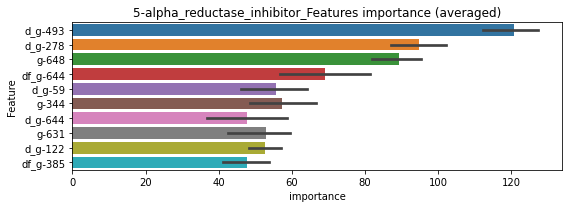

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103565	valid_1's binary_logloss: 0.0135898
[200]	training's binary_logloss: 0.00106595	valid_1's binary_logloss: 0.00349147
[300]	training's binary_logloss: 0.00029917	valid_1's binary_logloss: 0.00287631
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00029917	valid_1's binary_logloss: 0.00287631


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105604	valid_1's binary_logloss: 0.0146998
[200]	training's binary_logloss: 0.00108467	valid_1's binary_logloss: 0.00329004
[300]	training's binary_logloss: 0.000301263	valid_1's binary_logloss: 0.0019664
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00028969	valid_1's binary_logloss: 0.00195363


5-alpha_reductase_inhibitor logloss: 0.0024150293449116305


neg labels: 3289 → selected neg labels: 3286


11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230888	valid_1's binary_logloss: 0.0292949
[200]	training's binary_logloss: 0.00269451	valid_1's binary_logloss: 0.0052117
[300]	training's binary_logloss: 0.000765	valid_1's binary_logloss: 0.00197092
[400]	training's binary_logloss: 0.000409357	valid_1's binary_logloss: 0.00120123
[500]	training's binary_logloss: 0.000328497	valid_1's binary_logloss: 0.00100991
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000321872	valid_1's binary_logloss: 0.000992625
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232265	valid_1's binary_logloss: 0.0356492
[200]	training's binary_logloss: 0.00274967	valid_1's binary_logloss: 0.00670516
[300]	training's binary_logloss: 0.00077884	valid_1's binary_logloss: 0.00285103
[400]	training's binary_logloss: 0.000417556	valid_1's binary_logloss: 0.00191082
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0019560, Threshold: 0.0029867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00269, conf_1:0.00329
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0029867
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0129867
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0229867
threshold: 0.0229867, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022466	valid_1's binary_logloss: 0.0268722
[200]	training's binary_logloss: 0.00259411	valid_1's binary_logloss: 0.00403154
[300]	training's binary_logloss: 0.000753283	valid_1's binary_logloss: 0.0013833
[400]	training's binary_logloss: 0.000414477	valid_1's binary_logloss: 0.000820806
[500]	training's binary_logloss: 0.000336701	valid_1's binary_logloss: 0.00068871
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000331424	valid_1's binary_logloss: 0.000680818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226094	valid_1's binary_logloss: 0.0369821
[200]	training's binary_logloss: 0.00259144	valid_1's binary_logloss: 0.00890524
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00119863	valid_1's binary_logloss: 0.00540679


2 / 3 AUC score:1.000
y_Threshold: 0.0860420, Threshold: 0.0229867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00076
Num_p_label: 32.0, conf_0:0.02069, conf_1:0.02529
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_1: 0.0229867
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.0329867
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.0429867
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.0529867
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_5: 0.0629867
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_6: 0.0729867
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.0829867
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_8: 0.0929867
threshold: 0.0929867, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022466	valid_1's binary_logloss: 0.0268722
[200]	training's binary_logloss: 0.00259411	valid_1's binary_logloss: 0.00403154
[300]	training's binary_logloss: 0.000753283	valid_1's binary_logloss: 0.0013833
[400]	training's binary_logloss: 0.000414477	valid_1's binary_logloss: 0.000820806
[500]	training's binary_logloss: 0.000336701	valid_1's binary_logloss: 0.00068871
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000331424	valid_1's binary_logloss: 0.000680818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226094	valid_1's binary_logloss: 0.0369821
[200]	training's binary_logloss: 0.00259144	valid_1's binary_logloss: 0.00890524
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00119863	valid_1's binary_logloss: 0.00540679


3 / 3 AUC score:1.000
y_Threshold: 0.0860420, Threshold: 0.0929867, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.08369, conf_1:0.10229
threshold: 0.0929867, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


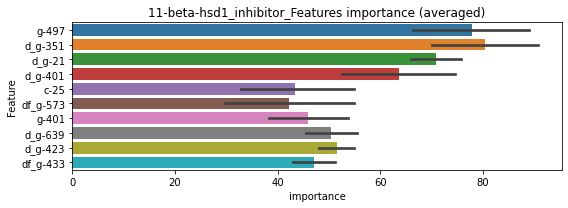

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01252	valid_1's binary_logloss: 0.0185777
[200]	training's binary_logloss: 0.0014283	valid_1's binary_logloss: 0.00592248
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.000483872	valid_1's binary_logloss: 0.00503973


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128417	valid_1's binary_logloss: 0.0198376
[200]	training's binary_logloss: 0.00152739	valid_1's binary_logloss: 0.0053587
[300]	training's binary_logloss: 0.000420686	valid_1's binary_logloss: 0.00290031
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000254429	valid_1's binary_logloss: 0.00246244


11-beta-hsd1_inhibitor logloss: 0.0037512486973787745


neg labels: 3289 → selected neg labels: 3285


acat_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304962	valid_1's binary_logloss: 0.047826
[200]	training's binary_logloss: 0.00414614	valid_1's binary_logloss: 0.0130803
[300]	training's binary_logloss: 0.00111638	valid_1's binary_logloss: 0.00783011
[400]	training's binary_logloss: 0.000550303	valid_1's binary_logloss: 0.00659369
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000458765	valid_1's binary_logloss: 0.00639167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290714	valid_1's binary_logloss: 0.0478227
[200]	training's binary_logloss: 0.00389895	valid_1's binary_logloss: 0.011779
[300]	training's binary_logloss: 0.00108596	valid_1's binary_logloss: 0.00688854
[400]	training's binary_logloss: 0.000549688	valid_1's binary_logloss: 0.00553376
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000533175	valid_1's binary_logloss: 0.00548605


1 / 3 AUC score:1.000
y_Threshold: 0.0023710, Threshold: 0.0035760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00322, conf_1:0.00393
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0035760
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_2: 0.0135760
threshold: 0.0135760, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030691	valid_1's binary_logloss: 0.0452982
[200]	training's binary_logloss: 0.00404831	valid_1's binary_logloss: 0.0113737
[300]	training's binary_logloss: 0.00109311	valid_1's binary_logloss: 0.00633015
[400]	training's binary_logloss: 0.00054442	valid_1's binary_logloss: 0.00503798
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000528278	valid_1's binary_logloss: 0.00499822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297851	valid_1's binary_logloss: 0.0471098
[200]	training's binary_logloss: 0.00394194	valid_1's binary_logloss: 0.0101808
[300]	training's binary_logloss: 0.00109567	valid_1's binary_logloss: 0.00478619
[400]	training's binary_logloss: 0.000556629	valid_1's binary_logloss: 0.00344997
[500]	training's binary_logloss: 0.000396151	valid_1's binary_logloss: 0.00322844
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0174677, Threshold: 0.0135760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00101
Num_p_label: 11.0, conf_0:0.01222, conf_1:0.01493
threshold: 0.0135760, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030691	valid_1's binary_logloss: 0.0452982
[200]	training's binary_logloss: 0.00404831	valid_1's binary_logloss: 0.0113737
[300]	training's binary_logloss: 0.00109311	valid_1's binary_logloss: 0.00633015
[400]	training's binary_logloss: 0.00054442	valid_1's binary_logloss: 0.00503798
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000528278	valid_1's binary_logloss: 0.00499822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297851	valid_1's binary_logloss: 0.0471098
[200]	training's binary_logloss: 0.00394194	valid_1's binary_logloss: 0.0101808
[300]	training's binary_logloss: 0.00109567	valid_1's binary_logloss: 0.00478619
[400]	training's binary_logloss: 0.000556629	valid_1's binary_logloss: 0.00344997
[500]	training's binary_logloss: 0.000396151	valid_1's binary_logloss: 0.00322844
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0174677, Threshold: 0.0135760, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00101
Num_p_label: 11.0, conf_0:0.01222, conf_1:0.01493
threshold: 0.0135760, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7792, y_label_rate: 0.0857290


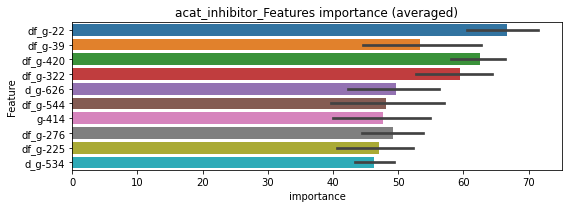

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168282	valid_1's binary_logloss: 0.0298065
[200]	training's binary_logloss: 0.00220637	valid_1's binary_logloss: 0.0136879
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000753275	valid_1's binary_logloss: 0.0122679


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182823	valid_1's binary_logloss: 0.0272811
[200]	training's binary_logloss: 0.0025664	valid_1's binary_logloss: 0.00750674
[300]	training's binary_logloss: 0.00068864	valid_1's binary_logloss: 0.00530082
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00034024	valid_1's binary_logloss: 0.00494785


acat_inhibitor logloss: 0.008607895846723397


neg labels: 3289 → selected neg labels: 3259


acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3259, target_rate: 0.0079785 → Adj_target_rate: 0.0072634
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907753	valid_1's binary_logloss: 0.252837
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0330166	valid_1's binary_logloss: 0.229928
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936327	valid_1's binary_logloss: 0.234403
[200]	training's binary_logloss: 0.0295863	valid_1's binary_logloss: 0.190969
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.017486	valid_1's binary_logloss: 0.186305


1 / 3 AUC score:0.924
y_Threshold: 0.0748933, Threshold: 0.1212110, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 361 → Positive_corect_labels: 536/3549
p_label_rate: 0.0200904 Vs.target_rate: 0.00798
Num_p_label: 80.0, conf_0:0.10909, conf_1:0.13333
threshold: 0.1212110, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 536.0/3549, y_label_rate: 0.1510285
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651991	valid_1's binary_logloss: 0.185477
[200]	training's binary_logloss: 0.0162046	valid_1's binary_logloss: 0.144225
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0101179	valid_1's binary_logloss: 0.138834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0693385	valid_1's binary_logloss: 0.163859
[200]	training's binary_logloss: 0.0174118	valid_1's binary_logloss: 0.117555
[300]	training's binary_logloss: 0.00548823	valid_1's binary_logloss: 0.1054
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00292491	valid_1's binary_logloss: 0.102966


2 / 3 AUC score:0.983
y_Threshold: 0.0711534, Threshold: 0.1212110, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 116 → Positive_corect_labels: 478.0/3433
p_label_rate: 0.0143144 Vs.target_rate: 0.00798
Num_p_label: 57.0, conf_0:0.10909, conf_1:0.13333
threshold: 0.1212110, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 478.0/3433, y_label_rate: 0.1392368
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544378	valid_1's binary_logloss: 0.1529
[200]	training's binary_logloss: 0.0128266	valid_1's binary_logloss: 0.117097
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0070993	valid_1's binary_logloss: 0.112507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0588776	valid_1's binary_logloss: 0.153253
[200]	training's binary_logloss: 0.0136721	valid_1's binary_logloss: 0.119864
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00948688	valid_1's binary_logloss: 0.117322


3 / 3 AUC score:0.984
y_Threshold: 0.0769143, Threshold: 0.1212110, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 88 → Positive_corect_labels: 434.0/3345
p_label_rate: 0.0193370 Vs.target_rate: 0.00798
Num_p_label: 77.0, conf_0:0.10909, conf_1:0.13333
threshold: 0.1212110, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 511.0/7327, y_label_rate: 0.0697420


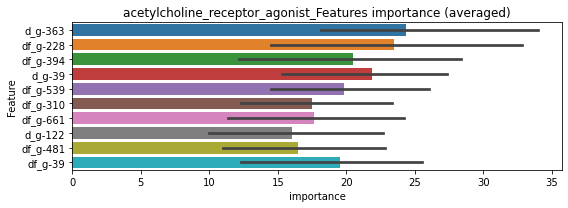

len(train_index) : 3663
len(valid_index) : 3664
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317086	valid_1's binary_logloss: 0.106273
[200]	training's binary_logloss: 0.00816483	valid_1's binary_logloss: 0.0937103
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00894889	valid_1's binary_logloss: 0.0934135


len(train_index) : 3664
len(valid_index) : 3663
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338088	valid_1's binary_logloss: 0.102317
[200]	training's binary_logloss: 0.00881957	valid_1's binary_logloss: 0.0840989
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00487655	valid_1's binary_logloss: 0.0822126


acetylcholine_receptor_agonist logloss: 0.08781380271575262


neg labels: 3289 → selected neg labels: 3241


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114737	valid_1's binary_logloss: 0.308086
Early stopping, best iteration is:
[189]	training's binary_logloss: 0.0450046	valid_1's binary_logloss: 0.288845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119754	valid_1's binary_logloss: 0.289232
[200]	training's binary_logloss: 0.0458947	valid_1's binary_logloss: 0.253439
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0289222	valid_1's binary_logloss: 0.251285


1 / 3 AUC score:0.863
y_Threshold: 0.1059173, Threshold: 0.1505881, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 504 → Positive_corect_labels: 461/3385
p_label_rate: 0.0200904 Vs.target_rate: 0.01264
Num_p_label: 80.0, conf_0:0.13553, conf_1:0.16565
threshold: 0.1505881, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 461.0/3385, y_label_rate: 0.1361891
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0732923	valid_1's binary_logloss: 0.185066
[200]	training's binary_logloss: 0.0197865	valid_1's binary_logloss: 0.146736
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0126062	valid_1's binary_logloss: 0.142432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751913	valid_1's binary_logloss: 0.18014
[200]	training's binary_logloss: 0.021743	valid_1's binary_logloss: 0.138675
[300]	training's binary_logloss: 0.0068682	valid_1's binary_logloss: 0.129724
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00722052	valid_1's binary_logloss: 0.129359


2 / 3 AUC score:0.972
y_Threshold: 0.0944165, Threshold: 0.1505881, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 392.0/3247
p_label_rate: 0.0195881 Vs.target_rate: 0.01264
Num_p_label: 78.0, conf_0:0.13553, conf_1:0.16565
threshold: 0.1505881, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 392.0/3247, y_label_rate: 0.1207268
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.054047	valid_1's binary_logloss: 0.159136
[200]	training's binary_logloss: 0.013385	valid_1's binary_logloss: 0.12992
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00832698	valid_1's binary_logloss: 0.126328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578237	valid_1's binary_logloss: 0.145929
[200]	training's binary_logloss: 0.0137374	valid_1's binary_logloss: 0.108884
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00932004	valid_1's binary_logloss: 0.106458


3 / 3 AUC score:0.976
y_Threshold: 0.0862282, Threshold: 0.1505881, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 98 → Positive_corect_labels: 343.0/3149
p_label_rate: 0.0195881 Vs.target_rate: 0.01264
Num_p_label: 78.0, conf_0:0.13553, conf_1:0.16565
threshold: 0.1505881, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 421.0/7131, y_label_rate: 0.0590380


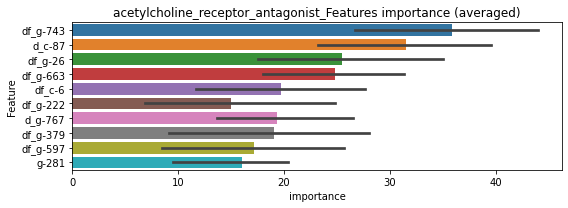

len(train_index) : 3565
len(valid_index) : 3566
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287724	valid_1's binary_logloss: 0.0977445
[200]	training's binary_logloss: 0.00696811	valid_1's binary_logloss: 0.0836337
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00498581	valid_1's binary_logloss: 0.083195


len(train_index) : 3566
len(valid_index) : 3565
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286702	valid_1's binary_logloss: 0.0878839
[200]	training's binary_logloss: 0.00730964	valid_1's binary_logloss: 0.0724274
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0053539	valid_1's binary_logloss: 0.0711756


acetylcholine_receptor_antagonist logloss: 0.07718614164978672


neg labels: 3289 → selected neg labels: 3276


acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0683741	valid_1's binary_logloss: 0.136525
[200]	training's binary_logloss: 0.0166227	valid_1's binary_logloss: 0.0781273
[300]	training's binary_logloss: 0.0046331	valid_1's binary_logloss: 0.0633787
[400]	training's binary_logloss: 0.00188392	valid_1's binary_logloss: 0.0587866
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00180609	valid_1's binary_logloss: 0.0586207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690849	valid_1's binary_logloss: 0.127582
[200]	training's binary_logloss: 0.0162358	valid_1's binary_logloss: 0.059207
[300]	training's binary_logloss: 0.0046297	valid_1's binary_logloss: 0.0381179
[400]	training's binary_logloss: 0.00191008	valid_1's binary_logloss: 0.0296646
[500]	training's binary_logloss: 0.00108759	valid_1's binary_logloss: 0.0264018
[600]	training's binary_logloss: 0.000765586	valid_1

1 / 3 AUC score:0.996
y_Threshold: 0.0135213, Threshold: 0.0185874, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3781
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01673, conf_1:0.02045
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0185874
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.0285874
Num_p_label: 16.0, Expected: 12.2, Adj_threshold_3: 0.0385874
threshold: 0.0385874, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 646.0/3781, y_label_rate: 0.1708543
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631577	valid_1's binary_logloss: 0.138502
[200]	training's binary_logloss: 0.0138102	valid_1's binary_logloss: 0.0787981
[300]	training's binary_logloss: 0.00388717	valid_1's binary_logloss: 0.0603885
[400]	training's binary_logloss: 0.00166187	valid_1's binary_logloss: 0.0535309
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00160856	valid_1's binary_logloss: 0.0533788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0687756	valid_1's binary_logloss: 0.130189
[200]	training's binary_logloss: 0.0150973	valid_1's binary_logloss: 0.0744102
[300]	training's binary_logloss: 0.00427516	valid_1's binary_logloss: 0.0640059
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00353879	valid_1's binary_logloss: 0.0623722


2 / 3 AUC score:0.993
y_Threshold: 0.0488138, Threshold: 0.0385874, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 623.0/3735
p_label_rate: 0.0175791 Vs.target_rate: 0.00307
Num_p_label: 70.0, conf_0:0.03473, conf_1:0.04245
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_1: 0.0385874
Num_p_label: 56.0, Expected: 12.2, Adj_threshold_2: 0.0485874
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_3: 0.0585874
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_4: 0.0685874
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_5: 0.0785874
threshold: 0.0785874, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 623.0/3735, y_label_rate: 0.1668005
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598938	valid_1's binary_logloss: 0.120795
[200]	training's binary_logloss: 0.0125713	valid_1's binary_logloss: 0.0577113
[300]	training's binary_logloss: 0.00365378	valid_1's binary_logloss: 0.0377389
[400]	training's binary_logloss: 0.00159786	valid_1's binary_logloss: 0.0306645
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00147504	valid_1's binary_logloss: 0.0304708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625617	valid_1's binary_logloss: 0.118682
[200]	training's binary_logloss: 0.0136655	valid_1's binary_logloss: 0.0600505
[300]	training's binary_logloss: 0.00393503	valid_1's binary_logloss: 0.0421509
[400]	training's binary_logloss: 0.00168743	valid_1's binary_logloss: 0.0365228
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00140369	valid_1's binary_logloss: 0.0355898


3 / 3 AUC score:0.999
y_Threshold: 0.0545577, Threshold: 0.0785874, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 616.0/3721
p_label_rate: 0.0032647 Vs.target_rate: 0.00307
Num_p_label: 13.0, conf_0:0.07073, conf_1:0.08645
threshold: 0.0785874, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 629.0/7703, y_label_rate: 0.0816565


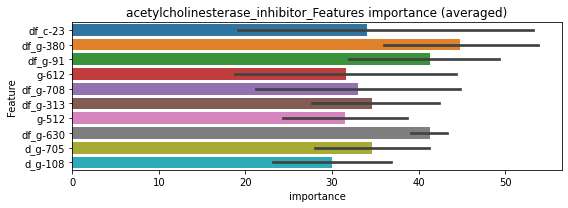

len(train_index) : 3851
len(valid_index) : 3852
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337488	valid_1's binary_logloss: 0.0750406
[200]	training's binary_logloss: 0.00711582	valid_1's binary_logloss: 0.0439672
[300]	training's binary_logloss: 0.00196138	valid_1's binary_logloss: 0.0374553
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00136305	valid_1's binary_logloss: 0.036722


len(train_index) : 3852
len(valid_index) : 3851
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365444	valid_1's binary_logloss: 0.0704838
[200]	training's binary_logloss: 0.00780716	valid_1's binary_logloss: 0.035139
[300]	training's binary_logloss: 0.00219693	valid_1's binary_logloss: 0.0270093
[400]	training's binary_logloss: 0.000892523	valid_1's binary_logloss: 0.0243287
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000711694	valid_1's binary_logloss: 0.0237622


acetylcholinesterase_inhibitor logloss: 0.030242952306984563


neg labels: 3289 → selected neg labels: 3281


adenosine_receptor_agonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471491	valid_1's binary_logloss: 0.0985208
[200]	training's binary_logloss: 0.00912064	valid_1's binary_logloss: 0.0504585
[300]	training's binary_logloss: 0.00251433	valid_1's binary_logloss: 0.039087
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00130776	valid_1's binary_logloss: 0.0359015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456324	valid_1's binary_logloss: 0.0964547
[200]	training's binary_logloss: 0.00842181	valid_1's binary_logloss: 0.0563382
[300]	training's binary_logloss: 0.002409	valid_1's binary_logloss: 0.0485477
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00124723	valid_1's binary_logloss: 0.0469423


1 / 3 AUC score:0.996
y_Threshold: 0.0112947, Threshold: 0.0176360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 644/3781
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01587, conf_1:0.01940
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0176360
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_2: 0.0276360
Num_p_label: 21.0, Expected: 9.0, Adj_threshold_3: 0.0376360
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_4: 0.0476360
threshold: 0.0476360, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436385	valid_1's binary_logloss: 0.0813099
[200]	training's binary_logloss: 0.00786663	valid_1's binary_logloss: 0.0347623
[300]	training's binary_logloss: 0.00224835	valid_1's binary_logloss: 0.0242345
[400]	training's binary_logloss: 0.00104385	valid_1's binary_logloss: 0.0210592
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000715608	valid_1's binary_logloss: 0.0200956
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426804	valid_1's binary_logloss: 0.0920145
[200]	training's binary_logloss: 0.00755009	valid_1's binary_logloss: 0.047098
[300]	training's binary_logloss: 0.00213289	valid_1's binary_logloss: 0.0379666
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00193993	valid_1's binary_logloss: 0.0376864


2 / 3 AUC score:0.999
y_Threshold: 0.0395767, Threshold: 0.0476360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 634.0/3761
p_label_rate: 0.0065294 Vs.target_rate: 0.00227
Num_p_label: 26.0, conf_0:0.04287, conf_1:0.05240
threshold: 0.0476360, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 634.0/3761, y_label_rate: 0.1685722
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425963	valid_1's binary_logloss: 0.0839673
[200]	training's binary_logloss: 0.00728351	valid_1's binary_logloss: 0.036403
[300]	training's binary_logloss: 0.00204194	valid_1's binary_logloss: 0.0252735
[400]	training's binary_logloss: 0.000961746	valid_1's binary_logloss: 0.0223151
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000781975	valid_1's binary_logloss: 0.021619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425422	valid_1's binary_logloss: 0.0807021
[200]	training's binary_logloss: 0.00758337	valid_1's binary_logloss: 0.0332834
[300]	training's binary_logloss: 0.00214818	valid_1's binary_logloss: 0.0234241
[400]	training's binary_logloss: 0.00100959	valid_1's binary_logloss: 0.0202262
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00085317	valid_1's binary_logloss: 0.0196689


3 / 3 AUC score:1.000
y_Threshold: 0.0327249, Threshold: 0.0476360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 629.0/3751
p_label_rate: 0.0050226 Vs.target_rate: 0.00227
Num_p_label: 20.0, conf_0:0.04287, conf_1:0.05240
threshold: 0.0476360, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 649.0/7733, y_label_rate: 0.0839260


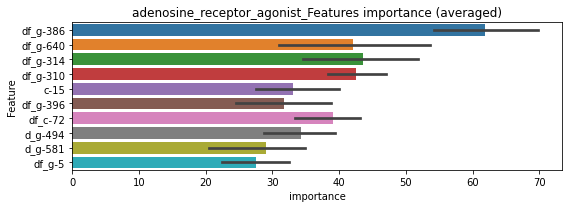

len(train_index) : 3866
len(valid_index) : 3867
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024344	valid_1's binary_logloss: 0.056344
[200]	training's binary_logloss: 0.00440061	valid_1's binary_logloss: 0.0298075
[300]	training's binary_logloss: 0.00125657	valid_1's binary_logloss: 0.023964
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000713383	valid_1's binary_logloss: 0.0228176


len(train_index) : 3867
len(valid_index) : 3866
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249838	valid_1's binary_logloss: 0.0484109
[200]	training's binary_logloss: 0.00462889	valid_1's binary_logloss: 0.0232578
[300]	training's binary_logloss: 0.00130097	valid_1's binary_logloss: 0.0177375
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000633072	valid_1's binary_logloss: 0.0164944


adenosine_receptor_agonist logloss: 0.019656408402432116


neg labels: 3289 → selected neg labels: 3273


adenosine_receptor_antagonist, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625928	valid_1's binary_logloss: 0.148287
[200]	training's binary_logloss: 0.0142924	valid_1's binary_logloss: 0.101949
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00524431	valid_1's binary_logloss: 0.0931211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630596	valid_1's binary_logloss: 0.136425
[200]	training's binary_logloss: 0.0150065	valid_1's binary_logloss: 0.0838637
[300]	training's binary_logloss: 0.00432468	valid_1's binary_logloss: 0.070038
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00250507	valid_1's binary_logloss: 0.0677938


1 / 3 AUC score:0.983
y_Threshold: 0.0256670, Threshold: 0.0395526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 200 → Positive_corect_labels: 620/3727
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.03560, conf_1:0.04351
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0395526
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_2: 0.0495526
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_3: 0.0595526
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_4: 0.0695526
threshold: 0.0695526, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 620.0/3727, y_label_rate: 0.1663536
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0578254	valid_1's binary_logloss: 0.127413
[200]	training's binary_logloss: 0.0121384	valid_1's binary_logloss: 0.0720703
[300]	training's binary_logloss: 0.00363709	valid_1's binary_logloss: 0.0583801
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00244326	valid_1's binary_logloss: 0.0564218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564945	valid_1's binary_logloss: 0.14108
[200]	training's binary_logloss: 0.0119374	valid_1's binary_logloss: 0.0961296
[300]	training's binary_logloss: 0.00357965	valid_1's binary_logloss: 0.0865342
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00379223	valid_1's binary_logloss: 0.0863487


2 / 3 AUC score:0.992
y_Threshold: 0.0419535, Threshold: 0.0695526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 591.0/3669
p_label_rate: 0.0095429 Vs.target_rate: 0.00403
Num_p_label: 38.0, conf_0:0.06260, conf_1:0.07651
threshold: 0.0695526, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 591.0/3669, y_label_rate: 0.1610793
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554967	valid_1's binary_logloss: 0.107845
[200]	training's binary_logloss: 0.0109697	valid_1's binary_logloss: 0.0570639
[300]	training's binary_logloss: 0.00322581	valid_1's binary_logloss: 0.0452706
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0016502	valid_1's binary_logloss: 0.0423685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521217	valid_1's binary_logloss: 0.125464
[200]	training's binary_logloss: 0.0103145	valid_1's binary_logloss: 0.0694138
[300]	training's binary_logloss: 0.00306018	valid_1's binary_logloss: 0.0564063
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00170603	valid_1's binary_logloss: 0.0537965


3 / 3 AUC score:0.997
y_Threshold: 0.0512213, Threshold: 0.0695526, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 577.0/3641
p_label_rate: 0.0087896 Vs.target_rate: 0.00403
Num_p_label: 35.0, conf_0:0.06260, conf_1:0.07651
threshold: 0.0695526, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 612.0/7623, y_label_rate: 0.0802834


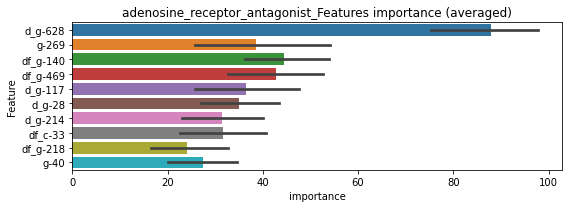

len(train_index) : 3811
len(valid_index) : 3812
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309148	valid_1's binary_logloss: 0.0738834
[200]	training's binary_logloss: 0.0065198	valid_1's binary_logloss: 0.0457034
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0021632	valid_1's binary_logloss: 0.0394222


len(train_index) : 3812
len(valid_index) : 3811
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314716	valid_1's binary_logloss: 0.0804878
[200]	training's binary_logloss: 0.00669763	valid_1's binary_logloss: 0.0554309
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00397744	valid_1's binary_logloss: 0.0532256


adenosine_receptor_antagonist logloss: 0.04632298971033243


neg labels: 3289 → selected neg labels: 3286


adenylyl_cyclase_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206782	valid_1's binary_logloss: 0.0265908
[200]	training's binary_logloss: 0.00225875	valid_1's binary_logloss: 0.0043516
[300]	training's binary_logloss: 0.000621453	valid_1's binary_logloss: 0.00147178
[400]	training's binary_logloss: 0.000340242	valid_1's binary_logloss: 0.000925792
[500]	training's binary_logloss: 0.000277798	valid_1's binary_logloss: 0.000800852
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000276184	valid_1's binary_logloss: 0.000798511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213093	valid_1's binary_logloss: 0.0267947
[200]	training's binary_logloss: 0.00228433	valid_1's binary_logloss: 0.00370997
[300]	training's binary_logloss: 0.000628726	valid_1's binary_logloss: 0.00125567
[400]	training's binary_logloss: 0.000342241	valid_1's binary_logloss: 0.000763319
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0013135, Threshold: 0.0023299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00210, conf_1:0.00256
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0023299
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0123299
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0223299
threshold: 0.0223299, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209992	valid_1's binary_logloss: 0.0269261
[200]	training's binary_logloss: 0.00221915	valid_1's binary_logloss: 0.00417314
[300]	training's binary_logloss: 0.000609896	valid_1's binary_logloss: 0.0014683
[400]	training's binary_logloss: 0.000335436	valid_1's binary_logloss: 0.000892946
[500]	training's binary_logloss: 0.00027666	valid_1's binary_logloss: 0.000777297
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00027666	valid_1's binary_logloss: 0.000777297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213611	valid_1's binary_logloss: 0.0260431
[200]	training's binary_logloss: 0.00226367	valid_1's binary_logloss: 0.003385
[300]	training's binary_logloss: 0.000616401	valid_1's binary_logloss: 0.00106569
[400]	training's binary_logloss: 0.000332688	valid_1's binary_logloss: 0.000622298
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.1507445, Threshold: 0.0223299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0050226 Vs.target_rate: 0.00076
Num_p_label: 20.0, conf_0:0.02010, conf_1:0.02456
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.0223299
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0323299
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.0423299
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.0523299
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0623299
threshold: 0.0623299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209992	valid_1's binary_logloss: 0.0269261
[200]	training's binary_logloss: 0.00221915	valid_1's binary_logloss: 0.00417314
[300]	training's binary_logloss: 0.000609896	valid_1's binary_logloss: 0.0014683
[400]	training's binary_logloss: 0.000335436	valid_1's binary_logloss: 0.000892946
[500]	training's binary_logloss: 0.00027666	valid_1's binary_logloss: 0.000777297
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00027666	valid_1's binary_logloss: 0.000777297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213611	valid_1's binary_logloss: 0.0260431
[200]	training's binary_logloss: 0.00226367	valid_1's binary_logloss: 0.003385
[300]	training's binary_logloss: 0.000616401	valid_1's binary_logloss: 0.00106569
[400]	training's binary_logloss: 0.000332688	valid_1's binary_logloss: 0.000622298
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.1507445, Threshold: 0.0623299, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.05610, conf_1:0.06856
threshold: 0.0623299, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


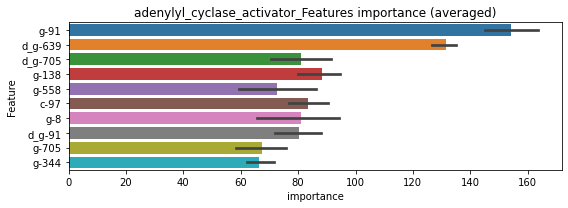

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106267	valid_1's binary_logloss: 0.0209188
[200]	training's binary_logloss: 0.00108024	valid_1's binary_logloss: 0.00917661
[300]	training's binary_logloss: 0.000296115	valid_1's binary_logloss: 0.00775078
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000280934	valid_1's binary_logloss: 0.00768568


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108917	valid_1's binary_logloss: 0.0143369
[200]	training's binary_logloss: 0.00115964	valid_1's binary_logloss: 0.00299116
[300]	training's binary_logloss: 0.000323876	valid_1's binary_logloss: 0.0017396
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000187713	valid_1's binary_logloss: 0.00152601


adenylyl_cyclase_activator logloss: 0.004606240621503131


neg labels: 3289 → selected neg labels: 3244


adrenergic_receptor_agonist, len(trt): 270, len(othr): 3244, target_rate: 0.0113379 → Adj_target_rate: 0.0097917
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945969	valid_1's binary_logloss: 0.274279
[200]	training's binary_logloss: 0.0307073	valid_1's binary_logloss: 0.251407
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.0304158	valid_1's binary_logloss: 0.251219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107384	valid_1's binary_logloss: 0.261626
[200]	training's binary_logloss: 0.0381294	valid_1's binary_logloss: 0.222091
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0293201	valid_1's binary_logloss: 0.218487


1 / 3 AUC score:0.912
y_Threshold: 0.0870429, Threshold: 0.1331335, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 407 → Positive_corect_labels: 510/3485
p_label_rate: 0.0200904 Vs.target_rate: 0.01134
Num_p_label: 80.0, conf_0:0.11982, conf_1:0.14645
threshold: 0.1331335, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 510.0/3485, y_label_rate: 0.1463415
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0764022	valid_1's binary_logloss: 0.214681
[200]	training's binary_logloss: 0.0219538	valid_1's binary_logloss: 0.181452
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0176175	valid_1's binary_logloss: 0.179191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0712361	valid_1's binary_logloss: 0.213457
[200]	training's binary_logloss: 0.0202789	valid_1's binary_logloss: 0.18488
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.014105	valid_1's binary_logloss: 0.183194


2 / 3 AUC score:0.949
y_Threshold: 0.0861592, Threshold: 0.1331335, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 194 → Positive_corect_labels: 413.0/3291
p_label_rate: 0.0158212 Vs.target_rate: 0.01134
Num_p_label: 63.0, conf_0:0.11982, conf_1:0.14645
threshold: 0.1331335, positive_p_label: 63.0/3982, p_label_rate: 0.0158212
positive_y_label: 413.0/3291, y_label_rate: 0.1254938
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529331	valid_1's binary_logloss: 0.148073
[200]	training's binary_logloss: 0.0124131	valid_1's binary_logloss: 0.113125
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0060239	valid_1's binary_logloss: 0.108753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0529596	valid_1's binary_logloss: 0.166075
[200]	training's binary_logloss: 0.0123536	valid_1's binary_logloss: 0.134805
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00463464	valid_1's binary_logloss: 0.127862


3 / 3 AUC score:0.978
y_Threshold: 0.0630384, Threshold: 0.1331335, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 88 → Positive_corect_labels: 369.0/3203
p_label_rate: 0.0145655 Vs.target_rate: 0.01134
Num_p_label: 58.0, conf_0:0.11982, conf_1:0.14645
threshold: 0.1331335, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 427.0/7185, y_label_rate: 0.0594294


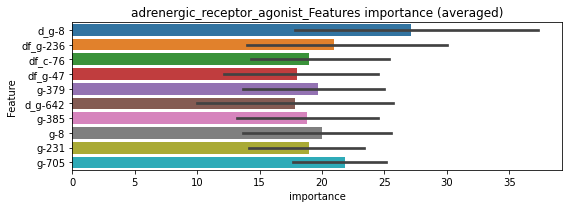

len(train_index) : 3592
len(valid_index) : 3593
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251574	valid_1's binary_logloss: 0.102517
[200]	training's binary_logloss: 0.0062329	valid_1's binary_logloss: 0.0911652
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00510938	valid_1's binary_logloss: 0.0908654


len(train_index) : 3593
len(valid_index) : 3592
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281092	valid_1's binary_logloss: 0.0867723
[200]	training's binary_logloss: 0.00670526	valid_1's binary_logloss: 0.0752294
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00488231	valid_1's binary_logloss: 0.0746802


adrenergic_receptor_agonist logloss: 0.08277392264789134


neg labels: 3289 → selected neg labels: 3229


adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3229, target_rate: 0.0151172 → Adj_target_rate: 0.0125042
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128761	valid_1's binary_logloss: 0.358254
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0735606	valid_1's binary_logloss: 0.352292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137477	valid_1's binary_logloss: 0.338289
[200]	training's binary_logloss: 0.0540318	valid_1's binary_logloss: 0.317086
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0526247	valid_1's binary_logloss: 0.316667


1 / 3 AUC score:0.790
y_Threshold: 0.1294222, Threshold: 0.1782639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 654 → Positive_corect_labels: 383/3220
p_label_rate: 0.0200904 Vs.target_rate: 0.01512
Num_p_label: 80.0, conf_0:0.16044, conf_1:0.19609
threshold: 0.1782639, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 383.0/3220, y_label_rate: 0.1189441
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686515	valid_1's binary_logloss: 0.212672
[200]	training's binary_logloss: 0.0182962	valid_1's binary_logloss: 0.186604
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0130891	valid_1's binary_logloss: 0.183632
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0707829	valid_1's binary_logloss: 0.211944
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.0257822	valid_1's binary_logloss: 0.18917


2 / 3 AUC score:0.941
y_Threshold: 0.0884330, Threshold: 0.1782639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 190 → Positive_corect_labels: 288.0/3030
p_label_rate: 0.0035158 Vs.target_rate: 0.01512
Num_p_label: 14.0, conf_0:0.16044, conf_1:0.19609
Num_p_label: 14.0, Expected: 60.2, Adj_threshold_1: 0.1782639
Num_p_label: 20.0, Expected: 60.2, Adj_threshold_2: 0.1682639
Num_p_label: 25.0, Expected: 60.2, Adj_threshold_3: 0.1582639
Num_p_label: 31.0, Expected: 60.2, Adj_threshold_4: 0.1482639
threshold: 0.1482639, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 288.0/3030, y_label_rate: 0.0950495
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460694	valid_1's binary_logloss: 0.16144
[200]	training's binary_logloss: 0.0114037	valid_1's binary_logloss: 0.135545
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0107231	valid_1's binary_logloss: 0.134674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449459	valid_1's binary_logloss: 0.171948
[200]	training's binary_logloss: 0.0110448	valid_1's binary_logloss: 0.155727
Early stopping, best iteration is:
[202]	training's binary_logloss: 0.0107797	valid_1's binary_logloss: 0.155522


3 / 3 AUC score:0.955
y_Threshold: 0.0669523, Threshold: 0.1482639, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 229.0/2912
p_label_rate: 0.0047715 Vs.target_rate: 0.01512
Num_p_label: 19.0, conf_0:0.13344, conf_1:0.16309
Num_p_label: 19.0, Expected: 60.2, Adj_threshold_1: 0.1482639
Num_p_label: 22.0, Expected: 60.2, Adj_threshold_2: 0.1382639
Num_p_label: 28.0, Expected: 60.2, Adj_threshold_3: 0.1282639
Num_p_label: 32.0, Expected: 60.2, Adj_threshold_4: 0.1182639
threshold: 0.1182639, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 261.0/6894, y_label_rate: 0.0378590


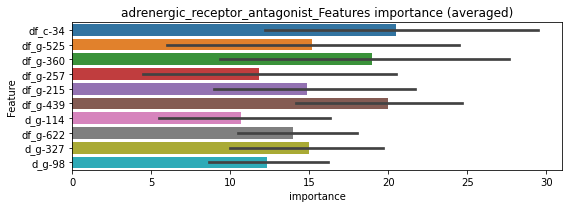

len(train_index) : 3447
len(valid_index) : 3447
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177713	valid_1's binary_logloss: 0.0902843
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.00493972	valid_1's binary_logloss: 0.0851224


len(train_index) : 3447
len(valid_index) : 3447
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188711	valid_1's binary_logloss: 0.0774913
[200]	training's binary_logloss: 0.00436997	valid_1's binary_logloss: 0.0668919
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.00389098	valid_1's binary_logloss: 0.0664909


adrenergic_receptor_antagonist logloss: 0.07580663544813245


neg labels: 3289 → selected neg labels: 3278


akt_inhibitor, len(trt): 66, len(othr): 3278, target_rate: 0.0027715 → Adj_target_rate: 0.0029567
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363327	valid_1's binary_logloss: 0.0741366
[200]	training's binary_logloss: 0.00611278	valid_1's binary_logloss: 0.0334392
[300]	training's binary_logloss: 0.00183027	valid_1's binary_logloss: 0.0243385
[400]	training's binary_logloss: 0.000900325	valid_1's binary_logloss: 0.022402
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000939397	valid_1's binary_logloss: 0.0222285
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392165	valid_1's binary_logloss: 0.0685647
[200]	training's binary_logloss: 0.00671598	valid_1's binary_logloss: 0.0250542
[300]	training's binary_logloss: 0.00199253	valid_1's binary_logloss: 0.0151278
[400]	training's binary_logloss: 0.000960239	valid_1's binary_logloss: 0.0116556
[500]	training's binary_logloss: 0.000627723	valid_1's binary_logloss: 0.0105065
Early stopping, best iteration is:
[540]	t

1 / 3 AUC score:1.000
y_Threshold: 0.0067022, Threshold: 0.0195238, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00277
Num_p_label: 80.0, conf_0:0.01757, conf_1:0.02148
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.0195238
Num_p_label: 64.0, Expected: 11.0, Adj_threshold_2: 0.0295238
Num_p_label: 55.0, Expected: 11.0, Adj_threshold_3: 0.0395238
Num_p_label: 47.0, Expected: 11.0, Adj_threshold_4: 0.0495238
Num_p_label: 42.0, Expected: 11.0, Adj_threshold_5: 0.0595238
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_6: 0.0695238
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_7: 0.0795238
Num_p_label: 31.0, Expected: 11.0, Adj_threshold_8: 0.0895238
Num_p_label: 27.0, Expected: 11.0, Adj_threshold_9: 0.0995238
Num_p_label: 25.0, Expected: 11.0, Adj_threshold_10: 0.1095238
threshold: 0.1195238, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 654.0/3799, y_label_rate: 0.1721506

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366535	valid_1's binary_logloss: 0.0716117
[200]	training's binary_logloss: 0.00591721	valid_1's binary_logloss: 0.0306584
[300]	training's binary_logloss: 0.00173917	valid_1's binary_logloss: 0.0224093
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00157521	valid_1's binary_logloss: 0.0219967
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0358874	valid_1's binary_logloss: 0.0668252
[200]	training's binary_logloss: 0.00573535	valid_1's binary_logloss: 0.0249304
[300]	training's binary_logloss: 0.00170017	valid_1's binary_logloss: 0.015615
[400]	training's binary_logloss: 0.000834759	valid_1's binary_logloss: 0.0119101
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000809679	valid_1's binary_logloss: 0.0117822


2 / 3 AUC score:1.000
y_Threshold: 0.0702132, Threshold: 0.1195238, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 648.0/3787
p_label_rate: 0.0200904 Vs.target_rate: 0.00277
Num_p_label: 80.0, conf_0:0.10757, conf_1:0.13148
Num_p_label: 80.0, Expected: 11.0, Adj_threshold_1: 0.1195238
Num_p_label: 77.0, Expected: 11.0, Adj_threshold_2: 0.1295238
Num_p_label: 74.0, Expected: 11.0, Adj_threshold_3: 0.1395238
Num_p_label: 72.0, Expected: 11.0, Adj_threshold_4: 0.1495238
Num_p_label: 72.0, Expected: 11.0, Adj_threshold_5: 0.1595238
Num_p_label: 68.0, Expected: 11.0, Adj_threshold_6: 0.1695238
Num_p_label: 65.0, Expected: 11.0, Adj_threshold_7: 0.1795238
Num_p_label: 64.0, Expected: 11.0, Adj_threshold_8: 0.1895238
Num_p_label: 64.0, Expected: 11.0, Adj_threshold_9: 0.1995238
Num_p_label: 62.0, Expected: 11.0, Adj_threshold_10: 0.2095238
threshold: 0.2195238, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 648.0/3787, y_label_rate: 0.171111

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360823	valid_1's binary_logloss: 0.0642446
[200]	training's binary_logloss: 0.00583812	valid_1's binary_logloss: 0.0216696
[300]	training's binary_logloss: 0.00172276	valid_1's binary_logloss: 0.012575
[400]	training's binary_logloss: 0.000846462	valid_1's binary_logloss: 0.00977392
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000803105	valid_1's binary_logloss: 0.00957223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367953	valid_1's binary_logloss: 0.0726348
[200]	training's binary_logloss: 0.00573862	valid_1's binary_logloss: 0.0307106
[300]	training's binary_logloss: 0.00167448	valid_1's binary_logloss: 0.0225147
[400]	training's binary_logloss: 0.000823726	valid_1's binary_logloss: 0.0202615
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000592182	valid_1's binary_logloss: 0.0198475


3 / 3 AUC score:1.000
y_Threshold: 0.0595423, Threshold: 0.2195238, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 644.0/3779
p_label_rate: 0.0153189 Vs.target_rate: 0.00277
Num_p_label: 61.0, conf_0:0.19757, conf_1:0.24148
Num_p_label: 61.0, Expected: 11.0, Adj_threshold_1: 0.2195238
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_2: 0.2295238
Num_p_label: 59.0, Expected: 11.0, Adj_threshold_3: 0.2395238
Num_p_label: 54.0, Expected: 11.0, Adj_threshold_4: 0.2495238
Num_p_label: 53.0, Expected: 11.0, Adj_threshold_5: 0.2595238
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_6: 0.2695238
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_7: 0.2795238
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_8: 0.2895238
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_9: 0.2995238
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_10: 0.3095238
threshold: 0.3195238, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 694.0/7761, y_label_rate: 0.0894215

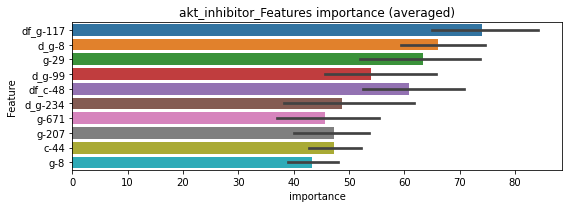

len(train_index) : 3880
len(valid_index) : 3881
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200526	valid_1's binary_logloss: 0.0536696
[200]	training's binary_logloss: 0.00311215	valid_1's binary_logloss: 0.0304778
[300]	training's binary_logloss: 0.000933306	valid_1's binary_logloss: 0.0255961
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000795531	valid_1's binary_logloss: 0.0250873


len(train_index) : 3881
len(valid_index) : 3880
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204119	valid_1's binary_logloss: 0.0406805
[200]	training's binary_logloss: 0.00335235	valid_1's binary_logloss: 0.0174706
[300]	training's binary_logloss: 0.0010097	valid_1's binary_logloss: 0.0121035
[400]	training's binary_logloss: 0.00049229	valid_1's binary_logloss: 0.0103771
[500]	training's binary_logloss: 0.000323978	valid_1's binary_logloss: 0.00968069
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000288678	valid_1's binary_logloss: 0.00953804


akt_inhibitor logloss: 0.017313669632299127


neg labels: 3289 → selected neg labels: 3286


aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229169	valid_1's binary_logloss: 0.0361584
[200]	training's binary_logloss: 0.00271591	valid_1's binary_logloss: 0.00804293
[300]	training's binary_logloss: 0.000748181	valid_1's binary_logloss: 0.00373284
[400]	training's binary_logloss: 0.000395579	valid_1's binary_logloss: 0.00265689
[500]	training's binary_logloss: 0.000315815	valid_1's binary_logloss: 0.00243622
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000318786	valid_1's binary_logloss: 0.00242976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237665	valid_1's binary_logloss: 0.0299494
[200]	training's binary_logloss: 0.00273334	valid_1's binary_logloss: 0.00451024
[300]	training's binary_logloss: 0.00075738	valid_1's binary_logloss: 0.0015302
[400]	training's binary_logloss: 0.000407647	valid_1's binary_logloss: 0.000905617
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0016400, Threshold: 0.0024385, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00219, conf_1:0.00268
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0024385
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.0124385
Num_p_label: 1.0, Expected: 3.2, Adj_threshold_3: 0.0224385
threshold: 0.0224385, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228413	valid_1's binary_logloss: 0.0356281
[200]	training's binary_logloss: 0.0026182	valid_1's binary_logloss: 0.00855239
[300]	training's binary_logloss: 0.000735487	valid_1's binary_logloss: 0.00405573
[400]	training's binary_logloss: 0.000393129	valid_1's binary_logloss: 0.0028195
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000347294	valid_1's binary_logloss: 0.0026604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228913	valid_1's binary_logloss: 0.028364
[200]	training's binary_logloss: 0.00255146	valid_1's binary_logloss: 0.00403463
[300]	training's binary_logloss: 0.00072089	valid_1's binary_logloss: 0.00136024
[400]	training's binary_logloss: 0.000393318	valid_1's binary_logloss: 0.000826137
[500]	training's binary_logloss: 0.000317309	valid_1's binary_logloss: 0.000689746
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0403633, Threshold: 0.0224385, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00080
Num_p_label: 13.0, conf_0:0.02019, conf_1:0.02468
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_1: 0.0224385
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.0324385
Num_p_label: 5.0, Expected: 3.2, Adj_threshold_3: 0.0424385
threshold: 0.0424385, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228413	valid_1's binary_logloss: 0.0356281
[200]	training's binary_logloss: 0.0026182	valid_1's binary_logloss: 0.00855239
[300]	training's binary_logloss: 0.000735487	valid_1's binary_logloss: 0.00405573
[400]	training's binary_logloss: 0.000393129	valid_1's binary_logloss: 0.0028195
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000347294	valid_1's binary_logloss: 0.0026604
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228913	valid_1's binary_logloss: 0.028364
[200]	training's binary_logloss: 0.00255146	valid_1's binary_logloss: 0.00403463
[300]	training's binary_logloss: 0.00072089	valid_1's binary_logloss: 0.00136024
[400]	training's binary_logloss: 0.000393318	valid_1's binary_logloss: 0.000826137
[500]	training's binary_logloss: 0.000317309	valid_1's binary_logloss: 0.000689746
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0403633, Threshold: 0.0424385, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0012557 Vs.target_rate: 0.00080
Num_p_label: 5.0, conf_0:0.03819, conf_1:0.04668
threshold: 0.0424385, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7793, y_label_rate: 0.0849480


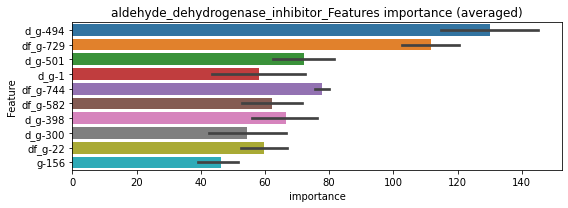

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122624	valid_1's binary_logloss: 0.0183695
[200]	training's binary_logloss: 0.00138637	valid_1's binary_logloss: 0.00597598
[300]	training's binary_logloss: 0.000378612	valid_1's binary_logloss: 0.00492664
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000332415	valid_1's binary_logloss: 0.00489367


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124453	valid_1's binary_logloss: 0.0165082
[200]	training's binary_logloss: 0.0014895	valid_1's binary_logloss: 0.00365208
[300]	training's binary_logloss: 0.000409772	valid_1's binary_logloss: 0.00199756
[400]	training's binary_logloss: 0.000212948	valid_1's binary_logloss: 0.00165241
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.000181091	valid_1's binary_logloss: 0.00159694


aldehyde_dehydrogenase_inhibitor logloss: 0.0032455119329155876


neg labels: 3289 → selected neg labels: 3282


alk_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332886	valid_1's binary_logloss: 0.0645283
[200]	training's binary_logloss: 0.00486468	valid_1's binary_logloss: 0.0281048
[300]	training's binary_logloss: 0.00141512	valid_1's binary_logloss: 0.0205292
[400]	training's binary_logloss: 0.000699496	valid_1's binary_logloss: 0.0173505
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000662862	valid_1's binary_logloss: 0.0172283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327405	valid_1's binary_logloss: 0.063856
[200]	training's binary_logloss: 0.00516065	valid_1's binary_logloss: 0.025977
[300]	training's binary_logloss: 0.00147888	valid_1's binary_logloss: 0.0175207
[400]	training's binary_logloss: 0.000728138	valid_1's binary_logloss: 0.0138856
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000656986	valid_1's binary_logloss: 0.0135898


1 / 3 AUC score:1.000
y_Threshold: 0.0066329, Threshold: 0.0158713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.01428, conf_1:0.01746
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0158713
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_2: 0.0258713
Num_p_label: 34.0, Expected: 7.0, Adj_threshold_3: 0.0358713
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_4: 0.0458713
Num_p_label: 27.0, Expected: 7.0, Adj_threshold_5: 0.0558713
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_6: 0.0658713
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_7: 0.0758713
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_8: 0.0858713
threshold: 0.0858713, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313347	valid_1's binary_logloss: 0.0589737
[200]	training's binary_logloss: 0.00439298	valid_1's binary_logloss: 0.0221762
[300]	training's binary_logloss: 0.00127708	valid_1's binary_logloss: 0.0146193
[400]	training's binary_logloss: 0.000653288	valid_1's binary_logloss: 0.0126933
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000578726	valid_1's binary_logloss: 0.0124716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315741	valid_1's binary_logloss: 0.061594
[200]	training's binary_logloss: 0.00459565	valid_1's binary_logloss: 0.0233699
[300]	training's binary_logloss: 0.00131108	valid_1's binary_logloss: 0.0145004
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000826704	valid_1's binary_logloss: 0.0123108


2 / 3 AUC score:1.000
y_Threshold: 0.0888825, Threshold: 0.0858713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 652.0/3798
p_label_rate: 0.0150678 Vs.target_rate: 0.00176
Num_p_label: 60.0, conf_0:0.07728, conf_1:0.09446
Num_p_label: 60.0, Expected: 7.0, Adj_threshold_1: 0.0858713
Num_p_label: 57.0, Expected: 7.0, Adj_threshold_2: 0.0958713
Num_p_label: 55.0, Expected: 7.0, Adj_threshold_3: 0.1058713
Num_p_label: 53.0, Expected: 7.0, Adj_threshold_4: 0.1158713
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_5: 0.1258713
Num_p_label: 46.0, Expected: 7.0, Adj_threshold_6: 0.1358713
Num_p_label: 45.0, Expected: 7.0, Adj_threshold_7: 0.1458713
Num_p_label: 42.0, Expected: 7.0, Adj_threshold_8: 0.1558713
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_9: 0.1658713
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_10: 0.1758713
threshold: 0.1858713, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 652.0/3798, y_label_rate: 0.1716693
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308059	valid_1's binary_logloss: 0.0480993
[200]	training's binary_logloss: 0.00445869	valid_1's binary_logloss: 0.0122989
[300]	training's binary_logloss: 0.0012813	valid_1's binary_logloss: 0.00605889
[400]	training's binary_logloss: 0.000640276	valid_1's binary_logloss: 0.00449348
[500]	training's binary_logloss: 0.000447371	valid_1's binary_logloss: 0.00396653
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000452841	valid_1's binary_logloss: 0.00395314
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312632	valid_1's binary_logloss: 0.0526494
[200]	training's binary_logloss: 0.00443342	valid_1's binary_logloss: 0.0156441
[300]	training's binary_logloss: 0.0012845	valid_1's binary_logloss: 0.0083936
[400]	training's binary_logloss: 0.00064544	valid_1's binary_logloss: 0.0063236
Early stopping, best iteration is:
[455]

3 / 3 AUC score:1.000
y_Threshold: 0.1952605, Threshold: 0.1858713, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0097941 Vs.target_rate: 0.00176
Num_p_label: 39.0, conf_0:0.16728, conf_1:0.20446
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_1: 0.1858713
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_2: 0.1958713
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_3: 0.2058713
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_4: 0.2158713
Num_p_label: 37.0, Expected: 7.0, Adj_threshold_5: 0.2258713
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_6: 0.2358713
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_7: 0.2458713
Num_p_label: 33.0, Expected: 7.0, Adj_threshold_8: 0.2558713
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_9: 0.2658713
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_10: 0.2758713
threshold: 0.2858713, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 681.0/7776, y_label_rate: 0.0875772


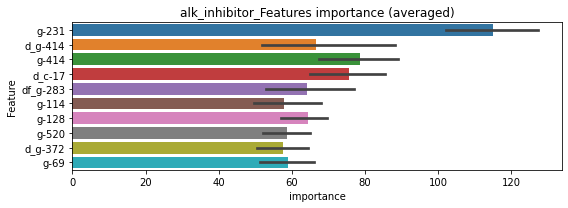

len(train_index) : 3888
len(valid_index) : 3888
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01701	valid_1's binary_logloss: 0.0333284
[200]	training's binary_logloss: 0.00248347	valid_1's binary_logloss: 0.0140833
[300]	training's binary_logloss: 0.000717187	valid_1's binary_logloss: 0.00977847
[400]	training's binary_logloss: 0.000357671	valid_1's binary_logloss: 0.00833782
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000272665	valid_1's binary_logloss: 0.00807737


len(train_index) : 3888
len(valid_index) : 3888
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168187	valid_1's binary_logloss: 0.0361586
[200]	training's binary_logloss: 0.00246008	valid_1's binary_logloss: 0.0149577
[300]	training's binary_logloss: 0.000728959	valid_1's binary_logloss: 0.0107444
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000520472	valid_1's binary_logloss: 0.0102651


alk_inhibitor logloss: 0.009171223332216713


neg labels: 3289 → selected neg labels: 3287


ampk_activator, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189588	valid_1's binary_logloss: 0.0247363
[200]	training's binary_logloss: 0.00194803	valid_1's binary_logloss: 0.00395709
[300]	training's binary_logloss: 0.00054401	valid_1's binary_logloss: 0.00152383
[400]	training's binary_logloss: 0.000306906	valid_1's binary_logloss: 0.000983661
[500]	training's binary_logloss: 0.000263737	valid_1's binary_logloss: 0.00091148
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000263555	valid_1's binary_logloss: 0.00091121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018849	valid_1's binary_logloss: 0.0224558
[200]	training's binary_logloss: 0.00195019	valid_1's binary_logloss: 0.00333993
[300]	training's binary_logloss: 0.000549559	valid_1's binary_logloss: 0.001373
[400]	training's binary_logloss: 0.000308145	valid_1's binary_logloss: 0.000920398
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0009478, Threshold: 0.0015006, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00135, conf_1:0.00165
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015006
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0115006
Num_p_label: 0.0, Expected: 2.0, Adj_threshold_3: 0.0215006
threshold: 0.0215006, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191369	valid_1's binary_logloss: 0.0239535
[200]	training's binary_logloss: 0.00190734	valid_1's binary_logloss: 0.00415584
[300]	training's binary_logloss: 0.00053969	valid_1's binary_logloss: 0.00169833
[400]	training's binary_logloss: 0.000303601	valid_1's binary_logloss: 0.00119805
[500]	training's binary_logloss: 0.00026295	valid_1's binary_logloss: 0.00111454
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000261915	valid_1's binary_logloss: 0.00111237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189409	valid_1's binary_logloss: 0.0220705
[200]	training's binary_logloss: 0.00190695	valid_1's binary_logloss: 0.0034023
[300]	training's binary_logloss: 0.00054135	valid_1's binary_logloss: 0.00150466
[400]	training's binary_logloss: 0.000310673	valid_1's binary_logloss: 0.00113077
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0590327, Threshold: 0.0215006, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00050
Num_p_label: 15.0, conf_0:0.01935, conf_1:0.02365
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.0215006
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.0315006
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0415006
threshold: 0.0415006, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191369	valid_1's binary_logloss: 0.0239535
[200]	training's binary_logloss: 0.00190734	valid_1's binary_logloss: 0.00415584
[300]	training's binary_logloss: 0.00053969	valid_1's binary_logloss: 0.00169833
[400]	training's binary_logloss: 0.000303601	valid_1's binary_logloss: 0.00119805
[500]	training's binary_logloss: 0.00026295	valid_1's binary_logloss: 0.00111454
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000261915	valid_1's binary_logloss: 0.00111237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189409	valid_1's binary_logloss: 0.0220705
[200]	training's binary_logloss: 0.00190695	valid_1's binary_logloss: 0.0034023
[300]	training's binary_logloss: 0.00054135	valid_1's binary_logloss: 0.00150466
[400]	training's binary_logloss: 0.000310673	valid_1's binary_logloss: 0.00113077
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0590327, Threshold: 0.0415006, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.03735, conf_1:0.04565
threshold: 0.0415006, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


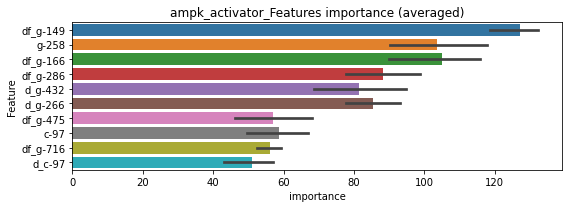

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101428	valid_1's binary_logloss: 0.0170303
[200]	training's binary_logloss: 0.000984415	valid_1's binary_logloss: 0.00603
[300]	training's binary_logloss: 0.000272734	valid_1's binary_logloss: 0.00522394
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000264603	valid_1's binary_logloss: 0.00520513


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104963	valid_1's binary_logloss: 0.0118432
[200]	training's binary_logloss: 0.00106668	valid_1's binary_logloss: 0.00213047
[300]	training's binary_logloss: 0.000295979	valid_1's binary_logloss: 0.00134642
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000226869	valid_1's binary_logloss: 0.00128131


ampk_activator logloss: 0.003243223710166503


neg labels: 3289 → selected neg labels: 3287


analgesic, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180663	valid_1's binary_logloss: 0.022133
[200]	training's binary_logloss: 0.00179997	valid_1's binary_logloss: 0.00315542
[300]	training's binary_logloss: 0.000508552	valid_1's binary_logloss: 0.00108721
[400]	training's binary_logloss: 0.000289544	valid_1's binary_logloss: 0.000677085
[500]	training's binary_logloss: 0.000253645	valid_1's binary_logloss: 0.000602949
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000253645	valid_1's binary_logloss: 0.000602949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180002	valid_1's binary_logloss: 0.0198316
[200]	training's binary_logloss: 0.00180419	valid_1's binary_logloss: 0.00230104
[300]	training's binary_logloss: 0.000512264	valid_1's binary_logloss: 0.000709667
[400]	training's binary_logloss: 0.000294183	valid_1's binary_logloss: 0.000421355
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0010230, Threshold: 0.0016200, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00146, conf_1:0.00178
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016200
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_2: 0.0116200
threshold: 0.0116200, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182362	valid_1's binary_logloss: 0.0217073
[200]	training's binary_logloss: 0.00178276	valid_1's binary_logloss: 0.00272607
[300]	training's binary_logloss: 0.000498936	valid_1's binary_logloss: 0.000915101
[400]	training's binary_logloss: 0.00028807	valid_1's binary_logloss: 0.000571941
[500]	training's binary_logloss: 0.000249323	valid_1's binary_logloss: 0.000511909
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000246993	valid_1's binary_logloss: 0.000509067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182679	valid_1's binary_logloss: 0.020394
[200]	training's binary_logloss: 0.00177969	valid_1's binary_logloss: 0.00235317
[300]	training's binary_logloss: 0.000504038	valid_1's binary_logloss: 0.000718722
[400]	training's binary_logloss: 0.00029173	valid_1's binary_logloss: 0.000428528
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1643758, Threshold: 0.0116200, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00050
Num_p_label: 17.0, conf_0:0.01046, conf_1:0.01278
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.0116200
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0216200
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.0316200
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0416200
threshold: 0.0416200, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182362	valid_1's binary_logloss: 0.0217073
[200]	training's binary_logloss: 0.00178276	valid_1's binary_logloss: 0.00272607
[300]	training's binary_logloss: 0.000498936	valid_1's binary_logloss: 0.000915101
[400]	training's binary_logloss: 0.00028807	valid_1's binary_logloss: 0.000571941
[500]	training's binary_logloss: 0.000249323	valid_1's binary_logloss: 0.000511909
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.000246993	valid_1's binary_logloss: 0.000509067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182679	valid_1's binary_logloss: 0.020394
[200]	training's binary_logloss: 0.00177969	valid_1's binary_logloss: 0.00235317
[300]	training's binary_logloss: 0.000504038	valid_1's binary_logloss: 0.000718722
[400]	training's binary_logloss: 0.00029173	valid_1's binary_logloss: 0.000428528
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1643758, Threshold: 0.0416200, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.03746, conf_1:0.04578
threshold: 0.0416200, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


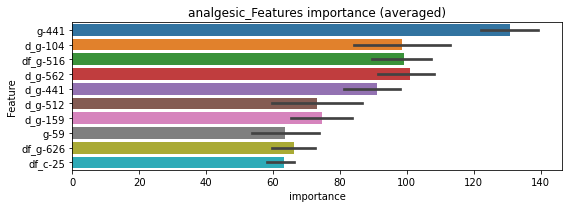

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00936501	valid_1's binary_logloss: 0.0120534
[200]	training's binary_logloss: 0.000891859	valid_1's binary_logloss: 0.0034685
[300]	training's binary_logloss: 0.000252435	valid_1's binary_logloss: 0.00287465
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000242089	valid_1's binary_logloss: 0.00286875


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00972071	valid_1's binary_logloss: 0.0118022
[200]	training's binary_logloss: 0.000953469	valid_1's binary_logloss: 0.0023696
[300]	training's binary_logloss: 0.000263353	valid_1's binary_logloss: 0.0017924
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000227354	valid_1's binary_logloss: 0.00176606


analgesic logloss: 0.0023174071415987415


neg labels: 3289 → selected neg labels: 3281


androgen_receptor_agonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440506	valid_1's binary_logloss: 0.10042
[200]	training's binary_logloss: 0.00750385	valid_1's binary_logloss: 0.0623113
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00358385	valid_1's binary_logloss: 0.0566259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464906	valid_1's binary_logloss: 0.0812621
[200]	training's binary_logloss: 0.00860033	valid_1's binary_logloss: 0.0322504
[300]	training's binary_logloss: 0.00237241	valid_1's binary_logloss: 0.021216
[400]	training's binary_logloss: 0.00107462	valid_1's binary_logloss: 0.0173359
[500]	training's binary_logloss: 0.000673513	valid_1's binary_logloss: 0.0159812
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000565074	valid_1's binary_logloss: 0.0155519


1 / 3 AUC score:0.998
y_Threshold: 0.0146687, Threshold: 0.0195986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01764, conf_1:0.02156
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0195986
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_2: 0.0295986
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.0395986
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_4: 0.0495986
threshold: 0.0495986, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422936	valid_1's binary_logloss: 0.0763273
[200]	training's binary_logloss: 0.00734903	valid_1's binary_logloss: 0.0319272
[300]	training's binary_logloss: 0.00208167	valid_1's binary_logloss: 0.02191
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00105585	valid_1's binary_logloss: 0.0193719
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428317	valid_1's binary_logloss: 0.0887187
[200]	training's binary_logloss: 0.00759657	valid_1's binary_logloss: 0.0471673
[300]	training's binary_logloss: 0.00210239	valid_1's binary_logloss: 0.0366815
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00210239	valid_1's binary_logloss: 0.0366815


2 / 3 AUC score:0.999
y_Threshold: 0.0373087, Threshold: 0.0495986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 638.0/3769
p_label_rate: 0.0125565 Vs.target_rate: 0.00202
Num_p_label: 50.0, conf_0:0.04464, conf_1:0.05456
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_1: 0.0495986
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_2: 0.0595986
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_3: 0.0695986
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_4: 0.0795986
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_5: 0.0895986
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_6: 0.0995986
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_7: 0.1095986
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_8: 0.1195986
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_9: 0.1295986
threshold: 0.1295986, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 638.0/3769, y_label_rate: 0.1692757
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412576	valid_1's binary_logloss: 0.078948
[200]	training's binary_logloss: 0.00712193	valid_1's binary_logloss: 0.0330143
[300]	training's binary_logloss: 0.00204454	valid_1's binary_logloss: 0.0218158
[400]	training's binary_logloss: 0.00095755	valid_1's binary_logloss: 0.0174298
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00064349	valid_1's binary_logloss: 0.015787
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0411824	valid_1's binary_logloss: 0.0895245
[200]	training's binary_logloss: 0.00687803	valid_1's binary_logloss: 0.0479121
[300]	training's binary_logloss: 0.00192513	valid_1's binary_logloss: 0.0385019
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00183565	valid_1's binary_logloss: 0.0383494


3 / 3 AUC score:1.000
y_Threshold: 0.0387692, Threshold: 0.1295986, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 630.0/3753
p_label_rate: 0.0037670 Vs.target_rate: 0.00202
Num_p_label: 15.0, conf_0:0.11664, conf_1:0.14256
threshold: 0.1295986, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 645.0/7735, y_label_rate: 0.0833872


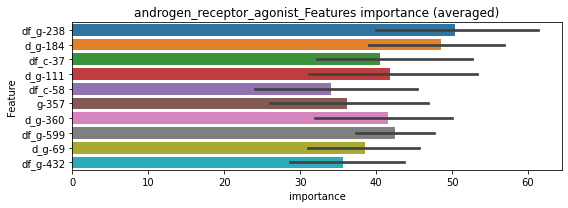

len(train_index) : 3867
len(valid_index) : 3868
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240618	valid_1's binary_logloss: 0.0510667
[200]	training's binary_logloss: 0.00426578	valid_1's binary_logloss: 0.0266347
[300]	training's binary_logloss: 0.00116023	valid_1's binary_logloss: 0.0222989
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000640893	valid_1's binary_logloss: 0.0212223


len(train_index) : 3868
len(valid_index) : 3867
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228936	valid_1's binary_logloss: 0.0483368
[200]	training's binary_logloss: 0.00401591	valid_1's binary_logloss: 0.0244992
[300]	training's binary_logloss: 0.00111508	valid_1's binary_logloss: 0.0194437
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000924353	valid_1's binary_logloss: 0.0189174


androgen_receptor_agonist logloss: 0.020069984242582703


neg labels: 3289 → selected neg labels: 3274


androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673119	valid_1's binary_logloss: 0.145162
[200]	training's binary_logloss: 0.0154016	valid_1's binary_logloss: 0.0925155
[300]	training's binary_logloss: 0.00451389	valid_1's binary_logloss: 0.0805372
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00255232	valid_1's binary_logloss: 0.078746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717915	valid_1's binary_logloss: 0.142163
[200]	training's binary_logloss: 0.0171229	valid_1's binary_logloss: 0.0810551
[300]	training's binary_logloss: 0.00478153	valid_1's binary_logloss: 0.0644439
[400]	training's binary_logloss: 0.00197184	valid_1's binary_logloss: 0.0591041
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00192072	valid_1's binary_logloss: 0.0589577


1 / 3 AUC score:0.990
y_Threshold: 0.0196140, Threshold: 0.0295101, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 174 → Positive_corect_labels: 633/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.02656, conf_1:0.03246
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0295101
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_2: 0.0395101
Num_p_label: 21.0, Expected: 14.9, Adj_threshold_3: 0.0495101
threshold: 0.0495101, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 633.0/3754, y_label_rate: 0.1686201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646742	valid_1's binary_logloss: 0.126591
[200]	training's binary_logloss: 0.0145154	valid_1's binary_logloss: 0.0632211
[300]	training's binary_logloss: 0.00425417	valid_1's binary_logloss: 0.0429613
[400]	training's binary_logloss: 0.00184848	valid_1's binary_logloss: 0.0361508
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00144867	valid_1's binary_logloss: 0.0349075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0622828	valid_1's binary_logloss: 0.141583
[200]	training's binary_logloss: 0.0137613	valid_1's binary_logloss: 0.0849423
[300]	training's binary_logloss: 0.00397692	valid_1's binary_logloss: 0.0691208
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00316116	valid_1's binary_logloss: 0.068012


2 / 3 AUC score:0.998
y_Threshold: 0.0487596, Threshold: 0.0495101, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 618.0/3724
p_label_rate: 0.0143144 Vs.target_rate: 0.00374
Num_p_label: 57.0, conf_0:0.04456, conf_1:0.05446
Num_p_label: 57.0, Expected: 14.9, Adj_threshold_1: 0.0495101
Num_p_label: 44.0, Expected: 14.9, Adj_threshold_2: 0.0595101
Num_p_label: 31.0, Expected: 14.9, Adj_threshold_3: 0.0695101
Num_p_label: 23.0, Expected: 14.9, Adj_threshold_4: 0.0795101
threshold: 0.0795101, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 618.0/3724, y_label_rate: 0.1659506
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0638277	valid_1's binary_logloss: 0.133179
[200]	training's binary_logloss: 0.0139136	valid_1's binary_logloss: 0.0719686
[300]	training's binary_logloss: 0.00394308	valid_1's binary_logloss: 0.0540686
[400]	training's binary_logloss: 0.00171244	valid_1's binary_logloss: 0.0493916
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00148337	valid_1's binary_logloss: 0.0485984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629805	valid_1's binary_logloss: 0.126994
[200]	training's binary_logloss: 0.0136901	valid_1's binary_logloss: 0.0723253
[300]	training's binary_logloss: 0.00401505	valid_1's binary_logloss: 0.0576975
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00271207	valid_1's binary_logloss: 0.0553829


3 / 3 AUC score:0.998
y_Threshold: 0.0515894, Threshold: 0.0795101, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 599.0/3686
p_label_rate: 0.0067805 Vs.target_rate: 0.00374
Num_p_label: 27.0, conf_0:0.07156, conf_1:0.08746
threshold: 0.0795101, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 626.0/7668, y_label_rate: 0.0816380


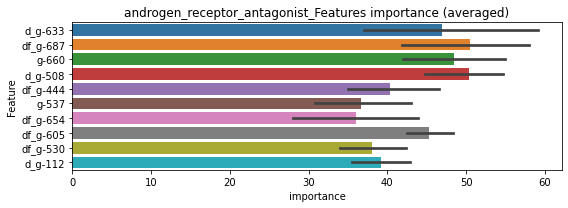

len(train_index) : 3834
len(valid_index) : 3834
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346371	valid_1's binary_logloss: 0.0851677
[200]	training's binary_logloss: 0.00758291	valid_1's binary_logloss: 0.0557642
[300]	training's binary_logloss: 0.00222027	valid_1's binary_logloss: 0.049698
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00137266	valid_1's binary_logloss: 0.0487513


len(train_index) : 3834
len(valid_index) : 3834
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370612	valid_1's binary_logloss: 0.0807696
[200]	training's binary_logloss: 0.00869898	valid_1's binary_logloss: 0.0483873
[300]	training's binary_logloss: 0.00229791	valid_1's binary_logloss: 0.0398751
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00148121	valid_1's binary_logloss: 0.0386466


androgen_receptor_antagonist logloss: 0.04369895729401121


neg labels: 3289 → selected neg labels: 3276


anesthetic_-_local, len(trt): 80, len(othr): 3276, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565748	valid_1's binary_logloss: 0.128867
[200]	training's binary_logloss: 0.0127589	valid_1's binary_logloss: 0.0799741
[300]	training's binary_logloss: 0.0036959	valid_1's binary_logloss: 0.0665684
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00269061	valid_1's binary_logloss: 0.063886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576469	valid_1's binary_logloss: 0.126735
[200]	training's binary_logloss: 0.0136269	valid_1's binary_logloss: 0.0797905
[300]	training's binary_logloss: 0.00395949	valid_1's binary_logloss: 0.0647533
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00205203	valid_1's binary_logloss: 0.061813


1 / 3 AUC score:0.994
y_Threshold: 0.0185815, Threshold: 0.0247264, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 637/3763
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.02225, conf_1:0.02720
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0247264
Num_p_label: 38.0, Expected: 13.4, Adj_threshold_2: 0.0347264
Num_p_label: 23.0, Expected: 13.4, Adj_threshold_3: 0.0447264
threshold: 0.0447264, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 637.0/3763, y_label_rate: 0.1692798
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557896	valid_1's binary_logloss: 0.107985
[200]	training's binary_logloss: 0.011795	valid_1's binary_logloss: 0.0529249
[300]	training's binary_logloss: 0.00345555	valid_1's binary_logloss: 0.0384828
[400]	training's binary_logloss: 0.00156883	valid_1's binary_logloss: 0.0334711
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00125212	valid_1's binary_logloss: 0.0326668
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0560906	valid_1's binary_logloss: 0.114442
[200]	training's binary_logloss: 0.0119224	valid_1's binary_logloss: 0.0625184
[300]	training's binary_logloss: 0.0034995	valid_1's binary_logloss: 0.0507993
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00178968	valid_1's binary_logloss: 0.0473746


2 / 3 AUC score:0.997
y_Threshold: 0.0396398, Threshold: 0.0447264, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 625.0/3739
p_label_rate: 0.0092918 Vs.target_rate: 0.00336
Num_p_label: 37.0, conf_0:0.04025, conf_1:0.04920
threshold: 0.0447264, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 625.0/3739, y_label_rate: 0.1671570
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523421	valid_1's binary_logloss: 0.127564
[200]	training's binary_logloss: 0.0107708	valid_1's binary_logloss: 0.0764577
[300]	training's binary_logloss: 0.0031351	valid_1's binary_logloss: 0.0636927
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00169877	valid_1's binary_logloss: 0.060908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538694	valid_1's binary_logloss: 0.109245
[200]	training's binary_logloss: 0.0112756	valid_1's binary_logloss: 0.0566396
[300]	training's binary_logloss: 0.00329095	valid_1's binary_logloss: 0.0455025
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00292006	valid_1's binary_logloss: 0.0449487


3 / 3 AUC score:0.998
y_Threshold: 0.0353890, Threshold: 0.0447264, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 609.0/3707
p_label_rate: 0.0130588 Vs.target_rate: 0.00336
Num_p_label: 52.0, conf_0:0.04025, conf_1:0.04920
Num_p_label: 52.0, Expected: 13.4, Adj_threshold_1: 0.0447264
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_2: 0.0547264
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_3: 0.0647264
threshold: 0.0647264, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 631.0/7689, y_label_rate: 0.0820653


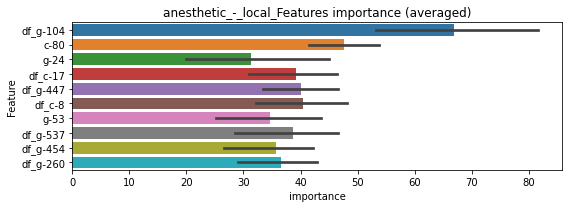

len(train_index) : 3844
len(valid_index) : 3845
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272292	valid_1's binary_logloss: 0.0743851
[200]	training's binary_logloss: 0.00527883	valid_1's binary_logloss: 0.0507991
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.00218959	valid_1's binary_logloss: 0.047023


len(train_index) : 3845
len(valid_index) : 3844
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318185	valid_1's binary_logloss: 0.0701555
[200]	training's binary_logloss: 0.00673873	valid_1's binary_logloss: 0.0442831
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00226449	valid_1's binary_logloss: 0.0398875


anesthetic_-_local logloss: 0.043455756527477775


neg labels: 3289 → selected neg labels: 3283


angiogenesis_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384095	valid_1's binary_logloss: 0.0579588
[200]	training's binary_logloss: 0.00637355	valid_1's binary_logloss: 0.0165247
[300]	training's binary_logloss: 0.00170095	valid_1's binary_logloss: 0.00724983
[400]	training's binary_logloss: 0.000798048	valid_1's binary_logloss: 0.00456893
[500]	training's binary_logloss: 0.000526477	valid_1's binary_logloss: 0.00368707
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000454688	valid_1's binary_logloss: 0.00341684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386633	valid_1's binary_logloss: 0.0650236
[200]	training's binary_logloss: 0.00612061	valid_1's binary_logloss: 0.0230682
[300]	training's binary_logloss: 0.00167638	valid_1's binary_logloss: 0.0142558
[400]	training's binary_logloss: 0.000791647	valid_1's binary_logloss: 0.0125644
Early stopping, best iteration is:
[4

1 / 3 AUC score:1.000
y_Threshold: 0.0045552, Threshold: 0.0074311, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00669, conf_1:0.00817
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0074311
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0174311
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0274311
threshold: 0.0274311, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380458	valid_1's binary_logloss: 0.0584235
[200]	training's binary_logloss: 0.00578415	valid_1's binary_logloss: 0.0160443
[300]	training's binary_logloss: 0.00160703	valid_1's binary_logloss: 0.00793063
[400]	training's binary_logloss: 0.000771822	valid_1's binary_logloss: 0.005581
[500]	training's binary_logloss: 0.000511365	valid_1's binary_logloss: 0.00460351
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000471872	valid_1's binary_logloss: 0.00442974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373631	valid_1's binary_logloss: 0.0610222
[200]	training's binary_logloss: 0.00580514	valid_1's binary_logloss: 0.0193075
[300]	training's binary_logloss: 0.00160185	valid_1's binary_logloss: 0.0115146
[400]	training's binary_logloss: 0.000764583	valid_1's binary_logloss: 0.00986453
Early stopping, best iteration is:
[41

2 / 3 AUC score:1.000
y_Threshold: 0.0344466, Threshold: 0.0274311, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00151
Num_p_label: 33.0, conf_0:0.02469, conf_1:0.03017
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.0274311
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0374311
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0474311
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_4: 0.0574311
threshold: 0.0574311, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374411	valid_1's binary_logloss: 0.0639306
[200]	training's binary_logloss: 0.00578924	valid_1's binary_logloss: 0.0215357
[300]	training's binary_logloss: 0.00159462	valid_1's binary_logloss: 0.0136129
[400]	training's binary_logloss: 0.000771795	valid_1's binary_logloss: 0.011255
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.00069038	valid_1's binary_logloss: 0.011038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03726	valid_1's binary_logloss: 0.0556615
[200]	training's binary_logloss: 0.00569648	valid_1's binary_logloss: 0.0140112
[300]	training's binary_logloss: 0.0015777	valid_1's binary_logloss: 0.00638169
[400]	training's binary_logloss: 0.000763671	valid_1's binary_logloss: 0.00431909
[500]	training's binary_logloss: 0.000511821	valid_1's binary_logloss: 0.00354365
Early stopping, best iteration is:
[568]	tra

3 / 3 AUC score:1.000
y_Threshold: 0.0349465, Threshold: 0.0574311, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0012557 Vs.target_rate: 0.00151
Num_p_label: 5.0, conf_0:0.05169, conf_1:0.06317
threshold: 0.0574311, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 660.0/7787, y_label_rate: 0.0847566


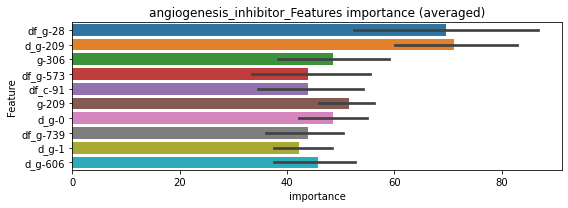

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207595	valid_1's binary_logloss: 0.0413161
[200]	training's binary_logloss: 0.00308946	valid_1's binary_logloss: 0.0181751
[300]	training's binary_logloss: 0.00083031	valid_1's binary_logloss: 0.0140084
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00065807	valid_1's binary_logloss: 0.0134969


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211727	valid_1's binary_logloss: 0.0373589
[200]	training's binary_logloss: 0.00342933	valid_1's binary_logloss: 0.0150095
[300]	training's binary_logloss: 0.000907097	valid_1's binary_logloss: 0.0103655
[400]	training's binary_logloss: 0.000423583	valid_1's binary_logloss: 0.00899357
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000310146	valid_1's binary_logloss: 0.00847997


angiogenesis_inhibitor logloss: 0.010988734573074223


neg labels: 3289 → selected neg labels: 3283


angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372952	valid_1's binary_logloss: 0.0655225
[200]	training's binary_logloss: 0.00585845	valid_1's binary_logloss: 0.0259627
[300]	training's binary_logloss: 0.00158433	valid_1's binary_logloss: 0.0163118
[400]	training's binary_logloss: 0.000760737	valid_1's binary_logloss: 0.0138125
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000605079	valid_1's binary_logloss: 0.013375
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392326	valid_1's binary_logloss: 0.0677178
[200]	training's binary_logloss: 0.00613453	valid_1's binary_logloss: 0.0242941
[300]	training's binary_logloss: 0.00166823	valid_1's binary_logloss: 0.0143265
[400]	training's binary_logloss: 0.000782407	valid_1's binary_logloss: 0.0111416
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00075626	valid_1's binary_logloss: 0.0110296


1 / 3 AUC score:1.000
y_Threshold: 0.0052573, Threshold: 0.0067943, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00611, conf_1:0.00747
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0067943
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_2: 0.0167943
Num_p_label: 5.0, Expected: 6.2, Adj_threshold_3: 0.0267943
threshold: 0.0267943, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369154	valid_1's binary_logloss: 0.0627549
[200]	training's binary_logloss: 0.00568745	valid_1's binary_logloss: 0.0267549
[300]	training's binary_logloss: 0.00154651	valid_1's binary_logloss: 0.0181859
[400]	training's binary_logloss: 0.000745753	valid_1's binary_logloss: 0.0160119
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000781429	valid_1's binary_logloss: 0.0158996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375858	valid_1's binary_logloss: 0.0640151
[200]	training's binary_logloss: 0.00573838	valid_1's binary_logloss: 0.022031
[300]	training's binary_logloss: 0.00158437	valid_1's binary_logloss: 0.0131674
[400]	training's binary_logloss: 0.000749974	valid_1's binary_logloss: 0.0100936
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000553195	valid_1's binary_logloss: 0.00950529


2 / 3 AUC score:1.000
y_Threshold: 0.0375199, Threshold: 0.0267943, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0050226 Vs.target_rate: 0.00155
Num_p_label: 20.0, conf_0:0.02411, conf_1:0.02947
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.0267943
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.0367943
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_3: 0.0467943
threshold: 0.0467943, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369154	valid_1's binary_logloss: 0.0627549
[200]	training's binary_logloss: 0.00568745	valid_1's binary_logloss: 0.0267549
[300]	training's binary_logloss: 0.00154651	valid_1's binary_logloss: 0.0181859
[400]	training's binary_logloss: 0.000745753	valid_1's binary_logloss: 0.0160119
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000781429	valid_1's binary_logloss: 0.0158996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375858	valid_1's binary_logloss: 0.0640151
[200]	training's binary_logloss: 0.00573838	valid_1's binary_logloss: 0.022031
[300]	training's binary_logloss: 0.00158437	valid_1's binary_logloss: 0.0131674
[400]	training's binary_logloss: 0.000749974	valid_1's binary_logloss: 0.0100936
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000553195	valid_1's binary_logloss: 0.00950529


3 / 3 AUC score:1.000
y_Threshold: 0.0375199, Threshold: 0.0467943, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0020090 Vs.target_rate: 0.00155
Num_p_label: 8.0, conf_0:0.04211, conf_1:0.05147
threshold: 0.0467943, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 664.0/7789, y_label_rate: 0.0852484


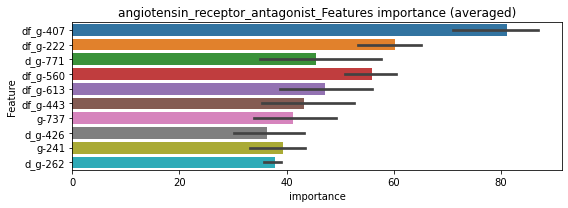

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215882	valid_1's binary_logloss: 0.0427101
[200]	training's binary_logloss: 0.00320964	valid_1's binary_logloss: 0.0216117
[300]	training's binary_logloss: 0.00084038	valid_1's binary_logloss: 0.0178401
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000726527	valid_1's binary_logloss: 0.0176959


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216517	valid_1's binary_logloss: 0.0360185
[200]	training's binary_logloss: 0.00342563	valid_1's binary_logloss: 0.013746
[300]	training's binary_logloss: 0.000913011	valid_1's binary_logloss: 0.00943283
[400]	training's binary_logloss: 0.000421962	valid_1's binary_logloss: 0.00833919
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000431392	valid_1's binary_logloss: 0.00832206


angiotensin_receptor_antagonist logloss: 0.013009567293174783


neg labels: 3289 → selected neg labels: 3277


anti-inflammatory, len(trt): 73, len(othr): 3277, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549227	valid_1's binary_logloss: 0.0999014
[200]	training's binary_logloss: 0.0111637	valid_1's binary_logloss: 0.0450231
[300]	training's binary_logloss: 0.00316429	valid_1's binary_logloss: 0.0307879
[400]	training's binary_logloss: 0.00140013	valid_1's binary_logloss: 0.026441
[500]	training's binary_logloss: 0.000863402	valid_1's binary_logloss: 0.0248436
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000731768	valid_1's binary_logloss: 0.0242945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515629	valid_1's binary_logloss: 0.106575
[200]	training's binary_logloss: 0.0103303	valid_1's binary_logloss: 0.0573135
[300]	training's binary_logloss: 0.0030343	valid_1's binary_logloss: 0.0445735
[400]	training's binary_logloss: 0.00146212	valid_1's binary_logloss: 0.0407623
Early stopping, best iteration is:
[405]	trainin

1 / 3 AUC score:0.995
y_Threshold: 0.0112432, Threshold: 0.0199226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 645/3780
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01793, conf_1:0.02191
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0199226
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_2: 0.0299226
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_3: 0.0399226
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.0499226
threshold: 0.0499226, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 645.0/3780, y_label_rate: 0.1706349
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478699	valid_1's binary_logloss: 0.107433
[200]	training's binary_logloss: 0.00900945	valid_1's binary_logloss: 0.0599289
[300]	training's binary_logloss: 0.00262137	valid_1's binary_logloss: 0.048997
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00190418	valid_1's binary_logloss: 0.0469946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480667	valid_1's binary_logloss: 0.103091
[200]	training's binary_logloss: 0.00921661	valid_1's binary_logloss: 0.0548208
[300]	training's binary_logloss: 0.00260635	valid_1's binary_logloss: 0.0440848
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0017657	valid_1's binary_logloss: 0.0425225


2 / 3 AUC score:0.998
y_Threshold: 0.0435848, Threshold: 0.0499226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 629.0/3748
p_label_rate: 0.0170768 Vs.target_rate: 0.00307
Num_p_label: 68.0, conf_0:0.04493, conf_1:0.05491
Num_p_label: 68.0, Expected: 12.2, Adj_threshold_1: 0.0499226
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_2: 0.0599226
Num_p_label: 46.0, Expected: 12.2, Adj_threshold_3: 0.0699226
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_4: 0.0799226
Num_p_label: 34.0, Expected: 12.2, Adj_threshold_5: 0.0899226
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_6: 0.0999226
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_7: 0.1099226
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_8: 0.1199226
threshold: 0.1199226, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 629.0/3748, y_label_rate: 0.1678228
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474424	valid_1's binary_logloss: 0.0898907
[200]	training's binary_logloss: 0.00875554	valid_1's binary_logloss: 0.041912
[300]	training's binary_logloss: 0.00249556	valid_1's binary_logloss: 0.0300652
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00135883	valid_1's binary_logloss: 0.0270866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501953	valid_1's binary_logloss: 0.0948874
[200]	training's binary_logloss: 0.00942078	valid_1's binary_logloss: 0.0416546
[300]	training's binary_logloss: 0.00267552	valid_1's binary_logloss: 0.0310461
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00211542	valid_1's binary_logloss: 0.0296721


3 / 3 AUC score:1.000
y_Threshold: 0.0476515, Threshold: 0.1199226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 623.0/3736
p_label_rate: 0.0050226 Vs.target_rate: 0.00307
Num_p_label: 20.0, conf_0:0.10793, conf_1:0.13191
threshold: 0.1199226, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 643.0/7718, y_label_rate: 0.0833117


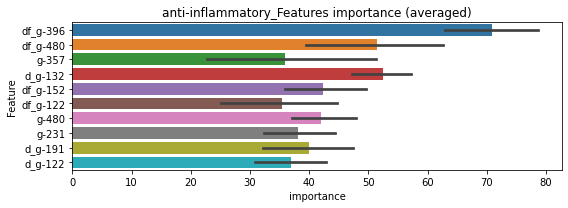

len(train_index) : 3859
len(valid_index) : 3859
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255756	valid_1's binary_logloss: 0.0543654
[200]	training's binary_logloss: 0.0048702	valid_1's binary_logloss: 0.0287725
[300]	training's binary_logloss: 0.00136576	valid_1's binary_logloss: 0.0228945
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000672237	valid_1's binary_logloss: 0.0213891


len(train_index) : 3859
len(valid_index) : 3859
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257068	valid_1's binary_logloss: 0.062139
[200]	training's binary_logloss: 0.0048328	valid_1's binary_logloss: 0.0389888
[300]	training's binary_logloss: 0.00139178	valid_1's binary_logloss: 0.0350461
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00140661	valid_1's binary_logloss: 0.0350121


anti-inflammatory logloss: 0.02820059832318252


neg labels: 3289 → selected neg labels: 3285


antiarrhythmic, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266651	valid_1's binary_logloss: 0.0446389
[200]	training's binary_logloss: 0.00348465	valid_1's binary_logloss: 0.0165924
[300]	training's binary_logloss: 0.000982752	valid_1's binary_logloss: 0.0113644
[400]	training's binary_logloss: 0.000498353	valid_1's binary_logloss: 0.00987492
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000421324	valid_1's binary_logloss: 0.00957397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279179	valid_1's binary_logloss: 0.0377709
[200]	training's binary_logloss: 0.00371369	valid_1's binary_logloss: 0.00699982
[300]	training's binary_logloss: 0.00103235	valid_1's binary_logloss: 0.00268366
[400]	training's binary_logloss: 0.000510593	valid_1's binary_logloss: 0.0016223
[500]	training's binary_logloss: 0.000391282	valid_1's binary_logloss: 0.00138021
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0017968, Threshold: 0.0181499, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.01633, conf_1:0.01996
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0181499
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_2: 0.0281499
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_3: 0.0381499
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_4: 0.0481499
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_5: 0.0581499
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_6: 0.0681499
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_7: 0.0781499
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_8: 0.0881499
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_9: 0.0981499
threshold: 0.0981499, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254305	valid_1's binary_logloss: 0.0425495
[200]	training's binary_logloss: 0.00316104	valid_1's binary_logloss: 0.0129006
[300]	training's binary_logloss: 0.000901205	valid_1's binary_logloss: 0.00871989
[400]	training's binary_logloss: 0.000464067	valid_1's binary_logloss: 0.00721657
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000452582	valid_1's binary_logloss: 0.00721259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273809	valid_1's binary_logloss: 0.0349327
[200]	training's binary_logloss: 0.00350864	valid_1's binary_logloss: 0.00586671
[300]	training's binary_logloss: 0.000972951	valid_1's binary_logloss: 0.00192196
[400]	training's binary_logloss: 0.000494103	valid_1's binary_logloss: 0.00106767
[500]	training's binary_logloss: 0.000374773	valid_1's binary_logloss: 0.000863027
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0349556, Threshold: 0.0981499, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0349071 Vs.target_rate: 0.00101
Num_p_label: 139.0, conf_0:0.08833, conf_1:0.10796
Num_p_label: 139.0, Expected: 4.0, Adj_threshold_1: 0.0981499
Num_p_label: 135.0, Expected: 4.0, Adj_threshold_2: 0.1081499
Num_p_label: 133.0, Expected: 4.0, Adj_threshold_3: 0.1181499
Num_p_label: 127.0, Expected: 4.0, Adj_threshold_4: 0.1281499
Num_p_label: 123.0, Expected: 4.0, Adj_threshold_5: 0.1381499
Num_p_label: 120.0, Expected: 4.0, Adj_threshold_6: 0.1481499
Num_p_label: 114.0, Expected: 4.0, Adj_threshold_7: 0.1581499
Num_p_label: 110.0, Expected: 4.0, Adj_threshold_8: 0.1681499
Num_p_label: 108.0, Expected: 4.0, Adj_threshold_9: 0.1781499
Num_p_label: 104.0, Expected: 4.0, Adj_threshold_10: 0.1881499
threshold: 0.1981499, positive_p_label: 100.0/3982, p_label_rate: 0.0251130
positive_y_label: 656.0/3808, y_label_rate: 0.17226

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026608	valid_1's binary_logloss: 0.0389684
[200]	training's binary_logloss: 0.00335155	valid_1's binary_logloss: 0.00853841
[300]	training's binary_logloss: 0.000936139	valid_1's binary_logloss: 0.004356
[400]	training's binary_logloss: 0.000476938	valid_1's binary_logloss: 0.00364013
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000412787	valid_1's binary_logloss: 0.00355393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026955	valid_1's binary_logloss: 0.0386061
[200]	training's binary_logloss: 0.0033096	valid_1's binary_logloss: 0.00829481
[300]	training's binary_logloss: 0.000931838	valid_1's binary_logloss: 0.0038101
[400]	training's binary_logloss: 0.000482063	valid_1's binary_logloss: 0.00254312
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000378661	valid_1's binary_logloss: 0.00229827


3 / 3 AUC score:1.000
y_Threshold: 0.0226476, Threshold: 0.1981499, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0258664 Vs.target_rate: 0.00101
Num_p_label: 103.0, conf_0:0.17833, conf_1:0.21796
Num_p_label: 103.0, Expected: 4.0, Adj_threshold_1: 0.1981499
Num_p_label: 100.0, Expected: 4.0, Adj_threshold_2: 0.2081499
Num_p_label: 96.0, Expected: 4.0, Adj_threshold_3: 0.2181499
Num_p_label: 92.0, Expected: 4.0, Adj_threshold_4: 0.2281499
Num_p_label: 88.0, Expected: 4.0, Adj_threshold_5: 0.2381499
Num_p_label: 86.0, Expected: 4.0, Adj_threshold_6: 0.2481499
Num_p_label: 82.0, Expected: 4.0, Adj_threshold_7: 0.2581499
Num_p_label: 81.0, Expected: 4.0, Adj_threshold_8: 0.2681499
Num_p_label: 78.0, Expected: 4.0, Adj_threshold_9: 0.2781499
Num_p_label: 77.0, Expected: 4.0, Adj_threshold_10: 0.2881499
threshold: 0.2981499, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 729.0/7788, y_label_rate: 0.0936055


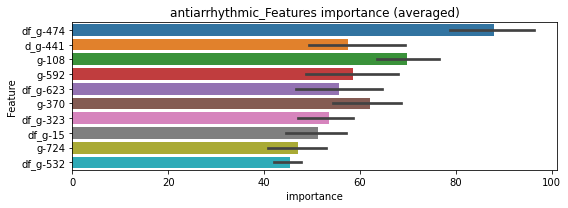

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185074	valid_1's binary_logloss: 0.0313124
[200]	training's binary_logloss: 0.00274295	valid_1's binary_logloss: 0.0126517
[300]	training's binary_logloss: 0.000756789	valid_1's binary_logloss: 0.00952432
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000485124	valid_1's binary_logloss: 0.00896775


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181932	valid_1's binary_logloss: 0.0315933
[200]	training's binary_logloss: 0.0027197	valid_1's binary_logloss: 0.0146673
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.000885863	valid_1's binary_logloss: 0.0125659


antiarrhythmic logloss: 0.010766835826343503


neg labels: 3289 → selected neg labels: 3281


antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0418316	valid_1's binary_logloss: 0.0687104
[200]	training's binary_logloss: 0.00688899	valid_1's binary_logloss: 0.0182366
[300]	training's binary_logloss: 0.00191425	valid_1's binary_logloss: 0.00812298
[400]	training's binary_logloss: 0.00088937	valid_1's binary_logloss: 0.00511461
[500]	training's binary_logloss: 0.000580222	valid_1's binary_logloss: 0.00422328
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000502147	valid_1's binary_logloss: 0.00390822
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421572	valid_1's binary_logloss: 0.0741428
[200]	training's binary_logloss: 0.00699247	valid_1's binary_logloss: 0.0237825
[300]	training's binary_logloss: 0.00189838	valid_1's binary_logloss: 0.0117619
[400]	training's binary_logloss: 0.000877048	valid_1's binary_logloss: 0.00836016
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0041585, Threshold: 0.0068940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00181
Num_p_label: 80.0, conf_0:0.00620, conf_1:0.00758
Num_p_label: 80.0, Expected: 7.2, Adj_threshold_1: 0.0068940
Num_p_label: 30.0, Expected: 7.2, Adj_threshold_2: 0.0168940
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_3: 0.0268940
Num_p_label: 8.0, Expected: 7.2, Adj_threshold_4: 0.0368940
threshold: 0.0368940, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412231	valid_1's binary_logloss: 0.0707228
[200]	training's binary_logloss: 0.00644235	valid_1's binary_logloss: 0.0191166
[300]	training's binary_logloss: 0.00180638	valid_1's binary_logloss: 0.00904904
[400]	training's binary_logloss: 0.000869358	valid_1's binary_logloss: 0.00700548
[500]	training's binary_logloss: 0.000565524	valid_1's binary_logloss: 0.00568029
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.000491749	valid_1's binary_logloss: 0.00542566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423109	valid_1's binary_logloss: 0.0715574
[200]	training's binary_logloss: 0.00699957	valid_1's binary_logloss: 0.022763
[300]	training's binary_logloss: 0.00190071	valid_1's binary_logloss: 0.01173
[400]	training's binary_logloss: 0.00088019	valid_1's binary_logloss: 0.00868182
[500]	training's binary_logloss: 0.00056

2 / 3 AUC score:1.000
y_Threshold: 0.0622340, Threshold: 0.0368940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0065294 Vs.target_rate: 0.00181
Num_p_label: 26.0, conf_0:0.03320, conf_1:0.04058
Num_p_label: 26.0, Expected: 7.2, Adj_threshold_1: 0.0368940
Num_p_label: 17.0, Expected: 7.2, Adj_threshold_2: 0.0468940
Num_p_label: 12.0, Expected: 7.2, Adj_threshold_3: 0.0568940
threshold: 0.0568940, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0421768	valid_1's binary_logloss: 0.069511
[200]	training's binary_logloss: 0.00666503	valid_1's binary_logloss: 0.0188763
[300]	training's binary_logloss: 0.00185186	valid_1's binary_logloss: 0.0084776
[400]	training's binary_logloss: 0.000869403	valid_1's binary_logloss: 0.00543754
[500]	training's binary_logloss: 0.000567241	valid_1's binary_logloss: 0.00451718
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000491413	valid_1's binary_logloss: 0.004288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415051	valid_1's binary_logloss: 0.0719722
[200]	training's binary_logloss: 0.00632725	valid_1's binary_logloss: 0.0276613
[300]	training's binary_logloss: 0.00172658	valid_1's binary_logloss: 0.0184077
[400]	training's binary_logloss: 0.000836049	valid_1's binary_logloss: 0.0156092
Early stopping, best iteration is:
[451]	

3 / 3 AUC score:1.000
y_Threshold: 0.0350677, Threshold: 0.0568940, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0040181 Vs.target_rate: 0.00181
Num_p_label: 16.0, conf_0:0.05120, conf_1:0.06258
threshold: 0.0568940, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 670.0/7783, y_label_rate: 0.0860851


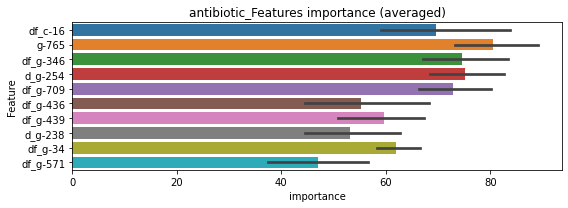

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247793	valid_1's binary_logloss: 0.046877
[200]	training's binary_logloss: 0.00408491	valid_1's binary_logloss: 0.0211591
[300]	training's binary_logloss: 0.00108657	valid_1's binary_logloss: 0.0159837
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000908192	valid_1's binary_logloss: 0.015859


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0240907	valid_1's binary_logloss: 0.0424022
[200]	training's binary_logloss: 0.00403644	valid_1's binary_logloss: 0.015649
[300]	training's binary_logloss: 0.00107993	valid_1's binary_logloss: 0.00987824
[400]	training's binary_logloss: 0.000496231	valid_1's binary_logloss: 0.00824686
[500]	training's binary_logloss: 0.000313452	valid_1's binary_logloss: 0.00773163
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000306796	valid_1's binary_logloss: 0.00770045


antibiotic logloss: 0.011780258421343346


neg labels: 3289 → selected neg labels: 3286


anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227469	valid_1's binary_logloss: 0.0294518
[200]	training's binary_logloss: 0.00266516	valid_1's binary_logloss: 0.00527367
[300]	training's binary_logloss: 0.000760193	valid_1's binary_logloss: 0.00199778
[400]	training's binary_logloss: 0.000410192	valid_1's binary_logloss: 0.00125801
[500]	training's binary_logloss: 0.000328261	valid_1's binary_logloss: 0.00107774
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00031988	valid_1's binary_logloss: 0.00106096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230888	valid_1's binary_logloss: 0.0295647
[200]	training's binary_logloss: 0.00268237	valid_1's binary_logloss: 0.00499057
[300]	training's binary_logloss: 0.000753685	valid_1's binary_logloss: 0.00196802
[400]	training's binary_logloss: 0.000404812	valid_1's binary_logloss: 0.00136416
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0016800, Threshold: 0.0023903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00215, conf_1:0.00263
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0023903
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0123903
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_3: 0.0223903
threshold: 0.0223903, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226753	valid_1's binary_logloss: 0.0285843
[200]	training's binary_logloss: 0.00260576	valid_1's binary_logloss: 0.00492567
[300]	training's binary_logloss: 0.000742823	valid_1's binary_logloss: 0.00183662
[400]	training's binary_logloss: 0.000396817	valid_1's binary_logloss: 0.00112726
[500]	training's binary_logloss: 0.000323186	valid_1's binary_logloss: 0.000978464
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000314781	valid_1's binary_logloss: 0.000966839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226263	valid_1's binary_logloss: 0.028799
[200]	training's binary_logloss: 0.00259397	valid_1's binary_logloss: 0.00424377
[300]	training's binary_logloss: 0.000740231	valid_1's binary_logloss: 0.00148218
[400]	training's binary_logloss: 0.000399787	valid_1's binary_logloss: 0.000911189
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1329976, Threshold: 0.0223903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.02015, conf_1:0.02463
threshold: 0.0223903, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226753	valid_1's binary_logloss: 0.0285843
[200]	training's binary_logloss: 0.00260576	valid_1's binary_logloss: 0.00492567
[300]	training's binary_logloss: 0.000742823	valid_1's binary_logloss: 0.00183662
[400]	training's binary_logloss: 0.000396817	valid_1's binary_logloss: 0.00112726
[500]	training's binary_logloss: 0.000323186	valid_1's binary_logloss: 0.000978464
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000314781	valid_1's binary_logloss: 0.000966839
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226263	valid_1's binary_logloss: 0.028799
[200]	training's binary_logloss: 0.00259397	valid_1's binary_logloss: 0.00424377
[300]	training's binary_logloss: 0.000740231	valid_1's binary_logloss: 0.00148218
[400]	training's binary_logloss: 0.000399787	valid_1's binary_logloss: 0.000911189
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1329976, Threshold: 0.0223903, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.02015, conf_1:0.02463
threshold: 0.0223903, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


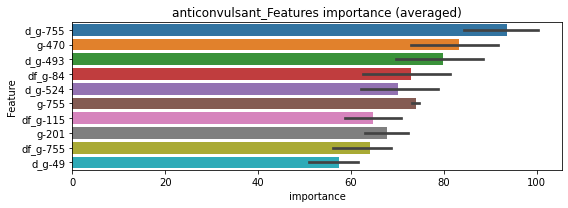

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127578	valid_1's binary_logloss: 0.0200682
[200]	training's binary_logloss: 0.00145232	valid_1's binary_logloss: 0.00738636
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000818517	valid_1's binary_logloss: 0.00676209


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013327	valid_1's binary_logloss: 0.017573
[200]	training's binary_logloss: 0.00158502	valid_1's binary_logloss: 0.00391209
[300]	training's binary_logloss: 0.000434019	valid_1's binary_logloss: 0.00232534
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000251019	valid_1's binary_logloss: 0.00208436


anticonvulsant logloss: 0.004423525962332667


neg labels: 3289 → selected neg labels: 3284


antifungal, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290646	valid_1's binary_logloss: 0.0426106
[200]	training's binary_logloss: 0.00379877	valid_1's binary_logloss: 0.00941155
[300]	training's binary_logloss: 0.00105861	valid_1's binary_logloss: 0.00428726
[400]	training's binary_logloss: 0.000535596	valid_1's binary_logloss: 0.00295856
[500]	training's binary_logloss: 0.000395885	valid_1's binary_logloss: 0.00253191
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000377403	valid_1's binary_logloss: 0.00247014
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028905	valid_1's binary_logloss: 0.0463253
[200]	training's binary_logloss: 0.00390088	valid_1's binary_logloss: 0.0118413
[300]	training's binary_logloss: 0.00109011	valid_1's binary_logloss: 0.00544265
[400]	training's binary_logloss: 0.000539191	valid_1's binary_logloss: 0.00347309
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0018280, Threshold: 0.0025289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00228, conf_1:0.00278
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0025289
Num_p_label: 2.0, Expected: 4.3, Adj_threshold_2: 0.0125289
threshold: 0.0125289, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296614	valid_1's binary_logloss: 0.042117
[200]	training's binary_logloss: 0.0038209	valid_1's binary_logloss: 0.0087375
[300]	training's binary_logloss: 0.00106522	valid_1's binary_logloss: 0.00357097
[400]	training's binary_logloss: 0.000538493	valid_1's binary_logloss: 0.00226203
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000403592	valid_1's binary_logloss: 0.00192539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296296	valid_1's binary_logloss: 0.0468111
[200]	training's binary_logloss: 0.00387244	valid_1's binary_logloss: 0.0110614
[300]	training's binary_logloss: 0.00108227	valid_1's binary_logloss: 0.00496381
[400]	training's binary_logloss: 0.000541448	valid_1's binary_logloss: 0.00337376
[500]	training's binary_logloss: 0.000393661	valid_1's binary_logloss: 0.0028305
Early stopping, best iteration is:
[49

2 / 3 AUC score:1.000
y_Threshold: 0.0654183, Threshold: 0.0125289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00109
Num_p_label: 10.0, conf_0:0.01128, conf_1:0.01378
threshold: 0.0125289, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296614	valid_1's binary_logloss: 0.042117
[200]	training's binary_logloss: 0.0038209	valid_1's binary_logloss: 0.0087375
[300]	training's binary_logloss: 0.00106522	valid_1's binary_logloss: 0.00357097
[400]	training's binary_logloss: 0.000538493	valid_1's binary_logloss: 0.00226203
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000403592	valid_1's binary_logloss: 0.00192539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296296	valid_1's binary_logloss: 0.0468111
[200]	training's binary_logloss: 0.00387244	valid_1's binary_logloss: 0.0110614
[300]	training's binary_logloss: 0.00108227	valid_1's binary_logloss: 0.00496381
[400]	training's binary_logloss: 0.000541448	valid_1's binary_logloss: 0.00337376
[500]	training's binary_logloss: 0.000393661	valid_1's binary_logloss: 0.0028305
Early stopping, best iteration is:
[49

3 / 3 AUC score:1.000
y_Threshold: 0.0654183, Threshold: 0.0125289, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00109
Num_p_label: 10.0, conf_0:0.01128, conf_1:0.01378
threshold: 0.0125289, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


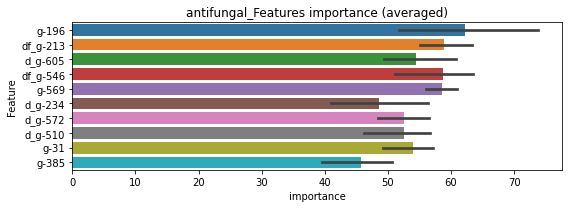

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156565	valid_1's binary_logloss: 0.0267433
[200]	training's binary_logloss: 0.00200801	valid_1's binary_logloss: 0.0107587
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000648287	valid_1's binary_logloss: 0.00939151


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0166417	valid_1's binary_logloss: 0.0286665
[200]	training's binary_logloss: 0.00212645	valid_1's binary_logloss: 0.0106236
[300]	training's binary_logloss: 0.000587556	valid_1's binary_logloss: 0.00855695
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000436227	valid_1's binary_logloss: 0.00812401


antifungal logloss: 0.008757761833639334


neg labels: 3289 → selected neg labels: 3286


antihistamine, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232422	valid_1's binary_logloss: 0.0327802
[200]	training's binary_logloss: 0.0027117	valid_1's binary_logloss: 0.00620467
[300]	training's binary_logloss: 0.00075991	valid_1's binary_logloss: 0.00239289
[400]	training's binary_logloss: 0.000405406	valid_1's binary_logloss: 0.00145665
[500]	training's binary_logloss: 0.000323512	valid_1's binary_logloss: 0.00124427
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000316466	valid_1's binary_logloss: 0.00123141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0237603	valid_1's binary_logloss: 0.0302432
[200]	training's binary_logloss: 0.00280422	valid_1's binary_logloss: 0.00477963
[300]	training's binary_logloss: 0.000782081	valid_1's binary_logloss: 0.00179897
[400]	training's binary_logloss: 0.000412126	valid_1's binary_logloss: 0.00123614
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0016564, Threshold: 0.0028258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00254, conf_1:0.00311
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028258
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0128258
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.0228258
threshold: 0.0228258, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227732	valid_1's binary_logloss: 0.0317634
[200]	training's binary_logloss: 0.00260075	valid_1's binary_logloss: 0.00568645
[300]	training's binary_logloss: 0.000738043	valid_1's binary_logloss: 0.00213476
[400]	training's binary_logloss: 0.000396826	valid_1's binary_logloss: 0.00131131
[500]	training's binary_logloss: 0.000321572	valid_1's binary_logloss: 0.00115106
[600]	training's binary_logloss: 0.000312892	valid_1's binary_logloss: 0.00113133
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000312791	valid_1's binary_logloss: 0.0011313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235361	valid_1's binary_logloss: 0.030346
[200]	training's binary_logloss: 0.00272684	valid_1's binary_logloss: 0.00475563
[300]	training's binary_logloss: 0.000761358	valid_1's binary_logloss: 0.00165562
[400]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1250206, Threshold: 0.0228258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00076
Num_p_label: 13.0, conf_0:0.02054, conf_1:0.02511
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.0228258
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0328258
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0428258
threshold: 0.0428258, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227732	valid_1's binary_logloss: 0.0317634
[200]	training's binary_logloss: 0.00260075	valid_1's binary_logloss: 0.00568645
[300]	training's binary_logloss: 0.000738043	valid_1's binary_logloss: 0.00213476
[400]	training's binary_logloss: 0.000396826	valid_1's binary_logloss: 0.00131131
[500]	training's binary_logloss: 0.000321572	valid_1's binary_logloss: 0.00115106
[600]	training's binary_logloss: 0.000312892	valid_1's binary_logloss: 0.00113133
Early stopping, best iteration is:
[602]	training's binary_logloss: 0.000312791	valid_1's binary_logloss: 0.0011313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235361	valid_1's binary_logloss: 0.030346
[200]	training's binary_logloss: 0.00272684	valid_1's binary_logloss: 0.00475563
[300]	training's binary_logloss: 0.000761358	valid_1's binary_logloss: 0.00165562
[400]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1250206, Threshold: 0.0428258, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076
Num_p_label: 4.0, conf_0:0.03854, conf_1:0.04711
threshold: 0.0428258, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


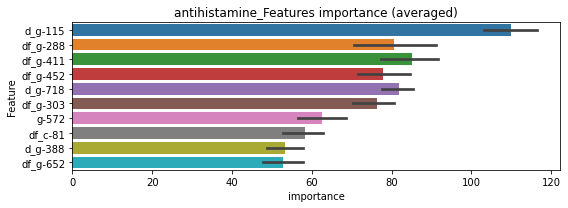

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127463	valid_1's binary_logloss: 0.0197157
[200]	training's binary_logloss: 0.00146766	valid_1's binary_logloss: 0.00626055
[300]	training's binary_logloss: 0.00040231	valid_1's binary_logloss: 0.00432456
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000242863	valid_1's binary_logloss: 0.00411897


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131325	valid_1's binary_logloss: 0.0168675
[200]	training's binary_logloss: 0.00152181	valid_1's binary_logloss: 0.00319194
[300]	training's binary_logloss: 0.000413329	valid_1's binary_logloss: 0.00166972
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000227351	valid_1's binary_logloss: 0.00142717


antihistamine logloss: 0.0027732429056993944


neg labels: 3289 → selected neg labels: 3286


antimalarial, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223058	valid_1's binary_logloss: 0.0273802
[200]	training's binary_logloss: 0.00261611	valid_1's binary_logloss: 0.00390818
[300]	training's binary_logloss: 0.000750777	valid_1's binary_logloss: 0.00129309
[400]	training's binary_logloss: 0.000406083	valid_1's binary_logloss: 0.000756952
[500]	training's binary_logloss: 0.000328321	valid_1's binary_logloss: 0.00063575
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000326022	valid_1's binary_logloss: 0.000631968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229711	valid_1's binary_logloss: 0.0328746
[200]	training's binary_logloss: 0.00266506	valid_1's binary_logloss: 0.00564796
[300]	training's binary_logloss: 0.000756513	valid_1's binary_logloss: 0.00219471
[400]	training's binary_logloss: 0.000408265	valid_1's binary_logloss: 0.0013458
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0013404, Threshold: 0.0019553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00176, conf_1:0.00215
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0019553
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0119553
threshold: 0.0119553, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225388	valid_1's binary_logloss: 0.0280928
[200]	training's binary_logloss: 0.00259393	valid_1's binary_logloss: 0.00393437
[300]	training's binary_logloss: 0.00073469	valid_1's binary_logloss: 0.00133475
[400]	training's binary_logloss: 0.000401125	valid_1's binary_logloss: 0.000792819
[500]	training's binary_logloss: 0.000326503	valid_1's binary_logloss: 0.000670176
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000319663	valid_1's binary_logloss: 0.000660266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228439	valid_1's binary_logloss: 0.0330638
[200]	training's binary_logloss: 0.00264839	valid_1's binary_logloss: 0.0058749
[300]	training's binary_logloss: 0.000753131	valid_1's binary_logloss: 0.0022039
[400]	training's binary_logloss: 0.000403165	valid_1's binary_logloss: 0.00140045
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1216218, Threshold: 0.0119553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00076
Num_p_label: 7.0, conf_0:0.01076, conf_1:0.01315
threshold: 0.0119553, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225388	valid_1's binary_logloss: 0.0280928
[200]	training's binary_logloss: 0.00259393	valid_1's binary_logloss: 0.00393437
[300]	training's binary_logloss: 0.00073469	valid_1's binary_logloss: 0.00133475
[400]	training's binary_logloss: 0.000401125	valid_1's binary_logloss: 0.000792819
[500]	training's binary_logloss: 0.000326503	valid_1's binary_logloss: 0.000670176
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000319663	valid_1's binary_logloss: 0.000660266
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228439	valid_1's binary_logloss: 0.0330638
[200]	training's binary_logloss: 0.00264839	valid_1's binary_logloss: 0.0058749
[300]	training's binary_logloss: 0.000753131	valid_1's binary_logloss: 0.0022039
[400]	training's binary_logloss: 0.000403165	valid_1's binary_logloss: 0.00140045
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1216218, Threshold: 0.0119553, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00076
Num_p_label: 7.0, conf_0:0.01076, conf_1:0.01315
threshold: 0.0119553, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7793, y_label_rate: 0.0852047


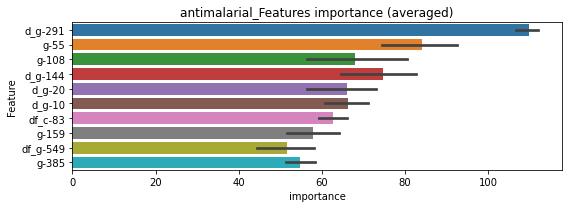

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121717	valid_1's binary_logloss: 0.0196528
[200]	training's binary_logloss: 0.00138982	valid_1's binary_logloss: 0.00837179
[300]	training's binary_logloss: 0.000385244	valid_1's binary_logloss: 0.00744001
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.000410919	valid_1's binary_logloss: 0.00741008


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125684	valid_1's binary_logloss: 0.0184571
[200]	training's binary_logloss: 0.00151315	valid_1's binary_logloss: 0.00497524
[300]	training's binary_logloss: 0.00041503	valid_1's binary_logloss: 0.00344194
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000280848	valid_1's binary_logloss: 0.00322637


antimalarial logloss: 0.005318493072559513


neg labels: 3289 → selected neg labels: 3278


antioxidant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572539	valid_1's binary_logloss: 0.11944
[200]	training's binary_logloss: 0.012331	valid_1's binary_logloss: 0.0701358
[300]	training's binary_logloss: 0.00349766	valid_1's binary_logloss: 0.0592785
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00246218	valid_1's binary_logloss: 0.0564658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549966	valid_1's binary_logloss: 0.118716
[200]	training's binary_logloss: 0.0116593	valid_1's binary_logloss: 0.0619661
[300]	training's binary_logloss: 0.00324616	valid_1's binary_logloss: 0.0451599
[400]	training's binary_logloss: 0.00144727	valid_1's binary_logloss: 0.0400432
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00110145	valid_1's binary_logloss: 0.0382097


1 / 3 AUC score:0.996
y_Threshold: 0.0166780, Threshold: 0.0207660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 640/3771
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01869, conf_1:0.02284
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0207660
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_2: 0.0307660
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_3: 0.0407660
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_4: 0.0507660
threshold: 0.0507660, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 640.0/3771, y_label_rate: 0.1697163
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499078	valid_1's binary_logloss: 0.106989
[200]	training's binary_logloss: 0.0102476	valid_1's binary_logloss: 0.0543984
[300]	training's binary_logloss: 0.00300579	valid_1's binary_logloss: 0.0413426
[400]	training's binary_logloss: 0.00137151	valid_1's binary_logloss: 0.037555
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00136263	valid_1's binary_logloss: 0.0374607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524955	valid_1's binary_logloss: 0.105037
[200]	training's binary_logloss: 0.0110311	valid_1's binary_logloss: 0.0521973
[300]	training's binary_logloss: 0.00320062	valid_1's binary_logloss: 0.0377435
[400]	training's binary_logloss: 0.00144034	valid_1's binary_logloss: 0.0324892
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00109226	valid_1's binary_logloss: 0.0315333


2 / 3 AUC score:0.998
y_Threshold: 0.0491061, Threshold: 0.0507660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 627.0/3745
p_label_rate: 0.0097941 Vs.target_rate: 0.00307
Num_p_label: 39.0, conf_0:0.04569, conf_1:0.05584
Num_p_label: 39.0, Expected: 12.2, Adj_threshold_1: 0.0507660
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_2: 0.0607660
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_3: 0.0707660
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_4: 0.0807660
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.0907660
threshold: 0.0907660, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 627.0/3745, y_label_rate: 0.1674232
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524293	valid_1's binary_logloss: 0.105146
[200]	training's binary_logloss: 0.0105155	valid_1's binary_logloss: 0.054178
[300]	training's binary_logloss: 0.00303745	valid_1's binary_logloss: 0.0415287
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00151871	valid_1's binary_logloss: 0.0374906
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508243	valid_1's binary_logloss: 0.110297
[200]	training's binary_logloss: 0.0101454	valid_1's binary_logloss: 0.0528595
[300]	training's binary_logloss: 0.00295962	valid_1's binary_logloss: 0.0413873
[400]	training's binary_logloss: 0.00136356	valid_1's binary_logloss: 0.0383026
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00128043	valid_1's binary_logloss: 0.03823


3 / 3 AUC score:0.998
y_Threshold: 0.0438495, Threshold: 0.0907660, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 614.0/3719
p_label_rate: 0.0045203 Vs.target_rate: 0.00307
Num_p_label: 18.0, conf_0:0.08169, conf_1:0.09984
threshold: 0.0907660, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 632.0/7701, y_label_rate: 0.0820673


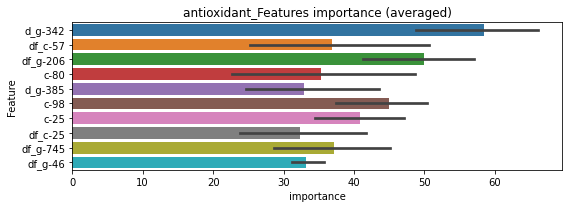

len(train_index) : 3850
len(valid_index) : 3851
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269242	valid_1's binary_logloss: 0.066183
[200]	training's binary_logloss: 0.00558295	valid_1's binary_logloss: 0.0409058
[300]	training's binary_logloss: 0.00162565	valid_1's binary_logloss: 0.0352987
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00136967	valid_1's binary_logloss: 0.034786


len(train_index) : 3851
len(valid_index) : 3850
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289313	valid_1's binary_logloss: 0.0599482
[200]	training's binary_logloss: 0.0060424	valid_1's binary_logloss: 0.0307769
[300]	training's binary_logloss: 0.00176232	valid_1's binary_logloss: 0.0234072
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000885311	valid_1's binary_logloss: 0.0207312


antioxidant logloss: 0.027759475154052363


neg labels: 3289 → selected neg labels: 3283


antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344489	valid_1's binary_logloss: 0.0568554
[200]	training's binary_logloss: 0.00530638	valid_1's binary_logloss: 0.0178536
[300]	training's binary_logloss: 0.00147353	valid_1's binary_logloss: 0.00870744
[400]	training's binary_logloss: 0.000721604	valid_1's binary_logloss: 0.00625961
[500]	training's binary_logloss: 0.000475113	valid_1's binary_logloss: 0.00511041
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000440709	valid_1's binary_logloss: 0.00495399
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340605	valid_1's binary_logloss: 0.060307
[200]	training's binary_logloss: 0.00522378	valid_1's binary_logloss: 0.0249686
[300]	training's binary_logloss: 0.00145941	valid_1's binary_logloss: 0.0184349
[400]	training's binary_logloss: 0.000712976	valid_1's binary_logloss: 0.0167468
Early stopping, best iteration is:
[44

1 / 3 AUC score:1.000
y_Threshold: 0.0038559, Threshold: 0.0060598, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00545, conf_1:0.00667
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0060598
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0160598
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0260598
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_4: 0.0360598
threshold: 0.0360598, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339477	valid_1's binary_logloss: 0.0539618
[200]	training's binary_logloss: 0.00508473	valid_1's binary_logloss: 0.0166954
[300]	training's binary_logloss: 0.00142454	valid_1's binary_logloss: 0.00867664
[400]	training's binary_logloss: 0.00071625	valid_1's binary_logloss: 0.00644992
[500]	training's binary_logloss: 0.000473392	valid_1's binary_logloss: 0.00531385
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00044835	valid_1's binary_logloss: 0.00522282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331335	valid_1's binary_logloss: 0.0595574
[200]	training's binary_logloss: 0.00499969	valid_1's binary_logloss: 0.0241387
[300]	training's binary_logloss: 0.00140716	valid_1's binary_logloss: 0.0173664
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000845766	valid_1's binary_logloss: 0.0163093


2 / 3 AUC score:1.000
y_Threshold: 0.0230154, Threshold: 0.0360598, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0052737 Vs.target_rate: 0.00151
Num_p_label: 21.0, conf_0:0.03245, conf_1:0.03967
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.0360598
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0460598
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.0560598
threshold: 0.0560598, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345684	valid_1's binary_logloss: 0.0506695
[200]	training's binary_logloss: 0.00523978	valid_1's binary_logloss: 0.0156372
[300]	training's binary_logloss: 0.00146395	valid_1's binary_logloss: 0.00900269
[400]	training's binary_logloss: 0.000712366	valid_1's binary_logloss: 0.00700187
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000494974	valid_1's binary_logloss: 0.00633004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333561	valid_1's binary_logloss: 0.0627373
[200]	training's binary_logloss: 0.0049131	valid_1's binary_logloss: 0.0287353
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00182154	valid_1's binary_logloss: 0.0246919


3 / 3 AUC score:1.000
y_Threshold: 0.0274620, Threshold: 0.0560598, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 648.0/3791
p_label_rate: 0.0040181 Vs.target_rate: 0.00151
Num_p_label: 16.0, conf_0:0.05045, conf_1:0.06167
threshold: 0.0560598, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 664.0/7773, y_label_rate: 0.0854239


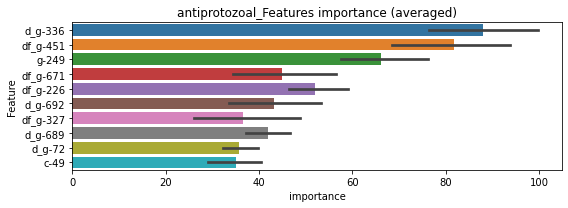

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185537	valid_1's binary_logloss: 0.0386405
[200]	training's binary_logloss: 0.00279514	valid_1's binary_logloss: 0.021472
[300]	training's binary_logloss: 0.000767587	valid_1's binary_logloss: 0.0194097
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000498257	valid_1's binary_logloss: 0.0192151


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192213	valid_1's binary_logloss: 0.0388117
[200]	training's binary_logloss: 0.00321474	valid_1's binary_logloss: 0.018533
[300]	training's binary_logloss: 0.000864105	valid_1's binary_logloss: 0.0132683
[400]	training's binary_logloss: 0.00038665	valid_1's binary_logloss: 0.0115542
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000273699	valid_1's binary_logloss: 0.0109526


antiprotozoal logloss: 0.015084403520136633


neg labels: 3289 → selected neg labels: 3286


antiviral, len(trt): 23, len(othr): 3286, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025821	valid_1's binary_logloss: 0.0415029
[200]	training's binary_logloss: 0.00321586	valid_1's binary_logloss: 0.00982914
[300]	training's binary_logloss: 0.000904875	valid_1's binary_logloss: 0.00459146
[400]	training's binary_logloss: 0.000458667	valid_1's binary_logloss: 0.00316137
[500]	training's binary_logloss: 0.000351161	valid_1's binary_logloss: 0.00285448
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000341749	valid_1's binary_logloss: 0.00282203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259386	valid_1's binary_logloss: 0.0359973
[200]	training's binary_logloss: 0.00332323	valid_1's binary_logloss: 0.00650914
[300]	training's binary_logloss: 0.000927571	valid_1's binary_logloss: 0.0025505
[400]	training's binary_logloss: 0.000470073	valid_1's binary_logloss: 0.00161232
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0019547, Threshold: 0.0028311, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00255, conf_1:0.00311
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0028311
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_2: 0.0128311
Num_p_label: 2.0, Expected: 3.8, Adj_threshold_3: 0.0228311
threshold: 0.0228311, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02578	valid_1's binary_logloss: 0.0403617
[200]	training's binary_logloss: 0.00316869	valid_1's binary_logloss: 0.00903778
[300]	training's binary_logloss: 0.000885799	valid_1's binary_logloss: 0.00439993
[400]	training's binary_logloss: 0.000457903	valid_1's binary_logloss: 0.00325384
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000375313	valid_1's binary_logloss: 0.00298593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250414	valid_1's binary_logloss: 0.0340678
[200]	training's binary_logloss: 0.00308981	valid_1's binary_logloss: 0.00602969
[300]	training's binary_logloss: 0.000882626	valid_1's binary_logloss: 0.0024472
[400]	training's binary_logloss: 0.000451766	valid_1's binary_logloss: 0.00156877
[500]	training's binary_logloss: 0.000349807	valid_1's binary_logloss: 0.00138123
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0870344, Threshold: 0.0228311, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00097
Num_p_label: 11.0, conf_0:0.02055, conf_1:0.02511
threshold: 0.0228311, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02578	valid_1's binary_logloss: 0.0403617
[200]	training's binary_logloss: 0.00316869	valid_1's binary_logloss: 0.00903778
[300]	training's binary_logloss: 0.000885799	valid_1's binary_logloss: 0.00439993
[400]	training's binary_logloss: 0.000457903	valid_1's binary_logloss: 0.00325384
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.000375313	valid_1's binary_logloss: 0.00298593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250414	valid_1's binary_logloss: 0.0340678
[200]	training's binary_logloss: 0.00308981	valid_1's binary_logloss: 0.00602969
[300]	training's binary_logloss: 0.000882626	valid_1's binary_logloss: 0.0024472
[400]	training's binary_logloss: 0.000451766	valid_1's binary_logloss: 0.00156877
[500]	training's binary_logloss: 0.000349807	valid_1's binary_logloss: 0.00138123
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0870344, Threshold: 0.0228311, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0027624 Vs.target_rate: 0.00097
Num_p_label: 11.0, conf_0:0.02055, conf_1:0.02511
threshold: 0.0228311, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7793, y_label_rate: 0.0857180


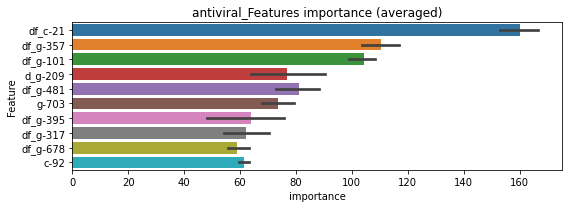

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140244	valid_1's binary_logloss: 0.0285526
[200]	training's binary_logloss: 0.00172067	valid_1's binary_logloss: 0.0145942
[300]	training's binary_logloss: 0.000475505	valid_1's binary_logloss: 0.013606
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00052364	valid_1's binary_logloss: 0.0135604


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144509	valid_1's binary_logloss: 0.0232817
[200]	training's binary_logloss: 0.00184757	valid_1's binary_logloss: 0.00715769
[300]	training's binary_logloss: 0.000520893	valid_1's binary_logloss: 0.00506422
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000320409	valid_1's binary_logloss: 0.00486953


antiviral logloss: 0.009215523134555816


neg labels: 3289 → selected neg labels: 3281


apoptosis_stimulant, len(trt): 49, len(othr): 3281, target_rate: 0.0020576 → Adj_target_rate: 0.0022954
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458786	valid_1's binary_logloss: 0.0764232
[200]	training's binary_logloss: 0.00796358	valid_1's binary_logloss: 0.0280749
[300]	training's binary_logloss: 0.00222387	valid_1's binary_logloss: 0.0165744
[400]	training's binary_logloss: 0.00104257	valid_1's binary_logloss: 0.013332
[500]	training's binary_logloss: 0.00065125	valid_1's binary_logloss: 0.0120907
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000566421	valid_1's binary_logloss: 0.0118791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461634	valid_1's binary_logloss: 0.0761731
[200]	training's binary_logloss: 0.00799866	valid_1's binary_logloss: 0.0252337
[300]	training's binary_logloss: 0.00225324	valid_1's binary_logloss: 0.0138266
[400]	training's binary_logloss: 0.00104942	valid_1's binary_logloss: 0.00958869
[500]	training's binary_logloss: 0.000658985

1 / 3 AUC score:1.000
y_Threshold: 0.0046158, Threshold: 0.0403382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00206
Num_p_label: 80.0, conf_0:0.03630, conf_1:0.04437
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_1: 0.0403382
Num_p_label: 72.0, Expected: 8.2, Adj_threshold_2: 0.0503382
Num_p_label: 63.0, Expected: 8.2, Adj_threshold_3: 0.0603382
Num_p_label: 61.0, Expected: 8.2, Adj_threshold_4: 0.0703382
Num_p_label: 57.0, Expected: 8.2, Adj_threshold_5: 0.0803382
Num_p_label: 53.0, Expected: 8.2, Adj_threshold_6: 0.0903382
Num_p_label: 49.0, Expected: 8.2, Adj_threshold_7: 0.1003382
Num_p_label: 45.0, Expected: 8.2, Adj_threshold_8: 0.1103382
Num_p_label: 44.0, Expected: 8.2, Adj_threshold_9: 0.1203382
Num_p_label: 41.0, Expected: 8.2, Adj_threshold_10: 0.1303382
threshold: 0.1403382, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459935	valid_1's binary_logloss: 0.077887
[200]	training's binary_logloss: 0.00739986	valid_1's binary_logloss: 0.0280934
[300]	training's binary_logloss: 0.00207335	valid_1's binary_logloss: 0.0171676
[400]	training's binary_logloss: 0.000996397	valid_1's binary_logloss: 0.0145003
[500]	training's binary_logloss: 0.000626718	valid_1's binary_logloss: 0.013547
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000647715	valid_1's binary_logloss: 0.0134274
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435061	valid_1's binary_logloss: 0.0732577
[200]	training's binary_logloss: 0.00749188	valid_1's binary_logloss: 0.0239842
[300]	training's binary_logloss: 0.00212589	valid_1's binary_logloss: 0.0124439
[400]	training's binary_logloss: 0.00100023	valid_1's binary_logloss: 0.00876617
[500]	training's binary_logloss: 0.00063006

2 / 3 AUC score:1.000
y_Threshold: 0.0590990, Threshold: 0.1403382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0231040 Vs.target_rate: 0.00206
Num_p_label: 92.0, conf_0:0.12630, conf_1:0.15437
Num_p_label: 92.0, Expected: 8.2, Adj_threshold_1: 0.1403382
Num_p_label: 92.0, Expected: 8.2, Adj_threshold_2: 0.1503382
Num_p_label: 90.0, Expected: 8.2, Adj_threshold_3: 0.1603382
Num_p_label: 87.0, Expected: 8.2, Adj_threshold_4: 0.1703382
Num_p_label: 86.0, Expected: 8.2, Adj_threshold_5: 0.1803382
Num_p_label: 83.0, Expected: 8.2, Adj_threshold_6: 0.1903382
Num_p_label: 82.0, Expected: 8.2, Adj_threshold_7: 0.2003382
Num_p_label: 80.0, Expected: 8.2, Adj_threshold_8: 0.2103382
Num_p_label: 79.0, Expected: 8.2, Adj_threshold_9: 0.2203382
Num_p_label: 78.0, Expected: 8.2, Adj_threshold_10: 0.2303382
threshold: 0.2403382, positive_p_label: 78.0/3982, p_label_rate: 0.0195881
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428002	valid_1's binary_logloss: 0.0817576
[200]	training's binary_logloss: 0.00693458	valid_1's binary_logloss: 0.0338317
[300]	training's binary_logloss: 0.00198363	valid_1's binary_logloss: 0.0243195
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00106313	valid_1's binary_logloss: 0.0221765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441539	valid_1's binary_logloss: 0.0773968
[200]	training's binary_logloss: 0.00736741	valid_1's binary_logloss: 0.0281113
[300]	training's binary_logloss: 0.00215145	valid_1's binary_logloss: 0.0174896
[400]	training's binary_logloss: 0.00103852	valid_1's binary_logloss: 0.0138704
[500]	training's binary_logloss: 0.000653388	valid_1's binary_logloss: 0.0120051
[600]	training's binary_logloss: 0.000507343	valid_1's binary_logloss: 0.0111126
Early stopping, best iteration is:
[615]	tr

3 / 3 AUC score:1.000
y_Threshold: 0.0402569, Threshold: 0.2403382, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0178302 Vs.target_rate: 0.00206
Num_p_label: 71.0, conf_0:0.21630, conf_1:0.26437
Num_p_label: 71.0, Expected: 8.2, Adj_threshold_1: 0.2403382
Num_p_label: 69.0, Expected: 8.2, Adj_threshold_2: 0.2503382
Num_p_label: 68.0, Expected: 8.2, Adj_threshold_3: 0.2603382
Num_p_label: 67.0, Expected: 8.2, Adj_threshold_4: 0.2703382
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_5: 0.2803382
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_6: 0.2903382
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_7: 0.3003382
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_8: 0.3103382
Num_p_label: 65.0, Expected: 8.2, Adj_threshold_9: 0.3203382
Num_p_label: 62.0, Expected: 8.2, Adj_threshold_10: 0.3303382
threshold: 0.3403382, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 714.0/7779, y_label_rate: 0.0917856


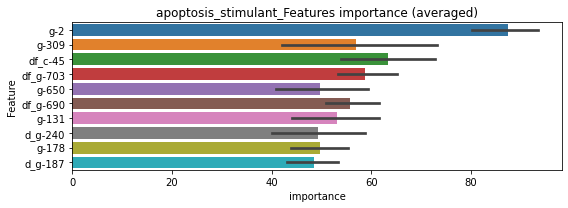

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268485	valid_1's binary_logloss: 0.0503225
[200]	training's binary_logloss: 0.00464814	valid_1's binary_logloss: 0.0219332
[300]	training's binary_logloss: 0.00129333	valid_1's binary_logloss: 0.0152155
[400]	training's binary_logloss: 0.000595466	valid_1's binary_logloss: 0.0133585
[500]	training's binary_logloss: 0.000370539	valid_1's binary_logloss: 0.0125795
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000381342	valid_1's binary_logloss: 0.0125382


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027193	valid_1's binary_logloss: 0.0566099
[200]	training's binary_logloss: 0.00468908	valid_1's binary_logloss: 0.028618
[300]	training's binary_logloss: 0.00119895	valid_1's binary_logloss: 0.0237586
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00118684	valid_1's binary_logloss: 0.0237434


apoptosis_stimulant logloss: 0.018140073509641436


neg labels: 3289 → selected neg labels: 3281


aromatase_inhibitor, len(trt): 47, len(othr): 3281, target_rate: 0.0019736 → Adj_target_rate: 0.0022155
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0447733	valid_1's binary_logloss: 0.0776957
[200]	training's binary_logloss: 0.00790964	valid_1's binary_logloss: 0.0300222
[300]	training's binary_logloss: 0.00216576	valid_1's binary_logloss: 0.0194481
[400]	training's binary_logloss: 0.00100633	valid_1's binary_logloss: 0.0157653
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000739391	valid_1's binary_logloss: 0.0145899
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462874	valid_1's binary_logloss: 0.0789759
[200]	training's binary_logloss: 0.00836908	valid_1's binary_logloss: 0.0282673
[300]	training's binary_logloss: 0.00229333	valid_1's binary_logloss: 0.0171034
[400]	training's binary_logloss: 0.00102073	valid_1's binary_logloss: 0.0127653
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000709182	valid_1's binary_logloss: 0.0115728


1 / 3 AUC score:1.000
y_Threshold: 0.0062338, Threshold: 0.0105580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00197
Num_p_label: 80.0, conf_0:0.00950, conf_1:0.01161
Num_p_label: 80.0, Expected: 7.9, Adj_threshold_1: 0.0105580
Num_p_label: 21.0, Expected: 7.9, Adj_threshold_2: 0.0205580
Num_p_label: 7.0, Expected: 7.9, Adj_threshold_3: 0.0305580
threshold: 0.0305580, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434034	valid_1's binary_logloss: 0.0753378
[200]	training's binary_logloss: 0.00741546	valid_1's binary_logloss: 0.0277066
[300]	training's binary_logloss: 0.00205644	valid_1's binary_logloss: 0.0177286
[400]	training's binary_logloss: 0.000980288	valid_1's binary_logloss: 0.0144876
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000926544	valid_1's binary_logloss: 0.0144293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460988	valid_1's binary_logloss: 0.076047
[200]	training's binary_logloss: 0.00808758	valid_1's binary_logloss: 0.025827
[300]	training's binary_logloss: 0.00222896	valid_1's binary_logloss: 0.0138205
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00112866	valid_1's binary_logloss: 0.0109852


2 / 3 AUC score:1.000
y_Threshold: 0.0305656, Threshold: 0.0305580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00197
Num_p_label: 40.0, conf_0:0.02750, conf_1:0.03361
Num_p_label: 40.0, Expected: 7.9, Adj_threshold_1: 0.0305580
Num_p_label: 24.0, Expected: 7.9, Adj_threshold_2: 0.0405580
Num_p_label: 20.0, Expected: 7.9, Adj_threshold_3: 0.0505580
Num_p_label: 12.0, Expected: 7.9, Adj_threshold_4: 0.0605580
threshold: 0.0605580, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456	valid_1's binary_logloss: 0.0830887
[200]	training's binary_logloss: 0.00774684	valid_1's binary_logloss: 0.0317257
[300]	training's binary_logloss: 0.0021433	valid_1's binary_logloss: 0.0177902
[400]	training's binary_logloss: 0.000997689	valid_1's binary_logloss: 0.0129214
[500]	training's binary_logloss: 0.000631619	valid_1's binary_logloss: 0.0108003
[600]	training's binary_logloss: 0.00051219	valid_1's binary_logloss: 0.010104
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.000501014	valid_1's binary_logloss: 0.0100745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0454699	valid_1's binary_logloss: 0.0733286
[200]	training's binary_logloss: 0.00766202	valid_1's binary_logloss: 0.0212441
[300]	training's binary_logloss: 0.00215555	valid_1's binary_logloss: 0.00973023
[400]	training's binary_logloss: 0.00100764	va

3 / 3 AUC score:1.000
y_Threshold: 0.0481256, Threshold: 0.0605580, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3803
p_label_rate: 0.0010045 Vs.target_rate: 0.00197
Num_p_label: 4.0, conf_0:0.05450, conf_1:0.06661
threshold: 0.0605580, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 659.0/7785, y_label_rate: 0.0846500


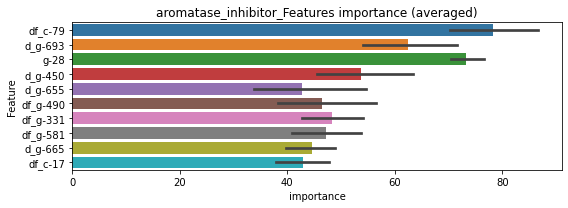

len(train_index) : 3892
len(valid_index) : 3893
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251893	valid_1's binary_logloss: 0.0489619
[200]	training's binary_logloss: 0.00434215	valid_1's binary_logloss: 0.0194141
[300]	training's binary_logloss: 0.00116979	valid_1's binary_logloss: 0.0127224
[400]	training's binary_logloss: 0.000527566	valid_1's binary_logloss: 0.0110788
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000437538	valid_1's binary_logloss: 0.0106784


len(train_index) : 3893
len(valid_index) : 3892
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259093	valid_1's binary_logloss: 0.0494987
[200]	training's binary_logloss: 0.00465145	valid_1's binary_logloss: 0.0230629
[300]	training's binary_logloss: 0.00124264	valid_1's binary_logloss: 0.0174113
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000700855	valid_1's binary_logloss: 0.0159083


aromatase_inhibitor logloss: 0.013293011999339412


neg labels: 3289 → selected neg labels: 3288


atm_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151791	valid_1's binary_logloss: 0.0158363
[200]	training's binary_logloss: 0.00119264	valid_1's binary_logloss: 0.00137942
[300]	training's binary_logloss: 0.000320223	valid_1's binary_logloss: 0.000420947
[400]	training's binary_logloss: 0.00020129	valid_1's binary_logloss: 0.000272924
[500]	training's binary_logloss: 0.000176305	valid_1's binary_logloss: 0.000240295
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000172121	valid_1's binary_logloss: 0.000234609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154346	valid_1's binary_logloss: 0.0164506
[200]	training's binary_logloss: 0.00120324	valid_1's binary_logloss: 0.00144872
[300]	training's binary_logloss: 0.000319078	valid_1's binary_logloss: 0.000473604
[400]	training's binary_logloss: 0.000202141	valid_1's binary_logloss: 0.000313723
[500]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0006232, Threshold: 0.0014679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00132, conf_1:0.00161
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0014679
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0114679
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0214679
threshold: 0.0214679, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155682	valid_1's binary_logloss: 0.0162867
[200]	training's binary_logloss: 0.00120221	valid_1's binary_logloss: 0.00139704
[300]	training's binary_logloss: 0.000305525	valid_1's binary_logloss: 0.000395145
[400]	training's binary_logloss: 0.000195564	valid_1's binary_logloss: 0.000263544
[500]	training's binary_logloss: 0.000173591	valid_1's binary_logloss: 0.000236062
[600]	training's binary_logloss: 0.000167926	valid_1's binary_logloss: 0.000228992
[700]	training's binary_logloss: 0.000165708	valid_1's binary_logloss: 0.000226091
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.000165665	valid_1's binary_logloss: 0.000226043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157843	valid_1's binary_logloss: 0.017486
[200]	training's binary_logloss: 0.00122011	valid_1's binary_logloss: 0.0021635
Early stopping, best iterat

2 / 3 AUC score:1.000
y_Threshold: 0.0771739, Threshold: 0.0214679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025
Num_p_label: 40.0, conf_0:0.01932, conf_1:0.02361
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0214679
Num_p_label: 27.0, Expected: 1.0, Adj_threshold_2: 0.0314679
Num_p_label: 24.0, Expected: 1.0, Adj_threshold_3: 0.0414679
Num_p_label: 21.0, Expected: 1.0, Adj_threshold_4: 0.0514679
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_5: 0.0614679
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_6: 0.0714679
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_7: 0.0814679
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.0914679
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.1014679
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.1114679
threshold: 0.1214679, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155682	valid_1's binary_logloss: 0.0162867
[200]	training's binary_logloss: 0.00120221	valid_1's binary_logloss: 0.00139704
[300]	training's binary_logloss: 0.000305525	valid_1's binary_logloss: 0.000395145
[400]	training's binary_logloss: 0.000195564	valid_1's binary_logloss: 0.000263544
[500]	training's binary_logloss: 0.000173591	valid_1's binary_logloss: 0.000236062
[600]	training's binary_logloss: 0.000167926	valid_1's binary_logloss: 0.000228992
[700]	training's binary_logloss: 0.000165708	valid_1's binary_logloss: 0.000226091
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.000165665	valid_1's binary_logloss: 0.000226043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157843	valid_1's binary_logloss: 0.017486
[200]	training's binary_logloss: 0.00122011	valid_1's binary_logloss: 0.0021635
Early stopping, best iterat

3 / 3 AUC score:1.000
y_Threshold: 0.0771739, Threshold: 0.1214679, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025
Num_p_label: 6.0, conf_0:0.10932, conf_1:0.13361
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.1214679
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.1314679
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.1414679
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.1514679
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_5: 0.1614679
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.1714679
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.1814679
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.1914679
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.2014679
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2114679
threshold: 0.2214679, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


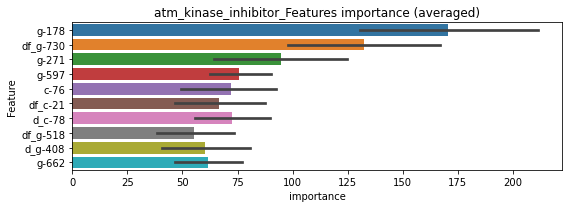

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00833788	valid_1's binary_logloss: 0.00998158
[200]	training's binary_logloss: 0.000640835	valid_1's binary_logloss: 0.00266309
[300]	training's binary_logloss: 0.000165512	valid_1's binary_logloss: 0.00229696
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00015024	valid_1's binary_logloss: 0.00228457


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00838194	valid_1's binary_logloss: 0.00913915
[200]	training's binary_logloss: 0.000656351	valid_1's binary_logloss: 0.00134894
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000191354	valid_1's binary_logloss: 0.000895912


atm_kinase_inhibitor logloss: 0.0015903291693896854


neg labels: 3289 → selected neg labels: 3287


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160531	valid_1's binary_logloss: 0.017819
[200]	training's binary_logloss: 0.00136448	valid_1's binary_logloss: 0.00203315
[300]	training's binary_logloss: 0.000374941	valid_1's binary_logloss: 0.000703928
[400]	training's binary_logloss: 0.000227372	valid_1's binary_logloss: 0.000474561
[500]	training's binary_logloss: 0.000200475	valid_1's binary_logloss: 0.000431829
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000198976	valid_1's binary_logloss: 0.000429917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161708	valid_1's binary_logloss: 0.0181071
[200]	training's binary_logloss: 0.00138026	valid_1's binary_logloss: 0.00281175
[300]	training's binary_logloss: 0.000372622	valid_1's binary_logloss: 0.0014649
[400]	training's binary_logloss: 0.000226933	valid_1's binary_logloss: 0.00124003
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0006562, Threshold: 0.0009870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00089, conf_1:0.00109
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009870
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.0109870
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0209870
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_4: 0.0309870
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_5: 0.0409870
threshold: 0.0409870, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162906	valid_1's binary_logloss: 0.0194935
[200]	training's binary_logloss: 0.00134621	valid_1's binary_logloss: 0.00389659
[300]	training's binary_logloss: 0.000362353	valid_1's binary_logloss: 0.00269192
[400]	training's binary_logloss: 0.000224037	valid_1's binary_logloss: 0.00241155
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000227336	valid_1's binary_logloss: 0.00240642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163176	valid_1's binary_logloss: 0.0173153
[200]	training's binary_logloss: 0.00136285	valid_1's binary_logloss: 0.00166931
[300]	training's binary_logloss: 0.000368156	valid_1's binary_logloss: 0.000524529
[400]	training's binary_logloss: 0.000227559	valid_1's binary_logloss: 0.000354896
[500]	training's binary_logloss: 0.000197334	valid_1's binary_logloss: 0.000323839
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.0284940, Threshold: 0.0409870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00029
Num_p_label: 6.0, conf_0:0.03689, conf_1:0.04509
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_1: 0.0409870
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_2: 0.0509870
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0609870
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_4: 0.0709870
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.0809870
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_6: 0.0909870
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_7: 0.1009870
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.1109870
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.1209870
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_10: 0.1309870
threshold: 0.1309870, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pse

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162906	valid_1's binary_logloss: 0.0194935
[200]	training's binary_logloss: 0.00134621	valid_1's binary_logloss: 0.00389659
[300]	training's binary_logloss: 0.000362353	valid_1's binary_logloss: 0.00269192
[400]	training's binary_logloss: 0.000224037	valid_1's binary_logloss: 0.00241155
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000227336	valid_1's binary_logloss: 0.00240642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163176	valid_1's binary_logloss: 0.0173153
[200]	training's binary_logloss: 0.00136285	valid_1's binary_logloss: 0.00166931
[300]	training's binary_logloss: 0.000368156	valid_1's binary_logloss: 0.000524529
[400]	training's binary_logloss: 0.000227559	valid_1's binary_logloss: 0.000354896
[500]	training's binary_logloss: 0.000197334	valid_1's binary_logloss: 0.000323839
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.0284940, Threshold: 0.1309870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029
Num_p_label: 2.0, conf_0:0.11789, conf_1:0.14409
threshold: 0.1309870, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


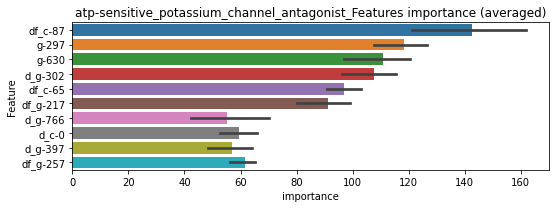

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00866554	valid_1's binary_logloss: 0.0101578
[200]	training's binary_logloss: 0.000727254	valid_1's binary_logloss: 0.00201839
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000242695	valid_1's binary_logloss: 0.00162325


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0087425	valid_1's binary_logloss: 0.012074
[200]	training's binary_logloss: 0.00071958	valid_1's binary_logloss: 0.00369865
[300]	training's binary_logloss: 0.00019337	valid_1's binary_logloss: 0.00294509
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00012335	valid_1's binary_logloss: 0.00282844


atp-sensitive_potassium_channel_antagonist logloss: 0.0022258446644823566


neg labels: 3289 → selected neg labels: 3287


atp_synthase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152261	valid_1's binary_logloss: 0.0185177
[200]	training's binary_logloss: 0.00116626	valid_1's binary_logloss: 0.00365944
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000356615	valid_1's binary_logloss: 0.00287446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155461	valid_1's binary_logloss: 0.0168889
[200]	training's binary_logloss: 0.00121594	valid_1's binary_logloss: 0.00286824
[300]	training's binary_logloss: 0.000307955	valid_1's binary_logloss: 0.00154469
[400]	training's binary_logloss: 0.000194959	valid_1's binary_logloss: 0.00124856
[500]	training's binary_logloss: 0.000174115	valid_1's binary_logloss: 0.00117224
[600]	training's binary_logloss: 0.000168822	valid_1's binary_logloss: 0.00115095
Early stopping, best iteration is:
[598]	training's binary_logloss: 0.000168822	valid_1's binary_logloss: 0.00115

1 / 3 AUC score:1.000
y_Threshold: 0.0006832, Threshold: 0.0024144, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00217, conf_1:0.00266
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0024144
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_2: 0.0124144
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.0224144
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.0324144
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_5: 0.0424144
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.0524144
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.0624144
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_8: 0.0724144
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_9: 0.0824144
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_10: 0.0924144
threshold: 0.1024144, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015947	valid_1's binary_logloss: 0.0160589
[200]	training's binary_logloss: 0.00117309	valid_1's binary_logloss: 0.0011948
[300]	training's binary_logloss: 0.000277119	valid_1's binary_logloss: 0.000295583
[400]	training's binary_logloss: 0.000175706	valid_1's binary_logloss: 0.000192702
[500]	training's binary_logloss: 0.000157082	valid_1's binary_logloss: 0.000173844
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000153719	valid_1's binary_logloss: 0.00017041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160065	valid_1's binary_logloss: 0.0184761
[200]	training's binary_logloss: 0.00120711	valid_1's binary_logloss: 0.00310529
[300]	training's binary_logloss: 0.000279003	valid_1's binary_logloss: 0.00163949
[400]	training's binary_logloss: 0.000173493	valid_1's binary_logloss: 0.00126886
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.7534373, Threshold: 0.1024144, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0336514 Vs.target_rate: 0.00050
Num_p_label: 134.0, conf_0:0.09217, conf_1:0.11266
Num_p_label: 134.0, Expected: 2.0, Adj_threshold_1: 0.1024144
Num_p_label: 134.0, Expected: 2.0, Adj_threshold_2: 0.1124144
Num_p_label: 130.0, Expected: 2.0, Adj_threshold_3: 0.1224144
Num_p_label: 127.0, Expected: 2.0, Adj_threshold_4: 0.1324144
Num_p_label: 125.0, Expected: 2.0, Adj_threshold_5: 0.1424144
Num_p_label: 123.0, Expected: 2.0, Adj_threshold_6: 0.1524144
Num_p_label: 118.0, Expected: 2.0, Adj_threshold_7: 0.1624144
Num_p_label: 116.0, Expected: 2.0, Adj_threshold_8: 0.1724144
Num_p_label: 113.0, Expected: 2.0, Adj_threshold_9: 0.1824144
Num_p_label: 110.0, Expected: 2.0, Adj_threshold_10: 0.1924144
threshold: 0.2024144, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 657.0/3812, y_label_rate: 0.17235

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015947	valid_1's binary_logloss: 0.0160589
[200]	training's binary_logloss: 0.00117309	valid_1's binary_logloss: 0.0011948
[300]	training's binary_logloss: 0.000277119	valid_1's binary_logloss: 0.000295583
[400]	training's binary_logloss: 0.000175706	valid_1's binary_logloss: 0.000192702
[500]	training's binary_logloss: 0.000157082	valid_1's binary_logloss: 0.000173844
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.000153719	valid_1's binary_logloss: 0.00017041
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160065	valid_1's binary_logloss: 0.0184761
[200]	training's binary_logloss: 0.00120711	valid_1's binary_logloss: 0.00310529
[300]	training's binary_logloss: 0.000279003	valid_1's binary_logloss: 0.00163949
[400]	training's binary_logloss: 0.000173493	valid_1's binary_logloss: 0.00126886
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.7534373, Threshold: 0.2024144, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0276243 Vs.target_rate: 0.00050
Num_p_label: 110.0, conf_0:0.18217, conf_1:0.22266
Num_p_label: 110.0, Expected: 2.0, Adj_threshold_1: 0.2024144
Num_p_label: 110.0, Expected: 2.0, Adj_threshold_2: 0.2124144
Num_p_label: 109.0, Expected: 2.0, Adj_threshold_3: 0.2224144
Num_p_label: 106.0, Expected: 2.0, Adj_threshold_4: 0.2324144
Num_p_label: 102.0, Expected: 2.0, Adj_threshold_5: 0.2424144
Num_p_label: 95.0, Expected: 2.0, Adj_threshold_6: 0.2524144
Num_p_label: 93.0, Expected: 2.0, Adj_threshold_7: 0.2624144
Num_p_label: 83.0, Expected: 2.0, Adj_threshold_8: 0.2724144
Num_p_label: 78.0, Expected: 2.0, Adj_threshold_9: 0.2824144
Num_p_label: 66.0, Expected: 2.0, Adj_threshold_10: 0.2924144
threshold: 0.3024144, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 717.0/7794, y_label_rate: 0.0919938


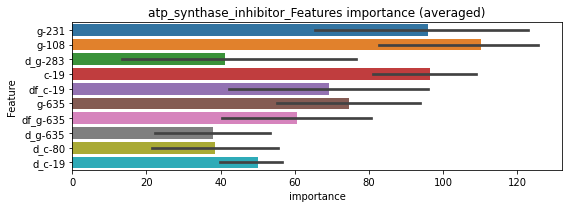

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113252	valid_1's binary_logloss: 0.0187894
[200]	training's binary_logloss: 0.00138848	valid_1's binary_logloss: 0.0101282
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.000805989	valid_1's binary_logloss: 0.00977325


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0115101	valid_1's binary_logloss: 0.0191073
[200]	training's binary_logloss: 0.0013583	valid_1's binary_logloss: 0.0113134
Early stopping, best iteration is:
[198]	training's binary_logloss: 0.00140865	valid_1's binary_logloss: 0.0112986


atp_synthase_inhibitor logloss: 0.010535899329074984


neg labels: 3289 → selected neg labels: 3273


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614883	valid_1's binary_logloss: 0.12777
[200]	training's binary_logloss: 0.0140822	valid_1's binary_logloss: 0.0745985
[300]	training's binary_logloss: 0.00420464	valid_1's binary_logloss: 0.0608731
[400]	training's binary_logloss: 0.00182047	valid_1's binary_logloss: 0.0568274
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00123375	valid_1's binary_logloss: 0.0556409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557282	valid_1's binary_logloss: 0.138895
[200]	training's binary_logloss: 0.0122253	valid_1's binary_logloss: 0.0930652
[300]	training's binary_logloss: 0.00356515	valid_1's binary_logloss: 0.0857766
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.0035314	valid_1's binary_logloss: 0.0857154


1 / 3 AUC score:0.993
y_Threshold: 0.0158223, Threshold: 0.0471256, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 639/3765
p_label_rate: 0.0200904 Vs.target_rate: 0.00407
Num_p_label: 80.0, conf_0:0.04241, conf_1:0.05184
Num_p_label: 80.0, Expected: 16.2, Adj_threshold_1: 0.0471256
Num_p_label: 58.0, Expected: 16.2, Adj_threshold_2: 0.0571256
Num_p_label: 48.0, Expected: 16.2, Adj_threshold_3: 0.0671256
Num_p_label: 37.0, Expected: 16.2, Adj_threshold_4: 0.0771256
Num_p_label: 33.0, Expected: 16.2, Adj_threshold_5: 0.0871256
Num_p_label: 28.0, Expected: 16.2, Adj_threshold_6: 0.0971256
threshold: 0.0971256, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 639.0/3765, y_label_rate: 0.1697211
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514599	valid_1's binary_logloss: 0.116517
[200]	training's binary_logloss: 0.0104253	valid_1's binary_logloss: 0.0686221
[300]	training's binary_logloss: 0.00313906	valid_1's binary_logloss: 0.0592281
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00273411	valid_1's binary_logloss: 0.058675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518728	valid_1's binary_logloss: 0.113104
[200]	training's binary_logloss: 0.0109368	valid_1's binary_logloss: 0.0640931
[300]	training's binary_logloss: 0.00327752	valid_1's binary_logloss: 0.0528863
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00261959	valid_1's binary_logloss: 0.0518324


2 / 3 AUC score:0.995
y_Threshold: 0.0496644, Threshold: 0.0971256, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 613.0/3713
p_label_rate: 0.0351582 Vs.target_rate: 0.00407
Num_p_label: 140.0, conf_0:0.08741, conf_1:0.10684
Num_p_label: 140.0, Expected: 16.2, Adj_threshold_1: 0.0971256
Num_p_label: 134.0, Expected: 16.2, Adj_threshold_2: 0.1071256
Num_p_label: 129.0, Expected: 16.2, Adj_threshold_3: 0.1171256
Num_p_label: 123.0, Expected: 16.2, Adj_threshold_4: 0.1271256
Num_p_label: 117.0, Expected: 16.2, Adj_threshold_5: 0.1371256
Num_p_label: 112.0, Expected: 16.2, Adj_threshold_6: 0.1471256
Num_p_label: 107.0, Expected: 16.2, Adj_threshold_7: 0.1571256
Num_p_label: 102.0, Expected: 16.2, Adj_threshold_8: 0.1671256
Num_p_label: 96.0, Expected: 16.2, Adj_threshold_9: 0.1771256
Num_p_label: 92.0, Expected: 16.2, Adj_threshold_10: 0.1871256
threshold: 0.1971256, positive_p_label: 90.0/3982, p_label_rate: 0.0226017
positive_y_label: 613.0/3713, y_label_rate:

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459749	valid_1's binary_logloss: 0.115964
[200]	training's binary_logloss: 0.00885731	valid_1's binary_logloss: 0.0767841
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00345514	valid_1's binary_logloss: 0.0713631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513088	valid_1's binary_logloss: 0.0994539
[200]	training's binary_logloss: 0.0100535	valid_1's binary_logloss: 0.0448596
[300]	training's binary_logloss: 0.00298045	valid_1's binary_logloss: 0.0305926
[400]	training's binary_logloss: 0.00135941	valid_1's binary_logloss: 0.0262521
[500]	training's binary_logloss: 0.000844884	valid_1's binary_logloss: 0.024452
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000847477	valid_1's binary_logloss: 0.024442


3 / 3 AUC score:0.996
y_Threshold: 0.0511010, Threshold: 0.1971256, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 593.0/3673
p_label_rate: 0.0326469 Vs.target_rate: 0.00407
Num_p_label: 130.0, conf_0:0.17741, conf_1:0.21684
Num_p_label: 130.0, Expected: 16.2, Adj_threshold_1: 0.1971256
Num_p_label: 129.0, Expected: 16.2, Adj_threshold_2: 0.2071256
Num_p_label: 121.0, Expected: 16.2, Adj_threshold_3: 0.2171256
Num_p_label: 116.0, Expected: 16.2, Adj_threshold_4: 0.2271256
Num_p_label: 113.0, Expected: 16.2, Adj_threshold_5: 0.2371256
Num_p_label: 109.0, Expected: 16.2, Adj_threshold_6: 0.2471256
Num_p_label: 106.0, Expected: 16.2, Adj_threshold_7: 0.2571256
Num_p_label: 100.0, Expected: 16.2, Adj_threshold_8: 0.2671256
Num_p_label: 95.0, Expected: 16.2, Adj_threshold_9: 0.2771256
Num_p_label: 92.0, Expected: 16.2, Adj_threshold_10: 0.2871256
threshold: 0.2971256, positive_p_label: 90.0/3982, p_label_rate: 0.0226017
positive_y_label: 683.0/7655, y_label_rate:

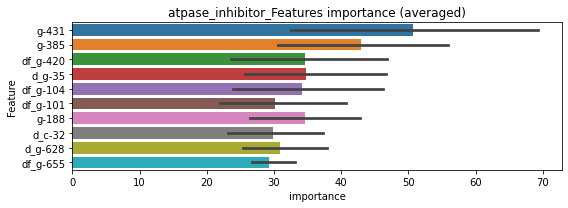

len(train_index) : 3827
len(valid_index) : 3828
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304121	valid_1's binary_logloss: 0.0710679
[200]	training's binary_logloss: 0.00638351	valid_1's binary_logloss: 0.0448377
[300]	training's binary_logloss: 0.00187994	valid_1's binary_logloss: 0.0385025
[400]	training's binary_logloss: 0.000804847	valid_1's binary_logloss: 0.0364945
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00071848	valid_1's binary_logloss: 0.0361451


len(train_index) : 3828
len(valid_index) : 3827
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293413	valid_1's binary_logloss: 0.0699457
[200]	training's binary_logloss: 0.00618019	valid_1's binary_logloss: 0.0432632
[300]	training's binary_logloss: 0.00186096	valid_1's binary_logloss: 0.0360467
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00134633	valid_1's binary_logloss: 0.0352019


atpase_inhibitor logloss: 0.03567358712321506


neg labels: 3289 → selected neg labels: 3286


atr_kinase_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189379	valid_1's binary_logloss: 0.0235173
[200]	training's binary_logloss: 0.0018885	valid_1's binary_logloss: 0.00389934
[300]	training's binary_logloss: 0.000534941	valid_1's binary_logloss: 0.00172256
[400]	training's binary_logloss: 0.000312135	valid_1's binary_logloss: 0.00122786
[500]	training's binary_logloss: 0.000267676	valid_1's binary_logloss: 0.00111298
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000265281	valid_1's binary_logloss: 0.00110678
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.019202	valid_1's binary_logloss: 0.0228428
[200]	training's binary_logloss: 0.00190413	valid_1's binary_logloss: 0.003492
[300]	training's binary_logloss: 0.00053836	valid_1's binary_logloss: 0.00162896
[400]	training's binary_logloss: 0.000320262	valid_1's binary_logloss: 0.00120384
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0016045, Threshold: 0.0053386, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00480, conf_1:0.00587
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0053386
Num_p_label: 37.0, Expected: 3.2, Adj_threshold_2: 0.0153386
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_3: 0.0253386
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_4: 0.0353386
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.0453386
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_6: 0.0553386
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_7: 0.0653386
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_8: 0.0753386
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_9: 0.0853386
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_10: 0.0953386
threshold: 0.1053386, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187705	valid_1's binary_logloss: 0.0225503
[200]	training's binary_logloss: 0.00177559	valid_1's binary_logloss: 0.00299217
[300]	training's binary_logloss: 0.000490299	valid_1's binary_logloss: 0.00113168
[400]	training's binary_logloss: 0.000282788	valid_1's binary_logloss: 0.00077011
[500]	training's binary_logloss: 0.000248369	valid_1's binary_logloss: 0.000717254
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000242816	valid_1's binary_logloss: 0.000708355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186417	valid_1's binary_logloss: 0.0211527
[200]	training's binary_logloss: 0.00174664	valid_1's binary_logloss: 0.0025763
[300]	training's binary_logloss: 0.000466803	valid_1's binary_logloss: 0.000846513
[400]	training's binary_logloss: 0.000281803	valid_1's binary_logloss: 0.000564433
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1972537, Threshold: 0.1053386, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0133099 Vs.target_rate: 0.00080
Num_p_label: 53.0, conf_0:0.09480, conf_1:0.11587
Num_p_label: 53.0, Expected: 3.2, Adj_threshold_1: 0.1053386
Num_p_label: 52.0, Expected: 3.2, Adj_threshold_2: 0.1153386
Num_p_label: 50.0, Expected: 3.2, Adj_threshold_3: 0.1253386
Num_p_label: 48.0, Expected: 3.2, Adj_threshold_4: 0.1353386
Num_p_label: 47.0, Expected: 3.2, Adj_threshold_5: 0.1453386
Num_p_label: 46.0, Expected: 3.2, Adj_threshold_6: 0.1553386
Num_p_label: 43.0, Expected: 3.2, Adj_threshold_7: 0.1653386
Num_p_label: 42.0, Expected: 3.2, Adj_threshold_8: 0.1753386
Num_p_label: 37.0, Expected: 3.2, Adj_threshold_9: 0.1853386
Num_p_label: 37.0, Expected: 3.2, Adj_threshold_10: 0.1953386
threshold: 0.2053386, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187705	valid_1's binary_logloss: 0.0225503
[200]	training's binary_logloss: 0.00177559	valid_1's binary_logloss: 0.00299217
[300]	training's binary_logloss: 0.000490299	valid_1's binary_logloss: 0.00113168
[400]	training's binary_logloss: 0.000282788	valid_1's binary_logloss: 0.00077011
[500]	training's binary_logloss: 0.000248369	valid_1's binary_logloss: 0.000717254
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000242816	valid_1's binary_logloss: 0.000708355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186417	valid_1's binary_logloss: 0.0211527
[200]	training's binary_logloss: 0.00174664	valid_1's binary_logloss: 0.0025763
[300]	training's binary_logloss: 0.000466803	valid_1's binary_logloss: 0.000846513
[400]	training's binary_logloss: 0.000281803	valid_1's binary_logloss: 0.000564433
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1972537, Threshold: 0.2053386, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00080
Num_p_label: 36.0, conf_0:0.18480, conf_1:0.22587
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_1: 0.2053386
Num_p_label: 36.0, Expected: 3.2, Adj_threshold_2: 0.2153386
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_3: 0.2253386
Num_p_label: 35.0, Expected: 3.2, Adj_threshold_4: 0.2353386
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_5: 0.2453386
Num_p_label: 33.0, Expected: 3.2, Adj_threshold_6: 0.2553386
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_7: 0.2653386
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_8: 0.2753386
Num_p_label: 32.0, Expected: 3.2, Adj_threshold_9: 0.2853386
Num_p_label: 30.0, Expected: 3.2, Adj_threshold_10: 0.2953386
threshold: 0.3053386, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 686.0/7793, y_label_rate: 0.0880277


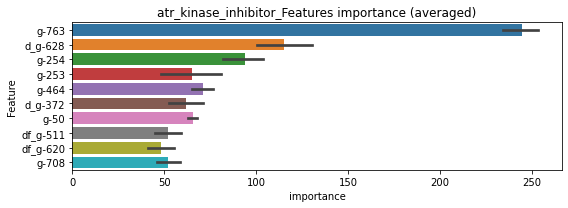

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110804	valid_1's binary_logloss: 0.0203025
[200]	training's binary_logloss: 0.00114906	valid_1's binary_logloss: 0.0111356
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000536856	valid_1's binary_logloss: 0.010786


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111871	valid_1's binary_logloss: 0.0181008
[200]	training's binary_logloss: 0.0012168	valid_1's binary_logloss: 0.00745508
[300]	training's binary_logloss: 0.000336941	valid_1's binary_logloss: 0.00646563
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000268106	valid_1's binary_logloss: 0.0063572


atr_kinase_inhibitor logloss: 0.00857190531928238


neg labels: 3289 → selected neg labels: 3273


aurora_kinase_inhibitor, len(trt): 96, len(othr): 3273, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357436	valid_1's binary_logloss: 0.0744885
[200]	training's binary_logloss: 0.00577287	valid_1's binary_logloss: 0.0389487
[300]	training's binary_logloss: 0.00168873	valid_1's binary_logloss: 0.0301185
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00125139	valid_1's binary_logloss: 0.0290771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353409	valid_1's binary_logloss: 0.0737926
[200]	training's binary_logloss: 0.00578016	valid_1's binary_logloss: 0.0356958
[300]	training's binary_logloss: 0.00173599	valid_1's binary_logloss: 0.0259771
[400]	training's binary_logloss: 0.000860847	valid_1's binary_logloss: 0.0222283
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000671117	valid_1's binary_logloss: 0.0213873


1 / 3 AUC score:0.999
y_Threshold: 0.0161304, Threshold: 0.0568683, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 651/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.05118, conf_1:0.06256
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0568683
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_2: 0.0668683
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_3: 0.0768683
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_4: 0.0868683
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_5: 0.0968683
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_6: 0.1068683
Num_p_label: 51.0, Expected: 16.1, Adj_threshold_7: 0.1168683
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_8: 0.1268683
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_9: 0.1368683
Num_p_label: 48.0, Expected: 16.1, Adj_threshold_10: 0.1468683
threshold: 0.1568683, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 651.0/3789, y_label_rate: 0.1718131

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319826	valid_1's binary_logloss: 0.0590779
[200]	training's binary_logloss: 0.00467641	valid_1's binary_logloss: 0.0212884
[300]	training's binary_logloss: 0.00135043	valid_1's binary_logloss: 0.012576
[400]	training's binary_logloss: 0.000669706	valid_1's binary_logloss: 0.0102017
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000520126	valid_1's binary_logloss: 0.00966894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305548	valid_1's binary_logloss: 0.0622734
[200]	training's binary_logloss: 0.00446808	valid_1's binary_logloss: 0.0318983
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0015021	valid_1's binary_logloss: 0.0283183


2 / 3 AUC score:1.000
y_Threshold: 0.0863737, Threshold: 0.1568683, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 642.0/3771
p_label_rate: 0.0210949 Vs.target_rate: 0.00403
Num_p_label: 84.0, conf_0:0.14118, conf_1:0.17256
Num_p_label: 84.0, Expected: 16.1, Adj_threshold_1: 0.1568683
Num_p_label: 82.0, Expected: 16.1, Adj_threshold_2: 0.1668683
Num_p_label: 77.0, Expected: 16.1, Adj_threshold_3: 0.1768683
Num_p_label: 76.0, Expected: 16.1, Adj_threshold_4: 0.1868683
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_5: 0.1968683
Num_p_label: 74.0, Expected: 16.1, Adj_threshold_6: 0.2068683
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_7: 0.2168683
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_8: 0.2268683
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_9: 0.2368683
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_10: 0.2468683
threshold: 0.2568683, positive_p_label: 72.0/3982, p_label_rate: 0.0180814
positive_y_label: 642.0/3771, y_label_rate: 0.170246

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308371	valid_1's binary_logloss: 0.0558068
[200]	training's binary_logloss: 0.00443107	valid_1's binary_logloss: 0.0189509
[300]	training's binary_logloss: 0.00129189	valid_1's binary_logloss: 0.0107939
[400]	training's binary_logloss: 0.000648597	valid_1's binary_logloss: 0.00795608
[500]	training's binary_logloss: 0.000446926	valid_1's binary_logloss: 0.00700276
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000429168	valid_1's binary_logloss: 0.00684367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306712	valid_1's binary_logloss: 0.0655359
[200]	training's binary_logloss: 0.00435571	valid_1's binary_logloss: 0.033283
[300]	training's binary_logloss: 0.00124593	valid_1's binary_logloss: 0.0271837
[400]	training's binary_logloss: 0.000632796	valid_1's binary_logloss: 0.0234704
Early stopping, best iteration is:
[420

3 / 3 AUC score:1.000
y_Threshold: 0.0809378, Threshold: 0.2568683, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 639.0/3765
p_label_rate: 0.0190859 Vs.target_rate: 0.00403
Num_p_label: 76.0, conf_0:0.23118, conf_1:0.28256
Num_p_label: 76.0, Expected: 16.1, Adj_threshold_1: 0.2568683
Num_p_label: 75.0, Expected: 16.1, Adj_threshold_2: 0.2668683
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_3: 0.2768683
Num_p_label: 72.0, Expected: 16.1, Adj_threshold_4: 0.2868683
Num_p_label: 68.0, Expected: 16.1, Adj_threshold_5: 0.2968683
Num_p_label: 67.0, Expected: 16.1, Adj_threshold_6: 0.3068683
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_7: 0.3168683
Num_p_label: 61.0, Expected: 16.1, Adj_threshold_8: 0.3268683
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_9: 0.3368683
Num_p_label: 60.0, Expected: 16.1, Adj_threshold_10: 0.3468683
threshold: 0.3568683, positive_p_label: 58.0/3982, p_label_rate: 0.0145655
positive_y_label: 697.0/7747, y_label_rate: 0.0899703

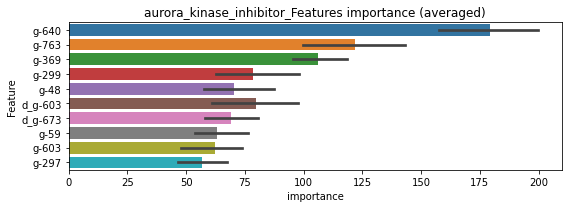

len(train_index) : 3873
len(valid_index) : 3874
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171754	valid_1's binary_logloss: 0.0513241
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00540471	valid_1's binary_logloss: 0.0402436


len(train_index) : 3874
len(valid_index) : 3873
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180674	valid_1's binary_logloss: 0.0421033
[200]	training's binary_logloss: 0.00265365	valid_1's binary_logloss: 0.0188836
[300]	training's binary_logloss: 0.000765695	valid_1's binary_logloss: 0.0137495
[400]	training's binary_logloss: 0.000389712	valid_1's binary_logloss: 0.0121493
[500]	training's binary_logloss: 0.000268069	valid_1's binary_logloss: 0.0113499
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000268069	valid_1's binary_logloss: 0.0113499


aurora_kinase_inhibitor logloss: 0.02579859748502641


neg labels: 3289 → selected neg labels: 3288


autotaxin_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162476	valid_1's binary_logloss: 0.0174416
[200]	training's binary_logloss: 0.0013536	valid_1's binary_logloss: 0.00164378
[300]	training's binary_logloss: 0.000356292	valid_1's binary_logloss: 0.000523394
[400]	training's binary_logloss: 0.000214889	valid_1's binary_logloss: 0.000350078
[500]	training's binary_logloss: 0.000187956	valid_1's binary_logloss: 0.000318994
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000186771	valid_1's binary_logloss: 0.000318114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163215	valid_1's binary_logloss: 0.0176256
[200]	training's binary_logloss: 0.00135139	valid_1's binary_logloss: 0.00165796
[300]	training's binary_logloss: 0.000355115	valid_1's binary_logloss: 0.000488211
[400]	training's binary_logloss: 0.000214091	valid_1's binary_logloss: 0.000302412
[500]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0005085, Threshold: 0.0009019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00081, conf_1:0.00099
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0009019
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.0109019
threshold: 0.0109019, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01655	valid_1's binary_logloss: 0.0179233
[200]	training's binary_logloss: 0.00134807	valid_1's binary_logloss: 0.00169088
[300]	training's binary_logloss: 0.0003512	valid_1's binary_logloss: 0.00050449
[400]	training's binary_logloss: 0.000214836	valid_1's binary_logloss: 0.000327198
[500]	training's binary_logloss: 0.000186622	valid_1's binary_logloss: 0.000291998
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000184971	valid_1's binary_logloss: 0.000290293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165679	valid_1's binary_logloss: 0.0176846
[200]	training's binary_logloss: 0.00134893	valid_1's binary_logloss: 0.00157325
[300]	training's binary_logloss: 0.00035031	valid_1's binary_logloss: 0.000430297
[400]	training's binary_logloss: 0.000213459	valid_1's binary_logloss: 0.000267226
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1607497, Threshold: 0.0109019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00025
Num_p_label: 13.0, conf_0:0.00981, conf_1:0.01199
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.0109019
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.0209019
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.0309019
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0409019
threshold: 0.0409019, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01655	valid_1's binary_logloss: 0.0179233
[200]	training's binary_logloss: 0.00134807	valid_1's binary_logloss: 0.00169088
[300]	training's binary_logloss: 0.0003512	valid_1's binary_logloss: 0.00050449
[400]	training's binary_logloss: 0.000214836	valid_1's binary_logloss: 0.000327198
[500]	training's binary_logloss: 0.000186622	valid_1's binary_logloss: 0.000291998
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.000184971	valid_1's binary_logloss: 0.000290293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165679	valid_1's binary_logloss: 0.0176846
[200]	training's binary_logloss: 0.00134893	valid_1's binary_logloss: 0.00157325
[300]	training's binary_logloss: 0.00035031	valid_1's binary_logloss: 0.000430297
[400]	training's binary_logloss: 0.000213459	valid_1's binary_logloss: 0.000267226
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1607497, Threshold: 0.0409019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0002511 Vs.target_rate: 0.00025
Num_p_label: 1.0, conf_0:0.03681, conf_1:0.04499
threshold: 0.0409019, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7795, y_label_rate: 0.0844131


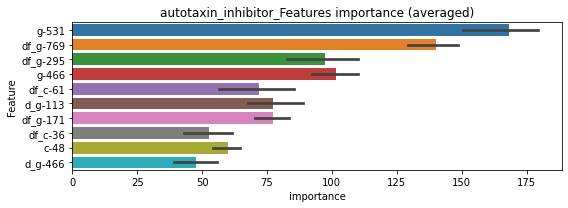

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0085432	valid_1's binary_logloss: 0.00967319
[200]	training's binary_logloss: 0.00069065	valid_1's binary_logloss: 0.00175592
Early stopping, best iteration is:
[264]	training's binary_logloss: 0.000252084	valid_1's binary_logloss: 0.00143729


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00887699	valid_1's binary_logloss: 0.0105776
[200]	training's binary_logloss: 0.000720798	valid_1's binary_logloss: 0.00104559
[300]	training's binary_logloss: 0.000183289	valid_1's binary_logloss: 0.000309417
[400]	training's binary_logloss: 0.000108307	valid_1's binary_logloss: 0.00019005
[500]	training's binary_logloss: 9.34013e-05	valid_1's binary_logloss: 0.000164684
Early stopping, best iteration is:
[495]	training's binary_logloss: 9.34345e-05	valid_1's binary_logloss: 0.000164675


autotaxin_inhibitor logloss: 0.0008010661993928037


neg labels: 3289 → selected neg labels: 3279


bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483687	valid_1's binary_logloss: 0.105233
[200]	training's binary_logloss: 0.00966756	valid_1's binary_logloss: 0.0625096
[300]	training's binary_logloss: 0.00268508	valid_1's binary_logloss: 0.0546017
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00222978	valid_1's binary_logloss: 0.0539174
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495622	valid_1's binary_logloss: 0.0932226
[200]	training's binary_logloss: 0.00928313	valid_1's binary_logloss: 0.04031
[300]	training's binary_logloss: 0.0026892	valid_1's binary_logloss: 0.0273984
[400]	training's binary_logloss: 0.00122509	valid_1's binary_logloss: 0.0226206
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000913672	valid_1's binary_logloss: 0.021552


1 / 3 AUC score:0.996
y_Threshold: 0.0118574, Threshold: 0.0182883, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 645/3782
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.01646, conf_1:0.02012
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0182883
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_2: 0.0282883
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_3: 0.0382883
threshold: 0.0382883, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467607	valid_1's binary_logloss: 0.0925707
[200]	training's binary_logloss: 0.00878719	valid_1's binary_logloss: 0.047326
[300]	training's binary_logloss: 0.0025047	valid_1's binary_logloss: 0.0374192
[400]	training's binary_logloss: 0.00116381	valid_1's binary_logloss: 0.0347334
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00112476	valid_1's binary_logloss: 0.0346889
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478534	valid_1's binary_logloss: 0.0825537
[200]	training's binary_logloss: 0.0092001	valid_1's binary_logloss: 0.031145
[300]	training's binary_logloss: 0.00265472	valid_1's binary_logloss: 0.0192507
[400]	training's binary_logloss: 0.00120979	valid_1's binary_logloss: 0.0152126
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000823138	valid_1's binary_logloss: 0.0139462


2 / 3 AUC score:0.998
y_Threshold: 0.0315077, Threshold: 0.0382883, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0062783 Vs.target_rate: 0.00252
Num_p_label: 25.0, conf_0:0.03446, conf_1:0.04212
threshold: 0.0382883, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 637.0/3766, y_label_rate: 0.1691450
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0471036	valid_1's binary_logloss: 0.0889543
[200]	training's binary_logloss: 0.00853095	valid_1's binary_logloss: 0.0392264
[300]	training's binary_logloss: 0.00244966	valid_1's binary_logloss: 0.0271962
[400]	training's binary_logloss: 0.00113351	valid_1's binary_logloss: 0.0240584
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00105892	valid_1's binary_logloss: 0.0237759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467457	valid_1's binary_logloss: 0.0873978
[200]	training's binary_logloss: 0.00863117	valid_1's binary_logloss: 0.0367953
[300]	training's binary_logloss: 0.00245972	valid_1's binary_logloss: 0.0245869
[400]	training's binary_logloss: 0.00114023	valid_1's binary_logloss: 0.0213251
[500]	training's binary_logloss: 0.000714391	valid_1's binary_logloss: 0.0200508
Early stopping, best iteration is:
[502]	tra

3 / 3 AUC score:1.000
y_Threshold: 0.0301391, Threshold: 0.0382883, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 631.0/3754
p_label_rate: 0.0067805 Vs.target_rate: 0.00252
Num_p_label: 27.0, conf_0:0.03446, conf_1:0.04212
threshold: 0.0382883, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 658.0/7736, y_label_rate: 0.0850569


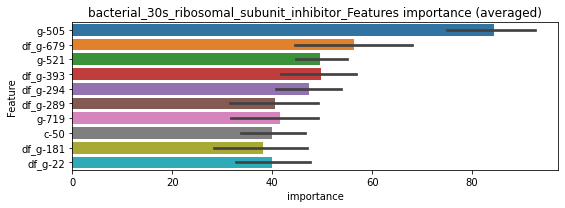

len(train_index) : 3868
len(valid_index) : 3868
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275755	valid_1's binary_logloss: 0.0609673
[200]	training's binary_logloss: 0.00519839	valid_1's binary_logloss: 0.0371721
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00176535	valid_1's binary_logloss: 0.0343168


len(train_index) : 3868
len(valid_index) : 3868
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275379	valid_1's binary_logloss: 0.0528681
[200]	training's binary_logloss: 0.00529637	valid_1's binary_logloss: 0.0252491
[300]	training's binary_logloss: 0.00149151	valid_1's binary_logloss: 0.0191562
[400]	training's binary_logloss: 0.000676894	valid_1's binary_logloss: 0.0179699
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000652206	valid_1's binary_logloss: 0.0178848


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.026100785140166567


neg labels: 3289 → selected neg labels: 3277


bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591903	valid_1's binary_logloss: 0.122245
[200]	training's binary_logloss: 0.0130731	valid_1's binary_logloss: 0.0741994
[300]	training's binary_logloss: 0.0037814	valid_1's binary_logloss: 0.0617256
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00209402	valid_1's binary_logloss: 0.0601208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582727	valid_1's binary_logloss: 0.131138
[200]	training's binary_logloss: 0.0135076	valid_1's binary_logloss: 0.0806151
[300]	training's binary_logloss: 0.00393567	valid_1's binary_logloss: 0.0682413
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.00235288	valid_1's binary_logloss: 0.0653632


1 / 3 AUC score:0.994
y_Threshold: 0.0172694, Threshold: 0.0210921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 640/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.00336
Num_p_label: 80.0, conf_0:0.01898, conf_1:0.02320
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_1: 0.0210921
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_2: 0.0310921
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_3: 0.0410921
threshold: 0.0410921, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 640.0/3770, y_label_rate: 0.1697613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579819	valid_1's binary_logloss: 0.118955
[200]	training's binary_logloss: 0.0122107	valid_1's binary_logloss: 0.0665939
[300]	training's binary_logloss: 0.00350743	valid_1's binary_logloss: 0.0540093
[400]	training's binary_logloss: 0.00158811	valid_1's binary_logloss: 0.0501634
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00119731	valid_1's binary_logloss: 0.0492916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576491	valid_1's binary_logloss: 0.120568
[200]	training's binary_logloss: 0.0126191	valid_1's binary_logloss: 0.0698025
[300]	training's binary_logloss: 0.00353793	valid_1's binary_logloss: 0.0554106
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00202345	valid_1's binary_logloss: 0.0504803


2 / 3 AUC score:0.998
y_Threshold: 0.0375439, Threshold: 0.0410921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 627.0/3744
p_label_rate: 0.0072828 Vs.target_rate: 0.00336
Num_p_label: 29.0, conf_0:0.03698, conf_1:0.04520
threshold: 0.0410921, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 627.0/3744, y_label_rate: 0.1674679
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0540917	valid_1's binary_logloss: 0.123208
[200]	training's binary_logloss: 0.0113993	valid_1's binary_logloss: 0.0715283
[300]	training's binary_logloss: 0.00332721	valid_1's binary_logloss: 0.0566725
[400]	training's binary_logloss: 0.00147852	valid_1's binary_logloss: 0.0517739
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00143401	valid_1's binary_logloss: 0.051574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535199	valid_1's binary_logloss: 0.100303
[200]	training's binary_logloss: 0.0118841	valid_1's binary_logloss: 0.0447048
[300]	training's binary_logloss: 0.00348988	valid_1's binary_logloss: 0.029259
[400]	training's binary_logloss: 0.00155379	valid_1's binary_logloss: 0.0242087
[500]	training's binary_logloss: 0.000944216	valid_1's binary_logloss: 0.0223203
Early stopping, best iteration is:
[566]	training'

3 / 3 AUC score:0.999
y_Threshold: 0.0277931, Threshold: 0.0410921, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 617.0/3724
p_label_rate: 0.0050226 Vs.target_rate: 0.00336
Num_p_label: 20.0, conf_0:0.03698, conf_1:0.04520
threshold: 0.0410921, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 637.0/7706, y_label_rate: 0.0826629


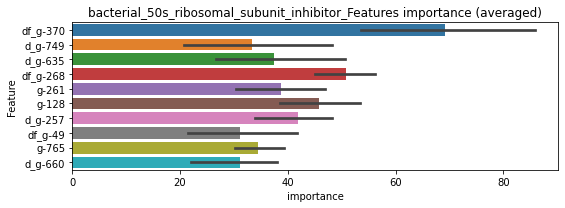

len(train_index) : 3853
len(valid_index) : 3853
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030049	valid_1's binary_logloss: 0.0613685
[200]	training's binary_logloss: 0.00626921	valid_1's binary_logloss: 0.0332766
[300]	training's binary_logloss: 0.00184209	valid_1's binary_logloss: 0.0271319
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000896234	valid_1's binary_logloss: 0.0255953


len(train_index) : 3853
len(valid_index) : 3853
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307138	valid_1's binary_logloss: 0.0661397
[200]	training's binary_logloss: 0.00667034	valid_1's binary_logloss: 0.0379245
[300]	training's binary_logloss: 0.00185488	valid_1's binary_logloss: 0.0310712
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00101993	valid_1's binary_logloss: 0.0296171


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.027606181309722207


neg labels: 3289 → selected neg labels: 3283


bacterial_antifolate, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347713	valid_1's binary_logloss: 0.052555
[200]	training's binary_logloss: 0.00534009	valid_1's binary_logloss: 0.0132403
[300]	training's binary_logloss: 0.00146798	valid_1's binary_logloss: 0.00553559
[400]	training's binary_logloss: 0.000705482	valid_1's binary_logloss: 0.00356609
[500]	training's binary_logloss: 0.000473465	valid_1's binary_logloss: 0.00284783
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.000424401	valid_1's binary_logloss: 0.00271916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330857	valid_1's binary_logloss: 0.0617637
[200]	training's binary_logloss: 0.00486963	valid_1's binary_logloss: 0.023894
[300]	training's binary_logloss: 0.00137046	valid_1's binary_logloss: 0.0166388
[400]	training's binary_logloss: 0.000671481	valid_1's binary_logloss: 0.0145589
Early stopping, best iteration is:
[401

1 / 3 AUC score:1.000
y_Threshold: 0.0046201, Threshold: 0.0067854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00611, conf_1:0.00746
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0067854
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.0167854
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0267854
threshold: 0.0267854, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329796	valid_1's binary_logloss: 0.0455228
[200]	training's binary_logloss: 0.00482692	valid_1's binary_logloss: 0.00968472
[300]	training's binary_logloss: 0.00136871	valid_1's binary_logloss: 0.00355288
[400]	training's binary_logloss: 0.000671808	valid_1's binary_logloss: 0.00205003
[500]	training's binary_logloss: 0.000456337	valid_1's binary_logloss: 0.00155405
[600]	training's binary_logloss: 0.000417295	valid_1's binary_logloss: 0.00145614
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.000413174	valid_1's binary_logloss: 0.00145145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325676	valid_1's binary_logloss: 0.0540538
[200]	training's binary_logloss: 0.0046689	valid_1's binary_logloss: 0.0169339
[300]	training's binary_logloss: 0.00133343	valid_1's binary_logloss: 0.0103289
[400]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0528110, Threshold: 0.0267854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0082873 Vs.target_rate: 0.00151
Num_p_label: 33.0, conf_0:0.02411, conf_1:0.02946
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_1: 0.0267854
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_2: 0.0367854
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0467854
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.0567854
threshold: 0.0567854, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329796	valid_1's binary_logloss: 0.0455228
[200]	training's binary_logloss: 0.00482692	valid_1's binary_logloss: 0.00968472
[300]	training's binary_logloss: 0.00136871	valid_1's binary_logloss: 0.00355288
[400]	training's binary_logloss: 0.000671808	valid_1's binary_logloss: 0.00205003
[500]	training's binary_logloss: 0.000456337	valid_1's binary_logloss: 0.00155405
[600]	training's binary_logloss: 0.000417295	valid_1's binary_logloss: 0.00145614
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.000413174	valid_1's binary_logloss: 0.00145145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325676	valid_1's binary_logloss: 0.0540538
[200]	training's binary_logloss: 0.0046689	valid_1's binary_logloss: 0.0169339
[300]	training's binary_logloss: 0.00133343	valid_1's binary_logloss: 0.0103289
[400]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0528110, Threshold: 0.0567854, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00151
Num_p_label: 10.0, conf_0:0.05111, conf_1:0.06246
threshold: 0.0567854, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 665.0/7787, y_label_rate: 0.0853987


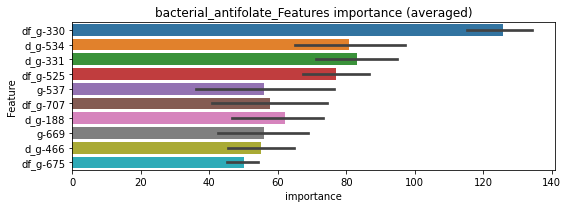

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190594	valid_1's binary_logloss: 0.0364234
[200]	training's binary_logloss: 0.0027488	valid_1's binary_logloss: 0.0153432
[300]	training's binary_logloss: 0.000743805	valid_1's binary_logloss: 0.0124415
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000608195	valid_1's binary_logloss: 0.0122988


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195275	valid_1's binary_logloss: 0.0360451
[200]	training's binary_logloss: 0.00292096	valid_1's binary_logloss: 0.0162537
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000882502	valid_1's binary_logloss: 0.0133577


bacterial_antifolate logloss: 0.01282818004208852


neg labels: 3289 → selected neg labels: 3259


bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3259, target_rate: 0.0080625 → Adj_target_rate: 0.0073283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844988	valid_1's binary_logloss: 0.244562
[200]	training's binary_logloss: 0.0268971	valid_1's binary_logloss: 0.210794
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.0195772	valid_1's binary_logloss: 0.2068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926287	valid_1's binary_logloss: 0.228286
[200]	training's binary_logloss: 0.0312228	valid_1's binary_logloss: 0.186368
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0132917	valid_1's binary_logloss: 0.177808


1 / 3 AUC score:0.935
y_Threshold: 0.0667340, Threshold: 0.0975625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 361 → Positive_corect_labels: 536/3549
p_label_rate: 0.0200904 Vs.target_rate: 0.00806
Num_p_label: 80.0, conf_0:0.08781, conf_1:0.10732
threshold: 0.0975625, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 536.0/3549, y_label_rate: 0.1510285
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686706	valid_1's binary_logloss: 0.18503
[200]	training's binary_logloss: 0.0169935	valid_1's binary_logloss: 0.138455
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0103746	valid_1's binary_logloss: 0.131784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0672936	valid_1's binary_logloss: 0.182331
[200]	training's binary_logloss: 0.0174966	valid_1's binary_logloss: 0.141824
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.0110552	valid_1's binary_logloss: 0.136682


2 / 3 AUC score:0.977
y_Threshold: 0.0853519, Threshold: 0.0975625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 108 → Positive_corect_labels: 482.0/3441
p_label_rate: 0.0215972 Vs.target_rate: 0.00806
Num_p_label: 86.0, conf_0:0.08781, conf_1:0.10732
threshold: 0.0975625, positive_p_label: 86.0/3982, p_label_rate: 0.0215972
positive_y_label: 482.0/3441, y_label_rate: 0.1400756
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569967	valid_1's binary_logloss: 0.152373
[200]	training's binary_logloss: 0.0135008	valid_1's binary_logloss: 0.107957
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00669812	valid_1's binary_logloss: 0.102786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609467	valid_1's binary_logloss: 0.139758
[200]	training's binary_logloss: 0.0147052	valid_1's binary_logloss: 0.090163
[300]	training's binary_logloss: 0.00466844	valid_1's binary_logloss: 0.0740346
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00324386	valid_1's binary_logloss: 0.0720239


3 / 3 AUC score:0.992
y_Threshold: 0.0723334, Threshold: 0.0975625, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 450.0/3377
p_label_rate: 0.0128076 Vs.target_rate: 0.00806
Num_p_label: 51.0, conf_0:0.08781, conf_1:0.10732
threshold: 0.0975625, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 501.0/7359, y_label_rate: 0.0680799


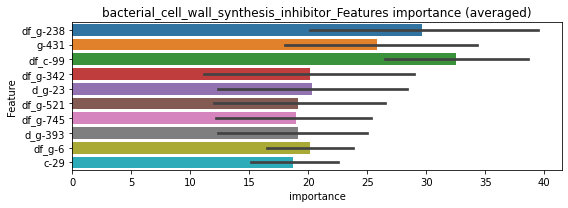

len(train_index) : 3679
len(valid_index) : 3680
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319905	valid_1's binary_logloss: 0.105909
[200]	training's binary_logloss: 0.00788107	valid_1's binary_logloss: 0.0876346
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00566912	valid_1's binary_logloss: 0.0857662


len(train_index) : 3680
len(valid_index) : 3679
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332977	valid_1's binary_logloss: 0.0966766
[200]	training's binary_logloss: 0.00826985	valid_1's binary_logloss: 0.0754696
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00593329	valid_1's binary_logloss: 0.0738751


bacterial_cell_wall_synthesis_inhibitor logloss: 0.07982148082933495


neg labels: 3289 → selected neg labels: 3274


bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0581003	valid_1's binary_logloss: 0.134996
[200]	training's binary_logloss: 0.0126068	valid_1's binary_logloss: 0.0892552
[300]	training's binary_logloss: 0.00373219	valid_1's binary_logloss: 0.0790168
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00332842	valid_1's binary_logloss: 0.0785435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0601652	valid_1's binary_logloss: 0.130939
[200]	training's binary_logloss: 0.0150916	valid_1's binary_logloss: 0.0819323
[300]	training's binary_logloss: 0.00435624	valid_1's binary_logloss: 0.0628862
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00192553	valid_1's binary_logloss: 0.0577054


1 / 3 AUC score:0.989
y_Threshold: 0.0216222, Threshold: 0.0313731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 170 → Positive_corect_labels: 635/3758
p_label_rate: 0.0200904 Vs.target_rate: 0.00374
Num_p_label: 80.0, conf_0:0.02824, conf_1:0.03451
Num_p_label: 80.0, Expected: 14.9, Adj_threshold_1: 0.0313731
Num_p_label: 46.0, Expected: 14.9, Adj_threshold_2: 0.0413731
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_3: 0.0513731
threshold: 0.0513731, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 635.0/3758, y_label_rate: 0.1689729
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556638	valid_1's binary_logloss: 0.118222
[200]	training's binary_logloss: 0.0115887	valid_1's binary_logloss: 0.0674979
[300]	training's binary_logloss: 0.0034505	valid_1's binary_logloss: 0.054973
[400]	training's binary_logloss: 0.00154796	valid_1's binary_logloss: 0.0512042
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00154796	valid_1's binary_logloss: 0.0512042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562373	valid_1's binary_logloss: 0.112775
[200]	training's binary_logloss: 0.0120362	valid_1's binary_logloss: 0.0594318
[300]	training's binary_logloss: 0.00360013	valid_1's binary_logloss: 0.0460791
[400]	training's binary_logloss: 0.00163063	valid_1's binary_logloss: 0.0414381
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00168815	valid_1's binary_logloss: 0.0413355


2 / 3 AUC score:0.998
y_Threshold: 0.0441248, Threshold: 0.0513731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 624.0/3736
p_label_rate: 0.0102963 Vs.target_rate: 0.00374
Num_p_label: 41.0, conf_0:0.04624, conf_1:0.05651
threshold: 0.0513731, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 624.0/3736, y_label_rate: 0.1670236
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0535176	valid_1's binary_logloss: 0.117884
[200]	training's binary_logloss: 0.0114067	valid_1's binary_logloss: 0.0658256
[300]	training's binary_logloss: 0.00342924	valid_1's binary_logloss: 0.0530483
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00258563	valid_1's binary_logloss: 0.0517082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544267	valid_1's binary_logloss: 0.12688
[200]	training's binary_logloss: 0.0108948	valid_1's binary_logloss: 0.0754316
[300]	training's binary_logloss: 0.00322003	valid_1's binary_logloss: 0.0647855
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00243839	valid_1's binary_logloss: 0.0636393


3 / 3 AUC score:0.993
y_Threshold: 0.0413806, Threshold: 0.0513731, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 602.0/3692
p_label_rate: 0.0163235 Vs.target_rate: 0.00374
Num_p_label: 65.0, conf_0:0.04624, conf_1:0.05651
Num_p_label: 65.0, Expected: 14.9, Adj_threshold_1: 0.0513731
Num_p_label: 45.0, Expected: 14.9, Adj_threshold_2: 0.0613731
Num_p_label: 35.0, Expected: 14.9, Adj_threshold_3: 0.0713731
Num_p_label: 25.0, Expected: 14.9, Adj_threshold_4: 0.0813731
threshold: 0.0813731, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 627.0/7674, y_label_rate: 0.0817045


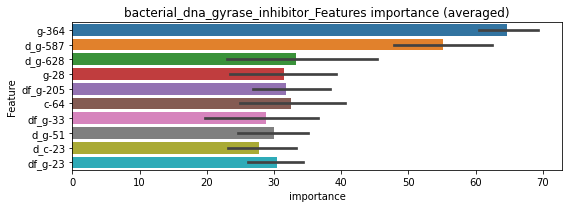

len(train_index) : 3837
len(valid_index) : 3837
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306618	valid_1's binary_logloss: 0.0789609
[200]	training's binary_logloss: 0.00642094	valid_1's binary_logloss: 0.0537137
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00292938	valid_1's binary_logloss: 0.051146


len(train_index) : 3837
len(valid_index) : 3837
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288028	valid_1's binary_logloss: 0.074184
[200]	training's binary_logloss: 0.00609029	valid_1's binary_logloss: 0.0478302
[300]	training's binary_logloss: 0.00173798	valid_1's binary_logloss: 0.0424704
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00170303	valid_1's binary_logloss: 0.0424047


bacterial_dna_gyrase_inhibitor logloss: 0.04677537470302668


neg labels: 3289 → selected neg labels: 3271


bacterial_dna_inhibitor, len(trt): 115, len(othr): 3271, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676967	valid_1's binary_logloss: 0.160819
[200]	training's binary_logloss: 0.017615	valid_1's binary_logloss: 0.110411
[300]	training's binary_logloss: 0.00550897	valid_1's binary_logloss: 0.0993871
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00473758	valid_1's binary_logloss: 0.0981977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0689253	valid_1's binary_logloss: 0.145376
[200]	training's binary_logloss: 0.0188631	valid_1's binary_logloss: 0.0916282
[300]	training's binary_logloss: 0.00564758	valid_1's binary_logloss: 0.0746837
[400]	training's binary_logloss: 0.00244971	valid_1's binary_logloss: 0.0689327
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00166456	valid_1's binary_logloss: 0.067431


1 / 3 AUC score:0.990
y_Threshold: 0.0262941, Threshold: 0.0332751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 183 → Positive_corect_labels: 628/3742
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.02995, conf_1:0.03660
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0332751
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_2: 0.0432751
Num_p_label: 30.0, Expected: 19.2, Adj_threshold_3: 0.0532751
threshold: 0.0532751, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 628.0/3742, y_label_rate: 0.1678247
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060011	valid_1's binary_logloss: 0.148976
[200]	training's binary_logloss: 0.0143393	valid_1's binary_logloss: 0.0999691
[300]	training's binary_logloss: 0.00446057	valid_1's binary_logloss: 0.0864357
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00315923	valid_1's binary_logloss: 0.084687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646481	valid_1's binary_logloss: 0.13815
[200]	training's binary_logloss: 0.0156721	valid_1's binary_logloss: 0.0861638
[300]	training's binary_logloss: 0.00490003	valid_1's binary_logloss: 0.0721854
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00485064	valid_1's binary_logloss: 0.0721604


2 / 3 AUC score:0.994
y_Threshold: 0.0501301, Threshold: 0.0532751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 54 → Positive_corect_labels: 601.0/3688
p_label_rate: 0.0188348 Vs.target_rate: 0.00483
Num_p_label: 75.0, conf_0:0.04795, conf_1:0.05860
Num_p_label: 75.0, Expected: 19.2, Adj_threshold_1: 0.0532751
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_2: 0.0632751
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_3: 0.0732751
Num_p_label: 30.0, Expected: 19.2, Adj_threshold_4: 0.0832751
threshold: 0.0832751, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 601.0/3688, y_label_rate: 0.1629610
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055804	valid_1's binary_logloss: 0.134
[200]	training's binary_logloss: 0.0127188	valid_1's binary_logloss: 0.0869412
[300]	training's binary_logloss: 0.00390713	valid_1's binary_logloss: 0.0778097
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00310094	valid_1's binary_logloss: 0.0761986
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0564766	valid_1's binary_logloss: 0.133102
[200]	training's binary_logloss: 0.0129467	valid_1's binary_logloss: 0.0881912
[300]	training's binary_logloss: 0.0039967	valid_1's binary_logloss: 0.0757402
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00384763	valid_1's binary_logloss: 0.0754596


3 / 3 AUC score:0.993
y_Threshold: 0.0441651, Threshold: 0.0832751, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 570.0/3626
p_label_rate: 0.0065294 Vs.target_rate: 0.00483
Num_p_label: 26.0, conf_0:0.07495, conf_1:0.09160
threshold: 0.0832751, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 596.0/7608, y_label_rate: 0.0783386


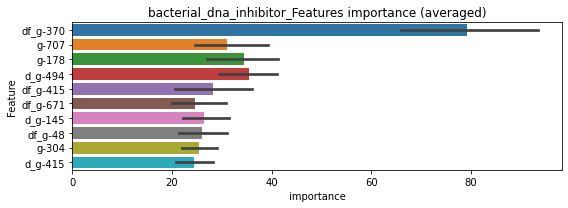

len(train_index) : 3804
len(valid_index) : 3804
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293222	valid_1's binary_logloss: 0.0796501
[200]	training's binary_logloss: 0.00655211	valid_1's binary_logloss: 0.0588915
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00246404	valid_1's binary_logloss: 0.0561008


len(train_index) : 3804
len(valid_index) : 3804
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287101	valid_1's binary_logloss: 0.073499
[200]	training's binary_logloss: 0.00675162	valid_1's binary_logloss: 0.0488116
[300]	training's binary_logloss: 0.00207798	valid_1's binary_logloss: 0.043151
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00197745	valid_1's binary_logloss: 0.042909


bacterial_dna_inhibitor logloss: 0.04950492255069577


neg labels: 3289 → selected neg labels: 3285


bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236667	valid_1's binary_logloss: 0.033026
[200]	training's binary_logloss: 0.00269655	valid_1's binary_logloss: 0.00579369
[300]	training's binary_logloss: 0.000750373	valid_1's binary_logloss: 0.00244588
[400]	training's binary_logloss: 0.000391874	valid_1's binary_logloss: 0.00163329
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.000330022	valid_1's binary_logloss: 0.00149464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0238666	valid_1's binary_logloss: 0.0287891
[200]	training's binary_logloss: 0.00271365	valid_1's binary_logloss: 0.00410085
[300]	training's binary_logloss: 0.000750264	valid_1's binary_logloss: 0.00135691
[400]	training's binary_logloss: 0.000398957	valid_1's binary_logloss: 0.000819809
[500]	training's binary_logloss: 0.000328721	valid_1's binary_logloss: 0.000703696
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0015213, Threshold: 0.0027644, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00249, conf_1:0.00304
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0027644
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.0127644
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.0227644
Num_p_label: 4.0, Expected: 3.2, Adj_threshold_4: 0.0327644
threshold: 0.0327644, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233116	valid_1's binary_logloss: 0.0331408
[200]	training's binary_logloss: 0.00258571	valid_1's binary_logloss: 0.00603304
[300]	training's binary_logloss: 0.000707407	valid_1's binary_logloss: 0.00246762
[400]	training's binary_logloss: 0.000373455	valid_1's binary_logloss: 0.0016421
[500]	training's binary_logloss: 0.00031429	valid_1's binary_logloss: 0.00150149
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000312305	valid_1's binary_logloss: 0.00149582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234683	valid_1's binary_logloss: 0.0275192
[200]	training's binary_logloss: 0.00261025	valid_1's binary_logloss: 0.00356403
[300]	training's binary_logloss: 0.000733294	valid_1's binary_logloss: 0.00108214
[400]	training's binary_logloss: 0.000389841	valid_1's binary_logloss: 0.000602693
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1072512, Threshold: 0.0327644, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0062783 Vs.target_rate: 0.00080
Num_p_label: 25.0, conf_0:0.02949, conf_1:0.03604
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_1: 0.0327644
Num_p_label: 22.0, Expected: 3.2, Adj_threshold_2: 0.0427644
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_3: 0.0527644
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_4: 0.0627644
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_5: 0.0727644
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_6: 0.0827644
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_7: 0.0927644
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_8: 0.1027644
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_9: 0.1127644
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_10: 0.1227644
threshold: 0.1327644, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
===========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233116	valid_1's binary_logloss: 0.0331408
[200]	training's binary_logloss: 0.00258571	valid_1's binary_logloss: 0.00603304
[300]	training's binary_logloss: 0.000707407	valid_1's binary_logloss: 0.00246762
[400]	training's binary_logloss: 0.000373455	valid_1's binary_logloss: 0.0016421
[500]	training's binary_logloss: 0.00031429	valid_1's binary_logloss: 0.00150149
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000312305	valid_1's binary_logloss: 0.00149582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234683	valid_1's binary_logloss: 0.0275192
[200]	training's binary_logloss: 0.00261025	valid_1's binary_logloss: 0.00356403
[300]	training's binary_logloss: 0.000733294	valid_1's binary_logloss: 0.00108214
[400]	training's binary_logloss: 0.000389841	valid_1's binary_logloss: 0.000602693
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1072512, Threshold: 0.1327644, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080
Num_p_label: 7.0, conf_0:0.11949, conf_1:0.14604
threshold: 0.1327644, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


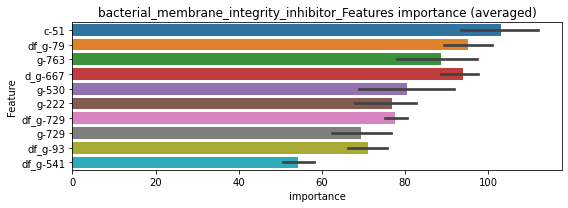

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122439	valid_1's binary_logloss: 0.0220888
[200]	training's binary_logloss: 0.00138262	valid_1's binary_logloss: 0.00886522
[300]	training's binary_logloss: 0.000377467	valid_1's binary_logloss: 0.00764124
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000324178	valid_1's binary_logloss: 0.00756563


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129897	valid_1's binary_logloss: 0.0193547
[200]	training's binary_logloss: 0.0014039	valid_1's binary_logloss: 0.00498264
[300]	training's binary_logloss: 0.000379369	valid_1's binary_logloss: 0.0030796
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000228781	valid_1's binary_logloss: 0.00271048


bacterial_membrane_integrity_inhibitor logloss: 0.005138052731479405


neg labels: 3289 → selected neg labels: 3283


bcl_inhibitor, len(trt): 31, len(othr): 3283, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287772	valid_1's binary_logloss: 0.0417351
[200]	training's binary_logloss: 0.00385526	valid_1's binary_logloss: 0.00932637
[300]	training's binary_logloss: 0.00109762	valid_1's binary_logloss: 0.00410117
[400]	training's binary_logloss: 0.000557622	valid_1's binary_logloss: 0.00275475
[500]	training's binary_logloss: 0.000405594	valid_1's binary_logloss: 0.00231178
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000395121	valid_1's binary_logloss: 0.00226628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286052	valid_1's binary_logloss: 0.0453498
[200]	training's binary_logloss: 0.00382061	valid_1's binary_logloss: 0.0128545
[300]	training's binary_logloss: 0.00108825	valid_1's binary_logloss: 0.00775915
[400]	training's binary_logloss: 0.000549592	valid_1's binary_logloss: 0.00649187
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0030050, Threshold: 0.0794173, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.07148, conf_1:0.08736
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0794173
Num_p_label: 76.0, Expected: 5.2, Adj_threshold_2: 0.0894173
Num_p_label: 74.0, Expected: 5.2, Adj_threshold_3: 0.0994173
Num_p_label: 66.0, Expected: 5.2, Adj_threshold_4: 0.1094173
Num_p_label: 63.0, Expected: 5.2, Adj_threshold_5: 0.1194173
Num_p_label: 60.0, Expected: 5.2, Adj_threshold_6: 0.1294173
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_7: 0.1394173
Num_p_label: 54.0, Expected: 5.2, Adj_threshold_8: 0.1494173
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_9: 0.1594173
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_10: 0.1694173
threshold: 0.1794173, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274372	valid_1's binary_logloss: 0.0387207
[200]	training's binary_logloss: 0.00352438	valid_1's binary_logloss: 0.00798002
[300]	training's binary_logloss: 0.000998796	valid_1's binary_logloss: 0.00314375
[400]	training's binary_logloss: 0.000513328	valid_1's binary_logloss: 0.00197963
[500]	training's binary_logloss: 0.000380572	valid_1's binary_logloss: 0.0016736
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00036629	valid_1's binary_logloss: 0.00163907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270082	valid_1's binary_logloss: 0.0411409
[200]	training's binary_logloss: 0.0034515	valid_1's binary_logloss: 0.00856509
[300]	training's binary_logloss: 0.000976283	valid_1's binary_logloss: 0.00380575
[400]	training's binary_logloss: 0.000496708	valid_1's binary_logloss: 0.00247577
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.3374607, Threshold: 0.1794173, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0359116 Vs.target_rate: 0.00130
Num_p_label: 143.0, conf_0:0.16148, conf_1:0.19736
Num_p_label: 143.0, Expected: 5.2, Adj_threshold_1: 0.1794173
Num_p_label: 141.0, Expected: 5.2, Adj_threshold_2: 0.1894173
Num_p_label: 139.0, Expected: 5.2, Adj_threshold_3: 0.1994173
Num_p_label: 136.0, Expected: 5.2, Adj_threshold_4: 0.2094173
Num_p_label: 135.0, Expected: 5.2, Adj_threshold_5: 0.2194173
Num_p_label: 134.0, Expected: 5.2, Adj_threshold_6: 0.2294173
Num_p_label: 134.0, Expected: 5.2, Adj_threshold_7: 0.2394173
Num_p_label: 129.0, Expected: 5.2, Adj_threshold_8: 0.2494173
Num_p_label: 126.0, Expected: 5.2, Adj_threshold_9: 0.2594173
Num_p_label: 124.0, Expected: 5.2, Adj_threshold_10: 0.2694173
threshold: 0.2794173, positive_p_label: 123.0/3982, p_label_rate: 0.0308890
positive_y_label: 656.0/3807, y_label_rate: 0.17231

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274372	valid_1's binary_logloss: 0.0387207
[200]	training's binary_logloss: 0.00352438	valid_1's binary_logloss: 0.00798002
[300]	training's binary_logloss: 0.000998796	valid_1's binary_logloss: 0.00314375
[400]	training's binary_logloss: 0.000513328	valid_1's binary_logloss: 0.00197963
[500]	training's binary_logloss: 0.000380572	valid_1's binary_logloss: 0.0016736
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00036629	valid_1's binary_logloss: 0.00163907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270082	valid_1's binary_logloss: 0.0411409
[200]	training's binary_logloss: 0.0034515	valid_1's binary_logloss: 0.00856509
[300]	training's binary_logloss: 0.000976283	valid_1's binary_logloss: 0.00380575
[400]	training's binary_logloss: 0.000496708	valid_1's binary_logloss: 0.00247577
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.3374607, Threshold: 0.2794173, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0308890 Vs.target_rate: 0.00130
Num_p_label: 123.0, conf_0:0.25148, conf_1:0.30736
Num_p_label: 123.0, Expected: 5.2, Adj_threshold_1: 0.2794173
Num_p_label: 121.0, Expected: 5.2, Adj_threshold_2: 0.2894173
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_3: 0.2994173
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_4: 0.3094173
Num_p_label: 120.0, Expected: 5.2, Adj_threshold_5: 0.3194173
Num_p_label: 119.0, Expected: 5.2, Adj_threshold_6: 0.3294173
Num_p_label: 119.0, Expected: 5.2, Adj_threshold_7: 0.3394173
Num_p_label: 117.0, Expected: 5.2, Adj_threshold_8: 0.3494173
Num_p_label: 116.0, Expected: 5.2, Adj_threshold_9: 0.3594173
Num_p_label: 114.0, Expected: 5.2, Adj_threshold_10: 0.3694173
threshold: 0.3794173, positive_p_label: 114.0/3982, p_label_rate: 0.0286288
positive_y_label: 770.0/7789, y_label_rate: 0.09885

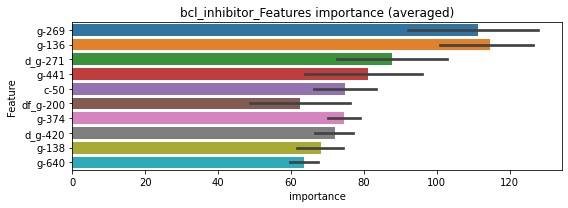

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171879	valid_1's binary_logloss: 0.0344895
[200]	training's binary_logloss: 0.00237703	valid_1's binary_logloss: 0.0158931
[300]	training's binary_logloss: 0.000695254	valid_1's binary_logloss: 0.0128843
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000466497	valid_1's binary_logloss: 0.0121682


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180495	valid_1's binary_logloss: 0.0325367
[200]	training's binary_logloss: 0.00255108	valid_1's binary_logloss: 0.0115816
[300]	training's binary_logloss: 0.000727436	valid_1's binary_logloss: 0.00826139
[400]	training's binary_logloss: 0.000361751	valid_1's binary_logloss: 0.00740423
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000346129	valid_1's binary_logloss: 0.00733832


bcl_inhibitor logloss: 0.009753564772155679


neg labels: 3289 → selected neg labels: 3283


bcr-abl_inhibitor, len(trt): 38, len(othr): 3283, target_rate: 0.0015957 → Adj_target_rate: 0.0018493
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330075	valid_1's binary_logloss: 0.0511202
[200]	training's binary_logloss: 0.00504725	valid_1's binary_logloss: 0.0142787
[300]	training's binary_logloss: 0.00142948	valid_1's binary_logloss: 0.00648385
[400]	training's binary_logloss: 0.00069944	valid_1's binary_logloss: 0.00440245
[500]	training's binary_logloss: 0.000474221	valid_1's binary_logloss: 0.0036335
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000442772	valid_1's binary_logloss: 0.00352477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329356	valid_1's binary_logloss: 0.0580591
[200]	training's binary_logloss: 0.0048909	valid_1's binary_logloss: 0.0185015
[300]	training's binary_logloss: 0.00137212	valid_1's binary_logloss: 0.00976311
[400]	training's binary_logloss: 0.000679431	valid_1's binary_logloss: 0.00729831
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0045087, Threshold: 0.0074437, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00160
Num_p_label: 80.0, conf_0:0.00670, conf_1:0.00819
Num_p_label: 80.0, Expected: 6.4, Adj_threshold_1: 0.0074437
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_2: 0.0174437
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_3: 0.0274437
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_4: 0.0374437
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_5: 0.0474437
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_6: 0.0574437
threshold: 0.0574437, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311297	valid_1's binary_logloss: 0.0474141
[200]	training's binary_logloss: 0.00450186	valid_1's binary_logloss: 0.0116729
[300]	training's binary_logloss: 0.00128837	valid_1's binary_logloss: 0.00495034
[400]	training's binary_logloss: 0.000643112	valid_1's binary_logloss: 0.00316366
[500]	training's binary_logloss: 0.000453366	valid_1's binary_logloss: 0.00260774
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000424291	valid_1's binary_logloss: 0.00252021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308359	valid_1's binary_logloss: 0.0495975
[200]	training's binary_logloss: 0.00441425	valid_1's binary_logloss: 0.0128295
[300]	training's binary_logloss: 0.00128537	valid_1's binary_logloss: 0.0062478
[400]	training's binary_logloss: 0.000646134	valid_1's binary_logloss: 0.00431269
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1707407, Threshold: 0.0574437, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0107986 Vs.target_rate: 0.00160
Num_p_label: 43.0, conf_0:0.05170, conf_1:0.06319
Num_p_label: 43.0, Expected: 6.4, Adj_threshold_1: 0.0574437
Num_p_label: 39.0, Expected: 6.4, Adj_threshold_2: 0.0674437
Num_p_label: 36.0, Expected: 6.4, Adj_threshold_3: 0.0774437
Num_p_label: 34.0, Expected: 6.4, Adj_threshold_4: 0.0874437
Num_p_label: 32.0, Expected: 6.4, Adj_threshold_5: 0.0974437
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_6: 0.1074437
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_7: 0.1174437
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_8: 0.1274437
Num_p_label: 27.0, Expected: 6.4, Adj_threshold_9: 0.1374437
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_10: 0.1474437
threshold: 0.1574437, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311297	valid_1's binary_logloss: 0.0474141
[200]	training's binary_logloss: 0.00450186	valid_1's binary_logloss: 0.0116729
[300]	training's binary_logloss: 0.00128837	valid_1's binary_logloss: 0.00495034
[400]	training's binary_logloss: 0.000643112	valid_1's binary_logloss: 0.00316366
[500]	training's binary_logloss: 0.000453366	valid_1's binary_logloss: 0.00260774
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000424291	valid_1's binary_logloss: 0.00252021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0308359	valid_1's binary_logloss: 0.0495975
[200]	training's binary_logloss: 0.00441425	valid_1's binary_logloss: 0.0128295
[300]	training's binary_logloss: 0.00128537	valid_1's binary_logloss: 0.0062478
[400]	training's binary_logloss: 0.000646134	valid_1's binary_logloss: 0.00431269
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1707407, Threshold: 0.1574437, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0060271 Vs.target_rate: 0.00160
Num_p_label: 24.0, conf_0:0.14170, conf_1:0.17319
Num_p_label: 24.0, Expected: 6.4, Adj_threshold_1: 0.1574437
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_2: 0.1674437
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_3: 0.1774437
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_4: 0.1874437
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_5: 0.1974437
Num_p_label: 20.0, Expected: 6.4, Adj_threshold_6: 0.2074437
Num_p_label: 18.0, Expected: 6.4, Adj_threshold_7: 0.2174437
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_8: 0.2274437
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_9: 0.2374437
Num_p_label: 14.0, Expected: 6.4, Adj_threshold_10: 0.2474437
threshold: 0.2574437, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 670.0/7789, y_label_rate: 0.0860187


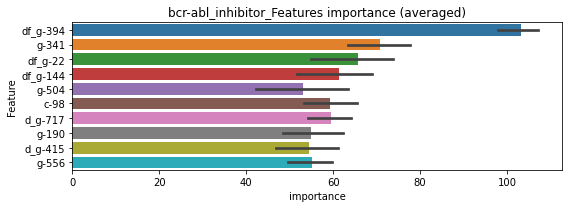

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177015	valid_1's binary_logloss: 0.0375207
[200]	training's binary_logloss: 0.00254577	valid_1's binary_logloss: 0.0171404
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000907627	valid_1's binary_logloss: 0.0144869


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175492	valid_1's binary_logloss: 0.0284089
[200]	training's binary_logloss: 0.00263147	valid_1's binary_logloss: 0.00733559
[300]	training's binary_logloss: 0.000746486	valid_1's binary_logloss: 0.00333684
[400]	training's binary_logloss: 0.000375365	valid_1's binary_logloss: 0.00234629
[500]	training's binary_logloss: 0.00025547	valid_1's binary_logloss: 0.00193443
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000244579	valid_1's binary_logloss: 0.00189779


bcr-abl_inhibitor logloss: 0.008193133108895124


neg labels: 3289 → selected neg labels: 3277


benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3277, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0545939	valid_1's binary_logloss: 0.109227
[200]	training's binary_logloss: 0.0113419	valid_1's binary_logloss: 0.0510448
[300]	training's binary_logloss: 0.00319181	valid_1's binary_logloss: 0.0343022
[400]	training's binary_logloss: 0.00141802	valid_1's binary_logloss: 0.0290494
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00147458	valid_1's binary_logloss: 0.0289823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0523757	valid_1's binary_logloss: 0.107718
[200]	training's binary_logloss: 0.0111354	valid_1's binary_logloss: 0.0565955
[300]	training's binary_logloss: 0.00306417	valid_1's binary_logloss: 0.0412822
[400]	training's binary_logloss: 0.00137092	valid_1's binary_logloss: 0.0365556
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00099085	valid_1's binary_logloss: 0.0356698


1 / 3 AUC score:0.999
y_Threshold: 0.0120769, Threshold: 0.0225121, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.02026, conf_1:0.02476
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0225121
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_2: 0.0325121
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_3: 0.0425121
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_4: 0.0525121
threshold: 0.0525121, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 651.0/3792, y_label_rate: 0.1716772
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0528282	valid_1's binary_logloss: 0.103726
[200]	training's binary_logloss: 0.0105467	valid_1's binary_logloss: 0.0496742
[300]	training's binary_logloss: 0.00300952	valid_1's binary_logloss: 0.035698
[400]	training's binary_logloss: 0.00135967	valid_1's binary_logloss: 0.0308635
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00119921	valid_1's binary_logloss: 0.0303355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0504121	valid_1's binary_logloss: 0.0952884
[200]	training's binary_logloss: 0.0099508	valid_1's binary_logloss: 0.0419274
[300]	training's binary_logloss: 0.00286412	valid_1's binary_logloss: 0.0296821
[400]	training's binary_logloss: 0.00131414	valid_1's binary_logloss: 0.0262994
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000940522	valid_1's binary_logloss: 0.0252096


2 / 3 AUC score:0.999
y_Threshold: 0.0400965, Threshold: 0.0525121, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 642.0/3774
p_label_rate: 0.0102963 Vs.target_rate: 0.00281
Num_p_label: 41.0, conf_0:0.04726, conf_1:0.05776
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_1: 0.0525121
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_2: 0.0625121
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_3: 0.0725121
threshold: 0.0725121, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 642.0/3774, y_label_rate: 0.1701113
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0489383	valid_1's binary_logloss: 0.112946
[200]	training's binary_logloss: 0.00912878	valid_1's binary_logloss: 0.0664626
[300]	training's binary_logloss: 0.00263207	valid_1's binary_logloss: 0.0550018
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00216835	valid_1's binary_logloss: 0.0534552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0530131	valid_1's binary_logloss: 0.0956758
[200]	training's binary_logloss: 0.00999914	valid_1's binary_logloss: 0.0373357
[300]	training's binary_logloss: 0.00283085	valid_1's binary_logloss: 0.0223431
[400]	training's binary_logloss: 0.00130913	valid_1's binary_logloss: 0.0175017
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000931093	valid_1's binary_logloss: 0.0164733


3 / 3 AUC score:0.997
y_Threshold: 0.0499668, Threshold: 0.0725121, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 631.0/3752
p_label_rate: 0.0092918 Vs.target_rate: 0.00281
Num_p_label: 37.0, conf_0:0.06526, conf_1:0.07976
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_1: 0.0725121
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_2: 0.0825121
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_3: 0.0925121
Num_p_label: 23.0, Expected: 11.2, Adj_threshold_4: 0.1025121
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_5: 0.1125121
threshold: 0.1125121, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 653.0/7734, y_label_rate: 0.0844324


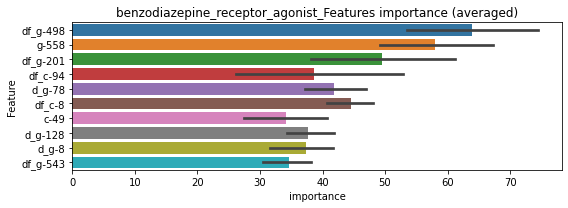

len(train_index) : 3867
len(valid_index) : 3867
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285461	valid_1's binary_logloss: 0.0619468
[200]	training's binary_logloss: 0.00557721	valid_1's binary_logloss: 0.0323855
[300]	training's binary_logloss: 0.00155239	valid_1's binary_logloss: 0.0248342
[400]	training's binary_logloss: 0.000699743	valid_1's binary_logloss: 0.0232057
Early stopping, best iteration is:
[406]	training's binary_logloss: 0.000674896	valid_1's binary_logloss: 0.0230997


len(train_index) : 3867
len(valid_index) : 3867
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02961	valid_1's binary_logloss: 0.0623861
[200]	training's binary_logloss: 0.00604009	valid_1's binary_logloss: 0.0317926
[300]	training's binary_logloss: 0.00171862	valid_1's binary_logloss: 0.0236296
[400]	training's binary_logloss: 0.00075	valid_1's binary_logloss: 0.0215725
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00066123	valid_1's binary_logloss: 0.0213579


benzodiazepine_receptor_agonist logloss: 0.022228819278914038


neg labels: 3289 → selected neg labels: 3285


beta_amyloid_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288122	valid_1's binary_logloss: 0.0409233
[200]	training's binary_logloss: 0.00387933	valid_1's binary_logloss: 0.0106862
[300]	training's binary_logloss: 0.00107491	valid_1's binary_logloss: 0.00669856
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000579754	valid_1's binary_logloss: 0.00583541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292627	valid_1's binary_logloss: 0.0487344
[200]	training's binary_logloss: 0.00388422	valid_1's binary_logloss: 0.0118576
[300]	training's binary_logloss: 0.00107532	valid_1's binary_logloss: 0.00633616
[400]	training's binary_logloss: 0.000547119	valid_1's binary_logloss: 0.00502419
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000415752	valid_1's binary_logloss: 0.00461004


1 / 3 AUC score:1.000
y_Threshold: 0.0028083, Threshold: 0.0050814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00457, conf_1:0.00559
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0050814
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_2: 0.0150814
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_3: 0.0250814
threshold: 0.0250814, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289931	valid_1's binary_logloss: 0.039775
[200]	training's binary_logloss: 0.00380084	valid_1's binary_logloss: 0.0103954
[300]	training's binary_logloss: 0.00105939	valid_1's binary_logloss: 0.00680678
[400]	training's binary_logloss: 0.000531708	valid_1's binary_logloss: 0.00610355
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000537748	valid_1's binary_logloss: 0.00608792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287834	valid_1's binary_logloss: 0.0472723
[200]	training's binary_logloss: 0.00376603	valid_1's binary_logloss: 0.01109
[300]	training's binary_logloss: 0.00104954	valid_1's binary_logloss: 0.00528159
[400]	training's binary_logloss: 0.000537298	valid_1's binary_logloss: 0.00405909
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.000404488	valid_1's binary_logloss: 0.00370583


2 / 3 AUC score:1.000
y_Threshold: 0.0114924, Threshold: 0.0250814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00101
Num_p_label: 10.0, conf_0:0.02257, conf_1:0.02759
threshold: 0.0250814, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289085	valid_1's binary_logloss: 0.0417043
[200]	training's binary_logloss: 0.00378887	valid_1's binary_logloss: 0.0100153
[300]	training's binary_logloss: 0.00106423	valid_1's binary_logloss: 0.0056382
[400]	training's binary_logloss: 0.000542472	valid_1's binary_logloss: 0.00476698
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000515158	valid_1's binary_logloss: 0.00469292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283048	valid_1's binary_logloss: 0.0458849
[200]	training's binary_logloss: 0.00379164	valid_1's binary_logloss: 0.00978001
[300]	training's binary_logloss: 0.00106358	valid_1's binary_logloss: 0.00421465
[400]	training's binary_logloss: 0.000536657	valid_1's binary_logloss: 0.00280457
[500]	training's binary_logloss: 0.000392053	valid_1's binary_logloss: 0.00236035
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0108247, Threshold: 0.0250814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0015068 Vs.target_rate: 0.00101
Num_p_label: 6.0, conf_0:0.02257, conf_1:0.02759
threshold: 0.0250814, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 661.0/7788, y_label_rate: 0.0848742


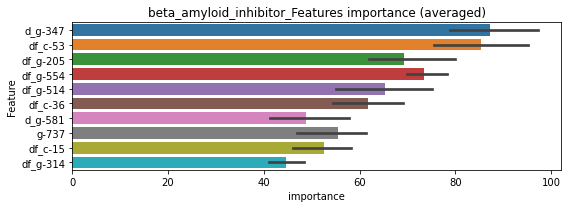

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155253	valid_1's binary_logloss: 0.0289999
[200]	training's binary_logloss: 0.00204188	valid_1's binary_logloss: 0.0119563
[300]	training's binary_logloss: 0.000553224	valid_1's binary_logloss: 0.00947174
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000509486	valid_1's binary_logloss: 0.00938209


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162553	valid_1's binary_logloss: 0.0228845
[200]	training's binary_logloss: 0.00222292	valid_1's binary_logloss: 0.0062695
[300]	training's binary_logloss: 0.000594222	valid_1's binary_logloss: 0.00398686
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000348064	valid_1's binary_logloss: 0.003636


beta_amyloid_inhibitor logloss: 0.006509045206032045


neg labels: 3289 → selected neg labels: 3276


bromodomain_inhibitor, len(trt): 68, len(othr): 3276, target_rate: 0.0028555 → Adj_target_rate: 0.0030327
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367448	valid_1's binary_logloss: 0.0641306
[200]	training's binary_logloss: 0.0058891	valid_1's binary_logloss: 0.0268606
[300]	training's binary_logloss: 0.00172384	valid_1's binary_logloss: 0.0191843
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00158972	valid_1's binary_logloss: 0.0189372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346494	valid_1's binary_logloss: 0.0779576
[200]	training's binary_logloss: 0.00548051	valid_1's binary_logloss: 0.0425819
[300]	training's binary_logloss: 0.00158296	valid_1's binary_logloss: 0.0369843
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00121771	valid_1's binary_logloss: 0.0361231


1 / 3 AUC score:0.998
y_Threshold: 0.0090368, Threshold: 0.0132197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3791
p_label_rate: 0.0200904 Vs.target_rate: 0.00286
Num_p_label: 80.0, conf_0:0.01190, conf_1:0.01454
Num_p_label: 80.0, Expected: 11.4, Adj_threshold_1: 0.0132197
Num_p_label: 34.0, Expected: 11.4, Adj_threshold_2: 0.0232197
Num_p_label: 19.0, Expected: 11.4, Adj_threshold_3: 0.0332197
threshold: 0.0332197, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 651.0/3791, y_label_rate: 0.1717225
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350827	valid_1's binary_logloss: 0.0676092
[200]	training's binary_logloss: 0.00525963	valid_1's binary_logloss: 0.0239736
[300]	training's binary_logloss: 0.0015088	valid_1's binary_logloss: 0.0140069
[400]	training's binary_logloss: 0.000741552	valid_1's binary_logloss: 0.0108264
[500]	training's binary_logloss: 0.000498822	valid_1's binary_logloss: 0.00972932
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000473763	valid_1's binary_logloss: 0.0095341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345185	valid_1's binary_logloss: 0.05897
[200]	training's binary_logloss: 0.00526739	valid_1's binary_logloss: 0.0205195
[300]	training's binary_logloss: 0.00151929	valid_1's binary_logloss: 0.0132353
[400]	training's binary_logloss: 0.000755774	valid_1's binary_logloss: 0.0116958
Early stopping, best iteration is:
[438]	tr

2 / 3 AUC score:1.000
y_Threshold: 0.0436915, Threshold: 0.0332197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3787
p_label_rate: 0.0057760 Vs.target_rate: 0.00286
Num_p_label: 23.0, conf_0:0.02990, conf_1:0.03654
threshold: 0.0332197, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 649.0/3787, y_label_rate: 0.1713758
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353543	valid_1's binary_logloss: 0.0638882
[200]	training's binary_logloss: 0.00534142	valid_1's binary_logloss: 0.0200299
[300]	training's binary_logloss: 0.00152168	valid_1's binary_logloss: 0.00998699
[400]	training's binary_logloss: 0.000755637	valid_1's binary_logloss: 0.00734258
[500]	training's binary_logloss: 0.000501204	valid_1's binary_logloss: 0.00622734
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00044176	valid_1's binary_logloss: 0.00593895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342378	valid_1's binary_logloss: 0.0636395
[200]	training's binary_logloss: 0.00525905	valid_1's binary_logloss: 0.0257156
[300]	training's binary_logloss: 0.00150642	valid_1's binary_logloss: 0.0191136
[400]	training's binary_logloss: 0.000745203	valid_1's binary_logloss: 0.0170479
Early stopping, best iteration is:
[42

3 / 3 AUC score:1.000
y_Threshold: 0.0413747, Threshold: 0.0332197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 649.0/3787
p_label_rate: 0.0062783 Vs.target_rate: 0.00286
Num_p_label: 25.0, conf_0:0.02990, conf_1:0.03654
threshold: 0.0332197, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 674.0/7769, y_label_rate: 0.0867551


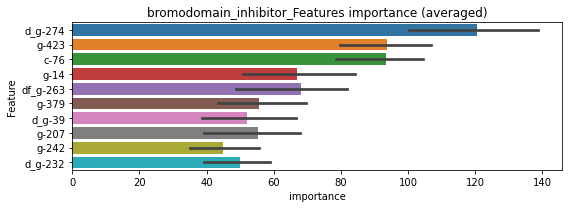

len(train_index) : 3884
len(valid_index) : 3885
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018246	valid_1's binary_logloss: 0.054373
[200]	training's binary_logloss: 0.00275313	valid_1's binary_logloss: 0.0398611
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00190082	valid_1's binary_logloss: 0.0390308


len(train_index) : 3885
len(valid_index) : 3884
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207497	valid_1's binary_logloss: 0.0441921
[200]	training's binary_logloss: 0.00323998	valid_1's binary_logloss: 0.0249235
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00163622	valid_1's binary_logloss: 0.0231755


bromodomain_inhibitor logloss: 0.031104146382119502


neg labels: 3289 → selected neg labels: 3284


btk_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293073	valid_1's binary_logloss: 0.0540571
[200]	training's binary_logloss: 0.00386169	valid_1's binary_logloss: 0.0175021
[300]	training's binary_logloss: 0.00108116	valid_1's binary_logloss: 0.0106023
[400]	training's binary_logloss: 0.000544389	valid_1's binary_logloss: 0.00855913
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000421011	valid_1's binary_logloss: 0.00797597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029072	valid_1's binary_logloss: 0.0469528
[200]	training's binary_logloss: 0.00395263	valid_1's binary_logloss: 0.0162352
[300]	training's binary_logloss: 0.00108828	valid_1's binary_logloss: 0.0117647
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000611588	valid_1's binary_logloss: 0.0110974


1 / 3 AUC score:1.000
y_Threshold: 0.0036318, Threshold: 0.0069465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.00625, conf_1:0.00764
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0069465
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_2: 0.0169465
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_3: 0.0269465
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_4: 0.0369465
threshold: 0.0369465, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281079	valid_1's binary_logloss: 0.0454408
[200]	training's binary_logloss: 0.00364172	valid_1's binary_logloss: 0.0109504
[300]	training's binary_logloss: 0.00103436	valid_1's binary_logloss: 0.00516979
[400]	training's binary_logloss: 0.00052442	valid_1's binary_logloss: 0.00369674
[500]	training's binary_logloss: 0.000386981	valid_1's binary_logloss: 0.00333652
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000369062	valid_1's binary_logloss: 0.00326992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028335	valid_1's binary_logloss: 0.0392984
[200]	training's binary_logloss: 0.00379107	valid_1's binary_logloss: 0.00718059
[300]	training's binary_logloss: 0.00106743	valid_1's binary_logloss: 0.00255217
[400]	training's binary_logloss: 0.000539089	valid_1's binary_logloss: 0.00147856
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0965621, Threshold: 0.0369465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0052737 Vs.target_rate: 0.00122
Num_p_label: 21.0, conf_0:0.03325, conf_1:0.04064
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_1: 0.0369465
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_2: 0.0469465
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_3: 0.0569465
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_4: 0.0669465
threshold: 0.0669465, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281079	valid_1's binary_logloss: 0.0454408
[200]	training's binary_logloss: 0.00364172	valid_1's binary_logloss: 0.0109504
[300]	training's binary_logloss: 0.00103436	valid_1's binary_logloss: 0.00516979
[400]	training's binary_logloss: 0.00052442	valid_1's binary_logloss: 0.00369674
[500]	training's binary_logloss: 0.000386981	valid_1's binary_logloss: 0.00333652
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000369062	valid_1's binary_logloss: 0.00326992
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028335	valid_1's binary_logloss: 0.0392984
[200]	training's binary_logloss: 0.00379107	valid_1's binary_logloss: 0.00718059
[300]	training's binary_logloss: 0.00106743	valid_1's binary_logloss: 0.00255217
[400]	training's binary_logloss: 0.000539089	valid_1's binary_logloss: 0.00147856
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0965621, Threshold: 0.0669465, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0017579 Vs.target_rate: 0.00122
Num_p_label: 7.0, conf_0:0.06025, conf_1:0.07364
threshold: 0.0669465, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 660.0/7784, y_label_rate: 0.0847893


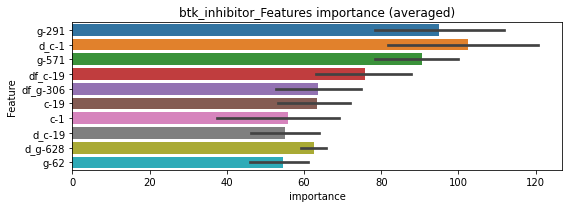

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155761	valid_1's binary_logloss: 0.0291717
[200]	training's binary_logloss: 0.00200487	valid_1's binary_logloss: 0.0116146
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00087098	valid_1's binary_logloss: 0.0103129


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157837	valid_1's binary_logloss: 0.0224073
[200]	training's binary_logloss: 0.00209175	valid_1's binary_logloss: 0.0054015
[300]	training's binary_logloss: 0.000586315	valid_1's binary_logloss: 0.00318742
[400]	training's binary_logloss: 0.000292266	valid_1's binary_logloss: 0.00283553
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000252609	valid_1's binary_logloss: 0.00275614


btk_inhibitor logloss: 0.0065344991130233685


neg labels: 3289 → selected neg labels: 3287


calcineurin_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183246	valid_1's binary_logloss: 0.0223676
[200]	training's binary_logloss: 0.0017953	valid_1's binary_logloss: 0.00311562
[300]	training's binary_logloss: 0.000495497	valid_1's binary_logloss: 0.00113597
[400]	training's binary_logloss: 0.000282892	valid_1's binary_logloss: 0.000740851
[500]	training's binary_logloss: 0.00024539	valid_1's binary_logloss: 0.000674418
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000242545	valid_1's binary_logloss: 0.00067154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187538	valid_1's binary_logloss: 0.0212357
[200]	training's binary_logloss: 0.00184009	valid_1's binary_logloss: 0.00236303
[300]	training's binary_logloss: 0.000506427	valid_1's binary_logloss: 0.000740588
[400]	training's binary_logloss: 0.000286283	valid_1's binary_logloss: 0.000445586
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0007730, Threshold: 0.0011057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00100, conf_1:0.00122
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0011057
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0111057
threshold: 0.0111057, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186926	valid_1's binary_logloss: 0.0221632
[200]	training's binary_logloss: 0.0018045	valid_1's binary_logloss: 0.0029353
[300]	training's binary_logloss: 0.000493318	valid_1's binary_logloss: 0.000960059
[400]	training's binary_logloss: 0.000282629	valid_1's binary_logloss: 0.000614047
[500]	training's binary_logloss: 0.000242537	valid_1's binary_logloss: 0.00055464
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000242575	valid_1's binary_logloss: 0.000554593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192116	valid_1's binary_logloss: 0.0216492
[200]	training's binary_logloss: 0.0018465	valid_1's binary_logloss: 0.00231244
[300]	training's binary_logloss: 0.000502573	valid_1's binary_logloss: 0.000673333
[400]	training's binary_logloss: 0.000284946	valid_1's binary_logloss: 0.00039674
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1470572, Threshold: 0.0111057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00050
Num_p_label: 5.0, conf_0:0.01000, conf_1:0.01222
threshold: 0.0111057, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186926	valid_1's binary_logloss: 0.0221632
[200]	training's binary_logloss: 0.0018045	valid_1's binary_logloss: 0.0029353
[300]	training's binary_logloss: 0.000493318	valid_1's binary_logloss: 0.000960059
[400]	training's binary_logloss: 0.000282629	valid_1's binary_logloss: 0.000614047
[500]	training's binary_logloss: 0.000242537	valid_1's binary_logloss: 0.00055464
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000242575	valid_1's binary_logloss: 0.000554593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192116	valid_1's binary_logloss: 0.0216492
[200]	training's binary_logloss: 0.0018465	valid_1's binary_logloss: 0.00231244
[300]	training's binary_logloss: 0.000502573	valid_1's binary_logloss: 0.000673333
[400]	training's binary_logloss: 0.000284946	valid_1's binary_logloss: 0.00039674
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1470572, Threshold: 0.0111057, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00050
Num_p_label: 5.0, conf_0:0.01000, conf_1:0.01222
threshold: 0.0111057, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7794, y_label_rate: 0.0849371


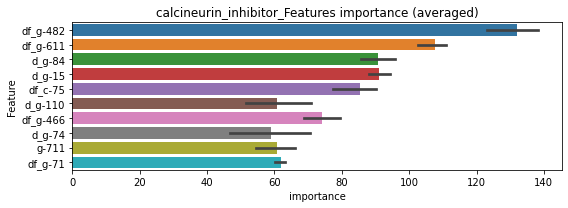

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00989717	valid_1's binary_logloss: 0.0163498
[200]	training's binary_logloss: 0.000918376	valid_1's binary_logloss: 0.00659766
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.000481876	valid_1's binary_logloss: 0.00621791


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101441	valid_1's binary_logloss: 0.0130402
[200]	training's binary_logloss: 0.0010192	valid_1's binary_logloss: 0.00281816
[300]	training's binary_logloss: 0.00027549	valid_1's binary_logloss: 0.0018553
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000169726	valid_1's binary_logloss: 0.00175498


calcineurin_inhibitor logloss: 0.003986444148621686


neg labels: 3289 → selected neg labels: 3243


calcium_channel_blocker, len(trt): 281, len(othr): 3243, target_rate: 0.0117998 → Adj_target_rate: 0.0101297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103115	valid_1's binary_logloss: 0.302252
[200]	training's binary_logloss: 0.0354335	valid_1's binary_logloss: 0.275707
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0292961	valid_1's binary_logloss: 0.273915
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112586	valid_1's binary_logloss: 0.288144
[200]	training's binary_logloss: 0.039378	valid_1's binary_logloss: 0.251787
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0249511	valid_1's binary_logloss: 0.247381


1 / 3 AUC score:0.887
y_Threshold: 0.0839797, Threshold: 0.1184540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 461 → Positive_corect_labels: 483/3430
p_label_rate: 0.0200904 Vs.target_rate: 0.01180
Num_p_label: 80.0, conf_0:0.10661, conf_1:0.13030
threshold: 0.1184540, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 483.0/3430, y_label_rate: 0.1408163
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0768229	valid_1's binary_logloss: 0.223287
[200]	training's binary_logloss: 0.0220793	valid_1's binary_logloss: 0.190918
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0148538	valid_1's binary_logloss: 0.188011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705938	valid_1's binary_logloss: 0.232116
[200]	training's binary_logloss: 0.0192609	valid_1's binary_logloss: 0.207296
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0219139	valid_1's binary_logloss: 0.206915


2 / 3 AUC score:0.938
y_Threshold: 0.0753946, Threshold: 0.1184540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 178 → Positive_corect_labels: 394.0/3252
p_label_rate: 0.0105475 Vs.target_rate: 0.01180
Num_p_label: 42.0, conf_0:0.10661, conf_1:0.13030
threshold: 0.1184540, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 394.0/3252, y_label_rate: 0.1211562
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0587746	valid_1's binary_logloss: 0.174645
[200]	training's binary_logloss: 0.0148777	valid_1's binary_logloss: 0.140751
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00946357	valid_1's binary_logloss: 0.135857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563722	valid_1's binary_logloss: 0.182668
[200]	training's binary_logloss: 0.0132017	valid_1's binary_logloss: 0.150215
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00711965	valid_1's binary_logloss: 0.147187


3 / 3 AUC score:0.968
y_Threshold: 0.0662085, Threshold: 0.1184540, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 118 → Positive_corect_labels: 335.0/3134
p_label_rate: 0.0113009 Vs.target_rate: 0.01180
Num_p_label: 45.0, conf_0:0.10661, conf_1:0.13030
threshold: 0.1184540, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 380.0/7116, y_label_rate: 0.0534008


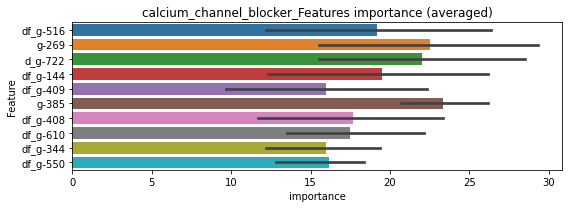

len(train_index) : 3558
len(valid_index) : 3558
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281698	valid_1's binary_logloss: 0.0926722
[200]	training's binary_logloss: 0.00704761	valid_1's binary_logloss: 0.0765424
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00505546	valid_1's binary_logloss: 0.0754032


len(train_index) : 3558
len(valid_index) : 3558
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273049	valid_1's binary_logloss: 0.0913991
[200]	training's binary_logloss: 0.00646026	valid_1's binary_logloss: 0.0761872
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00688145	valid_1's binary_logloss: 0.076177


calcium_channel_blocker logloss: 0.07579011485959886


neg labels: 3289 → selected neg labels: 3282


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413305	valid_1's binary_logloss: 0.0690579
[200]	training's binary_logloss: 0.00683743	valid_1's binary_logloss: 0.0251101
[300]	training's binary_logloss: 0.00187861	valid_1's binary_logloss: 0.0149574
[400]	training's binary_logloss: 0.000877117	valid_1's binary_logloss: 0.0121958
[500]	training's binary_logloss: 0.000568598	valid_1's binary_logloss: 0.0111225
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.000547164	valid_1's binary_logloss: 0.0109426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415136	valid_1's binary_logloss: 0.0788973
[200]	training's binary_logloss: 0.00721797	valid_1's binary_logloss: 0.0315525
[300]	training's binary_logloss: 0.00195263	valid_1's binary_logloss: 0.0191118
[400]	training's binary_logloss: 0.000901857	valid_1's binary_logloss: 0.0143514
[500]	training's binary_logloss: 0.000582

1 / 3 AUC score:1.000
y_Threshold: 0.0048877, Threshold: 0.0076019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00684, conf_1:0.00836
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0076019
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.0176019
Num_p_label: 9.0, Expected: 7.0, Adj_threshold_3: 0.0276019
threshold: 0.0276019, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414599	valid_1's binary_logloss: 0.066506
[200]	training's binary_logloss: 0.00664852	valid_1's binary_logloss: 0.0227127
[300]	training's binary_logloss: 0.00182851	valid_1's binary_logloss: 0.0134468
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00144973	valid_1's binary_logloss: 0.0124897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391461	valid_1's binary_logloss: 0.0758694
[200]	training's binary_logloss: 0.00634099	valid_1's binary_logloss: 0.0286641
[300]	training's binary_logloss: 0.00178489	valid_1's binary_logloss: 0.0174047
[400]	training's binary_logloss: 0.000853598	valid_1's binary_logloss: 0.0142116
[500]	training's binary_logloss: 0.000563017	valid_1's binary_logloss: 0.0126054
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.000476232	valid_1's binary_logloss: 0.0120232


2 / 3 AUC score:1.000
y_Threshold: 0.0416504, Threshold: 0.0276019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0087896 Vs.target_rate: 0.00176
Num_p_label: 35.0, conf_0:0.02484, conf_1:0.03036
Num_p_label: 35.0, Expected: 7.0, Adj_threshold_1: 0.0276019
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_2: 0.0376019
Num_p_label: 16.0, Expected: 7.0, Adj_threshold_3: 0.0476019
Num_p_label: 11.0, Expected: 7.0, Adj_threshold_4: 0.0576019
threshold: 0.0576019, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.042107	valid_1's binary_logloss: 0.0690739
[200]	training's binary_logloss: 0.00703709	valid_1's binary_logloss: 0.0241509
[300]	training's binary_logloss: 0.00190786	valid_1's binary_logloss: 0.0149663
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00144218	valid_1's binary_logloss: 0.0141935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395981	valid_1's binary_logloss: 0.0690513
[200]	training's binary_logloss: 0.0063884	valid_1's binary_logloss: 0.0233057
[300]	training's binary_logloss: 0.00179346	valid_1's binary_logloss: 0.013948
[400]	training's binary_logloss: 0.000856759	valid_1's binary_logloss: 0.0106357
[500]	training's binary_logloss: 0.000559688	valid_1's binary_logloss: 0.00959354
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000567472	valid_1's binary_logloss: 0.00956052


3 / 3 AUC score:1.000
y_Threshold: 0.0388365, Threshold: 0.0576019, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0032647 Vs.target_rate: 0.00176
Num_p_label: 13.0, conf_0:0.05184, conf_1:0.06336
threshold: 0.0576019, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 667.0/7784, y_label_rate: 0.0856886


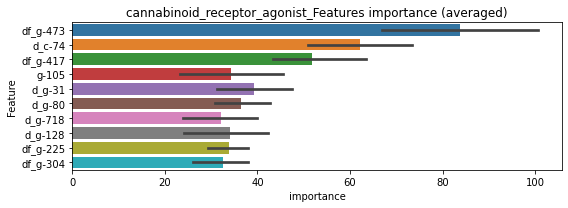

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231194	valid_1's binary_logloss: 0.0441439
[200]	training's binary_logloss: 0.00376661	valid_1's binary_logloss: 0.0200511
[300]	training's binary_logloss: 0.000980889	valid_1's binary_logloss: 0.0162773
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000935301	valid_1's binary_logloss: 0.0161483


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234697	valid_1's binary_logloss: 0.0464425
[200]	training's binary_logloss: 0.00392587	valid_1's binary_logloss: 0.0190738
[300]	training's binary_logloss: 0.00109127	valid_1's binary_logloss: 0.0132316
[400]	training's binary_logloss: 0.000495575	valid_1's binary_logloss: 0.0120871
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000393399	valid_1's binary_logloss: 0.0116994


cannabinoid_receptor_agonist logloss: 0.013923873340561478


neg labels: 3289 → selected neg labels: 3280


cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0455921	valid_1's binary_logloss: 0.0925195
[200]	training's binary_logloss: 0.0083426	valid_1's binary_logloss: 0.0479568
[300]	training's binary_logloss: 0.00234077	valid_1's binary_logloss: 0.0382552
[400]	training's binary_logloss: 0.00108077	valid_1's binary_logloss: 0.0358527
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00110926	valid_1's binary_logloss: 0.0357792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453306	valid_1's binary_logloss: 0.0970555
[200]	training's binary_logloss: 0.00845113	valid_1's binary_logloss: 0.0556008
[300]	training's binary_logloss: 0.00244099	valid_1's binary_logloss: 0.0477312
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00256718	valid_1's binary_logloss: 0.0475125


1 / 3 AUC score:0.996
y_Threshold: 0.0120190, Threshold: 0.0161610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3788
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.01454, conf_1:0.01778
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0161610
Num_p_label: 34.0, Expected: 9.2, Adj_threshold_2: 0.0261610
Num_p_label: 14.0, Expected: 9.2, Adj_threshold_3: 0.0361610
threshold: 0.0361610, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 648.0/3788, y_label_rate: 0.1710665
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445512	valid_1's binary_logloss: 0.0854988
[200]	training's binary_logloss: 0.00787549	valid_1's binary_logloss: 0.0338849
[300]	training's binary_logloss: 0.00226302	valid_1's binary_logloss: 0.0204154
[400]	training's binary_logloss: 0.00105027	valid_1's binary_logloss: 0.0159489
[500]	training's binary_logloss: 0.000667596	valid_1's binary_logloss: 0.0142919
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.000591494	valid_1's binary_logloss: 0.0140497
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464712	valid_1's binary_logloss: 0.0820632
[200]	training's binary_logloss: 0.00830225	valid_1's binary_logloss: 0.0335003
[300]	training's binary_logloss: 0.00236114	valid_1's binary_logloss: 0.0217841
[400]	training's binary_logloss: 0.00108206	valid_1's binary_logloss: 0.0173629
[500]	training's binary_logloss: 0.00067685

2 / 3 AUC score:1.000
y_Threshold: 0.0348813, Threshold: 0.0361610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0040181 Vs.target_rate: 0.00231
Num_p_label: 16.0, conf_0:0.03254, conf_1:0.03978
threshold: 0.0361610, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462604	valid_1's binary_logloss: 0.0799687
[200]	training's binary_logloss: 0.00810002	valid_1's binary_logloss: 0.0281313
[300]	training's binary_logloss: 0.0023215	valid_1's binary_logloss: 0.0169193
[400]	training's binary_logloss: 0.00108105	valid_1's binary_logloss: 0.0134685
[500]	training's binary_logloss: 0.000675274	valid_1's binary_logloss: 0.0120097
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000688277	valid_1's binary_logloss: 0.0120059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443023	valid_1's binary_logloss: 0.0763129
[200]	training's binary_logloss: 0.00791572	valid_1's binary_logloss: 0.0294948
[300]	training's binary_logloss: 0.00222902	valid_1's binary_logloss: 0.0190992
[400]	training's binary_logloss: 0.00103532	valid_1's binary_logloss: 0.0159346
[500]	training's binary_logloss: 0.000665923

3 / 3 AUC score:1.000
y_Threshold: 0.0444723, Threshold: 0.0361610, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0047715 Vs.target_rate: 0.00231
Num_p_label: 19.0, conf_0:0.03254, conf_1:0.03978
threshold: 0.0361610, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 660.0/7756, y_label_rate: 0.0850954


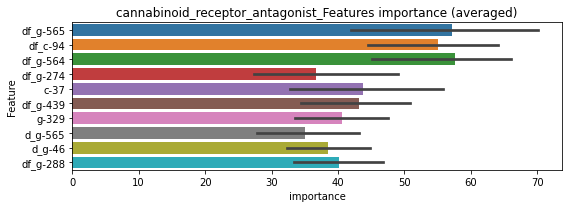

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259912	valid_1's binary_logloss: 0.0598946
[200]	training's binary_logloss: 0.00478899	valid_1's binary_logloss: 0.0354608
[300]	training's binary_logloss: 0.00130017	valid_1's binary_logloss: 0.0314644
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00124619	valid_1's binary_logloss: 0.0314019


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263674	valid_1's binary_logloss: 0.0598473
[200]	training's binary_logloss: 0.00489555	valid_1's binary_logloss: 0.0333603
[300]	training's binary_logloss: 0.00127209	valid_1's binary_logloss: 0.0268173
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000771205	valid_1's binary_logloss: 0.025648


cannabinoid_receptor_antagonist logloss: 0.028524940559384558


neg labels: 3289 → selected neg labels: 3283


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384901	valid_1's binary_logloss: 0.0635359
[200]	training's binary_logloss: 0.00626219	valid_1's binary_logloss: 0.0215186
[300]	training's binary_logloss: 0.00169908	valid_1's binary_logloss: 0.0128796
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000905538	valid_1's binary_logloss: 0.0112071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366128	valid_1's binary_logloss: 0.0635397
[200]	training's binary_logloss: 0.0058026	valid_1's binary_logloss: 0.0219039
[300]	training's binary_logloss: 0.00163484	valid_1's binary_logloss: 0.0125085
[400]	training's binary_logloss: 0.000789341	valid_1's binary_logloss: 0.0099705
[500]	training's binary_logloss: 0.000511327	valid_1's binary_logloss: 0.0089411
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000517162	valid_1's binary_logloss: 0.00892678


1 / 3 AUC score:1.000
y_Threshold: 0.0047744, Threshold: 0.0063847, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00575, conf_1:0.00702
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0063847
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.0163847
threshold: 0.0163847, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369263	valid_1's binary_logloss: 0.0619132
[200]	training's binary_logloss: 0.0057727	valid_1's binary_logloss: 0.0204185
[300]	training's binary_logloss: 0.00161381	valid_1's binary_logloss: 0.0117814
[400]	training's binary_logloss: 0.000785272	valid_1's binary_logloss: 0.00960048
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000704561	valid_1's binary_logloss: 0.00928466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370569	valid_1's binary_logloss: 0.0641458
[200]	training's binary_logloss: 0.00585856	valid_1's binary_logloss: 0.023538
[300]	training's binary_logloss: 0.00162622	valid_1's binary_logloss: 0.0144404
[400]	training's binary_logloss: 0.000787202	valid_1's binary_logloss: 0.0119716
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000646406	valid_1's binary_logloss: 0.0112657


2 / 3 AUC score:1.000
y_Threshold: 0.0377809, Threshold: 0.0163847, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0095429 Vs.target_rate: 0.00151
Num_p_label: 38.0, conf_0:0.01475, conf_1:0.01802
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_1: 0.0163847
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0263847
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0363847
threshold: 0.0363847, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036658	valid_1's binary_logloss: 0.0656781
[200]	training's binary_logloss: 0.00574035	valid_1's binary_logloss: 0.0244187
[300]	training's binary_logloss: 0.00161919	valid_1's binary_logloss: 0.0155084
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000902025	valid_1's binary_logloss: 0.0125261
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03583	valid_1's binary_logloss: 0.0633832
[200]	training's binary_logloss: 0.00544987	valid_1's binary_logloss: 0.0220526
[300]	training's binary_logloss: 0.0015572	valid_1's binary_logloss: 0.0144918
[400]	training's binary_logloss: 0.000761726	valid_1's binary_logloss: 0.0124859
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00069158	valid_1's binary_logloss: 0.0123136


3 / 3 AUC score:1.000
y_Threshold: 0.0246875, Threshold: 0.0363847, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0030136 Vs.target_rate: 0.00151
Num_p_label: 12.0, conf_0:0.03275, conf_1:0.04002
threshold: 0.0363847, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 665.0/7783, y_label_rate: 0.0854426


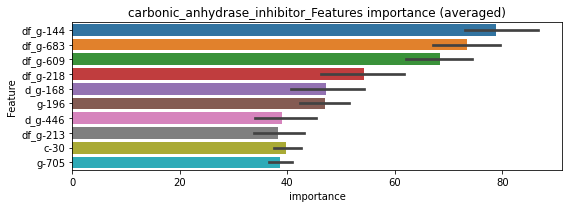

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204987	valid_1's binary_logloss: 0.0424806
[200]	training's binary_logloss: 0.00327511	valid_1's binary_logloss: 0.0205483
[300]	training's binary_logloss: 0.000871403	valid_1's binary_logloss: 0.0157083
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000478749	valid_1's binary_logloss: 0.0147882


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021502	valid_1's binary_logloss: 0.0413966
[200]	training's binary_logloss: 0.00321219	valid_1's binary_logloss: 0.0187249
[300]	training's binary_logloss: 0.00088857	valid_1's binary_logloss: 0.0153399
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000845533	valid_1's binary_logloss: 0.0152431


carbonic_anhydrase_inhibitor logloss: 0.015015594930157097


neg labels: 3289 → selected neg labels: 3283


casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362928	valid_1's binary_logloss: 0.0537631
[200]	training's binary_logloss: 0.00566104	valid_1's binary_logloss: 0.0134006
[300]	training's binary_logloss: 0.00157733	valid_1's binary_logloss: 0.00543144
[400]	training's binary_logloss: 0.000764452	valid_1's binary_logloss: 0.00331839
[500]	training's binary_logloss: 0.000506846	valid_1's binary_logloss: 0.00256909
[600]	training's binary_logloss: 0.000433049	valid_1's binary_logloss: 0.00233835
Early stopping, best iteration is:
[605]	training's binary_logloss: 0.000431255	valid_1's binary_logloss: 0.00233556
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0339538	valid_1's binary_logloss: 0.0636162
[200]	training's binary_logloss: 0.00518202	valid_1's binary_logloss: 0.0268371
[300]	training's binary_logloss: 0.00145163	valid_1's binary_logloss: 0.0186836
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0043654, Threshold: 0.0065803, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00592, conf_1:0.00724
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0065803
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0165803
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_3: 0.0265803
threshold: 0.0265803, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03519	valid_1's binary_logloss: 0.0523001
[200]	training's binary_logloss: 0.00520471	valid_1's binary_logloss: 0.012651
[300]	training's binary_logloss: 0.00147364	valid_1's binary_logloss: 0.00530073
[400]	training's binary_logloss: 0.000724229	valid_1's binary_logloss: 0.0033654
[500]	training's binary_logloss: 0.000491664	valid_1's binary_logloss: 0.00263781
[600]	training's binary_logloss: 0.000433838	valid_1's binary_logloss: 0.00245723
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.000431853	valid_1's binary_logloss: 0.00244797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342648	valid_1's binary_logloss: 0.0627369
[200]	training's binary_logloss: 0.00513331	valid_1's binary_logloss: 0.0263371
[300]	training's binary_logloss: 0.00145055	valid_1's binary_logloss: 0.0198099
Early stopping, best iteration is:
[345]

2 / 3 AUC score:1.000
y_Threshold: 0.0306508, Threshold: 0.0265803, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0065294 Vs.target_rate: 0.00151
Num_p_label: 26.0, conf_0:0.02392, conf_1:0.02924
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_1: 0.0265803
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_2: 0.0365803
threshold: 0.0365803, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345547	valid_1's binary_logloss: 0.0527331
[200]	training's binary_logloss: 0.00521272	valid_1's binary_logloss: 0.0145429
[300]	training's binary_logloss: 0.00147203	valid_1's binary_logloss: 0.00734489
[400]	training's binary_logloss: 0.000731874	valid_1's binary_logloss: 0.00557116
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000624586	valid_1's binary_logloss: 0.00527555
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338429	valid_1's binary_logloss: 0.0588461
[200]	training's binary_logloss: 0.00499249	valid_1's binary_logloss: 0.0175147
[300]	training's binary_logloss: 0.00143849	valid_1's binary_logloss: 0.00927213
[400]	training's binary_logloss: 0.000712915	valid_1's binary_logloss: 0.00639893
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000676205	valid_1's binary_logloss: 0.00627046


3 / 3 AUC score:1.000
y_Threshold: 0.0669474, Threshold: 0.0365803, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0052737 Vs.target_rate: 0.00151
Num_p_label: 21.0, conf_0:0.03292, conf_1:0.04024
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_1: 0.0365803
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_2: 0.0465803
threshold: 0.0465803, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 667.0/7787, y_label_rate: 0.0856556


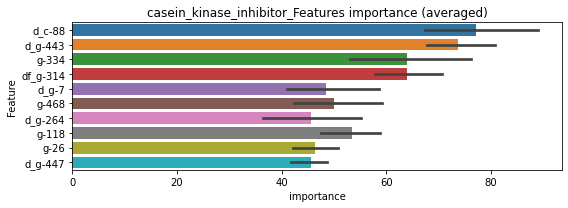

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191343	valid_1's binary_logloss: 0.0418701
[200]	training's binary_logloss: 0.00283173	valid_1's binary_logloss: 0.0232677
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.00110978	valid_1's binary_logloss: 0.0215972


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203588	valid_1's binary_logloss: 0.0331339
[200]	training's binary_logloss: 0.00313444	valid_1's binary_logloss: 0.0100505
[300]	training's binary_logloss: 0.000856515	valid_1's binary_logloss: 0.00646676
[400]	training's binary_logloss: 0.000401908	valid_1's binary_logloss: 0.00558087
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00039145	valid_1's binary_logloss: 0.00555356


casein_kinase_inhibitor logloss: 0.01357640820071361


neg labels: 3289 → selected neg labels: 3287


caspase_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231944	valid_1's binary_logloss: 0.0303209
[200]	training's binary_logloss: 0.00271791	valid_1's binary_logloss: 0.00509904
[300]	training's binary_logloss: 0.000775511	valid_1's binary_logloss: 0.00220932
[400]	training's binary_logloss: 0.000409857	valid_1's binary_logloss: 0.00148634
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000349453	valid_1's binary_logloss: 0.00138494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231648	valid_1's binary_logloss: 0.0337051
[200]	training's binary_logloss: 0.00268556	valid_1's binary_logloss: 0.00646641
[300]	training's binary_logloss: 0.00076037	valid_1's binary_logloss: 0.00246387
[400]	training's binary_logloss: 0.00040426	valid_1's binary_logloss: 0.00161767
[500]	training's binary_logloss: 0.000322448	valid_1's binary_logloss: 0.0014064
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0015652, Threshold: 0.0021202, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00191, conf_1:0.00233
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0021202
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0121202
threshold: 0.0121202, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228083	valid_1's binary_logloss: 0.0306459
[200]	training's binary_logloss: 0.00262399	valid_1's binary_logloss: 0.00541898
[300]	training's binary_logloss: 0.000745239	valid_1's binary_logloss: 0.00218656
[400]	training's binary_logloss: 0.000399185	valid_1's binary_logloss: 0.00144653
[500]	training's binary_logloss: 0.000323393	valid_1's binary_logloss: 0.00130007
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000319891	valid_1's binary_logloss: 0.00129114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231892	valid_1's binary_logloss: 0.0322561
[200]	training's binary_logloss: 0.00266901	valid_1's binary_logloss: 0.00610941
[300]	training's binary_logloss: 0.000750566	valid_1's binary_logloss: 0.00240292
[400]	training's binary_logloss: 0.000402852	valid_1's binary_logloss: 0.00152083
Early stopping, best iteration 

2 / 3 AUC score:1.000
y_Threshold: 0.0962810, Threshold: 0.0121202, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0027624 Vs.target_rate: 0.00076
Num_p_label: 11.0, conf_0:0.01091, conf_1:0.01333
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_1: 0.0121202
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0221202
threshold: 0.0221202, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228083	valid_1's binary_logloss: 0.0306459
[200]	training's binary_logloss: 0.00262399	valid_1's binary_logloss: 0.00541898
[300]	training's binary_logloss: 0.000745239	valid_1's binary_logloss: 0.00218656
[400]	training's binary_logloss: 0.000399185	valid_1's binary_logloss: 0.00144653
[500]	training's binary_logloss: 0.000323393	valid_1's binary_logloss: 0.00130007
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000319891	valid_1's binary_logloss: 0.00129114
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231892	valid_1's binary_logloss: 0.0322561
[200]	training's binary_logloss: 0.00266901	valid_1's binary_logloss: 0.00610941
[300]	training's binary_logloss: 0.000750566	valid_1's binary_logloss: 0.00240292
[400]	training's binary_logloss: 0.000402852	valid_1's binary_logloss: 0.00152083
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0962810, Threshold: 0.0221202, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00076
Num_p_label: 5.0, conf_0:0.01991, conf_1:0.02433
threshold: 0.0221202, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7794, y_label_rate: 0.0849371


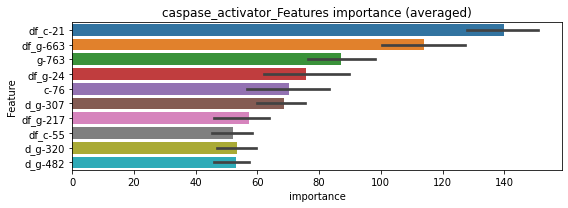

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122389	valid_1's binary_logloss: 0.0203037
[200]	training's binary_logloss: 0.0013924	valid_1's binary_logloss: 0.00648447
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000441581	valid_1's binary_logloss: 0.00551587


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012755	valid_1's binary_logloss: 0.0175716
[200]	training's binary_logloss: 0.0015265	valid_1's binary_logloss: 0.00383814
[300]	training's binary_logloss: 0.000403823	valid_1's binary_logloss: 0.00240648
[400]	training's binary_logloss: 0.000206701	valid_1's binary_logloss: 0.00218662
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000214871	valid_1's binary_logloss: 0.00218385


caspase_activator logloss: 0.003849861491237631


neg labels: 3289 → selected neg labels: 3286


catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229994	valid_1's binary_logloss: 0.0316394
[200]	training's binary_logloss: 0.00270432	valid_1's binary_logloss: 0.00656808
[300]	training's binary_logloss: 0.000774786	valid_1's binary_logloss: 0.00273692
[400]	training's binary_logloss: 0.000412025	valid_1's binary_logloss: 0.00180825
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000331594	valid_1's binary_logloss: 0.00157724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243777	valid_1's binary_logloss: 0.0308756
[200]	training's binary_logloss: 0.00279479	valid_1's binary_logloss: 0.00450628
[300]	training's binary_logloss: 0.000786422	valid_1's binary_logloss: 0.00153578
[400]	training's binary_logloss: 0.00041506	valid_1's binary_logloss: 0.000898965
[500]	training's binary_logloss: 0.000326003	valid_1's binary_logloss: 0.000751804
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0014125, Threshold: 0.0022535, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00203, conf_1:0.00248
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0022535
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_2: 0.0122535
threshold: 0.0122535, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229185	valid_1's binary_logloss: 0.029167
[200]	training's binary_logloss: 0.00262027	valid_1's binary_logloss: 0.00494905
[300]	training's binary_logloss: 0.000759468	valid_1's binary_logloss: 0.00192975
[400]	training's binary_logloss: 0.000410407	valid_1's binary_logloss: 0.00117401
[500]	training's binary_logloss: 0.000329293	valid_1's binary_logloss: 0.00101589
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00032498	valid_1's binary_logloss: 0.00101361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231378	valid_1's binary_logloss: 0.0285228
[200]	training's binary_logloss: 0.00261942	valid_1's binary_logloss: 0.00427698
[300]	training's binary_logloss: 0.000756229	valid_1's binary_logloss: 0.00152566
[400]	training's binary_logloss: 0.000411372	valid_1's binary_logloss: 0.000979232
[500]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.1206593, Threshold: 0.0122535, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076
Num_p_label: 21.0, conf_0:0.01103, conf_1:0.01348
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0122535
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0222535
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_3: 0.0322535
threshold: 0.0322535, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229185	valid_1's binary_logloss: 0.029167
[200]	training's binary_logloss: 0.00262027	valid_1's binary_logloss: 0.00494905
[300]	training's binary_logloss: 0.000759468	valid_1's binary_logloss: 0.00192975
[400]	training's binary_logloss: 0.000410407	valid_1's binary_logloss: 0.00117401
[500]	training's binary_logloss: 0.000329293	valid_1's binary_logloss: 0.00101589
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00032498	valid_1's binary_logloss: 0.00101361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231378	valid_1's binary_logloss: 0.0285228
[200]	training's binary_logloss: 0.00261942	valid_1's binary_logloss: 0.00427698
[300]	training's binary_logloss: 0.000756229	valid_1's binary_logloss: 0.00152566
[400]	training's binary_logloss: 0.000411372	valid_1's binary_logloss: 0.000979232
[500]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.1206593, Threshold: 0.0322535, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076
Num_p_label: 4.0, conf_0:0.02903, conf_1:0.03548
threshold: 0.0322535, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


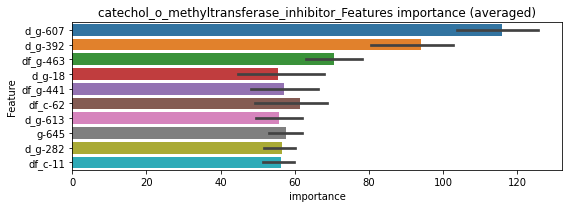

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.012701	valid_1's binary_logloss: 0.0198239
[200]	training's binary_logloss: 0.001424	valid_1's binary_logloss: 0.00699986
[300]	training's binary_logloss: 0.00038839	valid_1's binary_logloss: 0.00532719
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000264147	valid_1's binary_logloss: 0.00514488


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126271	valid_1's binary_logloss: 0.0170324
[200]	training's binary_logloss: 0.00146554	valid_1's binary_logloss: 0.00300473
[300]	training's binary_logloss: 0.000402885	valid_1's binary_logloss: 0.00143887
[400]	training's binary_logloss: 0.000210433	valid_1's binary_logloss: 0.00114197
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000190455	valid_1's binary_logloss: 0.00112206


catechol_o_methyltransferase_inhibitor logloss: 0.0031337277192907353


neg labels: 3289 → selected neg labels: 3272


cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3272, target_rate: 0.0042832 → Adj_target_rate: 0.0042806
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644181	valid_1's binary_logloss: 0.166936
[200]	training's binary_logloss: 0.0166875	valid_1's binary_logloss: 0.128328
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00576495	valid_1's binary_logloss: 0.121799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.068026	valid_1's binary_logloss: 0.138867
[200]	training's binary_logloss: 0.0173163	valid_1's binary_logloss: 0.0854494
[300]	training's binary_logloss: 0.00527052	valid_1's binary_logloss: 0.0719212
[400]	training's binary_logloss: 0.00225245	valid_1's binary_logloss: 0.0668142
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00239871	valid_1's binary_logloss: 0.0668106


1 / 3 AUC score:0.983
y_Threshold: 0.0227181, Threshold: 0.0382107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 188 → Positive_corect_labels: 626/3738
p_label_rate: 0.0200904 Vs.target_rate: 0.00428
Num_p_label: 80.0, conf_0:0.03439, conf_1:0.04203
Num_p_label: 80.0, Expected: 17.1, Adj_threshold_1: 0.0382107
Num_p_label: 46.0, Expected: 17.1, Adj_threshold_2: 0.0482107
Num_p_label: 29.0, Expected: 17.1, Adj_threshold_3: 0.0582107
threshold: 0.0582107, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 626.0/3738, y_label_rate: 0.1674692
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606301	valid_1's binary_logloss: 0.14071
[200]	training's binary_logloss: 0.0138264	valid_1's binary_logloss: 0.0911044
[300]	training's binary_logloss: 0.00424425	valid_1's binary_logloss: 0.0786408
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00238222	valid_1's binary_logloss: 0.0759676
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060424	valid_1's binary_logloss: 0.130713
[200]	training's binary_logloss: 0.0143986	valid_1's binary_logloss: 0.0822462
[300]	training's binary_logloss: 0.00436197	valid_1's binary_logloss: 0.0718908
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00396218	valid_1's binary_logloss: 0.0710973


2 / 3 AUC score:0.994
y_Threshold: 0.0439522, Threshold: 0.0582107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 56 → Positive_corect_labels: 598.0/3682
p_label_rate: 0.0128076 Vs.target_rate: 0.00428
Num_p_label: 51.0, conf_0:0.05239, conf_1:0.06403
threshold: 0.0582107, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 598.0/3682, y_label_rate: 0.1624117
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568068	valid_1's binary_logloss: 0.127111
[200]	training's binary_logloss: 0.0124916	valid_1's binary_logloss: 0.0759429
[300]	training's binary_logloss: 0.00375133	valid_1's binary_logloss: 0.0615945
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00186323	valid_1's binary_logloss: 0.0582391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576599	valid_1's binary_logloss: 0.127314
[200]	training's binary_logloss: 0.0130447	valid_1's binary_logloss: 0.0802426
[300]	training's binary_logloss: 0.004012	valid_1's binary_logloss: 0.0673685
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00196618	valid_1's binary_logloss: 0.0629522


3 / 3 AUC score:0.995
y_Threshold: 0.0416721, Threshold: 0.0582107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 582.0/3650
p_label_rate: 0.0097941 Vs.target_rate: 0.00428
Num_p_label: 39.0, conf_0:0.05239, conf_1:0.06403
threshold: 0.0582107, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 621.0/7632, y_label_rate: 0.0813679


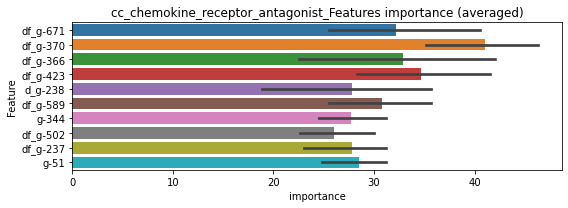

len(train_index) : 3816
len(valid_index) : 3816
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303104	valid_1's binary_logloss: 0.0846113
[200]	training's binary_logloss: 0.00683597	valid_1's binary_logloss: 0.059371
[300]	training's binary_logloss: 0.00206166	valid_1's binary_logloss: 0.0538584
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00196516	valid_1's binary_logloss: 0.0536402


len(train_index) : 3816
len(valid_index) : 3816
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346466	valid_1's binary_logloss: 0.0828347
[200]	training's binary_logloss: 0.00799419	valid_1's binary_logloss: 0.0599125
[300]	training's binary_logloss: 0.0023927	valid_1's binary_logloss: 0.0562067
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00234286	valid_1's binary_logloss: 0.0561169


cc_chemokine_receptor_antagonist logloss: 0.054878549790936385


neg labels: 3289 → selected neg labels: 3286


cck_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223207	valid_1's binary_logloss: 0.0287414
[200]	training's binary_logloss: 0.00259332	valid_1's binary_logloss: 0.00423989
[300]	training's binary_logloss: 0.000739595	valid_1's binary_logloss: 0.00142484
[400]	training's binary_logloss: 0.000398256	valid_1's binary_logloss: 0.000839991
[500]	training's binary_logloss: 0.000316863	valid_1's binary_logloss: 0.000692018
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000309149	valid_1's binary_logloss: 0.000679779
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226712	valid_1's binary_logloss: 0.0288778
[200]	training's binary_logloss: 0.00262412	valid_1's binary_logloss: 0.00455352
[300]	training's binary_logloss: 0.000742615	valid_1's binary_logloss: 0.00161276
[400]	training's binary_logloss: 0.000399724	valid_1's binary_logloss: 0.000982651
[500]	training's binary_log

1 / 3 AUC score:1.000
y_Threshold: 0.0015384, Threshold: 0.0027648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00249, conf_1:0.00304
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0027648
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_2: 0.0127648
threshold: 0.0127648, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219697	valid_1's binary_logloss: 0.0270001
[200]	training's binary_logloss: 0.0024924	valid_1's binary_logloss: 0.00382527
[300]	training's binary_logloss: 0.000715615	valid_1's binary_logloss: 0.00126174
[400]	training's binary_logloss: 0.000391215	valid_1's binary_logloss: 0.000731497
[500]	training's binary_logloss: 0.000315374	valid_1's binary_logloss: 0.000607264
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00031049	valid_1's binary_logloss: 0.000599547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226019	valid_1's binary_logloss: 0.028517
[200]	training's binary_logloss: 0.00253639	valid_1's binary_logloss: 0.00438141
[300]	training's binary_logloss: 0.000724067	valid_1's binary_logloss: 0.00166496
[400]	training's binary_logloss: 0.000393939	valid_1's binary_logloss: 0.00104965
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1485220, Threshold: 0.0127648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0065294 Vs.target_rate: 0.00076
Num_p_label: 26.0, conf_0:0.01149, conf_1:0.01404
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.0127648
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.0227648
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.0327648
threshold: 0.0327648, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219697	valid_1's binary_logloss: 0.0270001
[200]	training's binary_logloss: 0.0024924	valid_1's binary_logloss: 0.00382527
[300]	training's binary_logloss: 0.000715615	valid_1's binary_logloss: 0.00126174
[400]	training's binary_logloss: 0.000391215	valid_1's binary_logloss: 0.000731497
[500]	training's binary_logloss: 0.000315374	valid_1's binary_logloss: 0.000607264
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00031049	valid_1's binary_logloss: 0.000599547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226019	valid_1's binary_logloss: 0.028517
[200]	training's binary_logloss: 0.00253639	valid_1's binary_logloss: 0.00438141
[300]	training's binary_logloss: 0.000724067	valid_1's binary_logloss: 0.00166496
[400]	training's binary_logloss: 0.000393939	valid_1's binary_logloss: 0.00104965
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1485220, Threshold: 0.0327648, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.02949, conf_1:0.03604
threshold: 0.0327648, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


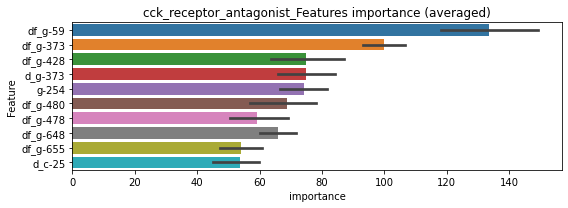

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121755	valid_1's binary_logloss: 0.0186798
[200]	training's binary_logloss: 0.00136341	valid_1's binary_logloss: 0.00692469
[300]	training's binary_logloss: 0.000378187	valid_1's binary_logloss: 0.00611286
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000413944	valid_1's binary_logloss: 0.00610196


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125084	valid_1's binary_logloss: 0.0172804
[200]	training's binary_logloss: 0.00146284	valid_1's binary_logloss: 0.0039847
[300]	training's binary_logloss: 0.000409825	valid_1's binary_logloss: 0.00241959
[400]	training's binary_logloss: 0.000213212	valid_1's binary_logloss: 0.0020827
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000183938	valid_1's binary_logloss: 0.00205309


cck_receptor_antagonist logloss: 0.004077782922157073


neg labels: 3289 → selected neg labels: 3263


cdk_inhibitor, len(trt): 352, len(othr): 3263, target_rate: 0.0147812 → Adj_target_rate: 0.0122676
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0424971	valid_1's binary_logloss: 0.121319
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.0123636	valid_1's binary_logloss: 0.109429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0438583	valid_1's binary_logloss: 0.114916
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.0095692	valid_1's binary_logloss: 0.0987683


1 / 3 AUC score:0.982
y_Threshold: 0.0406041, Threshold: 0.3613269, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 217 → Positive_corect_labels: 609/3698
p_label_rate: 0.0200904 Vs.target_rate: 0.01478
Num_p_label: 80.0, conf_0:0.32519, conf_1:0.39746
threshold: 0.3613269, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 609.0/3698, y_label_rate: 0.1646836
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033868	valid_1's binary_logloss: 0.0806946
[200]	training's binary_logloss: 0.00511219	valid_1's binary_logloss: 0.0591108
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00308726	valid_1's binary_logloss: 0.0570408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333673	valid_1's binary_logloss: 0.0824444
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00723692	valid_1's binary_logloss: 0.0633202


2 / 3 AUC score:0.990
y_Threshold: 0.1383003, Threshold: 0.3613269, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 66 → Positive_corect_labels: 576.0/3632
p_label_rate: 0.0637870 Vs.target_rate: 0.01478
Num_p_label: 254.0, conf_0:0.32519, conf_1:0.39746
Num_p_label: 254.0, Expected: 58.9, Adj_threshold_1: 0.3613269
Num_p_label: 251.0, Expected: 58.9, Adj_threshold_2: 0.3713269
Num_p_label: 249.0, Expected: 58.9, Adj_threshold_3: 0.3813269
Num_p_label: 246.0, Expected: 58.9, Adj_threshold_4: 0.3913269
Num_p_label: 243.0, Expected: 58.9, Adj_threshold_5: 0.4013269
Num_p_label: 237.0, Expected: 58.9, Adj_threshold_6: 0.4113269
Num_p_label: 236.0, Expected: 58.9, Adj_threshold_7: 0.4213269
Num_p_label: 235.0, Expected: 58.9, Adj_threshold_8: 0.4313269
Num_p_label: 232.0, Expected: 58.9, Adj_threshold_9: 0.4413269
Num_p_label: 229.0, Expected: 58.9, Adj_threshold_10: 0.4513269
threshold: 0.4613269, positive_p_label: 227.0/3982, p_label_rate: 0.0570065
positive_y_label: 576.0/3632, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278153	valid_1's binary_logloss: 0.0619004
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00609779	valid_1's binary_logloss: 0.0487522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252209	valid_1's binary_logloss: 0.0651863
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.00716432	valid_1's binary_logloss: 0.0563437


3 / 3 AUC score:0.988
y_Threshold: 0.1014691, Threshold: 0.4613269, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 553.0/3586
p_label_rate: 0.0743345 Vs.target_rate: 0.01478
Num_p_label: 296.0, conf_0:0.41519, conf_1:0.50746
Num_p_label: 296.0, Expected: 58.9, Adj_threshold_1: 0.4613269
Num_p_label: 291.0, Expected: 58.9, Adj_threshold_2: 0.4713269
Num_p_label: 289.0, Expected: 58.9, Adj_threshold_3: 0.4813269
Num_p_label: 289.0, Expected: 58.9, Adj_threshold_4: 0.4913269
Num_p_label: 287.0, Expected: 58.9, Adj_threshold_5: 0.5013269
Num_p_label: 286.0, Expected: 58.9, Adj_threshold_6: 0.5113269
Num_p_label: 285.0, Expected: 58.9, Adj_threshold_7: 0.5213269
Num_p_label: 285.0, Expected: 58.9, Adj_threshold_8: 0.5313269
Num_p_label: 281.0, Expected: 58.9, Adj_threshold_9: 0.5413269
Num_p_label: 279.0, Expected: 58.9, Adj_threshold_10: 0.5513269
threshold: 0.5613269, positive_p_label: 278.0/3982, p_label_rate: 0.0698142
positive_y_label: 831.0/7568, y_label_ra

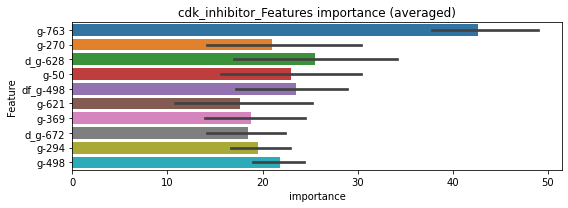

len(train_index) : 3784
len(valid_index) : 3784
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169717	valid_1's binary_logloss: 0.0274419
[200]	training's binary_logloss: 0.00207464	valid_1's binary_logloss: 0.014905
[300]	training's binary_logloss: 0.000560463	valid_1's binary_logloss: 0.013139
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000496543	valid_1's binary_logloss: 0.0129746


len(train_index) : 3784
len(valid_index) : 3784
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151364	valid_1's binary_logloss: 0.0318357
[200]	training's binary_logloss: 0.00180998	valid_1's binary_logloss: 0.0231244
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00184087	valid_1's binary_logloss: 0.023092


cdk_inhibitor logloss: 0.018033259695146214


neg labels: 3289 → selected neg labels: 3280


chelating_agent, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0474398	valid_1's binary_logloss: 0.0943075
[200]	training's binary_logloss: 0.00842487	valid_1's binary_logloss: 0.042927
[300]	training's binary_logloss: 0.00236294	valid_1's binary_logloss: 0.0280624
[400]	training's binary_logloss: 0.00108903	valid_1's binary_logloss: 0.0245485
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000776254	valid_1's binary_logloss: 0.0230225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461108	valid_1's binary_logloss: 0.0930366
[200]	training's binary_logloss: 0.00837204	valid_1's binary_logloss: 0.0453885
[300]	training's binary_logloss: 0.00235403	valid_1's binary_logloss: 0.0352729
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00202973	valid_1's binary_logloss: 0.034818


1 / 3 AUC score:1.000
y_Threshold: 0.0097360, Threshold: 0.0123440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3804
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01111, conf_1:0.01358
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0123440
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_2: 0.0223440
Num_p_label: 7.0, Expected: 9.0, Adj_threshold_3: 0.0323440
threshold: 0.0323440, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3804, y_label_rate: 0.1724501
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.047892	valid_1's binary_logloss: 0.0988883
[200]	training's binary_logloss: 0.00856588	valid_1's binary_logloss: 0.0455837
[300]	training's binary_logloss: 0.00235145	valid_1's binary_logloss: 0.0313469
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00132648	valid_1's binary_logloss: 0.0282824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460054	valid_1's binary_logloss: 0.0937415
[200]	training's binary_logloss: 0.00830565	valid_1's binary_logloss: 0.0475492
[300]	training's binary_logloss: 0.00231812	valid_1's binary_logloss: 0.0384875
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00226995	valid_1's binary_logloss: 0.0383987


2 / 3 AUC score:1.000
y_Threshold: 0.0317539, Threshold: 0.0323440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0072828 Vs.target_rate: 0.00227
Num_p_label: 29.0, conf_0:0.02911, conf_1:0.03558
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_1: 0.0323440
Num_p_label: 15.0, Expected: 9.0, Adj_threshold_2: 0.0423440
threshold: 0.0423440, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466639	valid_1's binary_logloss: 0.0954083
[200]	training's binary_logloss: 0.00837666	valid_1's binary_logloss: 0.0523109
[300]	training's binary_logloss: 0.00243368	valid_1's binary_logloss: 0.0438947
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00127199	valid_1's binary_logloss: 0.0411461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485807	valid_1's binary_logloss: 0.0814816
[200]	training's binary_logloss: 0.0084738	valid_1's binary_logloss: 0.0289688
[300]	training's binary_logloss: 0.00238011	valid_1's binary_logloss: 0.0171771
[400]	training's binary_logloss: 0.00110047	valid_1's binary_logloss: 0.0134928
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000891422	valid_1's binary_logloss: 0.012602


3 / 3 AUC score:1.000
y_Threshold: 0.0228261, Threshold: 0.0423440, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0022602 Vs.target_rate: 0.00227
Num_p_label: 9.0, conf_0:0.03811, conf_1:0.04658
threshold: 0.0423440, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 651.0/7758, y_label_rate: 0.0839134


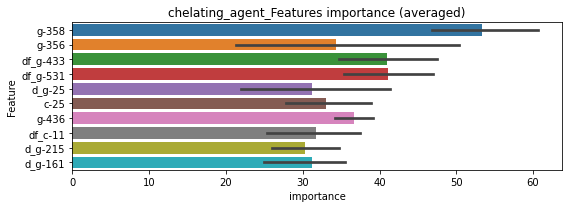

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260082	valid_1's binary_logloss: 0.0601228
[200]	training's binary_logloss: 0.00459718	valid_1's binary_logloss: 0.0323908
[300]	training's binary_logloss: 0.0012602	valid_1's binary_logloss: 0.0252598
[400]	training's binary_logloss: 0.000570213	valid_1's binary_logloss: 0.0232919
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000605366	valid_1's binary_logloss: 0.0231729


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271313	valid_1's binary_logloss: 0.056151
[200]	training's binary_logloss: 0.00488408	valid_1's binary_logloss: 0.0291044
[300]	training's binary_logloss: 0.00131808	valid_1's binary_logloss: 0.0222796
[400]	training's binary_logloss: 0.000592403	valid_1's binary_logloss: 0.0202807
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000487157	valid_1's binary_logloss: 0.0200765


chelating_agent logloss: 0.021624729121554383


neg labels: 3289 → selected neg labels: 3285


chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188989	valid_1's binary_logloss: 0.0268051
[200]	training's binary_logloss: 0.00190355	valid_1's binary_logloss: 0.00578845
[300]	training's binary_logloss: 0.000530355	valid_1's binary_logloss: 0.00286955
[400]	training's binary_logloss: 0.000300527	valid_1's binary_logloss: 0.00212285
[500]	training's binary_logloss: 0.000253723	valid_1's binary_logloss: 0.00190875
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000253723	valid_1's binary_logloss: 0.00190875
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187273	valid_1's binary_logloss: 0.0218083
[200]	training's binary_logloss: 0.00189729	valid_1's binary_logloss: 0.00342325
[300]	training's binary_logloss: 0.000537678	valid_1's binary_logloss: 0.00165649
[400]	training's binary_logloss: 0.000303584	valid_1's binary_logloss: 0.00120057
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0014510, Threshold: 0.0072517, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00653, conf_1:0.00798
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0072517
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_2: 0.0172517
Num_p_label: 44.0, Expected: 4.0, Adj_threshold_3: 0.0272517
Num_p_label: 36.0, Expected: 4.0, Adj_threshold_4: 0.0372517
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_5: 0.0472517
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_6: 0.0572517
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_7: 0.0672517
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_8: 0.0772517
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_9: 0.0872517
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_10: 0.0972517
threshold: 0.1072517, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184025	valid_1's binary_logloss: 0.0260739
[200]	training's binary_logloss: 0.00168459	valid_1's binary_logloss: 0.00556264
[300]	training's binary_logloss: 0.000446475	valid_1's binary_logloss: 0.00291051
[400]	training's binary_logloss: 0.000258436	valid_1's binary_logloss: 0.00225534
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000230012	valid_1's binary_logloss: 0.00212979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182606	valid_1's binary_logloss: 0.0202763
[200]	training's binary_logloss: 0.00167597	valid_1's binary_logloss: 0.00236876
[300]	training's binary_logloss: 0.000445775	valid_1's binary_logloss: 0.00085951
[400]	training's binary_logloss: 0.000261218	valid_1's binary_logloss: 0.000570963
[500]	training's binary_logloss: 0.00022689	valid_1's binary_logloss: 0.000524546
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.1626850, Threshold: 0.1072517, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.09653, conf_1:0.11798
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.1072517
Num_p_label: 75.0, Expected: 4.0, Adj_threshold_2: 0.1172517
Num_p_label: 72.0, Expected: 4.0, Adj_threshold_3: 0.1272517
Num_p_label: 70.0, Expected: 4.0, Adj_threshold_4: 0.1372517
Num_p_label: 68.0, Expected: 4.0, Adj_threshold_5: 0.1472517
Num_p_label: 67.0, Expected: 4.0, Adj_threshold_6: 0.1572517
Num_p_label: 63.0, Expected: 4.0, Adj_threshold_7: 0.1672517
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_8: 0.1772517
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_9: 0.1872517
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_10: 0.1972517
threshold: 0.2072517, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184025	valid_1's binary_logloss: 0.0260739
[200]	training's binary_logloss: 0.00168459	valid_1's binary_logloss: 0.00556264
[300]	training's binary_logloss: 0.000446475	valid_1's binary_logloss: 0.00291051
[400]	training's binary_logloss: 0.000258436	valid_1's binary_logloss: 0.00225534
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000230012	valid_1's binary_logloss: 0.00212979
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182606	valid_1's binary_logloss: 0.0202763
[200]	training's binary_logloss: 0.00167597	valid_1's binary_logloss: 0.00236876
[300]	training's binary_logloss: 0.000445775	valid_1's binary_logloss: 0.00085951
[400]	training's binary_logloss: 0.000261218	valid_1's binary_logloss: 0.000570963
[500]	training's binary_logloss: 0.00022689	valid_1's binary_logloss: 0.000524546
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.1626850, Threshold: 0.2072517, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0155701 Vs.target_rate: 0.00101
Num_p_label: 62.0, conf_0:0.18653, conf_1:0.22798
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_1: 0.2072517
Num_p_label: 62.0, Expected: 4.0, Adj_threshold_2: 0.2172517
Num_p_label: 60.0, Expected: 4.0, Adj_threshold_3: 0.2272517
Num_p_label: 59.0, Expected: 4.0, Adj_threshold_4: 0.2372517
Num_p_label: 56.0, Expected: 4.0, Adj_threshold_5: 0.2472517
Num_p_label: 54.0, Expected: 4.0, Adj_threshold_6: 0.2572517
Num_p_label: 52.0, Expected: 4.0, Adj_threshold_7: 0.2672517
Num_p_label: 48.0, Expected: 4.0, Adj_threshold_8: 0.2772517
Num_p_label: 45.0, Expected: 4.0, Adj_threshold_9: 0.2872517
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_10: 0.2972517
threshold: 0.3072517, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 699.0/7792, y_label_rate: 0.0897074


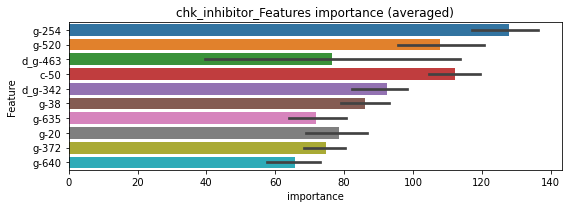

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0113575	valid_1's binary_logloss: 0.0202324
[200]	training's binary_logloss: 0.0012564	valid_1's binary_logloss: 0.00939786
[300]	training's binary_logloss: 0.000384511	valid_1's binary_logloss: 0.00823404
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000310465	valid_1's binary_logloss: 0.00813208


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011522	valid_1's binary_logloss: 0.0188511
[200]	training's binary_logloss: 0.00125437	valid_1's binary_logloss: 0.00816368
[300]	training's binary_logloss: 0.000353546	valid_1's binary_logloss: 0.00699911
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000218861	valid_1's binary_logloss: 0.00674101


chk_inhibitor logloss: 0.007436543657981423


neg labels: 3289 → selected neg labels: 3282


chloride_channel_blocker, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040217	valid_1's binary_logloss: 0.0791814
[200]	training's binary_logloss: 0.00640118	valid_1's binary_logloss: 0.0372112
[300]	training's binary_logloss: 0.00178597	valid_1's binary_logloss: 0.0276121
[400]	training's binary_logloss: 0.000840271	valid_1's binary_logloss: 0.0238665
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000749958	valid_1's binary_logloss: 0.0237048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410608	valid_1's binary_logloss: 0.0719966
[200]	training's binary_logloss: 0.00657786	valid_1's binary_logloss: 0.0270932
[300]	training's binary_logloss: 0.00185054	valid_1's binary_logloss: 0.0181707
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000978299	valid_1's binary_logloss: 0.0162792


1 / 3 AUC score:1.000
y_Threshold: 0.0076591, Threshold: 0.0127973, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.01152, conf_1:0.01408
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0127973
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_2: 0.0227973
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_3: 0.0327973
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_4: 0.0427973
threshold: 0.0427973, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393057	valid_1's binary_logloss: 0.0744219
[200]	training's binary_logloss: 0.00618368	valid_1's binary_logloss: 0.0295812
[300]	training's binary_logloss: 0.00172258	valid_1's binary_logloss: 0.0209642
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00123569	valid_1's binary_logloss: 0.0201283
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401948	valid_1's binary_logloss: 0.0623442
[200]	training's binary_logloss: 0.00655604	valid_1's binary_logloss: 0.0202757
[300]	training's binary_logloss: 0.00186209	valid_1's binary_logloss: 0.0119831
[400]	training's binary_logloss: 0.00088391	valid_1's binary_logloss: 0.00965797
[500]	training's binary_logloss: 0.000573088	valid_1's binary_logloss: 0.00884291
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000546379	valid_1's binary_logloss: 0.0086199


2 / 3 AUC score:1.000
y_Threshold: 0.0334294, Threshold: 0.0427973, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0047715 Vs.target_rate: 0.00176
Num_p_label: 19.0, conf_0:0.03852, conf_1:0.04708
threshold: 0.0427973, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395472	valid_1's binary_logloss: 0.0689436
[200]	training's binary_logloss: 0.00634073	valid_1's binary_logloss: 0.028896
[300]	training's binary_logloss: 0.00176129	valid_1's binary_logloss: 0.0199607
[400]	training's binary_logloss: 0.00083041	valid_1's binary_logloss: 0.0179343
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000690256	valid_1's binary_logloss: 0.0175124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387755	valid_1's binary_logloss: 0.0623723
[200]	training's binary_logloss: 0.00611415	valid_1's binary_logloss: 0.0209734
[300]	training's binary_logloss: 0.00172853	valid_1's binary_logloss: 0.0136605
[400]	training's binary_logloss: 0.000831774	valid_1's binary_logloss: 0.0116685
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000763198	valid_1's binary_logloss: 0.0114695


3 / 3 AUC score:1.000
y_Threshold: 0.0363991, Threshold: 0.0427973, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3786
p_label_rate: 0.0037670 Vs.target_rate: 0.00176
Num_p_label: 15.0, conf_0:0.03852, conf_1:0.04708
threshold: 0.0427973, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 661.0/7768, y_label_rate: 0.0850927


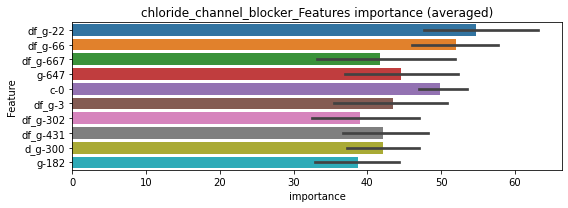

len(train_index) : 3884
len(valid_index) : 3884
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217907	valid_1's binary_logloss: 0.0488285
[200]	training's binary_logloss: 0.00345281	valid_1's binary_logloss: 0.027068
[300]	training's binary_logloss: 0.000933626	valid_1's binary_logloss: 0.0242237
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000933626	valid_1's binary_logloss: 0.0242237


len(train_index) : 3884
len(valid_index) : 3884
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227726	valid_1's binary_logloss: 0.0380614
[200]	training's binary_logloss: 0.00385655	valid_1's binary_logloss: 0.0163423
[300]	training's binary_logloss: 0.00104924	valid_1's binary_logloss: 0.0121386
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000526499	valid_1's binary_logloss: 0.011208


chloride_channel_blocker logloss: 0.017715852079289666


neg labels: 3289 → selected neg labels: 3281


cholesterol_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426498	valid_1's binary_logloss: 0.097029
[200]	training's binary_logloss: 0.00756512	valid_1's binary_logloss: 0.058337
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00351631	valid_1's binary_logloss: 0.0534674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441725	valid_1's binary_logloss: 0.0850665
[200]	training's binary_logloss: 0.00803596	valid_1's binary_logloss: 0.0391477
[300]	training's binary_logloss: 0.00225827	valid_1's binary_logloss: 0.0300682
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00147148	valid_1's binary_logloss: 0.0289212


1 / 3 AUC score:0.995
y_Threshold: 0.0127764, Threshold: 0.0163545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 156 → Positive_corect_labels: 644/3781
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01472, conf_1:0.01799
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0163545
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.0263545
Num_p_label: 9.0, Expected: 8.0, Adj_threshold_3: 0.0363545
threshold: 0.0363545, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417881	valid_1's binary_logloss: 0.0949263
[200]	training's binary_logloss: 0.00766744	valid_1's binary_logloss: 0.0526215
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00244518	valid_1's binary_logloss: 0.0438367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417163	valid_1's binary_logloss: 0.0788553
[200]	training's binary_logloss: 0.00746348	valid_1's binary_logloss: 0.0355144
[300]	training's binary_logloss: 0.00212758	valid_1's binary_logloss: 0.0268015
[400]	training's binary_logloss: 0.000995242	valid_1's binary_logloss: 0.0245381
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000704361	valid_1's binary_logloss: 0.0238033


2 / 3 AUC score:0.998
y_Threshold: 0.0295389, Threshold: 0.0363545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 632.0/3757
p_label_rate: 0.0057760 Vs.target_rate: 0.00202
Num_p_label: 23.0, conf_0:0.03272, conf_1:0.03999
threshold: 0.0363545, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 632.0/3757, y_label_rate: 0.1682193
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425156	valid_1's binary_logloss: 0.0783471
[200]	training's binary_logloss: 0.00737832	valid_1's binary_logloss: 0.0321022
[300]	training's binary_logloss: 0.00207987	valid_1's binary_logloss: 0.0208848
[400]	training's binary_logloss: 0.000975969	valid_1's binary_logloss: 0.0173068
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000733855	valid_1's binary_logloss: 0.0162259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401425	valid_1's binary_logloss: 0.0850176
[200]	training's binary_logloss: 0.00696802	valid_1's binary_logloss: 0.0389819
[300]	training's binary_logloss: 0.00199807	valid_1's binary_logloss: 0.0285821
[400]	training's binary_logloss: 0.000953177	valid_1's binary_logloss: 0.0265004
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000717484	valid_1's binary_logloss: 0.0258995


3 / 3 AUC score:1.000
y_Threshold: 0.0210687, Threshold: 0.0363545, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 628.0/3749
p_label_rate: 0.0025113 Vs.target_rate: 0.00202
Num_p_label: 10.0, conf_0:0.03272, conf_1:0.03999
threshold: 0.0363545, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 638.0/7731, y_label_rate: 0.0825249


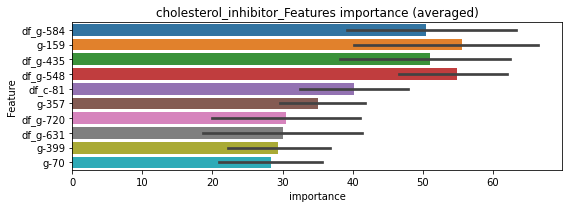

len(train_index) : 3865
len(valid_index) : 3866
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220277	valid_1's binary_logloss: 0.0487443
[200]	training's binary_logloss: 0.00390591	valid_1's binary_logloss: 0.0255889
[300]	training's binary_logloss: 0.00109318	valid_1's binary_logloss: 0.0201154
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.000656813	valid_1's binary_logloss: 0.0186028


len(train_index) : 3866
len(valid_index) : 3865
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230869	valid_1's binary_logloss: 0.048208
[200]	training's binary_logloss: 0.00400251	valid_1's binary_logloss: 0.0240693
[300]	training's binary_logloss: 0.00111776	valid_1's binary_logloss: 0.0188781
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000547369	valid_1's binary_logloss: 0.0177508


cholesterol_inhibitor logloss: 0.018176856475404252


neg labels: 3289 → selected neg labels: 3280


cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3280, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525409	valid_1's binary_logloss: 0.0996996
[200]	training's binary_logloss: 0.0103601	valid_1's binary_logloss: 0.0483003
[300]	training's binary_logloss: 0.00283117	valid_1's binary_logloss: 0.0333994
[400]	training's binary_logloss: 0.00123624	valid_1's binary_logloss: 0.0281265
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00087371	valid_1's binary_logloss: 0.0268072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532309	valid_1's binary_logloss: 0.104663
[200]	training's binary_logloss: 0.0093765	valid_1's binary_logloss: 0.0581903
[300]	training's binary_logloss: 0.00251535	valid_1's binary_logloss: 0.0509875
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00230492	valid_1's binary_logloss: 0.0507461


1 / 3 AUC score:0.996
y_Threshold: 0.0121484, Threshold: 0.0170595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 646/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00227
Num_p_label: 80.0, conf_0:0.01535, conf_1:0.01877
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_1: 0.0170595
Num_p_label: 30.0, Expected: 9.0, Adj_threshold_2: 0.0270595
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_3: 0.0370595
threshold: 0.0370595, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498626	valid_1's binary_logloss: 0.0976635
[200]	training's binary_logloss: 0.00910331	valid_1's binary_logloss: 0.0440478
[300]	training's binary_logloss: 0.0025891	valid_1's binary_logloss: 0.0300797
[400]	training's binary_logloss: 0.00115427	valid_1's binary_logloss: 0.0247408
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00115427	valid_1's binary_logloss: 0.0247408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496414	valid_1's binary_logloss: 0.089149
[200]	training's binary_logloss: 0.0090882	valid_1's binary_logloss: 0.0378294
[300]	training's binary_logloss: 0.0025066	valid_1's binary_logloss: 0.0259528
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00134518	valid_1's binary_logloss: 0.0230093


2 / 3 AUC score:0.997
y_Threshold: 0.0402878, Threshold: 0.0370595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 640.0/3772
p_label_rate: 0.0092918 Vs.target_rate: 0.00227
Num_p_label: 37.0, conf_0:0.03335, conf_1:0.04077
Num_p_label: 37.0, Expected: 9.0, Adj_threshold_1: 0.0370595
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_2: 0.0470595
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_3: 0.0570595
Num_p_label: 14.0, Expected: 9.0, Adj_threshold_4: 0.0670595
threshold: 0.0670595, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 640.0/3772, y_label_rate: 0.1696713
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458251	valid_1's binary_logloss: 0.0913687
[200]	training's binary_logloss: 0.00835008	valid_1's binary_logloss: 0.0429103
[300]	training's binary_logloss: 0.00237484	valid_1's binary_logloss: 0.0314473
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00136043	valid_1's binary_logloss: 0.0294886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.049157	valid_1's binary_logloss: 0.0938822
[200]	training's binary_logloss: 0.00887908	valid_1's binary_logloss: 0.0466531
[300]	training's binary_logloss: 0.00245237	valid_1's binary_logloss: 0.0386494
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.00162691	valid_1's binary_logloss: 0.0377689


3 / 3 AUC score:0.998
y_Threshold: 0.0337883, Threshold: 0.0670595, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 627.0/3746
p_label_rate: 0.0040181 Vs.target_rate: 0.00227
Num_p_label: 16.0, conf_0:0.06035, conf_1:0.07377
threshold: 0.0670595, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 643.0/7728, y_label_rate: 0.0832039


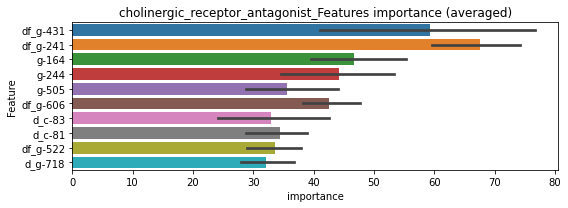

len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254412	valid_1's binary_logloss: 0.0549733
[200]	training's binary_logloss: 0.00469137	valid_1's binary_logloss: 0.0288127
[300]	training's binary_logloss: 0.00127466	valid_1's binary_logloss: 0.0238424
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000688056	valid_1's binary_logloss: 0.0228946


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028353	valid_1's binary_logloss: 0.0530049
[200]	training's binary_logloss: 0.00523491	valid_1's binary_logloss: 0.0231793
[300]	training's binary_logloss: 0.00143733	valid_1's binary_logloss: 0.0170847
[400]	training's binary_logloss: 0.000629209	valid_1's binary_logloss: 0.0158981
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000598894	valid_1's binary_logloss: 0.0157811


cholinergic_receptor_antagonist logloss: 0.01933787543246807


neg labels: 3289 → selected neg labels: 3285


coagulation_factor_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285351	valid_1's binary_logloss: 0.0423164
[200]	training's binary_logloss: 0.00378981	valid_1's binary_logloss: 0.00956014
[300]	training's binary_logloss: 0.00106387	valid_1's binary_logloss: 0.00420122
[400]	training's binary_logloss: 0.000541972	valid_1's binary_logloss: 0.00266232
[500]	training's binary_logloss: 0.000391975	valid_1's binary_logloss: 0.00222558
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000379388	valid_1's binary_logloss: 0.00217288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281256	valid_1's binary_logloss: 0.0427685
[200]	training's binary_logloss: 0.00364323	valid_1's binary_logloss: 0.00984705
[300]	training's binary_logloss: 0.00102331	valid_1's binary_logloss: 0.00425753
[400]	training's binary_logloss: 0.000515316	valid_1's binary_logloss: 0.00281163
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0024273, Threshold: 0.0032599, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00293, conf_1:0.00359
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0032599
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_2: 0.0132599
threshold: 0.0132599, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272913	valid_1's binary_logloss: 0.0393829
[200]	training's binary_logloss: 0.00348845	valid_1's binary_logloss: 0.00777859
[300]	training's binary_logloss: 0.000997325	valid_1's binary_logloss: 0.0030774
[400]	training's binary_logloss: 0.000514296	valid_1's binary_logloss: 0.00177663
[500]	training's binary_logloss: 0.00038282	valid_1's binary_logloss: 0.00147331
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000369897	valid_1's binary_logloss: 0.00145731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273099	valid_1's binary_logloss: 0.0386168
[200]	training's binary_logloss: 0.00348298	valid_1's binary_logloss: 0.00853385
[300]	training's binary_logloss: 0.000994096	valid_1's binary_logloss: 0.00395325
[400]	training's binary_logloss: 0.000508533	valid_1's binary_logloss: 0.00261608
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.1073334, Threshold: 0.0132599, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00101
Num_p_label: 11.0, conf_0:0.01193, conf_1:0.01459
threshold: 0.0132599, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272913	valid_1's binary_logloss: 0.0393829
[200]	training's binary_logloss: 0.00348845	valid_1's binary_logloss: 0.00777859
[300]	training's binary_logloss: 0.000997325	valid_1's binary_logloss: 0.0030774
[400]	training's binary_logloss: 0.000514296	valid_1's binary_logloss: 0.00177663
[500]	training's binary_logloss: 0.00038282	valid_1's binary_logloss: 0.00147331
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000369897	valid_1's binary_logloss: 0.00145731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273099	valid_1's binary_logloss: 0.0386168
[200]	training's binary_logloss: 0.00348298	valid_1's binary_logloss: 0.00853385
[300]	training's binary_logloss: 0.000994096	valid_1's binary_logloss: 0.00395325
[400]	training's binary_logloss: 0.000508533	valid_1's binary_logloss: 0.00261608
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.1073334, Threshold: 0.0132599, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0027624 Vs.target_rate: 0.00101
Num_p_label: 11.0, conf_0:0.01193, conf_1:0.01459
threshold: 0.0132599, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 668.0/7792, y_label_rate: 0.0857290


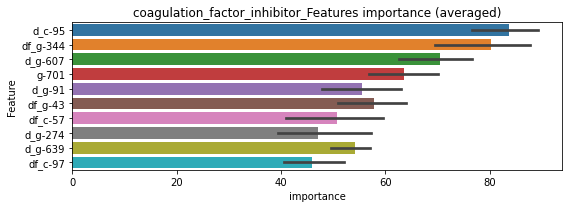

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154889	valid_1's binary_logloss: 0.0296225
[200]	training's binary_logloss: 0.00197632	valid_1's binary_logloss: 0.0146408
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.000624077	valid_1's binary_logloss: 0.0136155


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167122	valid_1's binary_logloss: 0.0238515
[200]	training's binary_logloss: 0.00225559	valid_1's binary_logloss: 0.00772881
[300]	training's binary_logloss: 0.000611712	valid_1's binary_logloss: 0.00548315
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000399554	valid_1's binary_logloss: 0.00522607


coagulation_factor_inhibitor logloss: 0.00942078935212426


neg labels: 3289 → selected neg labels: 3284


corticosteroid_agonist, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251326	valid_1's binary_logloss: 0.0435443
[200]	training's binary_logloss: 0.00324602	valid_1's binary_logloss: 0.0148363
[300]	training's binary_logloss: 0.000941925	valid_1's binary_logloss: 0.009121
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000559799	valid_1's binary_logloss: 0.00795438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257028	valid_1's binary_logloss: 0.0529487
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00440993	valid_1's binary_logloss: 0.0334539


1 / 3 AUC score:1.000
y_Threshold: 0.0074707, Threshold: 0.0089825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00808, conf_1:0.00988
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0089825
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_2: 0.0189825
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_3: 0.0289825
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_4: 0.0389825
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_5: 0.0489825
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_6: 0.0589825
Num_p_label: 36.0, Expected: 6.0, Adj_threshold_7: 0.0689825
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_8: 0.0789825
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_9: 0.0889825
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_10: 0.0989825
threshold: 0.1089825, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230194	valid_1's binary_logloss: 0.0357759
[200]	training's binary_logloss: 0.00282342	valid_1's binary_logloss: 0.00921739
[300]	training's binary_logloss: 0.000791486	valid_1's binary_logloss: 0.00476168
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.000540711	valid_1's binary_logloss: 0.00388146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023258	valid_1's binary_logloss: 0.0442382
[200]	training's binary_logloss: 0.00272017	valid_1's binary_logloss: 0.0270841
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00174171	valid_1's binary_logloss: 0.0264758


2 / 3 AUC score:1.000
y_Threshold: 0.0249729, Threshold: 0.1089825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0113009 Vs.target_rate: 0.00151
Num_p_label: 45.0, conf_0:0.09808, conf_1:0.11988
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_1: 0.1089825
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_2: 0.1189825
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_3: 0.1289825
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_4: 0.1389825
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_5: 0.1489825
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_6: 0.1589825
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_7: 0.1689825
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_8: 0.1789825
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_9: 0.1889825
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_10: 0.1989825
threshold: 0.2089825, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 648.0/3792, y_label_rate: 0.1708861
========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230832	valid_1's binary_logloss: 0.0364414
[200]	training's binary_logloss: 0.00262232	valid_1's binary_logloss: 0.0123341
[300]	training's binary_logloss: 0.000729144	valid_1's binary_logloss: 0.00914129
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000655021	valid_1's binary_logloss: 0.00888673
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234965	valid_1's binary_logloss: 0.0392317
[200]	training's binary_logloss: 0.00267465	valid_1's binary_logloss: 0.0128792
[300]	training's binary_logloss: 0.000750108	valid_1's binary_logloss: 0.00864934
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000657478	valid_1's binary_logloss: 0.00837086


3 / 3 AUC score:1.000
y_Threshold: 0.0248361, Threshold: 0.2089825, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0100452 Vs.target_rate: 0.00151
Num_p_label: 40.0, conf_0:0.18808, conf_1:0.22988
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.2089825
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.2189825
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_3: 0.2289825
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_4: 0.2389825
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_5: 0.2489825
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_6: 0.2589825
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_7: 0.2689825
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_8: 0.2789825
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_9: 0.2889825
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_10: 0.2989825
threshold: 0.3089825, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 685.0/7770, y_label_rate: 0.0881596


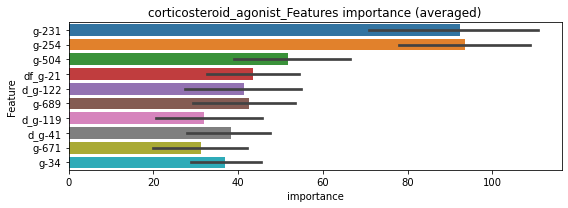

len(train_index) : 3885
len(valid_index) : 3885
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0121318	valid_1's binary_logloss: 0.0239952
[200]	training's binary_logloss: 0.00132199	valid_1's binary_logloss: 0.00815602
[300]	training's binary_logloss: 0.000372663	valid_1's binary_logloss: 0.00575953
[400]	training's binary_logloss: 0.000202317	valid_1's binary_logloss: 0.00521194
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00019417	valid_1's binary_logloss: 0.00516473


len(train_index) : 3885
len(valid_index) : 3885
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128104	valid_1's binary_logloss: 0.0186907
[200]	training's binary_logloss: 0.00143544	valid_1's binary_logloss: 0.00535036
[300]	training's binary_logloss: 0.000409337	valid_1's binary_logloss: 0.00366264
[400]	training's binary_logloss: 0.000216083	valid_1's binary_logloss: 0.00318376
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000202781	valid_1's binary_logloss: 0.00314028


corticosteroid_agonist logloss: 0.0041525043353766375


neg labels: 3289 → selected neg labels: 3215


cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3215, target_rate: 0.0182666 → Adj_target_rate: 0.0146863
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122732	valid_1's binary_logloss: 0.376454
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0683792	valid_1's binary_logloss: 0.370476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133606	valid_1's binary_logloss: 0.369539
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.0957325	valid_1's binary_logloss: 0.364337


1 / 3 AUC score:0.777
y_Threshold: 0.1395128, Threshold: 0.1974686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 733 → Positive_corect_labels: 341/3125
p_label_rate: 0.0200904 Vs.target_rate: 0.01827
Num_p_label: 80.0, conf_0:0.17772, conf_1:0.21722
threshold: 0.1974686, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 341.0/3125, y_label_rate: 0.1091200
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604061	valid_1's binary_logloss: 0.234024
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.0359178	valid_1's binary_logloss: 0.229792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06276	valid_1's binary_logloss: 0.239212
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0428521	valid_1's binary_logloss: 0.234707


2 / 3 AUC score:0.885
y_Threshold: 0.1068217, Threshold: 0.1974686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 278 → Positive_corect_labels: 202.0/2847
p_label_rate: 0.0128076 Vs.target_rate: 0.01827
Num_p_label: 51.0, conf_0:0.17772, conf_1:0.21722
threshold: 0.1974686, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 202.0/2847, y_label_rate: 0.0709519
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284366	valid_1's binary_logloss: 0.138749
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0118588	valid_1's binary_logloss: 0.133171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289875	valid_1's binary_logloss: 0.131052
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.0116255	valid_1's binary_logloss: 0.123347


3 / 3 AUC score:0.951
y_Threshold: 0.0673504, Threshold: 0.1974686, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 106 → Positive_corect_labels: 149.0/2741
p_label_rate: 0.0107986 Vs.target_rate: 0.01827
Num_p_label: 43.0, conf_0:0.17772, conf_1:0.21722
threshold: 0.1974686, positive_p_label: 43.0/3982, p_label_rate: 0.0107986
positive_y_label: 192.0/6723, y_label_rate: 0.0285587


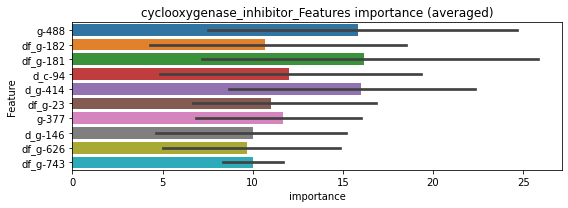

len(train_index) : 3361
len(valid_index) : 3362
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0109571	valid_1's binary_logloss: 0.0630588
Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00361211	valid_1's binary_logloss: 0.0604488


len(train_index) : 3362
len(valid_index) : 3361
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112441	valid_1's binary_logloss: 0.066068
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.00560702	valid_1's binary_logloss: 0.0637329


cyclooxygenase_inhibitor logloss: 0.062090619244630815


neg labels: 3289 → selected neg labels: 3274


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3274, target_rate: 0.0043672 → Adj_target_rate: 0.0043519
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0723143	valid_1's binary_logloss: 0.173301
[200]	training's binary_logloss: 0.0182954	valid_1's binary_logloss: 0.12195
[300]	training's binary_logloss: 0.00564364	valid_1's binary_logloss: 0.106764
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00442952	valid_1's binary_logloss: 0.104129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743408	valid_1's binary_logloss: 0.147493
[200]	training's binary_logloss: 0.0191	valid_1's binary_logloss: 0.08338
[300]	training's binary_logloss: 0.00577509	valid_1's binary_logloss: 0.0622943
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.00273473	valid_1's binary_logloss: 0.0567461


1 / 3 AUC score:0.991
y_Threshold: 0.0286601, Threshold: 0.0358175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 636/3760
p_label_rate: 0.0200904 Vs.target_rate: 0.00437
Num_p_label: 80.0, conf_0:0.03224, conf_1:0.03940
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.0358175
Num_p_label: 52.0, Expected: 17.4, Adj_threshold_2: 0.0458175
Num_p_label: 34.0, Expected: 17.4, Adj_threshold_3: 0.0558175
threshold: 0.0558175, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 636.0/3760, y_label_rate: 0.1691489
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698764	valid_1's binary_logloss: 0.155939
[200]	training's binary_logloss: 0.0165711	valid_1's binary_logloss: 0.105856
[300]	training's binary_logloss: 0.00498343	valid_1's binary_logloss: 0.0926255
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00411349	valid_1's binary_logloss: 0.0905557
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702171	valid_1's binary_logloss: 0.158767
[200]	training's binary_logloss: 0.0164486	valid_1's binary_logloss: 0.114305
[300]	training's binary_logloss: 0.00490074	valid_1's binary_logloss: 0.10695
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00505495	valid_1's binary_logloss: 0.106878


2 / 3 AUC score:0.982
y_Threshold: 0.0525899, Threshold: 0.0558175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 88 → Positive_corect_labels: 592.0/3672
p_label_rate: 0.0200904 Vs.target_rate: 0.00437
Num_p_label: 80.0, conf_0:0.05024, conf_1:0.06140
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.0558175
Num_p_label: 54.0, Expected: 17.4, Adj_threshold_2: 0.0658175
Num_p_label: 38.0, Expected: 17.4, Adj_threshold_3: 0.0758175
Num_p_label: 29.0, Expected: 17.4, Adj_threshold_4: 0.0858175
threshold: 0.0858175, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 592.0/3672, y_label_rate: 0.1612200
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0608149	valid_1's binary_logloss: 0.143844
[200]	training's binary_logloss: 0.0139202	valid_1's binary_logloss: 0.0975427
[300]	training's binary_logloss: 0.00406599	valid_1's binary_logloss: 0.0878046
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00414362	valid_1's binary_logloss: 0.0874257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0647713	valid_1's binary_logloss: 0.12528
[200]	training's binary_logloss: 0.0146023	valid_1's binary_logloss: 0.0632509
[300]	training's binary_logloss: 0.00436726	valid_1's binary_logloss: 0.0461342
[400]	training's binary_logloss: 0.00192304	valid_1's binary_logloss: 0.0410046
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00138521	valid_1's binary_logloss: 0.0391483


3 / 3 AUC score:0.994
y_Threshold: 0.0500656, Threshold: 0.0858175, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 568.0/3624
p_label_rate: 0.0095429 Vs.target_rate: 0.00437
Num_p_label: 38.0, conf_0:0.07724, conf_1:0.09440
threshold: 0.0858175, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 606.0/7606, y_label_rate: 0.0796739


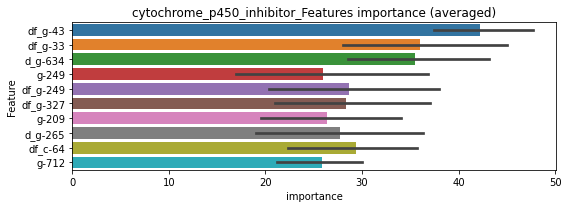

len(train_index) : 3803
len(valid_index) : 3803
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0346072	valid_1's binary_logloss: 0.0912795
[200]	training's binary_logloss: 0.00743296	valid_1's binary_logloss: 0.0676754
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.00409286	valid_1's binary_logloss: 0.0651369


len(train_index) : 3803
len(valid_index) : 3803
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373422	valid_1's binary_logloss: 0.0789709
[200]	training's binary_logloss: 0.00843195	valid_1's binary_logloss: 0.0487245
[300]	training's binary_logloss: 0.0023338	valid_1's binary_logloss: 0.0415688
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00230797	valid_1's binary_logloss: 0.0415494


cytochrome_p450_inhibitor logloss: 0.05334314184075212


neg labels: 3289 → selected neg labels: 3283


dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305746	valid_1's binary_logloss: 0.0467374
[200]	training's binary_logloss: 0.00416673	valid_1's binary_logloss: 0.0113208
[300]	training's binary_logloss: 0.00118573	valid_1's binary_logloss: 0.00539303
[400]	training's binary_logloss: 0.00058889	valid_1's binary_logloss: 0.00376621
[500]	training's binary_logloss: 0.000415579	valid_1's binary_logloss: 0.00325677
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.000388344	valid_1's binary_logloss: 0.00315892
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303867	valid_1's binary_logloss: 0.0511343
[200]	training's binary_logloss: 0.00429083	valid_1's binary_logloss: 0.0175966
[300]	training's binary_logloss: 0.00120718	valid_1's binary_logloss: 0.0111621
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00078828	valid_1's binary_logloss: 0.0100135


1 / 3 AUC score:1.000
y_Threshold: 0.0029711, Threshold: 0.0038194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00344, conf_1:0.00420
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0038194
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0138194
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0238194
threshold: 0.0238194, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302987	valid_1's binary_logloss: 0.0465257
[200]	training's binary_logloss: 0.00403407	valid_1's binary_logloss: 0.0103473
[300]	training's binary_logloss: 0.00114546	valid_1's binary_logloss: 0.0042299
[400]	training's binary_logloss: 0.000574126	valid_1's binary_logloss: 0.00255916
[500]	training's binary_logloss: 0.000409343	valid_1's binary_logloss: 0.00210528
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000396324	valid_1's binary_logloss: 0.00206462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295156	valid_1's binary_logloss: 0.0512532
[200]	training's binary_logloss: 0.0040049	valid_1's binary_logloss: 0.0151138
[300]	training's binary_logloss: 0.00113479	valid_1's binary_logloss: 0.00898216
[400]	training's binary_logloss: 0.000567387	valid_1's binary_logloss: 0.00710083
Early stopping, best iteration is:
[4

2 / 3 AUC score:1.000
y_Threshold: 0.0238085, Threshold: 0.0238194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0050226 Vs.target_rate: 0.00151
Num_p_label: 20.0, conf_0:0.02144, conf_1:0.02620
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_1: 0.0238194
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.0338194
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_3: 0.0438194
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.0538194
threshold: 0.0538194, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302987	valid_1's binary_logloss: 0.0465257
[200]	training's binary_logloss: 0.00403407	valid_1's binary_logloss: 0.0103473
[300]	training's binary_logloss: 0.00114546	valid_1's binary_logloss: 0.0042299
[400]	training's binary_logloss: 0.000574126	valid_1's binary_logloss: 0.00255916
[500]	training's binary_logloss: 0.000409343	valid_1's binary_logloss: 0.00210528
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000396324	valid_1's binary_logloss: 0.00206462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295156	valid_1's binary_logloss: 0.0512532
[200]	training's binary_logloss: 0.0040049	valid_1's binary_logloss: 0.0151138
[300]	training's binary_logloss: 0.00113479	valid_1's binary_logloss: 0.00898216
[400]	training's binary_logloss: 0.000567387	valid_1's binary_logloss: 0.00710083
Early stopping, best iteration is:
[4

3 / 3 AUC score:1.000
y_Threshold: 0.0238085, Threshold: 0.0538194, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0027624 Vs.target_rate: 0.00151
Num_p_label: 11.0, conf_0:0.04844, conf_1:0.05920
threshold: 0.0538194, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 667.0/7789, y_label_rate: 0.0856336


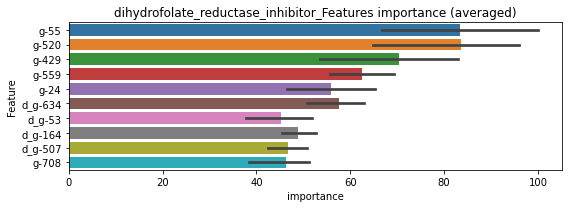

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159852	valid_1's binary_logloss: 0.0307061
[200]	training's binary_logloss: 0.00217102	valid_1's binary_logloss: 0.0115687
[300]	training's binary_logloss: 0.000590832	valid_1's binary_logloss: 0.00815525
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0003555	valid_1's binary_logloss: 0.00759508


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161853	valid_1's binary_logloss: 0.0262864
[200]	training's binary_logloss: 0.00221204	valid_1's binary_logloss: 0.006751
[300]	training's binary_logloss: 0.000617091	valid_1's binary_logloss: 0.00340912
[400]	training's binary_logloss: 0.000303613	valid_1's binary_logloss: 0.00261513
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000231116	valid_1's binary_logloss: 0.00244536


dihydrofolate_reductase_inhibitor logloss: 0.005020548774346609


neg labels: 3289 → selected neg labels: 3285


dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283	valid_1's binary_logloss: 0.0481051
[200]	training's binary_logloss: 0.00367942	valid_1's binary_logloss: 0.0171332
[300]	training's binary_logloss: 0.00102872	valid_1's binary_logloss: 0.0132651
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000831316	valid_1's binary_logloss: 0.0129038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281808	valid_1's binary_logloss: 0.0389187
[200]	training's binary_logloss: 0.00372565	valid_1's binary_logloss: 0.00688522
[300]	training's binary_logloss: 0.00103947	valid_1's binary_logloss: 0.00240649
[400]	training's binary_logloss: 0.000525091	valid_1's binary_logloss: 0.00139251
[500]	training's binary_logloss: 0.000383244	valid_1's binary_logloss: 0.00111488
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00036444	valid_1's binary_logloss: 0.00107736


1 / 3 AUC score:1.000
y_Threshold: 0.0031742, Threshold: 0.0037917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00341, conf_1:0.00417
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0037917
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.0137917
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.0237917
threshold: 0.0237917, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276935	valid_1's binary_logloss: 0.0463794
[200]	training's binary_logloss: 0.00351801	valid_1's binary_logloss: 0.0162208
[300]	training's binary_logloss: 0.00100774	valid_1's binary_logloss: 0.0119784
[400]	training's binary_logloss: 0.000511664	valid_1's binary_logloss: 0.010542
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000436495	valid_1's binary_logloss: 0.0101813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275948	valid_1's binary_logloss: 0.0374342
[200]	training's binary_logloss: 0.00353978	valid_1's binary_logloss: 0.00675427
[300]	training's binary_logloss: 0.00101095	valid_1's binary_logloss: 0.00255879
[400]	training's binary_logloss: 0.000515522	valid_1's binary_logloss: 0.00153924
[500]	training's binary_logloss: 0.000382231	valid_1's binary_logloss: 0.00123498
Early stopping, best iteration is:
[53

2 / 3 AUC score:1.000
y_Threshold: 0.0118418, Threshold: 0.0237917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00105
Num_p_label: 8.0, conf_0:0.02141, conf_1:0.02617
threshold: 0.0237917, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276935	valid_1's binary_logloss: 0.0463794
[200]	training's binary_logloss: 0.00351801	valid_1's binary_logloss: 0.0162208
[300]	training's binary_logloss: 0.00100774	valid_1's binary_logloss: 0.0119784
[400]	training's binary_logloss: 0.000511664	valid_1's binary_logloss: 0.010542
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000436495	valid_1's binary_logloss: 0.0101813
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275948	valid_1's binary_logloss: 0.0374342
[200]	training's binary_logloss: 0.00353978	valid_1's binary_logloss: 0.00675427
[300]	training's binary_logloss: 0.00101095	valid_1's binary_logloss: 0.00255879
[400]	training's binary_logloss: 0.000515522	valid_1's binary_logloss: 0.00153924
[500]	training's binary_logloss: 0.000382231	valid_1's binary_logloss: 0.00123498
Early stopping, best iteration is:
[53

3 / 3 AUC score:1.000
y_Threshold: 0.0118418, Threshold: 0.0237917, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00105
Num_p_label: 8.0, conf_0:0.02141, conf_1:0.02617
threshold: 0.0237917, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


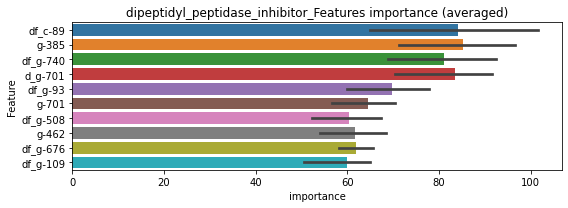

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153027	valid_1's binary_logloss: 0.0321234
[200]	training's binary_logloss: 0.0019015	valid_1's binary_logloss: 0.0162883
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000584046	valid_1's binary_logloss: 0.0146943


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160146	valid_1's binary_logloss: 0.0210478
[200]	training's binary_logloss: 0.00211982	valid_1's binary_logloss: 0.00521935
[300]	training's binary_logloss: 0.000578966	valid_1's binary_logloss: 0.00323349
[400]	training's binary_logloss: 0.00028526	valid_1's binary_logloss: 0.00290013
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000293367	valid_1's binary_logloss: 0.00288822


dipeptidyl_peptidase_inhibitor logloss: 0.008791272563574976


neg labels: 3289 → selected neg labels: 3288


diuretic, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153426	valid_1's binary_logloss: 0.0169814
[200]	training's binary_logloss: 0.00124116	valid_1's binary_logloss: 0.00231975
[300]	training's binary_logloss: 0.000340544	valid_1's binary_logloss: 0.0011903
[400]	training's binary_logloss: 0.000212902	valid_1's binary_logloss: 0.00101286
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000198878	valid_1's binary_logloss: 0.00098144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153449	valid_1's binary_logloss: 0.0172823
[200]	training's binary_logloss: 0.00123692	valid_1's binary_logloss: 0.00252342
[300]	training's binary_logloss: 0.000335418	valid_1's binary_logloss: 0.00119545
[400]	training's binary_logloss: 0.000209209	valid_1's binary_logloss: 0.000918939
[500]	training's binary_logloss: 0.000183916	valid_1's binary_logloss: 0.000865365
Early stopping, best iteration

1 / 3 AUC score:1.000
y_Threshold: 0.0005687, Threshold: 0.0011528, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00104, conf_1:0.00127
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0011528
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0111528
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0211528
threshold: 0.0211528, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157227	valid_1's binary_logloss: 0.0186661
[200]	training's binary_logloss: 0.00125473	valid_1's binary_logloss: 0.00371662
[300]	training's binary_logloss: 0.000336341	valid_1's binary_logloss: 0.00245508
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000288607	valid_1's binary_logloss: 0.00240197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157952	valid_1's binary_logloss: 0.0216754
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00162215	valid_1's binary_logloss: 0.00685051


2 / 3 AUC score:1.000
y_Threshold: 0.0288293, Threshold: 0.0211528, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0060271 Vs.target_rate: 0.00025
Num_p_label: 24.0, conf_0:0.01904, conf_1:0.02327
Num_p_label: 24.0, Expected: 1.0, Adj_threshold_1: 0.0211528
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_2: 0.0311528
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.0411528
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.0511528
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_5: 0.0611528
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0711528
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0811528
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.0911528
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.1011528
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.1111528
threshold: 0.1211528, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157227	valid_1's binary_logloss: 0.0186661
[200]	training's binary_logloss: 0.00125473	valid_1's binary_logloss: 0.00371662
[300]	training's binary_logloss: 0.000336341	valid_1's binary_logloss: 0.00245508
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000288607	valid_1's binary_logloss: 0.00240197
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157952	valid_1's binary_logloss: 0.0216754
Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00162215	valid_1's binary_logloss: 0.00685051


3 / 3 AUC score:1.000
y_Threshold: 0.0288293, Threshold: 0.1211528, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.10904, conf_1:0.13327
threshold: 0.1211528, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


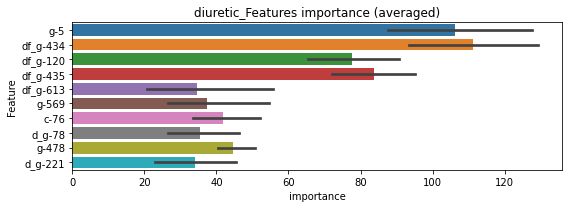

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00838412	valid_1's binary_logloss: 0.0102655
[200]	training's binary_logloss: 0.000663172	valid_1's binary_logloss: 0.00228431
[300]	training's binary_logloss: 0.000174486	valid_1's binary_logloss: 0.00169317
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000130029	valid_1's binary_logloss: 0.00162461


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00843481	valid_1's binary_logloss: 0.00985832
[200]	training's binary_logloss: 0.000660207	valid_1's binary_logloss: 0.00179765
[300]	training's binary_logloss: 0.000173975	valid_1's binary_logloss: 0.00131991
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000169995	valid_1's binary_logloss: 0.00131451


diuretic logloss: 0.0014695817597894759


neg labels: 3289 → selected neg labels: 3281


dna_alkylating_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0388185	valid_1's binary_logloss: 0.0784012
[200]	training's binary_logloss: 0.00666846	valid_1's binary_logloss: 0.0280159
[300]	training's binary_logloss: 0.00192443	valid_1's binary_logloss: 0.0156294
[400]	training's binary_logloss: 0.000928668	valid_1's binary_logloss: 0.011074
[500]	training's binary_logloss: 0.000610693	valid_1's binary_logloss: 0.00970097
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000592118	valid_1's binary_logloss: 0.00953117
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412415	valid_1's binary_logloss: 0.0767921
[200]	training's binary_logloss: 0.00696963	valid_1's binary_logloss: 0.0283393
[300]	training's binary_logloss: 0.00201288	valid_1's binary_logloss: 0.0174883
[400]	training's binary_logloss: 0.000962682	valid_1's binary_logloss: 0.0149211
Early stopping, best iteration is:
[467]

1 / 3 AUC score:1.000
y_Threshold: 0.0061273, Threshold: 0.0113100, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01018, conf_1:0.01244
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0113100
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_2: 0.0213100
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_3: 0.0313100
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_4: 0.0413100
threshold: 0.0413100, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039252	valid_1's binary_logloss: 0.0751945
[200]	training's binary_logloss: 0.00638061	valid_1's binary_logloss: 0.0312379
[300]	training's binary_logloss: 0.00184843	valid_1's binary_logloss: 0.0206606
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00131343	valid_1's binary_logloss: 0.0188763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404754	valid_1's binary_logloss: 0.0704921
[200]	training's binary_logloss: 0.00650764	valid_1's binary_logloss: 0.0218936
[300]	training's binary_logloss: 0.00187935	valid_1's binary_logloss: 0.0117694
[400]	training's binary_logloss: 0.000917777	valid_1's binary_logloss: 0.00869573
[500]	training's binary_logloss: 0.000592847	valid_1's binary_logloss: 0.00756598
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00058884	valid_1's binary_logloss: 0.00755097


2 / 3 AUC score:1.000
y_Threshold: 0.0490336, Threshold: 0.0413100, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3801
p_label_rate: 0.0133099 Vs.target_rate: 0.00202
Num_p_label: 53.0, conf_0:0.03718, conf_1:0.04544
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_1: 0.0413100
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_2: 0.0513100
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_3: 0.0613100
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.0713100
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_5: 0.0813100
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_6: 0.0913100
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_7: 0.1013100
threshold: 0.1013100, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403439	valid_1's binary_logloss: 0.081392
[200]	training's binary_logloss: 0.00649633	valid_1's binary_logloss: 0.0358302
[300]	training's binary_logloss: 0.0018563	valid_1's binary_logloss: 0.0285571
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000955536	valid_1's binary_logloss: 0.0262835
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408709	valid_1's binary_logloss: 0.0682628
[200]	training's binary_logloss: 0.00666728	valid_1's binary_logloss: 0.0212086
[300]	training's binary_logloss: 0.00190865	valid_1's binary_logloss: 0.0118848
[400]	training's binary_logloss: 0.000918082	valid_1's binary_logloss: 0.00933832
[500]	training's binary_logloss: 0.000602662	valid_1's binary_logloss: 0.00855918
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000541976	valid_1's binary_logloss: 0.00837978


3 / 3 AUC score:1.000
y_Threshold: 0.0205073, Threshold: 0.1013100, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0032647 Vs.target_rate: 0.00202
Num_p_label: 13.0, conf_0:0.09118, conf_1:0.11144
threshold: 0.1013100, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 662.0/7773, y_label_rate: 0.0851666


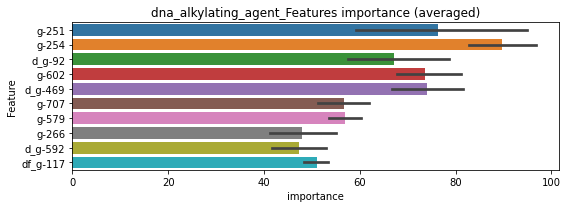

len(train_index) : 3886
len(valid_index) : 3887
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224748	valid_1's binary_logloss: 0.047793
[200]	training's binary_logloss: 0.00363022	valid_1's binary_logloss: 0.0215264
[300]	training's binary_logloss: 0.00100931	valid_1's binary_logloss: 0.0150415
[400]	training's binary_logloss: 0.000482985	valid_1's binary_logloss: 0.0133405
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000469317	valid_1's binary_logloss: 0.0132852


len(train_index) : 3887
len(valid_index) : 3886
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215	valid_1's binary_logloss: 0.0486553
[200]	training's binary_logloss: 0.00343083	valid_1's binary_logloss: 0.0237059
[300]	training's binary_logloss: 0.000978372	valid_1's binary_logloss: 0.0185749
[400]	training's binary_logloss: 0.000474665	valid_1's binary_logloss: 0.01692
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000463722	valid_1's binary_logloss: 0.0168949


dna_alkylating_agent logloss: 0.015089772433156038


neg labels: 3289 → selected neg labels: 3229


dna_inhibitor, len(trt): 402, len(othr): 3229, target_rate: 0.0168808 → Adj_target_rate: 0.0137338
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120257	valid_1's binary_logloss: 0.347386
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.074571	valid_1's binary_logloss: 0.338376
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109103	valid_1's binary_logloss: 0.365835
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0671507	valid_1's binary_logloss: 0.360802


1 / 3 AUC score:0.801
y_Threshold: 0.1170646, Threshold: 0.1667374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 632 → Positive_corect_labels: 394/3242
p_label_rate: 0.0200904 Vs.target_rate: 0.01688
Num_p_label: 80.0, conf_0:0.15006, conf_1:0.18341
threshold: 0.1667374, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 394.0/3242, y_label_rate: 0.1215299
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0629848	valid_1's binary_logloss: 0.224639
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0311474	valid_1's binary_logloss: 0.213348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630589	valid_1's binary_logloss: 0.219955
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0243431	valid_1's binary_logloss: 0.205382


2 / 3 AUC score:0.927
y_Threshold: 0.0782375, Threshold: 0.1667374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 206 → Positive_corect_labels: 291.0/3036
p_label_rate: 0.0276243 Vs.target_rate: 0.01688
Num_p_label: 110.0, conf_0:0.15006, conf_1:0.18341
threshold: 0.1667374, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 291.0/3036, y_label_rate: 0.0958498
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408621	valid_1's binary_logloss: 0.161942
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0137294	valid_1's binary_logloss: 0.148552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382989	valid_1's binary_logloss: 0.17342
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0262437	valid_1's binary_logloss: 0.169726


3 / 3 AUC score:0.940
y_Threshold: 0.0585703, Threshold: 0.1667374, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 130 → Positive_corect_labels: 226.0/2906
p_label_rate: 0.0447012 Vs.target_rate: 0.01688
Num_p_label: 178.0, conf_0:0.15006, conf_1:0.18341
threshold: 0.1667374, positive_p_label: 178.0/3982, p_label_rate: 0.0447012
positive_y_label: 404.0/6888, y_label_rate: 0.0586527


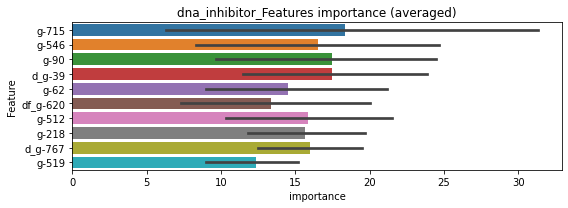

len(train_index) : 3444
len(valid_index) : 3444
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174535	valid_1's binary_logloss: 0.0910234
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.0052804	valid_1's binary_logloss: 0.0864848


len(train_index) : 3444
len(valid_index) : 3444
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175879	valid_1's binary_logloss: 0.0765156
[200]	training's binary_logloss: 0.00346237	valid_1's binary_logloss: 0.0709575
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00370169	valid_1's binary_logloss: 0.0706966


dna_inhibitor logloss: 0.07859072532311706


neg labels: 3289 → selected neg labels: 3267


dopamine_receptor_agonist, len(trt): 121, len(othr): 3267, target_rate: 0.0050810 → Adj_target_rate: 0.0049495
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685116	valid_1's binary_logloss: 0.179657
[200]	training's binary_logloss: 0.0187931	valid_1's binary_logloss: 0.138986
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00942056	valid_1's binary_logloss: 0.133515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0760231	valid_1's binary_logloss: 0.166968
[200]	training's binary_logloss: 0.0222906	valid_1's binary_logloss: 0.11838
[300]	training's binary_logloss: 0.00674856	valid_1's binary_logloss: 0.104037
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00545932	valid_1's binary_logloss: 0.102751


1 / 3 AUC score:0.974
y_Threshold: 0.0359180, Threshold: 0.0487494, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 221 → Positive_corect_labels: 608/3699
p_label_rate: 0.0200904 Vs.target_rate: 0.00508
Num_p_label: 80.0, conf_0:0.04387, conf_1:0.05362
Num_p_label: 80.0, Expected: 20.2, Adj_threshold_1: 0.0487494
Num_p_label: 48.0, Expected: 20.2, Adj_threshold_2: 0.0587494
Num_p_label: 31.0, Expected: 20.2, Adj_threshold_3: 0.0687494
threshold: 0.0687494, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 608.0/3699, y_label_rate: 0.1643687
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061266	valid_1's binary_logloss: 0.141769
[200]	training's binary_logloss: 0.0148088	valid_1's binary_logloss: 0.094201
[300]	training's binary_logloss: 0.00465354	valid_1's binary_logloss: 0.0843408
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00273153	valid_1's binary_logloss: 0.0811993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617028	valid_1's binary_logloss: 0.154424
[200]	training's binary_logloss: 0.0156013	valid_1's binary_logloss: 0.11458
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0123516	valid_1's binary_logloss: 0.112825


2 / 3 AUC score:0.984
y_Threshold: 0.0711032, Threshold: 0.0687494, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 84 → Positive_corect_labels: 566.0/3615
p_label_rate: 0.0153189 Vs.target_rate: 0.00508
Num_p_label: 61.0, conf_0:0.06187, conf_1:0.07562
Num_p_label: 61.0, Expected: 20.2, Adj_threshold_1: 0.0687494
Num_p_label: 46.0, Expected: 20.2, Adj_threshold_2: 0.0787494
Num_p_label: 31.0, Expected: 20.2, Adj_threshold_3: 0.0887494
threshold: 0.0887494, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 566.0/3615, y_label_rate: 0.1565698
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512572	valid_1's binary_logloss: 0.136271
[200]	training's binary_logloss: 0.0118655	valid_1's binary_logloss: 0.0967147
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00547986	valid_1's binary_logloss: 0.0925335
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0552011	valid_1's binary_logloss: 0.12941
[200]	training's binary_logloss: 0.0128704	valid_1's binary_logloss: 0.080529
[300]	training's binary_logloss: 0.00404768	valid_1's binary_logloss: 0.0687877
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00286559	valid_1's binary_logloss: 0.0667373


3 / 3 AUC score:0.994
y_Threshold: 0.0483058, Threshold: 0.0887494, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 64 → Positive_corect_labels: 534.0/3551
p_label_rate: 0.0072828 Vs.target_rate: 0.00508
Num_p_label: 29.0, conf_0:0.07987, conf_1:0.09762
threshold: 0.0887494, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 563.0/7533, y_label_rate: 0.0747378


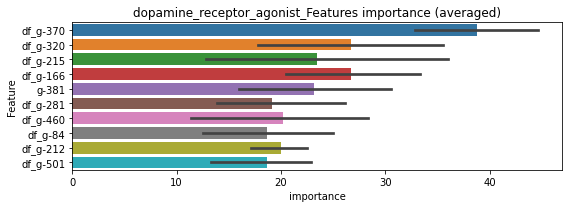

len(train_index) : 3766
len(valid_index) : 3767
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276694	valid_1's binary_logloss: 0.0888801
[200]	training's binary_logloss: 0.00617801	valid_1's binary_logloss: 0.0699458
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00410304	valid_1's binary_logloss: 0.0681455


len(train_index) : 3767
len(valid_index) : 3766
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297886	valid_1's binary_logloss: 0.0693721
[200]	training's binary_logloss: 0.00662854	valid_1's binary_logloss: 0.0467558
[300]	training's binary_logloss: 0.00202802	valid_1's binary_logloss: 0.0421829
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00183131	valid_1's binary_logloss: 0.0420029


dopamine_receptor_agonist logloss: 0.05507597293060011


neg labels: 3289 → selected neg labels: 3221


dopamine_receptor_antagonist, len(trt): 424, len(othr): 3221, target_rate: 0.0178047 → Adj_target_rate: 0.0143701
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121005	valid_1's binary_logloss: 0.376685
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.108505	valid_1's binary_logloss: 0.374692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12993	valid_1's binary_logloss: 0.361861
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0750693	valid_1's binary_logloss: 0.354267


1 / 3 AUC score:0.766
y_Threshold: 0.1464860, Threshold: 0.1969757, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 711 → Positive_corect_labels: 353/3154
p_label_rate: 0.0200904 Vs.target_rate: 0.01780
Num_p_label: 80.0, conf_0:0.17728, conf_1:0.21667
threshold: 0.1969757, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 353.0/3154, y_label_rate: 0.1119214
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0605396	valid_1's binary_logloss: 0.225914
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0301364	valid_1's binary_logloss: 0.219426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060711	valid_1's binary_logloss: 0.219848
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.0351364	valid_1's binary_logloss: 0.210138


2 / 3 AUC score:0.910
y_Threshold: 0.0938373, Threshold: 0.1969757, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 224 → Positive_corect_labels: 241.0/2930
p_label_rate: 0.0032647 Vs.target_rate: 0.01780
Num_p_label: 13.0, conf_0:0.17728, conf_1:0.21667
Num_p_label: 13.0, Expected: 70.9, Adj_threshold_1: 0.1969757
Num_p_label: 19.0, Expected: 70.9, Adj_threshold_2: 0.1869757
Num_p_label: 24.0, Expected: 70.9, Adj_threshold_3: 0.1769757
Num_p_label: 30.0, Expected: 70.9, Adj_threshold_4: 0.1669757
Num_p_label: 40.0, Expected: 70.9, Adj_threshold_5: 0.1569757
threshold: 0.1569757, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 241.0/2930, y_label_rate: 0.0822526
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343662	valid_1's binary_logloss: 0.1443
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.0126127	valid_1's binary_logloss: 0.135207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360752	valid_1's binary_logloss: 0.142317
[200]	training's binary_logloss: 0.0082372	valid_1's binary_logloss: 0.12774
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00813407	valid_1's binary_logloss: 0.127658


3 / 3 AUC score:0.979
y_Threshold: 0.0516604, Threshold: 0.1569757, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 100 → Positive_corect_labels: 191.0/2830
p_label_rate: 0.0032647 Vs.target_rate: 0.01780
Num_p_label: 13.0, conf_0:0.14128, conf_1:0.17267
Num_p_label: 13.0, Expected: 70.9, Adj_threshold_1: 0.1569757
Num_p_label: 14.0, Expected: 70.9, Adj_threshold_2: 0.1469757
Num_p_label: 18.0, Expected: 70.9, Adj_threshold_3: 0.1369757
Num_p_label: 22.0, Expected: 70.9, Adj_threshold_4: 0.1269757
Num_p_label: 27.0, Expected: 70.9, Adj_threshold_5: 0.1169757
Num_p_label: 35.0, Expected: 70.9, Adj_threshold_6: 0.1069757
Num_p_label: 50.0, Expected: 70.9, Adj_threshold_7: 0.0969757
threshold: 0.0969757, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 241.0/6812, y_label_rate: 0.0353787


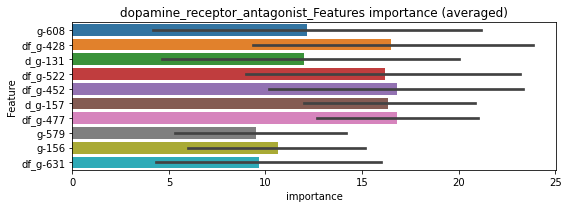

len(train_index) : 3406
len(valid_index) : 3406
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160911	valid_1's binary_logloss: 0.0829383
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.00812961	valid_1's binary_logloss: 0.0793972


len(train_index) : 3406
len(valid_index) : 3406
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172338	valid_1's binary_logloss: 0.0794365
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00781928	valid_1's binary_logloss: 0.074531


dopamine_receptor_antagonist logloss: 0.07696407643975463


neg labels: 3289 → selected neg labels: 3264


egfr_inhibitor, len(trt): 336, len(othr): 3264, target_rate: 0.0141093 → Adj_target_rate: 0.0117920
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0430506	valid_1's binary_logloss: 0.13368
[200]	training's binary_logloss: 0.00806187	valid_1's binary_logloss: 0.116289
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00817386	valid_1's binary_logloss: 0.116138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0457873	valid_1's binary_logloss: 0.112985
[200]	training's binary_logloss: 0.00883996	valid_1's binary_logloss: 0.0858188
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00507275	valid_1's binary_logloss: 0.0832573


1 / 3 AUC score:0.984
y_Threshold: 0.0340912, Threshold: 0.2616452, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 198 → Positive_corect_labels: 619/3718
p_label_rate: 0.0200904 Vs.target_rate: 0.01411
Num_p_label: 80.0, conf_0:0.23548, conf_1:0.28781
threshold: 0.2616452, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 619.0/3718, y_label_rate: 0.1664874
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0391866	valid_1's binary_logloss: 0.0726176
[200]	training's binary_logloss: 0.00659467	valid_1's binary_logloss: 0.0399607
[300]	training's binary_logloss: 0.00199162	valid_1's binary_logloss: 0.0328577
[400]	training's binary_logloss: 0.000986863	valid_1's binary_logloss: 0.0309686
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00102984	valid_1's binary_logloss: 0.0308599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347363	valid_1's binary_logloss: 0.104767
[200]	training's binary_logloss: 0.00556565	valid_1's binary_logloss: 0.0735415
[300]	training's binary_logloss: 0.00166893	valid_1's binary_logloss: 0.0672361
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00162672	valid_1's binary_logloss: 0.0670499


2 / 3 AUC score:0.997
y_Threshold: 0.0628113, Threshold: 0.2616452, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 596.0/3672
p_label_rate: 0.0261175 Vs.target_rate: 0.01411
Num_p_label: 104.0, conf_0:0.23548, conf_1:0.28781
threshold: 0.2616452, positive_p_label: 104.0/3982, p_label_rate: 0.0261175
positive_y_label: 596.0/3672, y_label_rate: 0.1623094
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327336	valid_1's binary_logloss: 0.0669718
[200]	training's binary_logloss: 0.00523662	valid_1's binary_logloss: 0.0367877
[300]	training's binary_logloss: 0.00157926	valid_1's binary_logloss: 0.0303663
[400]	training's binary_logloss: 0.000784599	valid_1's binary_logloss: 0.0280455
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000597784	valid_1's binary_logloss: 0.0272692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314867	valid_1's binary_logloss: 0.0952911
[200]	training's binary_logloss: 0.0048351	valid_1's binary_logloss: 0.073416
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00522541	valid_1's binary_logloss: 0.0731903


3 / 3 AUC score:0.997
y_Threshold: 0.0562267, Threshold: 0.2616452, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 576.0/3632
p_label_rate: 0.0266198 Vs.target_rate: 0.01411
Num_p_label: 106.0, conf_0:0.23548, conf_1:0.28781
threshold: 0.2616452, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 682.0/7614, y_label_rate: 0.0895718


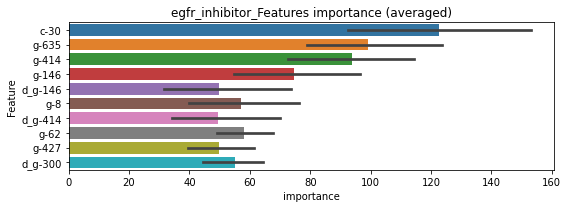

len(train_index) : 3807
len(valid_index) : 3807
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177592	valid_1's binary_logloss: 0.0526471
[200]	training's binary_logloss: 0.00267009	valid_1's binary_logloss: 0.0369399
[300]	training's binary_logloss: 0.000798958	valid_1's binary_logloss: 0.0345064
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000834528	valid_1's binary_logloss: 0.0344325


len(train_index) : 3807
len(valid_index) : 3807
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171096	valid_1's binary_logloss: 0.0609572
[200]	training's binary_logloss: 0.00256951	valid_1's binary_logloss: 0.0465317
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00146311	valid_1's binary_logloss: 0.0442743


egfr_inhibitor logloss: 0.03935337664842736


neg labels: 3289 → selected neg labels: 3287


elastase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188637	valid_1's binary_logloss: 0.0258633
[200]	training's binary_logloss: 0.0019468	valid_1's binary_logloss: 0.00699373
[300]	training's binary_logloss: 0.000551236	valid_1's binary_logloss: 0.00326846
[400]	training's binary_logloss: 0.000313046	valid_1's binary_logloss: 0.00239751
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00027596	valid_1's binary_logloss: 0.00222159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01894	valid_1's binary_logloss: 0.0224504
[200]	training's binary_logloss: 0.00195668	valid_1's binary_logloss: 0.0028683
[300]	training's binary_logloss: 0.000561428	valid_1's binary_logloss: 0.000919393
[400]	training's binary_logloss: 0.000315037	valid_1's binary_logloss: 0.000549169
[500]	training's binary_logloss: 0.000274454	valid_1's binary_logloss: 0.00048776
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0008863, Threshold: 0.0012313, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00111, conf_1:0.00135
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0012313
Num_p_label: 2.0, Expected: 2.0, Adj_threshold_2: 0.0112313
threshold: 0.0112313, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01925	valid_1's binary_logloss: 0.026366
[200]	training's binary_logloss: 0.00192683	valid_1's binary_logloss: 0.00723932
[300]	training's binary_logloss: 0.000549542	valid_1's binary_logloss: 0.0041879
[400]	training's binary_logloss: 0.000312996	valid_1's binary_logloss: 0.00329442
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000273162	valid_1's binary_logloss: 0.00314086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193838	valid_1's binary_logloss: 0.0224073
[200]	training's binary_logloss: 0.00193358	valid_1's binary_logloss: 0.00260565
[300]	training's binary_logloss: 0.000556625	valid_1's binary_logloss: 0.000825875
[400]	training's binary_logloss: 0.000314933	valid_1's binary_logloss: 0.000490981
[500]	training's binary_logloss: 0.000274734	valid_1's binary_logloss: 0.000435587
Early stopping, best iteration i

2 / 3 AUC score:1.000
y_Threshold: 0.0305363, Threshold: 0.0112313, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00050
Num_p_label: 5.0, conf_0:0.01011, conf_1:0.01235
threshold: 0.0112313, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01925	valid_1's binary_logloss: 0.026366
[200]	training's binary_logloss: 0.00192683	valid_1's binary_logloss: 0.00723932
[300]	training's binary_logloss: 0.000549542	valid_1's binary_logloss: 0.0041879
[400]	training's binary_logloss: 0.000312996	valid_1's binary_logloss: 0.00329442
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000273162	valid_1's binary_logloss: 0.00314086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193838	valid_1's binary_logloss: 0.0224073
[200]	training's binary_logloss: 0.00193358	valid_1's binary_logloss: 0.00260565
[300]	training's binary_logloss: 0.000556625	valid_1's binary_logloss: 0.000825875
[400]	training's binary_logloss: 0.000314933	valid_1's binary_logloss: 0.000490981
[500]	training's binary_logloss: 0.000274734	valid_1's binary_logloss: 0.000435587
Early stopping, best iteration i

3 / 3 AUC score:1.000
y_Threshold: 0.0305363, Threshold: 0.0112313, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00050
Num_p_label: 5.0, conf_0:0.01011, conf_1:0.01235
threshold: 0.0112313, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 662.0/7794, y_label_rate: 0.0849371


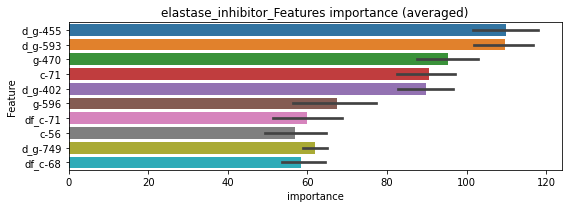

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102799	valid_1's binary_logloss: 0.015288
[200]	training's binary_logloss: 0.00101381	valid_1's binary_logloss: 0.00500604
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000345246	valid_1's binary_logloss: 0.00444376


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106028	valid_1's binary_logloss: 0.0153557
[200]	training's binary_logloss: 0.0010685	valid_1's binary_logloss: 0.0044737
[300]	training's binary_logloss: 0.000301477	valid_1's binary_logloss: 0.00269239
[400]	training's binary_logloss: 0.000167494	valid_1's binary_logloss: 0.00227027
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.0001498	valid_1's binary_logloss: 0.00220818


elastase_inhibitor logloss: 0.0033259720748232283


neg labels: 3289 → selected neg labels: 3284


erbb2_inhibitor, len(trt): 20, len(othr): 3284, target_rate: 0.0008398 → Adj_target_rate: 0.0010717
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025865	valid_1's binary_logloss: 0.0347878
[200]	training's binary_logloss: 0.00325983	valid_1's binary_logloss: 0.00592135
[300]	training's binary_logloss: 0.000912805	valid_1's binary_logloss: 0.00209257
[400]	training's binary_logloss: 0.000464726	valid_1's binary_logloss: 0.00121926
[500]	training's binary_logloss: 0.00036107	valid_1's binary_logloss: 0.00102138
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00035782	valid_1's binary_logloss: 0.00101769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257727	valid_1's binary_logloss: 0.0372906
[200]	training's binary_logloss: 0.0031884	valid_1's binary_logloss: 0.00818038
[300]	training's binary_logloss: 0.000900686	valid_1's binary_logloss: 0.00347014
[400]	training's binary_logloss: 0.000465628	valid_1's binary_logloss: 0.00224919
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0015416, Threshold: 0.0020489, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00084
Num_p_label: 80.0, conf_0:0.00184, conf_1:0.00225
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_1: 0.0020489
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_2: 0.0120489
threshold: 0.0120489, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255891	valid_1's binary_logloss: 0.0352581
[200]	training's binary_logloss: 0.00315429	valid_1's binary_logloss: 0.00604349
[300]	training's binary_logloss: 0.000890434	valid_1's binary_logloss: 0.00214824
[400]	training's binary_logloss: 0.000458264	valid_1's binary_logloss: 0.00129345
[500]	training's binary_logloss: 0.0003558	valid_1's binary_logloss: 0.0010751
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000351175	valid_1's binary_logloss: 0.00106742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025734	valid_1's binary_logloss: 0.0368012
[200]	training's binary_logloss: 0.00318933	valid_1's binary_logloss: 0.00786998
[300]	training's binary_logloss: 0.000905862	valid_1's binary_logloss: 0.00315477
[400]	training's binary_logloss: 0.000469056	valid_1's binary_logloss: 0.00203052
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1246212, Threshold: 0.0120489, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00084
Num_p_label: 9.0, conf_0:0.01084, conf_1:0.01325
threshold: 0.0120489, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0255891	valid_1's binary_logloss: 0.0352581
[200]	training's binary_logloss: 0.00315429	valid_1's binary_logloss: 0.00604349
[300]	training's binary_logloss: 0.000890434	valid_1's binary_logloss: 0.00214824
[400]	training's binary_logloss: 0.000458264	valid_1's binary_logloss: 0.00129345
[500]	training's binary_logloss: 0.0003558	valid_1's binary_logloss: 0.0010751
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000351175	valid_1's binary_logloss: 0.00106742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025734	valid_1's binary_logloss: 0.0368012
[200]	training's binary_logloss: 0.00318933	valid_1's binary_logloss: 0.00786998
[300]	training's binary_logloss: 0.000905862	valid_1's binary_logloss: 0.00315477
[400]	training's binary_logloss: 0.000469056	valid_1's binary_logloss: 0.00203052
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1246212, Threshold: 0.0120489, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00084
Num_p_label: 9.0, conf_0:0.01084, conf_1:0.01325
threshold: 0.0120489, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


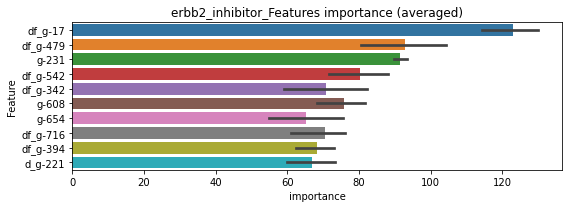

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138351	valid_1's binary_logloss: 0.0218712
[200]	training's binary_logloss: 0.00170537	valid_1's binary_logloss: 0.00905581
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00055677	valid_1's binary_logloss: 0.00829121


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146516	valid_1's binary_logloss: 0.0224863
[200]	training's binary_logloss: 0.00185028	valid_1's binary_logloss: 0.00652075
[300]	training's binary_logloss: 0.000522225	valid_1's binary_logloss: 0.00485083
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000417583	valid_1's binary_logloss: 0.00475587


erbb2_inhibitor logloss: 0.006523539437147768


neg labels: 3289 → selected neg labels: 3265


estrogen_receptor_agonist, len(trt): 158, len(othr): 3265, target_rate: 0.0066348 → Adj_target_rate: 0.0062095
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0810189	valid_1's binary_logloss: 0.200609
[200]	training's binary_logloss: 0.0240916	valid_1's binary_logloss: 0.155461
[300]	training's binary_logloss: 0.00807953	valid_1's binary_logloss: 0.142273
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00739962	valid_1's binary_logloss: 0.141672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796742	valid_1's binary_logloss: 0.186739
[200]	training's binary_logloss: 0.0229674	valid_1's binary_logloss: 0.13572
[300]	training's binary_logloss: 0.00781984	valid_1's binary_logloss: 0.122833
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00561528	valid_1's binary_logloss: 0.120756


1 / 3 AUC score:0.975
y_Threshold: 0.0382720, Threshold: 0.0581093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 243 → Positive_corect_labels: 597/3675
p_label_rate: 0.0200904 Vs.target_rate: 0.00663
Num_p_label: 80.0, conf_0:0.05230, conf_1:0.06392
Num_p_label: 80.0, Expected: 26.4, Adj_threshold_1: 0.0581093
Num_p_label: 52.0, Expected: 26.4, Adj_threshold_2: 0.0681093
threshold: 0.0681093, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 597.0/3675, y_label_rate: 0.1624490
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.069319	valid_1's binary_logloss: 0.188637
[200]	training's binary_logloss: 0.0174604	valid_1's binary_logloss: 0.145837
[300]	training's binary_logloss: 0.00533781	valid_1's binary_logloss: 0.138315
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00480616	valid_1's binary_logloss: 0.13803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681725	valid_1's binary_logloss: 0.169371
[200]	training's binary_logloss: 0.0177238	valid_1's binary_logloss: 0.122603
[300]	training's binary_logloss: 0.00537697	valid_1's binary_logloss: 0.111977
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00429887	valid_1's binary_logloss: 0.110818


2 / 3 AUC score:0.981
y_Threshold: 0.0628034, Threshold: 0.0681093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 104 → Positive_corect_labels: 545.0/3571
p_label_rate: 0.0210949 Vs.target_rate: 0.00663
Num_p_label: 84.0, conf_0:0.06130, conf_1:0.07492
Num_p_label: 84.0, Expected: 26.4, Adj_threshold_1: 0.0681093
Num_p_label: 63.0, Expected: 26.4, Adj_threshold_2: 0.0781093
Num_p_label: 51.0, Expected: 26.4, Adj_threshold_3: 0.0881093
threshold: 0.0881093, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 545.0/3571, y_label_rate: 0.1526183
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0584882	valid_1's binary_logloss: 0.14331
[200]	training's binary_logloss: 0.0141814	valid_1's binary_logloss: 0.10293
[300]	training's binary_logloss: 0.0044817	valid_1's binary_logloss: 0.0942731
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00480576	valid_1's binary_logloss: 0.0938991
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0603598	valid_1's binary_logloss: 0.156021
[200]	training's binary_logloss: 0.0142214	valid_1's binary_logloss: 0.111417
[300]	training's binary_logloss: 0.00440732	valid_1's binary_logloss: 0.0997148
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00376135	valid_1's binary_logloss: 0.0992382


3 / 3 AUC score:0.991
y_Threshold: 0.0604406, Threshold: 0.0881093, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 504.0/3489
p_label_rate: 0.0163235 Vs.target_rate: 0.00663
Num_p_label: 65.0, conf_0:0.07930, conf_1:0.09692
threshold: 0.0881093, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 569.0/7471, y_label_rate: 0.0761612


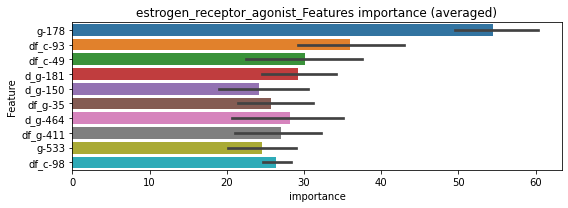

len(train_index) : 3735
len(valid_index) : 3736
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310696	valid_1's binary_logloss: 0.108712
[200]	training's binary_logloss: 0.00721915	valid_1's binary_logloss: 0.0891808
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0047348	valid_1's binary_logloss: 0.0874533


len(train_index) : 3736
len(valid_index) : 3735
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03397	valid_1's binary_logloss: 0.0957123
[200]	training's binary_logloss: 0.00830821	valid_1's binary_logloss: 0.0771259
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.00638984	valid_1's binary_logloss: 0.0764608


estrogen_receptor_agonist logloss: 0.0819577843417935


neg labels: 3289 → selected neg labels: 3283


estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450987	valid_1's binary_logloss: 0.0900584
[200]	training's binary_logloss: 0.00746644	valid_1's binary_logloss: 0.0438205
[300]	training's binary_logloss: 0.00207602	valid_1's binary_logloss: 0.0363079
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00207602	valid_1's binary_logloss: 0.0363079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466507	valid_1's binary_logloss: 0.0768668
[200]	training's binary_logloss: 0.00801983	valid_1's binary_logloss: 0.0242977
[300]	training's binary_logloss: 0.00225254	valid_1's binary_logloss: 0.0126236
[400]	training's binary_logloss: 0.00105786	valid_1's binary_logloss: 0.00947111
[500]	training's binary_logloss: 0.000654553	valid_1's binary_logloss: 0.00837158
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000541442	valid_1's binary_logloss: 0.00792891


1 / 3 AUC score:0.998
y_Threshold: 0.0090868, Threshold: 0.0112002, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01008, conf_1:0.01232
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0112002
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.0212002
Num_p_label: 10.0, Expected: 8.0, Adj_threshold_3: 0.0312002
threshold: 0.0312002, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 650.0/3795, y_label_rate: 0.1712780
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445484	valid_1's binary_logloss: 0.0771304
[200]	training's binary_logloss: 0.00786063	valid_1's binary_logloss: 0.0288823
[300]	training's binary_logloss: 0.00217166	valid_1's binary_logloss: 0.016974
[400]	training's binary_logloss: 0.00101303	valid_1's binary_logloss: 0.0133838
[500]	training's binary_logloss: 0.000636901	valid_1's binary_logloss: 0.0118326
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000618544	valid_1's binary_logloss: 0.0117097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416284	valid_1's binary_logloss: 0.0876522
[200]	training's binary_logloss: 0.00710979	valid_1's binary_logloss: 0.0380387
[300]	training's binary_logloss: 0.00199686	valid_1's binary_logloss: 0.0303702
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00114792	valid_1's binary_logloss: 0.0277873


2 / 3 AUC score:1.000
y_Threshold: 0.0342081, Threshold: 0.0312002, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 645.0/3785
p_label_rate: 0.0052737 Vs.target_rate: 0.00202
Num_p_label: 21.0, conf_0:0.02808, conf_1:0.03432
threshold: 0.0312002, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 645.0/3785, y_label_rate: 0.1704095
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426787	valid_1's binary_logloss: 0.0825219
[200]	training's binary_logloss: 0.00735477	valid_1's binary_logloss: 0.0330001
[300]	training's binary_logloss: 0.00206032	valid_1's binary_logloss: 0.0223016
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00105656	valid_1's binary_logloss: 0.0194287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428153	valid_1's binary_logloss: 0.0762958
[200]	training's binary_logloss: 0.00723197	valid_1's binary_logloss: 0.030492
[300]	training's binary_logloss: 0.00211719	valid_1's binary_logloss: 0.0202731
[400]	training's binary_logloss: 0.000999287	valid_1's binary_logloss: 0.0165193
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000897728	valid_1's binary_logloss: 0.0162967


3 / 3 AUC score:1.000
y_Threshold: 0.0480010, Threshold: 0.0312002, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 642.0/3779
p_label_rate: 0.0060271 Vs.target_rate: 0.00202
Num_p_label: 24.0, conf_0:0.02808, conf_1:0.03432
threshold: 0.0312002, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 666.0/7761, y_label_rate: 0.0858137


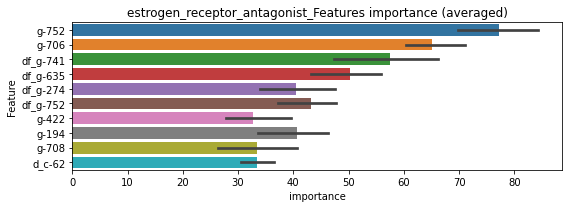

len(train_index) : 3880
len(valid_index) : 3881
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239286	valid_1's binary_logloss: 0.0538726
[200]	training's binary_logloss: 0.0039469	valid_1's binary_logloss: 0.0323532
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00125622	valid_1's binary_logloss: 0.0297795


len(train_index) : 3881
len(valid_index) : 3880
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266221	valid_1's binary_logloss: 0.0484435
[200]	training's binary_logloss: 0.00468278	valid_1's binary_logloss: 0.0218447
[300]	training's binary_logloss: 0.00129088	valid_1's binary_logloss: 0.0170268
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000898842	valid_1's binary_logloss: 0.0166422


estrogen_receptor_antagonist logloss: 0.023211698344186817


neg labels: 3289 → selected neg labels: 3283


faah_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335219	valid_1's binary_logloss: 0.0537739
[200]	training's binary_logloss: 0.00503817	valid_1's binary_logloss: 0.0150448
[300]	training's binary_logloss: 0.00140566	valid_1's binary_logloss: 0.00703079
[400]	training's binary_logloss: 0.000692553	valid_1's binary_logloss: 0.00461826
[500]	training's binary_logloss: 0.000466751	valid_1's binary_logloss: 0.00366099
[600]	training's binary_logloss: 0.000423165	valid_1's binary_logloss: 0.00348414
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.000424511	valid_1's binary_logloss: 0.00348338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033311	valid_1's binary_logloss: 0.0541322
[200]	training's binary_logloss: 0.0049854	valid_1's binary_logloss: 0.0166687
[300]	training's binary_logloss: 0.00137877	valid_1's binary_logloss: 0.00892746
[400]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0052848, Threshold: 0.0136746, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.01231, conf_1:0.01504
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0136746
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_2: 0.0236746
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.0336746
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.0436746
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_5: 0.0536746
threshold: 0.0536746, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316457	valid_1's binary_logloss: 0.0500187
[200]	training's binary_logloss: 0.00447741	valid_1's binary_logloss: 0.0123301
[300]	training's binary_logloss: 0.00128462	valid_1's binary_logloss: 0.0053412
[400]	training's binary_logloss: 0.0006466	valid_1's binary_logloss: 0.00343025
[500]	training's binary_logloss: 0.00044407	valid_1's binary_logloss: 0.00271981
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000409518	valid_1's binary_logloss: 0.00261943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311269	valid_1's binary_logloss: 0.0489852
[200]	training's binary_logloss: 0.00444372	valid_1's binary_logloss: 0.0133083
[300]	training's binary_logloss: 0.00125183	valid_1's binary_logloss: 0.00603616
[400]	training's binary_logloss: 0.00063523	valid_1's binary_logloss: 0.00426254
[500]	training's binary_logloss: 0.00043

2 / 3 AUC score:1.000
y_Threshold: 0.2241933, Threshold: 0.0536746, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0198393 Vs.target_rate: 0.00151
Num_p_label: 79.0, conf_0:0.04831, conf_1:0.05904
Num_p_label: 79.0, Expected: 6.0, Adj_threshold_1: 0.0536746
Num_p_label: 61.0, Expected: 6.0, Adj_threshold_2: 0.0636746
Num_p_label: 54.0, Expected: 6.0, Adj_threshold_3: 0.0736746
Num_p_label: 48.0, Expected: 6.0, Adj_threshold_4: 0.0836746
Num_p_label: 43.0, Expected: 6.0, Adj_threshold_5: 0.0936746
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_6: 0.1036746
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_7: 0.1136746
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_8: 0.1236746
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_9: 0.1336746
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_10: 0.1436746
threshold: 0.1536746, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316457	valid_1's binary_logloss: 0.0500187
[200]	training's binary_logloss: 0.00447741	valid_1's binary_logloss: 0.0123301
[300]	training's binary_logloss: 0.00128462	valid_1's binary_logloss: 0.0053412
[400]	training's binary_logloss: 0.0006466	valid_1's binary_logloss: 0.00343025
[500]	training's binary_logloss: 0.00044407	valid_1's binary_logloss: 0.00271981
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.000409518	valid_1's binary_logloss: 0.00261943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311269	valid_1's binary_logloss: 0.0489852
[200]	training's binary_logloss: 0.00444372	valid_1's binary_logloss: 0.0133083
[300]	training's binary_logloss: 0.00125183	valid_1's binary_logloss: 0.00603616
[400]	training's binary_logloss: 0.00063523	valid_1's binary_logloss: 0.00426254
[500]	training's binary_logloss: 0.00043

3 / 3 AUC score:1.000
y_Threshold: 0.2241933, Threshold: 0.1536746, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0067805 Vs.target_rate: 0.00151
Num_p_label: 27.0, conf_0:0.13831, conf_1:0.16904
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_1: 0.1536746
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_2: 0.1636746
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.1736746
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.1836746
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_5: 0.1936746
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.2036746
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.2136746
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_8: 0.2236746
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_9: 0.2336746
threshold: 0.2336746, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


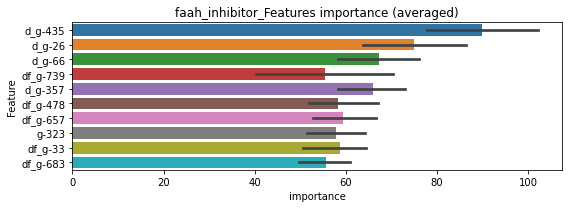

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183833	valid_1's binary_logloss: 0.0345311
[200]	training's binary_logloss: 0.00270415	valid_1's binary_logloss: 0.0160012
[300]	training's binary_logloss: 0.000716577	valid_1's binary_logloss: 0.0121789
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000422298	valid_1's binary_logloss: 0.0115906


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196761	valid_1's binary_logloss: 0.0305865
[200]	training's binary_logloss: 0.00298076	valid_1's binary_logloss: 0.00953018
[300]	training's binary_logloss: 0.000798723	valid_1's binary_logloss: 0.00524439
[400]	training's binary_logloss: 0.00037975	valid_1's binary_logloss: 0.00421689
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.000295325	valid_1's binary_logloss: 0.00396576


faah_inhibitor logloss: 0.00777865176409373


neg labels: 3289 → selected neg labels: 3286


farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179226	valid_1's binary_logloss: 0.0223598
[200]	training's binary_logloss: 0.00172175	valid_1's binary_logloss: 0.00334771
[300]	training's binary_logloss: 0.000470187	valid_1's binary_logloss: 0.00131777
[400]	training's binary_logloss: 0.000273486	valid_1's binary_logloss: 0.000903182
[500]	training's binary_logloss: 0.000230615	valid_1's binary_logloss: 0.000815625
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000226783	valid_1's binary_logloss: 0.000806109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179776	valid_1's binary_logloss: 0.0228401
[200]	training's binary_logloss: 0.00172299	valid_1's binary_logloss: 0.00420171
[300]	training's binary_logloss: 0.000470614	valid_1's binary_logloss: 0.00211504
[400]	training's binary_logloss: 0.00027273	valid_1's binary_logloss: 0.00170266
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0013200, Threshold: 0.0030199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00272, conf_1:0.00332
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0030199
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.0130199
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_3: 0.0230199
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.0330199
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.0430199
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_6: 0.0530199
threshold: 0.0530199, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179989	valid_1's binary_logloss: 0.021815
[200]	training's binary_logloss: 0.00163763	valid_1's binary_logloss: 0.00263877
[300]	training's binary_logloss: 0.000432328	valid_1's binary_logloss: 0.000880314
[400]	training's binary_logloss: 0.000254544	valid_1's binary_logloss: 0.000563497
[500]	training's binary_logloss: 0.000221322	valid_1's binary_logloss: 0.000509954
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000217845	valid_1's binary_logloss: 0.000504356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180097	valid_1's binary_logloss: 0.0214677
[200]	training's binary_logloss: 0.00169428	valid_1's binary_logloss: 0.00311895
[300]	training's binary_logloss: 0.000444214	valid_1's binary_logloss: 0.00124746
[400]	training's binary_logloss: 0.00025909	valid_1's binary_logloss: 0.000920554
Early stopping, best iterati

2 / 3 AUC score:1.000
y_Threshold: 0.1165895, Threshold: 0.0530199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0090407 Vs.target_rate: 0.00076
Num_p_label: 36.0, conf_0:0.04772, conf_1:0.05832
Num_p_label: 36.0, Expected: 3.0, Adj_threshold_1: 0.0530199
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_2: 0.0630199
Num_p_label: 31.0, Expected: 3.0, Adj_threshold_3: 0.0730199
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_4: 0.0830199
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_5: 0.0930199
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_6: 0.1030199
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_7: 0.1130199
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_8: 0.1230199
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_9: 0.1330199
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_10: 0.1430199
threshold: 0.1530199, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179989	valid_1's binary_logloss: 0.021815
[200]	training's binary_logloss: 0.00163763	valid_1's binary_logloss: 0.00263877
[300]	training's binary_logloss: 0.000432328	valid_1's binary_logloss: 0.000880314
[400]	training's binary_logloss: 0.000254544	valid_1's binary_logloss: 0.000563497
[500]	training's binary_logloss: 0.000221322	valid_1's binary_logloss: 0.000509954
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000217845	valid_1's binary_logloss: 0.000504356
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180097	valid_1's binary_logloss: 0.0214677
[200]	training's binary_logloss: 0.00169428	valid_1's binary_logloss: 0.00311895
[300]	training's binary_logloss: 0.000444214	valid_1's binary_logloss: 0.00124746
[400]	training's binary_logloss: 0.00025909	valid_1's binary_logloss: 0.000920554
Early stopping, best iterati

3 / 3 AUC score:1.000
y_Threshold: 0.1165895, Threshold: 0.1530199, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0055249 Vs.target_rate: 0.00076
Num_p_label: 22.0, conf_0:0.13772, conf_1:0.16832
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_1: 0.1530199
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.1630199
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_3: 0.1730199
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.1830199
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_5: 0.1930199
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_6: 0.2030199
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_7: 0.2130199
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_8: 0.2230199
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_9: 0.2330199
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_10: 0.2430199
threshold: 0.2530199, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 671.0/7793, y_label_rate: 0.0861029


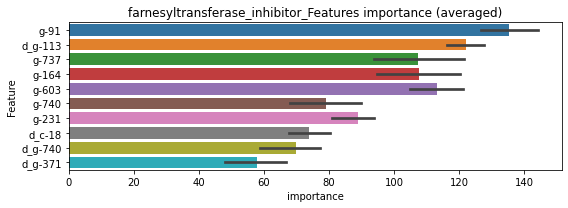

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101729	valid_1's binary_logloss: 0.0178964
[200]	training's binary_logloss: 0.000980472	valid_1's binary_logloss: 0.00682088
[300]	training's binary_logloss: 0.000258786	valid_1's binary_logloss: 0.00539819
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000226852	valid_1's binary_logloss: 0.00531235


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100624	valid_1's binary_logloss: 0.013286
[200]	training's binary_logloss: 0.00099037	valid_1's binary_logloss: 0.00366918
[300]	training's binary_logloss: 0.000270895	valid_1's binary_logloss: 0.00277804
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000191578	valid_1's binary_logloss: 0.00268552


farnesyltransferase_inhibitor logloss: 0.0039991026639328055


neg labels: 3289 → selected neg labels: 3285


fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282449	valid_1's binary_logloss: 0.0425648
[200]	training's binary_logloss: 0.00360178	valid_1's binary_logloss: 0.0082505
[300]	training's binary_logloss: 0.00101327	valid_1's binary_logloss: 0.00308256
[400]	training's binary_logloss: 0.000517177	valid_1's binary_logloss: 0.00190413
[500]	training's binary_logloss: 0.000378307	valid_1's binary_logloss: 0.00154517
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.000363127	valid_1's binary_logloss: 0.00150563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287303	valid_1's binary_logloss: 0.0392866
[200]	training's binary_logloss: 0.00383311	valid_1's binary_logloss: 0.00707659
[300]	training's binary_logloss: 0.00105132	valid_1's binary_logloss: 0.00241303
[400]	training's binary_logloss: 0.000528825	valid_1's binary_logloss: 0.00139484
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0022895, Threshold: 0.0037972, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00342, conf_1:0.00418
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0037972
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_2: 0.0137972
Num_p_label: 3.0, Expected: 4.2, Adj_threshold_3: 0.0237972
threshold: 0.0237972, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027281	valid_1's binary_logloss: 0.0400567
[200]	training's binary_logloss: 0.00348549	valid_1's binary_logloss: 0.00800393
[300]	training's binary_logloss: 0.000984699	valid_1's binary_logloss: 0.00295472
[400]	training's binary_logloss: 0.000501243	valid_1's binary_logloss: 0.00171752
[500]	training's binary_logloss: 0.000377052	valid_1's binary_logloss: 0.001429
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000358965	valid_1's binary_logloss: 0.00138958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277488	valid_1's binary_logloss: 0.036765
[200]	training's binary_logloss: 0.00358559	valid_1's binary_logloss: 0.00621896
[300]	training's binary_logloss: 0.00099851	valid_1's binary_logloss: 0.00205834
[400]	training's binary_logloss: 0.000501106	valid_1's binary_logloss: 0.00116185
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1620346, Threshold: 0.0237972, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0045203 Vs.target_rate: 0.00105
Num_p_label: 18.0, conf_0:0.02142, conf_1:0.02618
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_1: 0.0237972
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0337972
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_3: 0.0437972
threshold: 0.0437972, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027281	valid_1's binary_logloss: 0.0400567
[200]	training's binary_logloss: 0.00348549	valid_1's binary_logloss: 0.00800393
[300]	training's binary_logloss: 0.000984699	valid_1's binary_logloss: 0.00295472
[400]	training's binary_logloss: 0.000501243	valid_1's binary_logloss: 0.00171752
[500]	training's binary_logloss: 0.000377052	valid_1's binary_logloss: 0.001429
Early stopping, best iteration is:
[583]	training's binary_logloss: 0.000358965	valid_1's binary_logloss: 0.00138958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277488	valid_1's binary_logloss: 0.036765
[200]	training's binary_logloss: 0.00358559	valid_1's binary_logloss: 0.00621896
[300]	training's binary_logloss: 0.00099851	valid_1's binary_logloss: 0.00205834
[400]	training's binary_logloss: 0.000501106	valid_1's binary_logloss: 0.00116185
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1620346, Threshold: 0.0437972, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00105
Num_p_label: 7.0, conf_0:0.03942, conf_1:0.04818
threshold: 0.0437972, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


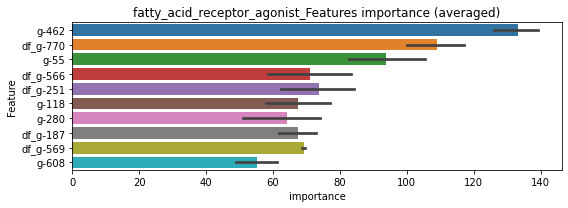

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152352	valid_1's binary_logloss: 0.0281885
[200]	training's binary_logloss: 0.0019501	valid_1's binary_logloss: 0.01004
[300]	training's binary_logloss: 0.000529752	valid_1's binary_logloss: 0.00730478
[400]	training's binary_logloss: 0.000263238	valid_1's binary_logloss: 0.00699579
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000246539	valid_1's binary_logloss: 0.00696887


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161209	valid_1's binary_logloss: 0.0237099
[200]	training's binary_logloss: 0.00205776	valid_1's binary_logloss: 0.00599714
[300]	training's binary_logloss: 0.000560176	valid_1's binary_logloss: 0.00353318
[400]	training's binary_logloss: 0.000273091	valid_1's binary_logloss: 0.00303782
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000237784	valid_1's binary_logloss: 0.00294373


fatty_acid_receptor_agonist logloss: 0.004956299867701145


neg labels: 3289 → selected neg labels: 3279


fgfr_inhibitor, len(trt): 50, len(othr): 3279, target_rate: 0.0020996 → Adj_target_rate: 0.0023352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348885	valid_1's binary_logloss: 0.0702139
[200]	training's binary_logloss: 0.00533007	valid_1's binary_logloss: 0.0347561
[300]	training's binary_logloss: 0.00154129	valid_1's binary_logloss: 0.0299411
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00147238	valid_1's binary_logloss: 0.0297881
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0350188	valid_1's binary_logloss: 0.0626476
[200]	training's binary_logloss: 0.00533025	valid_1's binary_logloss: 0.0236349
[300]	training's binary_logloss: 0.0015745	valid_1's binary_logloss: 0.0143096
[400]	training's binary_logloss: 0.000805549	valid_1's binary_logloss: 0.0116229
[500]	training's binary_logloss: 0.000530996	valid_1's binary_logloss: 0.0102748
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.000472582	valid_1's binary_logloss: 0.00988898


1 / 3 AUC score:0.999
y_Threshold: 0.0085195, Threshold: 0.0210479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 650/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00210
Num_p_label: 80.0, conf_0:0.01894, conf_1:0.02315
Num_p_label: 80.0, Expected: 8.4, Adj_threshold_1: 0.0210479
Num_p_label: 61.0, Expected: 8.4, Adj_threshold_2: 0.0310479
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_3: 0.0410479
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_4: 0.0510479
Num_p_label: 39.0, Expected: 8.4, Adj_threshold_5: 0.0610479
Num_p_label: 36.0, Expected: 8.4, Adj_threshold_6: 0.0710479
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_7: 0.0810479
Num_p_label: 28.0, Expected: 8.4, Adj_threshold_8: 0.0910479
Num_p_label: 27.0, Expected: 8.4, Adj_threshold_9: 0.1010479
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_10: 0.1110479
threshold: 0.1210479, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332398	valid_1's binary_logloss: 0.0596862
[200]	training's binary_logloss: 0.00482285	valid_1's binary_logloss: 0.0191157
[300]	training's binary_logloss: 0.00136413	valid_1's binary_logloss: 0.0108651
[400]	training's binary_logloss: 0.000676019	valid_1's binary_logloss: 0.0085654
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000486743	valid_1's binary_logloss: 0.00785501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330722	valid_1's binary_logloss: 0.0491953
[200]	training's binary_logloss: 0.00483193	valid_1's binary_logloss: 0.0140365
[300]	training's binary_logloss: 0.00139386	valid_1's binary_logloss: 0.00779199
[400]	training's binary_logloss: 0.00068774	valid_1's binary_logloss: 0.00587403
[500]	training's binary_logloss: 0.000477826	valid_1's binary_logloss: 0.00525844
Early stopping, best iteration is:
[53

2 / 3 AUC score:1.000
y_Threshold: 0.1474726, Threshold: 0.1210479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 649.0/3790
p_label_rate: 0.0160723 Vs.target_rate: 0.00210
Num_p_label: 64.0, conf_0:0.10894, conf_1:0.13315
Num_p_label: 64.0, Expected: 8.4, Adj_threshold_1: 0.1210479
Num_p_label: 61.0, Expected: 8.4, Adj_threshold_2: 0.1310479
Num_p_label: 60.0, Expected: 8.4, Adj_threshold_3: 0.1410479
Num_p_label: 56.0, Expected: 8.4, Adj_threshold_4: 0.1510479
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_5: 0.1610479
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_6: 0.1710479
Num_p_label: 53.0, Expected: 8.4, Adj_threshold_7: 0.1810479
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_8: 0.1910479
Num_p_label: 49.0, Expected: 8.4, Adj_threshold_9: 0.2010479
Num_p_label: 48.0, Expected: 8.4, Adj_threshold_10: 0.2110479
threshold: 0.2210479, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031679	valid_1's binary_logloss: 0.0603649
[200]	training's binary_logloss: 0.00456676	valid_1's binary_logloss: 0.0251218
[300]	training's binary_logloss: 0.00132144	valid_1's binary_logloss: 0.0185796
[400]	training's binary_logloss: 0.000659151	valid_1's binary_logloss: 0.0165611
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000576935	valid_1's binary_logloss: 0.0163389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318138	valid_1's binary_logloss: 0.0571468
[200]	training's binary_logloss: 0.00464732	valid_1's binary_logloss: 0.0208711
[300]	training's binary_logloss: 0.00135379	valid_1's binary_logloss: 0.0147574
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000769019	valid_1's binary_logloss: 0.0130839


3 / 3 AUC score:1.000
y_Threshold: 0.0822660, Threshold: 0.2210479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 643.0/3778
p_label_rate: 0.0128076 Vs.target_rate: 0.00210
Num_p_label: 51.0, conf_0:0.19894, conf_1:0.24315
Num_p_label: 51.0, Expected: 8.4, Adj_threshold_1: 0.2210479
Num_p_label: 50.0, Expected: 8.4, Adj_threshold_2: 0.2310479
Num_p_label: 49.0, Expected: 8.4, Adj_threshold_3: 0.2410479
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_4: 0.2510479
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_5: 0.2610479
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_6: 0.2710479
Num_p_label: 47.0, Expected: 8.4, Adj_threshold_7: 0.2810479
Num_p_label: 46.0, Expected: 8.4, Adj_threshold_8: 0.2910479
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_9: 0.3010479
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_10: 0.3110479
threshold: 0.3210479, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 687.0/7760, y_label_rate: 0.0885309


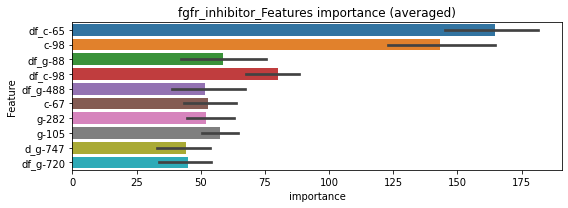

len(train_index) : 3880
len(valid_index) : 3880
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185408	valid_1's binary_logloss: 0.0407857
[200]	training's binary_logloss: 0.00281185	valid_1's binary_logloss: 0.0202825
[300]	training's binary_logloss: 0.00077058	valid_1's binary_logloss: 0.0162139
[400]	training's binary_logloss: 0.000372069	valid_1's binary_logloss: 0.0151836
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000309873	valid_1's binary_logloss: 0.0150086


len(train_index) : 3880
len(valid_index) : 3880
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173623	valid_1's binary_logloss: 0.0373854
[200]	training's binary_logloss: 0.00263262	valid_1's binary_logloss: 0.018974
[300]	training's binary_logloss: 0.000767291	valid_1's binary_logloss: 0.0152813
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000585705	valid_1's binary_logloss: 0.0150556


fgfr_inhibitor logloss: 0.015032076493940618


neg labels: 3289 → selected neg labels: 3272


flt3_inhibitor, len(trt): 279, len(othr): 3272, target_rate: 0.0117158 → Adj_target_rate: 0.0100684
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518227	valid_1's binary_logloss: 0.140013
[200]	training's binary_logloss: 0.0106735	valid_1's binary_logloss: 0.114967
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00727189	valid_1's binary_logloss: 0.113507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0486197	valid_1's binary_logloss: 0.139918
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0133804	valid_1's binary_logloss: 0.120461


1 / 3 AUC score:0.974
y_Threshold: 0.0721756, Threshold: 0.2413875, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 242 → Positive_corect_labels: 599/3684
p_label_rate: 0.0200904 Vs.target_rate: 0.01172
Num_p_label: 80.0, conf_0:0.21725, conf_1:0.26553
threshold: 0.2413875, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 599.0/3684, y_label_rate: 0.1625950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367554	valid_1's binary_logloss: 0.0925532
[200]	training's binary_logloss: 0.00650493	valid_1's binary_logloss: 0.0658367
[300]	training's binary_logloss: 0.00232731	valid_1's binary_logloss: 0.0628412
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00215975	valid_1's binary_logloss: 0.062704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036041	valid_1's binary_logloss: 0.0849751
[200]	training's binary_logloss: 0.0062003	valid_1's binary_logloss: 0.0552571
[300]	training's binary_logloss: 0.0019434	valid_1's binary_logloss: 0.0507886
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00185093	valid_1's binary_logloss: 0.050491


2 / 3 AUC score:0.994
y_Threshold: 0.1260943, Threshold: 0.2413875, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 573.0/3632
p_label_rate: 0.0376695 Vs.target_rate: 0.01172
Num_p_label: 150.0, conf_0:0.21725, conf_1:0.26553
Num_p_label: 150.0, Expected: 46.7, Adj_threshold_1: 0.2413875
Num_p_label: 147.0, Expected: 46.7, Adj_threshold_2: 0.2513875
Num_p_label: 144.0, Expected: 46.7, Adj_threshold_3: 0.2613875
Num_p_label: 140.0, Expected: 46.7, Adj_threshold_4: 0.2713875
Num_p_label: 139.0, Expected: 46.7, Adj_threshold_5: 0.2813875
Num_p_label: 135.0, Expected: 46.7, Adj_threshold_6: 0.2913875
Num_p_label: 132.0, Expected: 46.7, Adj_threshold_7: 0.3013875
Num_p_label: 132.0, Expected: 46.7, Adj_threshold_8: 0.3113875
Num_p_label: 128.0, Expected: 46.7, Adj_threshold_9: 0.3213875
Num_p_label: 126.0, Expected: 46.7, Adj_threshold_10: 0.3313875
threshold: 0.3413875, positive_p_label: 122.0/3982, p_label_rate: 0.0306379
positive_y_label: 573.0/3632, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322539	valid_1's binary_logloss: 0.0759564
[200]	training's binary_logloss: 0.00531472	valid_1's binary_logloss: 0.0523483
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00356008	valid_1's binary_logloss: 0.0504826
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323305	valid_1's binary_logloss: 0.0674354
[200]	training's binary_logloss: 0.00547338	valid_1's binary_logloss: 0.0375795
[300]	training's binary_logloss: 0.00166806	valid_1's binary_logloss: 0.0310287
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00108997	valid_1's binary_logloss: 0.0300975


3 / 3 AUC score:0.997
y_Threshold: 0.1270504, Threshold: 0.3413875, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 557.0/3600
p_label_rate: 0.0334003 Vs.target_rate: 0.01172
Num_p_label: 133.0, conf_0:0.30725, conf_1:0.37553
threshold: 0.3413875, positive_p_label: 133.0/3982, p_label_rate: 0.0334003
positive_y_label: 690.0/7582, y_label_rate: 0.0910050


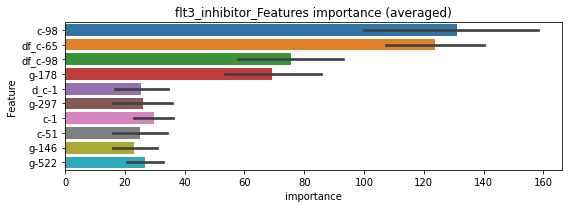

len(train_index) : 3791
len(valid_index) : 3791
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191801	valid_1's binary_logloss: 0.0494598
[200]	training's binary_logloss: 0.00323358	valid_1's binary_logloss: 0.0324896
[300]	training's binary_logloss: 0.00096158	valid_1's binary_logloss: 0.0288949
[400]	training's binary_logloss: 0.000467921	valid_1's binary_logloss: 0.0276105
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000408253	valid_1's binary_logloss: 0.0273453


len(train_index) : 3791
len(valid_index) : 3791
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199525	valid_1's binary_logloss: 0.0471922
[200]	training's binary_logloss: 0.00348396	valid_1's binary_logloss: 0.0295646
[300]	training's binary_logloss: 0.00106254	valid_1's binary_logloss: 0.024561
[400]	training's binary_logloss: 0.000514133	valid_1's binary_logloss: 0.0228269
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000469016	valid_1's binary_logloss: 0.0225956


flt3_inhibitor logloss: 0.024970443172124504


neg labels: 3289 → selected neg labels: 3286


focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179283	valid_1's binary_logloss: 0.0219543
[200]	training's binary_logloss: 0.00171715	valid_1's binary_logloss: 0.00434993
[300]	training's binary_logloss: 0.000456038	valid_1's binary_logloss: 0.00289266
[400]	training's binary_logloss: 0.000263458	valid_1's binary_logloss: 0.00266521
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000233091	valid_1's binary_logloss: 0.00260057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181286	valid_1's binary_logloss: 0.0230887
[200]	training's binary_logloss: 0.001754	valid_1's binary_logloss: 0.00360129
[300]	training's binary_logloss: 0.000474321	valid_1's binary_logloss: 0.00141722
[400]	training's binary_logloss: 0.00027245	valid_1's binary_logloss: 0.000960157
[500]	training's binary_logloss: 0.000232289	valid_1's binary_logloss: 0.000867069
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0009432, Threshold: 0.0028348, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00255, conf_1:0.00312
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0028348
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_2: 0.0128348
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_3: 0.0228348
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_4: 0.0328348
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_5: 0.0428348
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_6: 0.0528348
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_7: 0.0628348
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_8: 0.0728348
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.0828348
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.0928348
threshold: 0.1028348, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176297	valid_1's binary_logloss: 0.0204759
[200]	training's binary_logloss: 0.00159211	valid_1's binary_logloss: 0.00246092
[300]	training's binary_logloss: 0.000411654	valid_1's binary_logloss: 0.00079874
[400]	training's binary_logloss: 0.0002441	valid_1's binary_logloss: 0.000507367
[500]	training's binary_logloss: 0.000215328	valid_1's binary_logloss: 0.000455774
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000212147	valid_1's binary_logloss: 0.000448976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174864	valid_1's binary_logloss: 0.0212697
[200]	training's binary_logloss: 0.00158209	valid_1's binary_logloss: 0.00256895
[300]	training's binary_logloss: 0.000413515	valid_1's binary_logloss: 0.000823206
[400]	training's binary_logloss: 0.00024112	valid_1's binary_logloss: 0.000528417
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.2451594, Threshold: 0.1028348, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0085384 Vs.target_rate: 0.00076
Num_p_label: 34.0, conf_0:0.09255, conf_1:0.11312
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_1: 0.1028348
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_2: 0.1128348
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_3: 0.1228348
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_4: 0.1328348
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_5: 0.1428348
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_6: 0.1528348
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_7: 0.1628348
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_8: 0.1728348
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_9: 0.1828348
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_10: 0.1928348
threshold: 0.2028348, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176297	valid_1's binary_logloss: 0.0204759
[200]	training's binary_logloss: 0.00159211	valid_1's binary_logloss: 0.00246092
[300]	training's binary_logloss: 0.000411654	valid_1's binary_logloss: 0.00079874
[400]	training's binary_logloss: 0.0002441	valid_1's binary_logloss: 0.000507367
[500]	training's binary_logloss: 0.000215328	valid_1's binary_logloss: 0.000455774
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.000212147	valid_1's binary_logloss: 0.000448976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174864	valid_1's binary_logloss: 0.0212697
[200]	training's binary_logloss: 0.00158209	valid_1's binary_logloss: 0.00256895
[300]	training's binary_logloss: 0.000413515	valid_1's binary_logloss: 0.000823206
[400]	training's binary_logloss: 0.00024112	valid_1's binary_logloss: 0.000528417
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.2451594, Threshold: 0.2028348, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0062783 Vs.target_rate: 0.00076
Num_p_label: 25.0, conf_0:0.18255, conf_1:0.22312
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.2028348
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.2128348
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.2228348
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_4: 0.2328348
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_5: 0.2428348
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_6: 0.2528348
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_7: 0.2628348
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_8: 0.2728348
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_9: 0.2828348
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_10: 0.2928348
threshold: 0.3028348, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 679.0/7793, y_label_rate: 0.0871295


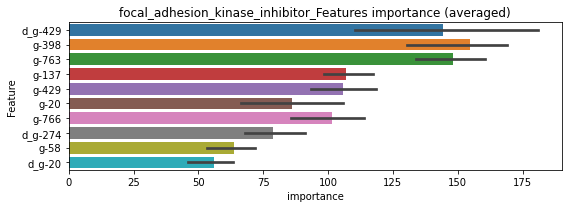

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0102949	valid_1's binary_logloss: 0.0137139
[200]	training's binary_logloss: 0.00102054	valid_1's binary_logloss: 0.00395093
[300]	training's binary_logloss: 0.000268156	valid_1's binary_logloss: 0.00293475
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000224195	valid_1's binary_logloss: 0.00290424


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101568	valid_1's binary_logloss: 0.0149331
[200]	training's binary_logloss: 0.0010162	valid_1's binary_logloss: 0.00510392
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.000372488	valid_1's binary_logloss: 0.00458075


focal_adhesion_kinase_inhibitor logloss: 0.0037423868552357745


neg labels: 3289 → selected neg labels: 3286


free_radical_scavenger, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224953	valid_1's binary_logloss: 0.0297585
[200]	training's binary_logloss: 0.00258533	valid_1's binary_logloss: 0.00490624
[300]	training's binary_logloss: 0.000744777	valid_1's binary_logloss: 0.00177322
[400]	training's binary_logloss: 0.000402362	valid_1's binary_logloss: 0.00110735
[500]	training's binary_logloss: 0.000321115	valid_1's binary_logloss: 0.000964285
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.000314755	valid_1's binary_logloss: 0.000955268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226893	valid_1's binary_logloss: 0.0310553
[200]	training's binary_logloss: 0.00260864	valid_1's binary_logloss: 0.00651484
[300]	training's binary_logloss: 0.000733659	valid_1's binary_logloss: 0.00296323
[400]	training's binary_logloss: 0.0003955	valid_1's binary_logloss: 0.0021451
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0013061, Threshold: 0.0018491, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00166, conf_1:0.00203
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0018491
Num_p_label: 1.0, Expected: 3.0, Adj_threshold_2: 0.0118491
threshold: 0.0118491, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227219	valid_1's binary_logloss: 0.0293225
[200]	training's binary_logloss: 0.00254101	valid_1's binary_logloss: 0.00441685
[300]	training's binary_logloss: 0.000727251	valid_1's binary_logloss: 0.0015526
[400]	training's binary_logloss: 0.000394777	valid_1's binary_logloss: 0.000931147
[500]	training's binary_logloss: 0.000319215	valid_1's binary_logloss: 0.000801392
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000309659	valid_1's binary_logloss: 0.000786103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228806	valid_1's binary_logloss: 0.0309053
[200]	training's binary_logloss: 0.00259556	valid_1's binary_logloss: 0.00696814
[300]	training's binary_logloss: 0.000736835	valid_1's binary_logloss: 0.00336654
[400]	training's binary_logloss: 0.000396168	valid_1's binary_logloss: 0.00251306
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.0469339, Threshold: 0.0118491, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.01066, conf_1:0.01303
threshold: 0.0118491, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227219	valid_1's binary_logloss: 0.0293225
[200]	training's binary_logloss: 0.00254101	valid_1's binary_logloss: 0.00441685
[300]	training's binary_logloss: 0.000727251	valid_1's binary_logloss: 0.0015526
[400]	training's binary_logloss: 0.000394777	valid_1's binary_logloss: 0.000931147
[500]	training's binary_logloss: 0.000319215	valid_1's binary_logloss: 0.000801392
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.000309659	valid_1's binary_logloss: 0.000786103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228806	valid_1's binary_logloss: 0.0309053
[200]	training's binary_logloss: 0.00259556	valid_1's binary_logloss: 0.00696814
[300]	training's binary_logloss: 0.000736835	valid_1's binary_logloss: 0.00336654
[400]	training's binary_logloss: 0.000396168	valid_1's binary_logloss: 0.00251306
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0469339, Threshold: 0.0118491, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.01066, conf_1:0.01303
threshold: 0.0118491, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


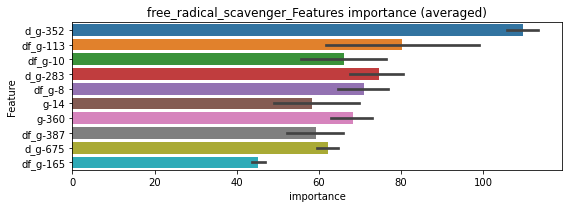

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123537	valid_1's binary_logloss: 0.0229437
[200]	training's binary_logloss: 0.00137618	valid_1's binary_logloss: 0.00811195
Early stopping, best iteration is:
[272]	training's binary_logloss: 0.000499836	valid_1's binary_logloss: 0.00719106


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128435	valid_1's binary_logloss: 0.0169645
[200]	training's binary_logloss: 0.00146511	valid_1's binary_logloss: 0.00412629
[300]	training's binary_logloss: 0.000407763	valid_1's binary_logloss: 0.00271625
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000268223	valid_1's binary_logloss: 0.00250293


free_radical_scavenger logloss: 0.0048472932786596595


neg labels: 3289 → selected neg labels: 3285


fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3285, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253827	valid_1's binary_logloss: 0.0428603
[200]	training's binary_logloss: 0.0031424	valid_1's binary_logloss: 0.0113618
[300]	training's binary_logloss: 0.000893695	valid_1's binary_logloss: 0.00603049
[400]	training's binary_logloss: 0.000465556	valid_1's binary_logloss: 0.00469575
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000383313	valid_1's binary_logloss: 0.00444156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257518	valid_1's binary_logloss: 0.0335428
[200]	training's binary_logloss: 0.00318587	valid_1's binary_logloss: 0.00534696
[300]	training's binary_logloss: 0.000898799	valid_1's binary_logloss: 0.00181076
[400]	training's binary_logloss: 0.000474628	valid_1's binary_logloss: 0.00106406
[500]	training's binary_logloss: 0.000351986	valid_1's binary_logloss: 0.000839323
Early stopping, best iteration i

1 / 3 AUC score:1.000
y_Threshold: 0.0016151, Threshold: 0.0024952, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00097
Num_p_label: 80.0, conf_0:0.00225, conf_1:0.00274
Num_p_label: 80.0, Expected: 3.8, Adj_threshold_1: 0.0024952
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_2: 0.0124952
Num_p_label: 4.0, Expected: 3.8, Adj_threshold_3: 0.0224952
threshold: 0.0224952, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257914	valid_1's binary_logloss: 0.0408926
[200]	training's binary_logloss: 0.0031146	valid_1's binary_logloss: 0.010577
[300]	training's binary_logloss: 0.000880912	valid_1's binary_logloss: 0.00568559
[400]	training's binary_logloss: 0.000461686	valid_1's binary_logloss: 0.00441615
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000451856	valid_1's binary_logloss: 0.00438354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026204	valid_1's binary_logloss: 0.0332833
[200]	training's binary_logloss: 0.00323076	valid_1's binary_logloss: 0.00493847
[300]	training's binary_logloss: 0.000908842	valid_1's binary_logloss: 0.00156301
[400]	training's binary_logloss: 0.000469835	valid_1's binary_logloss: 0.000870595
[500]	training's binary_logloss: 0.000355542	valid_1's binary_logloss: 0.000693447
Early stopping, best iteration is

2 / 3 AUC score:1.000
y_Threshold: 0.0355644, Threshold: 0.0224952, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00097
Num_p_label: 9.0, conf_0:0.02025, conf_1:0.02474
threshold: 0.0224952, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257914	valid_1's binary_logloss: 0.0408926
[200]	training's binary_logloss: 0.0031146	valid_1's binary_logloss: 0.010577
[300]	training's binary_logloss: 0.000880912	valid_1's binary_logloss: 0.00568559
[400]	training's binary_logloss: 0.000461686	valid_1's binary_logloss: 0.00441615
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000451856	valid_1's binary_logloss: 0.00438354
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026204	valid_1's binary_logloss: 0.0332833
[200]	training's binary_logloss: 0.00323076	valid_1's binary_logloss: 0.00493847
[300]	training's binary_logloss: 0.000908842	valid_1's binary_logloss: 0.00156301
[400]	training's binary_logloss: 0.000469835	valid_1's binary_logloss: 0.000870595
[500]	training's binary_logloss: 0.000355542	valid_1's binary_logloss: 0.000693447
Early stopping, best iteration is

3 / 3 AUC score:1.000
y_Threshold: 0.0355644, Threshold: 0.0224952, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00097
Num_p_label: 9.0, conf_0:0.02025, conf_1:0.02474
threshold: 0.0224952, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7792, y_label_rate: 0.0854723


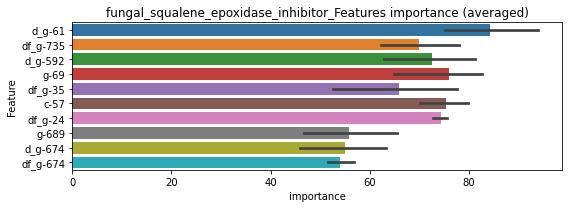

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143015	valid_1's binary_logloss: 0.0244897
[200]	training's binary_logloss: 0.00176944	valid_1's binary_logloss: 0.0094144
[300]	training's binary_logloss: 0.000477968	valid_1's binary_logloss: 0.00800524
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000384593	valid_1's binary_logloss: 0.00794215


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144716	valid_1's binary_logloss: 0.0255214
[200]	training's binary_logloss: 0.00176924	valid_1's binary_logloss: 0.0102888
[300]	training's binary_logloss: 0.000485091	valid_1's binary_logloss: 0.00785856
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000338913	valid_1's binary_logloss: 0.00749118


fungal_squalene_epoxidase_inhibitor logloss: 0.007716662569111679


neg labels: 3289 → selected neg labels: 3272


gaba_receptor_agonist, len(trt): 106, len(othr): 3272, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685557	valid_1's binary_logloss: 0.163008
[200]	training's binary_logloss: 0.0169205	valid_1's binary_logloss: 0.109079
[300]	training's binary_logloss: 0.00518592	valid_1's binary_logloss: 0.0948747
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00351714	valid_1's binary_logloss: 0.0929027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0710735	valid_1's binary_logloss: 0.154428
[200]	training's binary_logloss: 0.0178469	valid_1's binary_logloss: 0.0982184
[300]	training's binary_logloss: 0.00544122	valid_1's binary_logloss: 0.0857544
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00470825	valid_1's binary_logloss: 0.0842986


1 / 3 AUC score:0.986
y_Threshold: 0.0237969, Threshold: 0.0336799, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 190 → Positive_corect_labels: 625/3736
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.03031, conf_1:0.03705
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0336799
Num_p_label: 37.0, Expected: 17.7, Adj_threshold_2: 0.0436799
Num_p_label: 18.0, Expected: 17.7, Adj_threshold_3: 0.0536799
threshold: 0.0536799, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 625.0/3736, y_label_rate: 0.1672912
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0666219	valid_1's binary_logloss: 0.142895
[200]	training's binary_logloss: 0.0142469	valid_1's binary_logloss: 0.0815613
[300]	training's binary_logloss: 0.004265	valid_1's binary_logloss: 0.0662352
[400]	training's binary_logloss: 0.00191041	valid_1's binary_logloss: 0.0614908
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00187504	valid_1's binary_logloss: 0.0613736
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646185	valid_1's binary_logloss: 0.139881
[200]	training's binary_logloss: 0.0151687	valid_1's binary_logloss: 0.0876736
[300]	training's binary_logloss: 0.00456701	valid_1's binary_logloss: 0.0731872
[400]	training's binary_logloss: 0.001992	valid_1's binary_logloss: 0.0688094
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00212572	valid_1's binary_logloss: 0.0685323


2 / 3 AUC score:0.993
y_Threshold: 0.0426597, Threshold: 0.0536799, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 610.0/3706
p_label_rate: 0.0067805 Vs.target_rate: 0.00445
Num_p_label: 27.0, conf_0:0.04831, conf_1:0.05905
threshold: 0.0536799, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 610.0/3706, y_label_rate: 0.1645979
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623344	valid_1's binary_logloss: 0.145381
[200]	training's binary_logloss: 0.0136259	valid_1's binary_logloss: 0.0869441
[300]	training's binary_logloss: 0.0040468	valid_1's binary_logloss: 0.0718131
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00207829	valid_1's binary_logloss: 0.0671328
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612434	valid_1's binary_logloss: 0.141261
[200]	training's binary_logloss: 0.0133843	valid_1's binary_logloss: 0.0942663
[300]	training's binary_logloss: 0.00399476	valid_1's binary_logloss: 0.0839557
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00290193	valid_1's binary_logloss: 0.0831319


3 / 3 AUC score:0.990
y_Threshold: 0.0350024, Threshold: 0.0536799, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 58 → Positive_corect_labels: 581.0/3648
p_label_rate: 0.0087896 Vs.target_rate: 0.00445
Num_p_label: 35.0, conf_0:0.04831, conf_1:0.05905
threshold: 0.0536799, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 616.0/7630, y_label_rate: 0.0807339


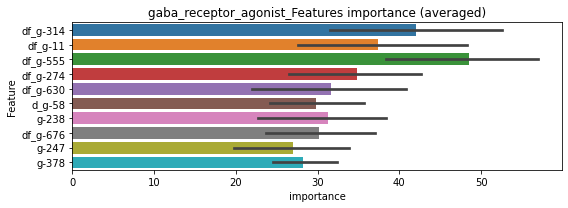

len(train_index) : 3815
len(valid_index) : 3815
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326082	valid_1's binary_logloss: 0.0800058
[200]	training's binary_logloss: 0.00734429	valid_1's binary_logloss: 0.0528255
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00269114	valid_1's binary_logloss: 0.04825


len(train_index) : 3815
len(valid_index) : 3815
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337993	valid_1's binary_logloss: 0.085979
[200]	training's binary_logloss: 0.00744896	valid_1's binary_logloss: 0.0586399
[300]	training's binary_logloss: 0.00218536	valid_1's binary_logloss: 0.0523845
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00205754	valid_1's binary_logloss: 0.0521452


gaba_receptor_agonist logloss: 0.050197616198345965


neg labels: 3289 → selected neg labels: 3263


gaba_receptor_antagonist, len(trt): 165, len(othr): 3263, target_rate: 0.0069287 → Adj_target_rate: 0.0064426
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889696	valid_1's binary_logloss: 0.225699
[200]	training's binary_logloss: 0.0275595	valid_1's binary_logloss: 0.188192
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.012455	valid_1's binary_logloss: 0.180772
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963486	valid_1's binary_logloss: 0.214056
[200]	training's binary_logloss: 0.0302982	valid_1's binary_logloss: 0.156409
[300]	training's binary_logloss: 0.0101228	valid_1's binary_logloss: 0.137295
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00739615	valid_1's binary_logloss: 0.136217


1 / 3 AUC score:0.956
y_Threshold: 0.0523450, Threshold: 0.0739041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 297 → Positive_corect_labels: 569/3618
p_label_rate: 0.0200904 Vs.target_rate: 0.00693
Num_p_label: 80.0, conf_0:0.06651, conf_1:0.08129
threshold: 0.0739041, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 569.0/3618, y_label_rate: 0.1572692
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715748	valid_1's binary_logloss: 0.19046
[200]	training's binary_logloss: 0.0184712	valid_1's binary_logloss: 0.141759
[300]	training's binary_logloss: 0.00594414	valid_1's binary_logloss: 0.132761
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.004116	valid_1's binary_logloss: 0.13133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761884	valid_1's binary_logloss: 0.19465
[200]	training's binary_logloss: 0.0201958	valid_1's binary_logloss: 0.154044
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.011185	valid_1's binary_logloss: 0.149669


2 / 3 AUC score:0.971
y_Threshold: 0.0717599, Threshold: 0.0739041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 498.0/3476
p_label_rate: 0.0281266 Vs.target_rate: 0.00693
Num_p_label: 112.0, conf_0:0.06651, conf_1:0.08129
Num_p_label: 112.0, Expected: 27.6, Adj_threshold_1: 0.0739041
Num_p_label: 83.0, Expected: 27.6, Adj_threshold_2: 0.0839041
Num_p_label: 59.0, Expected: 27.6, Adj_threshold_3: 0.0939041
Num_p_label: 46.0, Expected: 27.6, Adj_threshold_4: 0.1039041
threshold: 0.1039041, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 498.0/3476, y_label_rate: 0.1432681
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.060812	valid_1's binary_logloss: 0.147372
[200]	training's binary_logloss: 0.0137279	valid_1's binary_logloss: 0.101782
[300]	training's binary_logloss: 0.00432838	valid_1's binary_logloss: 0.0958545
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00399372	valid_1's binary_logloss: 0.0952166
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646006	valid_1's binary_logloss: 0.141166
[200]	training's binary_logloss: 0.0152467	valid_1's binary_logloss: 0.0903464
[300]	training's binary_logloss: 0.00476945	valid_1's binary_logloss: 0.0776122
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.0024293	valid_1's binary_logloss: 0.0735201


3 / 3 AUC score:0.990
y_Threshold: 0.0563415, Threshold: 0.1039041, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 467.0/3414
p_label_rate: 0.0047715 Vs.target_rate: 0.00693
Num_p_label: 19.0, conf_0:0.09351, conf_1:0.11429
threshold: 0.1039041, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 486.0/7396, y_label_rate: 0.0657112


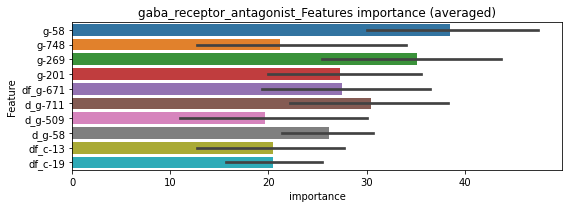

len(train_index) : 3698
len(valid_index) : 3698
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305035	valid_1's binary_logloss: 0.0876957
[200]	training's binary_logloss: 0.00723725	valid_1's binary_logloss: 0.0671765
[300]	training's binary_logloss: 0.00215842	valid_1's binary_logloss: 0.0624544
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00225405	valid_1's binary_logloss: 0.0623474


len(train_index) : 3698
len(valid_index) : 3698
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315413	valid_1's binary_logloss: 0.0876898
[200]	training's binary_logloss: 0.00734583	valid_1's binary_logloss: 0.0650493
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00264852	valid_1's binary_logloss: 0.0614369


gaba_receptor_antagonist logloss: 0.06189215619817819


neg labels: 3289 → selected neg labels: 3279


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3279, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317554	valid_1's binary_logloss: 0.0639041
[200]	training's binary_logloss: 0.00479754	valid_1's binary_logloss: 0.0312048
[300]	training's binary_logloss: 0.00143434	valid_1's binary_logloss: 0.0244278
[400]	training's binary_logloss: 0.00071607	valid_1's binary_logloss: 0.0221122
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.000688688	valid_1's binary_logloss: 0.0220558
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312089	valid_1's binary_logloss: 0.0597444
[200]	training's binary_logloss: 0.00464528	valid_1's binary_logloss: 0.0232851
[300]	training's binary_logloss: 0.00138347	valid_1's binary_logloss: 0.0158062
[400]	training's binary_logloss: 0.000698946	valid_1's binary_logloss: 0.0135588
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000717781	valid_1's binary_logloss: 0.0134877


1 / 3 AUC score:0.999
y_Threshold: 0.0051065, Threshold: 0.0071170, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.00641, conf_1:0.00783
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0071170
Num_p_label: 25.0, Expected: 9.4, Adj_threshold_2: 0.0171170
Num_p_label: 12.0, Expected: 9.4, Adj_threshold_3: 0.0271170
threshold: 0.0271170, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307858	valid_1's binary_logloss: 0.0580919
[200]	training's binary_logloss: 0.00454466	valid_1's binary_logloss: 0.0203993
[300]	training's binary_logloss: 0.00132269	valid_1's binary_logloss: 0.0119897
[400]	training's binary_logloss: 0.000660986	valid_1's binary_logloss: 0.00938437
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000546901	valid_1's binary_logloss: 0.00899017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317282	valid_1's binary_logloss: 0.0565337
[200]	training's binary_logloss: 0.00462711	valid_1's binary_logloss: 0.0216088
[300]	training's binary_logloss: 0.00133558	valid_1's binary_logloss: 0.0147653
[400]	training's binary_logloss: 0.000670788	valid_1's binary_logloss: 0.0123858
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000603426	valid_1's binary_logloss: 0.0120765


2 / 3 AUC score:1.000
y_Threshold: 0.0449489, Threshold: 0.0271170, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0095429 Vs.target_rate: 0.00235
Num_p_label: 38.0, conf_0:0.02441, conf_1:0.02983
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_1: 0.0271170
Num_p_label: 27.0, Expected: 9.4, Adj_threshold_2: 0.0371170
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_3: 0.0471170
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_4: 0.0571170
threshold: 0.0571170, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307858	valid_1's binary_logloss: 0.0580919
[200]	training's binary_logloss: 0.00454466	valid_1's binary_logloss: 0.0203993
[300]	training's binary_logloss: 0.00132269	valid_1's binary_logloss: 0.0119897
[400]	training's binary_logloss: 0.000660986	valid_1's binary_logloss: 0.00938437
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000546901	valid_1's binary_logloss: 0.00899017
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317282	valid_1's binary_logloss: 0.0565337
[200]	training's binary_logloss: 0.00462711	valid_1's binary_logloss: 0.0216088
[300]	training's binary_logloss: 0.00133558	valid_1's binary_logloss: 0.0147653
[400]	training's binary_logloss: 0.000670788	valid_1's binary_logloss: 0.0123858
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000603426	valid_1's binary_logloss: 0.0120765


3 / 3 AUC score:1.000
y_Threshold: 0.0449489, Threshold: 0.0571170, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3796
p_label_rate: 0.0042692 Vs.target_rate: 0.00235
Num_p_label: 17.0, conf_0:0.05141, conf_1:0.06283
threshold: 0.0571170, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 669.0/7778, y_label_rate: 0.0860118


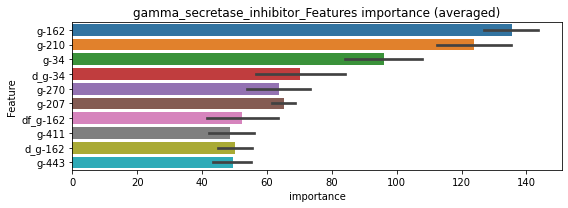

len(train_index) : 3889
len(valid_index) : 3889
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156254	valid_1's binary_logloss: 0.04069
[200]	training's binary_logloss: 0.00223589	valid_1's binary_logloss: 0.0231295
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00111861	valid_1's binary_logloss: 0.0207904


len(train_index) : 3889
len(valid_index) : 3889
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165379	valid_1's binary_logloss: 0.0381645
[200]	training's binary_logloss: 0.00243056	valid_1's binary_logloss: 0.0230259
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00102706	valid_1's binary_logloss: 0.0209278


gamma_secretase_inhibitor logloss: 0.02085909131817895


neg labels: 3289 → selected neg labels: 3253


glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3253, target_rate: 0.0111699 → Adj_target_rate: 0.0096682
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299984	valid_1's binary_logloss: 0.0683108
[200]	training's binary_logloss: 0.00450797	valid_1's binary_logloss: 0.0539581
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00516276	valid_1's binary_logloss: 0.0535523
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319487	valid_1's binary_logloss: 0.0637694
[200]	training's binary_logloss: 0.00506437	valid_1's binary_logloss: 0.040818
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00248341	valid_1's binary_logloss: 0.0378356


1 / 3 AUC score:0.993
y_Threshold: 0.0106703, Threshold: 0.0302285, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 153 → Positive_corect_labels: 639/3750
p_label_rate: 0.0200904 Vs.target_rate: 0.01117
Num_p_label: 80.0, conf_0:0.02721, conf_1:0.03325
threshold: 0.0302285, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 639.0/3750, y_label_rate: 0.1704000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257822	valid_1's binary_logloss: 0.0458484
[200]	training's binary_logloss: 0.00335411	valid_1's binary_logloss: 0.0206357
[300]	training's binary_logloss: 0.000966019	valid_1's binary_logloss: 0.015492
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000583249	valid_1's binary_logloss: 0.0144788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244654	valid_1's binary_logloss: 0.046166
[200]	training's binary_logloss: 0.00309978	valid_1's binary_logloss: 0.0289699
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0021017	valid_1's binary_logloss: 0.0281307


2 / 3 AUC score:0.998
y_Threshold: 0.0262955, Threshold: 0.0302285, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 632.0/3736
p_label_rate: 0.0291311 Vs.target_rate: 0.01117
Num_p_label: 116.0, conf_0:0.02721, conf_1:0.03325
threshold: 0.0302285, positive_p_label: 116.0/3982, p_label_rate: 0.0291311
positive_y_label: 632.0/3736, y_label_rate: 0.1691649
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246423	valid_1's binary_logloss: 0.0356518
[200]	training's binary_logloss: 0.00299642	valid_1's binary_logloss: 0.01336
[300]	training's binary_logloss: 0.000803312	valid_1's binary_logloss: 0.0104224
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000817689	valid_1's binary_logloss: 0.0104135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222398	valid_1's binary_logloss: 0.0486873
[200]	training's binary_logloss: 0.0025631	valid_1's binary_logloss: 0.0352886
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00261107	valid_1's binary_logloss: 0.0352446


3 / 3 AUC score:0.997
y_Threshold: 0.0248677, Threshold: 0.0302285, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 623.0/3718
p_label_rate: 0.0293822 Vs.target_rate: 0.01117
Num_p_label: 117.0, conf_0:0.02721, conf_1:0.03325
threshold: 0.0302285, positive_p_label: 117.0/3982, p_label_rate: 0.0293822
positive_y_label: 740.0/7700, y_label_rate: 0.0961039


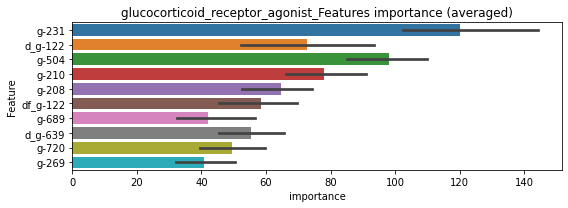

len(train_index) : 3850
len(valid_index) : 3850
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015609	valid_1's binary_logloss: 0.0444243
[200]	training's binary_logloss: 0.00206194	valid_1's binary_logloss: 0.0353984
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.00220816	valid_1's binary_logloss: 0.0353652


len(train_index) : 3850
len(valid_index) : 3850
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167528	valid_1's binary_logloss: 0.0377696
[200]	training's binary_logloss: 0.00228163	valid_1's binary_logloss: 0.0260941
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00100687	valid_1's binary_logloss: 0.0247993


glucocorticoid_receptor_agonist logloss: 0.03008224405179241


neg labels: 3289 → selected neg labels: 3287


glutamate_inhibitor, len(trt): 13, len(othr): 3287, target_rate: 0.0005459 → Adj_target_rate: 0.0007431
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187584	valid_1's binary_logloss: 0.0252126
[200]	training's binary_logloss: 0.00192218	valid_1's binary_logloss: 0.0049271
[300]	training's binary_logloss: 0.000541864	valid_1's binary_logloss: 0.00221473
[400]	training's binary_logloss: 0.000309711	valid_1's binary_logloss: 0.00157389
[500]	training's binary_logloss: 0.000263605	valid_1's binary_logloss: 0.00145988
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00025957	valid_1's binary_logloss: 0.00144346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191794	valid_1's binary_logloss: 0.0234265
[200]	training's binary_logloss: 0.00196514	valid_1's binary_logloss: 0.00303925
[300]	training's binary_logloss: 0.000550579	valid_1's binary_logloss: 0.00100138
[400]	training's binary_logloss: 0.000308292	valid_1's binary_logloss: 0.000584417
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0009850, Threshold: 0.0015413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00055
Num_p_label: 80.0, conf_0:0.00139, conf_1:0.00170
Num_p_label: 80.0, Expected: 2.2, Adj_threshold_1: 0.0015413
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_2: 0.0115413
Num_p_label: 0.0, Expected: 2.2, Adj_threshold_3: 0.0215413
threshold: 0.0215413, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190059	valid_1's binary_logloss: 0.0246868
[200]	training's binary_logloss: 0.00191923	valid_1's binary_logloss: 0.00397748
[300]	training's binary_logloss: 0.000542156	valid_1's binary_logloss: 0.00157651
[400]	training's binary_logloss: 0.000306264	valid_1's binary_logloss: 0.00108792
[500]	training's binary_logloss: 0.00026346	valid_1's binary_logloss: 0.00101629
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000258908	valid_1's binary_logloss: 0.00100733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189304	valid_1's binary_logloss: 0.0228459
[200]	training's binary_logloss: 0.00190322	valid_1's binary_logloss: 0.00293741
[300]	training's binary_logloss: 0.000539457	valid_1's binary_logloss: 0.000939487
[400]	training's binary_logloss: 0.000308091	valid_1's binary_logloss: 0.000569819
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1108698, Threshold: 0.0215413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00055
Num_p_label: 15.0, conf_0:0.01939, conf_1:0.02370
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_1: 0.0215413
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_2: 0.0315413
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_3: 0.0415413
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_4: 0.0515413
threshold: 0.0515413, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190059	valid_1's binary_logloss: 0.0246868
[200]	training's binary_logloss: 0.00191923	valid_1's binary_logloss: 0.00397748
[300]	training's binary_logloss: 0.000542156	valid_1's binary_logloss: 0.00157651
[400]	training's binary_logloss: 0.000306264	valid_1's binary_logloss: 0.00108792
[500]	training's binary_logloss: 0.00026346	valid_1's binary_logloss: 0.00101629
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000258908	valid_1's binary_logloss: 0.00100733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189304	valid_1's binary_logloss: 0.0228459
[200]	training's binary_logloss: 0.00190322	valid_1's binary_logloss: 0.00293741
[300]	training's binary_logloss: 0.000539457	valid_1's binary_logloss: 0.000939487
[400]	training's binary_logloss: 0.000308091	valid_1's binary_logloss: 0.000569819
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1108698, Threshold: 0.0515413, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00055
Num_p_label: 4.0, conf_0:0.04639, conf_1:0.05670
threshold: 0.0515413, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


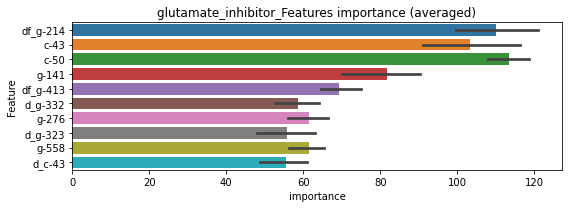

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00988519	valid_1's binary_logloss: 0.0154251
[200]	training's binary_logloss: 0.000972443	valid_1's binary_logloss: 0.00581378
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000336122	valid_1's binary_logloss: 0.00513771


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103469	valid_1's binary_logloss: 0.0128846
[200]	training's binary_logloss: 0.00108074	valid_1's binary_logloss: 0.0023521
[300]	training's binary_logloss: 0.000288306	valid_1's binary_logloss: 0.00135694
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00022479	valid_1's binary_logloss: 0.00128558


glutamate_inhibitor logloss: 0.0032116404563380524


neg labels: 3289 → selected neg labels: 3277


glutamate_receptor_agonist, len(trt): 74, len(othr): 3277, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583224	valid_1's binary_logloss: 0.12916
[200]	training's binary_logloss: 0.0126141	valid_1's binary_logloss: 0.0771435
[300]	training's binary_logloss: 0.00363502	valid_1's binary_logloss: 0.0601395
[400]	training's binary_logloss: 0.0015897	valid_1's binary_logloss: 0.0542491
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.0016302	valid_1's binary_logloss: 0.0540134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0615522	valid_1's binary_logloss: 0.121702
[200]	training's binary_logloss: 0.0141139	valid_1's binary_logloss: 0.0642696
[300]	training's binary_logloss: 0.00395066	valid_1's binary_logloss: 0.0477152
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00206466	valid_1's binary_logloss: 0.0457274


1 / 3 AUC score:0.996
y_Threshold: 0.0172643, Threshold: 0.0240065, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 640/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.02161, conf_1:0.02641
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0240065
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_2: 0.0340065
Num_p_label: 14.0, Expected: 12.4, Adj_threshold_3: 0.0440065
threshold: 0.0440065, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 640.0/3770, y_label_rate: 0.1697613
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0568973	valid_1's binary_logloss: 0.12703
[200]	training's binary_logloss: 0.0118909	valid_1's binary_logloss: 0.0720441
[300]	training's binary_logloss: 0.00340561	valid_1's binary_logloss: 0.0552806
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00183659	valid_1's binary_logloss: 0.0503797
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0617405	valid_1's binary_logloss: 0.111611
[200]	training's binary_logloss: 0.01349	valid_1's binary_logloss: 0.0534868
[300]	training's binary_logloss: 0.00381957	valid_1's binary_logloss: 0.0373376
[400]	training's binary_logloss: 0.00165331	valid_1's binary_logloss: 0.0327428
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00161266	valid_1's binary_logloss: 0.0326613


2 / 3 AUC score:0.999
y_Threshold: 0.0537253, Threshold: 0.0440065, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 629.0/3748
p_label_rate: 0.0125565 Vs.target_rate: 0.00311
Num_p_label: 50.0, conf_0:0.03961, conf_1:0.04841
Num_p_label: 50.0, Expected: 12.4, Adj_threshold_1: 0.0440065
Num_p_label: 30.0, Expected: 12.4, Adj_threshold_2: 0.0540065
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_3: 0.0640065
threshold: 0.0640065, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 629.0/3748, y_label_rate: 0.1678228
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0563498	valid_1's binary_logloss: 0.113457
[200]	training's binary_logloss: 0.0114825	valid_1's binary_logloss: 0.0562814
[300]	training's binary_logloss: 0.00327875	valid_1's binary_logloss: 0.0424952
[400]	training's binary_logloss: 0.0014663	valid_1's binary_logloss: 0.0387169
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.00144775	valid_1's binary_logloss: 0.0386861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569846	valid_1's binary_logloss: 0.118681
[200]	training's binary_logloss: 0.0115848	valid_1's binary_logloss: 0.067147
[300]	training's binary_logloss: 0.00333559	valid_1's binary_logloss: 0.0547844
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0024641	valid_1's binary_logloss: 0.053369


3 / 3 AUC score:0.995
y_Threshold: 0.0407168, Threshold: 0.0640065, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 616.0/3722
p_label_rate: 0.0055249 Vs.target_rate: 0.00311
Num_p_label: 22.0, conf_0:0.05761, conf_1:0.07041
threshold: 0.0640065, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 638.0/7704, y_label_rate: 0.0828141


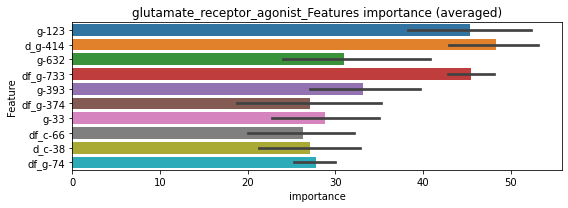

len(train_index) : 3852
len(valid_index) : 3852
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032598	valid_1's binary_logloss: 0.0719256
[200]	training's binary_logloss: 0.00696253	valid_1's binary_logloss: 0.0430639
[300]	training's binary_logloss: 0.00200045	valid_1's binary_logloss: 0.0367703
[400]	training's binary_logloss: 0.00085018	valid_1's binary_logloss: 0.0347699
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00090909	valid_1's binary_logloss: 0.0345922


len(train_index) : 3852
len(valid_index) : 3852
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328265	valid_1's binary_logloss: 0.0712324
[200]	training's binary_logloss: 0.00701169	valid_1's binary_logloss: 0.0376607
[300]	training's binary_logloss: 0.00197022	valid_1's binary_logloss: 0.0298685
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00184838	valid_1's binary_logloss: 0.0296385


glutamate_receptor_agonist logloss: 0.03211533908286445


neg labels: 3289 → selected neg labels: 3226


glutamate_receptor_antagonist, len(trt): 367, len(othr): 3226, target_rate: 0.0154111 → Adj_target_rate: 0.0127105
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129868	valid_1's binary_logloss: 0.36035
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0566	valid_1's binary_logloss: 0.349334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127176	valid_1's binary_logloss: 0.344193
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0550955	valid_1's binary_logloss: 0.327352


1 / 3 AUC score:0.788
y_Threshold: 0.1241796, Threshold: 0.1721140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 678 → Positive_corect_labels: 371/3193
p_label_rate: 0.0200904 Vs.target_rate: 0.01541
Num_p_label: 80.0, conf_0:0.15490, conf_1:0.18933
threshold: 0.1721140, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 371.0/3193, y_label_rate: 0.1161917
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0628757	valid_1's binary_logloss: 0.211952
[200]	training's binary_logloss: 0.0176639	valid_1's binary_logloss: 0.184142
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0131303	valid_1's binary_logloss: 0.182209
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0692709	valid_1's binary_logloss: 0.200837
[200]	training's binary_logloss: 0.0190999	valid_1's binary_logloss: 0.172794
Early stopping, best iteration is:
[229]	training's binary_logloss: 0.0138543	valid_1's binary_logloss: 0.168627


2 / 3 AUC score:0.942
y_Threshold: 0.0741117, Threshold: 0.1721140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 290.0/3031
p_label_rate: 0.0042692 Vs.target_rate: 0.01541
Num_p_label: 17.0, conf_0:0.15490, conf_1:0.18933
Num_p_label: 17.0, Expected: 61.4, Adj_threshold_1: 0.1721140
Num_p_label: 20.0, Expected: 61.4, Adj_threshold_2: 0.1621140
Num_p_label: 24.0, Expected: 61.4, Adj_threshold_3: 0.1521140
Num_p_label: 36.0, Expected: 61.4, Adj_threshold_4: 0.1421140
threshold: 0.1421140, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 290.0/3031, y_label_rate: 0.0956780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478571	valid_1's binary_logloss: 0.163865
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.0235191	valid_1's binary_logloss: 0.147946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440839	valid_1's binary_logloss: 0.166285
[200]	training's binary_logloss: 0.0107742	valid_1's binary_logloss: 0.15127
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00981233	valid_1's binary_logloss: 0.150588


3 / 3 AUC score:0.951
y_Threshold: 0.0788471, Threshold: 0.1421140, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 128 → Positive_corect_labels: 226.0/2903
p_label_rate: 0.0105475 Vs.target_rate: 0.01541
Num_p_label: 42.0, conf_0:0.12790, conf_1:0.15633
threshold: 0.1421140, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 268.0/6885, y_label_rate: 0.0389252


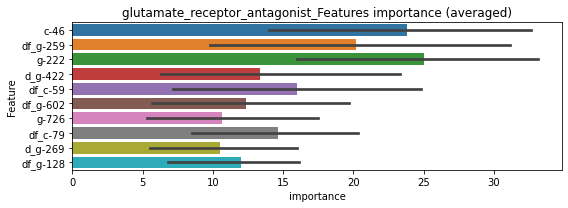

len(train_index) : 3442
len(valid_index) : 3443
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182939	valid_1's binary_logloss: 0.0871993
Early stopping, best iteration is:
[149]	training's binary_logloss: 0.00889242	valid_1's binary_logloss: 0.0820971


len(train_index) : 3443
len(valid_index) : 3442
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187086	valid_1's binary_logloss: 0.0833271
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.00903595	valid_1's binary_logloss: 0.077092


glutamate_receptor_antagonist logloss: 0.0795949074374655


neg labels: 3289 → selected neg labels: 3286


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022143	valid_1's binary_logloss: 0.0290349
[200]	training's binary_logloss: 0.00253993	valid_1's binary_logloss: 0.00467136
[300]	training's binary_logloss: 0.000720708	valid_1's binary_logloss: 0.00169689
[400]	training's binary_logloss: 0.000386161	valid_1's binary_logloss: 0.00102357
[500]	training's binary_logloss: 0.000313964	valid_1's binary_logloss: 0.000877003
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.000310599	valid_1's binary_logloss: 0.000872387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225313	valid_1's binary_logloss: 0.030436
[200]	training's binary_logloss: 0.00261032	valid_1's binary_logloss: 0.00543312
[300]	training's binary_logloss: 0.000741067	valid_1's binary_logloss: 0.00243652
[400]	training's binary_logloss: 0.000397831	valid_1's binary_logloss: 0.00173207
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0016233, Threshold: 0.0032245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00290, conf_1:0.00355
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0032245
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.0132245
threshold: 0.0132245, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221408	valid_1's binary_logloss: 0.0289012
[200]	training's binary_logloss: 0.00245827	valid_1's binary_logloss: 0.00455271
[300]	training's binary_logloss: 0.000708595	valid_1's binary_logloss: 0.00161254
[400]	training's binary_logloss: 0.000382277	valid_1's binary_logloss: 0.00096988
[500]	training's binary_logloss: 0.000314659	valid_1's binary_logloss: 0.000835323
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000310166	valid_1's binary_logloss: 0.000828808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222573	valid_1's binary_logloss: 0.0280467
[200]	training's binary_logloss: 0.00249528	valid_1's binary_logloss: 0.00402322
[300]	training's binary_logloss: 0.000704674	valid_1's binary_logloss: 0.00140855
[400]	training's binary_logloss: 0.000384275	valid_1's binary_logloss: 0.000897445
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1520129, Threshold: 0.0132245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0067805 Vs.target_rate: 0.00076
Num_p_label: 27.0, conf_0:0.01190, conf_1:0.01455
Num_p_label: 27.0, Expected: 3.0, Adj_threshold_1: 0.0132245
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0232245
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.0332245
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.0432245
threshold: 0.0432245, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221408	valid_1's binary_logloss: 0.0289012
[200]	training's binary_logloss: 0.00245827	valid_1's binary_logloss: 0.00455271
[300]	training's binary_logloss: 0.000708595	valid_1's binary_logloss: 0.00161254
[400]	training's binary_logloss: 0.000382277	valid_1's binary_logloss: 0.00096988
[500]	training's binary_logloss: 0.000314659	valid_1's binary_logloss: 0.000835323
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.000310166	valid_1's binary_logloss: 0.000828808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222573	valid_1's binary_logloss: 0.0280467
[200]	training's binary_logloss: 0.00249528	valid_1's binary_logloss: 0.00402322
[300]	training's binary_logloss: 0.000704674	valid_1's binary_logloss: 0.00140855
[400]	training's binary_logloss: 0.000384275	valid_1's binary_logloss: 0.000897445
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1520129, Threshold: 0.0432245, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.03890, conf_1:0.04755
threshold: 0.0432245, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


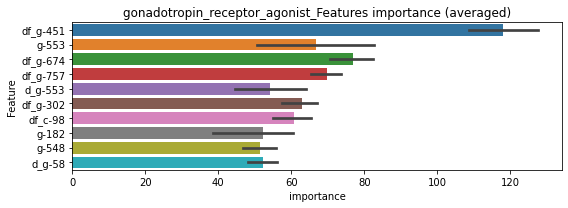

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0119126	valid_1's binary_logloss: 0.0214694
[200]	training's binary_logloss: 0.00133503	valid_1's binary_logloss: 0.00795986
[300]	training's binary_logloss: 0.000366463	valid_1's binary_logloss: 0.00644965
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000315297	valid_1's binary_logloss: 0.00641362


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124506	valid_1's binary_logloss: 0.0181681
[200]	training's binary_logloss: 0.00142743	valid_1's binary_logloss: 0.00395643
[300]	training's binary_logloss: 0.00039902	valid_1's binary_logloss: 0.00233892
[400]	training's binary_logloss: 0.000207954	valid_1's binary_logloss: 0.0020284
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000198763	valid_1's binary_logloss: 0.00201014


gonadotropin_receptor_agonist logloss: 0.004212163714332416


neg labels: 3289 → selected neg labels: 3279


gsk_inhibitor, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324697	valid_1's binary_logloss: 0.0678303
[200]	training's binary_logloss: 0.00485728	valid_1's binary_logloss: 0.0307714
[300]	training's binary_logloss: 0.00141656	valid_1's binary_logloss: 0.0210552
[400]	training's binary_logloss: 0.000695332	valid_1's binary_logloss: 0.0188808
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000695332	valid_1's binary_logloss: 0.0188808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323455	valid_1's binary_logloss: 0.0664275
[200]	training's binary_logloss: 0.00477503	valid_1's binary_logloss: 0.0274235
[300]	training's binary_logloss: 0.00139124	valid_1's binary_logloss: 0.0197552
[400]	training's binary_logloss: 0.000689595	valid_1's binary_logloss: 0.0175393
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000699732	valid_1's binary_logloss: 0.0175086


1 / 3 AUC score:1.000
y_Threshold: 0.0042039, Threshold: 0.0065381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 655/3802
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.00588, conf_1:0.00719
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0065381
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_2: 0.0165381
Num_p_label: 12.0, Expected: 10.0, Adj_threshold_3: 0.0265381
threshold: 0.0265381, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 655.0/3802, y_label_rate: 0.1722777
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329908	valid_1's binary_logloss: 0.0664137
[200]	training's binary_logloss: 0.00479107	valid_1's binary_logloss: 0.0302738
[300]	training's binary_logloss: 0.00137998	valid_1's binary_logloss: 0.022258
[400]	training's binary_logloss: 0.000679389	valid_1's binary_logloss: 0.0199443
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000533403	valid_1's binary_logloss: 0.0192185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315155	valid_1's binary_logloss: 0.0622954
[200]	training's binary_logloss: 0.00454055	valid_1's binary_logloss: 0.0243029
[300]	training's binary_logloss: 0.00132004	valid_1's binary_logloss: 0.0170557
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000755841	valid_1's binary_logloss: 0.0154831


2 / 3 AUC score:1.000
y_Threshold: 0.0172353, Threshold: 0.0265381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 651.0/3794
p_label_rate: 0.0072828 Vs.target_rate: 0.00252
Num_p_label: 29.0, conf_0:0.02388, conf_1:0.02919
threshold: 0.0265381, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 651.0/3794, y_label_rate: 0.1715867
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321858	valid_1's binary_logloss: 0.0715849
[200]	training's binary_logloss: 0.00461754	valid_1's binary_logloss: 0.0375745
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.002099	valid_1's binary_logloss: 0.0338462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312113	valid_1's binary_logloss: 0.0591599
[200]	training's binary_logloss: 0.00448233	valid_1's binary_logloss: 0.0226343
[300]	training's binary_logloss: 0.00130745	valid_1's binary_logloss: 0.0167562
[400]	training's binary_logloss: 0.000660242	valid_1's binary_logloss: 0.0149189
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000516201	valid_1's binary_logloss: 0.0145024


3 / 3 AUC score:1.000
y_Threshold: 0.0205044, Threshold: 0.0265381, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0085384 Vs.target_rate: 0.00252
Num_p_label: 34.0, conf_0:0.02388, conf_1:0.02919
Num_p_label: 34.0, Expected: 10.0, Adj_threshold_1: 0.0265381
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_2: 0.0365381
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_3: 0.0465381
threshold: 0.0465381, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 666.0/7766, y_label_rate: 0.0857584


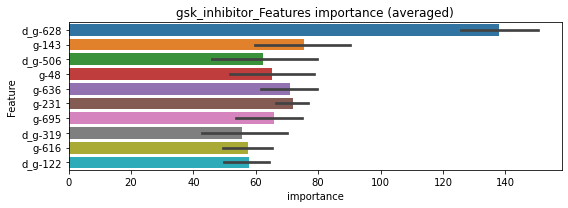

len(train_index) : 3883
len(valid_index) : 3883
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168769	valid_1's binary_logloss: 0.0426039
[200]	training's binary_logloss: 0.0025044	valid_1's binary_logloss: 0.0247979
[300]	training's binary_logloss: 0.000667544	valid_1's binary_logloss: 0.0219968
[400]	training's binary_logloss: 0.000317597	valid_1's binary_logloss: 0.0213302
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000312894	valid_1's binary_logloss: 0.0212859


len(train_index) : 3883
len(valid_index) : 3883
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171769	valid_1's binary_logloss: 0.0360526
[200]	training's binary_logloss: 0.00244565	valid_1's binary_logloss: 0.0159554
[300]	training's binary_logloss: 0.000715729	valid_1's binary_logloss: 0.0123112
[400]	training's binary_logloss: 0.000356631	valid_1's binary_logloss: 0.0107391
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000331227	valid_1's binary_logloss: 0.0105962


gsk_inhibitor logloss: 0.01594107242586951


neg labels: 3289 → selected neg labels: 3277


hcv_inhibitor, len(trt): 72, len(othr): 3277, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056129	valid_1's binary_logloss: 0.120061
[200]	training's binary_logloss: 0.0123019	valid_1's binary_logloss: 0.068132
[300]	training's binary_logloss: 0.00346693	valid_1's binary_logloss: 0.0542918
[400]	training's binary_logloss: 0.00152817	valid_1's binary_logloss: 0.0484816
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00121313	valid_1's binary_logloss: 0.0479257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.05679	valid_1's binary_logloss: 0.114784
[200]	training's binary_logloss: 0.0122706	valid_1's binary_logloss: 0.0643219
[300]	training's binary_logloss: 0.00347909	valid_1's binary_logloss: 0.0516178
[400]	training's binary_logloss: 0.00154555	valid_1's binary_logloss: 0.0484398
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.001596	valid_1's binary_logloss: 0.0483488


1 / 3 AUC score:0.993
y_Threshold: 0.0111722, Threshold: 0.0135889, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.01223, conf_1:0.01495
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0135889
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_2: 0.0235889
threshold: 0.0235889, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522285	valid_1's binary_logloss: 0.11113
[200]	training's binary_logloss: 0.0108244	valid_1's binary_logloss: 0.0646734
[300]	training's binary_logloss: 0.00310897	valid_1's binary_logloss: 0.0538894
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00171225	valid_1's binary_logloss: 0.0508488
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514883	valid_1's binary_logloss: 0.1063
[200]	training's binary_logloss: 0.0104418	valid_1's binary_logloss: 0.0539559
[300]	training's binary_logloss: 0.0030275	valid_1's binary_logloss: 0.0420505
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00151424	valid_1's binary_logloss: 0.0385276


2 / 3 AUC score:0.997
y_Threshold: 0.0316617, Threshold: 0.0235889, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 632.0/3754
p_label_rate: 0.0168257 Vs.target_rate: 0.00302
Num_p_label: 67.0, conf_0:0.02123, conf_1:0.02595
Num_p_label: 67.0, Expected: 12.0, Adj_threshold_1: 0.0235889
Num_p_label: 35.0, Expected: 12.0, Adj_threshold_2: 0.0335889
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_3: 0.0435889
threshold: 0.0435889, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 632.0/3754, y_label_rate: 0.1683538
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499999	valid_1's binary_logloss: 0.106696
[200]	training's binary_logloss: 0.00980994	valid_1's binary_logloss: 0.0594072
[300]	training's binary_logloss: 0.00281161	valid_1's binary_logloss: 0.0495105
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00156244	valid_1's binary_logloss: 0.0465068
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512624	valid_1's binary_logloss: 0.0962228
[200]	training's binary_logloss: 0.00991107	valid_1's binary_logloss: 0.0436666
[300]	training's binary_logloss: 0.00288082	valid_1's binary_logloss: 0.0305308
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00194798	valid_1's binary_logloss: 0.0285766


3 / 3 AUC score:0.995
y_Threshold: 0.0447737, Threshold: 0.0435889, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 621.0/3732
p_label_rate: 0.0097941 Vs.target_rate: 0.00302
Num_p_label: 39.0, conf_0:0.03923, conf_1:0.04795
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_1: 0.0435889
Num_p_label: 24.0, Expected: 12.0, Adj_threshold_2: 0.0535889
threshold: 0.0535889, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 645.0/7714, y_label_rate: 0.0836142


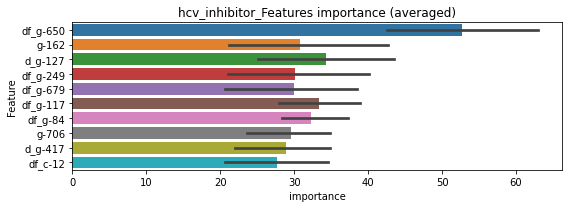

len(train_index) : 3857
len(valid_index) : 3857
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268525	valid_1's binary_logloss: 0.0687446
[200]	training's binary_logloss: 0.00542323	valid_1's binary_logloss: 0.0469332
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00253377	valid_1's binary_logloss: 0.0443998


len(train_index) : 3857
len(valid_index) : 3857
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286742	valid_1's binary_logloss: 0.0587809
[200]	training's binary_logloss: 0.00559213	valid_1's binary_logloss: 0.0300768
[300]	training's binary_logloss: 0.00158858	valid_1's binary_logloss: 0.0237995
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000786877	valid_1's binary_logloss: 0.0226105


hcv_inhibitor logloss: 0.03350513032050916


neg labels: 3289 → selected neg labels: 3271


hdac_inhibitor, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316416	valid_1's binary_logloss: 0.0722601
[200]	training's binary_logloss: 0.00492385	valid_1's binary_logloss: 0.0374993
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00237107	valid_1's binary_logloss: 0.0324284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030637	valid_1's binary_logloss: 0.0653683
[200]	training's binary_logloss: 0.0044336	valid_1's binary_logloss: 0.0382633
Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00170662	valid_1's binary_logloss: 0.0355884


1 / 3 AUC score:0.998
y_Threshold: 0.0084447, Threshold: 0.0216578, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 141 → Positive_corect_labels: 649/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00445
Num_p_label: 80.0, conf_0:0.01949, conf_1:0.02382
Num_p_label: 80.0, Expected: 17.7, Adj_threshold_1: 0.0216578
Num_p_label: 52.0, Expected: 17.7, Adj_threshold_2: 0.0316578
Num_p_label: 33.0, Expected: 17.7, Adj_threshold_3: 0.0416578
threshold: 0.0416578, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 649.0/3784, y_label_rate: 0.1715116
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292485	valid_1's binary_logloss: 0.0627556
[200]	training's binary_logloss: 0.004048	valid_1's binary_logloss: 0.0291606
[300]	training's binary_logloss: 0.00116466	valid_1's binary_logloss: 0.0237292
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.000891299	valid_1's binary_logloss: 0.0229165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295548	valid_1's binary_logloss: 0.0531342
[200]	training's binary_logloss: 0.00422998	valid_1's binary_logloss: 0.0238222
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0014767	valid_1's binary_logloss: 0.0186414


2 / 3 AUC score:1.000
y_Threshold: 0.0288766, Threshold: 0.0416578, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 645.0/3776
p_label_rate: 0.0190859 Vs.target_rate: 0.00445
Num_p_label: 76.0, conf_0:0.03749, conf_1:0.04582
Num_p_label: 76.0, Expected: 17.7, Adj_threshold_1: 0.0416578
Num_p_label: 65.0, Expected: 17.7, Adj_threshold_2: 0.0516578
Num_p_label: 58.0, Expected: 17.7, Adj_threshold_3: 0.0616578
Num_p_label: 56.0, Expected: 17.7, Adj_threshold_4: 0.0716578
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_5: 0.0816578
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_6: 0.0916578
Num_p_label: 41.0, Expected: 17.7, Adj_threshold_7: 0.1016578
Num_p_label: 39.0, Expected: 17.7, Adj_threshold_8: 0.1116578
Num_p_label: 37.0, Expected: 17.7, Adj_threshold_9: 0.1216578
Num_p_label: 36.0, Expected: 17.7, Adj_threshold_10: 0.1316578
threshold: 0.1416578, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 645.0/3776, y_label_rate: 0.1708157

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278653	valid_1's binary_logloss: 0.0525202
[200]	training's binary_logloss: 0.00384669	valid_1's binary_logloss: 0.0241184
[300]	training's binary_logloss: 0.00113152	valid_1's binary_logloss: 0.0188157
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000614866	valid_1's binary_logloss: 0.0170841
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02829	valid_1's binary_logloss: 0.05228
[200]	training's binary_logloss: 0.00396557	valid_1's binary_logloss: 0.0210817
[300]	training's binary_logloss: 0.00116579	valid_1's binary_logloss: 0.015321
[400]	training's binary_logloss: 0.000593808	valid_1's binary_logloss: 0.0132396
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.000585441	valid_1's binary_logloss: 0.0131977


3 / 3 AUC score:1.000
y_Threshold: 0.0322272, Threshold: 0.1416578, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 644.0/3774
p_label_rate: 0.0077850 Vs.target_rate: 0.00445
Num_p_label: 31.0, conf_0:0.12749, conf_1:0.15582
threshold: 0.1416578, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 675.0/7756, y_label_rate: 0.0870294


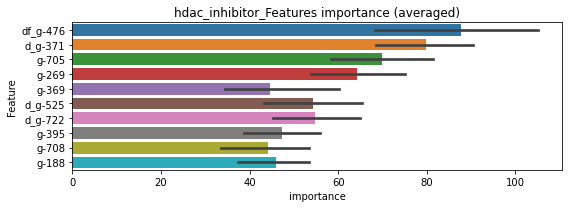

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158049	valid_1's binary_logloss: 0.0434172
[200]	training's binary_logloss: 0.00218745	valid_1's binary_logloss: 0.0278229
[300]	training's binary_logloss: 0.000651646	valid_1's binary_logloss: 0.0248734
[400]	training's binary_logloss: 0.00033279	valid_1's binary_logloss: 0.0239041
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000322715	valid_1's binary_logloss: 0.0237566


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156315	valid_1's binary_logloss: 0.0363444
[200]	training's binary_logloss: 0.00214229	valid_1's binary_logloss: 0.0206693
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.000701817	valid_1's binary_logloss: 0.0185181


hdac_inhibitor logloss: 0.021137343678858736


neg labels: 3289 → selected neg labels: 3279


histamine_receptor_agonist, len(trt): 59, len(othr): 3279, target_rate: 0.0024775 → Adj_target_rate: 0.0026880
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0526564	valid_1's binary_logloss: 0.0926898
[200]	training's binary_logloss: 0.0101071	valid_1's binary_logloss: 0.0365055
[300]	training's binary_logloss: 0.00281761	valid_1's binary_logloss: 0.0220869
[400]	training's binary_logloss: 0.00126294	valid_1's binary_logloss: 0.0173975
[500]	training's binary_logloss: 0.000778069	valid_1's binary_logloss: 0.0155463
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.000656308	valid_1's binary_logloss: 0.0149628
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525952	valid_1's binary_logloss: 0.092566
[200]	training's binary_logloss: 0.0106922	valid_1's binary_logloss: 0.0390935
[300]	training's binary_logloss: 0.00298844	valid_1's binary_logloss: 0.0260488
[400]	training's binary_logloss: 0.00133393	valid_1's binary_logloss: 0.021123
[500]	training's binary_logloss: 0.000807129	va

1 / 3 AUC score:1.000
y_Threshold: 0.0075386, Threshold: 0.0114368, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00248
Num_p_label: 80.0, conf_0:0.01029, conf_1:0.01258
Num_p_label: 80.0, Expected: 9.9, Adj_threshold_1: 0.0114368
Num_p_label: 20.0, Expected: 9.9, Adj_threshold_2: 0.0214368
Num_p_label: 10.0, Expected: 9.9, Adj_threshold_3: 0.0314368
threshold: 0.0314368, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515987	valid_1's binary_logloss: 0.10386
[200]	training's binary_logloss: 0.00967466	valid_1's binary_logloss: 0.0519951
[300]	training's binary_logloss: 0.00271608	valid_1's binary_logloss: 0.040313
[400]	training's binary_logloss: 0.00123243	valid_1's binary_logloss: 0.0358834
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00122463	valid_1's binary_logloss: 0.0358745
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0517089	valid_1's binary_logloss: 0.105487
[200]	training's binary_logloss: 0.0094697	valid_1's binary_logloss: 0.048998
[300]	training's binary_logloss: 0.00265111	valid_1's binary_logloss: 0.0375304
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00196324	valid_1's binary_logloss: 0.0363312


2 / 3 AUC score:0.999
y_Threshold: 0.0406763, Threshold: 0.0314368, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 646.0/3784
p_label_rate: 0.0155701 Vs.target_rate: 0.00248
Num_p_label: 62.0, conf_0:0.02829, conf_1:0.03458
Num_p_label: 62.0, Expected: 9.9, Adj_threshold_1: 0.0314368
Num_p_label: 36.0, Expected: 9.9, Adj_threshold_2: 0.0414368
Num_p_label: 27.0, Expected: 9.9, Adj_threshold_3: 0.0514368
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_4: 0.0614368
threshold: 0.0614368, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050053	valid_1's binary_logloss: 0.0969222
[200]	training's binary_logloss: 0.00944525	valid_1's binary_logloss: 0.0410081
[300]	training's binary_logloss: 0.0026894	valid_1's binary_logloss: 0.0262587
[400]	training's binary_logloss: 0.00121383	valid_1's binary_logloss: 0.0209855
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000922939	valid_1's binary_logloss: 0.0196035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0507795	valid_1's binary_logloss: 0.0890612
[200]	training's binary_logloss: 0.0095184	valid_1's binary_logloss: 0.0341974
[300]	training's binary_logloss: 0.00265879	valid_1's binary_logloss: 0.0209291
[400]	training's binary_logloss: 0.00122051	valid_1's binary_logloss: 0.0171932
[500]	training's binary_logloss: 0.000754645	valid_1's binary_logloss: 0.0158188
Early stopping, best iteration is:
[511]	train

3 / 3 AUC score:1.000
y_Threshold: 0.0281515, Threshold: 0.0614368, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0022602 Vs.target_rate: 0.00248
Num_p_label: 9.0, conf_0:0.05529, conf_1:0.06758
threshold: 0.0614368, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 651.0/7758, y_label_rate: 0.0839134


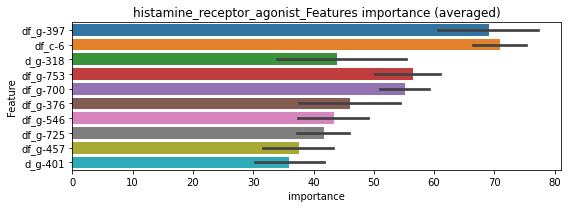

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264805	valid_1's binary_logloss: 0.0652373
[200]	training's binary_logloss: 0.00517193	valid_1's binary_logloss: 0.037508
[300]	training's binary_logloss: 0.00137573	valid_1's binary_logloss: 0.0313698
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00118799	valid_1's binary_logloss: 0.0310497


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279186	valid_1's binary_logloss: 0.054373
[200]	training's binary_logloss: 0.00534365	valid_1's binary_logloss: 0.0240556
[300]	training's binary_logloss: 0.00151405	valid_1's binary_logloss: 0.0164718
[400]	training's binary_logloss: 0.000672714	valid_1's binary_logloss: 0.0135882
[500]	training's binary_logloss: 0.000412925	valid_1's binary_logloss: 0.0126081
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000370669	valid_1's binary_logloss: 0.0124257


histamine_receptor_agonist logloss: 0.021737703407156406


neg labels: 3289 → selected neg labels: 3249


histamine_receptor_antagonist, len(trt): 241, len(othr): 3249, target_rate: 0.0101201 → Adj_target_rate: 0.0088902
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108297	valid_1's binary_logloss: 0.270626
[200]	training's binary_logloss: 0.03818	valid_1's binary_logloss: 0.231951
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.0266272	valid_1's binary_logloss: 0.229247
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107342	valid_1's binary_logloss: 0.275793
[200]	training's binary_logloss: 0.0376518	valid_1's binary_logloss: 0.237706
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0283212	valid_1's binary_logloss: 0.232526


1 / 3 AUC score:0.902
y_Threshold: 0.0870186, Threshold: 0.1253179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 409 → Positive_corect_labels: 510/3489
p_label_rate: 0.0200904 Vs.target_rate: 0.01012
Num_p_label: 80.0, conf_0:0.11279, conf_1:0.13785
threshold: 0.1253179, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 510.0/3489, y_label_rate: 0.1461737
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0751224	valid_1's binary_logloss: 0.194862
[200]	training's binary_logloss: 0.0210255	valid_1's binary_logloss: 0.143073
[300]	training's binary_logloss: 0.00695297	valid_1's binary_logloss: 0.130845
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00672913	valid_1's binary_logloss: 0.130705
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0721807	valid_1's binary_logloss: 0.203801
[200]	training's binary_logloss: 0.0194864	valid_1's binary_logloss: 0.16974
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0130349	valid_1's binary_logloss: 0.165173


2 / 3 AUC score:0.963
y_Threshold: 0.0864577, Threshold: 0.1253179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 441.0/3351
p_label_rate: 0.0155701 Vs.target_rate: 0.01012
Num_p_label: 62.0, conf_0:0.11279, conf_1:0.13785
threshold: 0.1253179, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 441.0/3351, y_label_rate: 0.1316025
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0590511	valid_1's binary_logloss: 0.160934
[200]	training's binary_logloss: 0.0147835	valid_1's binary_logloss: 0.124921
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.00859826	valid_1's binary_logloss: 0.120865
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061099	valid_1's binary_logloss: 0.150774
[200]	training's binary_logloss: 0.0154875	valid_1's binary_logloss: 0.106426
[300]	training's binary_logloss: 0.00489378	valid_1's binary_logloss: 0.0945382
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00423317	valid_1's binary_logloss: 0.0936251


3 / 3 AUC score:0.981
y_Threshold: 0.0827441, Threshold: 0.1253179, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 90 → Positive_corect_labels: 396.0/3261
p_label_rate: 0.0150678 Vs.target_rate: 0.01012
Num_p_label: 60.0, conf_0:0.11279, conf_1:0.13785
threshold: 0.1253179, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 456.0/7243, y_label_rate: 0.0629573


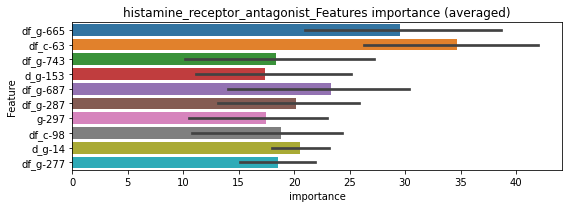

len(train_index) : 3621
len(valid_index) : 3622
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345307	valid_1's binary_logloss: 0.0854442
[200]	training's binary_logloss: 0.0089136	valid_1's binary_logloss: 0.064454
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00414138	valid_1's binary_logloss: 0.0620428


len(train_index) : 3622
len(valid_index) : 3621
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314132	valid_1's binary_logloss: 0.103085
[200]	training's binary_logloss: 0.00760412	valid_1's binary_logloss: 0.0860456
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00658529	valid_1's binary_logloss: 0.0854951


histamine_receptor_antagonist logloss: 0.07376734637561963


neg labels: 3289 → selected neg labels: 3285


histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235282	valid_1's binary_logloss: 0.0331547
[200]	training's binary_logloss: 0.00276501	valid_1's binary_logloss: 0.00595297
[300]	training's binary_logloss: 0.00077762	valid_1's binary_logloss: 0.00235599
[400]	training's binary_logloss: 0.000409631	valid_1's binary_logloss: 0.00147329
[500]	training's binary_logloss: 0.000318081	valid_1's binary_logloss: 0.00125861
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00031745	valid_1's binary_logloss: 0.00125791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235173	valid_1's binary_logloss: 0.0324994
[200]	training's binary_logloss: 0.00275493	valid_1's binary_logloss: 0.00512645
[300]	training's binary_logloss: 0.000775671	valid_1's binary_logloss: 0.00178743
[400]	training's binary_logloss: 0.000414363	valid_1's binary_logloss: 0.00112724
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0012799, Threshold: 0.0020032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00180, conf_1:0.00220
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0020032
Num_p_label: 4.0, Expected: 4.0, Adj_threshold_2: 0.0120032
threshold: 0.0120032, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233456	valid_1's binary_logloss: 0.0316592
[200]	training's binary_logloss: 0.00271587	valid_1's binary_logloss: 0.00535143
[300]	training's binary_logloss: 0.00076479	valid_1's binary_logloss: 0.0020545
[400]	training's binary_logloss: 0.000409025	valid_1's binary_logloss: 0.0012692
[500]	training's binary_logloss: 0.000320549	valid_1's binary_logloss: 0.00110243
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000319127	valid_1's binary_logloss: 0.00110233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236221	valid_1's binary_logloss: 0.0325015
[200]	training's binary_logloss: 0.00272017	valid_1's binary_logloss: 0.00511737
[300]	training's binary_logloss: 0.000760616	valid_1's binary_logloss: 0.00178109
[400]	training's binary_logloss: 0.000406894	valid_1's binary_logloss: 0.00109118
[500]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1319920, Threshold: 0.0120032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00101
Num_p_label: 9.0, conf_0:0.01080, conf_1:0.01320
threshold: 0.0120032, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233456	valid_1's binary_logloss: 0.0316592
[200]	training's binary_logloss: 0.00271587	valid_1's binary_logloss: 0.00535143
[300]	training's binary_logloss: 0.00076479	valid_1's binary_logloss: 0.0020545
[400]	training's binary_logloss: 0.000409025	valid_1's binary_logloss: 0.0012692
[500]	training's binary_logloss: 0.000320549	valid_1's binary_logloss: 0.00110243
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000319127	valid_1's binary_logloss: 0.00110233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236221	valid_1's binary_logloss: 0.0325015
[200]	training's binary_logloss: 0.00272017	valid_1's binary_logloss: 0.00511737
[300]	training's binary_logloss: 0.000760616	valid_1's binary_logloss: 0.00178109
[400]	training's binary_logloss: 0.000406894	valid_1's binary_logloss: 0.00109118
[500]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1319920, Threshold: 0.0120032, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00101
Num_p_label: 9.0, conf_0:0.01080, conf_1:0.01320
threshold: 0.0120032, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7792, y_label_rate: 0.0854723


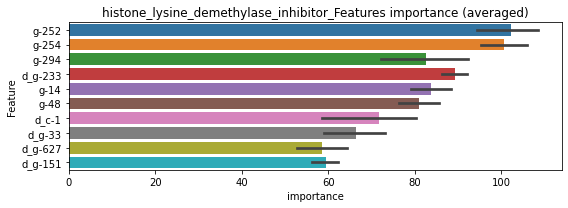

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122116	valid_1's binary_logloss: 0.0268028
[200]	training's binary_logloss: 0.00135158	valid_1's binary_logloss: 0.0112269
[300]	training's binary_logloss: 0.000379977	valid_1's binary_logloss: 0.00958918
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.000233366	valid_1's binary_logloss: 0.00919653


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130016	valid_1's binary_logloss: 0.0188136
[200]	training's binary_logloss: 0.00152976	valid_1's binary_logloss: 0.00561977
[300]	training's binary_logloss: 0.000424557	valid_1's binary_logloss: 0.00410166
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000241656	valid_1's binary_logloss: 0.00387442


histone_lysine_demethylase_inhibitor logloss: 0.006535474462188788


neg labels: 3289 → selected neg labels: 3283


histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288963	valid_1's binary_logloss: 0.0518644
[200]	training's binary_logloss: 0.00386306	valid_1's binary_logloss: 0.0182622
[300]	training's binary_logloss: 0.00109565	valid_1's binary_logloss: 0.01309
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00066676	valid_1's binary_logloss: 0.0121638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287707	valid_1's binary_logloss: 0.0538631
[200]	training's binary_logloss: 0.00386543	valid_1's binary_logloss: 0.0242069
[300]	training's binary_logloss: 0.00108487	valid_1's binary_logloss: 0.0201148
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00109576	valid_1's binary_logloss: 0.0201059


1 / 3 AUC score:1.000
y_Threshold: 0.0046025, Threshold: 0.0069201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 654/3803
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00623, conf_1:0.00761
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0069201
Num_p_label: 17.0, Expected: 5.4, Adj_threshold_2: 0.0169201
Num_p_label: 9.0, Expected: 5.4, Adj_threshold_3: 0.0269201
threshold: 0.0269201, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028471	valid_1's binary_logloss: 0.0571111
[200]	training's binary_logloss: 0.00370985	valid_1's binary_logloss: 0.0221249
[300]	training's binary_logloss: 0.00105267	valid_1's binary_logloss: 0.0158445
[400]	training's binary_logloss: 0.000530376	valid_1's binary_logloss: 0.0141547
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000517244	valid_1's binary_logloss: 0.0141115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283652	valid_1's binary_logloss: 0.0470732
[200]	training's binary_logloss: 0.00378474	valid_1's binary_logloss: 0.0146444
[300]	training's binary_logloss: 0.00106587	valid_1's binary_logloss: 0.0100349
[400]	training's binary_logloss: 0.000542227	valid_1's binary_logloss: 0.00837245
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000482374	valid_1's binary_logloss: 0.00823177


2 / 3 AUC score:1.000
y_Threshold: 0.0178991, Threshold: 0.0269201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0027624 Vs.target_rate: 0.00134
Num_p_label: 11.0, conf_0:0.02423, conf_1:0.02961
threshold: 0.0269201, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285898	valid_1's binary_logloss: 0.0415815
[200]	training's binary_logloss: 0.00376352	valid_1's binary_logloss: 0.00907939
[300]	training's binary_logloss: 0.00106156	valid_1's binary_logloss: 0.00412877
[400]	training's binary_logloss: 0.000540587	valid_1's binary_logloss: 0.00308694
[500]	training's binary_logloss: 0.000384079	valid_1's binary_logloss: 0.00269678
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.000378257	valid_1's binary_logloss: 0.00269355
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284911	valid_1's binary_logloss: 0.043682
[200]	training's binary_logloss: 0.00379638	valid_1's binary_logloss: 0.0106499
[300]	training's binary_logloss: 0.00108402	valid_1's binary_logloss: 0.00502435
[400]	training's binary_logloss: 0.00053991	valid_1's binary_logloss: 0.00349743
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0484911, Threshold: 0.0269201, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0022602 Vs.target_rate: 0.00134
Num_p_label: 9.0, conf_0:0.02423, conf_1:0.02961
threshold: 0.0269201, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 661.0/7781, y_label_rate: 0.0849505


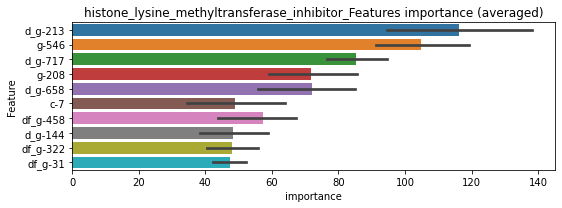

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015288	valid_1's binary_logloss: 0.0335686
[200]	training's binary_logloss: 0.00199202	valid_1's binary_logloss: 0.0170255
[300]	training's binary_logloss: 0.000549149	valid_1's binary_logloss: 0.0139249
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00038193	valid_1's binary_logloss: 0.0135177


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158373	valid_1's binary_logloss: 0.0259732
[200]	training's binary_logloss: 0.00204358	valid_1's binary_logloss: 0.00829967
[300]	training's binary_logloss: 0.000580253	valid_1's binary_logloss: 0.00587548
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000347393	valid_1's binary_logloss: 0.00552036


histone_lysine_methyltransferase_inhibitor logloss: 0.009519560572476642


neg labels: 3289 → selected neg labels: 3278


hiv_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565281	valid_1's binary_logloss: 0.110873
[200]	training's binary_logloss: 0.0117603	valid_1's binary_logloss: 0.0540462
[300]	training's binary_logloss: 0.00332737	valid_1's binary_logloss: 0.0383814
[400]	training's binary_logloss: 0.00143821	valid_1's binary_logloss: 0.0322226
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00100935	valid_1's binary_logloss: 0.0309587
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544144	valid_1's binary_logloss: 0.120624
[200]	training's binary_logloss: 0.0109912	valid_1's binary_logloss: 0.0739422
[300]	training's binary_logloss: 0.00318256	valid_1's binary_logloss: 0.0633572
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00220598	valid_1's binary_logloss: 0.0617822


1 / 3 AUC score:0.997
y_Threshold: 0.0134340, Threshold: 0.0184171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.01658, conf_1:0.02026
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0184171
Num_p_label: 38.0, Expected: 12.0, Adj_threshold_2: 0.0284171
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_3: 0.0384171
threshold: 0.0384171, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 646.0/3783, y_label_rate: 0.1707639
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0533664	valid_1's binary_logloss: 0.108174
[200]	training's binary_logloss: 0.0109262	valid_1's binary_logloss: 0.0567013
[300]	training's binary_logloss: 0.00316535	valid_1's binary_logloss: 0.0436292
[400]	training's binary_logloss: 0.00142243	valid_1's binary_logloss: 0.0398287
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00123435	valid_1's binary_logloss: 0.0392818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0562603	valid_1's binary_logloss: 0.100444
[200]	training's binary_logloss: 0.0112921	valid_1's binary_logloss: 0.0441112
[300]	training's binary_logloss: 0.00328847	valid_1's binary_logloss: 0.0289541
[400]	training's binary_logloss: 0.00146537	valid_1's binary_logloss: 0.0244417
[500]	training's binary_logloss: 0.000882273	valid_1's binary_logloss: 0.0227849
Early stopping, best iteration is:
[564]	trainin

2 / 3 AUC score:0.999
y_Threshold: 0.0332519, Threshold: 0.0384171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 635.0/3761
p_label_rate: 0.0107986 Vs.target_rate: 0.00302
Num_p_label: 43.0, conf_0:0.03458, conf_1:0.04226
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_1: 0.0384171
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_2: 0.0484171
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_3: 0.0584171
threshold: 0.0584171, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 635.0/3761, y_label_rate: 0.1688381
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514756	valid_1's binary_logloss: 0.106837
[200]	training's binary_logloss: 0.010163	valid_1's binary_logloss: 0.0527245
[300]	training's binary_logloss: 0.0028973	valid_1's binary_logloss: 0.0386543
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00149295	valid_1's binary_logloss: 0.035115
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0506628	valid_1's binary_logloss: 0.114393
[200]	training's binary_logloss: 0.00977356	valid_1's binary_logloss: 0.062592
[300]	training's binary_logloss: 0.00286321	valid_1's binary_logloss: 0.051678
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00150181	valid_1's binary_logloss: 0.0485972


3 / 3 AUC score:0.999
y_Threshold: 0.0340014, Threshold: 0.0584171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 625.0/3741
p_label_rate: 0.0075339 Vs.target_rate: 0.00302
Num_p_label: 30.0, conf_0:0.05258, conf_1:0.06426
threshold: 0.0584171, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 655.0/7723, y_label_rate: 0.0848116


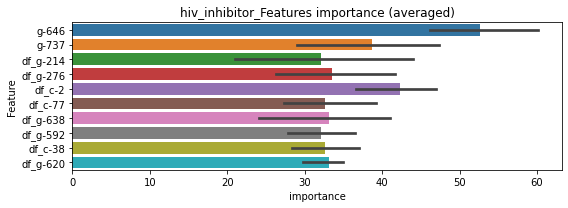

len(train_index) : 3861
len(valid_index) : 3862
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286671	valid_1's binary_logloss: 0.0803532
[200]	training's binary_logloss: 0.00582672	valid_1's binary_logloss: 0.0598958
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00261109	valid_1's binary_logloss: 0.0568173


len(train_index) : 3862
len(valid_index) : 3861
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306832	valid_1's binary_logloss: 0.064016
[200]	training's binary_logloss: 0.00634969	valid_1's binary_logloss: 0.036059
[300]	training's binary_logloss: 0.00183637	valid_1's binary_logloss: 0.0301805
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00174282	valid_1's binary_logloss: 0.0299747


hiv_inhibitor logloss: 0.043397728447992855


neg labels: 3289 → selected neg labels: 3282


hmgcr_inhibitor, len(trt): 283, len(othr): 3282, target_rate: 0.0118838 → Adj_target_rate: 0.0101910
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385842	valid_1's binary_logloss: 0.081169
[200]	training's binary_logloss: 0.00700802	valid_1's binary_logloss: 0.0550039
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00271523	valid_1's binary_logloss: 0.0504724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036038	valid_1's binary_logloss: 0.0952006
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.00788374	valid_1's binary_logloss: 0.0788908


1 / 3 AUC score:0.992
y_Threshold: 0.0416243, Threshold: 0.2216529, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 638/3770
p_label_rate: 0.0200904 Vs.target_rate: 0.01188
Num_p_label: 80.0, conf_0:0.19949, conf_1:0.24382
threshold: 0.2216529, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 638.0/3770, y_label_rate: 0.1692308
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286247	valid_1's binary_logloss: 0.0616478
[200]	training's binary_logloss: 0.00427029	valid_1's binary_logloss: 0.040758
Early stopping, best iteration is:
[247]	training's binary_logloss: 0.00213046	valid_1's binary_logloss: 0.0395512
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302504	valid_1's binary_logloss: 0.0473928
[200]	training's binary_logloss: 0.00451592	valid_1's binary_logloss: 0.0193473
[300]	training's binary_logloss: 0.00122483	valid_1's binary_logloss: 0.0134533
[400]	training's binary_logloss: 0.00060498	valid_1's binary_logloss: 0.0119688
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000446177	valid_1's binary_logloss: 0.0112449


2 / 3 AUC score:0.997
y_Threshold: 0.1474292, Threshold: 0.2216529, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 627.0/3748
p_label_rate: 0.0421899 Vs.target_rate: 0.01188
Num_p_label: 168.0, conf_0:0.19949, conf_1:0.24382
Num_p_label: 168.0, Expected: 47.3, Adj_threshold_1: 0.2216529
Num_p_label: 167.0, Expected: 47.3, Adj_threshold_2: 0.2316529
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_3: 0.2416529
Num_p_label: 163.0, Expected: 47.3, Adj_threshold_4: 0.2516529
Num_p_label: 161.0, Expected: 47.3, Adj_threshold_5: 0.2616529
Num_p_label: 158.0, Expected: 47.3, Adj_threshold_6: 0.2716529
Num_p_label: 154.0, Expected: 47.3, Adj_threshold_7: 0.2816529
Num_p_label: 152.0, Expected: 47.3, Adj_threshold_8: 0.2916529
Num_p_label: 149.0, Expected: 47.3, Adj_threshold_9: 0.3016529
Num_p_label: 145.0, Expected: 47.3, Adj_threshold_10: 0.3116529
threshold: 0.3216529, positive_p_label: 140.0/3982, p_label_rate: 0.0351582
positive_y_label: 627.0/3748, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268519	valid_1's binary_logloss: 0.0432844
[200]	training's binary_logloss: 0.00412172	valid_1's binary_logloss: 0.0162676
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00164298	valid_1's binary_logloss: 0.0127746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272806	valid_1's binary_logloss: 0.0415992
[200]	training's binary_logloss: 0.00388642	valid_1's binary_logloss: 0.0158666
[300]	training's binary_logloss: 0.00104216	valid_1's binary_logloss: 0.0114225
[400]	training's binary_logloss: 0.000538068	valid_1's binary_logloss: 0.010252
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000430942	valid_1's binary_logloss: 0.00980565


3 / 3 AUC score:1.000
y_Threshold: 0.1716916, Threshold: 0.3216529, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 621.0/3736
p_label_rate: 0.0381718 Vs.target_rate: 0.01188
Num_p_label: 152.0, conf_0:0.28949, conf_1:0.35382
Num_p_label: 152.0, Expected: 47.3, Adj_threshold_1: 0.3216529
Num_p_label: 151.0, Expected: 47.3, Adj_threshold_2: 0.3316529
Num_p_label: 150.0, Expected: 47.3, Adj_threshold_3: 0.3416529
Num_p_label: 149.0, Expected: 47.3, Adj_threshold_4: 0.3516529
Num_p_label: 147.0, Expected: 47.3, Adj_threshold_5: 0.3616529
Num_p_label: 146.0, Expected: 47.3, Adj_threshold_6: 0.3716529
Num_p_label: 144.0, Expected: 47.3, Adj_threshold_7: 0.3816529
Num_p_label: 144.0, Expected: 47.3, Adj_threshold_8: 0.3916529
Num_p_label: 144.0, Expected: 47.3, Adj_threshold_9: 0.4016529
Num_p_label: 144.0, Expected: 47.3, Adj_threshold_10: 0.4116529
threshold: 0.4216529, positive_p_label: 142.0/3982, p_label_rate: 0.0356605
positive_y_label: 763.0/7718, y_label_ra

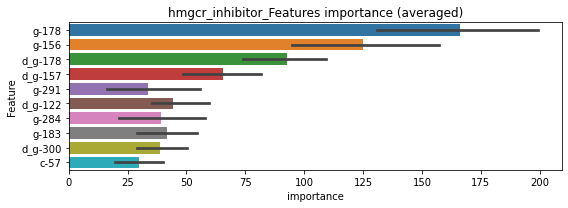

len(train_index) : 3859
len(valid_index) : 3859
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163554	valid_1's binary_logloss: 0.0337539
[200]	training's binary_logloss: 0.00234582	valid_1's binary_logloss: 0.0172403
[300]	training's binary_logloss: 0.000660404	valid_1's binary_logloss: 0.0146551
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000423313	valid_1's binary_logloss: 0.0141437


len(train_index) : 3859
len(valid_index) : 3859
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0171413	valid_1's binary_logloss: 0.0315795
[200]	training's binary_logloss: 0.00254161	valid_1's binary_logloss: 0.0168625
[300]	training's binary_logloss: 0.00072843	valid_1's binary_logloss: 0.0146453
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000691133	valid_1's binary_logloss: 0.014596


hmgcr_inhibitor logloss: 0.014369821208755917


neg labels: 3289 → selected neg labels: 3275


hsp_inhibitor, len(trt): 93, len(othr): 3275, target_rate: 0.0039053 → Adj_target_rate: 0.0039574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025659	valid_1's binary_logloss: 0.0525254
[200]	training's binary_logloss: 0.00332841	valid_1's binary_logloss: 0.0266995
[300]	training's binary_logloss: 0.000962109	valid_1's binary_logloss: 0.0208255
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000750576	valid_1's binary_logloss: 0.0202336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270344	valid_1's binary_logloss: 0.0523555
[200]	training's binary_logloss: 0.00336723	valid_1's binary_logloss: 0.0231763
[300]	training's binary_logloss: 0.000960241	valid_1's binary_logloss: 0.0160286
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000618793	valid_1's binary_logloss: 0.015023


1 / 3 AUC score:1.000
y_Threshold: 0.0028914, Threshold: 0.0135571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 135 → Positive_corect_labels: 653/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00391
Num_p_label: 80.0, conf_0:0.01220, conf_1:0.01491
Num_p_label: 80.0, Expected: 15.6, Adj_threshold_1: 0.0135571
Num_p_label: 58.0, Expected: 15.6, Adj_threshold_2: 0.0235571
Num_p_label: 48.0, Expected: 15.6, Adj_threshold_3: 0.0335571
Num_p_label: 37.0, Expected: 15.6, Adj_threshold_4: 0.0435571
Num_p_label: 25.0, Expected: 15.6, Adj_threshold_5: 0.0535571
threshold: 0.0535571, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 653.0/3795, y_label_rate: 0.1720685
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272139	valid_1's binary_logloss: 0.0493337
[200]	training's binary_logloss: 0.00338528	valid_1's binary_logloss: 0.0206922
[300]	training's binary_logloss: 0.000955614	valid_1's binary_logloss: 0.0153955
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000841959	valid_1's binary_logloss: 0.0150692
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251823	valid_1's binary_logloss: 0.0582465
[200]	training's binary_logloss: 0.00305868	valid_1's binary_logloss: 0.0385508
Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00147498	valid_1's binary_logloss: 0.0375937


2 / 3 AUC score:0.998
y_Threshold: 0.0266482, Threshold: 0.0535571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 643.0/3775
p_label_rate: 0.0291311 Vs.target_rate: 0.00391
Num_p_label: 116.0, conf_0:0.04820, conf_1:0.05891
Num_p_label: 116.0, Expected: 15.6, Adj_threshold_1: 0.0535571
Num_p_label: 102.0, Expected: 15.6, Adj_threshold_2: 0.0635571
Num_p_label: 92.0, Expected: 15.6, Adj_threshold_3: 0.0735571
Num_p_label: 90.0, Expected: 15.6, Adj_threshold_4: 0.0835571
Num_p_label: 82.0, Expected: 15.6, Adj_threshold_5: 0.0935571
Num_p_label: 77.0, Expected: 15.6, Adj_threshold_6: 0.1035571
Num_p_label: 74.0, Expected: 15.6, Adj_threshold_7: 0.1135571
Num_p_label: 70.0, Expected: 15.6, Adj_threshold_8: 0.1235571
Num_p_label: 65.0, Expected: 15.6, Adj_threshold_9: 0.1335571
Num_p_label: 64.0, Expected: 15.6, Adj_threshold_10: 0.1435571
threshold: 0.1535571, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 643.0/3775, y_label_rate: 0.170

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252823	valid_1's binary_logloss: 0.0487317
[200]	training's binary_logloss: 0.00292652	valid_1's binary_logloss: 0.0250477
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.00163388	valid_1's binary_logloss: 0.023408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259505	valid_1's binary_logloss: 0.039614
[200]	training's binary_logloss: 0.00305293	valid_1's binary_logloss: 0.0133041
[300]	training's binary_logloss: 0.000859272	valid_1's binary_logloss: 0.00957135
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000537801	valid_1's binary_logloss: 0.00875033


3 / 3 AUC score:1.000
y_Threshold: 0.0306354, Threshold: 0.1535571, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 639.0/3767
p_label_rate: 0.0188348 Vs.target_rate: 0.00391
Num_p_label: 75.0, conf_0:0.13820, conf_1:0.16891
Num_p_label: 75.0, Expected: 15.6, Adj_threshold_1: 0.1535571
Num_p_label: 74.0, Expected: 15.6, Adj_threshold_2: 0.1635571
Num_p_label: 71.0, Expected: 15.6, Adj_threshold_3: 0.1735571
Num_p_label: 70.0, Expected: 15.6, Adj_threshold_4: 0.1835571
Num_p_label: 68.0, Expected: 15.6, Adj_threshold_5: 0.1935571
Num_p_label: 66.0, Expected: 15.6, Adj_threshold_6: 0.2035571
Num_p_label: 65.0, Expected: 15.6, Adj_threshold_7: 0.2135571
Num_p_label: 62.0, Expected: 15.6, Adj_threshold_8: 0.2235571
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_9: 0.2335571
Num_p_label: 58.0, Expected: 15.6, Adj_threshold_10: 0.2435571
threshold: 0.2535571, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 696.0/7749, y_label_rate: 0.0898180

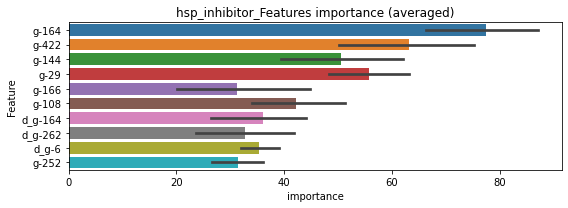

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141524	valid_1's binary_logloss: 0.0407319
Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00233125	valid_1's binary_logloss: 0.0313201


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145488	valid_1's binary_logloss: 0.0250781
[200]	training's binary_logloss: 0.00190486	valid_1's binary_logloss: 0.0112323
[300]	training's binary_logloss: 0.000552602	valid_1's binary_logloss: 0.00914663
[400]	training's binary_logloss: 0.000289006	valid_1's binary_logloss: 0.00841851
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000246951	valid_1's binary_logloss: 0.00819787


hsp_inhibitor logloss: 0.019760502221302403


neg labels: 3289 → selected neg labels: 3282


igf-1_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294225	valid_1's binary_logloss: 0.0537303
[200]	training's binary_logloss: 0.00423471	valid_1's binary_logloss: 0.0175782
[300]	training's binary_logloss: 0.00122676	valid_1's binary_logloss: 0.0105734
[400]	training's binary_logloss: 0.000619227	valid_1's binary_logloss: 0.00865021
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.000464303	valid_1's binary_logloss: 0.00801784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300058	valid_1's binary_logloss: 0.0532787
[200]	training's binary_logloss: 0.00419536	valid_1's binary_logloss: 0.0163828
[300]	training's binary_logloss: 0.00120747	valid_1's binary_logloss: 0.00961865
[400]	training's binary_logloss: 0.000615466	valid_1's binary_logloss: 0.007937
[500]	training's binary_logloss: 0.00043616	valid_1's binary_logloss: 0.00698164
Early stopping, best iteration is:
[510

1 / 3 AUC score:1.000
y_Threshold: 0.0042721, Threshold: 0.0086479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00778, conf_1:0.00951
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0086479
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_2: 0.0186479
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_3: 0.0286479
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_4: 0.0386479
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_5: 0.0486479
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_6: 0.0586479
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_7: 0.0686479
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_8: 0.0786479
threshold: 0.0786479, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283564	valid_1's binary_logloss: 0.0512313
[200]	training's binary_logloss: 0.00383356	valid_1's binary_logloss: 0.0175804
[300]	training's binary_logloss: 0.00111289	valid_1's binary_logloss: 0.0112544
[400]	training's binary_logloss: 0.000568729	valid_1's binary_logloss: 0.00933021
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000501424	valid_1's binary_logloss: 0.00901735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288301	valid_1's binary_logloss: 0.0484478
[200]	training's binary_logloss: 0.00381332	valid_1's binary_logloss: 0.0129487
[300]	training's binary_logloss: 0.00111729	valid_1's binary_logloss: 0.0073205
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000653025	valid_1's binary_logloss: 0.00624965


2 / 3 AUC score:1.000
y_Threshold: 0.0607851, Threshold: 0.0786479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3804
p_label_rate: 0.0118031 Vs.target_rate: 0.00155
Num_p_label: 47.0, conf_0:0.07078, conf_1:0.08651
Num_p_label: 47.0, Expected: 6.2, Adj_threshold_1: 0.0786479
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_2: 0.0886479
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_3: 0.0986479
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_4: 0.1086479
Num_p_label: 39.0, Expected: 6.2, Adj_threshold_5: 0.1186479
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_6: 0.1286479
Num_p_label: 35.0, Expected: 6.2, Adj_threshold_7: 0.1386479
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_8: 0.1486479
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_9: 0.1586479
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_10: 0.1686479
threshold: 0.1786479, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288625	valid_1's binary_logloss: 0.0480519
[200]	training's binary_logloss: 0.00386886	valid_1's binary_logloss: 0.0147817
[300]	training's binary_logloss: 0.00111157	valid_1's binary_logloss: 0.00920657
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000699375	valid_1's binary_logloss: 0.00816397
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287822	valid_1's binary_logloss: 0.0429397
[200]	training's binary_logloss: 0.00387441	valid_1's binary_logloss: 0.0106485
[300]	training's binary_logloss: 0.00111984	valid_1's binary_logloss: 0.00504275
[400]	training's binary_logloss: 0.000576872	valid_1's binary_logloss: 0.00364844
[500]	training's binary_logloss: 0.000415545	valid_1's binary_logloss: 0.0031339
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.000390403	valid_1's binary_logloss: 0.00306462


3 / 3 AUC score:1.000
y_Threshold: 0.0835018, Threshold: 0.1786479, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0082873 Vs.target_rate: 0.00155
Num_p_label: 33.0, conf_0:0.16078, conf_1:0.19651
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_1: 0.1786479
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_2: 0.1886479
Num_p_label: 32.0, Expected: 6.2, Adj_threshold_3: 0.1986479
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_4: 0.2086479
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_5: 0.2186479
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_6: 0.2286479
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_7: 0.2386479
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_8: 0.2486479
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_9: 0.2586479
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_10: 0.2686479
threshold: 0.2786479, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 677.0/7784, y_label_rate: 0.0869733


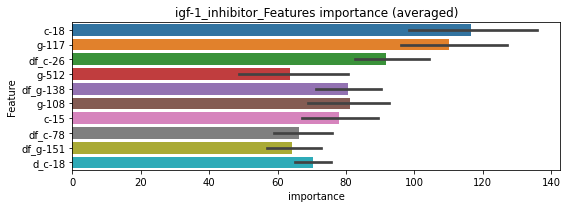

len(train_index) : 3892
len(valid_index) : 3892
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163747	valid_1's binary_logloss: 0.0309557
[200]	training's binary_logloss: 0.00233574	valid_1's binary_logloss: 0.0132784
[300]	training's binary_logloss: 0.000644707	valid_1's binary_logloss: 0.0111353
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000500678	valid_1's binary_logloss: 0.0108947


len(train_index) : 3892
len(valid_index) : 3892
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159877	valid_1's binary_logloss: 0.0342091
[200]	training's binary_logloss: 0.00221935	valid_1's binary_logloss: 0.0170928
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000766127	valid_1's binary_logloss: 0.0146115


igf-1_inhibitor logloss: 0.012753128435164046


neg labels: 3289 → selected neg labels: 3284


ikk_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254083	valid_1's binary_logloss: 0.0417666
[200]	training's binary_logloss: 0.00318062	valid_1's binary_logloss: 0.0124619
[300]	training's binary_logloss: 0.000910466	valid_1's binary_logloss: 0.00786969
[400]	training's binary_logloss: 0.000474277	valid_1's binary_logloss: 0.00652419
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000395105	valid_1's binary_logloss: 0.0062552
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266616	valid_1's binary_logloss: 0.0405132
[200]	training's binary_logloss: 0.00338012	valid_1's binary_logloss: 0.0104575
[300]	training's binary_logloss: 0.000949521	valid_1's binary_logloss: 0.00545372
[400]	training's binary_logloss: 0.000489732	valid_1's binary_logloss: 0.00417349
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000444079	valid_1's binary_logloss: 0.00400028

1 / 3 AUC score:1.000
y_Threshold: 0.0029018, Threshold: 0.0663775, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.05974, conf_1:0.07302
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0663775
Num_p_label: 73.0, Expected: 5.0, Adj_threshold_2: 0.0763775
Num_p_label: 67.0, Expected: 5.0, Adj_threshold_3: 0.0863775
Num_p_label: 60.0, Expected: 5.0, Adj_threshold_4: 0.0963775
Num_p_label: 57.0, Expected: 5.0, Adj_threshold_5: 0.1063775
Num_p_label: 55.0, Expected: 5.0, Adj_threshold_6: 0.1163775
Num_p_label: 52.0, Expected: 5.0, Adj_threshold_7: 0.1263775
Num_p_label: 48.0, Expected: 5.0, Adj_threshold_8: 0.1363775
Num_p_label: 47.0, Expected: 5.0, Adj_threshold_9: 0.1463775
Num_p_label: 46.0, Expected: 5.0, Adj_threshold_10: 0.1563775
threshold: 0.1663775, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0249878	valid_1's binary_logloss: 0.0415627
[200]	training's binary_logloss: 0.00292995	valid_1's binary_logloss: 0.0141067
[300]	training's binary_logloss: 0.000832453	valid_1's binary_logloss: 0.00964096
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000464369	valid_1's binary_logloss: 0.00848863
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248334	valid_1's binary_logloss: 0.0383005
[200]	training's binary_logloss: 0.00304948	valid_1's binary_logloss: 0.00975773
[300]	training's binary_logloss: 0.000841123	valid_1's binary_logloss: 0.00489506
[400]	training's binary_logloss: 0.000442489	valid_1's binary_logloss: 0.00370579
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000356376	valid_1's binary_logloss: 0.00335698


2 / 3 AUC score:1.000
y_Threshold: 0.0912979, Threshold: 0.1663775, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0291311 Vs.target_rate: 0.00126
Num_p_label: 116.0, conf_0:0.14974, conf_1:0.18302
Num_p_label: 116.0, Expected: 5.0, Adj_threshold_1: 0.1663775
Num_p_label: 115.0, Expected: 5.0, Adj_threshold_2: 0.1763775
Num_p_label: 114.0, Expected: 5.0, Adj_threshold_3: 0.1863775
Num_p_label: 109.0, Expected: 5.0, Adj_threshold_4: 0.1963775
Num_p_label: 108.0, Expected: 5.0, Adj_threshold_5: 0.2063775
Num_p_label: 105.0, Expected: 5.0, Adj_threshold_6: 0.2163775
Num_p_label: 104.0, Expected: 5.0, Adj_threshold_7: 0.2263775
Num_p_label: 103.0, Expected: 5.0, Adj_threshold_8: 0.2363775
Num_p_label: 102.0, Expected: 5.0, Adj_threshold_9: 0.2463775
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_10: 0.2563775
threshold: 0.2663775, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 654.0/3804, y_label_rate: 0.1719243

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250778	valid_1's binary_logloss: 0.037968
[200]	training's binary_logloss: 0.00302363	valid_1's binary_logloss: 0.00996105
[300]	training's binary_logloss: 0.000849547	valid_1's binary_logloss: 0.00568904
[400]	training's binary_logloss: 0.000444079	valid_1's binary_logloss: 0.00485267
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.000363332	valid_1's binary_logloss: 0.00457637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250745	valid_1's binary_logloss: 0.0328429
[200]	training's binary_logloss: 0.00311632	valid_1's binary_logloss: 0.00560221
[300]	training's binary_logloss: 0.000868281	valid_1's binary_logloss: 0.00196036
[400]	training's binary_logloss: 0.000452449	valid_1's binary_logloss: 0.00114549
[500]	training's binary_logloss: 0.000362584	valid_1's binary_logloss: 0.000962885
Early stopping, best iteration 

3 / 3 AUC score:1.000
y_Threshold: 0.0552186, Threshold: 0.2663775, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0251130 Vs.target_rate: 0.00126
Num_p_label: 100.0, conf_0:0.23974, conf_1:0.29302
Num_p_label: 100.0, Expected: 5.0, Adj_threshold_1: 0.2663775
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_2: 0.2763775
Num_p_label: 99.0, Expected: 5.0, Adj_threshold_3: 0.2863775
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_4: 0.2963775
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_5: 0.3063775
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_6: 0.3163775
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_7: 0.3263775
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_8: 0.3363775
Num_p_label: 98.0, Expected: 5.0, Adj_threshold_9: 0.3463775
Num_p_label: 97.0, Expected: 5.0, Adj_threshold_10: 0.3563775
threshold: 0.3663775, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 751.0/7786, y_label_rate: 0.0964552


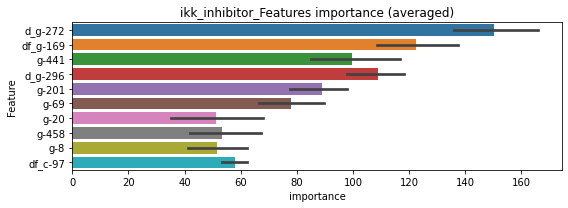

len(train_index) : 3893
len(valid_index) : 3893
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157277	valid_1's binary_logloss: 0.0283729
[200]	training's binary_logloss: 0.00214615	valid_1's binary_logloss: 0.00979006
[300]	training's binary_logloss: 0.000592385	valid_1's binary_logloss: 0.00609201
[400]	training's binary_logloss: 0.00030031	valid_1's binary_logloss: 0.00503568
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000281651	valid_1's binary_logloss: 0.00492749


len(train_index) : 3893
len(valid_index) : 3893
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164372	valid_1's binary_logloss: 0.0247659
[200]	training's binary_logloss: 0.00217061	valid_1's binary_logloss: 0.00957371
[300]	training's binary_logloss: 0.000595421	valid_1's binary_logloss: 0.00770419
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.000539859	valid_1's binary_logloss: 0.00765


ikk_inhibitor logloss: 0.006288745985201001


neg labels: 3289 → selected neg labels: 3284


imidazoline_receptor_agonist, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0336618	valid_1's binary_logloss: 0.0536188
[200]	training's binary_logloss: 0.00479597	valid_1's binary_logloss: 0.0152916
[300]	training's binary_logloss: 0.00133002	valid_1's binary_logloss: 0.00824843
[400]	training's binary_logloss: 0.000653074	valid_1's binary_logloss: 0.00614533
[500]	training's binary_logloss: 0.000442421	valid_1's binary_logloss: 0.00539906
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.000420368	valid_1's binary_logloss: 0.00533126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333335	valid_1's binary_logloss: 0.0500161
[200]	training's binary_logloss: 0.00475865	valid_1's binary_logloss: 0.0113182
[300]	training's binary_logloss: 0.00133088	valid_1's binary_logloss: 0.00441179
[400]	training's binary_logloss: 0.000648669	valid_1's binary_logloss: 0.00265189
[500]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0024444, Threshold: 0.0054363, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00489, conf_1:0.00598
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0054363
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_2: 0.0154363
Num_p_label: 6.0, Expected: 5.2, Adj_threshold_3: 0.0254363
threshold: 0.0254363, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330744	valid_1's binary_logloss: 0.0523547
[200]	training's binary_logloss: 0.00465899	valid_1's binary_logloss: 0.0136623
[300]	training's binary_logloss: 0.00128385	valid_1's binary_logloss: 0.00668329
[400]	training's binary_logloss: 0.000631038	valid_1's binary_logloss: 0.00458593
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000477567	valid_1's binary_logloss: 0.00400617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325597	valid_1's binary_logloss: 0.0473041
[200]	training's binary_logloss: 0.00457405	valid_1's binary_logloss: 0.00979581
[300]	training's binary_logloss: 0.00130383	valid_1's binary_logloss: 0.00381154
[400]	training's binary_logloss: 0.000644717	valid_1's binary_logloss: 0.00230764
[500]	training's binary_logloss: 0.000446304	valid_1's binary_logloss: 0.00179067
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0457348, Threshold: 0.0254363, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0042692 Vs.target_rate: 0.00130
Num_p_label: 17.0, conf_0:0.02289, conf_1:0.02798
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_1: 0.0254363
Num_p_label: 10.0, Expected: 5.2, Adj_threshold_2: 0.0354363
threshold: 0.0354363, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330744	valid_1's binary_logloss: 0.0523547
[200]	training's binary_logloss: 0.00465899	valid_1's binary_logloss: 0.0136623
[300]	training's binary_logloss: 0.00128385	valid_1's binary_logloss: 0.00668329
[400]	training's binary_logloss: 0.000631038	valid_1's binary_logloss: 0.00458593
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000477567	valid_1's binary_logloss: 0.00400617
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325597	valid_1's binary_logloss: 0.0473041
[200]	training's binary_logloss: 0.00457405	valid_1's binary_logloss: 0.00979581
[300]	training's binary_logloss: 0.00130383	valid_1's binary_logloss: 0.00381154
[400]	training's binary_logloss: 0.000644717	valid_1's binary_logloss: 0.00230764
[500]	training's binary_logloss: 0.000446304	valid_1's binary_logloss: 0.00179067
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0457348, Threshold: 0.0354363, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00130
Num_p_label: 10.0, conf_0:0.03189, conf_1:0.03898
threshold: 0.0354363, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


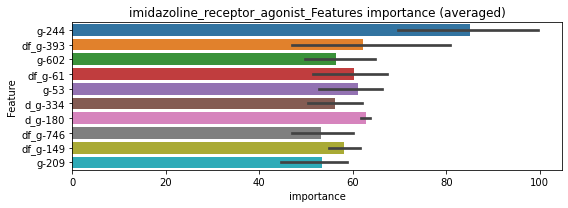

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194063	valid_1's binary_logloss: 0.0316701
[200]	training's binary_logloss: 0.00276455	valid_1's binary_logloss: 0.0125601
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00113277	valid_1's binary_logloss: 0.0106237


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189948	valid_1's binary_logloss: 0.0394303
[200]	training's binary_logloss: 0.00278898	valid_1's binary_logloss: 0.0187281
[300]	training's binary_logloss: 0.000758007	valid_1's binary_logloss: 0.0144954
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000794096	valid_1's binary_logloss: 0.0144817


imidazoline_receptor_agonist logloss: 0.0125527246773089


neg labels: 3289 → selected neg labels: 3278


immunosuppressant, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488819	valid_1's binary_logloss: 0.0967657
[200]	training's binary_logloss: 0.00905105	valid_1's binary_logloss: 0.0498084
[300]	training's binary_logloss: 0.00267154	valid_1's binary_logloss: 0.038378
[400]	training's binary_logloss: 0.00124558	valid_1's binary_logloss: 0.0336549
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000996014	valid_1's binary_logloss: 0.0330076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468209	valid_1's binary_logloss: 0.08921
[200]	training's binary_logloss: 0.0102591	valid_1's binary_logloss: 0.0386928
[300]	training's binary_logloss: 0.0029761	valid_1's binary_logloss: 0.0248097
[400]	training's binary_logloss: 0.00129254	valid_1's binary_logloss: 0.0195297
[500]	training's binary_logloss: 0.000801998	valid_1's binary_logloss: 0.0181911
Early stopping, best iteration is:
[505]	trainin

1 / 3 AUC score:1.000
y_Threshold: 0.0091192, Threshold: 0.0170136, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.01531, conf_1:0.01872
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0170136
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_2: 0.0270136
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_3: 0.0370136
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_4: 0.0470136
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_5: 0.0570136
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.0670136
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_7: 0.0770136
threshold: 0.0770136, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 654.0/3799, y_label_rate: 0.1721506
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428455	valid_1's binary_logloss: 0.0938091
[200]	training's binary_logloss: 0.00780934	valid_1's binary_logloss: 0.0547554
[300]	training's binary_logloss: 0.00231339	valid_1's binary_logloss: 0.0473379
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.00146439	valid_1's binary_logloss: 0.0458667
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431052	valid_1's binary_logloss: 0.102115
[200]	training's binary_logloss: 0.00790985	valid_1's binary_logloss: 0.0557404
[300]	training's binary_logloss: 0.00235692	valid_1's binary_logloss: 0.0451924
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00179954	valid_1's binary_logloss: 0.0437529


2 / 3 AUC score:0.997
y_Threshold: 0.0273583, Threshold: 0.0770136, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 637.0/3765
p_label_rate: 0.0110497 Vs.target_rate: 0.00307
Num_p_label: 44.0, conf_0:0.06931, conf_1:0.08472
Num_p_label: 44.0, Expected: 12.2, Adj_threshold_1: 0.0770136
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_2: 0.0870136
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_3: 0.0970136
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_4: 0.1070136
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_5: 0.1170136
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_6: 0.1270136
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_7: 0.1370136
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_8: 0.1470136
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_9: 0.1570136
Num_p_label: 30.0, Expected: 12.2, Adj_threshold_10: 0.1670136
threshold: 0.1770136, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 637.0/3765, y_label_rate: 0.169189

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448774	valid_1's binary_logloss: 0.0741997
[200]	training's binary_logloss: 0.0082604	valid_1's binary_logloss: 0.0263613
[300]	training's binary_logloss: 0.00243976	valid_1's binary_logloss: 0.0149865
[400]	training's binary_logloss: 0.00115878	valid_1's binary_logloss: 0.0107119
[500]	training's binary_logloss: 0.000728143	valid_1's binary_logloss: 0.00919384
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.000636715	valid_1's binary_logloss: 0.00878579
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.039045	valid_1's binary_logloss: 0.0997399
[200]	training's binary_logloss: 0.00680959	valid_1's binary_logloss: 0.0612958
[300]	training's binary_logloss: 0.00204436	valid_1's binary_logloss: 0.0540914
[400]	training's binary_logloss: 0.000993522	valid_1's binary_logloss: 0.0517785
Early stopping, best iteration is:
[401]	t

3 / 3 AUC score:0.998
y_Threshold: 0.0267590, Threshold: 0.1770136, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 630.0/3751
p_label_rate: 0.0072828 Vs.target_rate: 0.00307
Num_p_label: 29.0, conf_0:0.15931, conf_1:0.19472
threshold: 0.1770136, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 659.0/7733, y_label_rate: 0.0852192


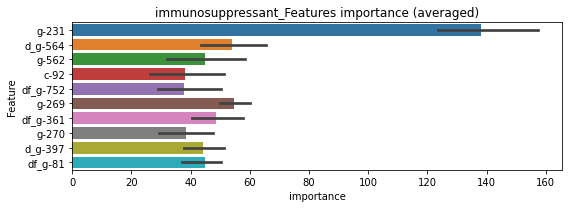

len(train_index) : 3866
len(valid_index) : 3867
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.022153	valid_1's binary_logloss: 0.0605253
[200]	training's binary_logloss: 0.00394073	valid_1's binary_logloss: 0.0422388
[300]	training's binary_logloss: 0.00115662	valid_1's binary_logloss: 0.0392802
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00116777	valid_1's binary_logloss: 0.0392753


len(train_index) : 3867
len(valid_index) : 3866
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214453	valid_1's binary_logloss: 0.0513999
[200]	training's binary_logloss: 0.00374966	valid_1's binary_logloss: 0.0315357
[300]	training's binary_logloss: 0.00108046	valid_1's binary_logloss: 0.0265199
[400]	training's binary_logloss: 0.000524777	valid_1's binary_logloss: 0.0254316
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000512767	valid_1's binary_logloss: 0.0253847


immunosuppressant logloss: 0.03233090248586864


neg labels: 3289 → selected neg labels: 3284


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313676	valid_1's binary_logloss: 0.0537728
[200]	training's binary_logloss: 0.00451085	valid_1's binary_logloss: 0.0175449
[300]	training's binary_logloss: 0.00126202	valid_1's binary_logloss: 0.0103661
[400]	training's binary_logloss: 0.000625895	valid_1's binary_logloss: 0.00824548
[500]	training's binary_logloss: 0.000433268	valid_1's binary_logloss: 0.00758912
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000442646	valid_1's binary_logloss: 0.00752747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316256	valid_1's binary_logloss: 0.0529946
[200]	training's binary_logloss: 0.0045526	valid_1's binary_logloss: 0.0138447
[300]	training's binary_logloss: 0.00126959	valid_1's binary_logloss: 0.0062889
[400]	training's binary_logloss: 0.000615478	valid_1's binary_logloss: 0.00482829
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0028396, Threshold: 0.0044978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00405, conf_1:0.00495
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0044978
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.0144978
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_3: 0.0244978
threshold: 0.0244978, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315108	valid_1's binary_logloss: 0.0559325
[200]	training's binary_logloss: 0.00431528	valid_1's binary_logloss: 0.0176767
[300]	training's binary_logloss: 0.00122317	valid_1's binary_logloss: 0.0111588
[400]	training's binary_logloss: 0.000606314	valid_1's binary_logloss: 0.00866071
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000483345	valid_1's binary_logloss: 0.00799211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309936	valid_1's binary_logloss: 0.0504703
[200]	training's binary_logloss: 0.00433606	valid_1's binary_logloss: 0.0139335
[300]	training's binary_logloss: 0.00125923	valid_1's binary_logloss: 0.00760638
[400]	training's binary_logloss: 0.000646375	valid_1's binary_logloss: 0.00644325
[500]	training's binary_logloss: 0.000428199	valid_1's binary_logloss: 0.00537417
[600]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0278022, Threshold: 0.0244978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0047715 Vs.target_rate: 0.00126
Num_p_label: 19.0, conf_0:0.02205, conf_1:0.02695
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_1: 0.0244978
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_2: 0.0344978
threshold: 0.0344978, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315108	valid_1's binary_logloss: 0.0559325
[200]	training's binary_logloss: 0.00431528	valid_1's binary_logloss: 0.0176767
[300]	training's binary_logloss: 0.00122317	valid_1's binary_logloss: 0.0111588
[400]	training's binary_logloss: 0.000606314	valid_1's binary_logloss: 0.00866071
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000483345	valid_1's binary_logloss: 0.00799211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309936	valid_1's binary_logloss: 0.0504703
[200]	training's binary_logloss: 0.00433606	valid_1's binary_logloss: 0.0139335
[300]	training's binary_logloss: 0.00125923	valid_1's binary_logloss: 0.00760638
[400]	training's binary_logloss: 0.000646375	valid_1's binary_logloss: 0.00644325
[500]	training's binary_logloss: 0.000428199	valid_1's binary_logloss: 0.00537417
[600]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0278022, Threshold: 0.0344978, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00126
Num_p_label: 9.0, conf_0:0.03105, conf_1:0.03795
threshold: 0.0344978, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


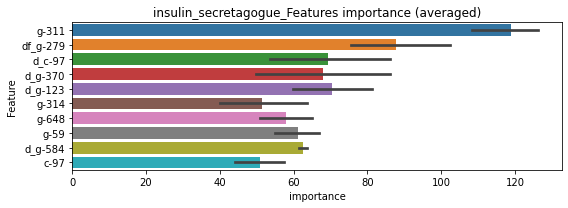

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172842	valid_1's binary_logloss: 0.0362268
[200]	training's binary_logloss: 0.00245196	valid_1's binary_logloss: 0.0157496
[300]	training's binary_logloss: 0.000677249	valid_1's binary_logloss: 0.0117405
[400]	training's binary_logloss: 0.000323223	valid_1's binary_logloss: 0.0108437
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000272773	valid_1's binary_logloss: 0.010724


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179661	valid_1's binary_logloss: 0.0275912
[200]	training's binary_logloss: 0.0024902	valid_1's binary_logloss: 0.00782647
[300]	training's binary_logloss: 0.000698392	valid_1's binary_logloss: 0.00468125
[400]	training's binary_logloss: 0.000338086	valid_1's binary_logloss: 0.00390238
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000255296	valid_1's binary_logloss: 0.00371105


insulin_secretagogue logloss: 0.007217536252557966


neg labels: 3289 → selected neg labels: 3281


insulin_sensitizer, len(trt): 51, len(othr): 3281, target_rate: 0.0021416 → Adj_target_rate: 0.0023748
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345236	valid_1's binary_logloss: 0.0863784
[200]	training's binary_logloss: 0.0053644	valid_1's binary_logloss: 0.0587933
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00367525	valid_1's binary_logloss: 0.0581181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365549	valid_1's binary_logloss: 0.0709944
[200]	training's binary_logloss: 0.00585072	valid_1's binary_logloss: 0.0317888
[300]	training's binary_logloss: 0.00171239	valid_1's binary_logloss: 0.0247237
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000918202	valid_1's binary_logloss: 0.0228972


1 / 3 AUC score:0.995
y_Threshold: 0.0142452, Threshold: 0.0248667, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 642/3777
p_label_rate: 0.0200904 Vs.target_rate: 0.00214
Num_p_label: 80.0, conf_0:0.02238, conf_1:0.02735
Num_p_label: 80.0, Expected: 8.5, Adj_threshold_1: 0.0248667
Num_p_label: 44.0, Expected: 8.5, Adj_threshold_2: 0.0348667
Num_p_label: 26.0, Expected: 8.5, Adj_threshold_3: 0.0448667
Num_p_label: 20.0, Expected: 8.5, Adj_threshold_4: 0.0548667
Num_p_label: 16.0, Expected: 8.5, Adj_threshold_5: 0.0648667
threshold: 0.0648667, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 642.0/3777, y_label_rate: 0.1699762
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328695	valid_1's binary_logloss: 0.060674
[200]	training's binary_logloss: 0.00491555	valid_1's binary_logloss: 0.0246838
[300]	training's binary_logloss: 0.00143639	valid_1's binary_logloss: 0.0184998
[400]	training's binary_logloss: 0.000728375	valid_1's binary_logloss: 0.0170817
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000648239	valid_1's binary_logloss: 0.0169683
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342498	valid_1's binary_logloss: 0.0596124
[200]	training's binary_logloss: 0.00543005	valid_1's binary_logloss: 0.01919
[300]	training's binary_logloss: 0.00159335	valid_1's binary_logloss: 0.0101614
[400]	training's binary_logloss: 0.000784088	valid_1's binary_logloss: 0.0070994
[500]	training's binary_logloss: 0.000527633	valid_1's binary_logloss: 0.0062981
Early stopping, best iteration is:
[527]	tra

2 / 3 AUC score:1.000
y_Threshold: 0.0426252, Threshold: 0.0648667, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0060271 Vs.target_rate: 0.00214
Num_p_label: 24.0, conf_0:0.05838, conf_1:0.07135
threshold: 0.0648667, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 639.0/3771, y_label_rate: 0.1694511
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329035	valid_1's binary_logloss: 0.0639551
[200]	training's binary_logloss: 0.00491318	valid_1's binary_logloss: 0.0241209
[300]	training's binary_logloss: 0.00144301	valid_1's binary_logloss: 0.0162451
[400]	training's binary_logloss: 0.000728492	valid_1's binary_logloss: 0.0140844
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000660933	valid_1's binary_logloss: 0.0137291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338974	valid_1's binary_logloss: 0.052583
[200]	training's binary_logloss: 0.00516082	valid_1's binary_logloss: 0.0136512
[300]	training's binary_logloss: 0.00151078	valid_1's binary_logloss: 0.00675263
[400]	training's binary_logloss: 0.00075211	valid_1's binary_logloss: 0.00488136
[500]	training's binary_logloss: 0.000506797	valid_1's binary_logloss: 0.00412256
Early stopping, best iteration is:
[535]

3 / 3 AUC score:1.000
y_Threshold: 0.0859243, Threshold: 0.0648667, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 638.0/3769
p_label_rate: 0.0055249 Vs.target_rate: 0.00214
Num_p_label: 22.0, conf_0:0.05838, conf_1:0.07135
threshold: 0.0648667, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 660.0/7751, y_label_rate: 0.0851503


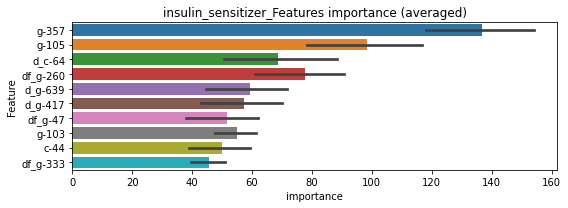

len(train_index) : 3875
len(valid_index) : 3876
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183676	valid_1's binary_logloss: 0.0383943
[200]	training's binary_logloss: 0.00261953	valid_1's binary_logloss: 0.019098
[300]	training's binary_logloss: 0.000782336	valid_1's binary_logloss: 0.0165535
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000655163	valid_1's binary_logloss: 0.0163848


len(train_index) : 3876
len(valid_index) : 3875
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187541	valid_1's binary_logloss: 0.0375645
[200]	training's binary_logloss: 0.00273235	valid_1's binary_logloss: 0.016292
[300]	training's binary_logloss: 0.000802817	valid_1's binary_logloss: 0.0131618
[400]	training's binary_logloss: 0.000409184	valid_1's binary_logloss: 0.0125324
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.000427646	valid_1's binary_logloss: 0.0124801


insulin_sensitizer logloss: 0.014432725998508793


neg labels: 3289 → selected neg labels: 3282


integrin_inhibitor, len(trt): 42, len(othr): 3282, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405534	valid_1's binary_logloss: 0.0799479
[200]	training's binary_logloss: 0.00706583	valid_1's binary_logloss: 0.0331816
[300]	training's binary_logloss: 0.00192146	valid_1's binary_logloss: 0.0213145
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00180837	valid_1's binary_logloss: 0.020754
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414658	valid_1's binary_logloss: 0.0742678
[200]	training's binary_logloss: 0.00752916	valid_1's binary_logloss: 0.0283427
[300]	training's binary_logloss: 0.00206574	valid_1's binary_logloss: 0.0156139
[400]	training's binary_logloss: 0.00091004	valid_1's binary_logloss: 0.0115167
[500]	training's binary_logloss: 0.000579764	valid_1's binary_logloss: 0.0100103
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000587386	valid_1's binary_logloss: 0.00995983


1 / 3 AUC score:1.000
y_Threshold: 0.0068606, Threshold: 0.0077216, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0200904 Vs.target_rate: 0.00176
Num_p_label: 80.0, conf_0:0.00695, conf_1:0.00849
Num_p_label: 80.0, Expected: 7.0, Adj_threshold_1: 0.0077216
Num_p_label: 5.0, Expected: 7.0, Adj_threshold_2: 0.0177216
threshold: 0.0177216, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0402055	valid_1's binary_logloss: 0.0713344
[200]	training's binary_logloss: 0.00645944	valid_1's binary_logloss: 0.0244237
[300]	training's binary_logloss: 0.00183095	valid_1's binary_logloss: 0.0159039
[400]	training's binary_logloss: 0.000882774	valid_1's binary_logloss: 0.0124242
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00081307	valid_1's binary_logloss: 0.0121478
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416755	valid_1's binary_logloss: 0.0772048
[200]	training's binary_logloss: 0.0067702	valid_1's binary_logloss: 0.0288173
[300]	training's binary_logloss: 0.00188967	valid_1's binary_logloss: 0.0184591
[400]	training's binary_logloss: 0.000892053	valid_1's binary_logloss: 0.0153278
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000805644	valid_1's binary_logloss: 0.0149575


2 / 3 AUC score:1.000
y_Threshold: 0.0220529, Threshold: 0.0177216, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0047715 Vs.target_rate: 0.00176
Num_p_label: 19.0, conf_0:0.01595, conf_1:0.01949
threshold: 0.0177216, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401239	valid_1's binary_logloss: 0.0813115
[200]	training's binary_logloss: 0.00656383	valid_1's binary_logloss: 0.0391605
[300]	training's binary_logloss: 0.00184404	valid_1's binary_logloss: 0.0297061
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00110484	valid_1's binary_logloss: 0.0274838
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408105	valid_1's binary_logloss: 0.0737541
[200]	training's binary_logloss: 0.00674932	valid_1's binary_logloss: 0.0291668
[300]	training's binary_logloss: 0.0018883	valid_1's binary_logloss: 0.0203505
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00112083	valid_1's binary_logloss: 0.0183667


3 / 3 AUC score:1.000
y_Threshold: 0.0221180, Threshold: 0.0177216, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0075339 Vs.target_rate: 0.00176
Num_p_label: 30.0, conf_0:0.01595, conf_1:0.01949
Num_p_label: 30.0, Expected: 7.0, Adj_threshold_1: 0.0177216
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_2: 0.0277216
threshold: 0.0277216, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 661.0/7774, y_label_rate: 0.0850270


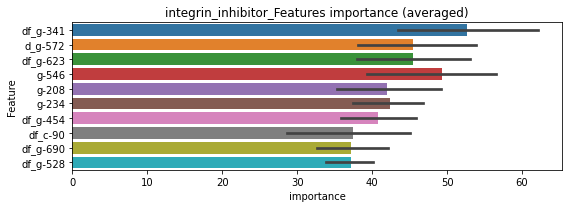

len(train_index) : 3887
len(valid_index) : 3887
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228636	valid_1's binary_logloss: 0.0487261
[200]	training's binary_logloss: 0.00364436	valid_1's binary_logloss: 0.026734
[300]	training's binary_logloss: 0.0009869	valid_1's binary_logloss: 0.0223984
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000897813	valid_1's binary_logloss: 0.0222627


len(train_index) : 3887
len(valid_index) : 3887
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224797	valid_1's binary_logloss: 0.0448262
[200]	training's binary_logloss: 0.00391255	valid_1's binary_logloss: 0.0197498
[300]	training's binary_logloss: 0.00106967	valid_1's binary_logloss: 0.0137914
[400]	training's binary_logloss: 0.00048748	valid_1's binary_logloss: 0.0118773
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000435587	valid_1's binary_logloss: 0.0116676


integrin_inhibitor logloss: 0.01696514700367136


neg labels: 3289 → selected neg labels: 3274


jak_inhibitor, len(trt): 92, len(othr): 3274, target_rate: 0.0038633 → Adj_target_rate: 0.0039212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364266	valid_1's binary_logloss: 0.086843
[200]	training's binary_logloss: 0.00612338	valid_1's binary_logloss: 0.0488066
[300]	training's binary_logloss: 0.00185292	valid_1's binary_logloss: 0.0388615
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00109959	valid_1's binary_logloss: 0.0365254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038439	valid_1's binary_logloss: 0.0791115
[200]	training's binary_logloss: 0.00652093	valid_1's binary_logloss: 0.0357796
[300]	training's binary_logloss: 0.00193746	valid_1's binary_logloss: 0.0231575
[400]	training's binary_logloss: 0.000958941	valid_1's binary_logloss: 0.0195459
[500]	training's binary_logloss: 0.000632481	valid_1's binary_logloss: 0.0177504
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000559755	valid_1's binary_logloss: 0.017185


1 / 3 AUC score:0.999
y_Threshold: 0.0147170, Threshold: 0.0385735, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 652/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00386
Num_p_label: 80.0, conf_0:0.03472, conf_1:0.04243
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_1: 0.0385735
Num_p_label: 52.0, Expected: 15.4, Adj_threshold_2: 0.0485735
Num_p_label: 44.0, Expected: 15.4, Adj_threshold_3: 0.0585735
Num_p_label: 38.0, Expected: 15.4, Adj_threshold_4: 0.0685735
Num_p_label: 31.0, Expected: 15.4, Adj_threshold_5: 0.0785735
Num_p_label: 22.0, Expected: 15.4, Adj_threshold_6: 0.0885735
threshold: 0.0885735, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 652.0/3792, y_label_rate: 0.1719409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351222	valid_1's binary_logloss: 0.0756253
[200]	training's binary_logloss: 0.00539402	valid_1's binary_logloss: 0.0370191
[300]	training's binary_logloss: 0.00159201	valid_1's binary_logloss: 0.0277178
[400]	training's binary_logloss: 0.000785043	valid_1's binary_logloss: 0.024303
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000767006	valid_1's binary_logloss: 0.02426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357468	valid_1's binary_logloss: 0.0719324
[200]	training's binary_logloss: 0.0055338	valid_1's binary_logloss: 0.031887
[300]	training's binary_logloss: 0.00162958	valid_1's binary_logloss: 0.0235007
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000959808	valid_1's binary_logloss: 0.0204793


2 / 3 AUC score:0.999
y_Threshold: 0.1219586, Threshold: 0.0885735, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 642.0/3772
p_label_rate: 0.0331492 Vs.target_rate: 0.00386
Num_p_label: 132.0, conf_0:0.07972, conf_1:0.09743
Num_p_label: 132.0, Expected: 15.4, Adj_threshold_1: 0.0885735
Num_p_label: 122.0, Expected: 15.4, Adj_threshold_2: 0.0985735
Num_p_label: 115.0, Expected: 15.4, Adj_threshold_3: 0.1085735
Num_p_label: 107.0, Expected: 15.4, Adj_threshold_4: 0.1185735
Num_p_label: 98.0, Expected: 15.4, Adj_threshold_5: 0.1285735
Num_p_label: 90.0, Expected: 15.4, Adj_threshold_6: 0.1385735
Num_p_label: 80.0, Expected: 15.4, Adj_threshold_7: 0.1485735
Num_p_label: 73.0, Expected: 15.4, Adj_threshold_8: 0.1585735
Num_p_label: 68.0, Expected: 15.4, Adj_threshold_9: 0.1685735
Num_p_label: 64.0, Expected: 15.4, Adj_threshold_10: 0.1785735
threshold: 0.1885735, positive_p_label: 63.0/3982, p_label_rate: 0.0158212
positive_y_label: 642.0/3772, y_label_rate: 0.1

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331072	valid_1's binary_logloss: 0.0750683
[200]	training's binary_logloss: 0.00493558	valid_1's binary_logloss: 0.0421386
[300]	training's binary_logloss: 0.00143735	valid_1's binary_logloss: 0.0367622
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00152118	valid_1's binary_logloss: 0.036697
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345041	valid_1's binary_logloss: 0.0666694
[200]	training's binary_logloss: 0.0051665	valid_1's binary_logloss: 0.0286484
[300]	training's binary_logloss: 0.0015094	valid_1's binary_logloss: 0.0218096
[400]	training's binary_logloss: 0.000763021	valid_1's binary_logloss: 0.0191922
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00056297	valid_1's binary_logloss: 0.0182431


3 / 3 AUC score:0.998
y_Threshold: 0.1123917, Threshold: 0.1885735, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 628.0/3744
p_label_rate: 0.0296334 Vs.target_rate: 0.00386
Num_p_label: 118.0, conf_0:0.16972, conf_1:0.20743
Num_p_label: 118.0, Expected: 15.4, Adj_threshold_1: 0.1885735
Num_p_label: 115.0, Expected: 15.4, Adj_threshold_2: 0.1985735
Num_p_label: 111.0, Expected: 15.4, Adj_threshold_3: 0.2085735
Num_p_label: 109.0, Expected: 15.4, Adj_threshold_4: 0.2185735
Num_p_label: 102.0, Expected: 15.4, Adj_threshold_5: 0.2285735
Num_p_label: 97.0, Expected: 15.4, Adj_threshold_6: 0.2385735
Num_p_label: 96.0, Expected: 15.4, Adj_threshold_7: 0.2485735
Num_p_label: 92.0, Expected: 15.4, Adj_threshold_8: 0.2585735
Num_p_label: 88.0, Expected: 15.4, Adj_threshold_9: 0.2685735
Num_p_label: 82.0, Expected: 15.4, Adj_threshold_10: 0.2785735
threshold: 0.2885735, positive_p_label: 81.0/3982, p_label_rate: 0.0203415
positive_y_label: 709.0/7726, y_label_rate: 0.

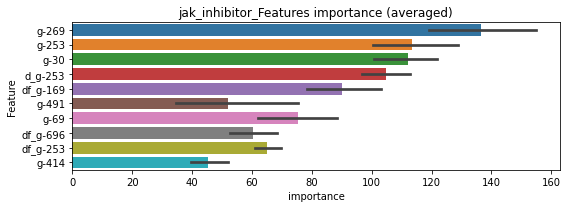

len(train_index) : 3863
len(valid_index) : 3863
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202075	valid_1's binary_logloss: 0.0420512
[200]	training's binary_logloss: 0.00325013	valid_1's binary_logloss: 0.0201732
[300]	training's binary_logloss: 0.000968192	valid_1's binary_logloss: 0.0152295
[400]	training's binary_logloss: 0.000489623	valid_1's binary_logloss: 0.0138969
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000445466	valid_1's binary_logloss: 0.01379


len(train_index) : 3863
len(valid_index) : 3863
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191048	valid_1's binary_logloss: 0.0477991
[200]	training's binary_logloss: 0.00304477	valid_1's binary_logloss: 0.0288184
[300]	training's binary_logloss: 0.000915554	valid_1's binary_logloss: 0.0238997
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.000777308	valid_1's binary_logloss: 0.0234823


jak_inhibitor logloss: 0.018636116917148907


neg labels: 3289 → selected neg labels: 3272


kit_inhibitor, len(trt): 273, len(othr): 3272, target_rate: 0.0114638 → Adj_target_rate: 0.0098841
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440752	valid_1's binary_logloss: 0.116562
[200]	training's binary_logloss: 0.00845937	valid_1's binary_logloss: 0.0868714
[300]	training's binary_logloss: 0.0026491	valid_1's binary_logloss: 0.0826033
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00288729	valid_1's binary_logloss: 0.0824146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431085	valid_1's binary_logloss: 0.110569
[200]	training's binary_logloss: 0.00788459	valid_1's binary_logloss: 0.0834946
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.00590955	valid_1's binary_logloss: 0.0825965


1 / 3 AUC score:0.986
y_Threshold: 0.0323739, Threshold: 0.1733044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 172 → Positive_corect_labels: 634/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.01146
Num_p_label: 80.0, conf_0:0.15597, conf_1:0.19063
threshold: 0.1733044, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 634.0/3754, y_label_rate: 0.1688865
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036642	valid_1's binary_logloss: 0.0736673
[200]	training's binary_logloss: 0.00611037	valid_1's binary_logloss: 0.0387201
[300]	training's binary_logloss: 0.00187037	valid_1's binary_logloss: 0.0313996
[400]	training's binary_logloss: 0.000902784	valid_1's binary_logloss: 0.0292667
[500]	training's binary_logloss: 0.000587951	valid_1's binary_logloss: 0.0280776
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00059751	valid_1's binary_logloss: 0.0280428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371292	valid_1's binary_logloss: 0.0770324
[200]	training's binary_logloss: 0.00615303	valid_1's binary_logloss: 0.0464319
[300]	training's binary_logloss: 0.00186455	valid_1's binary_logloss: 0.0406046
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00186455	valid_1's binary_logloss: 0.0406046


2 / 3 AUC score:0.998
y_Threshold: 0.1111946, Threshold: 0.1733044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 620.0/3726
p_label_rate: 0.0276243 Vs.target_rate: 0.01146
Num_p_label: 110.0, conf_0:0.15597, conf_1:0.19063
threshold: 0.1733044, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 620.0/3726, y_label_rate: 0.1663983
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322619	valid_1's binary_logloss: 0.0742637
[200]	training's binary_logloss: 0.00498064	valid_1's binary_logloss: 0.0486014
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00362848	valid_1's binary_logloss: 0.0477749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344953	valid_1's binary_logloss: 0.0630509
[200]	training's binary_logloss: 0.00545684	valid_1's binary_logloss: 0.0315334
[300]	training's binary_logloss: 0.00167154	valid_1's binary_logloss: 0.0252192
[400]	training's binary_logloss: 0.000804699	valid_1's binary_logloss: 0.0223363
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.000815753	valid_1's binary_logloss: 0.022289


3 / 3 AUC score:0.994
y_Threshold: 0.0983641, Threshold: 0.1733044, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 608.0/3702
p_label_rate: 0.0321447 Vs.target_rate: 0.01146
Num_p_label: 128.0, conf_0:0.15597, conf_1:0.19063
threshold: 0.1733044, positive_p_label: 128.0/3982, p_label_rate: 0.0321447
positive_y_label: 736.0/7684, y_label_rate: 0.0957834


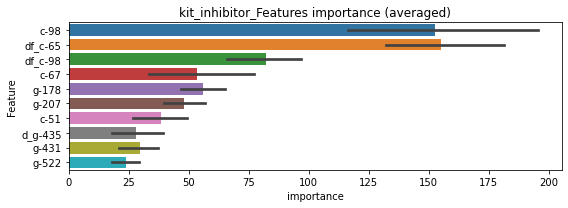

len(train_index) : 3842
len(valid_index) : 3842
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201518	valid_1's binary_logloss: 0.0462391
[200]	training's binary_logloss: 0.00337841	valid_1's binary_logloss: 0.0277107
[300]	training's binary_logloss: 0.000986162	valid_1's binary_logloss: 0.0230027
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000684462	valid_1's binary_logloss: 0.0219799


len(train_index) : 3842
len(valid_index) : 3842
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198986	valid_1's binary_logloss: 0.0426178
[200]	training's binary_logloss: 0.00334827	valid_1's binary_logloss: 0.0254342
[300]	training's binary_logloss: 0.000975844	valid_1's binary_logloss: 0.0207792
[400]	training's binary_logloss: 0.000461429	valid_1's binary_logloss: 0.0193412
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00045008	valid_1's binary_logloss: 0.0192456


kit_inhibitor logloss: 0.020612750653593095


neg labels: 3289 → selected neg labels: 3288


laxative, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157041	valid_1's binary_logloss: 0.0172252
[200]	training's binary_logloss: 0.00132232	valid_1's binary_logloss: 0.00174526
[300]	training's binary_logloss: 0.000362363	valid_1's binary_logloss: 0.000559755
[400]	training's binary_logloss: 0.000221119	valid_1's binary_logloss: 0.000363632
[500]	training's binary_logloss: 0.000196234	valid_1's binary_logloss: 0.000330012
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000194655	valid_1's binary_logloss: 0.000328127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015812	valid_1's binary_logloss: 0.0166766
[200]	training's binary_logloss: 0.0013338	valid_1's binary_logloss: 0.00159981
[300]	training's binary_logloss: 0.00037657	valid_1's binary_logloss: 0.000499268
[400]	training's binary_logloss: 0.000218487	valid_1's binary_logloss: 0.000301818
[500]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0005379, Threshold: 0.0008482, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00076, conf_1:0.00093
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008482
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_2: 0.0108482
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.0208482
threshold: 0.0208482, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160066	valid_1's binary_logloss: 0.0176079
[200]	training's binary_logloss: 0.00131366	valid_1's binary_logloss: 0.00167532
[300]	training's binary_logloss: 0.000356351	valid_1's binary_logloss: 0.000495114
[400]	training's binary_logloss: 0.000220506	valid_1's binary_logloss: 0.00032259
[500]	training's binary_logloss: 0.000192142	valid_1's binary_logloss: 0.000285156
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000191909	valid_1's binary_logloss: 0.000285018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016065	valid_1's binary_logloss: 0.0169707
[200]	training's binary_logloss: 0.00130965	valid_1's binary_logloss: 0.00157199
[300]	training's binary_logloss: 0.000351452	valid_1's binary_logloss: 0.000470523
[400]	training's binary_logloss: 0.00021753	valid_1's binary_logloss: 0.00030771
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.1602899, Threshold: 0.0208482, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00025
Num_p_label: 13.0, conf_0:0.01876, conf_1:0.02293
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.0208482
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0308482
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.0408482
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0508482
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0608482
threshold: 0.0608482, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160066	valid_1's binary_logloss: 0.0176079
[200]	training's binary_logloss: 0.00131366	valid_1's binary_logloss: 0.00167532
[300]	training's binary_logloss: 0.000356351	valid_1's binary_logloss: 0.000495114
[400]	training's binary_logloss: 0.000220506	valid_1's binary_logloss: 0.00032259
[500]	training's binary_logloss: 0.000192142	valid_1's binary_logloss: 0.000285156
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000191909	valid_1's binary_logloss: 0.000285018
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016065	valid_1's binary_logloss: 0.0169707
[200]	training's binary_logloss: 0.00130965	valid_1's binary_logloss: 0.00157199
[300]	training's binary_logloss: 0.000351452	valid_1's binary_logloss: 0.000470523
[400]	training's binary_logloss: 0.00021753	valid_1's binary_logloss: 0.00030771
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.1602899, Threshold: 0.0608482, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.05476, conf_1:0.06693
threshold: 0.0608482, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


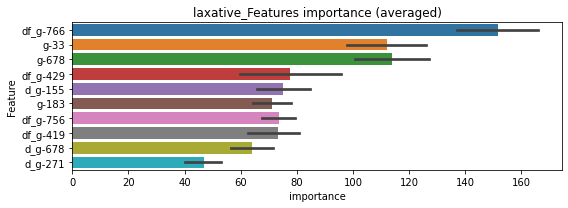

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00853058	valid_1's binary_logloss: 0.00964339
[200]	training's binary_logloss: 0.00069436	valid_1's binary_logloss: 0.00191901
[300]	training's binary_logloss: 0.000185611	valid_1's binary_logloss: 0.00148775
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000179862	valid_1's binary_logloss: 0.00148202


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00848699	valid_1's binary_logloss: 0.0103369
[200]	training's binary_logloss: 0.00067972	valid_1's binary_logloss: 0.00195922
[300]	training's binary_logloss: 0.00018216	valid_1's binary_logloss: 0.00134265
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00018216	valid_1's binary_logloss: 0.00134265


laxative logloss: 0.0014123447848329097


neg labels: 3289 → selected neg labels: 3288


leukotriene_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155962	valid_1's binary_logloss: 0.0162596
[200]	training's binary_logloss: 0.00128837	valid_1's binary_logloss: 0.00145043
[300]	training's binary_logloss: 0.000349423	valid_1's binary_logloss: 0.000424004
[400]	training's binary_logloss: 0.000214941	valid_1's binary_logloss: 0.000270852
[500]	training's binary_logloss: 0.000188589	valid_1's binary_logloss: 0.000240906
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000186875	valid_1's binary_logloss: 0.000239006
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156665	valid_1's binary_logloss: 0.0166347
[200]	training's binary_logloss: 0.001276	valid_1's binary_logloss: 0.0015983
[300]	training's binary_logloss: 0.000342805	valid_1's binary_logloss: 0.000507596
[400]	training's binary_logloss: 0.000211788	valid_1's binary_logloss: 0.000323175
Early stopping, best iterati

1 / 3 AUC score:1.000
y_Threshold: 0.0006068, Threshold: 0.0008643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00078, conf_1:0.00095
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008643
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0108643
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0208643
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.0308643
threshold: 0.0308643, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158086	valid_1's binary_logloss: 0.0164101
[200]	training's binary_logloss: 0.00126451	valid_1's binary_logloss: 0.00145356
[300]	training's binary_logloss: 0.000336746	valid_1's binary_logloss: 0.000427908
[400]	training's binary_logloss: 0.000210563	valid_1's binary_logloss: 0.000277534
[500]	training's binary_logloss: 0.000182999	valid_1's binary_logloss: 0.000243769
[600]	training's binary_logloss: 0.000179731	valid_1's binary_logloss: 0.000239893
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.000179115	valid_1's binary_logloss: 0.00023913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160103	valid_1's binary_logloss: 0.0165758
[200]	training's binary_logloss: 0.0012893	valid_1's binary_logloss: 0.00136839
[300]	training's binary_logloss: 0.00034222	valid_1's binary_logloss: 0.000371928
[400]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1676981, Threshold: 0.0308643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0027624 Vs.target_rate: 0.00025
Num_p_label: 11.0, conf_0:0.02778, conf_1:0.03395
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_1: 0.0308643
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_2: 0.0408643
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_3: 0.0508643
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.0608643
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0708643
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.0808643
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.0908643
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_8: 0.1008643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.1108643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_10: 0.1208643
threshold: 0.1308643, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= P

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158086	valid_1's binary_logloss: 0.0164101
[200]	training's binary_logloss: 0.00126451	valid_1's binary_logloss: 0.00145356
[300]	training's binary_logloss: 0.000336746	valid_1's binary_logloss: 0.000427908
[400]	training's binary_logloss: 0.000210563	valid_1's binary_logloss: 0.000277534
[500]	training's binary_logloss: 0.000182999	valid_1's binary_logloss: 0.000243769
[600]	training's binary_logloss: 0.000179731	valid_1's binary_logloss: 0.000239893
Early stopping, best iteration is:
[634]	training's binary_logloss: 0.000179115	valid_1's binary_logloss: 0.00023913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160103	valid_1's binary_logloss: 0.0165758
[200]	training's binary_logloss: 0.0012893	valid_1's binary_logloss: 0.00136839
[300]	training's binary_logloss: 0.00034222	valid_1's binary_logloss: 0.000371928
[400]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1676981, Threshold: 0.1308643, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00025
Num_p_label: 4.0, conf_0:0.11778, conf_1:0.14395
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_1: 0.1308643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.1408643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.1508643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.1608643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.1708643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.1808643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.1908643
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.2008643
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.2108643
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.2208643
threshold: 0.2308643, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7795, y_label_rate: 0.0846697


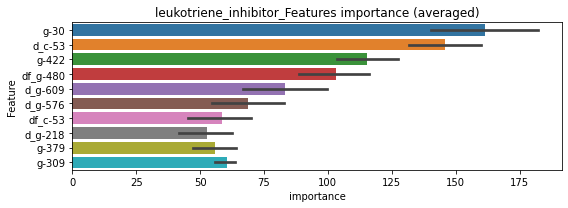

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00841314	valid_1's binary_logloss: 0.01008
[200]	training's binary_logloss: 0.000658866	valid_1's binary_logloss: 0.0022631
[300]	training's binary_logloss: 0.000173565	valid_1's binary_logloss: 0.00184003
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000180996	valid_1's binary_logloss: 0.00182497


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00847007	valid_1's binary_logloss: 0.0092104
[200]	training's binary_logloss: 0.000682687	valid_1's binary_logloss: 0.00111856
[300]	training's binary_logloss: 0.000180078	valid_1's binary_logloss: 0.0006925
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000187759	valid_1's binary_logloss: 0.00068685


leukotriene_inhibitor logloss: 0.001255982182780804


neg labels: 3289 → selected neg labels: 3280


leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3280, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0487214	valid_1's binary_logloss: 0.110556
[200]	training's binary_logloss: 0.00937672	valid_1's binary_logloss: 0.0660058
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00477343	valid_1's binary_logloss: 0.0589679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539012	valid_1's binary_logloss: 0.091668
[200]	training's binary_logloss: 0.0111479	valid_1's binary_logloss: 0.0341174
[300]	training's binary_logloss: 0.00316425	valid_1's binary_logloss: 0.0176258
[400]	training's binary_logloss: 0.00140389	valid_1's binary_logloss: 0.0117831
[500]	training's binary_logloss: 0.000856713	valid_1's binary_logloss: 0.0097002
[600]	training's binary_logloss: 0.000628978	valid_1's binary_logloss: 0.00891611
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.000640288	valid_1's binary_logloss: 0.00889422


1 / 3 AUC score:0.996
y_Threshold: 0.0164576, Threshold: 0.0200309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 146 → Positive_corect_labels: 649/3790
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.01803, conf_1:0.02203
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0200309
Num_p_label: 35.0, Expected: 10.4, Adj_threshold_2: 0.0300309
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_3: 0.0400309
threshold: 0.0400309, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3790, y_label_rate: 0.1712401
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483402	valid_1's binary_logloss: 0.102165
[200]	training's binary_logloss: 0.00920448	valid_1's binary_logloss: 0.0440166
[300]	training's binary_logloss: 0.00269336	valid_1's binary_logloss: 0.0288954
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00153139	valid_1's binary_logloss: 0.0248491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510755	valid_1's binary_logloss: 0.093422
[200]	training's binary_logloss: 0.010161	valid_1's binary_logloss: 0.0366252
[300]	training's binary_logloss: 0.00289192	valid_1's binary_logloss: 0.0209612
[400]	training's binary_logloss: 0.00132611	valid_1's binary_logloss: 0.0162945
[500]	training's binary_logloss: 0.000817608	valid_1's binary_logloss: 0.0139326
[600]	training's binary_logloss: 0.000619508	valid_1's binary_logloss: 0.0131466
Early stopping, best iteration is:
[615]	traini

2 / 3 AUC score:1.000
y_Threshold: 0.0639929, Threshold: 0.0400309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 644.0/3780
p_label_rate: 0.0057760 Vs.target_rate: 0.00260
Num_p_label: 23.0, conf_0:0.03603, conf_1:0.04403
threshold: 0.0400309, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 644.0/3780, y_label_rate: 0.1703704
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0488005	valid_1's binary_logloss: 0.0938111
[200]	training's binary_logloss: 0.00957941	valid_1's binary_logloss: 0.0455172
[300]	training's binary_logloss: 0.00278084	valid_1's binary_logloss: 0.0304069
[400]	training's binary_logloss: 0.00127515	valid_1's binary_logloss: 0.0256554
[500]	training's binary_logloss: 0.000791008	valid_1's binary_logloss: 0.0239605
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.0008115	valid_1's binary_logloss: 0.0239154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480424	valid_1's binary_logloss: 0.0919977
[200]	training's binary_logloss: 0.00933404	valid_1's binary_logloss: 0.0382628
[300]	training's binary_logloss: 0.00270014	valid_1's binary_logloss: 0.0240875
[400]	training's binary_logloss: 0.00125559	valid_1's binary_logloss: 0.0193591
[500]	training's binary_logloss: 0.00078336	v

3 / 3 AUC score:0.999
y_Threshold: 0.0342830, Threshold: 0.0400309, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0050226 Vs.target_rate: 0.00260
Num_p_label: 20.0, conf_0:0.03603, conf_1:0.04403
threshold: 0.0400309, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 661.0/7756, y_label_rate: 0.0852243


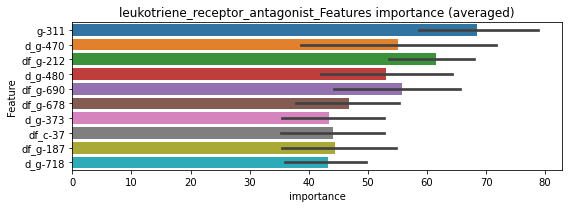

len(train_index) : 3878
len(valid_index) : 3878
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275898	valid_1's binary_logloss: 0.0556172
[200]	training's binary_logloss: 0.00531012	valid_1's binary_logloss: 0.0286474
[300]	training's binary_logloss: 0.00151096	valid_1's binary_logloss: 0.0229882
[400]	training's binary_logloss: 0.000687168	valid_1's binary_logloss: 0.0214623
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000671853	valid_1's binary_logloss: 0.0214094


len(train_index) : 3878
len(valid_index) : 3878
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271939	valid_1's binary_logloss: 0.0600698
[200]	training's binary_logloss: 0.00509126	valid_1's binary_logloss: 0.0349901
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00174942	valid_1's binary_logloss: 0.0307066


leukotriene_receptor_antagonist logloss: 0.026058007411482377


neg labels: 3289 → selected neg labels: 3287


lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190565	valid_1's binary_logloss: 0.0250229
[200]	training's binary_logloss: 0.00196697	valid_1's binary_logloss: 0.00607747
[300]	training's binary_logloss: 0.000554912	valid_1's binary_logloss: 0.00343869
[400]	training's binary_logloss: 0.000307834	valid_1's binary_logloss: 0.00266887
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00027068	valid_1's binary_logloss: 0.0025475
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194962	valid_1's binary_logloss: 0.023788
[200]	training's binary_logloss: 0.00195343	valid_1's binary_logloss: 0.00307587
[300]	training's binary_logloss: 0.000552738	valid_1's binary_logloss: 0.00103499
[400]	training's binary_logloss: 0.000312042	valid_1's binary_logloss: 0.000635409
[500]	training's binary_logloss: 0.00027031	valid_1's binary_logloss: 0.000569461
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0011092, Threshold: 0.0019827, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00178, conf_1:0.00218
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0019827
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0119827
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.0219827
threshold: 0.0219827, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195378	valid_1's binary_logloss: 0.0247494
[200]	training's binary_logloss: 0.00189737	valid_1's binary_logloss: 0.00574021
[300]	training's binary_logloss: 0.000532476	valid_1's binary_logloss: 0.00323844
[400]	training's binary_logloss: 0.000300351	valid_1's binary_logloss: 0.00255634
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000266915	valid_1's binary_logloss: 0.00245237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196892	valid_1's binary_logloss: 0.0240336
[200]	training's binary_logloss: 0.0019367	valid_1's binary_logloss: 0.00296473
[300]	training's binary_logloss: 0.000543279	valid_1's binary_logloss: 0.000944476
[400]	training's binary_logloss: 0.000306046	valid_1's binary_logloss: 0.000564984
[500]	training's binary_logloss: 0.000261578	valid_1's binary_logloss: 0.000498299
Early stopping, best iteratio

2 / 3 AUC score:1.000
y_Threshold: 0.0499129, Threshold: 0.0219827, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0052737 Vs.target_rate: 0.00050
Num_p_label: 21.0, conf_0:0.01978, conf_1:0.02418
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_1: 0.0219827
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0319827
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0419827
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.0519827
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_5: 0.0619827
threshold: 0.0619827, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195378	valid_1's binary_logloss: 0.0247494
[200]	training's binary_logloss: 0.00189737	valid_1's binary_logloss: 0.00574021
[300]	training's binary_logloss: 0.000532476	valid_1's binary_logloss: 0.00323844
[400]	training's binary_logloss: 0.000300351	valid_1's binary_logloss: 0.00255634
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000266915	valid_1's binary_logloss: 0.00245237
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0196892	valid_1's binary_logloss: 0.0240336
[200]	training's binary_logloss: 0.0019367	valid_1's binary_logloss: 0.00296473
[300]	training's binary_logloss: 0.000543279	valid_1's binary_logloss: 0.000944476
[400]	training's binary_logloss: 0.000306046	valid_1's binary_logloss: 0.000564984
[500]	training's binary_logloss: 0.000261578	valid_1's binary_logloss: 0.000498299
Early stopping, best iteratio

3 / 3 AUC score:1.000
y_Threshold: 0.0499129, Threshold: 0.0619827, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.05578, conf_1:0.06818
threshold: 0.0619827, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


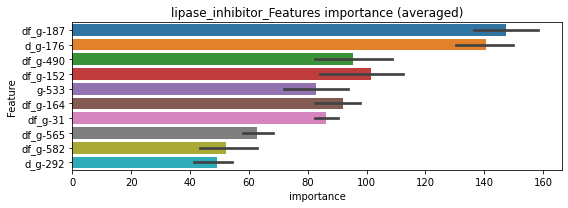

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100309	valid_1's binary_logloss: 0.013691
[200]	training's binary_logloss: 0.000975393	valid_1's binary_logloss: 0.0035679
[300]	training's binary_logloss: 0.000272183	valid_1's binary_logloss: 0.00282951
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.000222109	valid_1's binary_logloss: 0.00278932


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0107104	valid_1's binary_logloss: 0.0133693
[200]	training's binary_logloss: 0.00104084	valid_1's binary_logloss: 0.00272764
[300]	training's binary_logloss: 0.000280786	valid_1's binary_logloss: 0.00168908
[400]	training's binary_logloss: 0.000157226	valid_1's binary_logloss: 0.00148234
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000154227	valid_1's binary_logloss: 0.00147085


lipase_inhibitor logloss: 0.0021300848736085206


neg labels: 3289 → selected neg labels: 3278


lipoxygenase_inhibitor, len(trt): 61, len(othr): 3278, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.051093	valid_1's binary_logloss: 0.105756
[200]	training's binary_logloss: 0.0101946	valid_1's binary_logloss: 0.0520704
[300]	training's binary_logloss: 0.00288636	valid_1's binary_logloss: 0.0388697
[400]	training's binary_logloss: 0.00131427	valid_1's binary_logloss: 0.0347774
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00129134	valid_1's binary_logloss: 0.0347191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514389	valid_1's binary_logloss: 0.103125
[200]	training's binary_logloss: 0.00954053	valid_1's binary_logloss: 0.0467647
[300]	training's binary_logloss: 0.00271428	valid_1's binary_logloss: 0.0330948
[400]	training's binary_logloss: 0.00125112	valid_1's binary_logloss: 0.0275772
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.00106912	valid_1's binary_logloss: 0.0267605


1 / 3 AUC score:0.999
y_Threshold: 0.0103233, Threshold: 0.0137618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3795
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01239, conf_1:0.01514
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0137618
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_2: 0.0237618
Num_p_label: 8.0, Expected: 10.2, Adj_threshold_3: 0.0337618
threshold: 0.0337618, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 652.0/3795, y_label_rate: 0.1718050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04999	valid_1's binary_logloss: 0.104315
[200]	training's binary_logloss: 0.00957293	valid_1's binary_logloss: 0.0522231
[300]	training's binary_logloss: 0.00280261	valid_1's binary_logloss: 0.0402972
[400]	training's binary_logloss: 0.0012858	valid_1's binary_logloss: 0.0353208
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.00106628	valid_1's binary_logloss: 0.0344946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510403	valid_1's binary_logloss: 0.104388
[200]	training's binary_logloss: 0.00939213	valid_1's binary_logloss: 0.0500724
[300]	training's binary_logloss: 0.00263132	valid_1's binary_logloss: 0.0370106
[400]	training's binary_logloss: 0.0012299	valid_1's binary_logloss: 0.0337328
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0012222	valid_1's binary_logloss: 0.0336898


2 / 3 AUC score:0.999
y_Threshold: 0.0292470, Threshold: 0.0337618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0130588 Vs.target_rate: 0.00256
Num_p_label: 52.0, conf_0:0.03039, conf_1:0.03714
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_1: 0.0337618
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_2: 0.0437618
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_3: 0.0537618
threshold: 0.0537618, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 641.0/3773, y_label_rate: 0.1698913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497908	valid_1's binary_logloss: 0.0909113
[200]	training's binary_logloss: 0.00965503	valid_1's binary_logloss: 0.039492
[300]	training's binary_logloss: 0.00270469	valid_1's binary_logloss: 0.027534
[400]	training's binary_logloss: 0.00123893	valid_1's binary_logloss: 0.0243036
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000947217	valid_1's binary_logloss: 0.0233511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048254	valid_1's binary_logloss: 0.0944276
[200]	training's binary_logloss: 0.00916348	valid_1's binary_logloss: 0.0459121
[300]	training's binary_logloss: 0.00259254	valid_1's binary_logloss: 0.0368763
[400]	training's binary_logloss: 0.00119935	valid_1's binary_logloss: 0.0348235
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00117301	valid_1's binary_logloss: 0.0347443


3 / 3 AUC score:0.999
y_Threshold: 0.0251332, Threshold: 0.0537618, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 634.0/3759
p_label_rate: 0.0087896 Vs.target_rate: 0.00256
Num_p_label: 35.0, conf_0:0.04839, conf_1:0.05914
Num_p_label: 35.0, Expected: 10.2, Adj_threshold_1: 0.0537618
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_2: 0.0637618
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_3: 0.0737618
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_4: 0.0837618
threshold: 0.0837618, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 653.0/7741, y_label_rate: 0.0843560


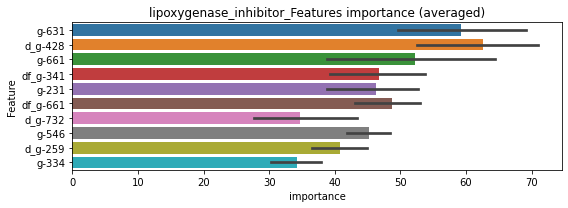

len(train_index) : 3870
len(valid_index) : 3871
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268942	valid_1's binary_logloss: 0.0608992
[200]	training's binary_logloss: 0.00518141	valid_1's binary_logloss: 0.0355115
[300]	training's binary_logloss: 0.00144158	valid_1's binary_logloss: 0.0303821
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00154412	valid_1's binary_logloss: 0.030318


len(train_index) : 3871
len(valid_index) : 3870
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285239	valid_1's binary_logloss: 0.0575119
[200]	training's binary_logloss: 0.00542204	valid_1's binary_logloss: 0.0276772
[300]	training's binary_logloss: 0.00153977	valid_1's binary_logloss: 0.0204925
[400]	training's binary_logloss: 0.000686842	valid_1's binary_logloss: 0.0185421
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000686842	valid_1's binary_logloss: 0.0185421


lipoxygenase_inhibitor logloss: 0.024430805698033776


neg labels: 3289 → selected neg labels: 3288


lxr_agonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0152502	valid_1's binary_logloss: 0.0169294
[200]	training's binary_logloss: 0.00118781	valid_1's binary_logloss: 0.00209849
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000395575	valid_1's binary_logloss: 0.0011139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154411	valid_1's binary_logloss: 0.0163107
[200]	training's binary_logloss: 0.00121355	valid_1's binary_logloss: 0.00138357
[300]	training's binary_logloss: 0.000299419	valid_1's binary_logloss: 0.000379466
[400]	training's binary_logloss: 0.000190595	valid_1's binary_logloss: 0.000253317
[500]	training's binary_logloss: 0.000174064	valid_1's binary_logloss: 0.000234515
[600]	training's binary_logloss: 0.000170313	valid_1's binary_logloss: 0.000230113
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000170034	valid_1's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0007098, Threshold: 0.0022488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00202, conf_1:0.00247
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0022488
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_2: 0.0122488
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_3: 0.0222488
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.0322488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.0422488
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.0522488
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_7: 0.0622488
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.0722488
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.0822488
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_10: 0.0922488
threshold: 0.1022488, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161616	valid_1's binary_logloss: 0.0170023
[200]	training's binary_logloss: 0.00125018	valid_1's binary_logloss: 0.00145011
[300]	training's binary_logloss: 0.000295898	valid_1's binary_logloss: 0.000386207
[400]	training's binary_logloss: 0.000186904	valid_1's binary_logloss: 0.000257644
[500]	training's binary_logloss: 0.000167118	valid_1's binary_logloss: 0.000234457
[600]	training's binary_logloss: 0.000160712	valid_1's binary_logloss: 0.000227081
[700]	training's binary_logloss: 0.000158883	valid_1's binary_logloss: 0.000225094
[800]	training's binary_logloss: 0.0001575	valid_1's binary_logloss: 0.000223705
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.000157176	valid_1's binary_logloss: 0.000223372
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161502	valid_1's binary_logloss: 0.0172512
[200]	training's binary_l

2 / 3 AUC score:1.000
y_Threshold: 0.1933036, Threshold: 0.1022488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00025
Num_p_label: 13.0, conf_0:0.09202, conf_1:0.11247
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.1022488
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.1122488
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_3: 0.1222488
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_4: 0.1322488
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_5: 0.1422488
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_6: 0.1522488
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_7: 0.1622488
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_8: 0.1722488
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_9: 0.1822488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.1922488
threshold: 0.2022488, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161616	valid_1's binary_logloss: 0.0170023
[200]	training's binary_logloss: 0.00125018	valid_1's binary_logloss: 0.00145011
[300]	training's binary_logloss: 0.000295898	valid_1's binary_logloss: 0.000386207
[400]	training's binary_logloss: 0.000186904	valid_1's binary_logloss: 0.000257644
[500]	training's binary_logloss: 0.000167118	valid_1's binary_logloss: 0.000234457
[600]	training's binary_logloss: 0.000160712	valid_1's binary_logloss: 0.000227081
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.000160146	valid_1's binary_logloss: 0.000226457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161502	valid_1's binary_logloss: 0.0172512
[200]	training's binary_logloss: 0.00125078	valid_1's binary_logloss: 0.00148815
[300]	training's binary_logloss: 0.000298832	valid_1's binary_logloss: 0.000398321
[400]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.1933055, Threshold: 0.2022488, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025
Num_p_label: 6.0, conf_0:0.18202, conf_1:0.22247
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.2022488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.2122488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.2222488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_4: 0.2322488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.2422488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.2522488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_7: 0.2622488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_8: 0.2722488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_9: 0.2822488
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_10: 0.2922488
threshold: 0.3022488, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7795, y_label_rate: 0.0850545


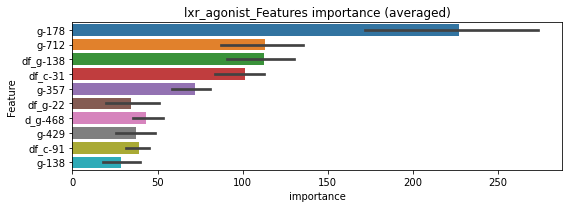

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00852501	valid_1's binary_logloss: 0.0116415
[200]	training's binary_logloss: 0.000649019	valid_1's binary_logloss: 0.00424363
[300]	training's binary_logloss: 0.000159428	valid_1's binary_logloss: 0.00362687
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000140018	valid_1's binary_logloss: 0.00360941


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00870963	valid_1's binary_logloss: 0.00968394
[200]	training's binary_logloss: 0.00070068	valid_1's binary_logloss: 0.00194728
[300]	training's binary_logloss: 0.000172649	valid_1's binary_logloss: 0.0014273
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.000115429	valid_1's binary_logloss: 0.00136035


lxr_agonist logloss: 0.002485025490742186


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0225302	valid_1's binary_logloss: 0.0343128
[200]	training's binary_logloss: 0.00259846	valid_1's binary_logloss: 0.00750264
[300]	training's binary_logloss: 0.000749143	valid_1's binary_logloss: 0.00369452
[400]	training's binary_logloss: 0.000403881	valid_1's binary_logloss: 0.00263434
[500]	training's binary_logloss: 0.000321627	valid_1's binary_logloss: 0.00232386
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000320282	valid_1's binary_logloss: 0.00231851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0227728	valid_1's binary_logloss: 0.0300049
[200]	training's binary_logloss: 0.00264704	valid_1's binary_logloss: 0.00567045
[300]	training's binary_logloss: 0.000750593	valid_1's binary_logloss: 0.00259649
[400]	training's binary_logloss: 0.000401462	valid_1's binary_logloss: 0.00176441
[500]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0033564, Threshold: 0.0062725, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00565, conf_1:0.00690
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0062725
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_2: 0.0162725
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_3: 0.0262725
Num_p_label: 27.0, Expected: 5.2, Adj_threshold_4: 0.0362725
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_5: 0.0462725
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_6: 0.0562725
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_7: 0.0662725
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_8: 0.0762725
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_9: 0.0862725
Num_p_label: 14.0, Expected: 5.2, Adj_threshold_10: 0.0962725
threshold: 0.1062725, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021917	valid_1's binary_logloss: 0.0292214
[200]	training's binary_logloss: 0.00239086	valid_1's binary_logloss: 0.0049236
[300]	training's binary_logloss: 0.000641954	valid_1's binary_logloss: 0.00191243
[400]	training's binary_logloss: 0.000348385	valid_1's binary_logloss: 0.00124226
[500]	training's binary_logloss: 0.000286268	valid_1's binary_logloss: 0.00109553
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000281844	valid_1's binary_logloss: 0.00108439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216184	valid_1's binary_logloss: 0.027299
[200]	training's binary_logloss: 0.00234205	valid_1's binary_logloss: 0.00429764
[300]	training's binary_logloss: 0.000650178	valid_1's binary_logloss: 0.00149288
[400]	training's binary_logloss: 0.000358488	valid_1's binary_logloss: 0.000932768
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.2666284, Threshold: 0.1062725, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0143144 Vs.target_rate: 0.00130
Num_p_label: 57.0, conf_0:0.09565, conf_1:0.11690
Num_p_label: 57.0, Expected: 5.2, Adj_threshold_1: 0.1062725
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_2: 0.1162725
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_3: 0.1262725
Num_p_label: 56.0, Expected: 5.2, Adj_threshold_4: 0.1362725
Num_p_label: 55.0, Expected: 5.2, Adj_threshold_5: 0.1462725
Num_p_label: 55.0, Expected: 5.2, Adj_threshold_6: 0.1562725
Num_p_label: 52.0, Expected: 5.2, Adj_threshold_7: 0.1662725
Num_p_label: 51.0, Expected: 5.2, Adj_threshold_8: 0.1762725
Num_p_label: 50.0, Expected: 5.2, Adj_threshold_9: 0.1862725
Num_p_label: 49.0, Expected: 5.2, Adj_threshold_10: 0.1962725
threshold: 0.2062725, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021917	valid_1's binary_logloss: 0.0292214
[200]	training's binary_logloss: 0.00239086	valid_1's binary_logloss: 0.0049236
[300]	training's binary_logloss: 0.000641954	valid_1's binary_logloss: 0.00191243
[400]	training's binary_logloss: 0.000348385	valid_1's binary_logloss: 0.00124226
[500]	training's binary_logloss: 0.000286268	valid_1's binary_logloss: 0.00109553
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000281844	valid_1's binary_logloss: 0.00108439
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0216184	valid_1's binary_logloss: 0.027299
[200]	training's binary_logloss: 0.00234205	valid_1's binary_logloss: 0.00429764
[300]	training's binary_logloss: 0.000650178	valid_1's binary_logloss: 0.00149288
[400]	training's binary_logloss: 0.000358488	valid_1's binary_logloss: 0.000932768
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.2666284, Threshold: 0.2062725, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0115520 Vs.target_rate: 0.00130
Num_p_label: 46.0, conf_0:0.18565, conf_1:0.22690
Num_p_label: 46.0, Expected: 5.2, Adj_threshold_1: 0.2062725
Num_p_label: 46.0, Expected: 5.2, Adj_threshold_2: 0.2162725
Num_p_label: 45.0, Expected: 5.2, Adj_threshold_3: 0.2262725
Num_p_label: 44.0, Expected: 5.2, Adj_threshold_4: 0.2362725
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_5: 0.2462725
Num_p_label: 42.0, Expected: 5.2, Adj_threshold_6: 0.2562725
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_7: 0.2662725
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_8: 0.2762725
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_9: 0.2862725
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_10: 0.2962725
threshold: 0.3062725, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 693.0/7790, y_label_rate: 0.0889602


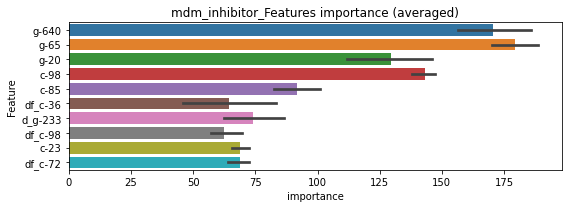

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124555	valid_1's binary_logloss: 0.0249257
[200]	training's binary_logloss: 0.00145053	valid_1's binary_logloss: 0.010385
Early stopping, best iteration is:
[278]	training's binary_logloss: 0.000497299	valid_1's binary_logloss: 0.00824626


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0124322	valid_1's binary_logloss: 0.0196559
[200]	training's binary_logloss: 0.00149003	valid_1's binary_logloss: 0.00737682
[300]	training's binary_logloss: 0.000418014	valid_1's binary_logloss: 0.00532807
[400]	training's binary_logloss: 0.000221858	valid_1's binary_logloss: 0.00494545
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00019372	valid_1's binary_logloss: 0.00485348


mdm_inhibitor logloss: 0.006549870514856619


neg labels: 3289 → selected neg labels: 3278


mek_inhibitor, len(trt): 72, len(othr): 3278, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0279728	valid_1's binary_logloss: 0.0435064
[200]	training's binary_logloss: 0.00392956	valid_1's binary_logloss: 0.0175607
[300]	training's binary_logloss: 0.00111646	valid_1's binary_logloss: 0.014417
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000773665	valid_1's binary_logloss: 0.0141767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282156	valid_1's binary_logloss: 0.0559946
[200]	training's binary_logloss: 0.00373981	valid_1's binary_logloss: 0.0282501
[300]	training's binary_logloss: 0.00105263	valid_1's binary_logloss: 0.0243235
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00075501	valid_1's binary_logloss: 0.0239067


1 / 3 AUC score:0.999
y_Threshold: 0.0036793, Threshold: 0.0098360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3799
p_label_rate: 0.0200904 Vs.target_rate: 0.00302
Num_p_label: 80.0, conf_0:0.00885, conf_1:0.01082
Num_p_label: 80.0, Expected: 12.0, Adj_threshold_1: 0.0098360
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_2: 0.0198360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_3: 0.0298360
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_4: 0.0398360
Num_p_label: 32.0, Expected: 12.0, Adj_threshold_5: 0.0498360
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_6: 0.0598360
Num_p_label: 30.0, Expected: 12.0, Adj_threshold_7: 0.0698360
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_8: 0.0798360
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_9: 0.0898360
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_10: 0.0998360
threshold: 0.1098360, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 654.0/3799, y_label_rate: 0.1721506

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269067	valid_1's binary_logloss: 0.0431716
[200]	training's binary_logloss: 0.00339525	valid_1's binary_logloss: 0.0163144
[300]	training's binary_logloss: 0.000940626	valid_1's binary_logloss: 0.0127498
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.000510001	valid_1's binary_logloss: 0.0119008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027559	valid_1's binary_logloss: 0.0494422
[200]	training's binary_logloss: 0.00342906	valid_1's binary_logloss: 0.0219293
[300]	training's binary_logloss: 0.000960283	valid_1's binary_logloss: 0.0170791
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00086538	valid_1's binary_logloss: 0.0167423


2 / 3 AUC score:1.000
y_Threshold: 0.0355429, Threshold: 0.1098360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0120542 Vs.target_rate: 0.00302
Num_p_label: 48.0, conf_0:0.09885, conf_1:0.12082
Num_p_label: 48.0, Expected: 12.0, Adj_threshold_1: 0.1098360
Num_p_label: 46.0, Expected: 12.0, Adj_threshold_2: 0.1198360
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_3: 0.1298360
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_4: 0.1398360
Num_p_label: 42.0, Expected: 12.0, Adj_threshold_5: 0.1498360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_6: 0.1598360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_7: 0.1698360
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_8: 0.1798360
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_9: 0.1898360
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_10: 0.1998360
threshold: 0.2098360, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274136	valid_1's binary_logloss: 0.0386222
[200]	training's binary_logloss: 0.00341852	valid_1's binary_logloss: 0.0100886
[300]	training's binary_logloss: 0.000943258	valid_1's binary_logloss: 0.00598297
[400]	training's binary_logloss: 0.000485384	valid_1's binary_logloss: 0.00476724
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000417733	valid_1's binary_logloss: 0.00452429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257508	valid_1's binary_logloss: 0.0500726
[200]	training's binary_logloss: 0.00319657	valid_1's binary_logloss: 0.0227966
[300]	training's binary_logloss: 0.000886544	valid_1's binary_logloss: 0.0181231
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000631303	valid_1's binary_logloss: 0.0167918


3 / 3 AUC score:1.000
y_Threshold: 0.0420553, Threshold: 0.2098360, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0107986 Vs.target_rate: 0.00302
Num_p_label: 43.0, conf_0:0.18885, conf_1:0.23082
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_1: 0.2098360
Num_p_label: 43.0, Expected: 12.0, Adj_threshold_2: 0.2198360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_3: 0.2298360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_4: 0.2398360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_5: 0.2498360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_6: 0.2598360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_7: 0.2698360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_8: 0.2798360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_9: 0.2898360
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_10: 0.2998360
threshold: 0.3098360, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 692.0/7775, y_label_rate: 0.0890032

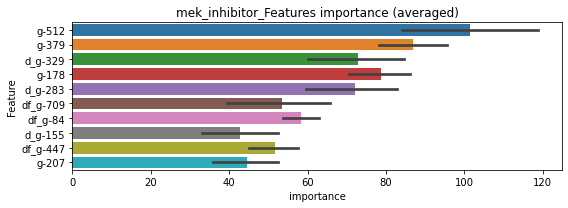

len(train_index) : 3887
len(valid_index) : 3888
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140999	valid_1's binary_logloss: 0.0324672
[200]	training's binary_logloss: 0.0016798	valid_1's binary_logloss: 0.0153543
[300]	training's binary_logloss: 0.000477163	valid_1's binary_logloss: 0.0120152
Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000265453	valid_1's binary_logloss: 0.0111377


len(train_index) : 3888
len(valid_index) : 3887
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140163	valid_1's binary_logloss: 0.027736
[200]	training's binary_logloss: 0.00174727	valid_1's binary_logloss: 0.014887
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.000579903	valid_1's binary_logloss: 0.0132275


mek_inhibitor logloss: 0.012182441742539286


neg labels: 3289 → selected neg labels: 3278


membrane_integrity_inhibitor, len(trt): 74, len(othr): 3278, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538339	valid_1's binary_logloss: 0.100657
[200]	training's binary_logloss: 0.0119897	valid_1's binary_logloss: 0.0528612
[300]	training's binary_logloss: 0.0034669	valid_1's binary_logloss: 0.039294
[400]	training's binary_logloss: 0.00154121	valid_1's binary_logloss: 0.0352861
[500]	training's binary_logloss: 0.000924374	valid_1's binary_logloss: 0.0337904
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000954842	valid_1's binary_logloss: 0.0337365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553726	valid_1's binary_logloss: 0.118679
[200]	training's binary_logloss: 0.0110202	valid_1's binary_logloss: 0.0692353
[300]	training's binary_logloss: 0.00319415	valid_1's binary_logloss: 0.0596464
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00212467	valid_1's binary_logloss: 0.0584445


1 / 3 AUC score:0.995
y_Threshold: 0.0145959, Threshold: 0.0226659, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 162 → Positive_corect_labels: 640/3771
p_label_rate: 0.0200904 Vs.target_rate: 0.00311
Num_p_label: 80.0, conf_0:0.02040, conf_1:0.02493
Num_p_label: 80.0, Expected: 12.4, Adj_threshold_1: 0.0226659
Num_p_label: 49.0, Expected: 12.4, Adj_threshold_2: 0.0326659
Num_p_label: 27.0, Expected: 12.4, Adj_threshold_3: 0.0426659
Num_p_label: 16.0, Expected: 12.4, Adj_threshold_4: 0.0526659
threshold: 0.0526659, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 640.0/3771, y_label_rate: 0.1697163
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0512206	valid_1's binary_logloss: 0.10439
[200]	training's binary_logloss: 0.0104035	valid_1's binary_logloss: 0.0525596
[300]	training's binary_logloss: 0.00314068	valid_1's binary_logloss: 0.0416038
[400]	training's binary_logloss: 0.00173864	valid_1's binary_logloss: 0.0395364
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00173864	valid_1's binary_logloss: 0.0395364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532101	valid_1's binary_logloss: 0.0969995
[200]	training's binary_logloss: 0.0108118	valid_1's binary_logloss: 0.0421555
[300]	training's binary_logloss: 0.00314765	valid_1's binary_logloss: 0.0265302
[400]	training's binary_logloss: 0.00142145	valid_1's binary_logloss: 0.0211456
[500]	training's binary_logloss: 0.000863969	valid_1's binary_logloss: 0.0191587
Early stopping, best iteration is:
[565]	trainin

2 / 3 AUC score:0.999
y_Threshold: 0.0544249, Threshold: 0.0526659, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 636.0/3763
p_label_rate: 0.0065294 Vs.target_rate: 0.00311
Num_p_label: 26.0, conf_0:0.04740, conf_1:0.05793
threshold: 0.0526659, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 636.0/3763, y_label_rate: 0.1690141
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499314	valid_1's binary_logloss: 0.10992
[200]	training's binary_logloss: 0.0100548	valid_1's binary_logloss: 0.0617838
[300]	training's binary_logloss: 0.00294569	valid_1's binary_logloss: 0.0502689
[400]	training's binary_logloss: 0.00133828	valid_1's binary_logloss: 0.0463641
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00109364	valid_1's binary_logloss: 0.0457346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508583	valid_1's binary_logloss: 0.102241
[200]	training's binary_logloss: 0.00975781	valid_1's binary_logloss: 0.0501175
[300]	training's binary_logloss: 0.00282884	valid_1's binary_logloss: 0.0381765
[400]	training's binary_logloss: 0.00130145	valid_1's binary_logloss: 0.0357205
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00138598	valid_1's binary_logloss: 0.0356642


3 / 3 AUC score:0.999
y_Threshold: 0.0347047, Threshold: 0.0526659, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 28 → Positive_corect_labels: 622.0/3735
p_label_rate: 0.0085384 Vs.target_rate: 0.00311
Num_p_label: 34.0, conf_0:0.04740, conf_1:0.05793
threshold: 0.0526659, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 656.0/7717, y_label_rate: 0.0850071


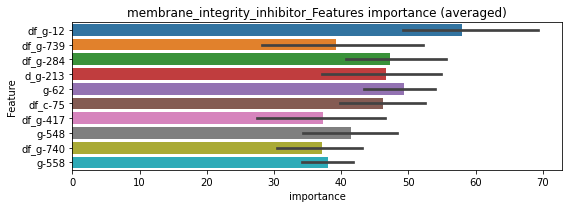

len(train_index) : 3858
len(valid_index) : 3859
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283245	valid_1's binary_logloss: 0.0836534
[200]	training's binary_logloss: 0.00540878	valid_1's binary_logloss: 0.06537
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0024452	valid_1's binary_logloss: 0.0639796


len(train_index) : 3859
len(valid_index) : 3858
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301759	valid_1's binary_logloss: 0.0668395
[200]	training's binary_logloss: 0.00601396	valid_1's binary_logloss: 0.041635
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00193013	valid_1's binary_logloss: 0.0356445


membrane_integrity_inhibitor logloss: 0.04981390610669908


neg labels: 3289 → selected neg labels: 3285


mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285254	valid_1's binary_logloss: 0.0502474
[200]	training's binary_logloss: 0.00368499	valid_1's binary_logloss: 0.0153704
[300]	training's binary_logloss: 0.00102368	valid_1's binary_logloss: 0.00931124
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000590721	valid_1's binary_logloss: 0.00793748
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295059	valid_1's binary_logloss: 0.0404433
[200]	training's binary_logloss: 0.00395449	valid_1's binary_logloss: 0.00842382
[300]	training's binary_logloss: 0.00108707	valid_1's binary_logloss: 0.00305637
[400]	training's binary_logloss: 0.000547908	valid_1's binary_logloss: 0.00185822
[500]	training's binary_logloss: 0.000393416	valid_1's binary_logloss: 0.00149089
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000376463	valid_1's binary_logloss: 0.00145863

1 / 3 AUC score:1.000
y_Threshold: 0.0026276, Threshold: 0.0054405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00490, conf_1:0.00598
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0054405
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_2: 0.0154405
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.0254405
threshold: 0.0254405, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282173	valid_1's binary_logloss: 0.0468731
[200]	training's binary_logloss: 0.00362219	valid_1's binary_logloss: 0.0134742
[300]	training's binary_logloss: 0.00100605	valid_1's binary_logloss: 0.00683689
[400]	training's binary_logloss: 0.000518332	valid_1's binary_logloss: 0.00525728
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000502784	valid_1's binary_logloss: 0.00522191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285127	valid_1's binary_logloss: 0.0384666
[200]	training's binary_logloss: 0.00372419	valid_1's binary_logloss: 0.00751102
[300]	training's binary_logloss: 0.00104313	valid_1's binary_logloss: 0.00285423
[400]	training's binary_logloss: 0.000533471	valid_1's binary_logloss: 0.00176173
[500]	training's binary_logloss: 0.000390611	valid_1's binary_logloss: 0.00147256
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0320081, Threshold: 0.0254405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0047715 Vs.target_rate: 0.00105
Num_p_label: 19.0, conf_0:0.02290, conf_1:0.02798
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_1: 0.0254405
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_2: 0.0354405
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.0454405
threshold: 0.0454405, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282173	valid_1's binary_logloss: 0.0468731
[200]	training's binary_logloss: 0.00362219	valid_1's binary_logloss: 0.0134742
[300]	training's binary_logloss: 0.00100605	valid_1's binary_logloss: 0.00683689
[400]	training's binary_logloss: 0.000518332	valid_1's binary_logloss: 0.00525728
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000502784	valid_1's binary_logloss: 0.00522191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285127	valid_1's binary_logloss: 0.0384666
[200]	training's binary_logloss: 0.00372419	valid_1's binary_logloss: 0.00751102
[300]	training's binary_logloss: 0.00104313	valid_1's binary_logloss: 0.00285423
[400]	training's binary_logloss: 0.000533471	valid_1's binary_logloss: 0.00176173
[500]	training's binary_logloss: 0.000390611	valid_1's binary_logloss: 0.00147256
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0320081, Threshold: 0.0454405, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00105
Num_p_label: 8.0, conf_0:0.04090, conf_1:0.04998
threshold: 0.0454405, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


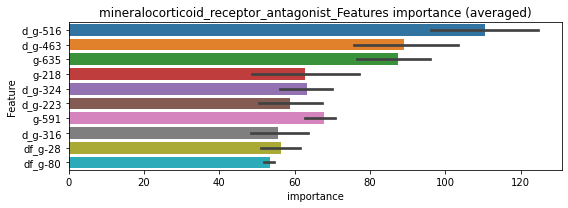

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160953	valid_1's binary_logloss: 0.0288354
[200]	training's binary_logloss: 0.0021187	valid_1's binary_logloss: 0.0118502
[300]	training's binary_logloss: 0.000559825	valid_1's binary_logloss: 0.00944052
[400]	training's binary_logloss: 0.000276822	valid_1's binary_logloss: 0.00906891
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000251168	valid_1's binary_logloss: 0.00903909


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169579	valid_1's binary_logloss: 0.0233849
[200]	training's binary_logloss: 0.00231458	valid_1's binary_logloss: 0.00545912
[300]	training's binary_logloss: 0.000617352	valid_1's binary_logloss: 0.00307585
[400]	training's binary_logloss: 0.000299817	valid_1's binary_logloss: 0.00265795
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000285278	valid_1's binary_logloss: 0.00262928


mineralocorticoid_receptor_antagonist logloss: 0.005834181267443948


neg labels: 3289 → selected neg labels: 3287


monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185149	valid_1's binary_logloss: 0.023249
[200]	training's binary_logloss: 0.00191869	valid_1's binary_logloss: 0.0042174
[300]	training's binary_logloss: 0.00055729	valid_1's binary_logloss: 0.00179479
[400]	training's binary_logloss: 0.000314279	valid_1's binary_logloss: 0.00125559
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.000274456	valid_1's binary_logloss: 0.00118101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186399	valid_1's binary_logloss: 0.021057
[200]	training's binary_logloss: 0.00190558	valid_1's binary_logloss: 0.0028266
[300]	training's binary_logloss: 0.000557828	valid_1's binary_logloss: 0.000937119
[400]	training's binary_logloss: 0.000316448	valid_1's binary_logloss: 0.000555191
[500]	training's binary_logloss: 0.000274797	valid_1's binary_logloss: 0.000486757
Early stopping, best iteration is

1 / 3 AUC score:1.000
y_Threshold: 0.0009441, Threshold: 0.0015797, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00142, conf_1:0.00174
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0015797
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.0115797
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.0215797
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0315797
threshold: 0.0315797, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185684	valid_1's binary_logloss: 0.0242439
[200]	training's binary_logloss: 0.0018474	valid_1's binary_logloss: 0.00467163
[300]	training's binary_logloss: 0.000543098	valid_1's binary_logloss: 0.00204476
[400]	training's binary_logloss: 0.00031737	valid_1's binary_logloss: 0.00143344
[500]	training's binary_logloss: 0.0002742	valid_1's binary_logloss: 0.00131969
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000273191	valid_1's binary_logloss: 0.00131909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018468	valid_1's binary_logloss: 0.0197875
[200]	training's binary_logloss: 0.00185254	valid_1's binary_logloss: 0.00218071
[300]	training's binary_logloss: 0.000549866	valid_1's binary_logloss: 0.000701722
[400]	training's binary_logloss: 0.000314606	valid_1's binary_logloss: 0.000415775
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.1249109, Threshold: 0.0315797, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0030136 Vs.target_rate: 0.00050
Num_p_label: 12.0, conf_0:0.02842, conf_1:0.03474
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_1: 0.0315797
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0415797
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.0515797
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_4: 0.0615797
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.0715797
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_6: 0.0815797
threshold: 0.0815797, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185684	valid_1's binary_logloss: 0.0242439
[200]	training's binary_logloss: 0.0018474	valid_1's binary_logloss: 0.00467163
[300]	training's binary_logloss: 0.000543098	valid_1's binary_logloss: 0.00204476
[400]	training's binary_logloss: 0.00031737	valid_1's binary_logloss: 0.00143344
[500]	training's binary_logloss: 0.0002742	valid_1's binary_logloss: 0.00131969
Early stopping, best iteration is:
[508]	training's binary_logloss: 0.000273191	valid_1's binary_logloss: 0.00131909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018468	valid_1's binary_logloss: 0.0197875
[200]	training's binary_logloss: 0.00185254	valid_1's binary_logloss: 0.00218071
[300]	training's binary_logloss: 0.000549866	valid_1's binary_logloss: 0.000701722
[400]	training's binary_logloss: 0.000314606	valid_1's binary_logloss: 0.000415775
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.1249109, Threshold: 0.0815797, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0010045 Vs.target_rate: 0.00050
Num_p_label: 4.0, conf_0:0.07342, conf_1:0.08974
threshold: 0.0815797, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7794, y_label_rate: 0.0848088


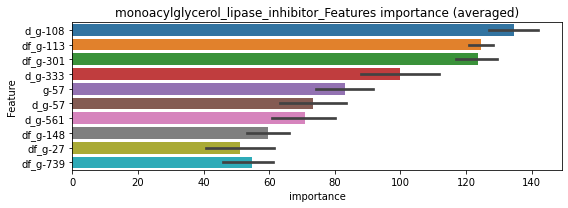

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00998858	valid_1's binary_logloss: 0.0134837
[200]	training's binary_logloss: 0.000993552	valid_1's binary_logloss: 0.00323579
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000352764	valid_1's binary_logloss: 0.00261052


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104139	valid_1's binary_logloss: 0.0131484
[200]	training's binary_logloss: 0.00105304	valid_1's binary_logloss: 0.0029287
[300]	training's binary_logloss: 0.000295211	valid_1's binary_logloss: 0.0018479
[400]	training's binary_logloss: 0.000161838	valid_1's binary_logloss: 0.0016436
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000154302	valid_1's binary_logloss: 0.00163664


monoacylglycerol_lipase_inhibitor logloss: 0.002123579929494027


neg labels: 3289 → selected neg labels: 3274


monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3274, target_rate: 0.0035693 → Adj_target_rate: 0.0036661
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591438	valid_1's binary_logloss: 0.124509
[200]	training's binary_logloss: 0.0143139	valid_1's binary_logloss: 0.0684401
[300]	training's binary_logloss: 0.00439884	valid_1's binary_logloss: 0.0529524
[400]	training's binary_logloss: 0.00191559	valid_1's binary_logloss: 0.0481653
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00153446	valid_1's binary_logloss: 0.0476391
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0648187	valid_1's binary_logloss: 0.133459
[200]	training's binary_logloss: 0.0151261	valid_1's binary_logloss: 0.0784503
[300]	training's binary_logloss: 0.00435341	valid_1's binary_logloss: 0.0616758
[400]	training's binary_logloss: 0.00187108	valid_1's binary_logloss: 0.0571759
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00188259	valid_1's binary_logloss: 0.0571634


1 / 3 AUC score:0.993
y_Threshold: 0.0180022, Threshold: 0.0254658, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 152 → Positive_corect_labels: 644/3776
p_label_rate: 0.0200904 Vs.target_rate: 0.00357
Num_p_label: 80.0, conf_0:0.02292, conf_1:0.02801
Num_p_label: 80.0, Expected: 14.2, Adj_threshold_1: 0.0254658
Num_p_label: 40.0, Expected: 14.2, Adj_threshold_2: 0.0354658
Num_p_label: 25.0, Expected: 14.2, Adj_threshold_3: 0.0454658
threshold: 0.0454658, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 644.0/3776, y_label_rate: 0.1705508
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554252	valid_1's binary_logloss: 0.143734
[200]	training's binary_logloss: 0.0114295	valid_1's binary_logloss: 0.0983904
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00548008	valid_1's binary_logloss: 0.0921058
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600063	valid_1's binary_logloss: 0.110924
[200]	training's binary_logloss: 0.0133803	valid_1's binary_logloss: 0.0512983
[300]	training's binary_logloss: 0.00393663	valid_1's binary_logloss: 0.0350455
[400]	training's binary_logloss: 0.00174052	valid_1's binary_logloss: 0.0302469
[500]	training's binary_logloss: 0.00103994	valid_1's binary_logloss: 0.0280662
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00106052	valid_1's binary_logloss: 0.0280264


2 / 3 AUC score:0.996
y_Threshold: 0.0601067, Threshold: 0.0454658, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 44 → Positive_corect_labels: 622.0/3732
p_label_rate: 0.0220994 Vs.target_rate: 0.00357
Num_p_label: 88.0, conf_0:0.04092, conf_1:0.05001
Num_p_label: 88.0, Expected: 14.2, Adj_threshold_1: 0.0454658
Num_p_label: 64.0, Expected: 14.2, Adj_threshold_2: 0.0554658
Num_p_label: 42.0, Expected: 14.2, Adj_threshold_3: 0.0654658
Num_p_label: 33.0, Expected: 14.2, Adj_threshold_4: 0.0754658
Num_p_label: 29.0, Expected: 14.2, Adj_threshold_5: 0.0854658
Num_p_label: 25.0, Expected: 14.2, Adj_threshold_6: 0.0954658
threshold: 0.0954658, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 622.0/3732, y_label_rate: 0.1666667
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0548121	valid_1's binary_logloss: 0.121818
[200]	training's binary_logloss: 0.0112482	valid_1's binary_logloss: 0.065608
[300]	training's binary_logloss: 0.00333015	valid_1's binary_logloss: 0.0494602
[400]	training's binary_logloss: 0.00148504	valid_1's binary_logloss: 0.0440815
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00143684	valid_1's binary_logloss: 0.0437685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0558836	valid_1's binary_logloss: 0.11104
[200]	training's binary_logloss: 0.0114463	valid_1's binary_logloss: 0.0566763
[300]	training's binary_logloss: 0.00333742	valid_1's binary_logloss: 0.0445863
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00234214	valid_1's binary_logloss: 0.0427785


3 / 3 AUC score:0.997
y_Threshold: 0.0470238, Threshold: 0.0954658, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 610.0/3708
p_label_rate: 0.0052737 Vs.target_rate: 0.00357
Num_p_label: 21.0, conf_0:0.08592, conf_1:0.10501
threshold: 0.0954658, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 631.0/7690, y_label_rate: 0.0820546


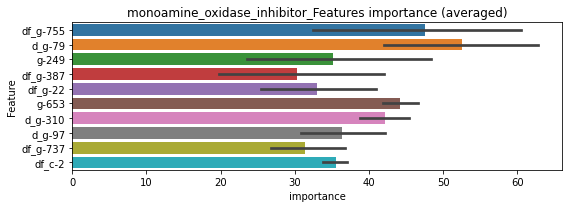

len(train_index) : 3845
len(valid_index) : 3845
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317359	valid_1's binary_logloss: 0.0721178
[200]	training's binary_logloss: 0.00657505	valid_1's binary_logloss: 0.0448685
[300]	training's binary_logloss: 0.00183143	valid_1's binary_logloss: 0.0387662
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000989983	valid_1's binary_logloss: 0.037512


len(train_index) : 3845
len(valid_index) : 3845
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320689	valid_1's binary_logloss: 0.0761098
[200]	training's binary_logloss: 0.00684612	valid_1's binary_logloss: 0.0474138
[300]	training's binary_logloss: 0.00195674	valid_1's binary_logloss: 0.040289
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000966606	valid_1's binary_logloss: 0.0391386


monoamine_oxidase_inhibitor logloss: 0.038325301601581756


neg labels: 3289 → selected neg labels: 3286


monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02069	valid_1's binary_logloss: 0.0258054
[200]	training's binary_logloss: 0.00225154	valid_1's binary_logloss: 0.00383514
[300]	training's binary_logloss: 0.000639009	valid_1's binary_logloss: 0.00140329
[400]	training's binary_logloss: 0.000357133	valid_1's binary_logloss: 0.000885524
[500]	training's binary_logloss: 0.000294819	valid_1's binary_logloss: 0.000756332
[600]	training's binary_logloss: 0.00028566	valid_1's binary_logloss: 0.000737481
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.000285426	valid_1's binary_logloss: 0.00073701
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210542	valid_1's binary_logloss: 0.0266272
[200]	training's binary_logloss: 0.00233021	valid_1's binary_logloss: 0.00383477
[300]	training's binary_logloss: 0.000660495	valid_1's binary_logloss: 0.00134879
[400]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0014340, Threshold: 0.0029353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00264, conf_1:0.00323
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0029353
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0129353
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.0229353
threshold: 0.0229353, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020796	valid_1's binary_logloss: 0.0256096
[200]	training's binary_logloss: 0.00221299	valid_1's binary_logloss: 0.00347876
[300]	training's binary_logloss: 0.000626154	valid_1's binary_logloss: 0.00116204
[400]	training's binary_logloss: 0.000347407	valid_1's binary_logloss: 0.000710406
[500]	training's binary_logloss: 0.000291823	valid_1's binary_logloss: 0.000622089
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000286089	valid_1's binary_logloss: 0.000613827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211426	valid_1's binary_logloss: 0.0263282
[200]	training's binary_logloss: 0.00225041	valid_1's binary_logloss: 0.00366739
[300]	training's binary_logloss: 0.000637978	valid_1's binary_logloss: 0.00127148
[400]	training's binary_logloss: 0.000350319	valid_1's binary_logloss: 0.000781275
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.1460269, Threshold: 0.0229353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076
Num_p_label: 21.0, conf_0:0.02064, conf_1:0.02523
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.0229353
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.0329353
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.0429353
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.0529353
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_5: 0.0629353
threshold: 0.0629353, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020796	valid_1's binary_logloss: 0.0256096
[200]	training's binary_logloss: 0.00221299	valid_1's binary_logloss: 0.00347876
[300]	training's binary_logloss: 0.000626154	valid_1's binary_logloss: 0.00116204
[400]	training's binary_logloss: 0.000347407	valid_1's binary_logloss: 0.000710406
[500]	training's binary_logloss: 0.000291823	valid_1's binary_logloss: 0.000622089
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000286089	valid_1's binary_logloss: 0.000613827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211426	valid_1's binary_logloss: 0.0263282
[200]	training's binary_logloss: 0.00225041	valid_1's binary_logloss: 0.00366739
[300]	training's binary_logloss: 0.000637978	valid_1's binary_logloss: 0.00127148
[400]	training's binary_logloss: 0.000350319	valid_1's binary_logloss: 0.000781275
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.1460269, Threshold: 0.0629353, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076
Num_p_label: 6.0, conf_0:0.05664, conf_1:0.06923
threshold: 0.0629353, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


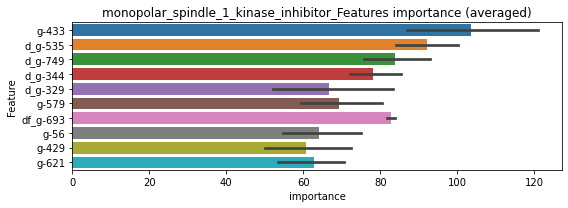

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010914	valid_1's binary_logloss: 0.0178661
[200]	training's binary_logloss: 0.00116566	valid_1's binary_logloss: 0.00770568
[300]	training's binary_logloss: 0.00032486	valid_1's binary_logloss: 0.00686535
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00030015	valid_1's binary_logloss: 0.00681816


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0112928	valid_1's binary_logloss: 0.0196339
[200]	training's binary_logloss: 0.00122818	valid_1's binary_logloss: 0.00693552
[300]	training's binary_logloss: 0.00034312	valid_1's binary_logloss: 0.00442007
[400]	training's binary_logloss: 0.000187921	valid_1's binary_logloss: 0.00382598
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.000169427	valid_1's binary_logloss: 0.00375869


monopolar_spindle_1_kinase_inhibitor logloss: 0.005288623795763644


neg labels: 3289 → selected neg labels: 3267


mtor_inhibitor, len(trt): 130, len(othr): 3267, target_rate: 0.0054590 → Adj_target_rate: 0.0052608
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296797	valid_1's binary_logloss: 0.0778751
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00631423	valid_1's binary_logloss: 0.0570433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335969	valid_1's binary_logloss: 0.0695923
[200]	training's binary_logloss: 0.00529939	valid_1's binary_logloss: 0.0454787
[300]	training's binary_logloss: 0.00152224	valid_1's binary_logloss: 0.0416407
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00115785	valid_1's binary_logloss: 0.0412127


1 / 3 AUC score:0.992
y_Threshold: 0.0096806, Threshold: 0.0898870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 155 → Positive_corect_labels: 641/3765
p_label_rate: 0.0200904 Vs.target_rate: 0.00546
Num_p_label: 80.0, conf_0:0.08090, conf_1:0.09888
Num_p_label: 80.0, Expected: 21.7, Adj_threshold_1: 0.0898870
Num_p_label: 74.0, Expected: 21.7, Adj_threshold_2: 0.0998870
Num_p_label: 71.0, Expected: 21.7, Adj_threshold_3: 0.1098870
Num_p_label: 70.0, Expected: 21.7, Adj_threshold_4: 0.1198870
Num_p_label: 69.0, Expected: 21.7, Adj_threshold_5: 0.1298870
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_6: 0.1398870
Num_p_label: 67.0, Expected: 21.7, Adj_threshold_7: 0.1498870
Num_p_label: 66.0, Expected: 21.7, Adj_threshold_8: 0.1598870
Num_p_label: 64.0, Expected: 21.7, Adj_threshold_9: 0.1698870
Num_p_label: 62.0, Expected: 21.7, Adj_threshold_10: 0.1798870
threshold: 0.1898870, positive_p_label: 61.0/3982, p_label_rate: 0.0153189
positive_y_label: 641.0/3765, y_label_rate: 0.1702523

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277638	valid_1's binary_logloss: 0.0432168
[200]	training's binary_logloss: 0.00366281	valid_1's binary_logloss: 0.0158541
[300]	training's binary_logloss: 0.00106284	valid_1's binary_logloss: 0.0109504
[400]	training's binary_logloss: 0.000550194	valid_1's binary_logloss: 0.00954601
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00042112	valid_1's binary_logloss: 0.00908377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280147	valid_1's binary_logloss: 0.0664776
[200]	training's binary_logloss: 0.00359224	valid_1's binary_logloss: 0.0448119
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00170068	valid_1's binary_logloss: 0.0424884


2 / 3 AUC score:1.000
y_Threshold: 0.0450224, Threshold: 0.1898870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 628.0/3739
p_label_rate: 0.0346560 Vs.target_rate: 0.00546
Num_p_label: 138.0, conf_0:0.17090, conf_1:0.20888
Num_p_label: 138.0, Expected: 21.7, Adj_threshold_1: 0.1898870
Num_p_label: 135.0, Expected: 21.7, Adj_threshold_2: 0.1998870
Num_p_label: 134.0, Expected: 21.7, Adj_threshold_3: 0.2098870
Num_p_label: 134.0, Expected: 21.7, Adj_threshold_4: 0.2198870
Num_p_label: 133.0, Expected: 21.7, Adj_threshold_5: 0.2298870
Num_p_label: 130.0, Expected: 21.7, Adj_threshold_6: 0.2398870
Num_p_label: 127.0, Expected: 21.7, Adj_threshold_7: 0.2498870
Num_p_label: 126.0, Expected: 21.7, Adj_threshold_8: 0.2598870
Num_p_label: 122.0, Expected: 21.7, Adj_threshold_9: 0.2698870
Num_p_label: 121.0, Expected: 21.7, Adj_threshold_10: 0.2798870
threshold: 0.2898870, positive_p_label: 119.0/3982, p_label_rate: 0.0298845
positive_y_label: 628.0/3739, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0269353	valid_1's binary_logloss: 0.0596833
[200]	training's binary_logloss: 0.00339441	valid_1's binary_logloss: 0.0398841
Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00258847	valid_1's binary_logloss: 0.0390032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258542	valid_1's binary_logloss: 0.0518075
[200]	training's binary_logloss: 0.00323019	valid_1's binary_logloss: 0.0318792
[300]	training's binary_logloss: 0.00092587	valid_1's binary_logloss: 0.0299817
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000908587	valid_1's binary_logloss: 0.0299294


3 / 3 AUC score:0.999
y_Threshold: 0.0354098, Threshold: 0.2898870, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 612.0/3707
p_label_rate: 0.0416876 Vs.target_rate: 0.00546
Num_p_label: 166.0, conf_0:0.26090, conf_1:0.31888
Num_p_label: 166.0, Expected: 21.7, Adj_threshold_1: 0.2898870
Num_p_label: 165.0, Expected: 21.7, Adj_threshold_2: 0.2998870
Num_p_label: 163.0, Expected: 21.7, Adj_threshold_3: 0.3098870
Num_p_label: 160.0, Expected: 21.7, Adj_threshold_4: 0.3198870
Num_p_label: 157.0, Expected: 21.7, Adj_threshold_5: 0.3298870
Num_p_label: 154.0, Expected: 21.7, Adj_threshold_6: 0.3398870
Num_p_label: 150.0, Expected: 21.7, Adj_threshold_7: 0.3498870
Num_p_label: 145.0, Expected: 21.7, Adj_threshold_8: 0.3598870
Num_p_label: 145.0, Expected: 21.7, Adj_threshold_9: 0.3698870
Num_p_label: 143.0, Expected: 21.7, Adj_threshold_10: 0.3798870
threshold: 0.3898870, positive_p_label: 141.0/3982, p_label_rate: 0.0354093
positive_y_label: 753.0/7689, y_label_ra

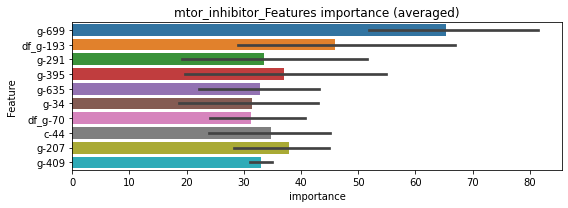

len(train_index) : 3844
len(valid_index) : 3845
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167563	valid_1's binary_logloss: 0.034346
[200]	training's binary_logloss: 0.00218169	valid_1's binary_logloss: 0.0202335
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00137469	valid_1's binary_logloss: 0.0188307


len(train_index) : 3845
len(valid_index) : 3844
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161722	valid_1's binary_logloss: 0.0371326
[200]	training's binary_logloss: 0.00214881	valid_1's binary_logloss: 0.0229708
[300]	training's binary_logloss: 0.000617182	valid_1's binary_logloss: 0.020181
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000587946	valid_1's binary_logloss: 0.0200182


mtor_inhibitor logloss: 0.019424369518019517


neg labels: 3289 → selected neg labels: 3281


mucolytic_agent, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410789	valid_1's binary_logloss: 0.0873409
[200]	training's binary_logloss: 0.00683738	valid_1's binary_logloss: 0.045393
[300]	training's binary_logloss: 0.00193554	valid_1's binary_logloss: 0.0396161
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0017939	valid_1's binary_logloss: 0.0392763
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407141	valid_1's binary_logloss: 0.0677036
[200]	training's binary_logloss: 0.00721356	valid_1's binary_logloss: 0.0198759
[300]	training's binary_logloss: 0.00205321	valid_1's binary_logloss: 0.00942477
[400]	training's binary_logloss: 0.000964215	valid_1's binary_logloss: 0.0064101
[500]	training's binary_logloss: 0.00062144	valid_1's binary_logloss: 0.00519283
[600]	training's binary_logloss: 0.000493657	valid_1's binary_logloss: 0.00477616
Early stopping, best iteration is:
[593]	t

1 / 3 AUC score:0.997
y_Threshold: 0.0089420, Threshold: 0.0138740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01249, conf_1:0.01526
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0138740
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.0238740
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.0338740
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_4: 0.0438740
threshold: 0.0438740, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395545	valid_1's binary_logloss: 0.0789906
[200]	training's binary_logloss: 0.00644312	valid_1's binary_logloss: 0.0316736
[300]	training's binary_logloss: 0.00187777	valid_1's binary_logloss: 0.0201159
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000987895	valid_1's binary_logloss: 0.0168296
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397866	valid_1's binary_logloss: 0.0747653
[200]	training's binary_logloss: 0.0064624	valid_1's binary_logloss: 0.0336729
[300]	training's binary_logloss: 0.00186383	valid_1's binary_logloss: 0.0264592
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00159395	valid_1's binary_logloss: 0.0254574


2 / 3 AUC score:1.000
y_Threshold: 0.0483977, Threshold: 0.0438740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 641.0/3775
p_label_rate: 0.0115520 Vs.target_rate: 0.00202
Num_p_label: 46.0, conf_0:0.03949, conf_1:0.04826
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_1: 0.0438740
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_2: 0.0538740
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_3: 0.0638740
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_4: 0.0738740
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_5: 0.0838740
threshold: 0.0838740, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 641.0/3775, y_label_rate: 0.1698013
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376917	valid_1's binary_logloss: 0.075265
[200]	training's binary_logloss: 0.00603533	valid_1's binary_logloss: 0.0325638
[300]	training's binary_logloss: 0.00173905	valid_1's binary_logloss: 0.0242474
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000912975	valid_1's binary_logloss: 0.0220576
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399509	valid_1's binary_logloss: 0.0668563
[200]	training's binary_logloss: 0.00664668	valid_1's binary_logloss: 0.0214725
[300]	training's binary_logloss: 0.00193344	valid_1's binary_logloss: 0.012683
[400]	training's binary_logloss: 0.000952965	valid_1's binary_logloss: 0.0100148
[500]	training's binary_logloss: 0.000619862	valid_1's binary_logloss: 0.00907224
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000578918	valid_1's binary_logloss: 0.00896093


3 / 3 AUC score:0.999
y_Threshold: 0.0297705, Threshold: 0.0838740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 635.0/3763
p_label_rate: 0.0035158 Vs.target_rate: 0.00202
Num_p_label: 14.0, conf_0:0.07549, conf_1:0.09226
threshold: 0.0838740, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 649.0/7745, y_label_rate: 0.0837960


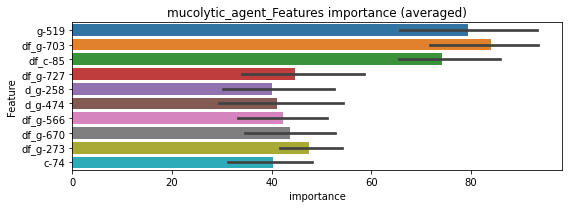

len(train_index) : 3872
len(valid_index) : 3873
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0222556	valid_1's binary_logloss: 0.0458615
[200]	training's binary_logloss: 0.00373762	valid_1's binary_logloss: 0.0217167
[300]	training's binary_logloss: 0.00124573	valid_1's binary_logloss: 0.0167117
[400]	training's binary_logloss: 0.000790716	valid_1's binary_logloss: 0.0150562
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000406488	valid_1's binary_logloss: 0.0143832


len(train_index) : 3873
len(valid_index) : 3872
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221144	valid_1's binary_logloss: 0.0474258
[200]	training's binary_logloss: 0.00360716	valid_1's binary_logloss: 0.0252738
[300]	training's binary_logloss: 0.00101108	valid_1's binary_logloss: 0.0209254
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.000727343	valid_1's binary_logloss: 0.0206179


mucolytic_agent logloss: 0.017500139669996802


neg labels: 3289 → selected neg labels: 3283


neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355435	valid_1's binary_logloss: 0.0655889
[200]	training's binary_logloss: 0.00544331	valid_1's binary_logloss: 0.0224919
[300]	training's binary_logloss: 0.00150109	valid_1's binary_logloss: 0.0129265
[400]	training's binary_logloss: 0.000713945	valid_1's binary_logloss: 0.0101853
[500]	training's binary_logloss: 0.000478106	valid_1's binary_logloss: 0.00913141
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000468336	valid_1's binary_logloss: 0.00907778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370096	valid_1's binary_logloss: 0.0560464
[200]	training's binary_logloss: 0.00563766	valid_1's binary_logloss: 0.0137806
[300]	training's binary_logloss: 0.00157757	valid_1's binary_logloss: 0.00605303
[400]	training's binary_logloss: 0.000734478	valid_1's binary_logloss: 0.00357832
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0032364, Threshold: 0.0053689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00483, conf_1:0.00591
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0053689
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0153689
Num_p_label: 6.0, Expected: 6.2, Adj_threshold_3: 0.0253689
threshold: 0.0253689, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035298	valid_1's binary_logloss: 0.0619335
[200]	training's binary_logloss: 0.00533945	valid_1's binary_logloss: 0.0195431
[300]	training's binary_logloss: 0.00147842	valid_1's binary_logloss: 0.0102145
[400]	training's binary_logloss: 0.000721661	valid_1's binary_logloss: 0.00783135
[500]	training's binary_logloss: 0.000478724	valid_1's binary_logloss: 0.00705074
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000483591	valid_1's binary_logloss: 0.0070188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352165	valid_1's binary_logloss: 0.0533898
[200]	training's binary_logloss: 0.00541022	valid_1's binary_logloss: 0.0125816
[300]	training's binary_logloss: 0.00152171	valid_1's binary_logloss: 0.0052281
[400]	training's binary_logloss: 0.000731601	valid_1's binary_logloss: 0.00336331
Early stopping, best iteration is:
[471

2 / 3 AUC score:1.000
y_Threshold: 0.0463916, Threshold: 0.0253689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0055249 Vs.target_rate: 0.00155
Num_p_label: 22.0, conf_0:0.02283, conf_1:0.02791
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_1: 0.0253689
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_2: 0.0353689
threshold: 0.0353689, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035298	valid_1's binary_logloss: 0.0619335
[200]	training's binary_logloss: 0.00533945	valid_1's binary_logloss: 0.0195431
[300]	training's binary_logloss: 0.00147842	valid_1's binary_logloss: 0.0102145
[400]	training's binary_logloss: 0.000721661	valid_1's binary_logloss: 0.00783135
[500]	training's binary_logloss: 0.000478724	valid_1's binary_logloss: 0.00705074
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000483591	valid_1's binary_logloss: 0.0070188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352165	valid_1's binary_logloss: 0.0533898
[200]	training's binary_logloss: 0.00541022	valid_1's binary_logloss: 0.0125816
[300]	training's binary_logloss: 0.00152171	valid_1's binary_logloss: 0.0052281
[400]	training's binary_logloss: 0.000731601	valid_1's binary_logloss: 0.00336331
Early stopping, best iteration is:
[471

3 / 3 AUC score:1.000
y_Threshold: 0.0463916, Threshold: 0.0353689, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0030136 Vs.target_rate: 0.00155
Num_p_label: 12.0, conf_0:0.03183, conf_1:0.03891
threshold: 0.0353689, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7789, y_label_rate: 0.0857620


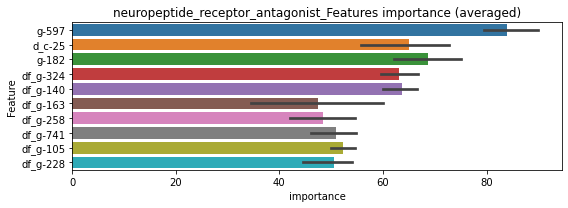

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194817	valid_1's binary_logloss: 0.0397064
[200]	training's binary_logloss: 0.00291987	valid_1's binary_logloss: 0.0201854
[300]	training's binary_logloss: 0.000790475	valid_1's binary_logloss: 0.0158799
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.000511295	valid_1's binary_logloss: 0.0155034


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199471	valid_1's binary_logloss: 0.0397457
[200]	training's binary_logloss: 0.00298235	valid_1's binary_logloss: 0.0170953
[300]	training's binary_logloss: 0.000818602	valid_1's binary_logloss: 0.0125466
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.000456841	valid_1's binary_logloss: 0.011413


neuropeptide_receptor_antagonist logloss: 0.013458478775463816


neg labels: 3289 → selected neg labels: 3270


nfkb_inhibitor, len(trt): 832, len(othr): 3270, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0497869	valid_1's binary_logloss: 0.120439
Early stopping, best iteration is:
[126]	training's binary_logloss: 0.0306119	valid_1's binary_logloss: 0.117219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0417715	valid_1's binary_logloss: 0.149915
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0409521	valid_1's binary_logloss: 0.149905


1 / 3 AUC score:0.939
y_Threshold: 0.0333734, Threshold: 0.9643201, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 406 → Positive_corect_labels: 735/3696
p_label_rate: 0.0200904 Vs.target_rate: 0.03494
Num_p_label: 80.0, conf_0:0.86789, conf_1:1.06075
threshold: 0.9643201, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 735.0/3696, y_label_rate: 0.1988636
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.018762	valid_1's binary_logloss: 0.0321076
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00386975	valid_1's binary_logloss: 0.0227507
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0207618	valid_1's binary_logloss: 0.0269179
[200]	training's binary_logloss: 0.00198842	valid_1's binary_logloss: 0.012779
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00163203	valid_1's binary_logloss: 0.012707


2 / 3 AUC score:0.998
y_Threshold: 0.0680440, Threshold: 0.9643201, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 16 → Positive_corect_labels: 727.0/3680
p_label_rate: 0.0381718 Vs.target_rate: 0.03494
Num_p_label: 152.0, conf_0:0.86789, conf_1:1.06075
threshold: 0.9643201, positive_p_label: 152.0/3982, p_label_rate: 0.0381718
positive_y_label: 727.0/3680, y_label_rate: 0.1975543
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161669	valid_1's binary_logloss: 0.016578
[200]	training's binary_logloss: 0.00104482	valid_1's binary_logloss: 0.00114415
[300]	training's binary_logloss: 0.000231633	valid_1's binary_logloss: 0.000277664
[400]	training's binary_logloss: 0.000153669	valid_1's binary_logloss: 0.000190696
[500]	training's binary_logloss: 0.000139898	valid_1's binary_logloss: 0.000175338
[600]	training's binary_logloss: 0.000136832	valid_1's binary_logloss: 0.000171848
[700]	training's binary_logloss: 0.000135232	valid_1's binary_logloss: 0.000170094
Early stopping, best iteration is:
[722]	training's binary_logloss: 0.000135213	valid_1's binary_logloss: 0.000170073
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162391	valid_1's binary_logloss: 0.0182974
[200]	training's binary_logloss: 0.00105109	valid_1's binary_logloss: 0.00319806
Early stopping, best itera

3 / 3 AUC score:1.000
y_Threshold: 0.0480764, Threshold: 0.9643201, pos_neg_ratio: 0.7455657
Remove_noisy_labels: 2 → Positive_corect_labels: 726.0/3678
p_label_rate: 0.0394274 Vs.target_rate: 0.03494
Num_p_label: 157.0, conf_0:0.86789, conf_1:1.06075
threshold: 0.9643201, positive_p_label: 157.0/3982, p_label_rate: 0.0394274
positive_y_label: 883.0/7660, y_label_rate: 0.1152742


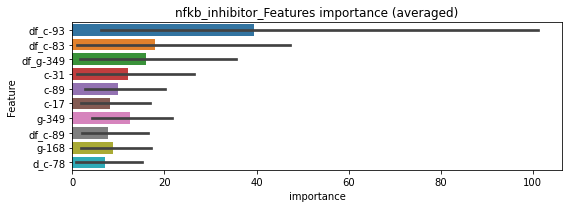

len(train_index) : 3830
len(valid_index) : 3830
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111314	valid_1's binary_logloss: 0.0116844
[200]	training's binary_logloss: 0.000811093	valid_1's binary_logloss: 0.00139148
[300]	training's binary_logloss: 0.000161893	valid_1's binary_logloss: 0.000682279
[400]	training's binary_logloss: 9.22192e-05	valid_1's binary_logloss: 0.000562273
Early stopping, best iteration is:
[391]	training's binary_logloss: 9.44848e-05	valid_1's binary_logloss: 0.000561491


len(train_index) : 3830
len(valid_index) : 3830
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108859	valid_1's binary_logloss: 0.0128832
[200]	training's binary_logloss: 0.000734816	valid_1's binary_logloss: 0.00346251
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.000245874	valid_1's binary_logloss: 0.00316573


nfkb_inhibitor logloss: 0.0018636122762898343


neg labels: 3289 → selected neg labels: 3287


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0188225	valid_1's binary_logloss: 0.0229874
[200]	training's binary_logloss: 0.00187154	valid_1's binary_logloss: 0.00320953
[300]	training's binary_logloss: 0.000521693	valid_1's binary_logloss: 0.00117825
[400]	training's binary_logloss: 0.000292831	valid_1's binary_logloss: 0.000769562
[500]	training's binary_logloss: 0.00025339	valid_1's binary_logloss: 0.000705853
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000250457	valid_1's binary_logloss: 0.00070194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190403	valid_1's binary_logloss: 0.023114
[200]	training's binary_logloss: 0.00188667	valid_1's binary_logloss: 0.00285891
[300]	training's binary_logloss: 0.000527482	valid_1's binary_logloss: 0.000960269
[400]	training's binary_logloss: 0.000296998	valid_1's binary_logloss: 0.000612811
Early stopping, best iteratio

1 / 3 AUC score:1.000
y_Threshold: 0.0009144, Threshold: 0.0017744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00160, conf_1:0.00195
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0017744
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_2: 0.0117744
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_3: 0.0217744
threshold: 0.0217744, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191634	valid_1's binary_logloss: 0.0235491
[200]	training's binary_logloss: 0.00184356	valid_1's binary_logloss: 0.00346493
[300]	training's binary_logloss: 0.00050598	valid_1's binary_logloss: 0.00130484
[400]	training's binary_logloss: 0.000288962	valid_1's binary_logloss: 0.000906043
[500]	training's binary_logloss: 0.000249974	valid_1's binary_logloss: 0.000818426
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000249904	valid_1's binary_logloss: 0.000818313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191231	valid_1's binary_logloss: 0.0218899
[200]	training's binary_logloss: 0.00186773	valid_1's binary_logloss: 0.00257691
[300]	training's binary_logloss: 0.000508849	valid_1's binary_logloss: 0.000827196
[400]	training's binary_logloss: 0.000287753	valid_1's binary_logloss: 0.000521401
[500]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1278005, Threshold: 0.0217744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0042692 Vs.target_rate: 0.00050
Num_p_label: 17.0, conf_0:0.01960, conf_1:0.02395
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.0217744
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_2: 0.0317744
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.0417744
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.0517744
threshold: 0.0517744, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191634	valid_1's binary_logloss: 0.0235491
[200]	training's binary_logloss: 0.00184356	valid_1's binary_logloss: 0.00346493
[300]	training's binary_logloss: 0.00050598	valid_1's binary_logloss: 0.00130484
[400]	training's binary_logloss: 0.000288962	valid_1's binary_logloss: 0.000906043
[500]	training's binary_logloss: 0.000249974	valid_1's binary_logloss: 0.000818426
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.000249904	valid_1's binary_logloss: 0.000818313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191231	valid_1's binary_logloss: 0.0218899
[200]	training's binary_logloss: 0.00186773	valid_1's binary_logloss: 0.00257691
[300]	training's binary_logloss: 0.000508849	valid_1's binary_logloss: 0.000827196
[400]	training's binary_logloss: 0.000287753	valid_1's binary_logloss: 0.000521401
[500]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1278005, Threshold: 0.0517744, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.04660, conf_1:0.05695
threshold: 0.0517744, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


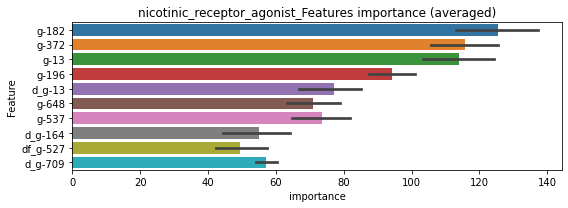

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00969815	valid_1's binary_logloss: 0.0160159
[200]	training's binary_logloss: 0.000915678	valid_1's binary_logloss: 0.00521186
[300]	training's binary_logloss: 0.00025055	valid_1's binary_logloss: 0.00411772
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000186958	valid_1's binary_logloss: 0.00395991


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00994566	valid_1's binary_logloss: 0.0123928
[200]	training's binary_logloss: 0.000974733	valid_1's binary_logloss: 0.0024823
[300]	training's binary_logloss: 0.000269077	valid_1's binary_logloss: 0.00171788
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000199274	valid_1's binary_logloss: 0.00165041


nicotinic_receptor_agonist logloss: 0.0028051594442641595


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287897	valid_1's binary_logloss: 0.0453488
[200]	training's binary_logloss: 0.00389489	valid_1's binary_logloss: 0.0118026
[300]	training's binary_logloss: 0.00109922	valid_1's binary_logloss: 0.00540438
[400]	training's binary_logloss: 0.000553333	valid_1's binary_logloss: 0.00403971
[500]	training's binary_logloss: 0.00039296	valid_1's binary_logloss: 0.0034692
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.000383074	valid_1's binary_logloss: 0.00342494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028516	valid_1's binary_logloss: 0.039152
[200]	training's binary_logloss: 0.00391748	valid_1's binary_logloss: 0.00845317
[300]	training's binary_logloss: 0.00108684	valid_1's binary_logloss: 0.00324662
[400]	training's binary_logloss: 0.000545404	valid_1's binary_logloss: 0.00197116
[500]	training's binary_logloss: 0.000

1 / 3 AUC score:1.000
y_Threshold: 0.0023231, Threshold: 0.0036780, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00331, conf_1:0.00405
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0036780
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_2: 0.0136780
Num_p_label: 6.0, Expected: 4.3, Adj_threshold_3: 0.0236780
threshold: 0.0236780, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281703	valid_1's binary_logloss: 0.0435349
[200]	training's binary_logloss: 0.00372852	valid_1's binary_logloss: 0.0110657
[300]	training's binary_logloss: 0.00105167	valid_1's binary_logloss: 0.00527699
[400]	training's binary_logloss: 0.000534598	valid_1's binary_logloss: 0.00376016
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000398697	valid_1's binary_logloss: 0.00329392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290307	valid_1's binary_logloss: 0.0389221
[200]	training's binary_logloss: 0.0038182	valid_1's binary_logloss: 0.00801059
[300]	training's binary_logloss: 0.00106768	valid_1's binary_logloss: 0.00319069
[400]	training's binary_logloss: 0.000540756	valid_1's binary_logloss: 0.00197221
[500]	training's binary_logloss: 0.000389648	valid_1's binary_logloss: 0.0016169
Early stopping, best iteration is:
[

2 / 3 AUC score:1.000
y_Threshold: 0.0415881, Threshold: 0.0236780, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0037670 Vs.target_rate: 0.00109
Num_p_label: 15.0, conf_0:0.02131, conf_1:0.02605
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_1: 0.0236780
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.0336780
Num_p_label: 4.0, Expected: 4.3, Adj_threshold_3: 0.0436780
threshold: 0.0436780, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281703	valid_1's binary_logloss: 0.0435349
[200]	training's binary_logloss: 0.00372852	valid_1's binary_logloss: 0.0110657
[300]	training's binary_logloss: 0.00105167	valid_1's binary_logloss: 0.00527699
[400]	training's binary_logloss: 0.000534598	valid_1's binary_logloss: 0.00376016
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000398697	valid_1's binary_logloss: 0.00329392
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290307	valid_1's binary_logloss: 0.0389221
[200]	training's binary_logloss: 0.0038182	valid_1's binary_logloss: 0.00801059
[300]	training's binary_logloss: 0.00106768	valid_1's binary_logloss: 0.00319069
[400]	training's binary_logloss: 0.000540756	valid_1's binary_logloss: 0.00197221
[500]	training's binary_logloss: 0.000389648	valid_1's binary_logloss: 0.0016169
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0415881, Threshold: 0.0436780, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0010045 Vs.target_rate: 0.00109
Num_p_label: 4.0, conf_0:0.03931, conf_1:0.04805
threshold: 0.0436780, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7792, y_label_rate: 0.0848306


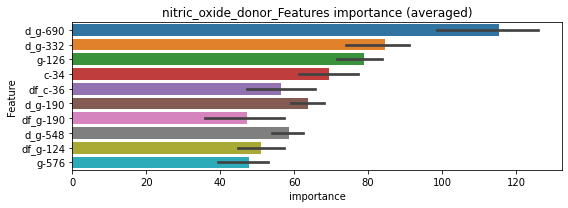

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014884	valid_1's binary_logloss: 0.0237884
[200]	training's binary_logloss: 0.00197082	valid_1's binary_logloss: 0.00805773
[300]	training's binary_logloss: 0.000541783	valid_1's binary_logloss: 0.00567753
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000409128	valid_1's binary_logloss: 0.00540381


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155117	valid_1's binary_logloss: 0.0261809
[200]	training's binary_logloss: 0.00208268	valid_1's binary_logloss: 0.00804367
[300]	training's binary_logloss: 0.000574733	valid_1's binary_logloss: 0.00463876
[400]	training's binary_logloss: 0.000280158	valid_1's binary_logloss: 0.00377033
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000209538	valid_1's binary_logloss: 0.00351045


nitric_oxide_donor logloss: 0.0044571273188669875


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3284, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323379	valid_1's binary_logloss: 0.0592269
[200]	training's binary_logloss: 0.00446427	valid_1's binary_logloss: 0.019578
[300]	training's binary_logloss: 0.00123505	valid_1's binary_logloss: 0.0113118
[400]	training's binary_logloss: 0.000626508	valid_1's binary_logloss: 0.00948635
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000463802	valid_1's binary_logloss: 0.00871155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329208	valid_1's binary_logloss: 0.0515677
[200]	training's binary_logloss: 0.00469092	valid_1's binary_logloss: 0.0128007
[300]	training's binary_logloss: 0.00127855	valid_1's binary_logloss: 0.00566775
[400]	training's binary_logloss: 0.000630995	valid_1's binary_logloss: 0.0036552
[500]	training's binary_logloss: 0.000440562	valid_1's binary_logloss: 0.00305658
Early stopping, best iteration is:
[49

1 / 3 AUC score:1.000
y_Threshold: 0.0023933, Threshold: 0.0548603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00122
Num_p_label: 80.0, conf_0:0.04937, conf_1:0.06035
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_1: 0.0548603
Num_p_label: 74.0, Expected: 4.8, Adj_threshold_2: 0.0648603
Num_p_label: 73.0, Expected: 4.8, Adj_threshold_3: 0.0748603
Num_p_label: 70.0, Expected: 4.8, Adj_threshold_4: 0.0848603
Num_p_label: 66.0, Expected: 4.8, Adj_threshold_5: 0.0948603
Num_p_label: 64.0, Expected: 4.8, Adj_threshold_6: 0.1048603
Num_p_label: 56.0, Expected: 4.8, Adj_threshold_7: 0.1148603
Num_p_label: 53.0, Expected: 4.8, Adj_threshold_8: 0.1248603
Num_p_label: 51.0, Expected: 4.8, Adj_threshold_9: 0.1348603
Num_p_label: 49.0, Expected: 4.8, Adj_threshold_10: 0.1448603
threshold: 0.1548603, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321585	valid_1's binary_logloss: 0.0559583
[200]	training's binary_logloss: 0.00433246	valid_1's binary_logloss: 0.0181896
[300]	training's binary_logloss: 0.00120425	valid_1's binary_logloss: 0.0108484
[400]	training's binary_logloss: 0.00060781	valid_1's binary_logloss: 0.00895704
[500]	training's binary_logloss: 0.000421205	valid_1's binary_logloss: 0.00812509
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000426157	valid_1's binary_logloss: 0.00811739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309446	valid_1's binary_logloss: 0.0484334
[200]	training's binary_logloss: 0.00420246	valid_1's binary_logloss: 0.0127066
[300]	training's binary_logloss: 0.00117397	valid_1's binary_logloss: 0.00618433
[400]	training's binary_logloss: 0.00059307	valid_1's binary_logloss: 0.00406525
[500]	training's binary_logloss: 0.000

2 / 3 AUC score:1.000
y_Threshold: 0.0425433, Threshold: 0.1548603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0281266 Vs.target_rate: 0.00122
Num_p_label: 112.0, conf_0:0.13937, conf_1:0.17035
Num_p_label: 112.0, Expected: 4.8, Adj_threshold_1: 0.1548603
Num_p_label: 109.0, Expected: 4.8, Adj_threshold_2: 0.1648603
Num_p_label: 106.0, Expected: 4.8, Adj_threshold_3: 0.1748603
Num_p_label: 105.0, Expected: 4.8, Adj_threshold_4: 0.1848603
Num_p_label: 103.0, Expected: 4.8, Adj_threshold_5: 0.1948603
Num_p_label: 103.0, Expected: 4.8, Adj_threshold_6: 0.2048603
Num_p_label: 100.0, Expected: 4.8, Adj_threshold_7: 0.2148603
Num_p_label: 100.0, Expected: 4.8, Adj_threshold_8: 0.2248603
Num_p_label: 98.0, Expected: 4.8, Adj_threshold_9: 0.2348603
Num_p_label: 97.0, Expected: 4.8, Adj_threshold_10: 0.2448603
threshold: 0.2548603, positive_p_label: 94.0/3982, p_label_rate: 0.0236062
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0321585	valid_1's binary_logloss: 0.0559583
[200]	training's binary_logloss: 0.00433246	valid_1's binary_logloss: 0.0181896
[300]	training's binary_logloss: 0.00120425	valid_1's binary_logloss: 0.0108484
[400]	training's binary_logloss: 0.00060781	valid_1's binary_logloss: 0.00895704
[500]	training's binary_logloss: 0.000421205	valid_1's binary_logloss: 0.00812509
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000426157	valid_1's binary_logloss: 0.00811739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309446	valid_1's binary_logloss: 0.0484334
[200]	training's binary_logloss: 0.00420246	valid_1's binary_logloss: 0.0127066
[300]	training's binary_logloss: 0.00117397	valid_1's binary_logloss: 0.00618433
[400]	training's binary_logloss: 0.00059307	valid_1's binary_logloss: 0.00406525
[500]	training's binary_logloss: 0.000

3 / 3 AUC score:1.000
y_Threshold: 0.0425433, Threshold: 0.2548603, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0236062 Vs.target_rate: 0.00122
Num_p_label: 94.0, conf_0:0.22937, conf_1:0.28035
Num_p_label: 94.0, Expected: 4.8, Adj_threshold_1: 0.2548603
Num_p_label: 93.0, Expected: 4.8, Adj_threshold_2: 0.2648603
Num_p_label: 92.0, Expected: 4.8, Adj_threshold_3: 0.2748603
Num_p_label: 90.0, Expected: 4.8, Adj_threshold_4: 0.2848603
Num_p_label: 90.0, Expected: 4.8, Adj_threshold_5: 0.2948603
Num_p_label: 89.0, Expected: 4.8, Adj_threshold_6: 0.3048603
Num_p_label: 84.0, Expected: 4.8, Adj_threshold_7: 0.3148603
Num_p_label: 82.0, Expected: 4.8, Adj_threshold_8: 0.3248603
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_9: 0.3348603
Num_p_label: 80.0, Expected: 4.8, Adj_threshold_10: 0.3448603
threshold: 0.3548603, positive_p_label: 77.0/3982, p_label_rate: 0.0193370
positive_y_label: 733.0/7790, y_label_rate: 0.0940950


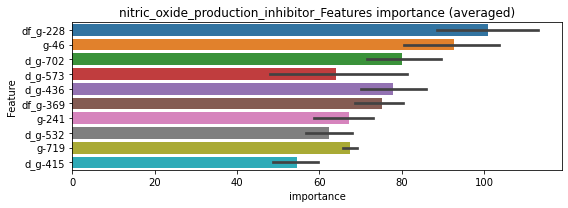

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197382	valid_1's binary_logloss: 0.0411777
[200]	training's binary_logloss: 0.00303975	valid_1's binary_logloss: 0.0219503
[300]	training's binary_logloss: 0.00082154	valid_1's binary_logloss: 0.0170535
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000556315	valid_1's binary_logloss: 0.0165418


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205205	valid_1's binary_logloss: 0.0331801
[200]	training's binary_logloss: 0.00317071	valid_1's binary_logloss: 0.0123565
[300]	training's binary_logloss: 0.000864687	valid_1's binary_logloss: 0.00949789
[400]	training's binary_logloss: 0.000411397	valid_1's binary_logloss: 0.00868677
Early stopping, best iteration is:
[429]	training's binary_logloss: 0.000355389	valid_1's binary_logloss: 0.00857659


nitric_oxide_production_inhibitor logloss: 0.01255917924711732


neg labels: 3289 → selected neg labels: 3284


nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3284, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295184	valid_1's binary_logloss: 0.0489876
[200]	training's binary_logloss: 0.00403806	valid_1's binary_logloss: 0.0179559
[300]	training's binary_logloss: 0.00111891	valid_1's binary_logloss: 0.0119572
[400]	training's binary_logloss: 0.000569401	valid_1's binary_logloss: 0.010546
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000489055	valid_1's binary_logloss: 0.0102577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300908	valid_1's binary_logloss: 0.0421392
[200]	training's binary_logloss: 0.00407806	valid_1's binary_logloss: 0.00901653
[300]	training's binary_logloss: 0.00112283	valid_1's binary_logloss: 0.0040424
[400]	training's binary_logloss: 0.000565819	valid_1's binary_logloss: 0.00290922
[500]	training's binary_logloss: 0.000407196	valid_1's binary_logloss: 0.00251451
Early stopping, best iteration is:
[520

1 / 3 AUC score:1.000
y_Threshold: 0.0027626, Threshold: 0.0038934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00350, conf_1:0.00428
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0038934
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_2: 0.0138934
Num_p_label: 3.0, Expected: 4.3, Adj_threshold_3: 0.0238934
threshold: 0.0238934, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286476	valid_1's binary_logloss: 0.0471547
[200]	training's binary_logloss: 0.00377923	valid_1's binary_logloss: 0.0189381
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00123361	valid_1's binary_logloss: 0.0138724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0300068	valid_1's binary_logloss: 0.0420847
[200]	training's binary_logloss: 0.00393967	valid_1's binary_logloss: 0.00892111
[300]	training's binary_logloss: 0.00110425	valid_1's binary_logloss: 0.00416683
[400]	training's binary_logloss: 0.000558987	valid_1's binary_logloss: 0.00313432
[500]	training's binary_logloss: 0.000405538	valid_1's binary_logloss: 0.00283844
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000412818	valid_1's binary_logloss: 0.00283376


2 / 3 AUC score:1.000
y_Threshold: 0.0288140, Threshold: 0.0238934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0057760 Vs.target_rate: 0.00109
Num_p_label: 23.0, conf_0:0.02150, conf_1:0.02628
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_1: 0.0238934
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_2: 0.0338934
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_3: 0.0438934
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_4: 0.0538934
threshold: 0.0538934, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296188	valid_1's binary_logloss: 0.0412806
[200]	training's binary_logloss: 0.00392021	valid_1's binary_logloss: 0.00838623
[300]	training's binary_logloss: 0.00109154	valid_1's binary_logloss: 0.00362972
[400]	training's binary_logloss: 0.000551466	valid_1's binary_logloss: 0.00237646
[500]	training's binary_logloss: 0.000403281	valid_1's binary_logloss: 0.00207187
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000406346	valid_1's binary_logloss: 0.0020635
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284085	valid_1's binary_logloss: 0.0429019
[200]	training's binary_logloss: 0.00378401	valid_1's binary_logloss: 0.0114172
[300]	training's binary_logloss: 0.00107307	valid_1's binary_logloss: 0.00690831
[400]	training's binary_logloss: 0.000547787	valid_1's binary_logloss: 0.00598389
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0249865, Threshold: 0.0538934, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0010045 Vs.target_rate: 0.00109
Num_p_label: 4.0, conf_0:0.04850, conf_1:0.05928
threshold: 0.0538934, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/7782, y_label_rate: 0.0842971


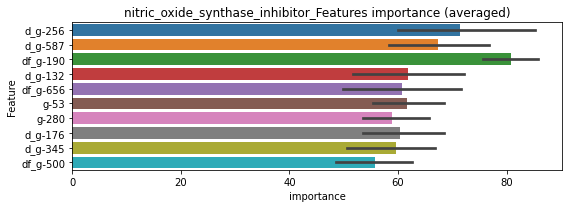

len(train_index) : 3891
len(valid_index) : 3891
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161638	valid_1's binary_logloss: 0.0262406
[200]	training's binary_logloss: 0.00222035	valid_1's binary_logloss: 0.00737008
[300]	training's binary_logloss: 0.000580606	valid_1's binary_logloss: 0.00457919
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.000298713	valid_1's binary_logloss: 0.00414593


len(train_index) : 3891
len(valid_index) : 3891
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163603	valid_1's binary_logloss: 0.0236525
[200]	training's binary_logloss: 0.00215721	valid_1's binary_logloss: 0.00675167
[300]	training's binary_logloss: 0.000589289	valid_1's binary_logloss: 0.00427646
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000328569	valid_1's binary_logloss: 0.00376594


nitric_oxide_synthase_inhibitor logloss: 0.0039559311210107


neg labels: 3289 → selected neg labels: 3287


norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162314	valid_1's binary_logloss: 0.0174422
[200]	training's binary_logloss: 0.00140219	valid_1's binary_logloss: 0.00168023
[300]	training's binary_logloss: 0.000382872	valid_1's binary_logloss: 0.000485005
[400]	training's binary_logloss: 0.000230739	valid_1's binary_logloss: 0.00029999
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000207488	valid_1's binary_logloss: 0.000271171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162994	valid_1's binary_logloss: 0.0177552
[200]	training's binary_logloss: 0.00140008	valid_1's binary_logloss: 0.00178356
[300]	training's binary_logloss: 0.000381567	valid_1's binary_logloss: 0.000547719
[400]	training's binary_logloss: 0.000229265	valid_1's binary_logloss: 0.000343581
[500]	training's binary_logloss: 0.000204124	valid_1's binary_logloss: 0.000308344
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0005854, Threshold: 0.0009107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00082, conf_1:0.00100
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009107
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_2: 0.0109107
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_3: 0.0209107
threshold: 0.0209107, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165731	valid_1's binary_logloss: 0.0186639
[200]	training's binary_logloss: 0.00139695	valid_1's binary_logloss: 0.00213803
[300]	training's binary_logloss: 0.000378187	valid_1's binary_logloss: 0.000728769
[400]	training's binary_logloss: 0.000229741	valid_1's binary_logloss: 0.000503151
[500]	training's binary_logloss: 0.000203376	valid_1's binary_logloss: 0.000460686
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000201354	valid_1's binary_logloss: 0.000458951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164817	valid_1's binary_logloss: 0.0177038
[200]	training's binary_logloss: 0.00139612	valid_1's binary_logloss: 0.00161758
[300]	training's binary_logloss: 0.00037879	valid_1's binary_logloss: 0.000450111
[400]	training's binary_logloss: 0.000230743	valid_1's binary_logloss: 0.000276809
[500]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1366050, Threshold: 0.0209107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00029
Num_p_label: 9.0, conf_0:0.01882, conf_1:0.02300
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_1: 0.0209107
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.0309107
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.0409107
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.0509107
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_5: 0.0609107
threshold: 0.0609107, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165731	valid_1's binary_logloss: 0.0186639
[200]	training's binary_logloss: 0.00139695	valid_1's binary_logloss: 0.00213803
[300]	training's binary_logloss: 0.000378187	valid_1's binary_logloss: 0.000728769
[400]	training's binary_logloss: 0.000229741	valid_1's binary_logloss: 0.000503151
[500]	training's binary_logloss: 0.000203376	valid_1's binary_logloss: 0.000460686
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000201354	valid_1's binary_logloss: 0.000458951
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164817	valid_1's binary_logloss: 0.0177038
[200]	training's binary_logloss: 0.00139612	valid_1's binary_logloss: 0.00161758
[300]	training's binary_logloss: 0.00037879	valid_1's binary_logloss: 0.000450111
[400]	training's binary_logloss: 0.000230743	valid_1's binary_logloss: 0.000276809
[500]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1366050, Threshold: 0.0609107, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00029
Num_p_label: 1.0, conf_0:0.05482, conf_1:0.06700
threshold: 0.0609107, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 658.0/7794, y_label_rate: 0.0844239


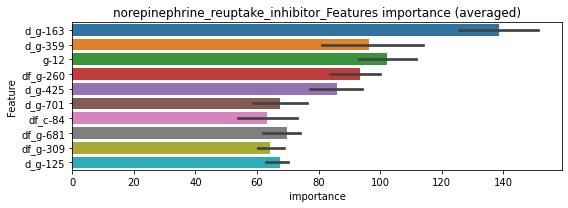

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00864017	valid_1's binary_logloss: 0.0106097
[200]	training's binary_logloss: 0.000707225	valid_1's binary_logloss: 0.00204654
[300]	training's binary_logloss: 0.000187517	valid_1's binary_logloss: 0.00154603
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000202588	valid_1's binary_logloss: 0.00154145


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00870496	valid_1's binary_logloss: 0.00961251
[200]	training's binary_logloss: 0.000728998	valid_1's binary_logloss: 0.000980562
[300]	training's binary_logloss: 0.00019444	valid_1's binary_logloss: 0.000295147
[400]	training's binary_logloss: 0.000117164	valid_1's binary_logloss: 0.000187603
[500]	training's binary_logloss: 0.000104142	valid_1's binary_logloss: 0.000167965
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.00010304	valid_1's binary_logloss: 0.000166342


norepinephrine_reuptake_inhibitor logloss: 0.0008538957189794546


neg labels: 3289 → selected neg labels: 3286


nrf2_activator, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203132	valid_1's binary_logloss: 0.0266867
[200]	training's binary_logloss: 0.00215931	valid_1's binary_logloss: 0.00648175
[300]	training's binary_logloss: 0.000608132	valid_1's binary_logloss: 0.00432146
[400]	training's binary_logloss: 0.000339021	valid_1's binary_logloss: 0.0037362
[500]	training's binary_logloss: 0.00029335	valid_1's binary_logloss: 0.00352337
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.00029335	valid_1's binary_logloss: 0.00352337
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205428	valid_1's binary_logloss: 0.0261253
[200]	training's binary_logloss: 0.00216754	valid_1's binary_logloss: 0.00521965
[300]	training's binary_logloss: 0.000610678	valid_1's binary_logloss: 0.00289737
[400]	training's binary_logloss: 0.000341571	valid_1's binary_logloss: 0.00227724
Early stopping, best iteration is:

1 / 3 AUC score:1.000
y_Threshold: 0.0009778, Threshold: 0.1205740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.10852, conf_1:0.13263
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.1205740
Num_p_label: 79.0, Expected: 3.0, Adj_threshold_2: 0.1305740
Num_p_label: 79.0, Expected: 3.0, Adj_threshold_3: 0.1405740
Num_p_label: 77.0, Expected: 3.0, Adj_threshold_4: 0.1505740
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_5: 0.1605740
Num_p_label: 75.0, Expected: 3.0, Adj_threshold_6: 0.1705740
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_7: 0.1805740
Num_p_label: 74.0, Expected: 3.0, Adj_threshold_8: 0.1905740
Num_p_label: 72.0, Expected: 3.0, Adj_threshold_9: 0.2005740
Num_p_label: 69.0, Expected: 3.0, Adj_threshold_10: 0.2105740
threshold: 0.2205740, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195453	valid_1's binary_logloss: 0.0228765
[200]	training's binary_logloss: 0.00192968	valid_1's binary_logloss: 0.00283771
[300]	training's binary_logloss: 0.000529359	valid_1's binary_logloss: 0.00100707
[400]	training's binary_logloss: 0.000292437	valid_1's binary_logloss: 0.000629409
[500]	training's binary_logloss: 0.000258672	valid_1's binary_logloss: 0.000570896
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000258145	valid_1's binary_logloss: 0.00056997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197035	valid_1's binary_logloss: 0.0231789
[200]	training's binary_logloss: 0.00193826	valid_1's binary_logloss: 0.00287588
[300]	training's binary_logloss: 0.000528654	valid_1's binary_logloss: 0.000920665
[400]	training's binary_logloss: 0.000303632	valid_1's binary_logloss: 0.00057855
[500]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.2868829, Threshold: 0.2205740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0306379 Vs.target_rate: 0.00076
Num_p_label: 122.0, conf_0:0.19852, conf_1:0.24263
Num_p_label: 122.0, Expected: 3.0, Adj_threshold_1: 0.2205740
Num_p_label: 121.0, Expected: 3.0, Adj_threshold_2: 0.2305740
Num_p_label: 119.0, Expected: 3.0, Adj_threshold_3: 0.2405740
Num_p_label: 119.0, Expected: 3.0, Adj_threshold_4: 0.2505740
Num_p_label: 119.0, Expected: 3.0, Adj_threshold_5: 0.2605740
Num_p_label: 118.0, Expected: 3.0, Adj_threshold_6: 0.2705740
Num_p_label: 115.0, Expected: 3.0, Adj_threshold_7: 0.2805740
Num_p_label: 114.0, Expected: 3.0, Adj_threshold_8: 0.2905740
Num_p_label: 113.0, Expected: 3.0, Adj_threshold_9: 0.3005740
Num_p_label: 112.0, Expected: 3.0, Adj_threshold_10: 0.3105740
threshold: 0.3205740, positive_p_label: 111.0/3982, p_label_rate: 0.0278754
positive_y_label: 657.0/3811, y_label_rate: 0.17239

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0195453	valid_1's binary_logloss: 0.0228765
[200]	training's binary_logloss: 0.00192968	valid_1's binary_logloss: 0.00283771
[300]	training's binary_logloss: 0.000529359	valid_1's binary_logloss: 0.00100707
[400]	training's binary_logloss: 0.000292437	valid_1's binary_logloss: 0.000629409
[500]	training's binary_logloss: 0.000258672	valid_1's binary_logloss: 0.000570896
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.000258145	valid_1's binary_logloss: 0.00056997
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197035	valid_1's binary_logloss: 0.0231789
[200]	training's binary_logloss: 0.00193826	valid_1's binary_logloss: 0.00287588
[300]	training's binary_logloss: 0.000528654	valid_1's binary_logloss: 0.000920665
[400]	training's binary_logloss: 0.000303632	valid_1's binary_logloss: 0.00057855
[500]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.2868829, Threshold: 0.3205740, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0278754 Vs.target_rate: 0.00076
Num_p_label: 111.0, conf_0:0.28852, conf_1:0.35263
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_1: 0.3205740
Num_p_label: 111.0, Expected: 3.0, Adj_threshold_2: 0.3305740
Num_p_label: 110.0, Expected: 3.0, Adj_threshold_3: 0.3405740
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_4: 0.3505740
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_5: 0.3605740
Num_p_label: 108.0, Expected: 3.0, Adj_threshold_6: 0.3705740
Num_p_label: 106.0, Expected: 3.0, Adj_threshold_7: 0.3805740
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_8: 0.3905740
Num_p_label: 104.0, Expected: 3.0, Adj_threshold_9: 0.4005740
Num_p_label: 103.0, Expected: 3.0, Adj_threshold_10: 0.4105740
threshold: 0.4205740, positive_p_label: 103.0/3982, p_label_rate: 0.0258664
positive_y_label: 760.0/7793, y_label_rate: 0.09752

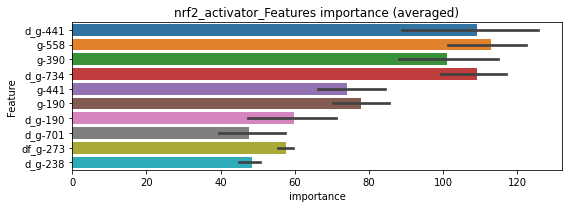

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0129114	valid_1's binary_logloss: 0.0194967
[200]	training's binary_logloss: 0.00144148	valid_1's binary_logloss: 0.00627067
[300]	training's binary_logloss: 0.000396993	valid_1's binary_logloss: 0.00487456
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.000286378	valid_1's binary_logloss: 0.00473131


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0125266	valid_1's binary_logloss: 0.0190449
[200]	training's binary_logloss: 0.00138715	valid_1's binary_logloss: 0.00622884
[300]	training's binary_logloss: 0.000382215	valid_1's binary_logloss: 0.00504881
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00027968	valid_1's binary_logloss: 0.00490909


nrf2_activator logloss: 0.004820190646963942


neg labels: 3289 → selected neg labels: 3279


opioid_receptor_agonist, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550229	valid_1's binary_logloss: 0.10006
[200]	training's binary_logloss: 0.0117532	valid_1's binary_logloss: 0.0494126
[300]	training's binary_logloss: 0.00326111	valid_1's binary_logloss: 0.0339719
[400]	training's binary_logloss: 0.0014133	valid_1's binary_logloss: 0.0287405
[500]	training's binary_logloss: 0.00084283	valid_1's binary_logloss: 0.0264863
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000641029	valid_1's binary_logloss: 0.0254694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501729	valid_1's binary_logloss: 0.0936164
[200]	training's binary_logloss: 0.0103777	valid_1's binary_logloss: 0.0412995
[300]	training's binary_logloss: 0.00295074	valid_1's binary_logloss: 0.0269232
[400]	training's binary_logloss: 0.00132076	valid_1's binary_logloss: 0.0232723
Early stopping, best iteration is:
[473]	training

1 / 3 AUC score:0.999
y_Threshold: 0.0068550, Threshold: 0.0106197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.00956, conf_1:0.01168
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0106197
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_2: 0.0206197
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_3: 0.0306197
threshold: 0.0306197, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0527702	valid_1's binary_logloss: 0.0965788
[200]	training's binary_logloss: 0.0104129	valid_1's binary_logloss: 0.0463851
[300]	training's binary_logloss: 0.00289259	valid_1's binary_logloss: 0.034054
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0021986	valid_1's binary_logloss: 0.0324096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0479477	valid_1's binary_logloss: 0.106823
[200]	training's binary_logloss: 0.00912157	valid_1's binary_logloss: 0.056091
[300]	training's binary_logloss: 0.00261806	valid_1's binary_logloss: 0.0448398
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00172985	valid_1's binary_logloss: 0.0432252


2 / 3 AUC score:0.998
y_Threshold: 0.0531163, Threshold: 0.0306197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 643.0/3778
p_label_rate: 0.0160723 Vs.target_rate: 0.00256
Num_p_label: 64.0, conf_0:0.02756, conf_1:0.03368
Num_p_label: 64.0, Expected: 10.2, Adj_threshold_1: 0.0306197
Num_p_label: 38.0, Expected: 10.2, Adj_threshold_2: 0.0406197
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_3: 0.0506197
Num_p_label: 22.0, Expected: 10.2, Adj_threshold_4: 0.0606197
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_5: 0.0706197
threshold: 0.0706197, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 643.0/3778, y_label_rate: 0.1701959
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502995	valid_1's binary_logloss: 0.0920482
[200]	training's binary_logloss: 0.010115	valid_1's binary_logloss: 0.0413009
[300]	training's binary_logloss: 0.00280881	valid_1's binary_logloss: 0.0278397
[400]	training's binary_logloss: 0.00125779	valid_1's binary_logloss: 0.0233832
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000926334	valid_1's binary_logloss: 0.0221866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0482488	valid_1's binary_logloss: 0.0948239
[200]	training's binary_logloss: 0.00903424	valid_1's binary_logloss: 0.0462672
[300]	training's binary_logloss: 0.00259096	valid_1's binary_logloss: 0.0346755
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00135377	valid_1's binary_logloss: 0.0322259


3 / 3 AUC score:0.999
y_Threshold: 0.0310145, Threshold: 0.0706197, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 636.0/3764
p_label_rate: 0.0020090 Vs.target_rate: 0.00256
Num_p_label: 8.0, conf_0:0.06356, conf_1:0.07768
threshold: 0.0706197, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 644.0/7746, y_label_rate: 0.0831397


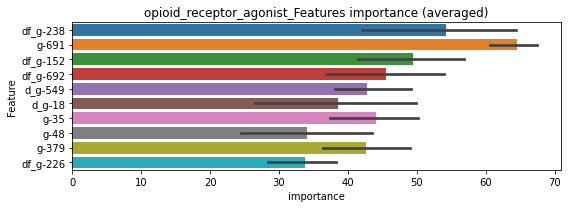

len(train_index) : 3873
len(valid_index) : 3873
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277149	valid_1's binary_logloss: 0.0574133
[200]	training's binary_logloss: 0.00523728	valid_1's binary_logloss: 0.0316965
[300]	training's binary_logloss: 0.00142337	valid_1's binary_logloss: 0.0272155
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00155068	valid_1's binary_logloss: 0.0271331


len(train_index) : 3873
len(valid_index) : 3873
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258769	valid_1's binary_logloss: 0.0573099
[200]	training's binary_logloss: 0.00503956	valid_1's binary_logloss: 0.0310374
[300]	training's binary_logloss: 0.00140488	valid_1's binary_logloss: 0.0257541
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000974822	valid_1's binary_logloss: 0.025088


opioid_receptor_agonist logloss: 0.026110560320138185


neg labels: 3289 → selected neg labels: 3275


opioid_receptor_antagonist, len(trt): 96, len(othr): 3275, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0632342	valid_1's binary_logloss: 0.134264
[200]	training's binary_logloss: 0.0155859	valid_1's binary_logloss: 0.0778453
[300]	training's binary_logloss: 0.00449312	valid_1's binary_logloss: 0.0607875
[400]	training's binary_logloss: 0.00195613	valid_1's binary_logloss: 0.0564135
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00136404	valid_1's binary_logloss: 0.0554955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.06768	valid_1's binary_logloss: 0.142307
[200]	training's binary_logloss: 0.0163987	valid_1's binary_logloss: 0.090366
[300]	training's binary_logloss: 0.00491991	valid_1's binary_logloss: 0.0787784
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00369199	valid_1's binary_logloss: 0.0775475


1 / 3 AUC score:0.990
y_Threshold: 0.0197983, Threshold: 0.0282922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 177 → Positive_corect_labels: 632/3753
p_label_rate: 0.0200904 Vs.target_rate: 0.00403
Num_p_label: 80.0, conf_0:0.02546, conf_1:0.03112
Num_p_label: 80.0, Expected: 16.1, Adj_threshold_1: 0.0282922
Num_p_label: 45.0, Expected: 16.1, Adj_threshold_2: 0.0382922
Num_p_label: 27.0, Expected: 16.1, Adj_threshold_3: 0.0482922
threshold: 0.0482922, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 632.0/3753, y_label_rate: 0.1683986
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0582594	valid_1's binary_logloss: 0.132286
[200]	training's binary_logloss: 0.0127069	valid_1's binary_logloss: 0.0766989
[300]	training's binary_logloss: 0.00389216	valid_1's binary_logloss: 0.0593819
[400]	training's binary_logloss: 0.00176702	valid_1's binary_logloss: 0.0550444
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00185769	valid_1's binary_logloss: 0.0549075
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620504	valid_1's binary_logloss: 0.136708
[200]	training's binary_logloss: 0.0135563	valid_1's binary_logloss: 0.0807096
[300]	training's binary_logloss: 0.0040926	valid_1's binary_logloss: 0.0681095
[400]	training's binary_logloss: 0.0018608	valid_1's binary_logloss: 0.0635274
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00148569	valid_1's binary_logloss: 0.0628861


2 / 3 AUC score:0.997
y_Threshold: 0.0415365, Threshold: 0.0482922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 36 → Positive_corect_labels: 614.0/3717
p_label_rate: 0.0110497 Vs.target_rate: 0.00403
Num_p_label: 44.0, conf_0:0.04346, conf_1:0.05312
threshold: 0.0482922, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 614.0/3717, y_label_rate: 0.1651870
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596565	valid_1's binary_logloss: 0.123275
[200]	training's binary_logloss: 0.0130516	valid_1's binary_logloss: 0.0709354
[300]	training's binary_logloss: 0.0037932	valid_1's binary_logloss: 0.0574995
[400]	training's binary_logloss: 0.00165182	valid_1's binary_logloss: 0.0531109
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00158234	valid_1's binary_logloss: 0.0530607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0576733	valid_1's binary_logloss: 0.122916
[200]	training's binary_logloss: 0.0124446	valid_1's binary_logloss: 0.0658636
[300]	training's binary_logloss: 0.0038983	valid_1's binary_logloss: 0.0469681
[400]	training's binary_logloss: 0.0016687	valid_1's binary_logloss: 0.0391149
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00113768	valid_1's binary_logloss: 0.0363347


3 / 3 AUC score:0.999
y_Threshold: 0.0397369, Threshold: 0.0482922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 603.0/3695
p_label_rate: 0.0082873 Vs.target_rate: 0.00403
Num_p_label: 33.0, conf_0:0.04346, conf_1:0.05312
threshold: 0.0482922, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 636.0/7677, y_label_rate: 0.0828449


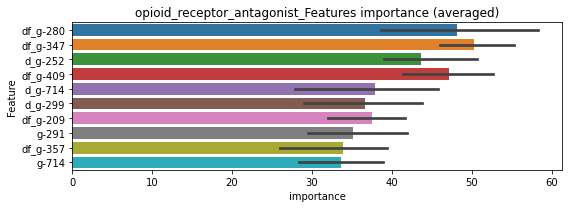

len(train_index) : 3838
len(valid_index) : 3839
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324572	valid_1's binary_logloss: 0.0850301
[200]	training's binary_logloss: 0.00706173	valid_1's binary_logloss: 0.0590856
[300]	training's binary_logloss: 0.00207359	valid_1's binary_logloss: 0.0540326
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00157486	valid_1's binary_logloss: 0.0536997


len(train_index) : 3839
len(valid_index) : 3838
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345362	valid_1's binary_logloss: 0.081942
[200]	training's binary_logloss: 0.00755207	valid_1's binary_logloss: 0.0526026
Early stopping, best iteration is:
[279]	training's binary_logloss: 0.00273369	valid_1's binary_logloss: 0.0492688


opioid_receptor_antagonist logloss: 0.05148457189164493


neg labels: 3289 → selected neg labels: 3283


orexin_receptor_antagonist, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354668	valid_1's binary_logloss: 0.0661098
[200]	training's binary_logloss: 0.0054795	valid_1's binary_logloss: 0.0256463
[300]	training's binary_logloss: 0.00152765	valid_1's binary_logloss: 0.0179406
[400]	training's binary_logloss: 0.000730695	valid_1's binary_logloss: 0.0151999
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.000585968	valid_1's binary_logloss: 0.0146982
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356992	valid_1's binary_logloss: 0.0679619
[200]	training's binary_logloss: 0.0053996	valid_1's binary_logloss: 0.0283696
[300]	training's binary_logloss: 0.00150788	valid_1's binary_logloss: 0.0206729
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.0010849	valid_1's binary_logloss: 0.0193967


1 / 3 AUC score:1.000
y_Threshold: 0.0049405, Threshold: 0.0065208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00587, conf_1:0.00717
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0065208
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_2: 0.0165208
threshold: 0.0165208, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344832	valid_1's binary_logloss: 0.0634538
[200]	training's binary_logloss: 0.00509984	valid_1's binary_logloss: 0.0245646
[300]	training's binary_logloss: 0.00143664	valid_1's binary_logloss: 0.016755
[400]	training's binary_logloss: 0.000699396	valid_1's binary_logloss: 0.0146556
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000591974	valid_1's binary_logloss: 0.0142476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360474	valid_1's binary_logloss: 0.0673259
[200]	training's binary_logloss: 0.00542513	valid_1's binary_logloss: 0.0269438
[300]	training's binary_logloss: 0.0015191	valid_1's binary_logloss: 0.0197742
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00121737	valid_1's binary_logloss: 0.0191885


2 / 3 AUC score:1.000
y_Threshold: 0.0260963, Threshold: 0.0165208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0070316 Vs.target_rate: 0.00155
Num_p_label: 28.0, conf_0:0.01487, conf_1:0.01817
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_1: 0.0165208
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_2: 0.0265208
threshold: 0.0265208, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345351	valid_1's binary_logloss: 0.057534
[200]	training's binary_logloss: 0.00520453	valid_1's binary_logloss: 0.0168608
[300]	training's binary_logloss: 0.00148587	valid_1's binary_logloss: 0.0100351
[400]	training's binary_logloss: 0.000720042	valid_1's binary_logloss: 0.00831087
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000630668	valid_1's binary_logloss: 0.00807451
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361777	valid_1's binary_logloss: 0.0639018
[200]	training's binary_logloss: 0.00537724	valid_1's binary_logloss: 0.0238619
[300]	training's binary_logloss: 0.00148694	valid_1's binary_logloss: 0.0152062
[400]	training's binary_logloss: 0.000720775	valid_1's binary_logloss: 0.0129779
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.000559249	valid_1's binary_logloss: 0.01232


3 / 3 AUC score:1.000
y_Threshold: 0.0220924, Threshold: 0.0265208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0015068 Vs.target_rate: 0.00155
Num_p_label: 6.0, conf_0:0.02387, conf_1:0.02917
threshold: 0.0265208, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 659.0/7783, y_label_rate: 0.0846717


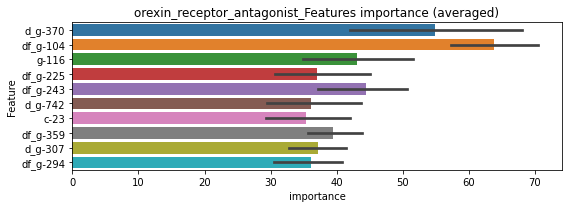

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0192687	valid_1's binary_logloss: 0.0389904
[200]	training's binary_logloss: 0.00283462	valid_1's binary_logloss: 0.0165867
[300]	training's binary_logloss: 0.000785545	valid_1's binary_logloss: 0.0131057
[400]	training's binary_logloss: 0.000367298	valid_1's binary_logloss: 0.012309
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000346376	valid_1's binary_logloss: 0.0122881


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0198198	valid_1's binary_logloss: 0.0325331
[200]	training's binary_logloss: 0.00300951	valid_1's binary_logloss: 0.0111606
[300]	training's binary_logloss: 0.000838152	valid_1's binary_logloss: 0.008159
[400]	training's binary_logloss: 0.000387986	valid_1's binary_logloss: 0.00710291
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000366823	valid_1's binary_logloss: 0.00698849


orexin_receptor_antagonist logloss: 0.009638619839021822


neg labels: 3289 → selected neg labels: 3278


p38_mapk_inhibitor, len(trt): 62, len(othr): 3278, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317416	valid_1's binary_logloss: 0.0755982
[200]	training's binary_logloss: 0.00467434	valid_1's binary_logloss: 0.0444004
[300]	training's binary_logloss: 0.00137681	valid_1's binary_logloss: 0.0382543
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00118891	valid_1's binary_logloss: 0.0376898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306917	valid_1's binary_logloss: 0.0758421
[200]	training's binary_logloss: 0.0044867	valid_1's binary_logloss: 0.0430857
[300]	training's binary_logloss: 0.00130636	valid_1's binary_logloss: 0.0376262
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000738658	valid_1's binary_logloss: 0.0359979


1 / 3 AUC score:0.998
y_Threshold: 0.0067518, Threshold: 0.0158226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3785
p_label_rate: 0.0200904 Vs.target_rate: 0.00260
Num_p_label: 80.0, conf_0:0.01424, conf_1:0.01740
Num_p_label: 80.0, Expected: 10.4, Adj_threshold_1: 0.0158226
Num_p_label: 51.0, Expected: 10.4, Adj_threshold_2: 0.0258226
Num_p_label: 39.0, Expected: 10.4, Adj_threshold_3: 0.0358226
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_4: 0.0458226
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_5: 0.0558226
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_6: 0.0658226
Num_p_label: 24.0, Expected: 10.4, Adj_threshold_7: 0.0758226
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_8: 0.0858226
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_9: 0.0958226
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_10: 0.1058226
threshold: 0.1058226, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 647.0/3785, y_label_rate: 0.1709379

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030792	valid_1's binary_logloss: 0.0537996
[200]	training's binary_logloss: 0.00441233	valid_1's binary_logloss: 0.0202447
[300]	training's binary_logloss: 0.00129102	valid_1's binary_logloss: 0.0137479
[400]	training's binary_logloss: 0.000644895	valid_1's binary_logloss: 0.0112575
[500]	training's binary_logloss: 0.000442629	valid_1's binary_logloss: 0.0106376
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000450771	valid_1's binary_logloss: 0.0106134
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307618	valid_1's binary_logloss: 0.0591208
[200]	training's binary_logloss: 0.00425144	valid_1's binary_logloss: 0.0255452
[300]	training's binary_logloss: 0.00123406	valid_1's binary_logloss: 0.0217436
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00135495	valid_1's binary_logloss: 0.0216483


2 / 3 AUC score:1.000
y_Threshold: 0.0247584, Threshold: 0.1058226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 12 → Positive_corect_labels: 641.0/3773
p_label_rate: 0.0080362 Vs.target_rate: 0.00260
Num_p_label: 32.0, conf_0:0.09524, conf_1:0.11640
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_1: 0.1058226
Num_p_label: 31.0, Expected: 10.4, Adj_threshold_2: 0.1158226
Num_p_label: 27.0, Expected: 10.4, Adj_threshold_3: 0.1258226
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_4: 0.1358226
Num_p_label: 25.0, Expected: 10.4, Adj_threshold_5: 0.1458226
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_6: 0.1558226
Num_p_label: 22.0, Expected: 10.4, Adj_threshold_7: 0.1658226
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_8: 0.1758226
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_9: 0.1858226
threshold: 0.1858226, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 641.0/3773, y_label_rate: 0.1698913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297766	valid_1's binary_logloss: 0.0573875
[200]	training's binary_logloss: 0.00418912	valid_1's binary_logloss: 0.023569
[300]	training's binary_logloss: 0.00121314	valid_1's binary_logloss: 0.0182062
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00094327	valid_1's binary_logloss: 0.0174365
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298377	valid_1's binary_logloss: 0.0496536
[200]	training's binary_logloss: 0.00429338	valid_1's binary_logloss: 0.017273
[300]	training's binary_logloss: 0.00121854	valid_1's binary_logloss: 0.011756
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000792556	valid_1's binary_logloss: 0.0105389


3 / 3 AUC score:1.000
y_Threshold: 0.0354864, Threshold: 0.1858226, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 638.0/3767
p_label_rate: 0.0060271 Vs.target_rate: 0.00260
Num_p_label: 24.0, conf_0:0.16724, conf_1:0.20440
threshold: 0.1858226, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 662.0/7749, y_label_rate: 0.0854304


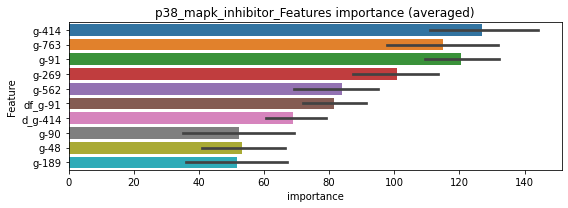

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153758	valid_1's binary_logloss: 0.0391602
[200]	training's binary_logloss: 0.002139	valid_1's binary_logloss: 0.0224755
[300]	training's binary_logloss: 0.00062069	valid_1's binary_logloss: 0.0202435
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000434052	valid_1's binary_logloss: 0.0200239


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157973	valid_1's binary_logloss: 0.030253
[200]	training's binary_logloss: 0.0022362	valid_1's binary_logloss: 0.0135385
[300]	training's binary_logloss: 0.00066584	valid_1's binary_logloss: 0.0104925
[400]	training's binary_logloss: 0.0003383	valid_1's binary_logloss: 0.0094081
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000239181	valid_1's binary_logloss: 0.00896448


p38_mapk_inhibitor logloss: 0.01449488668604046


neg labels: 3289 → selected neg labels: 3285


p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282528	valid_1's binary_logloss: 0.0415755
[200]	training's binary_logloss: 0.00368001	valid_1's binary_logloss: 0.00901583
[300]	training's binary_logloss: 0.0010276	valid_1's binary_logloss: 0.00448153
[400]	training's binary_logloss: 0.000521129	valid_1's binary_logloss: 0.00352504
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.000443844	valid_1's binary_logloss: 0.00331087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291262	valid_1's binary_logloss: 0.0494347
[200]	training's binary_logloss: 0.00384782	valid_1's binary_logloss: 0.0162838
[300]	training's binary_logloss: 0.00104298	valid_1's binary_logloss: 0.0105654
[400]	training's binary_logloss: 0.000521577	valid_1's binary_logloss: 0.00900008
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000499207	valid_1's binary_logloss: 0.00894278


1 / 3 AUC score:1.000
y_Threshold: 0.0026801, Threshold: 0.0034356, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00309, conf_1:0.00378
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0034356
Num_p_label: 3.0, Expected: 4.0, Adj_threshold_2: 0.0134356
threshold: 0.0134356, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028065	valid_1's binary_logloss: 0.0406582
[200]	training's binary_logloss: 0.00358421	valid_1's binary_logloss: 0.00783661
[300]	training's binary_logloss: 0.001006	valid_1's binary_logloss: 0.00317122
[400]	training's binary_logloss: 0.00051413	valid_1's binary_logloss: 0.00211771
[500]	training's binary_logloss: 0.000380451	valid_1's binary_logloss: 0.00184957
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.000381217	valid_1's binary_logloss: 0.00184597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278787	valid_1's binary_logloss: 0.0495916
[200]	training's binary_logloss: 0.00356767	valid_1's binary_logloss: 0.0168952
[300]	training's binary_logloss: 0.000987022	valid_1's binary_logloss: 0.01159
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.000853259	valid_1's binary_logloss: 0.0112619


2 / 3 AUC score:1.000
y_Threshold: 0.0176280, Threshold: 0.0134356, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0052737 Vs.target_rate: 0.00101
Num_p_label: 21.0, conf_0:0.01209, conf_1:0.01478
Num_p_label: 21.0, Expected: 4.0, Adj_threshold_1: 0.0134356
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.0234356
Num_p_label: 5.0, Expected: 4.0, Adj_threshold_3: 0.0334356
threshold: 0.0334356, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276658	valid_1's binary_logloss: 0.04051
[200]	training's binary_logloss: 0.00352113	valid_1's binary_logloss: 0.00915365
[300]	training's binary_logloss: 0.000984996	valid_1's binary_logloss: 0.00467226
[400]	training's binary_logloss: 0.000505503	valid_1's binary_logloss: 0.00377764
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000432211	valid_1's binary_logloss: 0.00358191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280384	valid_1's binary_logloss: 0.0441974
[200]	training's binary_logloss: 0.00360768	valid_1's binary_logloss: 0.0125077
[300]	training's binary_logloss: 0.00100849	valid_1's binary_logloss: 0.00700974
[400]	training's binary_logloss: 0.00051012	valid_1's binary_logloss: 0.0053268
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000423991	valid_1's binary_logloss: 0.005016


3 / 3 AUC score:1.000
y_Threshold: 0.0289197, Threshold: 0.0334356, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0007534 Vs.target_rate: 0.00101
Num_p_label: 3.0, conf_0:0.03009, conf_1:0.03678
threshold: 0.0334356, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 659.0/7790, y_label_rate: 0.0845956


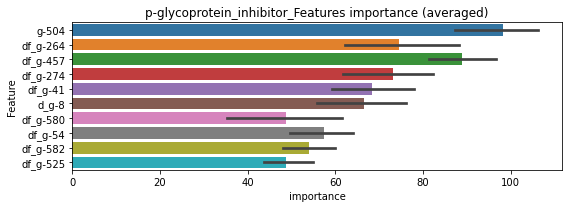

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0154057	valid_1's binary_logloss: 0.024251
[200]	training's binary_logloss: 0.00196064	valid_1's binary_logloss: 0.00702757
[300]	training's binary_logloss: 0.000524446	valid_1's binary_logloss: 0.00432618
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0003152	valid_1's binary_logloss: 0.00379526


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155985	valid_1's binary_logloss: 0.0251158
[200]	training's binary_logloss: 0.00210259	valid_1's binary_logloss: 0.00713344
[300]	training's binary_logloss: 0.000589423	valid_1's binary_logloss: 0.00441926
[400]	training's binary_logloss: 0.000262342	valid_1's binary_logloss: 0.00374553
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.000209622	valid_1's binary_logloss: 0.00363741


p-glycoprotein_inhibitor logloss: 0.0037163355624400237


neg labels: 3289 → selected neg labels: 3279


parp_inhibitor, len(trt): 61, len(othr): 3279, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04516	valid_1's binary_logloss: 0.0800365
[200]	training's binary_logloss: 0.00791633	valid_1's binary_logloss: 0.0327102
[300]	training's binary_logloss: 0.00230041	valid_1's binary_logloss: 0.0228673
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00139549	valid_1's binary_logloss: 0.0205194
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468426	valid_1's binary_logloss: 0.088741
[200]	training's binary_logloss: 0.00814468	valid_1's binary_logloss: 0.0352447
[300]	training's binary_logloss: 0.0023595	valid_1's binary_logloss: 0.0223897
[400]	training's binary_logloss: 0.00109929	valid_1's binary_logloss: 0.0184357
[500]	training's binary_logloss: 0.000694151	valid_1's binary_logloss: 0.016982
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000603406	valid_1's binary_logloss: 0.0165817


1 / 3 AUC score:1.000
y_Threshold: 0.0106118, Threshold: 0.0155975, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 134 → Positive_corect_labels: 654/3800
p_label_rate: 0.0200904 Vs.target_rate: 0.00256
Num_p_label: 80.0, conf_0:0.01404, conf_1:0.01716
Num_p_label: 80.0, Expected: 10.2, Adj_threshold_1: 0.0155975
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_2: 0.0255975
Num_p_label: 30.0, Expected: 10.2, Adj_threshold_3: 0.0355975
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_4: 0.0455975
threshold: 0.0455975, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043727	valid_1's binary_logloss: 0.0837162
[200]	training's binary_logloss: 0.00767732	valid_1's binary_logloss: 0.036183
[300]	training's binary_logloss: 0.00219609	valid_1's binary_logloss: 0.0246546
[400]	training's binary_logloss: 0.00104568	valid_1's binary_logloss: 0.0214243
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00086315	valid_1's binary_logloss: 0.0209108
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440391	valid_1's binary_logloss: 0.0835759
[200]	training's binary_logloss: 0.00759596	valid_1's binary_logloss: 0.0381651
[300]	training's binary_logloss: 0.00221764	valid_1's binary_logloss: 0.0291222
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00168295	valid_1's binary_logloss: 0.0282585


2 / 3 AUC score:0.999
y_Threshold: 0.0416171, Threshold: 0.0455975, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0130588 Vs.target_rate: 0.00256
Num_p_label: 52.0, conf_0:0.04104, conf_1:0.05016
Num_p_label: 52.0, Expected: 10.2, Adj_threshold_1: 0.0455975
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_2: 0.0555975
Num_p_label: 32.0, Expected: 10.2, Adj_threshold_3: 0.0655975
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_4: 0.0755975
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_5: 0.0855975
threshold: 0.0855975, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431945	valid_1's binary_logloss: 0.0780995
[200]	training's binary_logloss: 0.00759995	valid_1's binary_logloss: 0.0308732
[300]	training's binary_logloss: 0.00218364	valid_1's binary_logloss: 0.0210123
[400]	training's binary_logloss: 0.00102437	valid_1's binary_logloss: 0.0177986
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000783387	valid_1's binary_logloss: 0.0170029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043276	valid_1's binary_logloss: 0.0842762
[200]	training's binary_logloss: 0.00719684	valid_1's binary_logloss: 0.0391613
[300]	training's binary_logloss: 0.00204399	valid_1's binary_logloss: 0.0282579
[400]	training's binary_logloss: 0.000978823	valid_1's binary_logloss: 0.0257286
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00103023	valid_1's binary_logloss: 0.0257198


3 / 3 AUC score:1.000
y_Threshold: 0.0335687, Threshold: 0.0855975, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0042692 Vs.target_rate: 0.00256
Num_p_label: 17.0, conf_0:0.07704, conf_1:0.09416
threshold: 0.0855975, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 659.0/7758, y_label_rate: 0.0849446


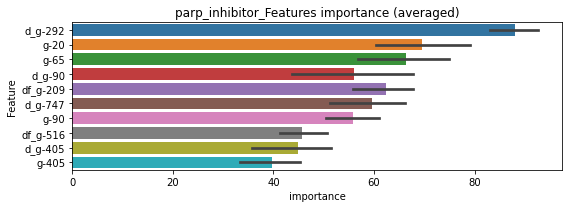

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230211	valid_1's binary_logloss: 0.0566986
[200]	training's binary_logloss: 0.00386668	valid_1's binary_logloss: 0.0303447
[300]	training's binary_logloss: 0.00110027	valid_1's binary_logloss: 0.0243764
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000609709	valid_1's binary_logloss: 0.0232874


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0254646	valid_1's binary_logloss: 0.0509072
[200]	training's binary_logloss: 0.00452078	valid_1's binary_logloss: 0.0244581
[300]	training's binary_logloss: 0.00120499	valid_1's binary_logloss: 0.0184219
[400]	training's binary_logloss: 0.00058658	valid_1's binary_logloss: 0.0163927
[500]	training's binary_logloss: 0.000367634	valid_1's binary_logloss: 0.0152167
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000351401	valid_1's binary_logloss: 0.0151844


parp_inhibitor logloss: 0.019235903569500883


neg labels: 3289 → selected neg labels: 3268


pdgfr_inhibitor, len(trt): 297, len(othr): 3268, target_rate: 0.0124717 → Adj_target_rate: 0.0106179
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045943	valid_1's binary_logloss: 0.10972
[200]	training's binary_logloss: 0.00915494	valid_1's binary_logloss: 0.0790405
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.00348506	valid_1's binary_logloss: 0.0740954
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444654	valid_1's binary_logloss: 0.104813
[200]	training's binary_logloss: 0.0083058	valid_1's binary_logloss: 0.0761363
Early stopping, best iteration is:
[258]	training's binary_logloss: 0.00405888	valid_1's binary_logloss: 0.0737657


1 / 3 AUC score:0.992
y_Threshold: 0.0411605, Threshold: 0.2015558, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 166 → Positive_corect_labels: 636/3755
p_label_rate: 0.0200904 Vs.target_rate: 0.01247
Num_p_label: 80.0, conf_0:0.18140, conf_1:0.22171
threshold: 0.2015558, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 636.0/3755, y_label_rate: 0.1693742
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355747	valid_1's binary_logloss: 0.082246
[200]	training's binary_logloss: 0.00583056	valid_1's binary_logloss: 0.0529017
[300]	training's binary_logloss: 0.00178723	valid_1's binary_logloss: 0.0486141
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.00167453	valid_1's binary_logloss: 0.0482304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374307	valid_1's binary_logloss: 0.0724013
[200]	training's binary_logloss: 0.00623203	valid_1's binary_logloss: 0.0384955
[300]	training's binary_logloss: 0.0019293	valid_1's binary_logloss: 0.0329916
[400]	training's binary_logloss: 0.000927992	valid_1's binary_logloss: 0.0308161
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000908946	valid_1's binary_logloss: 0.0306354


2 / 3 AUC score:0.997
y_Threshold: 0.1122051, Threshold: 0.2015558, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 616.0/3715
p_label_rate: 0.0381718 Vs.target_rate: 0.01247
Num_p_label: 152.0, conf_0:0.18140, conf_1:0.22171
Num_p_label: 152.0, Expected: 49.7, Adj_threshold_1: 0.2015558
Num_p_label: 146.0, Expected: 49.7, Adj_threshold_2: 0.2115558
Num_p_label: 143.0, Expected: 49.7, Adj_threshold_3: 0.2215558
Num_p_label: 142.0, Expected: 49.7, Adj_threshold_4: 0.2315558
Num_p_label: 141.0, Expected: 49.7, Adj_threshold_5: 0.2415558
Num_p_label: 138.0, Expected: 49.7, Adj_threshold_6: 0.2515558
Num_p_label: 133.0, Expected: 49.7, Adj_threshold_7: 0.2615558
Num_p_label: 130.0, Expected: 49.7, Adj_threshold_8: 0.2715558
Num_p_label: 127.0, Expected: 49.7, Adj_threshold_9: 0.2815558
Num_p_label: 123.0, Expected: 49.7, Adj_threshold_10: 0.2915558
threshold: 0.3015558, positive_p_label: 122.0/3982, p_label_rate: 0.0306379
positive_y_label: 616.0/3715, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0331106	valid_1's binary_logloss: 0.0711535
[200]	training's binary_logloss: 0.00522523	valid_1's binary_logloss: 0.0416562
[300]	training's binary_logloss: 0.00158464	valid_1's binary_logloss: 0.0373714
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00126795	valid_1's binary_logloss: 0.0367708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034138	valid_1's binary_logloss: 0.0698044
[200]	training's binary_logloss: 0.00573382	valid_1's binary_logloss: 0.0432393
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00313912	valid_1's binary_logloss: 0.0415728


3 / 3 AUC score:0.996
y_Threshold: 0.0950986, Threshold: 0.3015558, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 597.0/3677
p_label_rate: 0.0306379 Vs.target_rate: 0.01247
Num_p_label: 122.0, conf_0:0.27140, conf_1:0.33171
threshold: 0.3015558, positive_p_label: 122.0/3982, p_label_rate: 0.0306379
positive_y_label: 719.0/7659, y_label_rate: 0.0938765


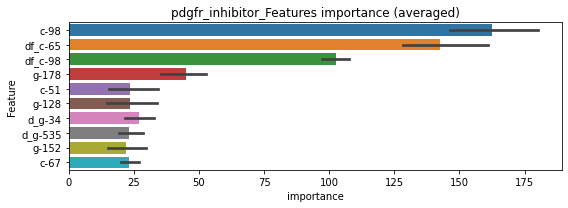

len(train_index) : 3829
len(valid_index) : 3830
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0185661	valid_1's binary_logloss: 0.0498551
[200]	training's binary_logloss: 0.00300516	valid_1's binary_logloss: 0.0337256
[300]	training's binary_logloss: 0.000875333	valid_1's binary_logloss: 0.0299731
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.000858609	valid_1's binary_logloss: 0.0299147


len(train_index) : 3830
len(valid_index) : 3829
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020508	valid_1's binary_logloss: 0.0405139
[200]	training's binary_logloss: 0.00354723	valid_1's binary_logloss: 0.022737
[300]	training's binary_logloss: 0.00103916	valid_1's binary_logloss: 0.0188374
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000758769	valid_1's binary_logloss: 0.0182967


pdgfr_inhibitor logloss: 0.024106427697736688


neg labels: 3289 → selected neg labels: 3286


pdk_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221976	valid_1's binary_logloss: 0.0296921
[200]	training's binary_logloss: 0.00254084	valid_1's binary_logloss: 0.00602434
[300]	training's binary_logloss: 0.00071777	valid_1's binary_logloss: 0.00268963
[400]	training's binary_logloss: 0.000386791	valid_1's binary_logloss: 0.00184648
[500]	training's binary_logloss: 0.00032185	valid_1's binary_logloss: 0.00168291
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000319539	valid_1's binary_logloss: 0.00167782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223166	valid_1's binary_logloss: 0.0294081
[200]	training's binary_logloss: 0.00252234	valid_1's binary_logloss: 0.0043494
[300]	training's binary_logloss: 0.000712076	valid_1's binary_logloss: 0.00142305
[400]	training's binary_logloss: 0.000388389	valid_1's binary_logloss: 0.000862517
[500]	training's binary_logloss: 

1 / 3 AUC score:1.000
y_Threshold: 0.0014750, Threshold: 0.0023808, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00214, conf_1:0.00262
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0023808
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_2: 0.0123808
threshold: 0.0123808, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220937	valid_1's binary_logloss: 0.0290763
[200]	training's binary_logloss: 0.00247386	valid_1's binary_logloss: 0.00539579
[300]	training's binary_logloss: 0.000706501	valid_1's binary_logloss: 0.00238733
[400]	training's binary_logloss: 0.000381708	valid_1's binary_logloss: 0.00165616
[500]	training's binary_logloss: 0.000318879	valid_1's binary_logloss: 0.00154782
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000317382	valid_1's binary_logloss: 0.00154582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220499	valid_1's binary_logloss: 0.0292941
[200]	training's binary_logloss: 0.00242972	valid_1's binary_logloss: 0.00405079
[300]	training's binary_logloss: 0.000702267	valid_1's binary_logloss: 0.00130548
[400]	training's binary_logloss: 0.000393017	valid_1's binary_logloss: 0.000787206
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.0614980, Threshold: 0.0123808, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01114, conf_1:0.01362
threshold: 0.0123808, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220937	valid_1's binary_logloss: 0.0290763
[200]	training's binary_logloss: 0.00247386	valid_1's binary_logloss: 0.00539579
[300]	training's binary_logloss: 0.000706501	valid_1's binary_logloss: 0.00238733
[400]	training's binary_logloss: 0.000381708	valid_1's binary_logloss: 0.00165616
[500]	training's binary_logloss: 0.000318879	valid_1's binary_logloss: 0.00154782
Early stopping, best iteration is:
[518]	training's binary_logloss: 0.000317382	valid_1's binary_logloss: 0.00154582
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220499	valid_1's binary_logloss: 0.0292941
[200]	training's binary_logloss: 0.00242972	valid_1's binary_logloss: 0.00405079
[300]	training's binary_logloss: 0.000702267	valid_1's binary_logloss: 0.00130548
[400]	training's binary_logloss: 0.000393017	valid_1's binary_logloss: 0.000787206
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.0614980, Threshold: 0.0123808, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01114, conf_1:0.01362
threshold: 0.0123808, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


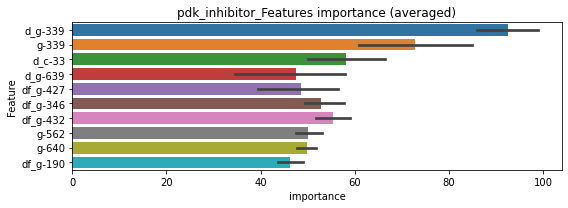

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0127333	valid_1's binary_logloss: 0.021267
[200]	training's binary_logloss: 0.00143267	valid_1's binary_logloss: 0.00880369
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.000709095	valid_1's binary_logloss: 0.00842515


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0132157	valid_1's binary_logloss: 0.0197721
[200]	training's binary_logloss: 0.00154412	valid_1's binary_logloss: 0.00584962
[300]	training's binary_logloss: 0.000435171	valid_1's binary_logloss: 0.00387377
[400]	training's binary_logloss: 0.000217899	valid_1's binary_logloss: 0.00340666
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00020261	valid_1's binary_logloss: 0.00336245


pdk_inhibitor logloss: 0.005894124125438281


neg labels: 3289 → selected neg labels: 3243


phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3243, target_rate: 0.0110859 → Adj_target_rate: 0.0096064
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101997	valid_1's binary_logloss: 0.297999
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.0403502	valid_1's binary_logloss: 0.277844
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107336	valid_1's binary_logloss: 0.284646
[200]	training's binary_logloss: 0.0384839	valid_1's binary_logloss: 0.251598
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0341337	valid_1's binary_logloss: 0.251048


1 / 3 AUC score:0.886
y_Threshold: 0.0960564, Threshold: 0.1422584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 467 → Positive_corect_labels: 480/3424
p_label_rate: 0.0200904 Vs.target_rate: 0.01109
Num_p_label: 80.0, conf_0:0.12803, conf_1:0.15648
threshold: 0.1422584, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 480.0/3424, y_label_rate: 0.1401869
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0713937	valid_1's binary_logloss: 0.20437
[200]	training's binary_logloss: 0.0194274	valid_1's binary_logloss: 0.170041
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0129438	valid_1's binary_logloss: 0.165404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0665431	valid_1's binary_logloss: 0.210468
[200]	training's binary_logloss: 0.0168674	valid_1's binary_logloss: 0.17871
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.0137746	valid_1's binary_logloss: 0.17795


2 / 3 AUC score:0.945
y_Threshold: 0.0908300, Threshold: 0.1422584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 170 → Positive_corect_labels: 395.0/3254
p_label_rate: 0.0143144 Vs.target_rate: 0.01109
Num_p_label: 57.0, conf_0:0.12803, conf_1:0.15648
threshold: 0.1422584, positive_p_label: 57.0/3982, p_label_rate: 0.0143144
positive_y_label: 395.0/3254, y_label_rate: 0.1213891
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0508831	valid_1's binary_logloss: 0.155427
[200]	training's binary_logloss: 0.0115989	valid_1's binary_logloss: 0.127362
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.008386	valid_1's binary_logloss: 0.125713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0544161	valid_1's binary_logloss: 0.139854
[200]	training's binary_logloss: 0.0130045	valid_1's binary_logloss: 0.09677
[300]	training's binary_logloss: 0.00422311	valid_1's binary_logloss: 0.0832139
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00333682	valid_1's binary_logloss: 0.0813943


3 / 3 AUC score:0.977
y_Threshold: 0.0742473, Threshold: 0.1422584, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 82 → Positive_corect_labels: 354.0/3172
p_label_rate: 0.0138122 Vs.target_rate: 0.01109
Num_p_label: 55.0, conf_0:0.12803, conf_1:0.15648
threshold: 0.1422584, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 409.0/7154, y_label_rate: 0.0571708


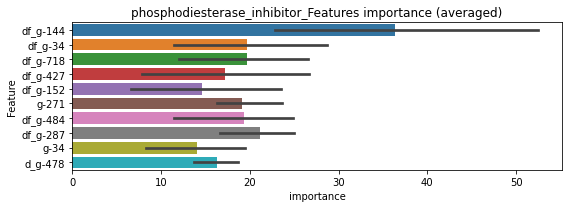

len(train_index) : 3577
len(valid_index) : 3577
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260203	valid_1's binary_logloss: 0.0992259
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.00866824	valid_1's binary_logloss: 0.0910727


len(train_index) : 3577
len(valid_index) : 3577
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256615	valid_1's binary_logloss: 0.0910046
[200]	training's binary_logloss: 0.00606696	valid_1's binary_logloss: 0.0762656
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.00629145	valid_1's binary_logloss: 0.0761032


phosphodiesterase_inhibitor logloss: 0.08358791435518727


neg labels: 3289 → selected neg labels: 3285


phospholipase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303583	valid_1's binary_logloss: 0.0484081
[200]	training's binary_logloss: 0.00401996	valid_1's binary_logloss: 0.0149219
[300]	training's binary_logloss: 0.00111738	valid_1's binary_logloss: 0.00907888
[400]	training's binary_logloss: 0.000547641	valid_1's binary_logloss: 0.0073253
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000421814	valid_1's binary_logloss: 0.00695076
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311461	valid_1's binary_logloss: 0.0470165
[200]	training's binary_logloss: 0.00415415	valid_1's binary_logloss: 0.0107137
[300]	training's binary_logloss: 0.00113058	valid_1's binary_logloss: 0.00455144
[400]	training's binary_logloss: 0.000563284	valid_1's binary_logloss: 0.00307071
[500]	training's binary_logloss: 0.000398648	valid_1's binary_logloss: 0.00261923
Early stopping, best iteration is:
[

1 / 3 AUC score:1.000
y_Threshold: 0.0023016, Threshold: 0.0035675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00321, conf_1:0.00392
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0035675
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_2: 0.0135675
threshold: 0.0135675, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296334	valid_1's binary_logloss: 0.0457701
[200]	training's binary_logloss: 0.00393123	valid_1's binary_logloss: 0.0125561
[300]	training's binary_logloss: 0.00109711	valid_1's binary_logloss: 0.0074807
[400]	training's binary_logloss: 0.000547609	valid_1's binary_logloss: 0.00621876
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000522831	valid_1's binary_logloss: 0.00614443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302498	valid_1's binary_logloss: 0.0448958
[200]	training's binary_logloss: 0.00390504	valid_1's binary_logloss: 0.00975249
[300]	training's binary_logloss: 0.00108903	valid_1's binary_logloss: 0.00421577
[400]	training's binary_logloss: 0.000547411	valid_1's binary_logloss: 0.00272391
[500]	training's binary_logloss: 0.000392662	valid_1's binary_logloss: 0.00228001
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0252075, Threshold: 0.0135675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0065294 Vs.target_rate: 0.00105
Num_p_label: 26.0, conf_0:0.01221, conf_1:0.01492
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_1: 0.0135675
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_2: 0.0235675
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.0335675
threshold: 0.0335675, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296334	valid_1's binary_logloss: 0.0457701
[200]	training's binary_logloss: 0.00393123	valid_1's binary_logloss: 0.0125561
[300]	training's binary_logloss: 0.00109711	valid_1's binary_logloss: 0.0074807
[400]	training's binary_logloss: 0.000547609	valid_1's binary_logloss: 0.00621876
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000522831	valid_1's binary_logloss: 0.00614443
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302498	valid_1's binary_logloss: 0.0448958
[200]	training's binary_logloss: 0.00390504	valid_1's binary_logloss: 0.00975249
[300]	training's binary_logloss: 0.00108903	valid_1's binary_logloss: 0.00421577
[400]	training's binary_logloss: 0.000547411	valid_1's binary_logloss: 0.00272391
[500]	training's binary_logloss: 0.000392662	valid_1's binary_logloss: 0.00228001
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0252075, Threshold: 0.0335675, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0015068 Vs.target_rate: 0.00105
Num_p_label: 6.0, conf_0:0.03021, conf_1:0.03692
threshold: 0.0335675, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7792, y_label_rate: 0.0850873


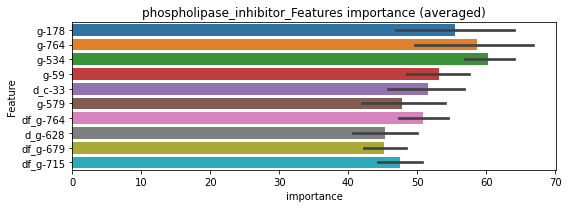

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163042	valid_1's binary_logloss: 0.0293272
[200]	training's binary_logloss: 0.00218453	valid_1's binary_logloss: 0.0109389
[300]	training's binary_logloss: 0.000579124	valid_1's binary_logloss: 0.00858123
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.000467059	valid_1's binary_logloss: 0.00845058


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016824	valid_1's binary_logloss: 0.0247178
[200]	training's binary_logloss: 0.00232251	valid_1's binary_logloss: 0.00590606
[300]	training's binary_logloss: 0.000620125	valid_1's binary_logloss: 0.00298788
[400]	training's binary_logloss: 0.000293526	valid_1's binary_logloss: 0.00230153
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000242398	valid_1's binary_logloss: 0.00219035


phospholipase_inhibitor logloss: 0.005320463945265193


neg labels: 3289 → selected neg labels: 3264


pi3k_inhibitor, len(trt): 151, len(othr): 3264, target_rate: 0.0063408 → Adj_target_rate: 0.0059749
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0519097	valid_1's binary_logloss: 0.142612
[200]	training's binary_logloss: 0.0110719	valid_1's binary_logloss: 0.108175
[300]	training's binary_logloss: 0.00346092	valid_1's binary_logloss: 0.102329
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0033326	valid_1's binary_logloss: 0.102171
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510174	valid_1's binary_logloss: 0.148198
[200]	training's binary_logloss: 0.0106446	valid_1's binary_logloss: 0.109772
[300]	training's binary_logloss: 0.00333905	valid_1's binary_logloss: 0.103092
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00357547	valid_1's binary_logloss: 0.102904


1 / 3 AUC score:0.988
y_Threshold: 0.0246042, Threshold: 0.1383785, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 184 → Positive_corect_labels: 626/3732
p_label_rate: 0.0200904 Vs.target_rate: 0.00634
Num_p_label: 80.0, conf_0:0.12454, conf_1:0.15222
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_1: 0.1383785
Num_p_label: 78.0, Expected: 25.2, Adj_threshold_2: 0.1483785
Num_p_label: 77.0, Expected: 25.2, Adj_threshold_3: 0.1583785
Num_p_label: 77.0, Expected: 25.2, Adj_threshold_4: 0.1683785
Num_p_label: 72.0, Expected: 25.2, Adj_threshold_5: 0.1783785
Num_p_label: 70.0, Expected: 25.2, Adj_threshold_6: 0.1883785
Num_p_label: 69.0, Expected: 25.2, Adj_threshold_7: 0.1983785
Num_p_label: 67.0, Expected: 25.2, Adj_threshold_8: 0.2083785
Num_p_label: 66.0, Expected: 25.2, Adj_threshold_9: 0.2183785
Num_p_label: 63.0, Expected: 25.2, Adj_threshold_10: 0.2283785
threshold: 0.2383785, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 626.0/3732, y_label_rate: 0.1677385

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446891	valid_1's binary_logloss: 0.10343
[200]	training's binary_logloss: 0.00849744	valid_1's binary_logloss: 0.0597144
[300]	training's binary_logloss: 0.00264159	valid_1's binary_logloss: 0.0505212
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00141601	valid_1's binary_logloss: 0.046662
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452485	valid_1's binary_logloss: 0.109468
[200]	training's binary_logloss: 0.00854539	valid_1's binary_logloss: 0.0692022
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0030146	valid_1's binary_logloss: 0.0615533


2 / 3 AUC score:0.997
y_Threshold: 0.0707487, Threshold: 0.2383785, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 42 → Positive_corect_labels: 605.0/3690
p_label_rate: 0.0291311 Vs.target_rate: 0.00634
Num_p_label: 116.0, conf_0:0.21454, conf_1:0.26222
Num_p_label: 116.0, Expected: 25.2, Adj_threshold_1: 0.2383785
Num_p_label: 116.0, Expected: 25.2, Adj_threshold_2: 0.2483785
Num_p_label: 115.0, Expected: 25.2, Adj_threshold_3: 0.2583785
Num_p_label: 112.0, Expected: 25.2, Adj_threshold_4: 0.2683785
Num_p_label: 110.0, Expected: 25.2, Adj_threshold_5: 0.2783785
Num_p_label: 107.0, Expected: 25.2, Adj_threshold_6: 0.2883785
Num_p_label: 104.0, Expected: 25.2, Adj_threshold_7: 0.2983785
Num_p_label: 102.0, Expected: 25.2, Adj_threshold_8: 0.3083785
Num_p_label: 98.0, Expected: 25.2, Adj_threshold_9: 0.3183785
Num_p_label: 94.0, Expected: 25.2, Adj_threshold_10: 0.3283785
threshold: 0.3383785, positive_p_label: 93.0/3982, p_label_rate: 0.0233551
positive_y_label: 605.0/3690, y_label_rate:

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403163	valid_1's binary_logloss: 0.112429
[200]	training's binary_logloss: 0.00725615	valid_1's binary_logloss: 0.0793369
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00298568	valid_1's binary_logloss: 0.0752151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412024	valid_1's binary_logloss: 0.110129
[200]	training's binary_logloss: 0.00756821	valid_1's binary_logloss: 0.0703323
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00322504	valid_1's binary_logloss: 0.0632953


3 / 3 AUC score:0.996
y_Threshold: 0.0520108, Threshold: 0.3383785, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 62 → Positive_corect_labels: 574.0/3628
p_label_rate: 0.0401808 Vs.target_rate: 0.00634
Num_p_label: 160.0, conf_0:0.30454, conf_1:0.37222
Num_p_label: 160.0, Expected: 25.2, Adj_threshold_1: 0.3383785
Num_p_label: 157.0, Expected: 25.2, Adj_threshold_2: 0.3483785
Num_p_label: 154.0, Expected: 25.2, Adj_threshold_3: 0.3583785
Num_p_label: 151.0, Expected: 25.2, Adj_threshold_4: 0.3683785
Num_p_label: 148.0, Expected: 25.2, Adj_threshold_5: 0.3783785
Num_p_label: 147.0, Expected: 25.2, Adj_threshold_6: 0.3883785
Num_p_label: 144.0, Expected: 25.2, Adj_threshold_7: 0.3983785
Num_p_label: 143.0, Expected: 25.2, Adj_threshold_8: 0.4083785
Num_p_label: 140.0, Expected: 25.2, Adj_threshold_9: 0.4183785
Num_p_label: 136.0, Expected: 25.2, Adj_threshold_10: 0.4283785
threshold: 0.4383785, positive_p_label: 134.0/3982, p_label_rate: 0.0336514
positive_y_label: 708.0/7610, y_label_ra

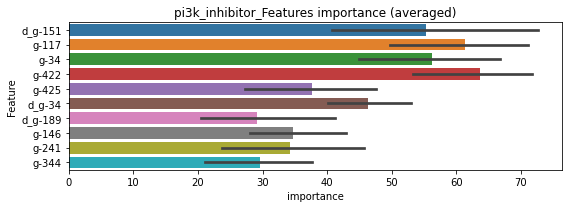

len(train_index) : 3805
len(valid_index) : 3805
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258801	valid_1's binary_logloss: 0.0619984
[200]	training's binary_logloss: 0.00471935	valid_1's binary_logloss: 0.0405959
[300]	training's binary_logloss: 0.00139415	valid_1's binary_logloss: 0.0368088
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00120047	valid_1's binary_logloss: 0.0366201


len(train_index) : 3805
len(valid_index) : 3805
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023844	valid_1's binary_logloss: 0.0794634
[200]	training's binary_logloss: 0.0041428	valid_1's binary_logloss: 0.0599411
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00176757	valid_1's binary_logloss: 0.0563914


pi3k_inhibitor logloss: 0.04650574608994249


neg labels: 3289 → selected neg labels: 3284


pkc_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328102	valid_1's binary_logloss: 0.060532
[200]	training's binary_logloss: 0.00466209	valid_1's binary_logloss: 0.0244341
[300]	training's binary_logloss: 0.00128524	valid_1's binary_logloss: 0.0166743
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.000727997	valid_1's binary_logloss: 0.0149031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316209	valid_1's binary_logloss: 0.0513414
[200]	training's binary_logloss: 0.00444875	valid_1's binary_logloss: 0.0133235
[300]	training's binary_logloss: 0.00123839	valid_1's binary_logloss: 0.00650568
[400]	training's binary_logloss: 0.00061484	valid_1's binary_logloss: 0.00459415
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.0005118	valid_1's binary_logloss: 0.00434383


1 / 3 AUC score:1.000
y_Threshold: 0.0035323, Threshold: 0.0056814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00130
Num_p_label: 80.0, conf_0:0.00511, conf_1:0.00625
Num_p_label: 80.0, Expected: 5.2, Adj_threshold_1: 0.0056814
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_2: 0.0156814
Num_p_label: 3.0, Expected: 5.2, Adj_threshold_3: 0.0256814
threshold: 0.0256814, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031362	valid_1's binary_logloss: 0.0590797
[200]	training's binary_logloss: 0.00440986	valid_1's binary_logloss: 0.0246011
[300]	training's binary_logloss: 0.00122575	valid_1's binary_logloss: 0.0177882
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00067107	valid_1's binary_logloss: 0.0160691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326626	valid_1's binary_logloss: 0.0506187
[200]	training's binary_logloss: 0.0044988	valid_1's binary_logloss: 0.0123816
[300]	training's binary_logloss: 0.00124761	valid_1's binary_logloss: 0.00617398
[400]	training's binary_logloss: 0.000617795	valid_1's binary_logloss: 0.0044044
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000617795	valid_1's binary_logloss: 0.0044044


2 / 3 AUC score:1.000
y_Threshold: 0.0194979, Threshold: 0.0256814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0045203 Vs.target_rate: 0.00130
Num_p_label: 18.0, conf_0:0.02311, conf_1:0.02825
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_1: 0.0256814
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_2: 0.0356814
threshold: 0.0356814, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318432	valid_1's binary_logloss: 0.0525227
[200]	training's binary_logloss: 0.00435735	valid_1's binary_logloss: 0.0150186
[300]	training's binary_logloss: 0.00122461	valid_1's binary_logloss: 0.00790564
[400]	training's binary_logloss: 0.000608942	valid_1's binary_logloss: 0.00567296
[500]	training's binary_logloss: 0.000430604	valid_1's binary_logloss: 0.00498326
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000434241	valid_1's binary_logloss: 0.00495514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0324575	valid_1's binary_logloss: 0.0485493
[200]	training's binary_logloss: 0.0045338	valid_1's binary_logloss: 0.0111495
[300]	training's binary_logloss: 0.00126124	valid_1's binary_logloss: 0.00505002
[400]	training's binary_logloss: 0.000620039	valid_1's binary_logloss: 0.00343772
Early stopping, best iteration is:
[

3 / 3 AUC score:1.000
y_Threshold: 0.0374973, Threshold: 0.0356814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0012557 Vs.target_rate: 0.00130
Num_p_label: 5.0, conf_0:0.03211, conf_1:0.03925
threshold: 0.0356814, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 660.0/7788, y_label_rate: 0.0847458


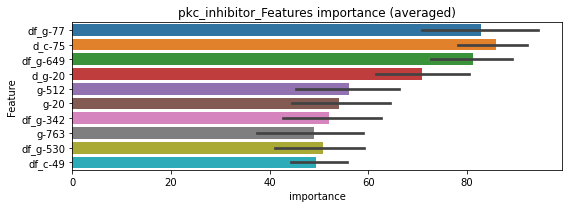

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182164	valid_1's binary_logloss: 0.0293437
[200]	training's binary_logloss: 0.00248219	valid_1's binary_logloss: 0.0103438
[300]	training's binary_logloss: 0.000661251	valid_1's binary_logloss: 0.00724587
[400]	training's binary_logloss: 0.000320018	valid_1's binary_logloss: 0.00685039
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000336948	valid_1's binary_logloss: 0.00683383


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180193	valid_1's binary_logloss: 0.0322282
[200]	training's binary_logloss: 0.00247033	valid_1's binary_logloss: 0.0108351
[300]	training's binary_logloss: 0.000655119	valid_1's binary_logloss: 0.00630373
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.0003907	valid_1's binary_logloss: 0.00550541


pkc_inhibitor logloss: 0.006169621878045077


neg labels: 3289 → selected neg labels: 3279


potassium_channel_activator, len(trt): 55, len(othr): 3279, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476212	valid_1's binary_logloss: 0.0897664
[200]	training's binary_logloss: 0.0085881	valid_1's binary_logloss: 0.0322106
[300]	training's binary_logloss: 0.0024721	valid_1's binary_logloss: 0.0172699
[400]	training's binary_logloss: 0.0011361	valid_1's binary_logloss: 0.0124184
[500]	training's binary_logloss: 0.000719997	valid_1's binary_logloss: 0.0106225
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000584915	valid_1's binary_logloss: 0.00992531
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0493751	valid_1's binary_logloss: 0.0997985
[200]	training's binary_logloss: 0.00918062	valid_1's binary_logloss: 0.0573724
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00283738	valid_1's binary_logloss: 0.0496165


1 / 3 AUC score:0.999
y_Threshold: 0.0138349, Threshold: 0.0224478, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 652/3796
p_label_rate: 0.0200904 Vs.target_rate: 0.00231
Num_p_label: 80.0, conf_0:0.02020, conf_1:0.02469
Num_p_label: 80.0, Expected: 9.2, Adj_threshold_1: 0.0224478
Num_p_label: 36.0, Expected: 9.2, Adj_threshold_2: 0.0324478
Num_p_label: 18.0, Expected: 9.2, Adj_threshold_3: 0.0424478
threshold: 0.0424478, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0483361	valid_1's binary_logloss: 0.0786853
[200]	training's binary_logloss: 0.0089614	valid_1's binary_logloss: 0.0278098
[300]	training's binary_logloss: 0.0024834	valid_1's binary_logloss: 0.0157054
[400]	training's binary_logloss: 0.00113835	valid_1's binary_logloss: 0.0124668
[500]	training's binary_logloss: 0.000716648	valid_1's binary_logloss: 0.0112281
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000679162	valid_1's binary_logloss: 0.0110905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451671	valid_1's binary_logloss: 0.080929
[200]	training's binary_logloss: 0.00825399	valid_1's binary_logloss: 0.0322352
[300]	training's binary_logloss: 0.00234164	valid_1's binary_logloss: 0.0209093
[400]	training's binary_logloss: 0.0010982	valid_1's binary_logloss: 0.0176832
[500]	training's binary_logloss: 0.000685244	va

2 / 3 AUC score:1.000
y_Threshold: 0.0428368, Threshold: 0.0424478, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0075339 Vs.target_rate: 0.00231
Num_p_label: 30.0, conf_0:0.03820, conf_1:0.04669
Num_p_label: 30.0, Expected: 9.2, Adj_threshold_1: 0.0424478
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_2: 0.0524478
Num_p_label: 15.0, Expected: 9.2, Adj_threshold_3: 0.0624478
threshold: 0.0624478, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464791	valid_1's binary_logloss: 0.0793783
[200]	training's binary_logloss: 0.00828987	valid_1's binary_logloss: 0.0285382
[300]	training's binary_logloss: 0.00236559	valid_1's binary_logloss: 0.016037
[400]	training's binary_logloss: 0.00108006	valid_1's binary_logloss: 0.0124157
[500]	training's binary_logloss: 0.000682476	valid_1's binary_logloss: 0.0111379
[600]	training's binary_logloss: 0.000538859	valid_1's binary_logloss: 0.010702
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000544474	valid_1's binary_logloss: 0.0106973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456986	valid_1's binary_logloss: 0.0822473
[200]	training's binary_logloss: 0.00812042	valid_1's binary_logloss: 0.0295547
[300]	training's binary_logloss: 0.00233027	valid_1's binary_logloss: 0.0163193
[400]	training's binary_logloss: 0.00107841	

3 / 3 AUC score:1.000
y_Threshold: 0.0425163, Threshold: 0.0624478, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0040181 Vs.target_rate: 0.00231
Num_p_label: 16.0, conf_0:0.05620, conf_1:0.06869
threshold: 0.0624478, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 661.0/7764, y_label_rate: 0.0851365


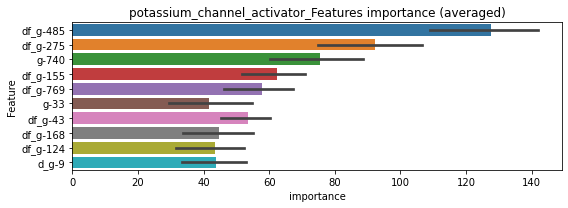

len(train_index) : 3882
len(valid_index) : 3882
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270421	valid_1's binary_logloss: 0.0528559
[200]	training's binary_logloss: 0.00486118	valid_1's binary_logloss: 0.0243078
[300]	training's binary_logloss: 0.0013695	valid_1's binary_logloss: 0.0188523
[400]	training's binary_logloss: 0.000602332	valid_1's binary_logloss: 0.0175132
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.000610211	valid_1's binary_logloss: 0.0174873


len(train_index) : 3882
len(valid_index) : 3882
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282339	valid_1's binary_logloss: 0.0514561
[200]	training's binary_logloss: 0.00519677	valid_1's binary_logloss: 0.0256078
[300]	training's binary_logloss: 0.00145369	valid_1's binary_logloss: 0.020387
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00103898	valid_1's binary_logloss: 0.0196878


potassium_channel_activator logloss: 0.018587548275607924


neg labels: 3289 → selected neg labels: 3272


potassium_channel_antagonist, len(trt): 98, len(othr): 3272, target_rate: 0.0041152 → Adj_target_rate: 0.0041375
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0633498	valid_1's binary_logloss: 0.146642
[200]	training's binary_logloss: 0.01686	valid_1's binary_logloss: 0.0947308
[300]	training's binary_logloss: 0.00505461	valid_1's binary_logloss: 0.0746496
[400]	training's binary_logloss: 0.00211033	valid_1's binary_logloss: 0.0679516
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.002096	valid_1's binary_logloss: 0.0679384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067549	valid_1's binary_logloss: 0.138809
[200]	training's binary_logloss: 0.0166457	valid_1's binary_logloss: 0.0864541
[300]	training's binary_logloss: 0.00503781	valid_1's binary_logloss: 0.0728695
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00240856	valid_1's binary_logloss: 0.0685947


1 / 3 AUC score:0.992
y_Threshold: 0.0183388, Threshold: 0.0236442, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 168 → Positive_corect_labels: 636/3758
p_label_rate: 0.0200904 Vs.target_rate: 0.00412
Num_p_label: 80.0, conf_0:0.02128, conf_1:0.02601
Num_p_label: 80.0, Expected: 16.4, Adj_threshold_1: 0.0236442
Num_p_label: 38.0, Expected: 16.4, Adj_threshold_2: 0.0336442
Num_p_label: 24.0, Expected: 16.4, Adj_threshold_3: 0.0436442
threshold: 0.0436442, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 636.0/3758, y_label_rate: 0.1692390
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0650807	valid_1's binary_logloss: 0.133538
[200]	training's binary_logloss: 0.0151132	valid_1's binary_logloss: 0.0723151
[300]	training's binary_logloss: 0.0045522	valid_1's binary_logloss: 0.0552614
[400]	training's binary_logloss: 0.00203281	valid_1's binary_logloss: 0.0516415
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00146259	valid_1's binary_logloss: 0.0505192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585841	valid_1's binary_logloss: 0.136819
[200]	training's binary_logloss: 0.0134745	valid_1's binary_logloss: 0.0897115
[300]	training's binary_logloss: 0.00412431	valid_1's binary_logloss: 0.0781974
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00319032	valid_1's binary_logloss: 0.0763784


2 / 3 AUC score:0.993
y_Threshold: 0.0431540, Threshold: 0.0436442, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 48 → Positive_corect_labels: 612.0/3710
p_label_rate: 0.0105475 Vs.target_rate: 0.00412
Num_p_label: 42.0, conf_0:0.03928, conf_1:0.04801
threshold: 0.0436442, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 612.0/3710, y_label_rate: 0.1649596
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574034	valid_1's binary_logloss: 0.126851
[200]	training's binary_logloss: 0.0131862	valid_1's binary_logloss: 0.0727957
[300]	training's binary_logloss: 0.00405258	valid_1's binary_logloss: 0.0569247
[400]	training's binary_logloss: 0.0018313	valid_1's binary_logloss: 0.0516451
[500]	training's binary_logloss: 0.0010882	valid_1's binary_logloss: 0.0492983
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00110995	valid_1's binary_logloss: 0.049203
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0569512	valid_1's binary_logloss: 0.120549
[200]	training's binary_logloss: 0.0126512	valid_1's binary_logloss: 0.0707341
[300]	training's binary_logloss: 0.00387625	valid_1's binary_logloss: 0.0585419
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00387625	valid_1's binary_logloss: 0.0585419


3 / 3 AUC score:0.997
y_Threshold: 0.0474664, Threshold: 0.0436442, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 599.0/3684
p_label_rate: 0.0120542 Vs.target_rate: 0.00412
Num_p_label: 48.0, conf_0:0.03928, conf_1:0.04801
threshold: 0.0436442, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 647.0/7666, y_label_rate: 0.0843986


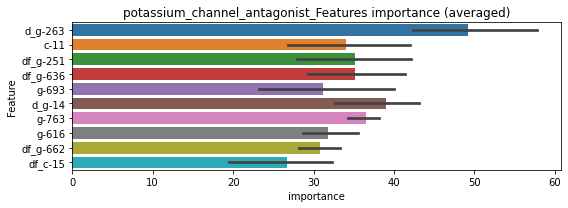

len(train_index) : 3833
len(valid_index) : 3833
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333699	valid_1's binary_logloss: 0.0889387
[200]	training's binary_logloss: 0.00756729	valid_1's binary_logloss: 0.0674132
[300]	training's binary_logloss: 0.00222657	valid_1's binary_logloss: 0.0633745
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00222657	valid_1's binary_logloss: 0.0633745


len(train_index) : 3833
len(valid_index) : 3833
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329798	valid_1's binary_logloss: 0.0798149
[200]	training's binary_logloss: 0.00755365	valid_1's binary_logloss: 0.055759
Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00308464	valid_1's binary_logloss: 0.0525129


potassium_channel_antagonist logloss: 0.05794369466715753


neg labels: 3289 → selected neg labels: 3269


ppar_receptor_agonist, len(trt): 115, len(othr): 3269, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0591576	valid_1's binary_logloss: 0.157302
[200]	training's binary_logloss: 0.0125467	valid_1's binary_logloss: 0.112936
[300]	training's binary_logloss: 0.00385774	valid_1's binary_logloss: 0.104752
Early stopping, best iteration is:
[339]	training's binary_logloss: 0.0027337	valid_1's binary_logloss: 0.103207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586245	valid_1's binary_logloss: 0.151382
[200]	training's binary_logloss: 0.0134427	valid_1's binary_logloss: 0.105472
[300]	training's binary_logloss: 0.00413337	valid_1's binary_logloss: 0.095322
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00434281	valid_1's binary_logloss: 0.0949787


1 / 3 AUC score:0.983
y_Threshold: 0.0236782, Threshold: 0.0611052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 196 → Positive_corect_labels: 621/3726
p_label_rate: 0.0200904 Vs.target_rate: 0.00483
Num_p_label: 80.0, conf_0:0.05499, conf_1:0.06722
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.0611052
Num_p_label: 73.0, Expected: 19.2, Adj_threshold_2: 0.0711052
Num_p_label: 62.0, Expected: 19.2, Adj_threshold_3: 0.0811052
Num_p_label: 52.0, Expected: 19.2, Adj_threshold_4: 0.0911052
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_5: 0.1011052
Num_p_label: 43.0, Expected: 19.2, Adj_threshold_6: 0.1111052
Num_p_label: 37.0, Expected: 19.2, Adj_threshold_7: 0.1211052
threshold: 0.1211052, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 621.0/3726, y_label_rate: 0.1666667
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0549422	valid_1's binary_logloss: 0.132038
[200]	training's binary_logloss: 0.0110746	valid_1's binary_logloss: 0.0828555
[300]	training's binary_logloss: 0.00338515	valid_1's binary_logloss: 0.0716651
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.00296659	valid_1's binary_logloss: 0.070891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532148	valid_1's binary_logloss: 0.127409
[200]	training's binary_logloss: 0.0111226	valid_1's binary_logloss: 0.0720249
[300]	training's binary_logloss: 0.00345531	valid_1's binary_logloss: 0.0549778
[400]	training's binary_logloss: 0.00162817	valid_1's binary_logloss: 0.0499916
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00105533	valid_1's binary_logloss: 0.0475601


2 / 3 AUC score:0.998
y_Threshold: 0.0537356, Threshold: 0.1211052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 604.0/3692
p_label_rate: 0.0178302 Vs.target_rate: 0.00483
Num_p_label: 71.0, conf_0:0.10899, conf_1:0.13322
Num_p_label: 71.0, Expected: 19.2, Adj_threshold_1: 0.1211052
Num_p_label: 68.0, Expected: 19.2, Adj_threshold_2: 0.1311052
Num_p_label: 60.0, Expected: 19.2, Adj_threshold_3: 0.1411052
Num_p_label: 56.0, Expected: 19.2, Adj_threshold_4: 0.1511052
Num_p_label: 50.0, Expected: 19.2, Adj_threshold_5: 0.1611052
Num_p_label: 47.0, Expected: 19.2, Adj_threshold_6: 0.1711052
Num_p_label: 46.0, Expected: 19.2, Adj_threshold_7: 0.1811052
Num_p_label: 41.0, Expected: 19.2, Adj_threshold_8: 0.1911052
Num_p_label: 40.0, Expected: 19.2, Adj_threshold_9: 0.2011052
Num_p_label: 36.0, Expected: 19.2, Adj_threshold_10: 0.2111052
threshold: 0.2111052, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 604.0/3692, y_label_rate: 0.163597

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510118	valid_1's binary_logloss: 0.122391
[200]	training's binary_logloss: 0.0103114	valid_1's binary_logloss: 0.0720589
[300]	training's binary_logloss: 0.00313847	valid_1's binary_logloss: 0.0588
[400]	training's binary_logloss: 0.00147692	valid_1's binary_logloss: 0.0537885
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00143462	valid_1's binary_logloss: 0.0535651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516641	valid_1's binary_logloss: 0.125762
[200]	training's binary_logloss: 0.0104572	valid_1's binary_logloss: 0.0721524
[300]	training's binary_logloss: 0.00315918	valid_1's binary_logloss: 0.0582387
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0015993	valid_1's binary_logloss: 0.0541165


3 / 3 AUC score:0.996
y_Threshold: 0.0527227, Threshold: 0.2111052, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 587.0/3658
p_label_rate: 0.0100452 Vs.target_rate: 0.00483
Num_p_label: 40.0, conf_0:0.18999, conf_1:0.23222
threshold: 0.2111052, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 627.0/7640, y_label_rate: 0.0820681


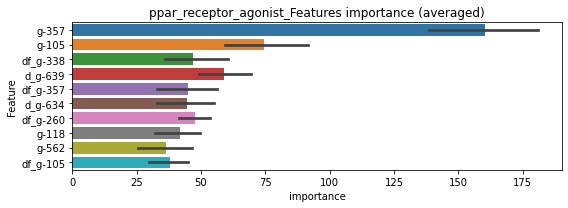

len(train_index) : 3820
len(valid_index) : 3820
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280743	valid_1's binary_logloss: 0.0935926
[200]	training's binary_logloss: 0.0053803	valid_1's binary_logloss: 0.0730934
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.00295669	valid_1's binary_logloss: 0.0699339


len(train_index) : 3820
len(valid_index) : 3820
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295892	valid_1's binary_logloss: 0.0704626
[200]	training's binary_logloss: 0.00600522	valid_1's binary_logloss: 0.0439755
[300]	training's binary_logloss: 0.00179055	valid_1's binary_logloss: 0.036336
[400]	training's binary_logloss: 0.000833621	valid_1's binary_logloss: 0.0334483
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000575627	valid_1's binary_logloss: 0.0324447


ppar_receptor_agonist logloss: 0.05118933200398954


neg labels: 3289 → selected neg labels: 3284


ppar_receptor_antagonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317765	valid_1's binary_logloss: 0.0491678
[200]	training's binary_logloss: 0.00445101	valid_1's binary_logloss: 0.0122
[300]	training's binary_logloss: 0.00123401	valid_1's binary_logloss: 0.00562182
[400]	training's binary_logloss: 0.000615127	valid_1's binary_logloss: 0.00396582
[500]	training's binary_logloss: 0.000427014	valid_1's binary_logloss: 0.00339645
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000408983	valid_1's binary_logloss: 0.00332367
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319849	valid_1's binary_logloss: 0.0524669
[200]	training's binary_logloss: 0.00451567	valid_1's binary_logloss: 0.0137878
[300]	training's binary_logloss: 0.00126146	valid_1's binary_logloss: 0.0064945
[400]	training's binary_logloss: 0.000625466	valid_1's binary_logloss: 0.00480495
[500]	training's binary_logloss: 0.0004

1 / 3 AUC score:1.000
y_Threshold: 0.0030271, Threshold: 0.0053611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00482, conf_1:0.00590
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0053611
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_2: 0.0153611
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_3: 0.0253611
threshold: 0.0253611, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312247	valid_1's binary_logloss: 0.0474264
[200]	training's binary_logloss: 0.00424899	valid_1's binary_logloss: 0.0116249
[300]	training's binary_logloss: 0.00119539	valid_1's binary_logloss: 0.00516883
[400]	training's binary_logloss: 0.000597924	valid_1's binary_logloss: 0.00347019
[500]	training's binary_logloss: 0.000422825	valid_1's binary_logloss: 0.00297951
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000397623	valid_1's binary_logloss: 0.00291458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315259	valid_1's binary_logloss: 0.0509158
[200]	training's binary_logloss: 0.00434104	valid_1's binary_logloss: 0.0125994
[300]	training's binary_logloss: 0.00123664	valid_1's binary_logloss: 0.00614902
[400]	training's binary_logloss: 0.000612746	valid_1's binary_logloss: 0.0046861
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0659278, Threshold: 0.0253611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0057760 Vs.target_rate: 0.00126
Num_p_label: 23.0, conf_0:0.02282, conf_1:0.02790
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_1: 0.0253611
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_2: 0.0353611
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_3: 0.0453611
threshold: 0.0453611, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0312247	valid_1's binary_logloss: 0.0474264
[200]	training's binary_logloss: 0.00424899	valid_1's binary_logloss: 0.0116249
[300]	training's binary_logloss: 0.00119539	valid_1's binary_logloss: 0.00516883
[400]	training's binary_logloss: 0.000597924	valid_1's binary_logloss: 0.00347019
[500]	training's binary_logloss: 0.000422825	valid_1's binary_logloss: 0.00297951
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000397623	valid_1's binary_logloss: 0.00291458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315259	valid_1's binary_logloss: 0.0509158
[200]	training's binary_logloss: 0.00434104	valid_1's binary_logloss: 0.0125994
[300]	training's binary_logloss: 0.00123664	valid_1's binary_logloss: 0.00614902
[400]	training's binary_logloss: 0.000612746	valid_1's binary_logloss: 0.0046861
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0659278, Threshold: 0.0453611, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00126
Num_p_label: 9.0, conf_0:0.04082, conf_1:0.04990
threshold: 0.0453611, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


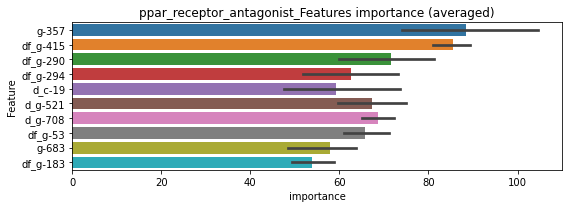

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179899	valid_1's binary_logloss: 0.0334017
[200]	training's binary_logloss: 0.00252004	valid_1's binary_logloss: 0.0134269
[300]	training's binary_logloss: 0.00068161	valid_1's binary_logloss: 0.0103596
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000521884	valid_1's binary_logloss: 0.0101042


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0182641	valid_1's binary_logloss: 0.0299491
[200]	training's binary_logloss: 0.00260926	valid_1's binary_logloss: 0.00989711
[300]	training's binary_logloss: 0.000726092	valid_1's binary_logloss: 0.00689096
[400]	training's binary_logloss: 0.000348163	valid_1's binary_logloss: 0.00635359
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.000348163	valid_1's binary_logloss: 0.00635359


ppar_receptor_antagonist logloss: 0.008228883971452359


neg labels: 3289 → selected neg labels: 3271


progesterone_receptor_agonist, len(trt): 119, len(othr): 3271, target_rate: 0.0049971 → Adj_target_rate: 0.0048799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621963	valid_1's binary_logloss: 0.159061
[200]	training's binary_logloss: 0.0150668	valid_1's binary_logloss: 0.119561
[300]	training's binary_logloss: 0.00463556	valid_1's binary_logloss: 0.112328
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00449423	valid_1's binary_logloss: 0.112154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.061648	valid_1's binary_logloss: 0.155328
[200]	training's binary_logloss: 0.0150025	valid_1's binary_logloss: 0.116242
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.00702042	valid_1's binary_logloss: 0.109735


1 / 3 AUC score:0.975
y_Threshold: 0.0318932, Threshold: 0.0472208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 221 → Positive_corect_labels: 609/3704
p_label_rate: 0.0200904 Vs.target_rate: 0.00500
Num_p_label: 80.0, conf_0:0.04250, conf_1:0.05194
Num_p_label: 80.0, Expected: 19.9, Adj_threshold_1: 0.0472208
Num_p_label: 60.0, Expected: 19.9, Adj_threshold_2: 0.0572208
Num_p_label: 43.0, Expected: 19.9, Adj_threshold_3: 0.0672208
Num_p_label: 29.0, Expected: 19.9, Adj_threshold_4: 0.0772208
threshold: 0.0772208, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 609.0/3704, y_label_rate: 0.1644168
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0514883	valid_1's binary_logloss: 0.127536
[200]	training's binary_logloss: 0.0106679	valid_1's binary_logloss: 0.0821551
[300]	training's binary_logloss: 0.00329046	valid_1's binary_logloss: 0.0723362
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00262327	valid_1's binary_logloss: 0.0709304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0536004	valid_1's binary_logloss: 0.127361
[200]	training's binary_logloss: 0.0114049	valid_1's binary_logloss: 0.0834216
[300]	training's binary_logloss: 0.0035193	valid_1's binary_logloss: 0.0751011
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00293165	valid_1's binary_logloss: 0.0742943


2 / 3 AUC score:0.993
y_Threshold: 0.0452188, Threshold: 0.0772208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 583.0/3652
p_label_rate: 0.0125565 Vs.target_rate: 0.00500
Num_p_label: 50.0, conf_0:0.06950, conf_1:0.08494
threshold: 0.0772208, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 583.0/3652, y_label_rate: 0.1596386
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0467437	valid_1's binary_logloss: 0.117002
[200]	training's binary_logloss: 0.00976435	valid_1's binary_logloss: 0.0725027
[300]	training's binary_logloss: 0.00299645	valid_1's binary_logloss: 0.06104
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00209756	valid_1's binary_logloss: 0.0594509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498664	valid_1's binary_logloss: 0.115419
[200]	training's binary_logloss: 0.0106456	valid_1's binary_logloss: 0.0681619
[300]	training's binary_logloss: 0.00328429	valid_1's binary_logloss: 0.056677
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00233931	valid_1's binary_logloss: 0.054453


3 / 3 AUC score:0.995
y_Threshold: 0.0517981, Threshold: 0.0772208, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 30 → Positive_corect_labels: 568.0/3622
p_label_rate: 0.0110497 Vs.target_rate: 0.00500
Num_p_label: 44.0, conf_0:0.06950, conf_1:0.08494
threshold: 0.0772208, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 612.0/7604, y_label_rate: 0.0804840


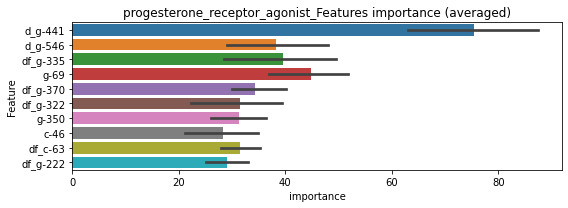

len(train_index) : 3802
len(valid_index) : 3802
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272684	valid_1's binary_logloss: 0.071206
[200]	training's binary_logloss: 0.00565311	valid_1's binary_logloss: 0.0466668
[300]	training's binary_logloss: 0.00177033	valid_1's binary_logloss: 0.0408717
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00117057	valid_1's binary_logloss: 0.0400624


len(train_index) : 3802
len(valid_index) : 3802
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028202	valid_1's binary_logloss: 0.0761888
[200]	training's binary_logloss: 0.0061916	valid_1's binary_logloss: 0.0528877
[300]	training's binary_logloss: 0.00191406	valid_1's binary_logloss: 0.0476545
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00202013	valid_1's binary_logloss: 0.0475425


progesterone_receptor_agonist logloss: 0.04380244381957513


neg labels: 3289 → selected neg labels: 3286


progesterone_receptor_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217024	valid_1's binary_logloss: 0.0281621
[200]	training's binary_logloss: 0.00243707	valid_1's binary_logloss: 0.00463432
[300]	training's binary_logloss: 0.000685883	valid_1's binary_logloss: 0.0018133
[400]	training's binary_logloss: 0.000364692	valid_1's binary_logloss: 0.00115093
[500]	training's binary_logloss: 0.000297321	valid_1's binary_logloss: 0.001001
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000296393	valid_1's binary_logloss: 0.000999539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219495	valid_1's binary_logloss: 0.0283082
[200]	training's binary_logloss: 0.00243542	valid_1's binary_logloss: 0.00406758
[300]	training's binary_logloss: 0.000683382	valid_1's binary_logloss: 0.00140299
[400]	training's binary_logloss: 0.000370125	valid_1's binary_logloss: 0.000816261
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0013762, Threshold: 0.0025187, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00227, conf_1:0.00277
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0025187
Num_p_label: 2.0, Expected: 3.0, Adj_threshold_2: 0.0125187
threshold: 0.0125187, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215155	valid_1's binary_logloss: 0.027255
[200]	training's binary_logloss: 0.00236908	valid_1's binary_logloss: 0.00398971
[300]	training's binary_logloss: 0.000667548	valid_1's binary_logloss: 0.00136309
[400]	training's binary_logloss: 0.000360219	valid_1's binary_logloss: 0.00082484
[500]	training's binary_logloss: 0.000293273	valid_1's binary_logloss: 0.000699478
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000289185	valid_1's binary_logloss: 0.000692651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217243	valid_1's binary_logloss: 0.0284386
[200]	training's binary_logloss: 0.00235366	valid_1's binary_logloss: 0.00413572
[300]	training's binary_logloss: 0.000658968	valid_1's binary_logloss: 0.0014051
[400]	training's binary_logloss: 0.000360412	valid_1's binary_logloss: 0.000869319
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1401237, Threshold: 0.0125187, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0075339 Vs.target_rate: 0.00076
Num_p_label: 30.0, conf_0:0.01127, conf_1:0.01377
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_1: 0.0125187
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_2: 0.0225187
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_3: 0.0325187
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.0425187
threshold: 0.0425187, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215155	valid_1's binary_logloss: 0.027255
[200]	training's binary_logloss: 0.00236908	valid_1's binary_logloss: 0.00398971
[300]	training's binary_logloss: 0.000667548	valid_1's binary_logloss: 0.00136309
[400]	training's binary_logloss: 0.000360219	valid_1's binary_logloss: 0.00082484
[500]	training's binary_logloss: 0.000293273	valid_1's binary_logloss: 0.000699478
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000289185	valid_1's binary_logloss: 0.000692651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217243	valid_1's binary_logloss: 0.0284386
[200]	training's binary_logloss: 0.00235366	valid_1's binary_logloss: 0.00413572
[300]	training's binary_logloss: 0.000658968	valid_1's binary_logloss: 0.0014051
[400]	training's binary_logloss: 0.000360412	valid_1's binary_logloss: 0.000869319
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1401237, Threshold: 0.0425187, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0010045 Vs.target_rate: 0.00076
Num_p_label: 4.0, conf_0:0.03827, conf_1:0.04677
threshold: 0.0425187, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 661.0/7793, y_label_rate: 0.0848197


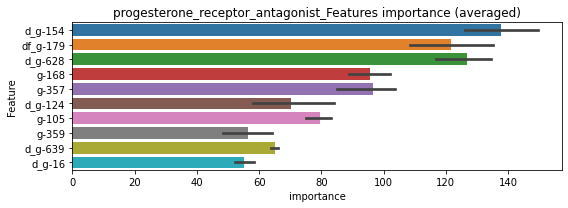

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118108	valid_1's binary_logloss: 0.0176245
[200]	training's binary_logloss: 0.00127959	valid_1's binary_logloss: 0.00523955
[300]	training's binary_logloss: 0.00034218	valid_1's binary_logloss: 0.00428158
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000300387	valid_1's binary_logloss: 0.00424838


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0118627	valid_1's binary_logloss: 0.015144
[200]	training's binary_logloss: 0.00131123	valid_1's binary_logloss: 0.00310226
[300]	training's binary_logloss: 0.000364855	valid_1's binary_logloss: 0.00176259
[400]	training's binary_logloss: 0.000190359	valid_1's binary_logloss: 0.00155036
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.000184904	valid_1's binary_logloss: 0.00154105


progesterone_receptor_antagonist logloss: 0.0028948885175243584


neg labels: 3289 → selected neg labels: 3283


prostaglandin_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343995	valid_1's binary_logloss: 0.0589473
[200]	training's binary_logloss: 0.00524383	valid_1's binary_logloss: 0.0197231
[300]	training's binary_logloss: 0.00148982	valid_1's binary_logloss: 0.0124166
[400]	training's binary_logloss: 0.000715945	valid_1's binary_logloss: 0.00955203
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.000708831	valid_1's binary_logloss: 0.00954609
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347987	valid_1's binary_logloss: 0.066211
[200]	training's binary_logloss: 0.00528733	valid_1's binary_logloss: 0.0280407
[300]	training's binary_logloss: 0.00149188	valid_1's binary_logloss: 0.020275
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0011179	valid_1's binary_logloss: 0.0191527


1 / 3 AUC score:1.000
y_Threshold: 0.0061452, Threshold: 0.0094388, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00849, conf_1:0.01038
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0094388
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0194388
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_3: 0.0294388
threshold: 0.0294388, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033056	valid_1's binary_logloss: 0.0572563
[200]	training's binary_logloss: 0.00498707	valid_1's binary_logloss: 0.0189132
[300]	training's binary_logloss: 0.00140728	valid_1's binary_logloss: 0.0115396
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000916652	valid_1's binary_logloss: 0.0102251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034903	valid_1's binary_logloss: 0.0667157
[200]	training's binary_logloss: 0.0054006	valid_1's binary_logloss: 0.0297362
[300]	training's binary_logloss: 0.00148867	valid_1's binary_logloss: 0.0226537
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.000826024	valid_1's binary_logloss: 0.0208862


2 / 3 AUC score:1.000
y_Threshold: 0.0310312, Threshold: 0.0294388, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0092918 Vs.target_rate: 0.00151
Num_p_label: 37.0, conf_0:0.02649, conf_1:0.03238
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_1: 0.0294388
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0394388
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_3: 0.0494388
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_4: 0.0594388
threshold: 0.0594388, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0341964	valid_1's binary_logloss: 0.0629696
[200]	training's binary_logloss: 0.00511429	valid_1's binary_logloss: 0.0220801
[300]	training's binary_logloss: 0.00145801	valid_1's binary_logloss: 0.0143988
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000806006	valid_1's binary_logloss: 0.0120636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034459	valid_1's binary_logloss: 0.0560709
[200]	training's binary_logloss: 0.00505026	valid_1's binary_logloss: 0.0127899
[300]	training's binary_logloss: 0.00143256	valid_1's binary_logloss: 0.00513293
[400]	training's binary_logloss: 0.000709539	valid_1's binary_logloss: 0.00316058
[500]	training's binary_logloss: 0.000478247	valid_1's binary_logloss: 0.00238978
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000437035	valid_1's binary_logloss: 0.00229776


3 / 3 AUC score:1.000
y_Threshold: 0.0525312, Threshold: 0.0594388, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0012557 Vs.target_rate: 0.00151
Num_p_label: 5.0, conf_0:0.05349, conf_1:0.06538
threshold: 0.0594388, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 660.0/7787, y_label_rate: 0.0847566


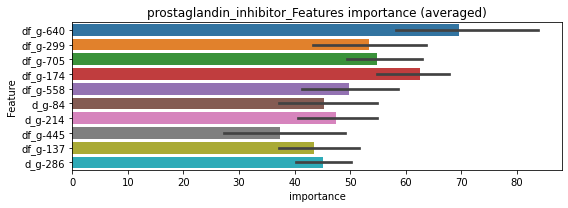

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190286	valid_1's binary_logloss: 0.0353513
[200]	training's binary_logloss: 0.00280522	valid_1's binary_logloss: 0.0133852
[300]	training's binary_logloss: 0.000763049	valid_1's binary_logloss: 0.00888578
[400]	training's binary_logloss: 0.000365753	valid_1's binary_logloss: 0.00788374
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000347304	valid_1's binary_logloss: 0.00779522


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191579	valid_1's binary_logloss: 0.0334874
[200]	training's binary_logloss: 0.00284994	valid_1's binary_logloss: 0.00991638
[300]	training's binary_logloss: 0.00078527	valid_1's binary_logloss: 0.00526022
[400]	training's binary_logloss: 0.000375336	valid_1's binary_logloss: 0.00408621
[500]	training's binary_logloss: 0.000247808	valid_1's binary_logloss: 0.00372646
Early stopping, best iteration is:
[522]	training's binary_logloss: 0.000235413	valid_1's binary_logloss: 0.00368054


prostaglandin_inhibitor logloss: 0.005738142947293318


neg labels: 3289 → selected neg labels: 3274


prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3274, target_rate: 0.0035273 → Adj_target_rate: 0.0036294
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0620672	valid_1's binary_logloss: 0.13165
[200]	training's binary_logloss: 0.0142839	valid_1's binary_logloss: 0.0785136
[300]	training's binary_logloss: 0.00433818	valid_1's binary_logloss: 0.0632645
[400]	training's binary_logloss: 0.00187502	valid_1's binary_logloss: 0.0590596
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00200358	valid_1's binary_logloss: 0.0589245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0593239	valid_1's binary_logloss: 0.145641
[200]	training's binary_logloss: 0.0136876	valid_1's binary_logloss: 0.0999129
[300]	training's binary_logloss: 0.00390851	valid_1's binary_logloss: 0.0911417
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00346573	valid_1's binary_logloss: 0.0908998


1 / 3 AUC score:0.985
y_Threshold: 0.0190542, Threshold: 0.0284550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 186 → Positive_corect_labels: 627/3742
p_label_rate: 0.0200904 Vs.target_rate: 0.00353
Num_p_label: 80.0, conf_0:0.02561, conf_1:0.03130
Num_p_label: 80.0, Expected: 14.0, Adj_threshold_1: 0.0284550
Num_p_label: 40.0, Expected: 14.0, Adj_threshold_2: 0.0384550
Num_p_label: 24.0, Expected: 14.0, Adj_threshold_3: 0.0484550
threshold: 0.0484550, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 627.0/3742, y_label_rate: 0.1675575
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571851	valid_1's binary_logloss: 0.125484
[200]	training's binary_logloss: 0.0120786	valid_1's binary_logloss: 0.0726609
[300]	training's binary_logloss: 0.00351564	valid_1's binary_logloss: 0.0614061
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00183488	valid_1's binary_logloss: 0.0589824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0579412	valid_1's binary_logloss: 0.116499
[200]	training's binary_logloss: 0.0123771	valid_1's binary_logloss: 0.0622183
[300]	training's binary_logloss: 0.00364364	valid_1's binary_logloss: 0.0480418
[400]	training's binary_logloss: 0.00168143	valid_1's binary_logloss: 0.0441121
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00124275	valid_1's binary_logloss: 0.0426079


2 / 3 AUC score:0.997
y_Threshold: 0.0370844, Threshold: 0.0484550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 610.0/3708
p_label_rate: 0.0080362 Vs.target_rate: 0.00353
Num_p_label: 32.0, conf_0:0.04361, conf_1:0.05330
threshold: 0.0484550, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 610.0/3708, y_label_rate: 0.1645092
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592722	valid_1's binary_logloss: 0.119653
[200]	training's binary_logloss: 0.0126185	valid_1's binary_logloss: 0.0700812
[300]	training's binary_logloss: 0.00361761	valid_1's binary_logloss: 0.0578158
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.00333199	valid_1's binary_logloss: 0.057409
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0522474	valid_1's binary_logloss: 0.110572
[200]	training's binary_logloss: 0.0108215	valid_1's binary_logloss: 0.0564502
[300]	training's binary_logloss: 0.00320073	valid_1's binary_logloss: 0.0410007
[400]	training's binary_logloss: 0.00145164	valid_1's binary_logloss: 0.0370016
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00152094	valid_1's binary_logloss: 0.0369065


3 / 3 AUC score:0.998
y_Threshold: 0.0532513, Threshold: 0.0484550, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 34 → Positive_corect_labels: 593.0/3674
p_label_rate: 0.0140633 Vs.target_rate: 0.00353
Num_p_label: 56.0, conf_0:0.04361, conf_1:0.05330
Num_p_label: 56.0, Expected: 14.0, Adj_threshold_1: 0.0484550
Num_p_label: 47.0, Expected: 14.0, Adj_threshold_2: 0.0584550
Num_p_label: 38.0, Expected: 14.0, Adj_threshold_3: 0.0684550
Num_p_label: 29.0, Expected: 14.0, Adj_threshold_4: 0.0784550
Num_p_label: 20.0, Expected: 14.0, Adj_threshold_5: 0.0884550
threshold: 0.0884550, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 613.0/7656, y_label_rate: 0.0800679


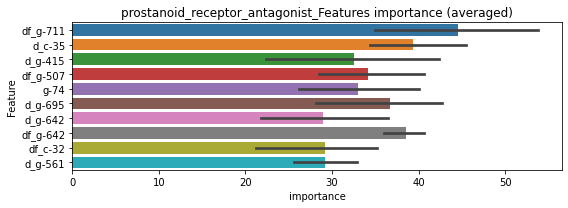

len(train_index) : 3828
len(valid_index) : 3828
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290301	valid_1's binary_logloss: 0.0733279
[200]	training's binary_logloss: 0.00601125	valid_1's binary_logloss: 0.0447017
[300]	training's binary_logloss: 0.00175546	valid_1's binary_logloss: 0.0388376
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000981073	valid_1's binary_logloss: 0.0376049


len(train_index) : 3828
len(valid_index) : 3828
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316277	valid_1's binary_logloss: 0.0689622
[200]	training's binary_logloss: 0.0070048	valid_1's binary_logloss: 0.0408747
[300]	training's binary_logloss: 0.00197038	valid_1's binary_logloss: 0.0330214
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00154052	valid_1's binary_logloss: 0.0321351


prostanoid_receptor_antagonist logloss: 0.03486998448910242


neg labels: 3289 → selected neg labels: 3285


proteasome_inhibitor, len(trt): 726, len(othr): 3285, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204326	valid_1's binary_logloss: 0.0229591
[200]	training's binary_logloss: 0.00189562	valid_1's binary_logloss: 0.00588267
Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000908588	valid_1's binary_logloss: 0.00517011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189255	valid_1's binary_logloss: 0.0267043
[200]	training's binary_logloss: 0.00172692	valid_1's binary_logloss: 0.0105177
[300]	training's binary_logloss: 0.000398175	valid_1's binary_logloss: 0.00916051
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.000414899	valid_1's binary_logloss: 0.0091434


1 / 3 AUC score:1.000
y_Threshold: 0.0003291, Threshold: 0.9986938, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 161 → Positive_corect_labels: 726/3850
p_label_rate: 0.0200904 Vs.target_rate: 0.03049
Num_p_label: 80.0, conf_0:0.89882, conf_1:1.09856
threshold: 0.9986938, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155442	valid_1's binary_logloss: 0.0158602
[200]	training's binary_logloss: 0.00099804	valid_1's binary_logloss: 0.00114153
[300]	training's binary_logloss: 0.00022067	valid_1's binary_logloss: 0.000320358
[400]	training's binary_logloss: 0.00014645	valid_1's binary_logloss: 0.000237496
[500]	training's binary_logloss: 0.000133384	valid_1's binary_logloss: 0.000221363
[600]	training's binary_logloss: 0.000130618	valid_1's binary_logloss: 0.000218019
[700]	training's binary_logloss: 0.00012921	valid_1's binary_logloss: 0.000216588
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.000129126	valid_1's binary_logloss: 0.000216477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157471	valid_1's binary_logloss: 0.0162327
[200]	training's binary_logloss: 0.00102695	valid_1's binary_logloss: 0.00116389
[300]	training's binary_logl

2 / 3 AUC score:1.000
y_Threshold: 0.2622803, Threshold: 0.9986938, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0369161 Vs.target_rate: 0.03049
Num_p_label: 147.0, conf_0:0.89882, conf_1:1.09856
threshold: 0.9986938, positive_p_label: 147.0/3982, p_label_rate: 0.0369161
positive_y_label: 726.0/3850, y_label_rate: 0.1885714
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155442	valid_1's binary_logloss: 0.0158602
[200]	training's binary_logloss: 0.00099804	valid_1's binary_logloss: 0.00114153
[300]	training's binary_logloss: 0.00022067	valid_1's binary_logloss: 0.000320358
[400]	training's binary_logloss: 0.00014645	valid_1's binary_logloss: 0.000237496
[500]	training's binary_logloss: 0.000133384	valid_1's binary_logloss: 0.000221363
[600]	training's binary_logloss: 0.000130618	valid_1's binary_logloss: 0.000218019
[700]	training's binary_logloss: 0.00012921	valid_1's binary_logloss: 0.000216588
Early stopping, best iteration is:
[728]	training's binary_logloss: 0.000129126	valid_1's binary_logloss: 0.000216477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157471	valid_1's binary_logloss: 0.0162327
[200]	training's binary_logloss: 0.00102695	valid_1's binary_logloss: 0.00116389
[300]	training's binary_logl

3 / 3 AUC score:1.000
y_Threshold: 0.2622803, Threshold: 0.9986938, pos_neg_ratio: 0.7789954
Remove_noisy_labels: 0 → Positive_corect_labels: 726.0/3850
p_label_rate: 0.0369161 Vs.target_rate: 0.03049
Num_p_label: 147.0, conf_0:0.89882, conf_1:1.09856
threshold: 0.9986938, positive_p_label: 147.0/3982, p_label_rate: 0.0369161
positive_y_label: 873.0/7832, y_label_rate: 0.1114658


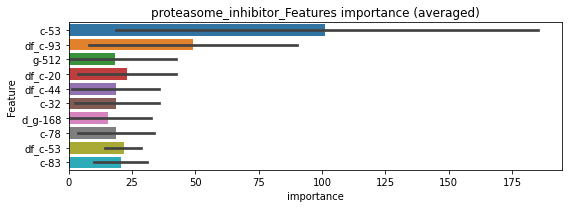

len(train_index) : 3916
len(valid_index) : 3916
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108643	valid_1's binary_logloss: 0.0144293
[200]	training's binary_logloss: 0.00080858	valid_1's binary_logloss: 0.00478289
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0003937	valid_1's binary_logloss: 0.00449012


len(train_index) : 3916
len(valid_index) : 3916
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011595	valid_1's binary_logloss: 0.012254
[200]	training's binary_logloss: 0.000985107	valid_1's binary_logloss: 0.00190063
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000278524	valid_1's binary_logloss: 0.00133707


proteasome_inhibitor logloss: 0.002913594832397072


neg labels: 3289 → selected neg labels: 3281


protein_kinase_inhibitor, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0413144	valid_1's binary_logloss: 0.085711
[200]	training's binary_logloss: 0.00713857	valid_1's binary_logloss: 0.0424679
[300]	training's binary_logloss: 0.00198979	valid_1's binary_logloss: 0.0344316
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00122293	valid_1's binary_logloss: 0.0331103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043137	valid_1's binary_logloss: 0.0755405
[200]	training's binary_logloss: 0.00751554	valid_1's binary_logloss: 0.0295243
[300]	training's binary_logloss: 0.00211048	valid_1's binary_logloss: 0.0193979
[400]	training's binary_logloss: 0.000981426	valid_1's binary_logloss: 0.01625
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000796448	valid_1's binary_logloss: 0.0157237


1 / 3 AUC score:0.998
y_Threshold: 0.0076963, Threshold: 0.0114738, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 648/3789
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.01033, conf_1:0.01262
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0114738
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_2: 0.0214738
Num_p_label: 16.0, Expected: 8.0, Adj_threshold_3: 0.0314738
threshold: 0.0314738, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 648.0/3789, y_label_rate: 0.1710214
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409304	valid_1's binary_logloss: 0.0845276
[200]	training's binary_logloss: 0.00666564	valid_1's binary_logloss: 0.0383739
[300]	training's binary_logloss: 0.00189222	valid_1's binary_logloss: 0.0273955
[400]	training's binary_logloss: 0.000905963	valid_1's binary_logloss: 0.0233985
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000626339	valid_1's binary_logloss: 0.0215377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410472	valid_1's binary_logloss: 0.0663275
[200]	training's binary_logloss: 0.00659814	valid_1's binary_logloss: 0.021598
[300]	training's binary_logloss: 0.00187661	valid_1's binary_logloss: 0.0126163
[400]	training's binary_logloss: 0.000902657	valid_1's binary_logloss: 0.0102128
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000631624	valid_1's binary_logloss: 0.00960586


2 / 3 AUC score:1.000
y_Threshold: 0.0294132, Threshold: 0.0314738, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 645.0/3783
p_label_rate: 0.0080362 Vs.target_rate: 0.00202
Num_p_label: 32.0, conf_0:0.02833, conf_1:0.03462
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_1: 0.0314738
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.0414738
Num_p_label: 12.0, Expected: 8.0, Adj_threshold_3: 0.0514738
threshold: 0.0514738, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 645.0/3783, y_label_rate: 0.1704996
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392255	valid_1's binary_logloss: 0.0792666
[200]	training's binary_logloss: 0.00633358	valid_1's binary_logloss: 0.0344133
[300]	training's binary_logloss: 0.00180515	valid_1's binary_logloss: 0.0238045
[400]	training's binary_logloss: 0.000853822	valid_1's binary_logloss: 0.0190243
[500]	training's binary_logloss: 0.000553449	valid_1's binary_logloss: 0.0176676
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000507781	valid_1's binary_logloss: 0.0172814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0414011	valid_1's binary_logloss: 0.0684506
[200]	training's binary_logloss: 0.00686126	valid_1's binary_logloss: 0.0228292
[300]	training's binary_logloss: 0.0019297	valid_1's binary_logloss: 0.0125357
[400]	training's binary_logloss: 0.000919214	valid_1's binary_logloss: 0.00931154
Early stopping, best iteration is:
[473]	

3 / 3 AUC score:1.000
y_Threshold: 0.0318156, Threshold: 0.0514738, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0025113 Vs.target_rate: 0.00202
Num_p_label: 10.0, conf_0:0.04633, conf_1:0.05662
threshold: 0.0514738, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 654.0/7763, y_label_rate: 0.0842458


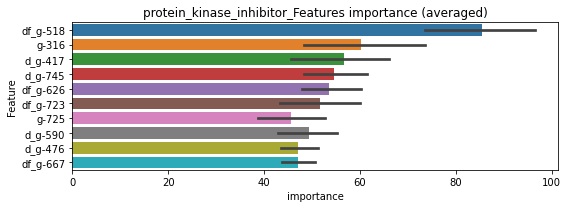

len(train_index) : 3881
len(valid_index) : 3882
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234981	valid_1's binary_logloss: 0.0422097
[200]	training's binary_logloss: 0.00383569	valid_1's binary_logloss: 0.0180111
[300]	training's binary_logloss: 0.00104315	valid_1's binary_logloss: 0.0131557
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.000632242	valid_1's binary_logloss: 0.0123949


len(train_index) : 3882
len(valid_index) : 3881
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224126	valid_1's binary_logloss: 0.049555
[200]	training's binary_logloss: 0.00371717	valid_1's binary_logloss: 0.0279796
[300]	training's binary_logloss: 0.00102256	valid_1's binary_logloss: 0.0248215
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00113115	valid_1's binary_logloss: 0.0246947


protein_kinase_inhibitor logloss: 0.018544021675263686


neg labels: 3289 → selected neg labels: 3286


protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251625	valid_1's binary_logloss: 0.0345135
[200]	training's binary_logloss: 0.00311543	valid_1's binary_logloss: 0.00928159
[300]	training's binary_logloss: 0.0008802	valid_1's binary_logloss: 0.00554068
[400]	training's binary_logloss: 0.000458282	valid_1's binary_logloss: 0.00434454
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000360016	valid_1's binary_logloss: 0.00396742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024815	valid_1's binary_logloss: 0.0443207
[200]	training's binary_logloss: 0.00307023	valid_1's binary_logloss: 0.0116561
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00104949	valid_1's binary_logloss: 0.00767865


1 / 3 AUC score:1.000
y_Threshold: 0.0031183, Threshold: 0.0053171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00101
Num_p_label: 80.0, conf_0:0.00479, conf_1:0.00585
Num_p_label: 80.0, Expected: 4.0, Adj_threshold_1: 0.0053171
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_2: 0.0153171
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_3: 0.0253171
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_4: 0.0353171
threshold: 0.0353171, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248666	valid_1's binary_logloss: 0.033678
[200]	training's binary_logloss: 0.00295588	valid_1's binary_logloss: 0.00739934
[300]	training's binary_logloss: 0.000842365	valid_1's binary_logloss: 0.00350501
[400]	training's binary_logloss: 0.000445348	valid_1's binary_logloss: 0.00253795
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00035234	valid_1's binary_logloss: 0.00230927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247644	valid_1's binary_logloss: 0.0405021
[200]	training's binary_logloss: 0.00293294	valid_1's binary_logloss: 0.00985705
[300]	training's binary_logloss: 0.000833129	valid_1's binary_logloss: 0.00591964
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00064349	valid_1's binary_logloss: 0.00553397


2 / 3 AUC score:1.000
y_Threshold: 0.0223120, Threshold: 0.0353171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0082873 Vs.target_rate: 0.00101
Num_p_label: 33.0, conf_0:0.03179, conf_1:0.03885
Num_p_label: 33.0, Expected: 4.0, Adj_threshold_1: 0.0353171
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.0453171
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.0553171
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_4: 0.0653171
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_5: 0.0753171
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_6: 0.0853171
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_7: 0.0953171
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_8: 0.1053171
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_9: 0.1153171
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_10: 0.1253171
threshold: 0.1353171, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
==========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248666	valid_1's binary_logloss: 0.033678
[200]	training's binary_logloss: 0.00295588	valid_1's binary_logloss: 0.00739934
[300]	training's binary_logloss: 0.000842365	valid_1's binary_logloss: 0.00350501
[400]	training's binary_logloss: 0.000445348	valid_1's binary_logloss: 0.00253795
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00035234	valid_1's binary_logloss: 0.00230927
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247644	valid_1's binary_logloss: 0.0405021
[200]	training's binary_logloss: 0.00293294	valid_1's binary_logloss: 0.00985705
[300]	training's binary_logloss: 0.000833129	valid_1's binary_logloss: 0.00591964
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.00064349	valid_1's binary_logloss: 0.00553397


3 / 3 AUC score:1.000
y_Threshold: 0.0223120, Threshold: 0.1353171, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0022602 Vs.target_rate: 0.00101
Num_p_label: 9.0, conf_0:0.12179, conf_1:0.14885
threshold: 0.1353171, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 666.0/7793, y_label_rate: 0.0854613


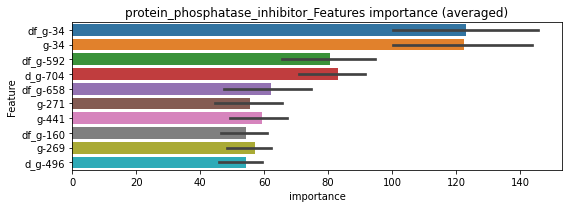

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0139776	valid_1's binary_logloss: 0.0240892
[200]	training's binary_logloss: 0.00168558	valid_1's binary_logloss: 0.00863612
[300]	training's binary_logloss: 0.000465295	valid_1's binary_logloss: 0.00675109
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.000448089	valid_1's binary_logloss: 0.00670662


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0138614	valid_1's binary_logloss: 0.0254489
[200]	training's binary_logloss: 0.00172302	valid_1's binary_logloss: 0.0108546
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000538994	valid_1's binary_logloss: 0.00946883


protein_phosphatase_inhibitor logloss: 0.008087549134298185


neg labels: 3289 → selected neg labels: 3271


protein_synthesis_inhibitor, len(trt): 103, len(othr): 3271, target_rate: 0.0043252 → Adj_target_rate: 0.0043163
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0624337	valid_1's binary_logloss: 0.140062
[200]	training's binary_logloss: 0.0142542	valid_1's binary_logloss: 0.0871335
[300]	training's binary_logloss: 0.00403754	valid_1's binary_logloss: 0.0728469
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00275953	valid_1's binary_logloss: 0.0696323
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0586988	valid_1's binary_logloss: 0.145838
[200]	training's binary_logloss: 0.0125654	valid_1's binary_logloss: 0.0949749
[300]	training's binary_logloss: 0.00376925	valid_1's binary_logloss: 0.0813267
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00202623	valid_1's binary_logloss: 0.0790488


1 / 3 AUC score:0.989
y_Threshold: 0.0169114, Threshold: 0.0811557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 171 → Positive_corect_labels: 634/3754
p_label_rate: 0.0200904 Vs.target_rate: 0.00433
Num_p_label: 80.0, conf_0:0.07304, conf_1:0.08927
Num_p_label: 80.0, Expected: 17.2, Adj_threshold_1: 0.0811557
Num_p_label: 77.0, Expected: 17.2, Adj_threshold_2: 0.0911557
Num_p_label: 73.0, Expected: 17.2, Adj_threshold_3: 0.1011557
Num_p_label: 68.0, Expected: 17.2, Adj_threshold_4: 0.1111557
Num_p_label: 66.0, Expected: 17.2, Adj_threshold_5: 0.1211557
Num_p_label: 62.0, Expected: 17.2, Adj_threshold_6: 0.1311557
Num_p_label: 56.0, Expected: 17.2, Adj_threshold_7: 0.1411557
Num_p_label: 54.0, Expected: 17.2, Adj_threshold_8: 0.1511557
Num_p_label: 53.0, Expected: 17.2, Adj_threshold_9: 0.1611557
Num_p_label: 49.0, Expected: 17.2, Adj_threshold_10: 0.1711557
threshold: 0.1811557, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 634.0/3754, y_label_rate: 0.1688865

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.056911	valid_1's binary_logloss: 0.130087
[200]	training's binary_logloss: 0.0121579	valid_1's binary_logloss: 0.0838571
[300]	training's binary_logloss: 0.00359307	valid_1's binary_logloss: 0.0730635
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00275293	valid_1's binary_logloss: 0.0712786
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553825	valid_1's binary_logloss: 0.14372
[200]	training's binary_logloss: 0.0113825	valid_1's binary_logloss: 0.101833
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00592763	valid_1's binary_logloss: 0.0967265


2 / 3 AUC score:0.994
y_Threshold: 0.0484021, Threshold: 0.1811557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 72 → Positive_corect_labels: 598.0/3682
p_label_rate: 0.0303867 Vs.target_rate: 0.00433
Num_p_label: 121.0, conf_0:0.16304, conf_1:0.19927
Num_p_label: 121.0, Expected: 17.2, Adj_threshold_1: 0.1811557
Num_p_label: 118.0, Expected: 17.2, Adj_threshold_2: 0.1911557
Num_p_label: 113.0, Expected: 17.2, Adj_threshold_3: 0.2011557
Num_p_label: 112.0, Expected: 17.2, Adj_threshold_4: 0.2111557
Num_p_label: 109.0, Expected: 17.2, Adj_threshold_5: 0.2211557
Num_p_label: 106.0, Expected: 17.2, Adj_threshold_6: 0.2311557
Num_p_label: 104.0, Expected: 17.2, Adj_threshold_7: 0.2411557
Num_p_label: 103.0, Expected: 17.2, Adj_threshold_8: 0.2511557
Num_p_label: 100.0, Expected: 17.2, Adj_threshold_9: 0.2611557
Num_p_label: 100.0, Expected: 17.2, Adj_threshold_10: 0.2711557
threshold: 0.2811557, positive_p_label: 97.0/3982, p_label_rate: 0.0243596
positive_y_label: 598.0/3682, y_label_rat

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524326	valid_1's binary_logloss: 0.111886
[200]	training's binary_logloss: 0.00992524	valid_1's binary_logloss: 0.0616816
[300]	training's binary_logloss: 0.0029095	valid_1's binary_logloss: 0.0488078
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00243202	valid_1's binary_logloss: 0.047477
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0468009	valid_1's binary_logloss: 0.11713
[200]	training's binary_logloss: 0.00921639	valid_1's binary_logloss: 0.0771988
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.0044731	valid_1's binary_logloss: 0.0717646


3 / 3 AUC score:0.993
y_Threshold: 0.0429833, Threshold: 0.2811557, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 46 → Positive_corect_labels: 575.0/3636
p_label_rate: 0.0281266 Vs.target_rate: 0.00433
Num_p_label: 112.0, conf_0:0.25304, conf_1:0.30927
Num_p_label: 112.0, Expected: 17.2, Adj_threshold_1: 0.2811557
Num_p_label: 108.0, Expected: 17.2, Adj_threshold_2: 0.2911557
Num_p_label: 105.0, Expected: 17.2, Adj_threshold_3: 0.3011557
Num_p_label: 105.0, Expected: 17.2, Adj_threshold_4: 0.3111557
Num_p_label: 104.0, Expected: 17.2, Adj_threshold_5: 0.3211557
Num_p_label: 100.0, Expected: 17.2, Adj_threshold_6: 0.3311557
Num_p_label: 100.0, Expected: 17.2, Adj_threshold_7: 0.3411557
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_8: 0.3511557
Num_p_label: 97.0, Expected: 17.2, Adj_threshold_9: 0.3611557
Num_p_label: 94.0, Expected: 17.2, Adj_threshold_10: 0.3711557
threshold: 0.3811557, positive_p_label: 92.0/3982, p_label_rate: 0.0231040
positive_y_label: 667.0/7618, y_label_rate: 

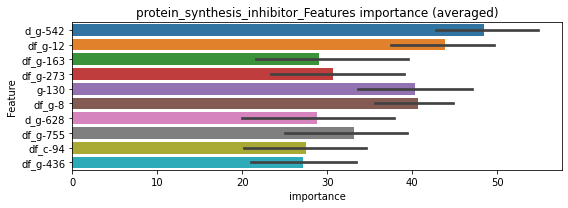

len(train_index) : 3809
len(valid_index) : 3809
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301844	valid_1's binary_logloss: 0.0646694
[200]	training's binary_logloss: 0.00635297	valid_1's binary_logloss: 0.0382076
[300]	training's binary_logloss: 0.00184764	valid_1's binary_logloss: 0.0316797
[400]	training's binary_logloss: 0.000800485	valid_1's binary_logloss: 0.0296652
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000832455	valid_1's binary_logloss: 0.0296105


len(train_index) : 3809
len(valid_index) : 3809
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290296	valid_1's binary_logloss: 0.0616804
[200]	training's binary_logloss: 0.00570938	valid_1's binary_logloss: 0.0336986
[300]	training's binary_logloss: 0.00169598	valid_1's binary_logloss: 0.0266525
[400]	training's binary_logloss: 0.000758091	valid_1's binary_logloss: 0.0245358
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000807466	valid_1's binary_logloss: 0.0244746


protein_synthesis_inhibitor logloss: 0.027042546610563937


neg labels: 3289 → selected neg labels: 3285


protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0248054	valid_1's binary_logloss: 0.0346285
[200]	training's binary_logloss: 0.00304652	valid_1's binary_logloss: 0.00586461
[300]	training's binary_logloss: 0.000857659	valid_1's binary_logloss: 0.0020525
[400]	training's binary_logloss: 0.000448516	valid_1's binary_logloss: 0.00118729
[500]	training's binary_logloss: 0.000349154	valid_1's binary_logloss: 0.000991287
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000346816	valid_1's binary_logloss: 0.00098877
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257391	valid_1's binary_logloss: 0.0346132
[200]	training's binary_logloss: 0.00318672	valid_1's binary_logloss: 0.00555074
[300]	training's binary_logloss: 0.00088407	valid_1's binary_logloss: 0.00186251
[400]	training's binary_logloss: 0.000455284	valid_1's binary_logloss: 0.00109833
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0013988, Threshold: 0.0020869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00188, conf_1:0.00230
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0020869
Num_p_label: 0.0, Expected: 3.2, Adj_threshold_2: 0.0120869
threshold: 0.0120869, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253128	valid_1's binary_logloss: 0.0343701
[200]	training's binary_logloss: 0.0030712	valid_1's binary_logloss: 0.00548684
[300]	training's binary_logloss: 0.000866858	valid_1's binary_logloss: 0.00186733
[400]	training's binary_logloss: 0.000449477	valid_1's binary_logloss: 0.001074
[500]	training's binary_logloss: 0.000349381	valid_1's binary_logloss: 0.000884447
Early stopping, best iteration is:
[562]	training's binary_logloss: 0.000340794	valid_1's binary_logloss: 0.000870589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026133	valid_1's binary_logloss: 0.0346168
[200]	training's binary_logloss: 0.00314043	valid_1's binary_logloss: 0.00532193
[300]	training's binary_logloss: 0.000878374	valid_1's binary_logloss: 0.00184689
[400]	training's binary_logloss: 0.000457986	valid_1's binary_logloss: 0.00109196
[500]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1398677, Threshold: 0.0120869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080
Num_p_label: 7.0, conf_0:0.01088, conf_1:0.01330
threshold: 0.0120869, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0253128	valid_1's binary_logloss: 0.0343701
[200]	training's binary_logloss: 0.0030712	valid_1's binary_logloss: 0.00548684
[300]	training's binary_logloss: 0.000866858	valid_1's binary_logloss: 0.00186733
[400]	training's binary_logloss: 0.000449477	valid_1's binary_logloss: 0.001074
[500]	training's binary_logloss: 0.000349381	valid_1's binary_logloss: 0.000884447
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.000340794	valid_1's binary_logloss: 0.000870589
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026133	valid_1's binary_logloss: 0.0346168
[200]	training's binary_logloss: 0.00314043	valid_1's binary_logloss: 0.00532193
[300]	training's binary_logloss: 0.000878374	valid_1's binary_logloss: 0.00184689
[400]	training's binary_logloss: 0.000457986	valid_1's binary_logloss: 0.00109196
[500]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1398677, Threshold: 0.0120869, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080
Num_p_label: 7.0, conf_0:0.01088, conf_1:0.01330
threshold: 0.0120869, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 664.0/7792, y_label_rate: 0.0852156


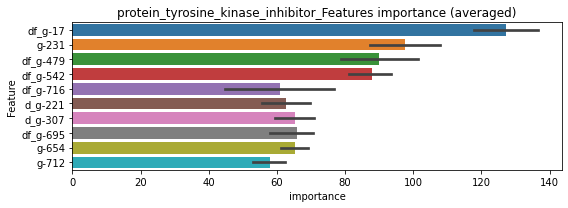

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142275	valid_1's binary_logloss: 0.0233216
[200]	training's binary_logloss: 0.00169815	valid_1's binary_logloss: 0.00986902
[300]	training's binary_logloss: 0.000457158	valid_1's binary_logloss: 0.00862507
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000457158	valid_1's binary_logloss: 0.00862507


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142651	valid_1's binary_logloss: 0.0222575
[200]	training's binary_logloss: 0.0017701	valid_1's binary_logloss: 0.00692415
[300]	training's binary_logloss: 0.000487975	valid_1's binary_logloss: 0.00480455
[400]	training's binary_logloss: 0.000243548	valid_1's binary_logloss: 0.00445627
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.000229751	valid_1's binary_logloss: 0.00444834


protein_tyrosine_kinase_inhibitor logloss: 0.006536702537702428


neg labels: 3289 → selected neg labels: 3281


radiopaque_medium, len(trt): 56, len(othr): 3281, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464241	valid_1's binary_logloss: 0.112362
[200]	training's binary_logloss: 0.0084894	valid_1's binary_logloss: 0.0688617
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00313057	valid_1's binary_logloss: 0.0610289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0513428	valid_1's binary_logloss: 0.0847766
[200]	training's binary_logloss: 0.0099381	valid_1's binary_logloss: 0.0336997
[300]	training's binary_logloss: 0.00274688	valid_1's binary_logloss: 0.0218526
[400]	training's binary_logloss: 0.00123953	valid_1's binary_logloss: 0.0178833
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000902491	valid_1's binary_logloss: 0.0169431


1 / 3 AUC score:0.997
y_Threshold: 0.0156505, Threshold: 0.0210976, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 647/3787
p_label_rate: 0.0200904 Vs.target_rate: 0.00235
Num_p_label: 80.0, conf_0:0.01899, conf_1:0.02321
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.0210976
Num_p_label: 44.0, Expected: 9.4, Adj_threshold_2: 0.0310976
Num_p_label: 26.0, Expected: 9.4, Adj_threshold_3: 0.0410976
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_4: 0.0510976
threshold: 0.0510976, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452287	valid_1's binary_logloss: 0.0852966
[200]	training's binary_logloss: 0.00858888	valid_1's binary_logloss: 0.0370698
[300]	training's binary_logloss: 0.00241344	valid_1's binary_logloss: 0.0250231
[400]	training's binary_logloss: 0.00112185	valid_1's binary_logloss: 0.0208723
[500]	training's binary_logloss: 0.000709453	valid_1's binary_logloss: 0.0195098
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.0006237	valid_1's binary_logloss: 0.0189711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0461541	valid_1's binary_logloss: 0.078796
[200]	training's binary_logloss: 0.00872587	valid_1's binary_logloss: 0.0287618
[300]	training's binary_logloss: 0.0024622	valid_1's binary_logloss: 0.0160608
[400]	training's binary_logloss: 0.00114732	valid_1's binary_logloss: 0.0127958
[500]	training's binary_logloss: 0.000717897	va

2 / 3 AUC score:1.000
y_Threshold: 0.0599516, Threshold: 0.0510976, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0050226 Vs.target_rate: 0.00235
Num_p_label: 20.0, conf_0:0.04599, conf_1:0.05621
threshold: 0.0510976, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 644.0/3781, y_label_rate: 0.1703253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043376	valid_1's binary_logloss: 0.10416
[200]	training's binary_logloss: 0.00759393	valid_1's binary_logloss: 0.0655734
[300]	training's binary_logloss: 0.00218774	valid_1's binary_logloss: 0.0608272
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00196751	valid_1's binary_logloss: 0.0603042
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0464866	valid_1's binary_logloss: 0.0830851
[200]	training's binary_logloss: 0.00850979	valid_1's binary_logloss: 0.0396807
[300]	training's binary_logloss: 0.0024311	valid_1's binary_logloss: 0.0318333
[400]	training's binary_logloss: 0.00111754	valid_1's binary_logloss: 0.0304052
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00119006	valid_1's binary_logloss: 0.0302009


3 / 3 AUC score:0.995
y_Threshold: 0.0358568, Threshold: 0.0510976, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 628.0/3749
p_label_rate: 0.0120542 Vs.target_rate: 0.00235
Num_p_label: 48.0, conf_0:0.04599, conf_1:0.05621
Num_p_label: 48.0, Expected: 9.4, Adj_threshold_1: 0.0510976
Num_p_label: 37.0, Expected: 9.4, Adj_threshold_2: 0.0610976
Num_p_label: 29.0, Expected: 9.4, Adj_threshold_3: 0.0710976
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_4: 0.0810976
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_5: 0.0910976
threshold: 0.0910976, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 645.0/7731, y_label_rate: 0.0834303


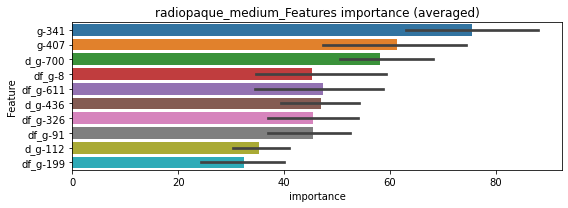

len(train_index) : 3865
len(valid_index) : 3866
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251841	valid_1's binary_logloss: 0.0523849
[200]	training's binary_logloss: 0.00469761	valid_1's binary_logloss: 0.0275491
[300]	training's binary_logloss: 0.00132417	valid_1's binary_logloss: 0.0236123
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00104537	valid_1's binary_logloss: 0.0231544


len(train_index) : 3866
len(valid_index) : 3865
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0265985	valid_1's binary_logloss: 0.0563418
[200]	training's binary_logloss: 0.00470825	valid_1's binary_logloss: 0.0319641
[300]	training's binary_logloss: 0.0013159	valid_1's binary_logloss: 0.0265901
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.000998223	valid_1's binary_logloss: 0.0261344


radiopaque_medium logloss: 0.024644182062631657


neg labels: 3289 → selected neg labels: 3280


raf_inhibitor, len(trt): 223, len(othr): 3280, target_rate: 0.0093642 → Adj_target_rate: 0.0083226
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247886	valid_1's binary_logloss: 0.0628295
[200]	training's binary_logloss: 0.00328673	valid_1's binary_logloss: 0.0440848
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00303463	valid_1's binary_logloss: 0.0438163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270238	valid_1's binary_logloss: 0.0427987
[200]	training's binary_logloss: 0.00435824	valid_1's binary_logloss: 0.0232628
[300]	training's binary_logloss: 0.0017753	valid_1's binary_logloss: 0.0208815
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00185629	valid_1's binary_logloss: 0.0208395


1 / 3 AUC score:0.999
y_Threshold: 0.0072074, Threshold: 0.0263150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 653/3798
p_label_rate: 0.0200904 Vs.target_rate: 0.00936
Num_p_label: 80.0, conf_0:0.02368, conf_1:0.02895
threshold: 0.0263150, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 653.0/3798, y_label_rate: 0.1719326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232494	valid_1's binary_logloss: 0.0602417
[200]	training's binary_logloss: 0.00280498	valid_1's binary_logloss: 0.0444677
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00275927	valid_1's binary_logloss: 0.0444496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251744	valid_1's binary_logloss: 0.0406984
[200]	training's binary_logloss: 0.0033827	valid_1's binary_logloss: 0.020276
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00125757	valid_1's binary_logloss: 0.0170269


2 / 3 AUC score:0.999
y_Threshold: 0.0268572, Threshold: 0.0263150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 645.0/3782
p_label_rate: 0.0346560 Vs.target_rate: 0.00936
Num_p_label: 138.0, conf_0:0.02368, conf_1:0.02895
Num_p_label: 138.0, Expected: 37.3, Adj_threshold_1: 0.0263150
Num_p_label: 111.0, Expected: 37.3, Adj_threshold_2: 0.0363150
Num_p_label: 100.0, Expected: 37.3, Adj_threshold_3: 0.0463150
Num_p_label: 92.0, Expected: 37.3, Adj_threshold_4: 0.0563150
Num_p_label: 83.0, Expected: 37.3, Adj_threshold_5: 0.0663150
Num_p_label: 81.0, Expected: 37.3, Adj_threshold_6: 0.0763150
Num_p_label: 77.0, Expected: 37.3, Adj_threshold_7: 0.0863150
Num_p_label: 67.0, Expected: 37.3, Adj_threshold_8: 0.0963150
threshold: 0.0963150, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 645.0/3782, y_label_rate: 0.1705447
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241222	valid_1's binary_logloss: 0.047565
[200]	training's binary_logloss: 0.00304556	valid_1's binary_logloss: 0.0273305
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00219848	valid_1's binary_logloss: 0.0260851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235363	valid_1's binary_logloss: 0.0394748
[200]	training's binary_logloss: 0.00286535	valid_1's binary_logloss: 0.0186706
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00107913	valid_1's binary_logloss: 0.0170683


3 / 3 AUC score:1.000
y_Threshold: 0.0300212, Threshold: 0.0963150, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 642.0/3776
p_label_rate: 0.0155701 Vs.target_rate: 0.00936
Num_p_label: 62.0, conf_0:0.08668, conf_1:0.10595
threshold: 0.0963150, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 704.0/7758, y_label_rate: 0.0907450


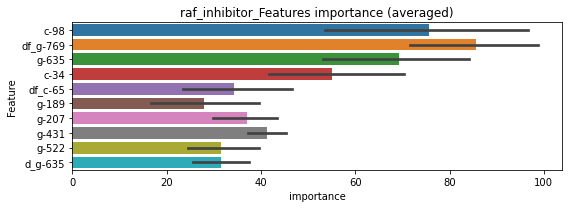

len(train_index) : 3879
len(valid_index) : 3879
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146554	valid_1's binary_logloss: 0.0320423
[200]	training's binary_logloss: 0.00214467	valid_1's binary_logloss: 0.0198045
Early stopping, best iteration is:
[276]	training's binary_logloss: 0.000653792	valid_1's binary_logloss: 0.0180231


len(train_index) : 3879
len(valid_index) : 3879
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013263	valid_1's binary_logloss: 0.0355611
[200]	training's binary_logloss: 0.00169456	valid_1's binary_logloss: 0.0262317
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00079148	valid_1's binary_logloss: 0.0250074


raf_inhibitor logloss: 0.02151525259999046


neg labels: 3289 → selected neg labels: 3287


ras_gtpase_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187203	valid_1's binary_logloss: 0.0234813
[200]	training's binary_logloss: 0.00186044	valid_1's binary_logloss: 0.00334524
[300]	training's binary_logloss: 0.000522733	valid_1's binary_logloss: 0.00116771
[400]	training's binary_logloss: 0.000302166	valid_1's binary_logloss: 0.000775558
[500]	training's binary_logloss: 0.000263139	valid_1's binary_logloss: 0.000703968
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00026273	valid_1's binary_logloss: 0.00070336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191607	valid_1's binary_logloss: 0.022247
[200]	training's binary_logloss: 0.00191024	valid_1's binary_logloss: 0.00262689
[300]	training's binary_logloss: 0.000531866	valid_1's binary_logloss: 0.00079751
[400]	training's binary_logloss: 0.000305999	valid_1's binary_logloss: 0.000483745
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0008437, Threshold: 0.0011056, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00100, conf_1:0.00122
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0011056
Num_p_label: 1.0, Expected: 2.0, Adj_threshold_2: 0.0111056
threshold: 0.0111056, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189878	valid_1's binary_logloss: 0.0231025
[200]	training's binary_logloss: 0.00186759	valid_1's binary_logloss: 0.00350725
[300]	training's binary_logloss: 0.000521824	valid_1's binary_logloss: 0.00138818
[400]	training's binary_logloss: 0.00030457	valid_1's binary_logloss: 0.00100416
[500]	training's binary_logloss: 0.000262843	valid_1's binary_logloss: 0.000932226
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00026201	valid_1's binary_logloss: 0.000931282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191142	valid_1's binary_logloss: 0.0218302
[200]	training's binary_logloss: 0.00186355	valid_1's binary_logloss: 0.00241719
[300]	training's binary_logloss: 0.000518221	valid_1's binary_logloss: 0.000726939
[400]	training's binary_logloss: 0.000298226	valid_1's binary_logloss: 0.000432498
[500]	training's binary_loglo

2 / 3 AUC score:1.000
y_Threshold: 0.0959709, Threshold: 0.0111056, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.01000, conf_1:0.01222
threshold: 0.0111056, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0189878	valid_1's binary_logloss: 0.0231025
[200]	training's binary_logloss: 0.00186759	valid_1's binary_logloss: 0.00350725
[300]	training's binary_logloss: 0.000521824	valid_1's binary_logloss: 0.00138818
[400]	training's binary_logloss: 0.00030457	valid_1's binary_logloss: 0.00100416
[500]	training's binary_logloss: 0.000262843	valid_1's binary_logloss: 0.000932226
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00026201	valid_1's binary_logloss: 0.000931282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191142	valid_1's binary_logloss: 0.0218302
[200]	training's binary_logloss: 0.00186355	valid_1's binary_logloss: 0.00241719
[300]	training's binary_logloss: 0.000518221	valid_1's binary_logloss: 0.000726939
[400]	training's binary_logloss: 0.000298226	valid_1's binary_logloss: 0.000432498
[500]	training's binary_loglo

3 / 3 AUC score:1.000
y_Threshold: 0.0959709, Threshold: 0.0111056, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0007534 Vs.target_rate: 0.00050
Num_p_label: 3.0, conf_0:0.01000, conf_1:0.01222
threshold: 0.0111056, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 660.0/7794, y_label_rate: 0.0846805


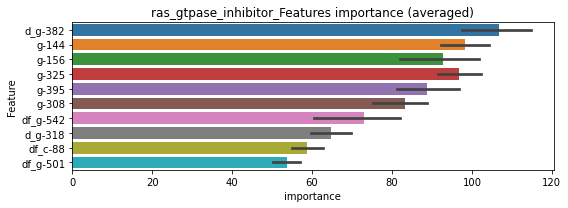

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00978039	valid_1's binary_logloss: 0.0154987
[200]	training's binary_logloss: 0.000947831	valid_1's binary_logloss: 0.00458537
[300]	training's binary_logloss: 0.000260067	valid_1's binary_logloss: 0.0036063
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.000249799	valid_1's binary_logloss: 0.00359952


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100642	valid_1's binary_logloss: 0.0133797
[200]	training's binary_logloss: 0.000993658	valid_1's binary_logloss: 0.0033064
[300]	training's binary_logloss: 0.000277636	valid_1's binary_logloss: 0.00214517
[400]	training's binary_logloss: 0.000153263	valid_1's binary_logloss: 0.00191631
Early stopping, best iteration is:
[427]	training's binary_logloss: 0.000140849	valid_1's binary_logloss: 0.00188765


ras_gtpase_inhibitor logloss: 0.00274358279510995


neg labels: 3289 → selected neg labels: 3278


retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038344	valid_1's binary_logloss: 0.07699
[200]	training's binary_logloss: 0.00624166	valid_1's binary_logloss: 0.0357925
[300]	training's binary_logloss: 0.0018339	valid_1's binary_logloss: 0.0263783
[400]	training's binary_logloss: 0.000890075	valid_1's binary_logloss: 0.0239183
[500]	training's binary_logloss: 0.000574093	valid_1's binary_logloss: 0.0227881
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.000569886	valid_1's binary_logloss: 0.022782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376958	valid_1's binary_logloss: 0.0825106
[200]	training's binary_logloss: 0.0062282	valid_1's binary_logloss: 0.0401105
[300]	training's binary_logloss: 0.00179465	valid_1's binary_logloss: 0.0288061
[400]	training's binary_logloss: 0.000882361	valid_1's binary_logloss: 0.0255095
Early stopping, best iteration is:
[420]	traini

1 / 3 AUC score:0.999
y_Threshold: 0.0060437, Threshold: 0.0150158, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00281
Num_p_label: 80.0, conf_0:0.01351, conf_1:0.01652
Num_p_label: 80.0, Expected: 11.2, Adj_threshold_1: 0.0150158
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_2: 0.0250158
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_3: 0.0350158
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_4: 0.0450158
threshold: 0.0450158, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 653.0/3797, y_label_rate: 0.1719779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378973	valid_1's binary_logloss: 0.069001
[200]	training's binary_logloss: 0.00610095	valid_1's binary_logloss: 0.026246
[300]	training's binary_logloss: 0.00176327	valid_1's binary_logloss: 0.01654
[400]	training's binary_logloss: 0.000840701	valid_1's binary_logloss: 0.0128383
[500]	training's binary_logloss: 0.000552944	valid_1's binary_logloss: 0.0115063
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000552944	valid_1's binary_logloss: 0.0115063
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374928	valid_1's binary_logloss: 0.0681114
[200]	training's binary_logloss: 0.00592105	valid_1's binary_logloss: 0.0233935
[300]	training's binary_logloss: 0.00171598	valid_1's binary_logloss: 0.0131837
[400]	training's binary_logloss: 0.000826062	valid_1's binary_logloss: 0.0103356
[500]	training's binary_logloss: 0.000552494	

2 / 3 AUC score:1.000
y_Threshold: 0.0401420, Threshold: 0.0450158, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3793
p_label_rate: 0.0143144 Vs.target_rate: 0.00281
Num_p_label: 57.0, conf_0:0.04051, conf_1:0.04952
Num_p_label: 57.0, Expected: 11.2, Adj_threshold_1: 0.0450158
Num_p_label: 48.0, Expected: 11.2, Adj_threshold_2: 0.0550158
Num_p_label: 41.0, Expected: 11.2, Adj_threshold_3: 0.0650158
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_4: 0.0750158
Num_p_label: 29.0, Expected: 11.2, Adj_threshold_5: 0.0850158
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_6: 0.0950158
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_7: 0.1050158
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_8: 0.1150158
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_9: 0.1250158
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_10: 0.1350158
threshold: 0.1350158, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 651.0/3793, y_label_rate: 0.1716320

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375713	valid_1's binary_logloss: 0.0703949
[200]	training's binary_logloss: 0.00594268	valid_1's binary_logloss: 0.0280718
[300]	training's binary_logloss: 0.00169555	valid_1's binary_logloss: 0.0202746
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000943442	valid_1's binary_logloss: 0.0174741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036602	valid_1's binary_logloss: 0.064812
[200]	training's binary_logloss: 0.00588918	valid_1's binary_logloss: 0.0208233
[300]	training's binary_logloss: 0.00170026	valid_1's binary_logloss: 0.0115528
[400]	training's binary_logloss: 0.000833774	valid_1's binary_logloss: 0.008832
[500]	training's binary_logloss: 0.000552674	valid_1's binary_logloss: 0.00762761
Early stopping, best iteration is:
[567]	training's binary_logloss: 0.000478387	valid_1's binary_logloss: 0.00711158


3 / 3 AUC score:1.000
y_Threshold: 0.0532427, Threshold: 0.1350158, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 649.0/3789
p_label_rate: 0.0070316 Vs.target_rate: 0.00281
Num_p_label: 28.0, conf_0:0.12151, conf_1:0.14852
threshold: 0.1350158, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 677.0/7771, y_label_rate: 0.0871188


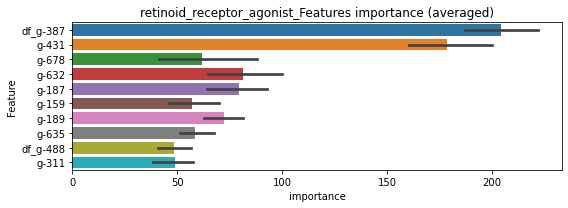

len(train_index) : 3885
len(valid_index) : 3886
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0201167	valid_1's binary_logloss: 0.0537285
[200]	training's binary_logloss: 0.00312879	valid_1's binary_logloss: 0.0323207
[300]	training's binary_logloss: 0.000897464	valid_1's binary_logloss: 0.0280445
[400]	training's binary_logloss: 0.000433143	valid_1's binary_logloss: 0.026389
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.000423648	valid_1's binary_logloss: 0.0263573


len(train_index) : 3886
len(valid_index) : 3885
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211982	valid_1's binary_logloss: 0.0498445
[200]	training's binary_logloss: 0.00321848	valid_1's binary_logloss: 0.0260128
[300]	training's binary_logloss: 0.000968609	valid_1's binary_logloss: 0.0218955
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.000551639	valid_1's binary_logloss: 0.0206326


retinoid_receptor_agonist logloss: 0.023495326489430236


neg labels: 3289 → selected neg labels: 3288


retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153626	valid_1's binary_logloss: 0.0166459
[200]	training's binary_logloss: 0.00123833	valid_1's binary_logloss: 0.00162012
[300]	training's binary_logloss: 0.000329996	valid_1's binary_logloss: 0.000497122
[400]	training's binary_logloss: 0.00020511	valid_1's binary_logloss: 0.000339408
[500]	training's binary_logloss: 0.000180667	valid_1's binary_logloss: 0.000306346
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.000180237	valid_1's binary_logloss: 0.000305805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0153535	valid_1's binary_logloss: 0.0164695
[200]	training's binary_logloss: 0.00122439	valid_1's binary_logloss: 0.00147597
[300]	training's binary_logloss: 0.000327579	valid_1's binary_logloss: 0.000434093
[400]	training's binary_logloss: 0.000203461	valid_1's binary_logloss: 0.000275764
Early stopping, best itera

1 / 3 AUC score:1.000
y_Threshold: 0.0004845, Threshold: 0.0008447, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00076, conf_1:0.00093
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0008447
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0108447
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0208447
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0308447
threshold: 0.0308447, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157778	valid_1's binary_logloss: 0.0189624
[200]	training's binary_logloss: 0.00125691	valid_1's binary_logloss: 0.00402801
[300]	training's binary_logloss: 0.000331999	valid_1's binary_logloss: 0.00254113
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000247613	valid_1's binary_logloss: 0.00230152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159019	valid_1's binary_logloss: 0.0167796
[200]	training's binary_logloss: 0.00126813	valid_1's binary_logloss: 0.00150685
[300]	training's binary_logloss: 0.000333863	valid_1's binary_logloss: 0.000432995
[400]	training's binary_logloss: 0.000206039	valid_1's binary_logloss: 0.000280393
[500]	training's binary_logloss: 0.000180033	valid_1's binary_logloss: 0.000247776
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000178623	valid_1's binary_logloss: 0.00

2 / 3 AUC score:1.000
y_Threshold: 0.0374838, Threshold: 0.0308447, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00025
Num_p_label: 5.0, conf_0:0.02776, conf_1:0.03393
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_1: 0.0308447
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0408447
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.0508447
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_4: 0.0608447
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.0708447
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.0808447
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.0908447
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_8: 0.1008447
threshold: 0.1008447, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157778	valid_1's binary_logloss: 0.0189624
[200]	training's binary_logloss: 0.00125691	valid_1's binary_logloss: 0.00402801
[300]	training's binary_logloss: 0.000331999	valid_1's binary_logloss: 0.00254113
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.000247613	valid_1's binary_logloss: 0.00230152
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159019	valid_1's binary_logloss: 0.0167796
[200]	training's binary_logloss: 0.00126813	valid_1's binary_logloss: 0.00150685
[300]	training's binary_logloss: 0.000333863	valid_1's binary_logloss: 0.000432995
[400]	training's binary_logloss: 0.000206039	valid_1's binary_logloss: 0.000280393
[500]	training's binary_logloss: 0.000180033	valid_1's binary_logloss: 0.000247776
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000178623	valid_1's binary_logloss: 0.00

3 / 3 AUC score:1.000
y_Threshold: 0.0374838, Threshold: 0.1008447, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.09076, conf_1:0.11093
threshold: 0.1008447, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


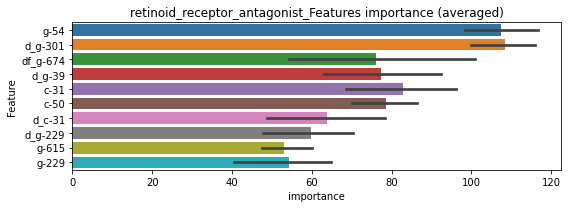

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00840849	valid_1's binary_logloss: 0.00939686
[200]	training's binary_logloss: 0.000663424	valid_1's binary_logloss: 0.00172466
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.000219079	valid_1's binary_logloss: 0.00131077


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00841697	valid_1's binary_logloss: 0.00947046
[200]	training's binary_logloss: 0.000668778	valid_1's binary_logloss: 0.00187082
[300]	training's binary_logloss: 0.000171805	valid_1's binary_logloss: 0.00151803
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.000174135	valid_1's binary_logloss: 0.00151426


retinoid_receptor_antagonist logloss: 0.0014125010266154707


neg labels: 3289 → selected neg labels: 3283


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303875	valid_1's binary_logloss: 0.0482938
[200]	training's binary_logloss: 0.00466853	valid_1's binary_logloss: 0.0118154
[300]	training's binary_logloss: 0.00125544	valid_1's binary_logloss: 0.00455286
[400]	training's binary_logloss: 0.000590666	valid_1's binary_logloss: 0.0027617
[500]	training's binary_logloss: 0.000407972	valid_1's binary_logloss: 0.00218789
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00038388	valid_1's binary_logloss: 0.00211918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309134	valid_1's binary_logloss: 0.0460861
[200]	training's binary_logloss: 0.00425415	valid_1's binary_logloss: 0.0110692
[300]	training's binary_logloss: 0.00121768	valid_1's binary_logloss: 0.00532526
[400]	training's binary_logloss: 0.000608377	valid_1's binary_logloss: 0.00359697
[500]	training's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0027365, Threshold: 0.0051561, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00147
Num_p_label: 80.0, conf_0:0.00464, conf_1:0.00567
Num_p_label: 80.0, Expected: 5.9, Adj_threshold_1: 0.0051561
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_2: 0.0151561
Num_p_label: 9.0, Expected: 5.9, Adj_threshold_3: 0.0251561
threshold: 0.0251561, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294	valid_1's binary_logloss: 0.0449069
[200]	training's binary_logloss: 0.00396503	valid_1's binary_logloss: 0.00945879
[300]	training's binary_logloss: 0.00114336	valid_1's binary_logloss: 0.00384135
[400]	training's binary_logloss: 0.000578626	valid_1's binary_logloss: 0.00239
[500]	training's binary_logloss: 0.000412527	valid_1's binary_logloss: 0.00195316
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000391466	valid_1's binary_logloss: 0.00189102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303553	valid_1's binary_logloss: 0.0432484
[200]	training's binary_logloss: 0.00409542	valid_1's binary_logloss: 0.00917033
[300]	training's binary_logloss: 0.00117888	valid_1's binary_logloss: 0.00369118
[400]	training's binary_logloss: 0.000597007	valid_1's binary_logloss: 0.00233478
[500]	training's binary_logloss: 0.0004

2 / 3 AUC score:1.000
y_Threshold: 0.1496452, Threshold: 0.0251561, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0085384 Vs.target_rate: 0.00147
Num_p_label: 34.0, conf_0:0.02264, conf_1:0.02767
Num_p_label: 34.0, Expected: 5.9, Adj_threshold_1: 0.0251561
Num_p_label: 24.0, Expected: 5.9, Adj_threshold_2: 0.0351561
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_3: 0.0451561
Num_p_label: 14.0, Expected: 5.9, Adj_threshold_4: 0.0551561
Num_p_label: 10.0, Expected: 5.9, Adj_threshold_5: 0.0651561
threshold: 0.0651561, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294	valid_1's binary_logloss: 0.0449069
[200]	training's binary_logloss: 0.00396503	valid_1's binary_logloss: 0.00945879
[300]	training's binary_logloss: 0.00114336	valid_1's binary_logloss: 0.00384135
[400]	training's binary_logloss: 0.000578626	valid_1's binary_logloss: 0.00239
[500]	training's binary_logloss: 0.000412527	valid_1's binary_logloss: 0.00195316
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000391466	valid_1's binary_logloss: 0.00189102
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0303553	valid_1's binary_logloss: 0.0432484
[200]	training's binary_logloss: 0.00409542	valid_1's binary_logloss: 0.00917033
[300]	training's binary_logloss: 0.00117888	valid_1's binary_logloss: 0.00369118
[400]	training's binary_logloss: 0.000597007	valid_1's binary_logloss: 0.00233478
[500]	training's binary_logloss: 0.0004

3 / 3 AUC score:1.000
y_Threshold: 0.1496452, Threshold: 0.0651561, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0025113 Vs.target_rate: 0.00147
Num_p_label: 10.0, conf_0:0.05864, conf_1:0.07167
threshold: 0.0651561, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7789, y_label_rate: 0.0855052


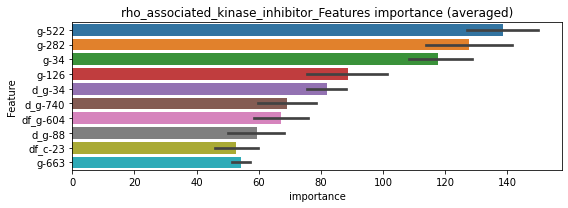

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165295	valid_1's binary_logloss: 0.0318647
[200]	training's binary_logloss: 0.00221751	valid_1's binary_logloss: 0.0117099
[300]	training's binary_logloss: 0.000622484	valid_1's binary_logloss: 0.00877521
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000343673	valid_1's binary_logloss: 0.00843209


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173144	valid_1's binary_logloss: 0.0331424
[200]	training's binary_logloss: 0.00239459	valid_1's binary_logloss: 0.0146171
[300]	training's binary_logloss: 0.000658881	valid_1's binary_logloss: 0.0116128
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.000677307	valid_1's binary_logloss: 0.0115829


rho_associated_kinase_inhibitor logloss: 0.01000728046544752


neg labels: 3289 → selected neg labels: 3282


ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0272428	valid_1's binary_logloss: 0.0481315
[200]	training's binary_logloss: 0.00369813	valid_1's binary_logloss: 0.0188019
[300]	training's binary_logloss: 0.00104584	valid_1's binary_logloss: 0.0133094
[400]	training's binary_logloss: 0.0005283	valid_1's binary_logloss: 0.0120238
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000469563	valid_1's binary_logloss: 0.0118029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286295	valid_1's binary_logloss: 0.0420341
[200]	training's binary_logloss: 0.00389761	valid_1's binary_logloss: 0.0107926
[300]	training's binary_logloss: 0.00109927	valid_1's binary_logloss: 0.00593989
[400]	training's binary_logloss: 0.000552239	valid_1's binary_logloss: 0.00462818
[500]	training's binary_logloss: 0.000397905	valid_1's binary_logloss: 0.00421422
Early stopping, best iteration is:
[502]

1 / 3 AUC score:1.000
y_Threshold: 0.0024227, Threshold: 0.0036665, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00330, conf_1:0.00403
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0036665
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_2: 0.0136665
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.0236665
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_4: 0.0336665
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_5: 0.0436665
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_6: 0.0536665
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_7: 0.0636665
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_8: 0.0736665
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_9: 0.0836665
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_10: 0.0936665
threshold: 0.0936665, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274143	valid_1's binary_logloss: 0.0448688
[200]	training's binary_logloss: 0.00370149	valid_1's binary_logloss: 0.0156024
[300]	training's binary_logloss: 0.00100297	valid_1's binary_logloss: 0.00887676
[400]	training's binary_logloss: 0.000495524	valid_1's binary_logloss: 0.00708505
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000427989	valid_1's binary_logloss: 0.00683761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280595	valid_1's binary_logloss: 0.0425698
[200]	training's binary_logloss: 0.00365651	valid_1's binary_logloss: 0.0107974
[300]	training's binary_logloss: 0.0010367	valid_1's binary_logloss: 0.00570787
[400]	training's binary_logloss: 0.00052221	valid_1's binary_logloss: 0.0042974
[500]	training's binary_logloss: 0.000383208	valid_1's binary_logloss: 0.00392936
Early stopping, best iteration is:
[49

2 / 3 AUC score:1.000
y_Threshold: 0.0311858, Threshold: 0.0936665, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.08430, conf_1:0.10303
threshold: 0.0936665, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274143	valid_1's binary_logloss: 0.0448688
[200]	training's binary_logloss: 0.00370149	valid_1's binary_logloss: 0.0156024
[300]	training's binary_logloss: 0.00100297	valid_1's binary_logloss: 0.00887676
[400]	training's binary_logloss: 0.000495524	valid_1's binary_logloss: 0.00708505
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000427989	valid_1's binary_logloss: 0.00683761
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280595	valid_1's binary_logloss: 0.0425698
[200]	training's binary_logloss: 0.00365651	valid_1's binary_logloss: 0.0107974
[300]	training's binary_logloss: 0.0010367	valid_1's binary_logloss: 0.00570787
[400]	training's binary_logloss: 0.00052221	valid_1's binary_logloss: 0.0042974
[500]	training's binary_logloss: 0.000383208	valid_1's binary_logloss: 0.00392936
Early stopping, best iteration is:
[49

3 / 3 AUC score:1.000
y_Threshold: 0.0311858, Threshold: 0.0936665, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00155
Num_p_label: 15.0, conf_0:0.08430, conf_1:0.10303
threshold: 0.0936665, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 671.0/7788, y_label_rate: 0.0861582


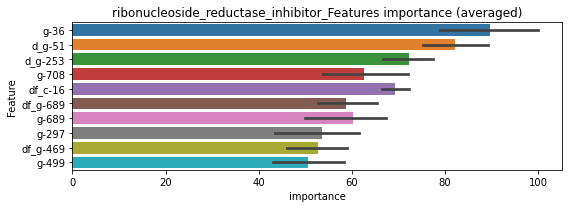

len(train_index) : 3894
len(valid_index) : 3894
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148528	valid_1's binary_logloss: 0.0292346
[200]	training's binary_logloss: 0.00187853	valid_1's binary_logloss: 0.0119448
[300]	training's binary_logloss: 0.000513747	valid_1's binary_logloss: 0.00841961
[400]	training's binary_logloss: 0.000261418	valid_1's binary_logloss: 0.00742746
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000206222	valid_1's binary_logloss: 0.00711944


len(train_index) : 3894
len(valid_index) : 3894
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0145926	valid_1's binary_logloss: 0.0215915
[200]	training's binary_logloss: 0.00186331	valid_1's binary_logloss: 0.00562397
[300]	training's binary_logloss: 0.000522237	valid_1's binary_logloss: 0.00341811
[400]	training's binary_logloss: 0.000264036	valid_1's binary_logloss: 0.00287151
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000223503	valid_1's binary_logloss: 0.00278888


ribonucleoside_reductase_inhibitor logloss: 0.0049541609360316185


neg labels: 3289 → selected neg labels: 3284


rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0273028	valid_1's binary_logloss: 0.0369717
[200]	training's binary_logloss: 0.00340203	valid_1's binary_logloss: 0.00716392
[300]	training's binary_logloss: 0.00097769	valid_1's binary_logloss: 0.00311156
[400]	training's binary_logloss: 0.000502478	valid_1's binary_logloss: 0.00215791
[500]	training's binary_logloss: 0.000380385	valid_1's binary_logloss: 0.00182774
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.000374618	valid_1's binary_logloss: 0.00181027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285731	valid_1's binary_logloss: 0.0389678
[200]	training's binary_logloss: 0.0036358	valid_1's binary_logloss: 0.00732365
[300]	training's binary_logloss: 0.00101505	valid_1's binary_logloss: 0.00292129
[400]	training's binary_logloss: 0.000522049	valid_1's binary_logloss: 0.00191937
[500]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0021989, Threshold: 0.0097453, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00877, conf_1:0.01072
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0097453
Num_p_label: 61.0, Expected: 4.2, Adj_threshold_2: 0.0197453
Num_p_label: 53.0, Expected: 4.2, Adj_threshold_3: 0.0297453
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_4: 0.0397453
Num_p_label: 42.0, Expected: 4.2, Adj_threshold_5: 0.0497453
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_6: 0.0597453
Num_p_label: 35.0, Expected: 4.2, Adj_threshold_7: 0.0697453
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_8: 0.0797453
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_9: 0.0897453
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_10: 0.0997453
threshold: 0.1097453, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267114	valid_1's binary_logloss: 0.0343722
[200]	training's binary_logloss: 0.00332189	valid_1's binary_logloss: 0.00568764
[300]	training's binary_logloss: 0.000942544	valid_1's binary_logloss: 0.00199159
[400]	training's binary_logloss: 0.000487123	valid_1's binary_logloss: 0.00113586
[500]	training's binary_logloss: 0.000372783	valid_1's binary_logloss: 0.000935196
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00036434	valid_1's binary_logloss: 0.000924021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268048	valid_1's binary_logloss: 0.0366509
[200]	training's binary_logloss: 0.00334857	valid_1's binary_logloss: 0.00611005
[300]	training's binary_logloss: 0.000935593	valid_1's binary_logloss: 0.00208909
[400]	training's binary_logloss: 0.000490651	valid_1's binary_logloss: 0.00123305
[500]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1602096, Threshold: 0.1097453, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0150678 Vs.target_rate: 0.00105
Num_p_label: 60.0, conf_0:0.09877, conf_1:0.12072
Num_p_label: 60.0, Expected: 4.2, Adj_threshold_1: 0.1097453
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_2: 0.1197453
Num_p_label: 58.0, Expected: 4.2, Adj_threshold_3: 0.1297453
Num_p_label: 57.0, Expected: 4.2, Adj_threshold_4: 0.1397453
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_5: 0.1497453
Num_p_label: 56.0, Expected: 4.2, Adj_threshold_6: 0.1597453
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_7: 0.1697453
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_8: 0.1797453
Num_p_label: 55.0, Expected: 4.2, Adj_threshold_9: 0.1897453
Num_p_label: 54.0, Expected: 4.2, Adj_threshold_10: 0.1997453
threshold: 0.2097453, positive_p_label: 52.0/3982, p_label_rate: 0.0130588
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267114	valid_1's binary_logloss: 0.0343722
[200]	training's binary_logloss: 0.00332189	valid_1's binary_logloss: 0.00568764
[300]	training's binary_logloss: 0.000942544	valid_1's binary_logloss: 0.00199159
[400]	training's binary_logloss: 0.000487123	valid_1's binary_logloss: 0.00113586
[500]	training's binary_logloss: 0.000372783	valid_1's binary_logloss: 0.000935196
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00036434	valid_1's binary_logloss: 0.000924021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268048	valid_1's binary_logloss: 0.0366509
[200]	training's binary_logloss: 0.00334857	valid_1's binary_logloss: 0.00611005
[300]	training's binary_logloss: 0.000935593	valid_1's binary_logloss: 0.00208909
[400]	training's binary_logloss: 0.000490651	valid_1's binary_logloss: 0.00123305
[500]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1602096, Threshold: 0.2097453, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0130588 Vs.target_rate: 0.00105
Num_p_label: 52.0, conf_0:0.18877, conf_1:0.23072
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_1: 0.2097453
Num_p_label: 52.0, Expected: 4.2, Adj_threshold_2: 0.2197453
Num_p_label: 51.0, Expected: 4.2, Adj_threshold_3: 0.2297453
Num_p_label: 51.0, Expected: 4.2, Adj_threshold_4: 0.2397453
Num_p_label: 51.0, Expected: 4.2, Adj_threshold_5: 0.2497453
Num_p_label: 50.0, Expected: 4.2, Adj_threshold_6: 0.2597453
Num_p_label: 49.0, Expected: 4.2, Adj_threshold_7: 0.2697453
Num_p_label: 48.0, Expected: 4.2, Adj_threshold_8: 0.2797453
Num_p_label: 46.0, Expected: 4.2, Adj_threshold_9: 0.2897453
Num_p_label: 41.0, Expected: 4.2, Adj_threshold_10: 0.2997453
threshold: 0.3097453, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 695.0/7790, y_label_rate: 0.0892169


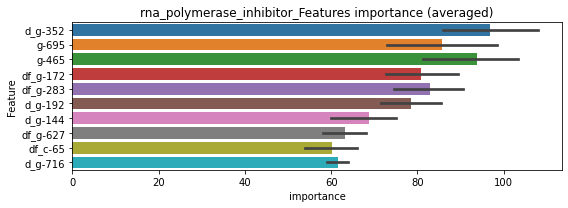

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.016329	valid_1's binary_logloss: 0.0286471
[200]	training's binary_logloss: 0.00223672	valid_1's binary_logloss: 0.0112688
[300]	training's binary_logloss: 0.000624771	valid_1's binary_logloss: 0.00885597
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000441212	valid_1's binary_logloss: 0.00853215


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0180416	valid_1's binary_logloss: 0.0291445
[200]	training's binary_logloss: 0.00249863	valid_1's binary_logloss: 0.0108751
[300]	training's binary_logloss: 0.000664042	valid_1's binary_logloss: 0.00828142
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000458663	valid_1's binary_logloss: 0.00792107


rna_polymerase_inhibitor logloss: 0.00822661095227114


neg labels: 3289 → selected neg labels: 3249


serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103552	valid_1's binary_logloss: 0.282741
[200]	training's binary_logloss: 0.0346782	valid_1's binary_logloss: 0.256628
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0253082	valid_1's binary_logloss: 0.254303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10503	valid_1's binary_logloss: 0.275785
[200]	training's binary_logloss: 0.0353827	valid_1's binary_logloss: 0.245937
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.0296178	valid_1's binary_logloss: 0.245038


1 / 3 AUC score:0.889
y_Threshold: 0.0805488, Threshold: 0.1202814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 441 → Positive_corect_labels: 494/3457
p_label_rate: 0.0200904 Vs.target_rate: 0.00991
Num_p_label: 80.0, conf_0:0.10825, conf_1:0.13231
threshold: 0.1202814, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 494.0/3457, y_label_rate: 0.1428985
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0704323	valid_1's binary_logloss: 0.201043
[200]	training's binary_logloss: 0.0182326	valid_1's binary_logloss: 0.167006
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.0137469	valid_1's binary_logloss: 0.164366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0739063	valid_1's binary_logloss: 0.182189
[200]	training's binary_logloss: 0.0203156	valid_1's binary_logloss: 0.139036
Early stopping, best iteration is:
[287]	training's binary_logloss: 0.00751207	valid_1's binary_logloss: 0.128786


2 / 3 AUC score:0.961
y_Threshold: 0.0720004, Threshold: 0.1202814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 138 → Positive_corect_labels: 425.0/3319
p_label_rate: 0.0133099 Vs.target_rate: 0.00991
Num_p_label: 53.0, conf_0:0.10825, conf_1:0.13231
threshold: 0.1202814, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 425.0/3319, y_label_rate: 0.1280506
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618067	valid_1's binary_logloss: 0.16473
[200]	training's binary_logloss: 0.0144646	valid_1's binary_logloss: 0.125578
[300]	training's binary_logloss: 0.00434821	valid_1's binary_logloss: 0.116066
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00452312	valid_1's binary_logloss: 0.11602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0571037	valid_1's binary_logloss: 0.15551
[200]	training's binary_logloss: 0.0137445	valid_1's binary_logloss: 0.119826
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00718882	valid_1's binary_logloss: 0.114352


3 / 3 AUC score:0.984
y_Threshold: 0.0615603, Threshold: 0.1202814, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 86 → Positive_corect_labels: 382.0/3233
p_label_rate: 0.0097941 Vs.target_rate: 0.00991
Num_p_label: 39.0, conf_0:0.10825, conf_1:0.13231
threshold: 0.1202814, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 421.0/7215, y_label_rate: 0.0583507


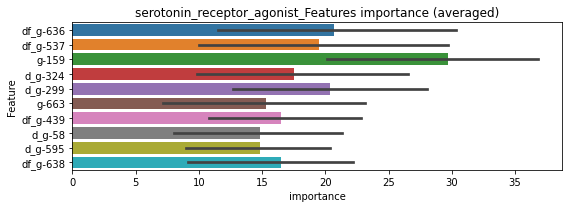

len(train_index) : 3607
len(valid_index) : 3608
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301329	valid_1's binary_logloss: 0.0827225
[200]	training's binary_logloss: 0.00743252	valid_1's binary_logloss: 0.0636896
Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00369327	valid_1's binary_logloss: 0.060968


len(train_index) : 3608
len(valid_index) : 3607
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0318818	valid_1's binary_logloss: 0.0867672
[200]	training's binary_logloss: 0.00741371	valid_1's binary_logloss: 0.0657772
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.00445729	valid_1's binary_logloss: 0.0642548


serotonin_receptor_agonist logloss: 0.0626111632685975


neg labels: 3289 → selected neg labels: 3220


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3220, target_rate: 0.0169648 → Adj_target_rate: 0.0137918
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125192	valid_1's binary_logloss: 0.359467
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.0700103	valid_1's binary_logloss: 0.351447
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130316	valid_1's binary_logloss: 0.34805
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.057746	valid_1's binary_logloss: 0.333473


1 / 3 AUC score:0.806
y_Threshold: 0.1352566, Threshold: 0.1964406, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 651 → Positive_corect_labels: 383/3213
p_label_rate: 0.0200904 Vs.target_rate: 0.01696
Num_p_label: 80.0, conf_0:0.17680, conf_1:0.21608
threshold: 0.1964406, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 383.0/3213, y_label_rate: 0.1192032
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0644654	valid_1's binary_logloss: 0.217913
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.0215236	valid_1's binary_logloss: 0.20044
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690321	valid_1's binary_logloss: 0.207002
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0213236	valid_1's binary_logloss: 0.184543


2 / 3 AUC score:0.941
y_Threshold: 0.1081218, Threshold: 0.1964406, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 206 → Positive_corect_labels: 280.0/3007
p_label_rate: 0.0203415 Vs.target_rate: 0.01696
Num_p_label: 81.0, conf_0:0.17680, conf_1:0.21608
threshold: 0.1964406, positive_p_label: 81.0/3982, p_label_rate: 0.0203415
positive_y_label: 280.0/3007, y_label_rate: 0.0931161
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406949	valid_1's binary_logloss: 0.159582
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0180034	valid_1's binary_logloss: 0.149036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401778	valid_1's binary_logloss: 0.170364
Early stopping, best iteration is:
[157]	training's binary_logloss: 0.0166106	valid_1's binary_logloss: 0.160929


3 / 3 AUC score:0.949
y_Threshold: 0.0773787, Threshold: 0.1964406, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 142 → Positive_corect_labels: 209.0/2865
p_label_rate: 0.0228528 Vs.target_rate: 0.01696
Num_p_label: 91.0, conf_0:0.17680, conf_1:0.21608
threshold: 0.1964406, positive_p_label: 91.0/3982, p_label_rate: 0.0228528
positive_y_label: 300.0/6847, y_label_rate: 0.0438148


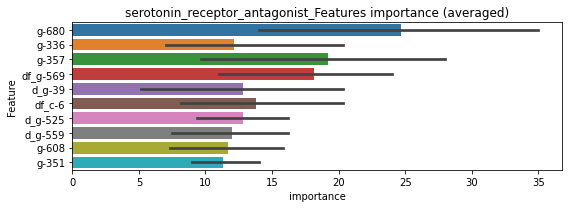

len(train_index) : 3423
len(valid_index) : 3424
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176302	valid_1's binary_logloss: 0.0800438
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.00592771	valid_1's binary_logloss: 0.0729328


len(train_index) : 3424
len(valid_index) : 3423
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193321	valid_1's binary_logloss: 0.0769784
[200]	training's binary_logloss: 0.00429659	valid_1's binary_logloss: 0.0660898
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00367943	valid_1's binary_logloss: 0.0658559


serotonin_receptor_antagonist logloss: 0.06939489191737272


neg labels: 3289 → selected neg labels: 3281


serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3281, target_rate: 0.0018477 → Adj_target_rate: 0.0020948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392978	valid_1's binary_logloss: 0.088393
[200]	training's binary_logloss: 0.0064109	valid_1's binary_logloss: 0.0474863
[300]	training's binary_logloss: 0.00179088	valid_1's binary_logloss: 0.0391888
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00160099	valid_1's binary_logloss: 0.0385138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384901	valid_1's binary_logloss: 0.0733995
[200]	training's binary_logloss: 0.00640569	valid_1's binary_logloss: 0.0395851
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00219926	valid_1's binary_logloss: 0.0343567


1 / 3 AUC score:0.998
y_Threshold: 0.0088226, Threshold: 0.0111899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0200904 Vs.target_rate: 0.00185
Num_p_label: 80.0, conf_0:0.01007, conf_1:0.01231
Num_p_label: 80.0, Expected: 7.4, Adj_threshold_1: 0.0111899
Num_p_label: 22.0, Expected: 7.4, Adj_threshold_2: 0.0211899
Num_p_label: 11.0, Expected: 7.4, Adj_threshold_3: 0.0311899
threshold: 0.0311899, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0390723	valid_1's binary_logloss: 0.0649135
[200]	training's binary_logloss: 0.00632732	valid_1's binary_logloss: 0.0205819
[300]	training's binary_logloss: 0.00180336	valid_1's binary_logloss: 0.0117601
[400]	training's binary_logloss: 0.000850353	valid_1's binary_logloss: 0.00925565
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000625465	valid_1's binary_logloss: 0.00852714
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368384	valid_1's binary_logloss: 0.0811946
[200]	training's binary_logloss: 0.00579668	valid_1's binary_logloss: 0.0431287
[300]	training's binary_logloss: 0.00165529	valid_1's binary_logloss: 0.0364597
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00130217	valid_1's binary_logloss: 0.0361822


2 / 3 AUC score:1.000
y_Threshold: 0.0241558, Threshold: 0.0311899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0025113 Vs.target_rate: 0.00185
Num_p_label: 10.0, conf_0:0.02807, conf_1:0.03431
threshold: 0.0311899, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 646.0/3785, y_label_rate: 0.1706737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383495	valid_1's binary_logloss: 0.0666911
[200]	training's binary_logloss: 0.00615681	valid_1's binary_logloss: 0.0231876
[300]	training's binary_logloss: 0.00172989	valid_1's binary_logloss: 0.0128031
[400]	training's binary_logloss: 0.000828013	valid_1's binary_logloss: 0.0102064
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000582752	valid_1's binary_logloss: 0.00946238
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0379914	valid_1's binary_logloss: 0.0695206
[200]	training's binary_logloss: 0.00602727	valid_1's binary_logloss: 0.0290322
[300]	training's binary_logloss: 0.00171755	valid_1's binary_logloss: 0.0222365
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00113447	valid_1's binary_logloss: 0.0212403


3 / 3 AUC score:1.000
y_Threshold: 0.0278074, Threshold: 0.0311899, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0022602 Vs.target_rate: 0.00185
Num_p_label: 9.0, conf_0:0.02807, conf_1:0.03431
threshold: 0.0311899, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 653.0/7763, y_label_rate: 0.0841170


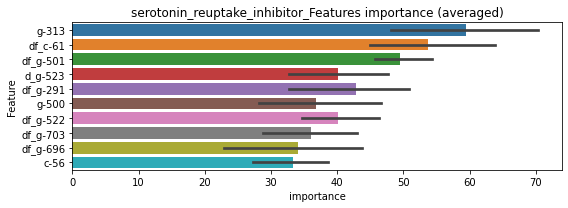

len(train_index) : 3881
len(valid_index) : 3882
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212853	valid_1's binary_logloss: 0.0395682
[200]	training's binary_logloss: 0.00352742	valid_1's binary_logloss: 0.018299
[300]	training's binary_logloss: 0.000998546	valid_1's binary_logloss: 0.0142031
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000666622	valid_1's binary_logloss: 0.0135315


len(train_index) : 3882
len(valid_index) : 3881
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209909	valid_1's binary_logloss: 0.0381867
[200]	training's binary_logloss: 0.00344162	valid_1's binary_logloss: 0.0145939
[300]	training's binary_logloss: 0.000965593	valid_1's binary_logloss: 0.00986412
[400]	training's binary_logloss: 0.000449433	valid_1's binary_logloss: 0.00893634
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.000361417	valid_1's binary_logloss: 0.00874693


serotonin_reuptake_inhibitor logloss: 0.01113952871130484


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374341	valid_1's binary_logloss: 0.0621837
[200]	training's binary_logloss: 0.00592365	valid_1's binary_logloss: 0.019924
[300]	training's binary_logloss: 0.00161356	valid_1's binary_logloss: 0.0106135
[400]	training's binary_logloss: 0.000765479	valid_1's binary_logloss: 0.00778338
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00076115	valid_1's binary_logloss: 0.00776431
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364264	valid_1's binary_logloss: 0.0607012
[200]	training's binary_logloss: 0.00581434	valid_1's binary_logloss: 0.0221483
[300]	training's binary_logloss: 0.00159045	valid_1's binary_logloss: 0.0139038
[400]	training's binary_logloss: 0.000759673	valid_1's binary_logloss: 0.0116861
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000671506	valid_1's binary_logloss: 0.0114465


1 / 3 AUC score:1.000
y_Threshold: 0.0049277, Threshold: 0.0078252, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00704, conf_1:0.00861
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0078252
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_2: 0.0178252
Num_p_label: 6.0, Expected: 6.0, Adj_threshold_3: 0.0278252
threshold: 0.0278252, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372276	valid_1's binary_logloss: 0.0607168
[200]	training's binary_logloss: 0.00568214	valid_1's binary_logloss: 0.0183527
[300]	training's binary_logloss: 0.00157613	valid_1's binary_logloss: 0.00991194
[400]	training's binary_logloss: 0.000763986	valid_1's binary_logloss: 0.00752677
[500]	training's binary_logloss: 0.000510031	valid_1's binary_logloss: 0.00669886
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000517024	valid_1's binary_logloss: 0.00665651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375809	valid_1's binary_logloss: 0.0625611
[200]	training's binary_logloss: 0.00570129	valid_1's binary_logloss: 0.0216655
[300]	training's binary_logloss: 0.00157652	valid_1's binary_logloss: 0.0145951
[400]	training's binary_logloss: 0.000770627	valid_1's binary_logloss: 0.012566
Early stopping, best iteration is:
[45

2 / 3 AUC score:1.000
y_Threshold: 0.0155689, Threshold: 0.0278252, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0045203 Vs.target_rate: 0.00151
Num_p_label: 18.0, conf_0:0.02504, conf_1:0.03061
threshold: 0.0278252, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372276	valid_1's binary_logloss: 0.0607168
[200]	training's binary_logloss: 0.00568214	valid_1's binary_logloss: 0.0183527
[300]	training's binary_logloss: 0.00157613	valid_1's binary_logloss: 0.00991194
[400]	training's binary_logloss: 0.000763986	valid_1's binary_logloss: 0.00752677
[500]	training's binary_logloss: 0.000510031	valid_1's binary_logloss: 0.00669886
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000517024	valid_1's binary_logloss: 0.00665651
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375809	valid_1's binary_logloss: 0.0625611
[200]	training's binary_logloss: 0.00570129	valid_1's binary_logloss: 0.0216655
[300]	training's binary_logloss: 0.00157652	valid_1's binary_logloss: 0.0145951
[400]	training's binary_logloss: 0.000770627	valid_1's binary_logloss: 0.012566
Early stopping, best iteration is:
[45

3 / 3 AUC score:1.000
y_Threshold: 0.0155689, Threshold: 0.0278252, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3807
p_label_rate: 0.0045203 Vs.target_rate: 0.00151
Num_p_label: 18.0, conf_0:0.02504, conf_1:0.03061
threshold: 0.0278252, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7789, y_label_rate: 0.0865323


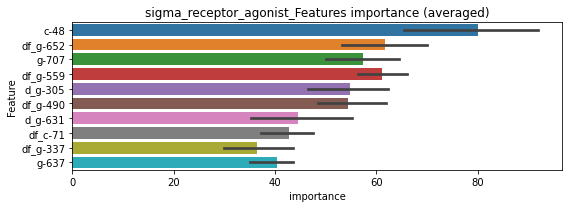

len(train_index) : 3894
len(valid_index) : 3895
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0213768	valid_1's binary_logloss: 0.0380115
[200]	training's binary_logloss: 0.00338736	valid_1's binary_logloss: 0.0177683
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00117476	valid_1's binary_logloss: 0.0159007


len(train_index) : 3895
len(valid_index) : 3894
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221836	valid_1's binary_logloss: 0.0365889
[200]	training's binary_logloss: 0.00350381	valid_1's binary_logloss: 0.0138128
[300]	training's binary_logloss: 0.000966859	valid_1's binary_logloss: 0.0101505
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.000853622	valid_1's binary_logloss: 0.0100646


sigma_receptor_agonist logloss: 0.012983004543588013


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_antagonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0352396	valid_1's binary_logloss: 0.0588401
[200]	training's binary_logloss: 0.0054566	valid_1's binary_logloss: 0.0189989
[300]	training's binary_logloss: 0.00156172	valid_1's binary_logloss: 0.0110632
[400]	training's binary_logloss: 0.000753115	valid_1's binary_logloss: 0.00796369
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000731402	valid_1's binary_logloss: 0.00789468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0359443	valid_1's binary_logloss: 0.065646
[200]	training's binary_logloss: 0.00559591	valid_1's binary_logloss: 0.0265011
[300]	training's binary_logloss: 0.00156953	valid_1's binary_logloss: 0.0176233
[400]	training's binary_logloss: 0.000759805	valid_1's binary_logloss: 0.0154948
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000685758	valid_1's binary_logloss: 0.0153102


1 / 3 AUC score:1.000
y_Threshold: 0.0046385, Threshold: 0.0063538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00572, conf_1:0.00699
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0063538
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_2: 0.0163538
Num_p_label: 10.0, Expected: 6.0, Adj_threshold_3: 0.0263538
threshold: 0.0263538, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348865	valid_1's binary_logloss: 0.0587551
[200]	training's binary_logloss: 0.00526916	valid_1's binary_logloss: 0.019702
[300]	training's binary_logloss: 0.00151383	valid_1's binary_logloss: 0.012125
[400]	training's binary_logloss: 0.000746767	valid_1's binary_logloss: 0.00935965
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000710499	valid_1's binary_logloss: 0.00911585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356952	valid_1's binary_logloss: 0.0660035
[200]	training's binary_logloss: 0.00543089	valid_1's binary_logloss: 0.0284196
[300]	training's binary_logloss: 0.00150743	valid_1's binary_logloss: 0.0209536
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00114505	valid_1's binary_logloss: 0.0199125


2 / 3 AUC score:1.000
y_Threshold: 0.0271844, Threshold: 0.0263538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0070316 Vs.target_rate: 0.00151
Num_p_label: 28.0, conf_0:0.02372, conf_1:0.02899
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_1: 0.0263538
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_2: 0.0363538
Num_p_label: 8.0, Expected: 6.0, Adj_threshold_3: 0.0463538
threshold: 0.0463538, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354287	valid_1's binary_logloss: 0.0514726
[200]	training's binary_logloss: 0.00534623	valid_1's binary_logloss: 0.0114923
[300]	training's binary_logloss: 0.00152001	valid_1's binary_logloss: 0.00446426
[400]	training's binary_logloss: 0.000743751	valid_1's binary_logloss: 0.00268924
[500]	training's binary_logloss: 0.000499919	valid_1's binary_logloss: 0.002056
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000448827	valid_1's binary_logloss: 0.00193766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035137	valid_1's binary_logloss: 0.0608881
[200]	training's binary_logloss: 0.00531645	valid_1's binary_logloss: 0.0199697
[300]	training's binary_logloss: 0.00151263	valid_1's binary_logloss: 0.0123371
[400]	training's binary_logloss: 0.000739685	valid_1's binary_logloss: 0.0097276
Early stopping, best iteration is:
[463]

3 / 3 AUC score:1.000
y_Threshold: 0.0417320, Threshold: 0.0463538, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0022602 Vs.target_rate: 0.00151
Num_p_label: 9.0, conf_0:0.04172, conf_1:0.05099
threshold: 0.0463538, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 662.0/7783, y_label_rate: 0.0850572


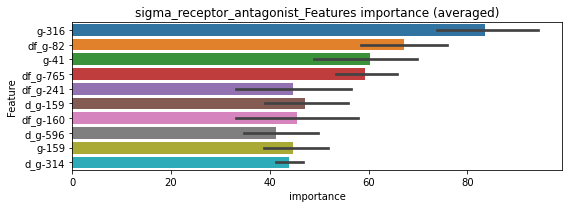

len(train_index) : 3891
len(valid_index) : 3892
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199203	valid_1's binary_logloss: 0.0424515
[200]	training's binary_logloss: 0.00298569	valid_1's binary_logloss: 0.0206888
[300]	training's binary_logloss: 0.000790205	valid_1's binary_logloss: 0.0163556
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.000589256	valid_1's binary_logloss: 0.0160038


len(train_index) : 3892
len(valid_index) : 3891
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0200834	valid_1's binary_logloss: 0.0340253
[200]	training's binary_logloss: 0.0030997	valid_1's binary_logloss: 0.0120891
[300]	training's binary_logloss: 0.000834664	valid_1's binary_logloss: 0.0074461
[400]	training's binary_logloss: 0.000396529	valid_1's binary_logloss: 0.00637879
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000341052	valid_1's binary_logloss: 0.00629378


sigma_receptor_antagonist logloss: 0.011149432360214807


neg labels: 3289 → selected neg labels: 3284


smoothened_receptor_antagonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0296655	valid_1's binary_logloss: 0.0450381
[200]	training's binary_logloss: 0.0040963	valid_1's binary_logloss: 0.0118754
[300]	training's binary_logloss: 0.00111369	valid_1's binary_logloss: 0.00602856
[400]	training's binary_logloss: 0.000542109	valid_1's binary_logloss: 0.00420844
[500]	training's binary_logloss: 0.000392871	valid_1's binary_logloss: 0.00383327
Early stopping, best iteration is:
[506]	training's binary_logloss: 0.000390405	valid_1's binary_logloss: 0.0038216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288842	valid_1's binary_logloss: 0.0443817
[200]	training's binary_logloss: 0.0039429	valid_1's binary_logloss: 0.0110281
[300]	training's binary_logloss: 0.00110343	valid_1's binary_logloss: 0.00497425
[400]	training's binary_logloss: 0.000556247	valid_1's binary_logloss: 0.00331947
Early stopping, best iteration is:
[45

1 / 3 AUC score:1.000
y_Threshold: 0.0021652, Threshold: 0.0039434, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00355, conf_1:0.00434
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0039434
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_2: 0.0139434
Num_p_label: 5.0, Expected: 4.2, Adj_threshold_3: 0.0239434
threshold: 0.0239434, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292032	valid_1's binary_logloss: 0.0457355
[200]	training's binary_logloss: 0.00386906	valid_1's binary_logloss: 0.0120557
[300]	training's binary_logloss: 0.00108048	valid_1's binary_logloss: 0.00620105
[400]	training's binary_logloss: 0.000544461	valid_1's binary_logloss: 0.0046101
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000410571	valid_1's binary_logloss: 0.00419933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02852	valid_1's binary_logloss: 0.0444676
[200]	training's binary_logloss: 0.00381775	valid_1's binary_logloss: 0.0102479
[300]	training's binary_logloss: 0.00108154	valid_1's binary_logloss: 0.0046849
[400]	training's binary_logloss: 0.000545103	valid_1's binary_logloss: 0.0031619
[500]	training's binary_logloss: 0.000396896	valid_1's binary_logloss: 0.00274085
Early stopping, best iteration is:
[521]

2 / 3 AUC score:1.000
y_Threshold: 0.0177179, Threshold: 0.0239434, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00105
Num_p_label: 9.0, conf_0:0.02155, conf_1:0.02634
threshold: 0.0239434, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0292032	valid_1's binary_logloss: 0.0457355
[200]	training's binary_logloss: 0.00386906	valid_1's binary_logloss: 0.0120557
[300]	training's binary_logloss: 0.00108048	valid_1's binary_logloss: 0.00620105
[400]	training's binary_logloss: 0.000544461	valid_1's binary_logloss: 0.0046101
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.000410571	valid_1's binary_logloss: 0.00419933
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02852	valid_1's binary_logloss: 0.0444676
[200]	training's binary_logloss: 0.00381775	valid_1's binary_logloss: 0.0102479
[300]	training's binary_logloss: 0.00108154	valid_1's binary_logloss: 0.0046849
[400]	training's binary_logloss: 0.000545103	valid_1's binary_logloss: 0.0031619
[500]	training's binary_logloss: 0.000396896	valid_1's binary_logloss: 0.00274085
Early stopping, best iteration is:
[521]

3 / 3 AUC score:1.000
y_Threshold: 0.0177179, Threshold: 0.0239434, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0022602 Vs.target_rate: 0.00105
Num_p_label: 9.0, conf_0:0.02155, conf_1:0.02634
threshold: 0.0239434, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 665.0/7790, y_label_rate: 0.0853659


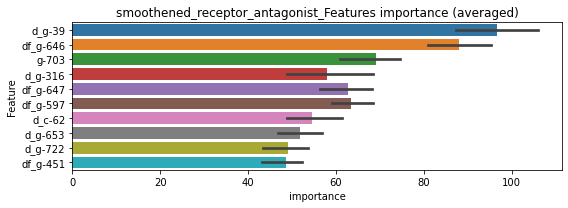

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01605	valid_1's binary_logloss: 0.0281236
[200]	training's binary_logloss: 0.00208907	valid_1's binary_logloss: 0.0107614
[300]	training's binary_logloss: 0.000573637	valid_1's binary_logloss: 0.00834015
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000536551	valid_1's binary_logloss: 0.00827093


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161871	valid_1's binary_logloss: 0.0297901
[200]	training's binary_logloss: 0.00217466	valid_1's binary_logloss: 0.0101859
[300]	training's binary_logloss: 0.000600127	valid_1's binary_logloss: 0.00694716
[400]	training's binary_logloss: 0.000293822	valid_1's binary_logloss: 0.00625914
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000278711	valid_1's binary_logloss: 0.00619848


smoothened_receptor_antagonist logloss: 0.007234705188652001


neg labels: 3289 → selected neg labels: 3244


sodium_channel_inhibitor, len(trt): 267, len(othr): 3244, target_rate: 0.0112119 → Adj_target_rate: 0.0096991
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10953	valid_1's binary_logloss: 0.301621
[200]	training's binary_logloss: 0.0386832	valid_1's binary_logloss: 0.274744
Early stopping, best iteration is:
[208]	training's binary_logloss: 0.0358811	valid_1's binary_logloss: 0.274011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115494	valid_1's binary_logloss: 0.284915
[200]	training's binary_logloss: 0.0413622	valid_1's binary_logloss: 0.244995
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0342667	valid_1's binary_logloss: 0.241291


1 / 3 AUC score:0.881
y_Threshold: 0.0964501, Threshold: 0.1338183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 451 → Positive_corect_labels: 488/3441
p_label_rate: 0.0200904 Vs.target_rate: 0.01121
Num_p_label: 80.0, conf_0:0.12044, conf_1:0.14720
threshold: 0.1338183, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 488.0/3441, y_label_rate: 0.1418192
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076165	valid_1's binary_logloss: 0.218284
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.0272086	valid_1's binary_logloss: 0.192104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0755005	valid_1's binary_logloss: 0.223366
[200]	training's binary_logloss: 0.0210485	valid_1's binary_logloss: 0.191559
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.0199723	valid_1's binary_logloss: 0.190534


2 / 3 AUC score:0.939
y_Threshold: 0.0869067, Threshold: 0.1338183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 204 → Positive_corect_labels: 386.0/3237
p_label_rate: 0.0158212 Vs.target_rate: 0.01121
Num_p_label: 63.0, conf_0:0.12044, conf_1:0.14720
threshold: 0.1338183, positive_p_label: 63.0/3982, p_label_rate: 0.0158212
positive_y_label: 386.0/3237, y_label_rate: 0.1192462
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0531035	valid_1's binary_logloss: 0.169711
[200]	training's binary_logloss: 0.0120326	valid_1's binary_logloss: 0.143561
Early stopping, best iteration is:
[206]	training's binary_logloss: 0.011072	valid_1's binary_logloss: 0.142474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583553	valid_1's binary_logloss: 0.146792
[200]	training's binary_logloss: 0.0151273	valid_1's binary_logloss: 0.10817
[300]	training's binary_logloss: 0.00500285	valid_1's binary_logloss: 0.100336
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.00446186	valid_1's binary_logloss: 0.0994601


3 / 3 AUC score:0.976
y_Threshold: 0.0647516, Threshold: 0.1338183, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 96 → Positive_corect_labels: 338.0/3141
p_label_rate: 0.0102963 Vs.target_rate: 0.01121
Num_p_label: 41.0, conf_0:0.12044, conf_1:0.14720
threshold: 0.1338183, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 379.0/7123, y_label_rate: 0.0532079


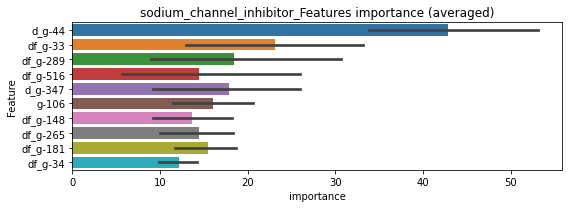

len(train_index) : 3561
len(valid_index) : 3562
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245233	valid_1's binary_logloss: 0.0864318
[200]	training's binary_logloss: 0.00604423	valid_1's binary_logloss: 0.0698306
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00301188	valid_1's binary_logloss: 0.0667002


len(train_index) : 3562
len(valid_index) : 3561
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266281	valid_1's binary_logloss: 0.0812034
[200]	training's binary_logloss: 0.00655517	valid_1's binary_logloss: 0.0676549
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00700091	valid_1's binary_logloss: 0.0674774


sodium_channel_inhibitor logloss: 0.06708875355434862


neg labels: 3289 → selected neg labels: 3283


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3283, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0322449	valid_1's binary_logloss: 0.0534094
[200]	training's binary_logloss: 0.00460014	valid_1's binary_logloss: 0.0151772
[300]	training's binary_logloss: 0.00130238	valid_1's binary_logloss: 0.00841536
[400]	training's binary_logloss: 0.000647977	valid_1's binary_logloss: 0.0063548
[500]	training's binary_logloss: 0.000449579	valid_1's binary_logloss: 0.00568464
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000450752	valid_1's binary_logloss: 0.00567885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032191	valid_1's binary_logloss: 0.0553262
[200]	training's binary_logloss: 0.00474925	valid_1's binary_logloss: 0.0209683
[300]	training's binary_logloss: 0.00131768	valid_1's binary_logloss: 0.0156555
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.000775377	valid_1's binary_logloss: 0.0145146


1 / 3 AUC score:1.000
y_Threshold: 0.0041784, Threshold: 0.0080484, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00134
Num_p_label: 80.0, conf_0:0.00724, conf_1:0.00885
Num_p_label: 80.0, Expected: 5.4, Adj_threshold_1: 0.0080484
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_2: 0.0180484
Num_p_label: 4.0, Expected: 5.4, Adj_threshold_3: 0.0280484
threshold: 0.0280484, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313587	valid_1's binary_logloss: 0.0525367
[200]	training's binary_logloss: 0.00437474	valid_1's binary_logloss: 0.0145022
[300]	training's binary_logloss: 0.00126357	valid_1's binary_logloss: 0.00808537
[400]	training's binary_logloss: 0.000635735	valid_1's binary_logloss: 0.00663371
[500]	training's binary_logloss: 0.00044425	valid_1's binary_logloss: 0.00581384
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.000424849	valid_1's binary_logloss: 0.00571186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323204	valid_1's binary_logloss: 0.0567324
[200]	training's binary_logloss: 0.00459055	valid_1's binary_logloss: 0.0209046
[300]	training's binary_logloss: 0.00130904	valid_1's binary_logloss: 0.0156363
[400]	training's binary_logloss: 0.000641897	valid_1's binary_logloss: 0.0141243
Early stopping, best iteration is:
[41

2 / 3 AUC score:1.000
y_Threshold: 0.0182403, Threshold: 0.0280484, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0057760 Vs.target_rate: 0.00134
Num_p_label: 23.0, conf_0:0.02524, conf_1:0.03085
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_1: 0.0280484
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_2: 0.0380484
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_3: 0.0480484
Num_p_label: 8.0, Expected: 5.4, Adj_threshold_4: 0.0580484
threshold: 0.0580484, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319929	valid_1's binary_logloss: 0.0620075
[200]	training's binary_logloss: 0.00450718	valid_1's binary_logloss: 0.0241335
[300]	training's binary_logloss: 0.00128159	valid_1's binary_logloss: 0.0184309
[400]	training's binary_logloss: 0.000633093	valid_1's binary_logloss: 0.0166738
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000665627	valid_1's binary_logloss: 0.0165715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323035	valid_1's binary_logloss: 0.0559723
[200]	training's binary_logloss: 0.00446713	valid_1's binary_logloss: 0.0179525
[300]	training's binary_logloss: 0.00125523	valid_1's binary_logloss: 0.0111104
[400]	training's binary_logloss: 0.000617973	valid_1's binary_logloss: 0.00907688
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000579644	valid_1's binary_logloss: 0.00904073


3 / 3 AUC score:1.000
y_Threshold: 0.0215886, Threshold: 0.0580484, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0017579 Vs.target_rate: 0.00134
Num_p_label: 7.0, conf_0:0.05224, conf_1:0.06385
threshold: 0.0580484, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 659.0/7781, y_label_rate: 0.0846935


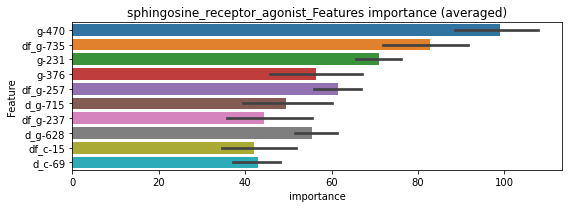

len(train_index) : 3890
len(valid_index) : 3891
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175462	valid_1's binary_logloss: 0.0299296
[200]	training's binary_logloss: 0.00247943	valid_1's binary_logloss: 0.0110875
[300]	training's binary_logloss: 0.000694059	valid_1's binary_logloss: 0.00853205
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000415894	valid_1's binary_logloss: 0.00819178


len(train_index) : 3891
len(valid_index) : 3890
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0186522	valid_1's binary_logloss: 0.036485
[200]	training's binary_logloss: 0.00258724	valid_1's binary_logloss: 0.0150372
[300]	training's binary_logloss: 0.000701768	valid_1's binary_logloss: 0.0111234
[400]	training's binary_logloss: 0.000342011	valid_1's binary_logloss: 0.00987737
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000359638	valid_1's binary_logloss: 0.00987057


sphingosine_receptor_agonist logloss: 0.009031064984398469


neg labels: 3289 → selected neg labels: 3277


src_inhibitor, len(trt): 71, len(othr): 3277, target_rate: 0.0029814 → Adj_target_rate: 0.0031461
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434004	valid_1's binary_logloss: 0.0960206
[200]	training's binary_logloss: 0.00834402	valid_1's binary_logloss: 0.0462368
[300]	training's binary_logloss: 0.00235068	valid_1's binary_logloss: 0.0333061
[400]	training's binary_logloss: 0.00108186	valid_1's binary_logloss: 0.029612
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000838673	valid_1's binary_logloss: 0.028116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437188	valid_1's binary_logloss: 0.0912079
[200]	training's binary_logloss: 0.00794862	valid_1's binary_logloss: 0.0437136
[300]	training's binary_logloss: 0.0023789	valid_1's binary_logloss: 0.0310606
[400]	training's binary_logloss: 0.00112417	valid_1's binary_logloss: 0.0271021
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00112417	valid_1's binary_logloss: 0.0271021


1 / 3 AUC score:0.999
y_Threshold: 0.0118143, Threshold: 0.0332927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 651/3792
p_label_rate: 0.0200904 Vs.target_rate: 0.00298
Num_p_label: 80.0, conf_0:0.02996, conf_1:0.03662
Num_p_label: 80.0, Expected: 11.9, Adj_threshold_1: 0.0332927
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_2: 0.0432927
Num_p_label: 46.0, Expected: 11.9, Adj_threshold_3: 0.0532927
Num_p_label: 40.0, Expected: 11.9, Adj_threshold_4: 0.0632927
Num_p_label: 38.0, Expected: 11.9, Adj_threshold_5: 0.0732927
Num_p_label: 34.0, Expected: 11.9, Adj_threshold_6: 0.0832927
Num_p_label: 25.0, Expected: 11.9, Adj_threshold_7: 0.0932927
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_8: 0.1032927
Num_p_label: 21.0, Expected: 11.9, Adj_threshold_9: 0.1132927
threshold: 0.1132927, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 651.0/3792, y_label_rate: 0.1716772
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409773	valid_1's binary_logloss: 0.0810141
[200]	training's binary_logloss: 0.00700751	valid_1's binary_logloss: 0.0341372
[300]	training's binary_logloss: 0.00209397	valid_1's binary_logloss: 0.0235345
[400]	training's binary_logloss: 0.00101399	valid_1's binary_logloss: 0.0205788
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000797702	valid_1's binary_logloss: 0.0197295
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401041	valid_1's binary_logloss: 0.0874042
[200]	training's binary_logloss: 0.00688205	valid_1's binary_logloss: 0.0468928
[300]	training's binary_logloss: 0.00200717	valid_1's binary_logloss: 0.0365748
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00174785	valid_1's binary_logloss: 0.0352537


2 / 3 AUC score:1.000
y_Threshold: 0.0773661, Threshold: 0.1132927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 24 → Positive_corect_labels: 639.0/3768
p_label_rate: 0.0195881 Vs.target_rate: 0.00298
Num_p_label: 78.0, conf_0:0.10196, conf_1:0.12462
Num_p_label: 78.0, Expected: 11.9, Adj_threshold_1: 0.1132927
Num_p_label: 74.0, Expected: 11.9, Adj_threshold_2: 0.1232927
Num_p_label: 69.0, Expected: 11.9, Adj_threshold_3: 0.1332927
Num_p_label: 66.0, Expected: 11.9, Adj_threshold_4: 0.1432927
Num_p_label: 65.0, Expected: 11.9, Adj_threshold_5: 0.1532927
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_6: 0.1632927
Num_p_label: 56.0, Expected: 11.9, Adj_threshold_7: 0.1732927
Num_p_label: 55.0, Expected: 11.9, Adj_threshold_8: 0.1832927
Num_p_label: 54.0, Expected: 11.9, Adj_threshold_9: 0.1932927
Num_p_label: 49.0, Expected: 11.9, Adj_threshold_10: 0.2032927
threshold: 0.2132927, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 639.0/3768, y_label_rate: 0.169586

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384571	valid_1's binary_logloss: 0.080938
[200]	training's binary_logloss: 0.00636857	valid_1's binary_logloss: 0.0389402
[300]	training's binary_logloss: 0.00192262	valid_1's binary_logloss: 0.0312441
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00124088	valid_1's binary_logloss: 0.0302731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040643	valid_1's binary_logloss: 0.0818283
[200]	training's binary_logloss: 0.00655003	valid_1's binary_logloss: 0.0395915
[300]	training's binary_logloss: 0.00193187	valid_1's binary_logloss: 0.0296976
[400]	training's binary_logloss: 0.000940223	valid_1's binary_logloss: 0.0259349
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000789779	valid_1's binary_logloss: 0.0253493


3 / 3 AUC score:0.998
y_Threshold: 0.0618559, Threshold: 0.2132927, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 22 → Positive_corect_labels: 628.0/3746
p_label_rate: 0.0153189 Vs.target_rate: 0.00298
Num_p_label: 61.0, conf_0:0.19196, conf_1:0.23462
Num_p_label: 61.0, Expected: 11.9, Adj_threshold_1: 0.2132927
Num_p_label: 55.0, Expected: 11.9, Adj_threshold_2: 0.2232927
Num_p_label: 52.0, Expected: 11.9, Adj_threshold_3: 0.2332927
Num_p_label: 50.0, Expected: 11.9, Adj_threshold_4: 0.2432927
Num_p_label: 46.0, Expected: 11.9, Adj_threshold_5: 0.2532927
Num_p_label: 43.0, Expected: 11.9, Adj_threshold_6: 0.2632927
Num_p_label: 42.0, Expected: 11.9, Adj_threshold_7: 0.2732927
Num_p_label: 41.0, Expected: 11.9, Adj_threshold_8: 0.2832927
Num_p_label: 39.0, Expected: 11.9, Adj_threshold_9: 0.2932927
Num_p_label: 39.0, Expected: 11.9, Adj_threshold_10: 0.3032927
threshold: 0.3132927, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 665.0/7728, y_label_rate: 0.086050

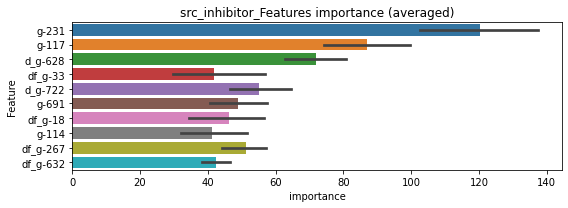

len(train_index) : 3864
len(valid_index) : 3864
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020875	valid_1's binary_logloss: 0.0599106
[200]	training's binary_logloss: 0.00356059	valid_1's binary_logloss: 0.0387935
[300]	training's binary_logloss: 0.00106734	valid_1's binary_logloss: 0.0340155
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000691045	valid_1's binary_logloss: 0.0330186


len(train_index) : 3864
len(valid_index) : 3864
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212438	valid_1's binary_logloss: 0.0507622
[200]	training's binary_logloss: 0.00349908	valid_1's binary_logloss: 0.0282815
[300]	training's binary_logloss: 0.00107235	valid_1's binary_logloss: 0.0239294
[400]	training's binary_logloss: 0.00053313	valid_1's binary_logloss: 0.0220969
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.000478349	valid_1's binary_logloss: 0.0219471


src_inhibitor logloss: 0.02748283333060552


neg labels: 3289 → selected neg labels: 3276


steroid, len(trt): 79, len(othr): 3276, target_rate: 0.0033174 → Adj_target_rate: 0.0034449
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542883	valid_1's binary_logloss: 0.118441
[200]	training's binary_logloss: 0.0114189	valid_1's binary_logloss: 0.0706872
[300]	training's binary_logloss: 0.00332732	valid_1's binary_logloss: 0.0588176
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0026502	valid_1's binary_logloss: 0.0582814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559407	valid_1's binary_logloss: 0.116707
[200]	training's binary_logloss: 0.011961	valid_1's binary_logloss: 0.0677343
[300]	training's binary_logloss: 0.00340892	valid_1's binary_logloss: 0.054573
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00167226	valid_1's binary_logloss: 0.0515232


1 / 3 AUC score:0.994
y_Threshold: 0.0194760, Threshold: 0.0296548, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 160 → Positive_corect_labels: 641/3771
p_label_rate: 0.0200904 Vs.target_rate: 0.00332
Num_p_label: 80.0, conf_0:0.02669, conf_1:0.03262
Num_p_label: 80.0, Expected: 13.2, Adj_threshold_1: 0.0296548
Num_p_label: 54.0, Expected: 13.2, Adj_threshold_2: 0.0396548
Num_p_label: 35.0, Expected: 13.2, Adj_threshold_3: 0.0496548
Num_p_label: 20.0, Expected: 13.2, Adj_threshold_4: 0.0596548
threshold: 0.0596548, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 641.0/3771, y_label_rate: 0.1699814
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0495339	valid_1's binary_logloss: 0.108387
[200]	training's binary_logloss: 0.0098733	valid_1's binary_logloss: 0.0602731
[300]	training's binary_logloss: 0.00288993	valid_1's binary_logloss: 0.0481297
[400]	training's binary_logloss: 0.00131972	valid_1's binary_logloss: 0.0444287
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00131972	valid_1's binary_logloss: 0.0444287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521638	valid_1's binary_logloss: 0.106601
[200]	training's binary_logloss: 0.0107014	valid_1's binary_logloss: 0.0582206
[300]	training's binary_logloss: 0.00313383	valid_1's binary_logloss: 0.0457137
Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00168775	valid_1's binary_logloss: 0.0421017


2 / 3 AUC score:0.999
y_Threshold: 0.0554589, Threshold: 0.0596548, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 26 → Positive_corect_labels: 628.0/3745
p_label_rate: 0.0145655 Vs.target_rate: 0.00332
Num_p_label: 58.0, conf_0:0.05369, conf_1:0.06562
Num_p_label: 58.0, Expected: 13.2, Adj_threshold_1: 0.0596548
Num_p_label: 49.0, Expected: 13.2, Adj_threshold_2: 0.0696548
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_3: 0.0796548
Num_p_label: 27.0, Expected: 13.2, Adj_threshold_4: 0.0896548
Num_p_label: 21.0, Expected: 13.2, Adj_threshold_5: 0.0996548
threshold: 0.0996548, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 628.0/3745, y_label_rate: 0.1676903
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484364	valid_1's binary_logloss: 0.0996823
[200]	training's binary_logloss: 0.00954199	valid_1's binary_logloss: 0.0539232
[300]	training's binary_logloss: 0.0028158	valid_1's binary_logloss: 0.041986
[400]	training's binary_logloss: 0.00127638	valid_1's binary_logloss: 0.0383706
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00124772	valid_1's binary_logloss: 0.038364
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0494294	valid_1's binary_logloss: 0.095098
[200]	training's binary_logloss: 0.00985394	valid_1's binary_logloss: 0.0446305
[300]	training's binary_logloss: 0.00284114	valid_1's binary_logloss: 0.0298491
[400]	training's binary_logloss: 0.00130793	valid_1's binary_logloss: 0.026429
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000985696	valid_1's binary_logloss: 0.0254173


3 / 3 AUC score:0.999
y_Threshold: 0.0458186, Threshold: 0.0996548, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 18 → Positive_corect_labels: 619.0/3727
p_label_rate: 0.0055249 Vs.target_rate: 0.00332
Num_p_label: 22.0, conf_0:0.08969, conf_1:0.10962
threshold: 0.0996548, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 641.0/7709, y_label_rate: 0.0831496


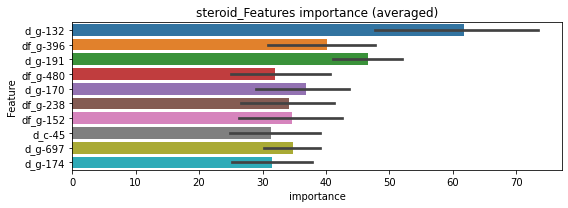

len(train_index) : 3854
len(valid_index) : 3855
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274672	valid_1's binary_logloss: 0.0612178
[200]	training's binary_logloss: 0.00551262	valid_1's binary_logloss: 0.0358454
[300]	training's binary_logloss: 0.00145999	valid_1's binary_logloss: 0.0299458
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00100568	valid_1's binary_logloss: 0.0290804


len(train_index) : 3855
len(valid_index) : 3854
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268511	valid_1's binary_logloss: 0.0669904
[200]	training's binary_logloss: 0.00536443	valid_1's binary_logloss: 0.0426524
[300]	training's binary_logloss: 0.00153127	valid_1's binary_logloss: 0.0361714
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00130364	valid_1's binary_logloss: 0.0358006


steroid logloss: 0.032440071175913056


neg labels: 3289 → selected neg labels: 3286


syk_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208623	valid_1's binary_logloss: 0.032532
[200]	training's binary_logloss: 0.00228433	valid_1's binary_logloss: 0.0089689
[300]	training's binary_logloss: 0.00065533	valid_1's binary_logloss: 0.00566586
[400]	training's binary_logloss: 0.000361077	valid_1's binary_logloss: 0.00482084
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00031115	valid_1's binary_logloss: 0.00462866
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212541	valid_1's binary_logloss: 0.024606
[200]	training's binary_logloss: 0.00236131	valid_1's binary_logloss: 0.00365852
[300]	training's binary_logloss: 0.000677663	valid_1's binary_logloss: 0.00158027
[400]	training's binary_logloss: 0.000365551	valid_1's binary_logloss: 0.00118168
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000305383	valid_1's binary_logloss: 0.0010925


1 / 3 AUC score:1.000
y_Threshold: 0.0018021, Threshold: 0.0032711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00294, conf_1:0.00360
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0032711
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.0132711
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.0232711
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.0332711
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.0432711
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.0532711
threshold: 0.0532711, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204293	valid_1's binary_logloss: 0.0315647
[200]	training's binary_logloss: 0.00217174	valid_1's binary_logloss: 0.0101177
[300]	training's binary_logloss: 0.00061882	valid_1's binary_logloss: 0.00704299
[400]	training's binary_logloss: 0.000345383	valid_1's binary_logloss: 0.00611097
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000334989	valid_1's binary_logloss: 0.00606613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211386	valid_1's binary_logloss: 0.0238752
[200]	training's binary_logloss: 0.00228102	valid_1's binary_logloss: 0.00289941
[300]	training's binary_logloss: 0.000640773	valid_1's binary_logloss: 0.000888486
[400]	training's binary_logloss: 0.000350213	valid_1's binary_logloss: 0.000511611
[500]	training's binary_logloss: 0.000295719	valid_1's binary_logloss: 0.000440083
Early stopping, best iteration

2 / 3 AUC score:1.000
y_Threshold: 0.0563463, Threshold: 0.0532711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0077850 Vs.target_rate: 0.00080
Num_p_label: 31.0, conf_0:0.04794, conf_1:0.05860
Num_p_label: 31.0, Expected: 3.2, Adj_threshold_1: 0.0532711
Num_p_label: 28.0, Expected: 3.2, Adj_threshold_2: 0.0632711
Num_p_label: 24.0, Expected: 3.2, Adj_threshold_3: 0.0732711
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_4: 0.0832711
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_5: 0.0932711
Num_p_label: 19.0, Expected: 3.2, Adj_threshold_6: 0.1032711
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_7: 0.1132711
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_8: 0.1232711
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_9: 0.1332711
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_10: 0.1432711
threshold: 0.1532711, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204293	valid_1's binary_logloss: 0.0315647
[200]	training's binary_logloss: 0.00217174	valid_1's binary_logloss: 0.0101177
[300]	training's binary_logloss: 0.00061882	valid_1's binary_logloss: 0.00704299
[400]	training's binary_logloss: 0.000345383	valid_1's binary_logloss: 0.00611097
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000334989	valid_1's binary_logloss: 0.00606613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0211386	valid_1's binary_logloss: 0.0238752
[200]	training's binary_logloss: 0.00228102	valid_1's binary_logloss: 0.00289941
[300]	training's binary_logloss: 0.000640773	valid_1's binary_logloss: 0.000888486
[400]	training's binary_logloss: 0.000350213	valid_1's binary_logloss: 0.000511611
[500]	training's binary_logloss: 0.000295719	valid_1's binary_logloss: 0.000440083
Early stopping, best iteration

3 / 3 AUC score:1.000
y_Threshold: 0.0563463, Threshold: 0.1532711, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00080
Num_p_label: 15.0, conf_0:0.13794, conf_1:0.16860
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_1: 0.1532711
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_2: 0.1632711
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.1732711
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_4: 0.1832711
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.1932711
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_6: 0.2032711
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_7: 0.2132711
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_8: 0.2232711
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_9: 0.2332711
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_10: 0.2432711
threshold: 0.2532711, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 667.0/7793, y_label_rate: 0.0855896


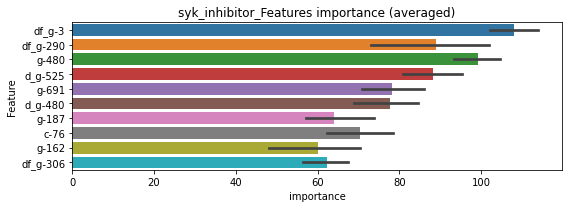

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010942	valid_1's binary_logloss: 0.0183005
[200]	training's binary_logloss: 0.00116722	valid_1's binary_logloss: 0.00606618
[300]	training's binary_logloss: 0.000329798	valid_1's binary_logloss: 0.004826
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.000277249	valid_1's binary_logloss: 0.00473537


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111462	valid_1's binary_logloss: 0.0146245
[200]	training's binary_logloss: 0.00123975	valid_1's binary_logloss: 0.00318605
[300]	training's binary_logloss: 0.000357023	valid_1's binary_logloss: 0.00187202
[400]	training's binary_logloss: 0.00019468	valid_1's binary_logloss: 0.00160407
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000171761	valid_1's binary_logloss: 0.00157339


syk_inhibitor logloss: 0.0031545828225017355


neg labels: 3289 → selected neg labels: 3279


tachykinin_antagonist, len(trt): 60, len(othr): 3279, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0518989	valid_1's binary_logloss: 0.103252
[200]	training's binary_logloss: 0.0106504	valid_1's binary_logloss: 0.0600546
[300]	training's binary_logloss: 0.00285507	valid_1's binary_logloss: 0.0492066
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.0013066	valid_1's binary_logloss: 0.0470292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496267	valid_1's binary_logloss: 0.106548
[200]	training's binary_logloss: 0.00956639	valid_1's binary_logloss: 0.0564768
[300]	training's binary_logloss: 0.00269924	valid_1's binary_logloss: 0.0440968
[400]	training's binary_logloss: 0.00119909	valid_1's binary_logloss: 0.0401181
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00119909	valid_1's binary_logloss: 0.0401181


1 / 3 AUC score:0.992
y_Threshold: 0.0113161, Threshold: 0.0172793, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 150 → Positive_corect_labels: 646/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00252
Num_p_label: 80.0, conf_0:0.01555, conf_1:0.01901
Num_p_label: 80.0, Expected: 10.0, Adj_threshold_1: 0.0172793
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_2: 0.0272793
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_3: 0.0372793
threshold: 0.0372793, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 646.0/3784, y_label_rate: 0.1707188
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458105	valid_1's binary_logloss: 0.089731
[200]	training's binary_logloss: 0.00840531	valid_1's binary_logloss: 0.0408942
[300]	training's binary_logloss: 0.0023863	valid_1's binary_logloss: 0.0289246
[400]	training's binary_logloss: 0.00111147	valid_1's binary_logloss: 0.0251927
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00108145	valid_1's binary_logloss: 0.0250309
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.050808	valid_1's binary_logloss: 0.0922108
[200]	training's binary_logloss: 0.00935987	valid_1's binary_logloss: 0.0407135
[300]	training's binary_logloss: 0.00260151	valid_1's binary_logloss: 0.0285258
[400]	training's binary_logloss: 0.00117401	valid_1's binary_logloss: 0.025727
[500]	training's binary_logloss: 0.000727547	valid_1's binary_logloss: 0.0245581
Early stopping, best iteration is:
[509]	trainin

2 / 3 AUC score:1.000
y_Threshold: 0.0374445, Threshold: 0.0372793, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 638.0/3768
p_label_rate: 0.0113009 Vs.target_rate: 0.00252
Num_p_label: 45.0, conf_0:0.03355, conf_1:0.04101
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_1: 0.0372793
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_2: 0.0472793
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_3: 0.0572793
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_4: 0.0672793
threshold: 0.0672793, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 638.0/3768, y_label_rate: 0.1693206
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484244	valid_1's binary_logloss: 0.0842019
[200]	training's binary_logloss: 0.00902217	valid_1's binary_logloss: 0.0346645
[300]	training's binary_logloss: 0.00252255	valid_1's binary_logloss: 0.0238988
[400]	training's binary_logloss: 0.00116097	valid_1's binary_logloss: 0.0201357
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000844191	valid_1's binary_logloss: 0.0192442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451304	valid_1's binary_logloss: 0.0914569
[200]	training's binary_logloss: 0.00823147	valid_1's binary_logloss: 0.0437713
[300]	training's binary_logloss: 0.00234522	valid_1's binary_logloss: 0.0307368
[400]	training's binary_logloss: 0.00108908	valid_1's binary_logloss: 0.0268793
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.000796463	valid_1's binary_logloss: 0.0256205


3 / 3 AUC score:1.000
y_Threshold: 0.0383529, Threshold: 0.0672793, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 10 → Positive_corect_labels: 633.0/3758
p_label_rate: 0.0060271 Vs.target_rate: 0.00252
Num_p_label: 24.0, conf_0:0.06055, conf_1:0.07401
threshold: 0.0672793, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 657.0/7740, y_label_rate: 0.0848837


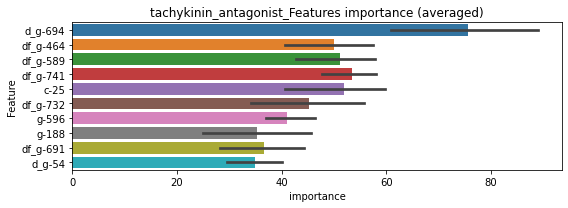

len(train_index) : 3870
len(valid_index) : 3870
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276875	valid_1's binary_logloss: 0.0582673
[200]	training's binary_logloss: 0.00521007	valid_1's binary_logloss: 0.0318551
[300]	training's binary_logloss: 0.00141267	valid_1's binary_logloss: 0.0265432
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.000957914	valid_1's binary_logloss: 0.025785


len(train_index) : 3870
len(valid_index) : 3870
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029353	valid_1's binary_logloss: 0.0566434
[200]	training's binary_logloss: 0.00558498	valid_1's binary_logloss: 0.0300884
[300]	training's binary_logloss: 0.00152524	valid_1's binary_logloss: 0.0250496
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00134858	valid_1's binary_logloss: 0.0248433


tachykinin_antagonist logloss: 0.025314154716013258


neg labels: 3289 → selected neg labels: 3284


tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183397	valid_1's binary_logloss: 0.0251594
[200]	training's binary_logloss: 0.00172734	valid_1's binary_logloss: 0.00641563
[300]	training's binary_logloss: 0.000459636	valid_1's binary_logloss: 0.00514251
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000315412	valid_1's binary_logloss: 0.00498047
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183596	valid_1's binary_logloss: 0.0215637
[200]	training's binary_logloss: 0.00168453	valid_1's binary_logloss: 0.00396523
[300]	training's binary_logloss: 0.000451196	valid_1's binary_logloss: 0.00257226
Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00034917	valid_1's binary_logloss: 0.0024489


1 / 3 AUC score:1.000
y_Threshold: 0.0009120, Threshold: 0.0013863, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00125, conf_1:0.00152
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0013863
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_2: 0.0113863
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_3: 0.0213863
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_4: 0.0313863
threshold: 0.0313863, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170159	valid_1's binary_logloss: 0.0222161
[200]	training's binary_logloss: 0.00142235	valid_1's binary_logloss: 0.00517217
[300]	training's binary_logloss: 0.000341295	valid_1's binary_logloss: 0.00354283
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000245187	valid_1's binary_logloss: 0.00331004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169931	valid_1's binary_logloss: 0.0185152
[200]	training's binary_logloss: 0.00140481	valid_1's binary_logloss: 0.00193402
[300]	training's binary_logloss: 0.00033663	valid_1's binary_logloss: 0.000600028
[400]	training's binary_logloss: 0.000201879	valid_1's binary_logloss: 0.000400986
[500]	training's binary_logloss: 0.000180589	valid_1's binary_logloss: 0.000365207
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00018045	valid_1's binary_logloss: 0.0003

2 / 3 AUC score:1.000
y_Threshold: 0.0394843, Threshold: 0.0313863, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0095429 Vs.target_rate: 0.00126
Num_p_label: 38.0, conf_0:0.02825, conf_1:0.03452
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_1: 0.0313863
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_2: 0.0413863
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_3: 0.0513863
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_4: 0.0613863
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_5: 0.0713863
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_6: 0.0813863
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_7: 0.0913863
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_8: 0.1013863
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_9: 0.1113863
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_10: 0.1213863
threshold: 0.1313863, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0170159	valid_1's binary_logloss: 0.0222161
[200]	training's binary_logloss: 0.00142235	valid_1's binary_logloss: 0.00517217
[300]	training's binary_logloss: 0.000341295	valid_1's binary_logloss: 0.00354283
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.000245187	valid_1's binary_logloss: 0.00331004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0169931	valid_1's binary_logloss: 0.0185152
[200]	training's binary_logloss: 0.00140481	valid_1's binary_logloss: 0.00193402
[300]	training's binary_logloss: 0.00033663	valid_1's binary_logloss: 0.000600028
[400]	training's binary_logloss: 0.000201879	valid_1's binary_logloss: 0.000400986
[500]	training's binary_logloss: 0.000180589	valid_1's binary_logloss: 0.000365207
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00018045	valid_1's binary_logloss: 0.0003

3 / 3 AUC score:1.000
y_Threshold: 0.0394843, Threshold: 0.1313863, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0042692 Vs.target_rate: 0.00126
Num_p_label: 17.0, conf_0:0.11825, conf_1:0.14452
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_1: 0.1313863
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_2: 0.1413863
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_3: 0.1513863
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_4: 0.1613863
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_5: 0.1713863
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_6: 0.1813863
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_7: 0.1913863
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_8: 0.2013863
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_9: 0.2113863
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_10: 0.2213863
threshold: 0.2313863, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 668.0/7790, y_label_rate: 0.0857510


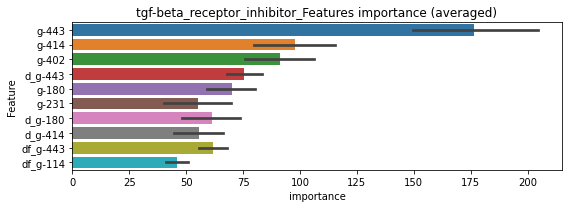

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00931801	valid_1's binary_logloss: 0.0119319
[200]	training's binary_logloss: 0.000777037	valid_1's binary_logloss: 0.00286458
[300]	training's binary_logloss: 0.000189694	valid_1's binary_logloss: 0.00216791
[400]	training's binary_logloss: 0.000111372	valid_1's binary_logloss: 0.00203882
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000112854	valid_1's binary_logloss: 0.00203806


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00929513	valid_1's binary_logloss: 0.011692
[200]	training's binary_logloss: 0.000796702	valid_1's binary_logloss: 0.00275628
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.000228138	valid_1's binary_logloss: 0.00210443


tgf-beta_receptor_inhibitor logloss: 0.0020712461520172036


neg labels: 3289 → selected neg labels: 3286


thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023692	valid_1's binary_logloss: 0.0332666
[200]	training's binary_logloss: 0.00324219	valid_1's binary_logloss: 0.00736973
[300]	training's binary_logloss: 0.000856784	valid_1's binary_logloss: 0.00274563
[400]	training's binary_logloss: 0.000403672	valid_1's binary_logloss: 0.00161994
[500]	training's binary_logloss: 0.000297934	valid_1's binary_logloss: 0.00134795
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.000294907	valid_1's binary_logloss: 0.00134132
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228423	valid_1's binary_logloss: 0.0300252
[200]	training's binary_logloss: 0.00267868	valid_1's binary_logloss: 0.00465277
[300]	training's binary_logloss: 0.000753456	valid_1's binary_logloss: 0.00172178
[400]	training's binary_logloss: 0.000407213	valid_1's binary_logloss: 0.00105449
[500]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0014733, Threshold: 0.0024541, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00080
Num_p_label: 80.0, conf_0:0.00221, conf_1:0.00270
Num_p_label: 80.0, Expected: 3.2, Adj_threshold_1: 0.0024541
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_2: 0.0124541
Num_p_label: 2.0, Expected: 3.2, Adj_threshold_3: 0.0224541
threshold: 0.0224541, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224107	valid_1's binary_logloss: 0.0322872
[200]	training's binary_logloss: 0.00255863	valid_1's binary_logloss: 0.00710867
[300]	training's binary_logloss: 0.000731335	valid_1's binary_logloss: 0.00303435
[400]	training's binary_logloss: 0.000392506	valid_1's binary_logloss: 0.00207098
[500]	training's binary_logloss: 0.000315438	valid_1's binary_logloss: 0.00187891
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000309638	valid_1's binary_logloss: 0.0018722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229673	valid_1's binary_logloss: 0.0283363
[200]	training's binary_logloss: 0.00265737	valid_1's binary_logloss: 0.00410292
[300]	training's binary_logloss: 0.000745373	valid_1's binary_logloss: 0.00135762
[400]	training's binary_logloss: 0.000403814	valid_1's binary_logloss: 0.000792438
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0777874, Threshold: 0.0224541, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0037670 Vs.target_rate: 0.00080
Num_p_label: 15.0, conf_0:0.02021, conf_1:0.02470
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_1: 0.0224541
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_2: 0.0324541
threshold: 0.0324541, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224107	valid_1's binary_logloss: 0.0322872
[200]	training's binary_logloss: 0.00255863	valid_1's binary_logloss: 0.00710867
[300]	training's binary_logloss: 0.000731335	valid_1's binary_logloss: 0.00303435
[400]	training's binary_logloss: 0.000392506	valid_1's binary_logloss: 0.00207098
[500]	training's binary_logloss: 0.000315438	valid_1's binary_logloss: 0.00187891
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.000309638	valid_1's binary_logloss: 0.0018722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229673	valid_1's binary_logloss: 0.0283363
[200]	training's binary_logloss: 0.00265737	valid_1's binary_logloss: 0.00410292
[300]	training's binary_logloss: 0.000745373	valid_1's binary_logloss: 0.00135762
[400]	training's binary_logloss: 0.000403814	valid_1's binary_logloss: 0.000792438
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0777874, Threshold: 0.0324541, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00080
Num_p_label: 6.0, conf_0:0.02921, conf_1:0.03570
threshold: 0.0324541, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 663.0/7793, y_label_rate: 0.0850764


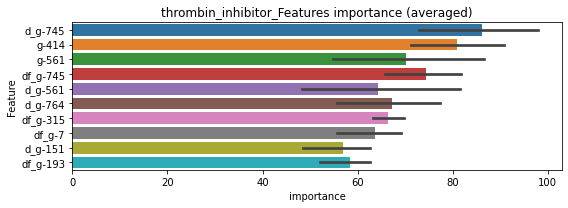

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126079	valid_1's binary_logloss: 0.019354
[200]	training's binary_logloss: 0.00151358	valid_1's binary_logloss: 0.00674545
[300]	training's binary_logloss: 0.000422828	valid_1's binary_logloss: 0.00588297
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000445883	valid_1's binary_logloss: 0.0058722


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126268	valid_1's binary_logloss: 0.0178961
[200]	training's binary_logloss: 0.00149409	valid_1's binary_logloss: 0.00412891
[300]	training's binary_logloss: 0.000429574	valid_1's binary_logloss: 0.00239234
[400]	training's binary_logloss: 0.000217634	valid_1's binary_logloss: 0.00208798
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000181562	valid_1's binary_logloss: 0.00204192


thrombin_inhibitor logloss: 0.003957304057003743


neg labels: 3289 → selected neg labels: 3285


thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3285, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370872	valid_1's binary_logloss: 0.0596819
[200]	training's binary_logloss: 0.00545538	valid_1's binary_logloss: 0.0146453
[300]	training's binary_logloss: 0.00149014	valid_1's binary_logloss: 0.00610061
[400]	training's binary_logloss: 0.000713768	valid_1's binary_logloss: 0.00388794
[500]	training's binary_logloss: 0.000473279	valid_1's binary_logloss: 0.00296258
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.000431312	valid_1's binary_logloss: 0.00283601
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0367375	valid_1's binary_logloss: 0.0503869
[200]	training's binary_logloss: 0.00555044	valid_1's binary_logloss: 0.0111374
[300]	training's binary_logloss: 0.0015201	valid_1's binary_logloss: 0.00430541
[400]	training's binary_logloss: 0.000705108	valid_1's binary_logloss: 0.00241753
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0029196, Threshold: 0.0049468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00155
Num_p_label: 80.0, conf_0:0.00445, conf_1:0.00544
Num_p_label: 80.0, Expected: 6.2, Adj_threshold_1: 0.0049468
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0149468
Num_p_label: 8.0, Expected: 6.2, Adj_threshold_3: 0.0249468
threshold: 0.0249468, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354778	valid_1's binary_logloss: 0.0591023
[200]	training's binary_logloss: 0.00506158	valid_1's binary_logloss: 0.0150254
[300]	training's binary_logloss: 0.00139512	valid_1's binary_logloss: 0.00618442
[400]	training's binary_logloss: 0.000678206	valid_1's binary_logloss: 0.00390357
[500]	training's binary_logloss: 0.000457468	valid_1's binary_logloss: 0.0029686
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000423365	valid_1's binary_logloss: 0.00286272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355806	valid_1's binary_logloss: 0.0496338
[200]	training's binary_logloss: 0.00524777	valid_1's binary_logloss: 0.0104454
[300]	training's binary_logloss: 0.00145274	valid_1's binary_logloss: 0.00386888
[400]	training's binary_logloss: 0.000696055	valid_1's binary_logloss: 0.00231675
[500]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1256300, Threshold: 0.0249468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00155
Num_p_label: 21.0, conf_0:0.02245, conf_1:0.02744
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.0249468
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.0349468
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_3: 0.0449468
Num_p_label: 12.0, Expected: 6.2, Adj_threshold_4: 0.0549468
threshold: 0.0549468, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354778	valid_1's binary_logloss: 0.0591023
[200]	training's binary_logloss: 0.00506158	valid_1's binary_logloss: 0.0150254
[300]	training's binary_logloss: 0.00139512	valid_1's binary_logloss: 0.00618442
[400]	training's binary_logloss: 0.000678206	valid_1's binary_logloss: 0.00390357
[500]	training's binary_logloss: 0.000457468	valid_1's binary_logloss: 0.0029686
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000423365	valid_1's binary_logloss: 0.00286272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355806	valid_1's binary_logloss: 0.0496338
[200]	training's binary_logloss: 0.00524777	valid_1's binary_logloss: 0.0104454
[300]	training's binary_logloss: 0.00145274	valid_1's binary_logloss: 0.00386888
[400]	training's binary_logloss: 0.000696055	valid_1's binary_logloss: 0.00231675
[500]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1256300, Threshold: 0.0549468, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0030136 Vs.target_rate: 0.00155
Num_p_label: 12.0, conf_0:0.04945, conf_1:0.06044
threshold: 0.0549468, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 669.0/7792, y_label_rate: 0.0858573


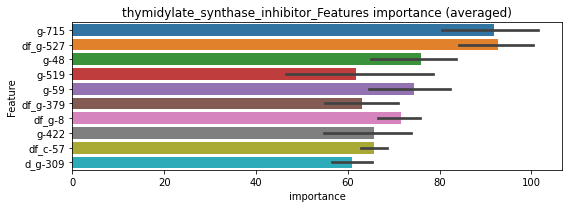

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197797	valid_1's binary_logloss: 0.0336363
[200]	training's binary_logloss: 0.00286642	valid_1's binary_logloss: 0.013265
[300]	training's binary_logloss: 0.000819001	valid_1's binary_logloss: 0.0101934
Early stopping, best iteration is:
[353]	training's binary_logloss: 0.000525412	valid_1's binary_logloss: 0.0097946


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0202476	valid_1's binary_logloss: 0.03419
[200]	training's binary_logloss: 0.0028311	valid_1's binary_logloss: 0.0124367
[300]	training's binary_logloss: 0.000777515	valid_1's binary_logloss: 0.0089559
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000674031	valid_1's binary_logloss: 0.00867132


thymidylate_synthase_inhibitor logloss: 0.009232960693605127


neg labels: 3289 → selected neg labels: 3284


tlr_agonist, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347382	valid_1's binary_logloss: 0.0560708
[200]	training's binary_logloss: 0.00494695	valid_1's binary_logloss: 0.0145282
[300]	training's binary_logloss: 0.00133035	valid_1's binary_logloss: 0.00648089
[400]	training's binary_logloss: 0.000645252	valid_1's binary_logloss: 0.00424045
[500]	training's binary_logloss: 0.00044361	valid_1's binary_logloss: 0.00361016
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.000406645	valid_1's binary_logloss: 0.00342183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345789	valid_1's binary_logloss: 0.0574527
[200]	training's binary_logloss: 0.00496603	valid_1's binary_logloss: 0.0152254
[300]	training's binary_logloss: 0.00134106	valid_1's binary_logloss: 0.00685106
[400]	training's binary_logloss: 0.000651753	valid_1's binary_logloss: 0.00471251
[500]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0024847, Threshold: 0.0035614, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00321, conf_1:0.00392
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0035614
Num_p_label: 8.0, Expected: 5.0, Adj_threshold_2: 0.0135614
threshold: 0.0135614, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333249	valid_1's binary_logloss: 0.0543973
[200]	training's binary_logloss: 0.00467218	valid_1's binary_logloss: 0.0142352
[300]	training's binary_logloss: 0.00128158	valid_1's binary_logloss: 0.00650787
[400]	training's binary_logloss: 0.000629605	valid_1's binary_logloss: 0.00448868
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000449207	valid_1's binary_logloss: 0.00394473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329629	valid_1's binary_logloss: 0.0515596
[200]	training's binary_logloss: 0.00486376	valid_1's binary_logloss: 0.0130094
[300]	training's binary_logloss: 0.00131664	valid_1's binary_logloss: 0.00536245
[400]	training's binary_logloss: 0.000640647	valid_1's binary_logloss: 0.00357175
[500]	training's binary_logloss: 0.000441203	valid_1's binary_logloss: 0.00307034
Early stopping, best iteration is:


2 / 3 AUC score:1.000
y_Threshold: 0.0344132, Threshold: 0.0135614, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0055249 Vs.target_rate: 0.00126
Num_p_label: 22.0, conf_0:0.01221, conf_1:0.01492
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_1: 0.0135614
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_2: 0.0235614
threshold: 0.0235614, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333249	valid_1's binary_logloss: 0.0543973
[200]	training's binary_logloss: 0.00467218	valid_1's binary_logloss: 0.0142352
[300]	training's binary_logloss: 0.00128158	valid_1's binary_logloss: 0.00650787
[400]	training's binary_logloss: 0.000629605	valid_1's binary_logloss: 0.00448868
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.000449207	valid_1's binary_logloss: 0.00394473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0329629	valid_1's binary_logloss: 0.0515596
[200]	training's binary_logloss: 0.00486376	valid_1's binary_logloss: 0.0130094
[300]	training's binary_logloss: 0.00131664	valid_1's binary_logloss: 0.00536245
[400]	training's binary_logloss: 0.000640647	valid_1's binary_logloss: 0.00357175
[500]	training's binary_logloss: 0.000441203	valid_1's binary_logloss: 0.00307034
Early stopping, best iteration is:


3 / 3 AUC score:1.000
y_Threshold: 0.0344132, Threshold: 0.0235614, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00126
Num_p_label: 10.0, conf_0:0.02121, conf_1:0.02592
threshold: 0.0235614, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 666.0/7790, y_label_rate: 0.0854942


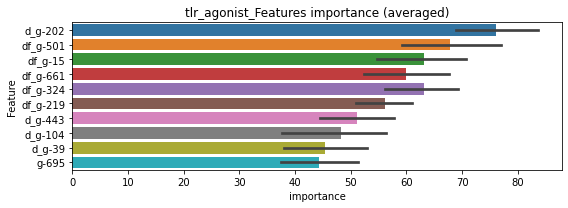

len(train_index) : 3895
len(valid_index) : 3895
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190244	valid_1's binary_logloss: 0.0321042
[200]	training's binary_logloss: 0.00267722	valid_1's binary_logloss: 0.0124362
[300]	training's binary_logloss: 0.000707332	valid_1's binary_logloss: 0.0102534
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.000557972	valid_1's binary_logloss: 0.0100997


len(train_index) : 3895
len(valid_index) : 3895
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203553	valid_1's binary_logloss: 0.0356887
[200]	training's binary_logloss: 0.00303818	valid_1's binary_logloss: 0.0146081
[300]	training's binary_logloss: 0.000800318	valid_1's binary_logloss: 0.0116043
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000603324	valid_1's binary_logloss: 0.0110715


tlr_agonist logloss: 0.010585576553371744


neg labels: 3289 → selected neg labels: 3287


tlr_antagonist, len(trt): 7, len(othr): 3287, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158685	valid_1's binary_logloss: 0.0171347
[200]	training's binary_logloss: 0.00136435	valid_1's binary_logloss: 0.0018987
[300]	training's binary_logloss: 0.000376064	valid_1's binary_logloss: 0.000641972
[400]	training's binary_logloss: 0.000229452	valid_1's binary_logloss: 0.000432815
[500]	training's binary_logloss: 0.000202746	valid_1's binary_logloss: 0.00039895
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.0002001	valid_1's binary_logloss: 0.000396336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160883	valid_1's binary_logloss: 0.0184512
[200]	training's binary_logloss: 0.00137074	valid_1's binary_logloss: 0.00218394
[300]	training's binary_logloss: 0.000377499	valid_1's binary_logloss: 0.000750029
[400]	training's binary_logloss: 0.000231966	valid_1's binary_logloss: 0.000512741
[500]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0006697, Threshold: 0.0009838, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00029
Num_p_label: 80.0, conf_0:0.00089, conf_1:0.00108
Num_p_label: 80.0, Expected: 1.2, Adj_threshold_1: 0.0009838
Num_p_label: 1.0, Expected: 1.2, Adj_threshold_2: 0.0109838
threshold: 0.0109838, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163319	valid_1's binary_logloss: 0.017824
[200]	training's binary_logloss: 0.00135196	valid_1's binary_logloss: 0.00171148
[300]	training's binary_logloss: 0.000370716	valid_1's binary_logloss: 0.0005237
[400]	training's binary_logloss: 0.000229271	valid_1's binary_logloss: 0.000342271
[500]	training's binary_logloss: 0.000200975	valid_1's binary_logloss: 0.000306141
[600]	training's binary_logloss: 0.000194485	valid_1's binary_logloss: 0.000297506
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.000194326	valid_1's binary_logloss: 0.000297452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01647	valid_1's binary_logloss: 0.0177173
[200]	training's binary_logloss: 0.00135319	valid_1's binary_logloss: 0.00168465
[300]	training's binary_logloss: 0.000369219	valid_1's binary_logloss: 0.000534287
[400]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.1651706, Threshold: 0.0109838, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0040181 Vs.target_rate: 0.00029
Num_p_label: 16.0, conf_0:0.00989, conf_1:0.01208
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_1: 0.0109838
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_2: 0.0209838
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_3: 0.0309838
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_4: 0.0409838
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.0509838
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.0609838
threshold: 0.0609838, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163319	valid_1's binary_logloss: 0.017824
[200]	training's binary_logloss: 0.00135196	valid_1's binary_logloss: 0.00171148
[300]	training's binary_logloss: 0.000370716	valid_1's binary_logloss: 0.0005237
[400]	training's binary_logloss: 0.000229271	valid_1's binary_logloss: 0.000342271
[500]	training's binary_logloss: 0.000200975	valid_1's binary_logloss: 0.000306141
[600]	training's binary_logloss: 0.000194485	valid_1's binary_logloss: 0.000297506
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.000194326	valid_1's binary_logloss: 0.000297452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01647	valid_1's binary_logloss: 0.0177173
[200]	training's binary_logloss: 0.00135319	valid_1's binary_logloss: 0.00168465
[300]	training's binary_logloss: 0.000369219	valid_1's binary_logloss: 0.000534287
[400]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.1651706, Threshold: 0.0609838, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00029
Num_p_label: 2.0, conf_0:0.05489, conf_1:0.06708
threshold: 0.0609838, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7794, y_label_rate: 0.0845522


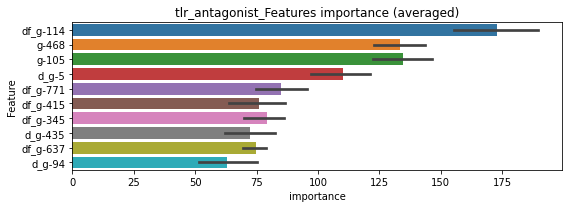

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00866299	valid_1's binary_logloss: 0.00998833
[200]	training's binary_logloss: 0.000722302	valid_1's binary_logloss: 0.0019162
[300]	training's binary_logloss: 0.000190206	valid_1's binary_logloss: 0.00136601
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000178667	valid_1's binary_logloss: 0.00135684


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00865196	valid_1's binary_logloss: 0.011439
[200]	training's binary_logloss: 0.000716114	valid_1's binary_logloss: 0.00358352
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000231013	valid_1's binary_logloss: 0.00311982


tlr_antagonist logloss: 0.002238332069184391


neg labels: 3289 → selected neg labels: 3283


tnf_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335139	valid_1's binary_logloss: 0.050462
[200]	training's binary_logloss: 0.00505609	valid_1's binary_logloss: 0.0128855
[300]	training's binary_logloss: 0.00142069	valid_1's binary_logloss: 0.0056235
[400]	training's binary_logloss: 0.000703032	valid_1's binary_logloss: 0.00362214
[500]	training's binary_logloss: 0.000468348	valid_1's binary_logloss: 0.00291479
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.000434505	valid_1's binary_logloss: 0.00282764
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323359	valid_1's binary_logloss: 0.0659318
[200]	training's binary_logloss: 0.00474312	valid_1's binary_logloss: 0.0292236
[300]	training's binary_logloss: 0.00135692	valid_1's binary_logloss: 0.0227866
[400]	training's binary_logloss: 0.000671075	valid_1's binary_logloss: 0.0212002
Early stopping, best iteration is:
[393

1 / 3 AUC score:1.000
y_Threshold: 0.0040317, Threshold: 0.0056318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0200904 Vs.target_rate: 0.00151
Num_p_label: 80.0, conf_0:0.00507, conf_1:0.00620
Num_p_label: 80.0, Expected: 6.0, Adj_threshold_1: 0.0056318
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.0156318
Num_p_label: 7.0, Expected: 6.0, Adj_threshold_3: 0.0256318
threshold: 0.0256318, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325811	valid_1's binary_logloss: 0.0486751
[200]	training's binary_logloss: 0.00484042	valid_1's binary_logloss: 0.0116607
[300]	training's binary_logloss: 0.00139891	valid_1's binary_logloss: 0.00496238
[400]	training's binary_logloss: 0.000696588	valid_1's binary_logloss: 0.00308987
[500]	training's binary_logloss: 0.000470298	valid_1's binary_logloss: 0.00245196
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.000437708	valid_1's binary_logloss: 0.00236945
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317742	valid_1's binary_logloss: 0.0632765
[200]	training's binary_logloss: 0.00458894	valid_1's binary_logloss: 0.0268065
[300]	training's binary_logloss: 0.00131715	valid_1's binary_logloss: 0.020936
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00115478	valid_1's binary_logloss: 0.0206229


2 / 3 AUC score:1.000
y_Threshold: 0.0234830, Threshold: 0.0256318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 653.0/3801
p_label_rate: 0.0075339 Vs.target_rate: 0.00151
Num_p_label: 30.0, conf_0:0.02307, conf_1:0.02820
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_1: 0.0256318
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.0356318
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.0456318
threshold: 0.0456318, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311409	valid_1's binary_logloss: 0.0477476
[200]	training's binary_logloss: 0.00459013	valid_1's binary_logloss: 0.0127783
[300]	training's binary_logloss: 0.001325	valid_1's binary_logloss: 0.00652429
[400]	training's binary_logloss: 0.00065982	valid_1's binary_logloss: 0.00478838
[500]	training's binary_logloss: 0.000452693	valid_1's binary_logloss: 0.00415237
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000462048	valid_1's binary_logloss: 0.00414898
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.032665	valid_1's binary_logloss: 0.0640432
[200]	training's binary_logloss: 0.00471178	valid_1's binary_logloss: 0.0210971
[300]	training's binary_logloss: 0.00135103	valid_1's binary_logloss: 0.0125295
[400]	training's binary_logloss: 0.000670077	valid_1's binary_logloss: 0.0101498
Early stopping, best iteration is:
[478]	

3 / 3 AUC score:1.000
y_Threshold: 0.0210850, Threshold: 0.0456318, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 4 → Positive_corect_labels: 651.0/3797
p_label_rate: 0.0025113 Vs.target_rate: 0.00151
Num_p_label: 10.0, conf_0:0.04107, conf_1:0.05020
threshold: 0.0456318, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 661.0/7779, y_label_rate: 0.0849724


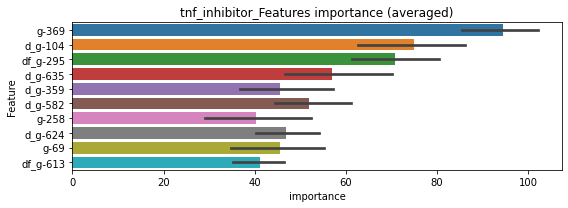

len(train_index) : 3889
len(valid_index) : 3890
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168119	valid_1's binary_logloss: 0.0416247
[200]	training's binary_logloss: 0.00237882	valid_1's binary_logloss: 0.0257144
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.000801908	valid_1's binary_logloss: 0.0239699


len(train_index) : 3890
len(valid_index) : 3889
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0184183	valid_1's binary_logloss: 0.0316732
[200]	training's binary_logloss: 0.00272935	valid_1's binary_logloss: 0.0119389
[300]	training's binary_logloss: 0.000779389	valid_1's binary_logloss: 0.00789003
[400]	training's binary_logloss: 0.000373185	valid_1's binary_logloss: 0.00678861
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000266883	valid_1's binary_logloss: 0.00646712


tnf_inhibitor logloss: 0.01521965310273443


neg labels: 3289 → selected neg labels: 3271


topoisomerase_inhibitor, len(trt): 127, len(othr): 3271, target_rate: 0.0053330 → Adj_target_rate: 0.0051574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382251	valid_1's binary_logloss: 0.0793435
[200]	training's binary_logloss: 0.0064961	valid_1's binary_logloss: 0.0476791
[300]	training's binary_logloss: 0.0019006	valid_1's binary_logloss: 0.0418627
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.0017567	valid_1's binary_logloss: 0.0417216
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372716	valid_1's binary_logloss: 0.0777464
[200]	training's binary_logloss: 0.00657967	valid_1's binary_logloss: 0.0516979
[300]	training's binary_logloss: 0.00185785	valid_1's binary_logloss: 0.04619
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00161512	valid_1's binary_logloss: 0.0457067


1 / 3 AUC score:0.998
y_Threshold: 0.0102464, Threshold: 0.7207389, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 141 → Positive_corect_labels: 649/3784
p_label_rate: 0.0200904 Vs.target_rate: 0.00533
Num_p_label: 80.0, conf_0:0.64867, conf_1:0.79281
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.7207389
Num_p_label: 79.0, Expected: 21.2, Adj_threshold_2: 0.7307389
Num_p_label: 78.0, Expected: 21.2, Adj_threshold_3: 0.7407389
Num_p_label: 77.0, Expected: 21.2, Adj_threshold_4: 0.7507389
Num_p_label: 73.0, Expected: 21.2, Adj_threshold_5: 0.7607389
Num_p_label: 71.0, Expected: 21.2, Adj_threshold_6: 0.7707389
Num_p_label: 70.0, Expected: 21.2, Adj_threshold_7: 0.7807389
Num_p_label: 68.0, Expected: 21.2, Adj_threshold_8: 0.7907389
Num_p_label: 66.0, Expected: 21.2, Adj_threshold_9: 0.8007389
Num_p_label: 63.0, Expected: 21.2, Adj_threshold_10: 0.8107389
threshold: 0.8207389, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 649.0/3784, y_label_rate: 0.1715116

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0289895	valid_1's binary_logloss: 0.0658973
[200]	training's binary_logloss: 0.00397502	valid_1's binary_logloss: 0.0403533
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00200151	valid_1's binary_logloss: 0.0376359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297393	valid_1's binary_logloss: 0.0618823
[200]	training's binary_logloss: 0.00417591	valid_1's binary_logloss: 0.0355303
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00197544	valid_1's binary_logloss: 0.0326991


2 / 3 AUC score:0.999
y_Threshold: 0.0544301, Threshold: 0.8207389, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 633.0/3752
p_label_rate: 0.0354093 Vs.target_rate: 0.00533
Num_p_label: 141.0, conf_0:0.73867, conf_1:0.90281
Num_p_label: 141.0, Expected: 21.2, Adj_threshold_1: 0.8207389
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_2: 0.8307389
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_3: 0.8407389
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_4: 0.8507389
Num_p_label: 138.0, Expected: 21.2, Adj_threshold_5: 0.8607389
Num_p_label: 137.0, Expected: 21.2, Adj_threshold_6: 0.8707389
Num_p_label: 136.0, Expected: 21.2, Adj_threshold_7: 0.8807389
Num_p_label: 135.0, Expected: 21.2, Adj_threshold_8: 0.8907389
Num_p_label: 134.0, Expected: 21.2, Adj_threshold_9: 0.9007389
Num_p_label: 133.0, Expected: 21.2, Adj_threshold_10: 0.9107389
threshold: 0.9207389, positive_p_label: 131.0/3982, p_label_rate: 0.0328980
positive_y_label: 633.0/3752, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264363	valid_1's binary_logloss: 0.0547335
[200]	training's binary_logloss: 0.00355409	valid_1's binary_logloss: 0.0312254
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00141146	valid_1's binary_logloss: 0.0289795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282236	valid_1's binary_logloss: 0.0605608
[200]	training's binary_logloss: 0.00368626	valid_1's binary_logloss: 0.0343036
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00218955	valid_1's binary_logloss: 0.0330189


3 / 3 AUC score:0.999
y_Threshold: 0.0410508, Threshold: 0.9207389, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 32 → Positive_corect_labels: 617.0/3720
p_label_rate: 0.0359116 Vs.target_rate: 0.00533
Num_p_label: 143.0, conf_0:0.82867, conf_1:1.01281
Num_p_label: 143.0, Expected: 21.2, Adj_threshold_1: 0.9207389
Num_p_label: 140.0, Expected: 21.2, Adj_threshold_2: 0.9307389
Num_p_label: 139.0, Expected: 21.2, Adj_threshold_3: 0.9407389
Num_p_label: 132.0, Expected: 21.2, Adj_threshold_4: 0.9507389
Num_p_label: 128.0, Expected: 21.2, Adj_threshold_5: 0.9607389
Num_p_label: 122.0, Expected: 21.2, Adj_threshold_6: 0.9707389
Num_p_label: 120.0, Expected: 21.2, Adj_threshold_7: 0.9807389
Num_p_label: 106.0, Expected: 21.2, Adj_threshold_8: 0.9907389
threshold: 0.9907389, positive_p_label: 106.0/3982, p_label_rate: 0.0266198
positive_y_label: 723.0/7702, y_label_rate: 0.0938717


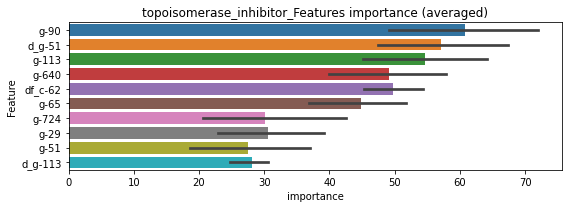

len(train_index) : 3851
len(valid_index) : 3851
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0183646	valid_1's binary_logloss: 0.0410252
[200]	training's binary_logloss: 0.00279088	valid_1's binary_logloss: 0.0286151
Early stopping, best iteration is:
[222]	training's binary_logloss: 0.00198346	valid_1's binary_logloss: 0.0283008


len(train_index) : 3851
len(valid_index) : 3851
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167585	valid_1's binary_logloss: 0.0459304
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00300359	valid_1's binary_logloss: 0.0379184


topoisomerase_inhibitor logloss: 0.03310959295954314


neg labels: 3289 → selected neg labels: 3286


transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233181	valid_1's binary_logloss: 0.0304852
[200]	training's binary_logloss: 0.00271944	valid_1's binary_logloss: 0.00500944
[300]	training's binary_logloss: 0.000768006	valid_1's binary_logloss: 0.0018488
[400]	training's binary_logloss: 0.000399092	valid_1's binary_logloss: 0.00110996
[500]	training's binary_logloss: 0.000321894	valid_1's binary_logloss: 0.000963423
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000317433	valid_1's binary_logloss: 0.000956499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0228833	valid_1's binary_logloss: 0.0311397
[200]	training's binary_logloss: 0.00273274	valid_1's binary_logloss: 0.00612748
[300]	training's binary_logloss: 0.000743521	valid_1's binary_logloss: 0.00260432
[400]	training's binary_logloss: 0.000392958	valid_1's binary_logloss: 0.00177794
[500]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0012713, Threshold: 0.0017549, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0200904 Vs.target_rate: 0.00076
Num_p_label: 80.0, conf_0:0.00158, conf_1:0.00193
Num_p_label: 80.0, Expected: 3.0, Adj_threshold_1: 0.0017549
Num_p_label: 0.0, Expected: 3.0, Adj_threshold_2: 0.0117549
threshold: 0.0117549, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235376	valid_1's binary_logloss: 0.0300543
[200]	training's binary_logloss: 0.00263977	valid_1's binary_logloss: 0.00452326
[300]	training's binary_logloss: 0.000735104	valid_1's binary_logloss: 0.00153596
[400]	training's binary_logloss: 0.000394102	valid_1's binary_logloss: 0.0009326
[500]	training's binary_logloss: 0.000317164	valid_1's binary_logloss: 0.000796414
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000315435	valid_1's binary_logloss: 0.000792614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229171	valid_1's binary_logloss: 0.031608
[200]	training's binary_logloss: 0.00263856	valid_1's binary_logloss: 0.00633269
[300]	training's binary_logloss: 0.000812099	valid_1's binary_logloss: 0.00330129
[400]	training's binary_logloss: 0.000460808	valid_1's binary_logloss: 0.00252761
[500]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.0208223, Threshold: 0.0117549, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01058, conf_1:0.01293
threshold: 0.0117549, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235376	valid_1's binary_logloss: 0.0300543
[200]	training's binary_logloss: 0.00263977	valid_1's binary_logloss: 0.00452326
[300]	training's binary_logloss: 0.000735104	valid_1's binary_logloss: 0.00153596
[400]	training's binary_logloss: 0.000394102	valid_1's binary_logloss: 0.0009326
[500]	training's binary_logloss: 0.000317164	valid_1's binary_logloss: 0.000796414
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000315435	valid_1's binary_logloss: 0.000792614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229171	valid_1's binary_logloss: 0.031608
[200]	training's binary_logloss: 0.00263856	valid_1's binary_logloss: 0.00633269
[300]	training's binary_logloss: 0.000812099	valid_1's binary_logloss: 0.00330129
[400]	training's binary_logloss: 0.000460808	valid_1's binary_logloss: 0.00252761
[500]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.0208223, Threshold: 0.0117549, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00076
Num_p_label: 8.0, conf_0:0.01058, conf_1:0.01293
threshold: 0.0117549, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7793, y_label_rate: 0.0853330


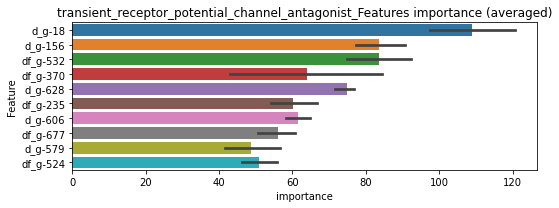

len(train_index) : 3896
len(valid_index) : 3897
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0120518	valid_1's binary_logloss: 0.0238677
[200]	training's binary_logloss: 0.00133995	valid_1's binary_logloss: 0.0144286
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000958874	valid_1's binary_logloss: 0.0142908


len(train_index) : 3897
len(valid_index) : 3896
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131674	valid_1's binary_logloss: 0.0186763
[200]	training's binary_logloss: 0.00160014	valid_1's binary_logloss: 0.0057909
[300]	training's binary_logloss: 0.000445401	valid_1's binary_logloss: 0.00426723
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00028174	valid_1's binary_logloss: 0.00409261


transient_receptor_potential_channel_antagonist logloss: 0.009192384344483228


neg labels: 3289 → selected neg labels: 3288


tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157713	valid_1's binary_logloss: 0.0172818
[200]	training's binary_logloss: 0.00131828	valid_1's binary_logloss: 0.00174991
[300]	training's binary_logloss: 0.000348546	valid_1's binary_logloss: 0.000511977
[400]	training's binary_logloss: 0.000212575	valid_1's binary_logloss: 0.000332668
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000191911	valid_1's binary_logloss: 0.000307352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015939	valid_1's binary_logloss: 0.0168746
[200]	training's binary_logloss: 0.00131639	valid_1's binary_logloss: 0.0015241
[300]	training's binary_logloss: 0.000350346	valid_1's binary_logloss: 0.000437629
[400]	training's binary_logloss: 0.000212604	valid_1's binary_logloss: 0.000273088
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000190265	valid_1's binary_logloss: 0.00

1 / 3 AUC score:1.000
y_Threshold: 0.0005531, Threshold: 0.0011669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0200904 Vs.target_rate: 0.00025
Num_p_label: 80.0, conf_0:0.00105, conf_1:0.00128
Num_p_label: 80.0, Expected: 1.0, Adj_threshold_1: 0.0011669
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0111669
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.0211669
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.0311669
threshold: 0.0311669, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161543	valid_1's binary_logloss: 0.0179065
[200]	training's binary_logloss: 0.00131283	valid_1's binary_logloss: 0.00226914
[300]	training's binary_logloss: 0.000343232	valid_1's binary_logloss: 0.000850674
[400]	training's binary_logloss: 0.000209892	valid_1's binary_logloss: 0.000617676
[500]	training's binary_logloss: 0.000188322	valid_1's binary_logloss: 0.000576534
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000188322	valid_1's binary_logloss: 0.000576534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163114	valid_1's binary_logloss: 0.0172661
[200]	training's binary_logloss: 0.0013186	valid_1's binary_logloss: 0.00148744
[300]	training's binary_logloss: 0.000346997	valid_1's binary_logloss: 0.000413373
[400]	training's binary_logloss: 0.000211092	valid_1's binary_logloss: 0.000256618
Early stopping, best itera

2 / 3 AUC score:1.000
y_Threshold: 0.1068543, Threshold: 0.0311669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025
Num_p_label: 6.0, conf_0:0.02805, conf_1:0.03428
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.0311669
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0411669
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.0511669
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.0611669
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.0711669
threshold: 0.0711669, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161543	valid_1's binary_logloss: 0.0179065
[200]	training's binary_logloss: 0.00131283	valid_1's binary_logloss: 0.00226914
[300]	training's binary_logloss: 0.000343232	valid_1's binary_logloss: 0.000850674
[400]	training's binary_logloss: 0.000209892	valid_1's binary_logloss: 0.000617676
Early stopping, best iteration is:
[489]	training's binary_logloss: 0.000188322	valid_1's binary_logloss: 0.000576534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0163114	valid_1's binary_logloss: 0.0172661
[200]	training's binary_logloss: 0.0013186	valid_1's binary_logloss: 0.00148744
[300]	training's binary_logloss: 0.000346997	valid_1's binary_logloss: 0.000413373
[400]	training's binary_logloss: 0.000211092	valid_1's binary_logloss: 0.000256618
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000190799	valid_1's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1068543, Threshold: 0.0711669, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025
Num_p_label: 2.0, conf_0:0.06405, conf_1:0.07828
threshold: 0.0711669, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 659.0/7795, y_label_rate: 0.0845414


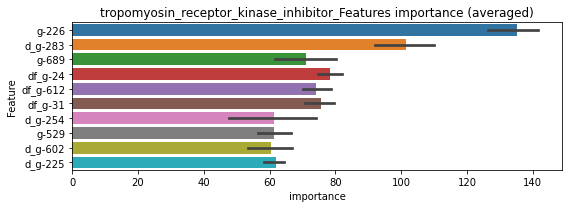

len(train_index) : 3897
len(valid_index) : 3898
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00859086	valid_1's binary_logloss: 0.0104022
[200]	training's binary_logloss: 0.00069287	valid_1's binary_logloss: 0.00210738
[300]	training's binary_logloss: 0.000179264	valid_1's binary_logloss: 0.00148275
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000125929	valid_1's binary_logloss: 0.00140166


len(train_index) : 3898
len(valid_index) : 3897
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00871441	valid_1's binary_logloss: 0.0101753
[200]	training's binary_logloss: 0.00070759	valid_1's binary_logloss: 0.0022247
[300]	training's binary_logloss: 0.000185976	valid_1's binary_logloss: 0.00177636
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.000165611	valid_1's binary_logloss: 0.00176163


tropomyosin_receptor_kinase_inhibitor logloss: 0.001581618591396579


neg labels: 3289 → selected neg labels: 3285


trpv_agonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0259124	valid_1's binary_logloss: 0.0353244
[200]	training's binary_logloss: 0.00324598	valid_1's binary_logloss: 0.00675598
[300]	training's binary_logloss: 0.000921784	valid_1's binary_logloss: 0.00277329
[400]	training's binary_logloss: 0.000487564	valid_1's binary_logloss: 0.00182553
[500]	training's binary_logloss: 0.000367471	valid_1's binary_logloss: 0.00152082
[600]	training's binary_logloss: 0.000352454	valid_1's binary_logloss: 0.00147792
Early stopping, best iteration is:
[609]	training's binary_logloss: 0.000352281	valid_1's binary_logloss: 0.00147765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0250701	valid_1's binary_logloss: 0.0356063
[200]	training's binary_logloss: 0.00313803	valid_1's binary_logloss: 0.00641168
[300]	training's binary_logloss: 0.000905287	valid_1's binary_logloss: 0.00257328
[400]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0020451, Threshold: 0.0058263, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00105
Num_p_label: 80.0, conf_0:0.00524, conf_1:0.00641
Num_p_label: 80.0, Expected: 4.2, Adj_threshold_1: 0.0058263
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_2: 0.0158263
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_3: 0.0258263
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.0358263
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_5: 0.0458263
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_6: 0.0558263
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_7: 0.0658263
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_8: 0.0758263
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_9: 0.0858263
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.0958263
threshold: 0.1058263, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
============

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246846	valid_1's binary_logloss: 0.0323167
[200]	training's binary_logloss: 0.00296789	valid_1's binary_logloss: 0.0051295
[300]	training's binary_logloss: 0.000849666	valid_1's binary_logloss: 0.0018399
[400]	training's binary_logloss: 0.000452782	valid_1's binary_logloss: 0.00109963
[500]	training's binary_logloss: 0.000352258	valid_1's binary_logloss: 0.000909
[600]	training's binary_logloss: 0.00033735	valid_1's binary_logloss: 0.000882453
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000336555	valid_1's binary_logloss: 0.000881749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024602	valid_1's binary_logloss: 0.0334131
[200]	training's binary_logloss: 0.00294103	valid_1's binary_logloss: 0.00529409
[300]	training's binary_logloss: 0.000853855	valid_1's binary_logloss: 0.00191845
[400]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1681413, Threshold: 0.1058263, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0082873 Vs.target_rate: 0.00105
Num_p_label: 33.0, conf_0:0.09524, conf_1:0.11641
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_1: 0.1058263
Num_p_label: 32.0, Expected: 4.2, Adj_threshold_2: 0.1158263
Num_p_label: 31.0, Expected: 4.2, Adj_threshold_3: 0.1258263
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_4: 0.1358263
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_5: 0.1458263
Num_p_label: 27.0, Expected: 4.2, Adj_threshold_6: 0.1558263
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_7: 0.1658263
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_8: 0.1758263
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_9: 0.1858263
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_10: 0.1958263
threshold: 0.2058263, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246846	valid_1's binary_logloss: 0.0323167
[200]	training's binary_logloss: 0.00296789	valid_1's binary_logloss: 0.0051295
[300]	training's binary_logloss: 0.000849666	valid_1's binary_logloss: 0.0018399
[400]	training's binary_logloss: 0.000452782	valid_1's binary_logloss: 0.00109963
[500]	training's binary_logloss: 0.000352258	valid_1's binary_logloss: 0.000909
[600]	training's binary_logloss: 0.00033735	valid_1's binary_logloss: 0.000882453
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.000336555	valid_1's binary_logloss: 0.000881749
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.024602	valid_1's binary_logloss: 0.0334131
[200]	training's binary_logloss: 0.00294103	valid_1's binary_logloss: 0.00529409
[300]	training's binary_logloss: 0.000853855	valid_1's binary_logloss: 0.00191845
[400]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1681413, Threshold: 0.2058263, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0060271 Vs.target_rate: 0.00105
Num_p_label: 24.0, conf_0:0.18524, conf_1:0.22641
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.2058263
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.2158263
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_3: 0.2258263
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_4: 0.2358263
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_5: 0.2458263
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_6: 0.2558263
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_7: 0.2658263
Num_p_label: 22.0, Expected: 4.2, Adj_threshold_8: 0.2758263
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_9: 0.2858263
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_10: 0.2958263
threshold: 0.3058263, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 678.0/7792, y_label_rate: 0.0870123


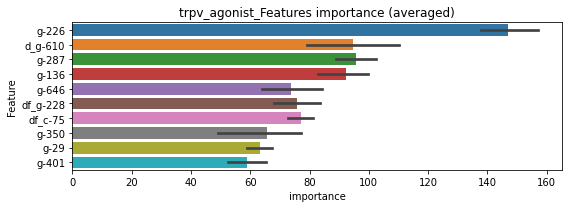

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0140218	valid_1's binary_logloss: 0.0220985
[200]	training's binary_logloss: 0.00175499	valid_1's binary_logloss: 0.0065113
[300]	training's binary_logloss: 0.000486275	valid_1's binary_logloss: 0.00447831
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000287754	valid_1's binary_logloss: 0.0041121


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142124	valid_1's binary_logloss: 0.0208367
[200]	training's binary_logloss: 0.00178476	valid_1's binary_logloss: 0.00568249
[300]	training's binary_logloss: 0.000502912	valid_1's binary_logloss: 0.00339167
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000301565	valid_1's binary_logloss: 0.00303113


trpv_agonist logloss: 0.0035716128659447777


neg labels: 3289 → selected neg labels: 3281


trpv_antagonist, len(trt): 48, len(othr): 3281, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.046815	valid_1's binary_logloss: 0.0940912
[200]	training's binary_logloss: 0.00859506	valid_1's binary_logloss: 0.043176
[300]	training's binary_logloss: 0.00231626	valid_1's binary_logloss: 0.029306
[400]	training's binary_logloss: 0.00106294	valid_1's binary_logloss: 0.0256319
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.000792608	valid_1's binary_logloss: 0.0248783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.048059	valid_1's binary_logloss: 0.0875859
[200]	training's binary_logloss: 0.00903803	valid_1's binary_logloss: 0.0370056
[300]	training's binary_logloss: 0.00244219	valid_1's binary_logloss: 0.0251254
[400]	training's binary_logloss: 0.00110148	valid_1's binary_logloss: 0.0217745
[500]	training's binary_logloss: 0.00069055	valid_1's binary_logloss: 0.0205813
Early stopping, best iteration is:
[586]	trainin

1 / 3 AUC score:0.999
y_Threshold: 0.0053747, Threshold: 0.0082606, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 140 → Positive_corect_labels: 652/3797
p_label_rate: 0.0200904 Vs.target_rate: 0.00202
Num_p_label: 80.0, conf_0:0.00743, conf_1:0.00909
Num_p_label: 80.0, Expected: 8.0, Adj_threshold_1: 0.0082606
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_2: 0.0182606
Num_p_label: 7.0, Expected: 8.0, Adj_threshold_3: 0.0282606
threshold: 0.0282606, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458062	valid_1's binary_logloss: 0.0833563
[200]	training's binary_logloss: 0.00842045	valid_1's binary_logloss: 0.0312389
[300]	training's binary_logloss: 0.0023153	valid_1's binary_logloss: 0.0186676
[400]	training's binary_logloss: 0.00106166	valid_1's binary_logloss: 0.0157119
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.000930809	valid_1's binary_logloss: 0.0154949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.045767	valid_1's binary_logloss: 0.0883094
[200]	training's binary_logloss: 0.00788543	valid_1's binary_logloss: 0.0421162
[300]	training's binary_logloss: 0.00221433	valid_1's binary_logloss: 0.0312546
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00121577	valid_1's binary_logloss: 0.0282695


2 / 3 AUC score:0.999
y_Threshold: 0.0181198, Threshold: 0.0282606, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 14 → Positive_corect_labels: 645.0/3783
p_label_rate: 0.0062783 Vs.target_rate: 0.00202
Num_p_label: 25.0, conf_0:0.02543, conf_1:0.03109
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_1: 0.0282606
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_2: 0.0382606
threshold: 0.0382606, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 645.0/3783, y_label_rate: 0.1704996
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441335	valid_1's binary_logloss: 0.0940921
[200]	training's binary_logloss: 0.00772416	valid_1's binary_logloss: 0.048402
[300]	training's binary_logloss: 0.00216325	valid_1's binary_logloss: 0.0369216
[400]	training's binary_logloss: 0.00100529	valid_1's binary_logloss: 0.0327536
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000998882	valid_1's binary_logloss: 0.0327306
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458073	valid_1's binary_logloss: 0.085514
[200]	training's binary_logloss: 0.00783286	valid_1's binary_logloss: 0.0403121
[300]	training's binary_logloss: 0.00217242	valid_1's binary_logloss: 0.0315982
[400]	training's binary_logloss: 0.00101535	valid_1's binary_logloss: 0.0290693
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000908939	valid_1's binary_logloss: 0.0288531


3 / 3 AUC score:0.999
y_Threshold: 0.0224318, Threshold: 0.0382606, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 16 → Positive_corect_labels: 637.0/3767
p_label_rate: 0.0040181 Vs.target_rate: 0.00202
Num_p_label: 16.0, conf_0:0.03443, conf_1:0.04209
threshold: 0.0382606, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 653.0/7749, y_label_rate: 0.0842689


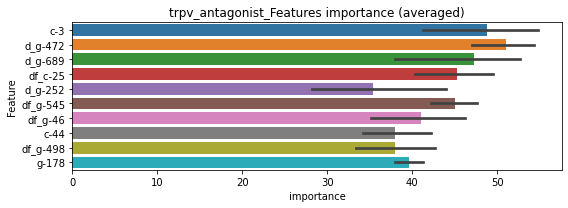

len(train_index) : 3874
len(valid_index) : 3875
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0244196	valid_1's binary_logloss: 0.046715
[200]	training's binary_logloss: 0.00423896	valid_1's binary_logloss: 0.0226864
[300]	training's binary_logloss: 0.00115711	valid_1's binary_logloss: 0.0182496
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000606348	valid_1's binary_logloss: 0.0174545


len(train_index) : 3875
len(valid_index) : 3874
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025213	valid_1's binary_logloss: 0.0527245
[200]	training's binary_logloss: 0.00446081	valid_1's binary_logloss: 0.0279788
[300]	training's binary_logloss: 0.00122934	valid_1's binary_logloss: 0.0240333
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000677628	valid_1's binary_logloss: 0.0231651


trpv_antagonist logloss: 0.020309434922143113


neg labels: 3289 → selected neg labels: 3267


tubulin_inhibitor, len(trt): 316, len(othr): 3267, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398057	valid_1's binary_logloss: 0.122712
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.00916555	valid_1's binary_logloss: 0.108546
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0436741	valid_1's binary_logloss: 0.101278
[200]	training's binary_logloss: 0.00821822	valid_1's binary_logloss: 0.0784665
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.00912635	valid_1's binary_logloss: 0.0781235


1 / 3 AUC score:0.981
y_Threshold: 0.0253935, Threshold: 0.1465446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 185 → Positive_corect_labels: 626/3735
p_label_rate: 0.0200904 Vs.target_rate: 0.01327
Num_p_label: 80.0, conf_0:0.13189, conf_1:0.16120
threshold: 0.1465446, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 626.0/3735, y_label_rate: 0.1676037
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326923	valid_1's binary_logloss: 0.0674754
[200]	training's binary_logloss: 0.00493271	valid_1's binary_logloss: 0.0402973
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00196067	valid_1's binary_logloss: 0.0370123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319371	valid_1's binary_logloss: 0.0863417
[200]	training's binary_logloss: 0.00510581	valid_1's binary_logloss: 0.0692481
Early stopping, best iteration is:
[204]	training's binary_logloss: 0.00484743	valid_1's binary_logloss: 0.0690592


2 / 3 AUC score:0.995
y_Threshold: 0.0524118, Threshold: 0.1465446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 52 → Positive_corect_labels: 600.0/3683
p_label_rate: 0.0303867 Vs.target_rate: 0.01327
Num_p_label: 121.0, conf_0:0.13189, conf_1:0.16120
threshold: 0.1465446, positive_p_label: 121.0/3982, p_label_rate: 0.0303867
positive_y_label: 600.0/3683, y_label_rate: 0.1629107
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0267591	valid_1's binary_logloss: 0.0813721
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.00616084	valid_1's binary_logloss: 0.0701725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285081	valid_1's binary_logloss: 0.0588495
[200]	training's binary_logloss: 0.00402196	valid_1's binary_logloss: 0.0385985
[300]	training's binary_logloss: 0.00116391	valid_1's binary_logloss: 0.0362708
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00127523	valid_1's binary_logloss: 0.0359164


3 / 3 AUC score:0.989
y_Threshold: 0.0324907, Threshold: 0.1465446, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 40 → Positive_corect_labels: 580.0/3643
p_label_rate: 0.0311401 Vs.target_rate: 0.01327
Num_p_label: 124.0, conf_0:0.13189, conf_1:0.16120
threshold: 0.1465446, positive_p_label: 124.0/3982, p_label_rate: 0.0311401
positive_y_label: 704.0/7625, y_label_rate: 0.0923279


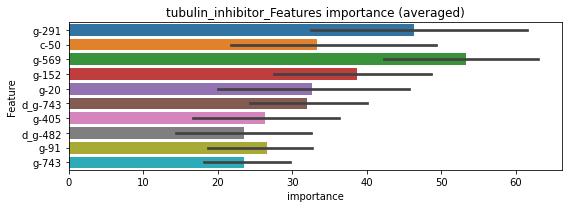

len(train_index) : 3812
len(valid_index) : 3813
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158023	valid_1's binary_logloss: 0.0417685
[200]	training's binary_logloss: 0.00218588	valid_1's binary_logloss: 0.0303493
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.00143883	valid_1's binary_logloss: 0.029238


len(train_index) : 3813
len(valid_index) : 3812
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149055	valid_1's binary_logloss: 0.0380488
[200]	training's binary_logloss: 0.00204808	valid_1's binary_logloss: 0.0269377
[300]	training's binary_logloss: 0.000592576	valid_1's binary_logloss: 0.0255158
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000646235	valid_1's binary_logloss: 0.0254176


tubulin_inhibitor logloss: 0.027328042091941524


neg labels: 3289 → selected neg labels: 3276


tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3276, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557372	valid_1's binary_logloss: 0.115725
[200]	training's binary_logloss: 0.0116817	valid_1's binary_logloss: 0.0611369
[300]	training's binary_logloss: 0.00343265	valid_1's binary_logloss: 0.0468753
[400]	training's binary_logloss: 0.00155114	valid_1's binary_logloss: 0.0412233
[500]	training's binary_logloss: 0.000940146	valid_1's binary_logloss: 0.0394905
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.000901191	valid_1's binary_logloss: 0.0391802
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0553012	valid_1's binary_logloss: 0.112874
[200]	training's binary_logloss: 0.0116113	valid_1's binary_logloss: 0.0583844
[300]	training's binary_logloss: 0.00338694	valid_1's binary_logloss: 0.0440236
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00200587	valid_1's binary_logloss: 0.0404336


1 / 3 AUC score:0.996
y_Threshold: 0.0124148, Threshold: 0.0223700, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 148 → Positive_corect_labels: 647/3783
p_label_rate: 0.0200904 Vs.target_rate: 0.00307
Num_p_label: 80.0, conf_0:0.02013, conf_1:0.02461
Num_p_label: 80.0, Expected: 12.2, Adj_threshold_1: 0.0223700
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_2: 0.0323700
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_3: 0.0423700
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_4: 0.0523700
threshold: 0.0523700, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3783, y_label_rate: 0.1710283
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053755	valid_1's binary_logloss: 0.110208
[200]	training's binary_logloss: 0.0108167	valid_1's binary_logloss: 0.0490787
[300]	training's binary_logloss: 0.00317946	valid_1's binary_logloss: 0.0319883
[400]	training's binary_logloss: 0.00146777	valid_1's binary_logloss: 0.025305
[500]	training's binary_logloss: 0.000904707	valid_1's binary_logloss: 0.0223011
[600]	training's binary_logloss: 0.000660283	valid_1's binary_logloss: 0.0210795
Early stopping, best iteration is:
[618]	training's binary_logloss: 0.000635748	valid_1's binary_logloss: 0.0207387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0537798	valid_1's binary_logloss: 0.109942
[200]	training's binary_logloss: 0.0105573	valid_1's binary_logloss: 0.0585693
[300]	training's binary_logloss: 0.00307862	valid_1's binary_logloss: 0.0478396
Early stopping, best iteration is:
[342]	trainin

2 / 3 AUC score:1.000
y_Threshold: 0.0394891, Threshold: 0.0523700, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 20 → Positive_corect_labels: 637.0/3763
p_label_rate: 0.0118031 Vs.target_rate: 0.00307
Num_p_label: 47.0, conf_0:0.04713, conf_1:0.05761
Num_p_label: 47.0, Expected: 12.2, Adj_threshold_1: 0.0523700
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_2: 0.0623700
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_3: 0.0723700
Num_p_label: 25.0, Expected: 12.2, Adj_threshold_4: 0.0823700
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.0923700
threshold: 0.0923700, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 637.0/3763, y_label_rate: 0.1692798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0521314	valid_1's binary_logloss: 0.102793
[200]	training's binary_logloss: 0.0103244	valid_1's binary_logloss: 0.0452186
[300]	training's binary_logloss: 0.00304709	valid_1's binary_logloss: 0.0298898
[400]	training's binary_logloss: 0.00141695	valid_1's binary_logloss: 0.0258681
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00126307	valid_1's binary_logloss: 0.0254713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0534318	valid_1's binary_logloss: 0.095581
[200]	training's binary_logloss: 0.0106277	valid_1's binary_logloss: 0.0369097
[300]	training's binary_logloss: 0.00314948	valid_1's binary_logloss: 0.0204941
[400]	training's binary_logloss: 0.00150759	valid_1's binary_logloss: 0.0161419
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00111744	valid_1's binary_logloss: 0.0151049


3 / 3 AUC score:1.000
y_Threshold: 0.0450712, Threshold: 0.0923700, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 6 → Positive_corect_labels: 634.0/3757
p_label_rate: 0.0042692 Vs.target_rate: 0.00307
Num_p_label: 17.0, conf_0:0.08313, conf_1:0.10161
threshold: 0.0923700, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 651.0/7739, y_label_rate: 0.0841194


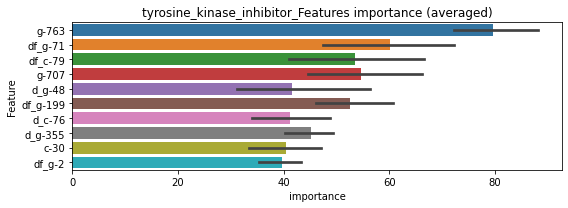

len(train_index) : 3869
len(valid_index) : 3870
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0304021	valid_1's binary_logloss: 0.0656653
[200]	training's binary_logloss: 0.00621732	valid_1's binary_logloss: 0.0394948
[300]	training's binary_logloss: 0.00177214	valid_1's binary_logloss: 0.0333576
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00101189	valid_1's binary_logloss: 0.0323029


len(train_index) : 3870
len(valid_index) : 3869
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290984	valid_1's binary_logloss: 0.0634313
[200]	training's binary_logloss: 0.00595355	valid_1's binary_logloss: 0.0317231
[300]	training's binary_logloss: 0.00175541	valid_1's binary_logloss: 0.0229173
[400]	training's binary_logloss: 0.000797019	valid_1's binary_logloss: 0.0200063
[500]	training's binary_logloss: 0.000480077	valid_1's binary_logloss: 0.0189473
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.000362677	valid_1's binary_logloss: 0.0184498


tyrosine_kinase_inhibitor logloss: 0.02537723368936357


neg labels: 3289 → selected neg labels: 3287


ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0176091	valid_1's binary_logloss: 0.0211002
[200]	training's binary_logloss: 0.00169313	valid_1's binary_logloss: 0.00355133
[300]	training's binary_logloss: 0.000480433	valid_1's binary_logloss: 0.00155225
[400]	training's binary_logloss: 0.000286377	valid_1's binary_logloss: 0.00111845
[500]	training's binary_logloss: 0.000252925	valid_1's binary_logloss: 0.00106182
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000252925	valid_1's binary_logloss: 0.00106182
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0175925	valid_1's binary_logloss: 0.0205631
[200]	training's binary_logloss: 0.0016901	valid_1's binary_logloss: 0.00307473
[300]	training's binary_logloss: 0.000477053	valid_1's binary_logloss: 0.00133294
[400]	training's binary_logloss: 0.000281336	valid_1's binary_logloss: 0.000929578
Early stopping, best iteration 

1 / 3 AUC score:1.000
y_Threshold: 0.0010464, Threshold: 0.0016916, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0200904 Vs.target_rate: 0.00050
Num_p_label: 80.0, conf_0:0.00152, conf_1:0.00186
Num_p_label: 80.0, Expected: 2.0, Adj_threshold_1: 0.0016916
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_2: 0.0116916
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.0216916
threshold: 0.0216916, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017677	valid_1's binary_logloss: 0.0198731
[200]	training's binary_logloss: 0.00165016	valid_1's binary_logloss: 0.00256728
[300]	training's binary_logloss: 0.000458319	valid_1's binary_logloss: 0.000982638
[400]	training's binary_logloss: 0.000272611	valid_1's binary_logloss: 0.00066478
[500]	training's binary_logloss: 0.000240391	valid_1's binary_logloss: 0.00061753
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000241035	valid_1's binary_logloss: 0.00061742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179	valid_1's binary_logloss: 0.0203972
[200]	training's binary_logloss: 0.00164883	valid_1's binary_logloss: 0.0022336
[300]	training's binary_logloss: 0.000456673	valid_1's binary_logloss: 0.00069105
[400]	training's binary_logloss: 0.00026915	valid_1's binary_logloss: 0.000428178
[500]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1323673, Threshold: 0.0216916, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0105475 Vs.target_rate: 0.00050
Num_p_label: 42.0, conf_0:0.01952, conf_1:0.02386
Num_p_label: 42.0, Expected: 2.0, Adj_threshold_1: 0.0216916
Num_p_label: 34.0, Expected: 2.0, Adj_threshold_2: 0.0316916
Num_p_label: 27.0, Expected: 2.0, Adj_threshold_3: 0.0416916
Num_p_label: 24.0, Expected: 2.0, Adj_threshold_4: 0.0516916
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_5: 0.0616916
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_6: 0.0716916
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_7: 0.0816916
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_8: 0.0916916
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_9: 0.1016916
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_10: 0.1116916
threshold: 0.1216916, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
=========

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.017677	valid_1's binary_logloss: 0.0198731
[200]	training's binary_logloss: 0.00165016	valid_1's binary_logloss: 0.00256728
[300]	training's binary_logloss: 0.000458319	valid_1's binary_logloss: 0.000982638
[400]	training's binary_logloss: 0.000272611	valid_1's binary_logloss: 0.00066478
[500]	training's binary_logloss: 0.000240391	valid_1's binary_logloss: 0.00061753
Early stopping, best iteration is:
[492]	training's binary_logloss: 0.000241035	valid_1's binary_logloss: 0.00061742
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0179	valid_1's binary_logloss: 0.0203972
[200]	training's binary_logloss: 0.00164883	valid_1's binary_logloss: 0.0022336
[300]	training's binary_logloss: 0.000456673	valid_1's binary_logloss: 0.00069105
[400]	training's binary_logloss: 0.00026915	valid_1's binary_logloss: 0.000428178
[500]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1323673, Threshold: 0.1216916, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0037670 Vs.target_rate: 0.00050
Num_p_label: 15.0, conf_0:0.10952, conf_1:0.13386
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_1: 0.1216916
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.1316916
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_3: 0.1416916
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.1516916
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.1616916
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_6: 0.1716916
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_7: 0.1816916
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_8: 0.1916916
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_9: 0.2016916
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_10: 0.2116916
threshold: 0.2216916, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 667.0/7794, y_label_rate: 0.0855787


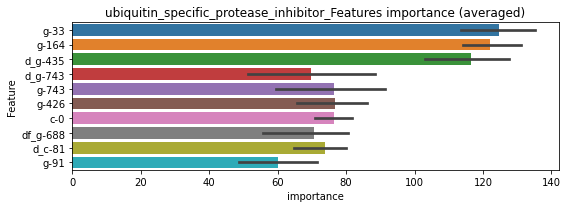

len(train_index) : 3897
len(valid_index) : 3897
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00939476	valid_1's binary_logloss: 0.013319
[200]	training's binary_logloss: 0.000886337	valid_1's binary_logloss: 0.00451248
[300]	training's binary_logloss: 0.000248704	valid_1's binary_logloss: 0.00376394
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000215889	valid_1's binary_logloss: 0.00370922


len(train_index) : 3897
len(valid_index) : 3897
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00985769	valid_1's binary_logloss: 0.0144418
[200]	training's binary_logloss: 0.000976557	valid_1's binary_logloss: 0.00536619
[300]	training's binary_logloss: 0.000274537	valid_1's binary_logloss: 0.0042127
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000220965	valid_1's binary_logloss: 0.00411997


ubiquitin_specific_protease_inhibitor logloss: 0.003914597732520454


neg labels: 3289 → selected neg labels: 3258


vegfr_inhibitor, len(trt): 170, len(othr): 3258, target_rate: 0.0071387 → Adj_target_rate: 0.0066081
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0542475	valid_1's binary_logloss: 0.13864
[200]	training's binary_logloss: 0.0119361	valid_1's binary_logloss: 0.0990399
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00441144	valid_1's binary_logloss: 0.0929204
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0554355	valid_1's binary_logloss: 0.122756
[200]	training's binary_logloss: 0.0127544	valid_1's binary_logloss: 0.0782445
[300]	training's binary_logloss: 0.00444923	valid_1's binary_logloss: 0.0663603
[400]	training's binary_logloss: 0.00218406	valid_1's binary_logloss: 0.0631212
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00191181	valid_1's binary_logloss: 0.0623595


1 / 3 AUC score:0.990
y_Threshold: 0.0387214, Threshold: 0.1793270, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 167 → Positive_corect_labels: 633/3742
p_label_rate: 0.0200904 Vs.target_rate: 0.00714
Num_p_label: 80.0, conf_0:0.16139, conf_1:0.19726
threshold: 0.1793270, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 633.0/3742, y_label_rate: 0.1691609
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0435555	valid_1's binary_logloss: 0.120135
[200]	training's binary_logloss: 0.0082763	valid_1's binary_logloss: 0.0890418
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00368723	valid_1's binary_logloss: 0.0848773
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0456824	valid_1's binary_logloss: 0.112824
[200]	training's binary_logloss: 0.00865538	valid_1's binary_logloss: 0.0730729
[300]	training's binary_logloss: 0.00270932	valid_1's binary_logloss: 0.0657323
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00214778	valid_1's binary_logloss: 0.0650091


2 / 3 AUC score:0.991
y_Threshold: 0.1042841, Threshold: 0.1793270, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 80 → Positive_corect_labels: 593.0/3662
p_label_rate: 0.0409342 Vs.target_rate: 0.00714
Num_p_label: 163.0, conf_0:0.16139, conf_1:0.19726
Num_p_label: 163.0, Expected: 28.4, Adj_threshold_1: 0.1793270
Num_p_label: 160.0, Expected: 28.4, Adj_threshold_2: 0.1893270
Num_p_label: 156.0, Expected: 28.4, Adj_threshold_3: 0.1993270
Num_p_label: 150.0, Expected: 28.4, Adj_threshold_4: 0.2093270
Num_p_label: 145.0, Expected: 28.4, Adj_threshold_5: 0.2193270
Num_p_label: 142.0, Expected: 28.4, Adj_threshold_6: 0.2293270
Num_p_label: 136.0, Expected: 28.4, Adj_threshold_7: 0.2393270
Num_p_label: 134.0, Expected: 28.4, Adj_threshold_8: 0.2493270
Num_p_label: 133.0, Expected: 28.4, Adj_threshold_9: 0.2593270
Num_p_label: 130.0, Expected: 28.4, Adj_threshold_10: 0.2693270
threshold: 0.2793270, positive_p_label: 126.0/3982, p_label_rate: 0.0316424
positive_y_label: 593.0/3662, y_label_ra

Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0376374	valid_1's binary_logloss: 0.0878639
[200]	training's binary_logloss: 0.00659644	valid_1's binary_logloss: 0.0510102
[300]	training's binary_logloss: 0.00205544	valid_1's binary_logloss: 0.0410699
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00142443	valid_1's binary_logloss: 0.0398946
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383044	valid_1's binary_logloss: 0.092303
[200]	training's binary_logloss: 0.00665611	valid_1's binary_logloss: 0.0597414
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00345733	valid_1's binary_logloss: 0.0551431


3 / 3 AUC score:0.996
y_Threshold: 0.1263703, Threshold: 0.2793270, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 38 → Positive_corect_labels: 574.0/3624
p_label_rate: 0.0381718 Vs.target_rate: 0.00714
Num_p_label: 152.0, conf_0:0.25139, conf_1:0.30726
Num_p_label: 152.0, Expected: 28.4, Adj_threshold_1: 0.2793270
Num_p_label: 149.0, Expected: 28.4, Adj_threshold_2: 0.2893270
Num_p_label: 147.0, Expected: 28.4, Adj_threshold_3: 0.2993270
Num_p_label: 143.0, Expected: 28.4, Adj_threshold_4: 0.3093270
Num_p_label: 140.0, Expected: 28.4, Adj_threshold_5: 0.3193270
Num_p_label: 138.0, Expected: 28.4, Adj_threshold_6: 0.3293270
Num_p_label: 136.0, Expected: 28.4, Adj_threshold_7: 0.3393270
Num_p_label: 135.0, Expected: 28.4, Adj_threshold_8: 0.3493270
Num_p_label: 131.0, Expected: 28.4, Adj_threshold_9: 0.3593270
Num_p_label: 129.0, Expected: 28.4, Adj_threshold_10: 0.3693270
threshold: 0.3793270, positive_p_label: 126.0/3982, p_label_rate: 0.0316424
positive_y_label: 700.0/7606, y_label_ra

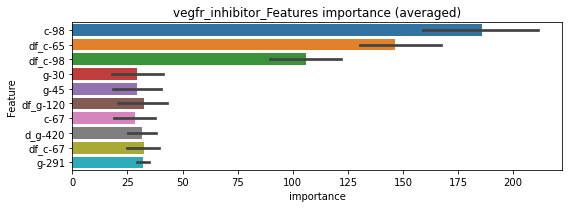

len(train_index) : 3803
len(valid_index) : 3803
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226566	valid_1's binary_logloss: 0.052254
[200]	training's binary_logloss: 0.00412761	valid_1's binary_logloss: 0.0327079
[300]	training's binary_logloss: 0.00124919	valid_1's binary_logloss: 0.0275837
[400]	training's binary_logloss: 0.000596917	valid_1's binary_logloss: 0.0259278
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000634457	valid_1's binary_logloss: 0.0258794


len(train_index) : 3803
len(valid_index) : 3803
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217917	valid_1's binary_logloss: 0.0568158
[200]	training's binary_logloss: 0.00382204	valid_1's binary_logloss: 0.0388584
[300]	training's binary_logloss: 0.00112634	valid_1's binary_logloss: 0.035474
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00078212	valid_1's binary_logloss: 0.0348207


vegfr_inhibitor logloss: 0.0303500634394063


neg labels: 3289 → selected neg labels: 3285


vitamin_b, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288362	valid_1's binary_logloss: 0.0425752
[200]	training's binary_logloss: 0.00391193	valid_1's binary_logloss: 0.00912614
[300]	training's binary_logloss: 0.00111343	valid_1's binary_logloss: 0.00373913
[400]	training's binary_logloss: 0.000562021	valid_1's binary_logloss: 0.00241363
[500]	training's binary_logloss: 0.00040065	valid_1's binary_logloss: 0.00199687
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000394238	valid_1's binary_logloss: 0.00198003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02908	valid_1's binary_logloss: 0.0450007
[200]	training's binary_logloss: 0.00401149	valid_1's binary_logloss: 0.0108926
[300]	training's binary_logloss: 0.00112787	valid_1's binary_logloss: 0.00508361
[400]	training's binary_logloss: 0.000569518	valid_1's binary_logloss: 0.0035217
Early stopping, best iteration is:
[46

1 / 3 AUC score:1.000
y_Threshold: 0.0022365, Threshold: 0.0049642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0200904 Vs.target_rate: 0.00109
Num_p_label: 80.0, conf_0:0.00447, conf_1:0.00546
Num_p_label: 80.0, Expected: 4.3, Adj_threshold_1: 0.0049642
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_2: 0.0149642
Num_p_label: 5.0, Expected: 4.3, Adj_threshold_3: 0.0249642
threshold: 0.0249642, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284669	valid_1's binary_logloss: 0.0413876
[200]	training's binary_logloss: 0.00372235	valid_1's binary_logloss: 0.00875619
[300]	training's binary_logloss: 0.00105088	valid_1's binary_logloss: 0.00359731
[400]	training's binary_logloss: 0.000539631	valid_1's binary_logloss: 0.00229068
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000412572	valid_1's binary_logloss: 0.00202128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281236	valid_1's binary_logloss: 0.0433653
[200]	training's binary_logloss: 0.00373093	valid_1's binary_logloss: 0.0107738
[300]	training's binary_logloss: 0.00106941	valid_1's binary_logloss: 0.00516952
[400]	training's binary_logloss: 0.000551873	valid_1's binary_logloss: 0.00377647
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000509401	valid_1's binary_logloss: 0.00361679

2 / 3 AUC score:1.000
y_Threshold: 0.0539903, Threshold: 0.0249642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0047715 Vs.target_rate: 0.00109
Num_p_label: 19.0, conf_0:0.02247, conf_1:0.02746
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_1: 0.0249642
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.0349642
threshold: 0.0349642, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284669	valid_1's binary_logloss: 0.0413876
[200]	training's binary_logloss: 0.00372235	valid_1's binary_logloss: 0.00875619
[300]	training's binary_logloss: 0.00105088	valid_1's binary_logloss: 0.00359731
[400]	training's binary_logloss: 0.000539631	valid_1's binary_logloss: 0.00229068
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000412572	valid_1's binary_logloss: 0.00202128
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281236	valid_1's binary_logloss: 0.0433653
[200]	training's binary_logloss: 0.00373093	valid_1's binary_logloss: 0.0107738
[300]	training's binary_logloss: 0.00106941	valid_1's binary_logloss: 0.00516952
[400]	training's binary_logloss: 0.000551873	valid_1's binary_logloss: 0.00377647
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000509401	valid_1's binary_logloss: 0.00361679

3 / 3 AUC score:1.000
y_Threshold: 0.0539903, Threshold: 0.0349642, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0020090 Vs.target_rate: 0.00109
Num_p_label: 8.0, conf_0:0.03147, conf_1:0.03846
threshold: 0.0349642, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 665.0/7792, y_label_rate: 0.0853439


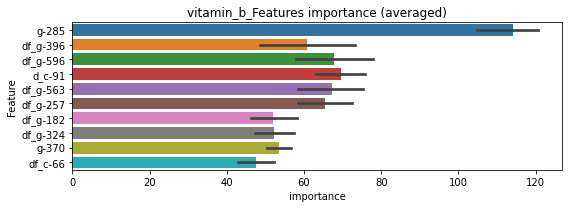

len(train_index) : 3896
len(valid_index) : 3896
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159478	valid_1's binary_logloss: 0.0301635
[200]	training's binary_logloss: 0.00217721	valid_1's binary_logloss: 0.0112187
[300]	training's binary_logloss: 0.000593294	valid_1's binary_logloss: 0.0087367
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.000454455	valid_1's binary_logloss: 0.00849773


len(train_index) : 3896
len(valid_index) : 3896
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165812	valid_1's binary_logloss: 0.0243072
[200]	training's binary_logloss: 0.00229612	valid_1's binary_logloss: 0.00600748
[300]	training's binary_logloss: 0.000640238	valid_1's binary_logloss: 0.00345645
[400]	training's binary_logloss: 0.00031348	valid_1's binary_logloss: 0.00298171
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.000223624	valid_1's binary_logloss: 0.00289017


vitamin_b logloss: 0.0056939494099069185


neg labels: 3289 → selected neg labels: 3281


vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3281, target_rate: 0.0016377 → Adj_target_rate: 0.0018906
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271257	valid_1's binary_logloss: 0.0414876
[200]	training's binary_logloss: 0.00350257	valid_1's binary_logloss: 0.00911423
[300]	training's binary_logloss: 0.000996379	valid_1's binary_logloss: 0.00417398
[400]	training's binary_logloss: 0.000505364	valid_1's binary_logloss: 0.00267715
[500]	training's binary_logloss: 0.000359323	valid_1's binary_logloss: 0.00223951
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.000356135	valid_1's binary_logloss: 0.00221885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266158	valid_1's binary_logloss: 0.048208
[200]	training's binary_logloss: 0.00347791	valid_1's binary_logloss: 0.0170474
[300]	training's binary_logloss: 0.00098862	valid_1's binary_logloss: 0.0114682
[400]	training's binary_logloss: 0.000501362	valid_1's binary_logloss: 0.00973709
Early stopping, best iteration is:


1 / 3 AUC score:1.000
y_Threshold: 0.0021252, Threshold: 0.0038922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0200904 Vs.target_rate: 0.00164
Num_p_label: 80.0, conf_0:0.00350, conf_1:0.00428
Num_p_label: 80.0, Expected: 6.5, Adj_threshold_1: 0.0038922
Num_p_label: 20.0, Expected: 6.5, Adj_threshold_2: 0.0138922
Num_p_label: 15.0, Expected: 6.5, Adj_threshold_3: 0.0238922
Num_p_label: 11.0, Expected: 6.5, Adj_threshold_4: 0.0338922
threshold: 0.0338922, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277817	valid_1's binary_logloss: 0.0410836
[200]	training's binary_logloss: 0.00356362	valid_1's binary_logloss: 0.00939638
[300]	training's binary_logloss: 0.000996023	valid_1's binary_logloss: 0.00425559
[400]	training's binary_logloss: 0.000498698	valid_1's binary_logloss: 0.00295921
[500]	training's binary_logloss: 0.000360949	valid_1's binary_logloss: 0.00244722
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000343641	valid_1's binary_logloss: 0.00236422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266161	valid_1's binary_logloss: 0.0473405
[200]	training's binary_logloss: 0.00341365	valid_1's binary_logloss: 0.0156909
[300]	training's binary_logloss: 0.00096456	valid_1's binary_logloss: 0.0101571
[400]	training's binary_logloss: 0.000490619	valid_1's binary_logloss: 0.00826541
Early stopping, best iteration is:

2 / 3 AUC score:1.000
y_Threshold: 0.0306892, Threshold: 0.0338922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0045203 Vs.target_rate: 0.00164
Num_p_label: 18.0, conf_0:0.03050, conf_1:0.03728
threshold: 0.0338922, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277817	valid_1's binary_logloss: 0.0410836
[200]	training's binary_logloss: 0.00356362	valid_1's binary_logloss: 0.00939638
[300]	training's binary_logloss: 0.000996023	valid_1's binary_logloss: 0.00425559
[400]	training's binary_logloss: 0.000498698	valid_1's binary_logloss: 0.00295921
[500]	training's binary_logloss: 0.000360949	valid_1's binary_logloss: 0.00244722
Early stopping, best iteration is:
[538]	training's binary_logloss: 0.000343641	valid_1's binary_logloss: 0.00236422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266161	valid_1's binary_logloss: 0.0473405
[200]	training's binary_logloss: 0.00341365	valid_1's binary_logloss: 0.0156909
[300]	training's binary_logloss: 0.00096456	valid_1's binary_logloss: 0.0101571
[400]	training's binary_logloss: 0.000490619	valid_1's binary_logloss: 0.00826541
Early stopping, best iteration is:

3 / 3 AUC score:1.000
y_Threshold: 0.0306892, Threshold: 0.0338922, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0045203 Vs.target_rate: 0.00164
Num_p_label: 18.0, conf_0:0.03050, conf_1:0.03728
threshold: 0.0338922, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 674.0/7787, y_label_rate: 0.0865545


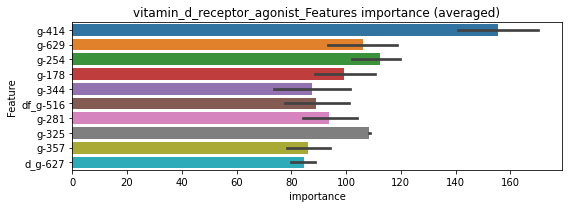

len(train_index) : 3893
len(valid_index) : 3894
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147354	valid_1's binary_logloss: 0.0286501
[200]	training's binary_logloss: 0.00185314	valid_1's binary_logloss: 0.013115
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.000684071	valid_1's binary_logloss: 0.0116981


len(train_index) : 3894
len(valid_index) : 3893
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149467	valid_1's binary_logloss: 0.0306243
[200]	training's binary_logloss: 0.00196919	valid_1's binary_logloss: 0.0127313
[300]	training's binary_logloss: 0.000544939	valid_1's binary_logloss: 0.00945987
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.000544939	valid_1's binary_logloss: 0.00945987


vitamin_d_receptor_agonist logloss: 0.010579105080662437


neg labels: 3289 → selected neg labels: 3284


wnt_inhibitor, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031359	valid_1's binary_logloss: 0.0540633
[200]	training's binary_logloss: 0.00451329	valid_1's binary_logloss: 0.0156217
[300]	training's binary_logloss: 0.00126533	valid_1's binary_logloss: 0.00807874
[400]	training's binary_logloss: 0.000626019	valid_1's binary_logloss: 0.00608988
[500]	training's binary_logloss: 0.00043445	valid_1's binary_logloss: 0.00550343
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000416104	valid_1's binary_logloss: 0.00536529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311158	valid_1's binary_logloss: 0.0574115
[200]	training's binary_logloss: 0.00438633	valid_1's binary_logloss: 0.0211306
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00158415	valid_1's binary_logloss: 0.0157283


1 / 3 AUC score:1.000
y_Threshold: 0.0046174, Threshold: 0.0049055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0200904 Vs.target_rate: 0.00126
Num_p_label: 80.0, conf_0:0.00441, conf_1:0.00540
Num_p_label: 80.0, Expected: 5.0, Adj_threshold_1: 0.0049055
Num_p_label: 6.0, Expected: 5.0, Adj_threshold_2: 0.0149055
threshold: 0.0149055, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310239	valid_1's binary_logloss: 0.0526468
[200]	training's binary_logloss: 0.00437218	valid_1's binary_logloss: 0.0150659
[300]	training's binary_logloss: 0.00123905	valid_1's binary_logloss: 0.00862405
[400]	training's binary_logloss: 0.000619035	valid_1's binary_logloss: 0.00639984
[500]	training's binary_logloss: 0.000433998	valid_1's binary_logloss: 0.0057663
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000438558	valid_1's binary_logloss: 0.00573035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313442	valid_1's binary_logloss: 0.05877
[200]	training's binary_logloss: 0.00443105	valid_1's binary_logloss: 0.021613
[300]	training's binary_logloss: 0.00124688	valid_1's binary_logloss: 0.01579
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000753891	valid_1's binary_logloss: 0.0147726


2 / 3 AUC score:1.000
y_Threshold: 0.0420295, Threshold: 0.0149055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0037670 Vs.target_rate: 0.00126
Num_p_label: 15.0, conf_0:0.01341, conf_1:0.01640
threshold: 0.0149055, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316068	valid_1's binary_logloss: 0.052824
[200]	training's binary_logloss: 0.00447334	valid_1's binary_logloss: 0.0183727
[300]	training's binary_logloss: 0.00126987	valid_1's binary_logloss: 0.0121263
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000824324	valid_1's binary_logloss: 0.0110503
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323587	valid_1's binary_logloss: 0.0643221
[200]	training's binary_logloss: 0.0046496	valid_1's binary_logloss: 0.0260888
[300]	training's binary_logloss: 0.00130861	valid_1's binary_logloss: 0.0197548
[400]	training's binary_logloss: 0.000602763	valid_1's binary_logloss: 0.017522
[500]	training's binary_logloss: 0.000416754	valid_1's binary_logloss: 0.0164917
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.000414944	valid_1's binary_logloss: 0.016467


3 / 3 AUC score:1.000
y_Threshold: 0.0132239, Threshold: 0.0149055, pos_neg_ratio: 0.8000000
Remove_noisy_labels: 8 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0030136 Vs.target_rate: 0.00126
Num_p_label: 12.0, conf_0:0.01341, conf_1:0.01640
threshold: 0.0149055, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 663.0/7780, y_label_rate: 0.0852185


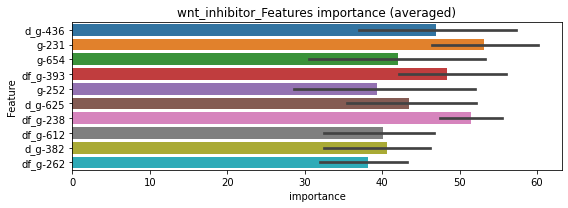

len(train_index) : 3890
len(valid_index) : 3890
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164619	valid_1's binary_logloss: 0.035924
[200]	training's binary_logloss: 0.00235054	valid_1's binary_logloss: 0.0189609
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.001238	valid_1's binary_logloss: 0.0171423


len(train_index) : 3890
len(valid_index) : 3890
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0177846	valid_1's binary_logloss: 0.0286149
[200]	training's binary_logloss: 0.00261313	valid_1's binary_logloss: 0.0102644
[300]	training's binary_logloss: 0.000712908	valid_1's binary_logloss: 0.0076374
[400]	training's binary_logloss: 0.00034245	valid_1's binary_logloss: 0.00701225
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000362797	valid_1's binary_logloss: 0.0069763


wnt_inhibitor logloss: 0.01205929101775011


In [48]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    if DEBUG:
        feature_importance_df = create_featureimprotance(models, feature_importance_df)
        importance_cols_df[target_col] = select_importance_cols(_feature_importance_df)

In [49]:
sub.to_csv('submission.csv', index=False)

In [50]:
print(f"CV:{np.mean(scores)}")

CV:0.02079255863769428


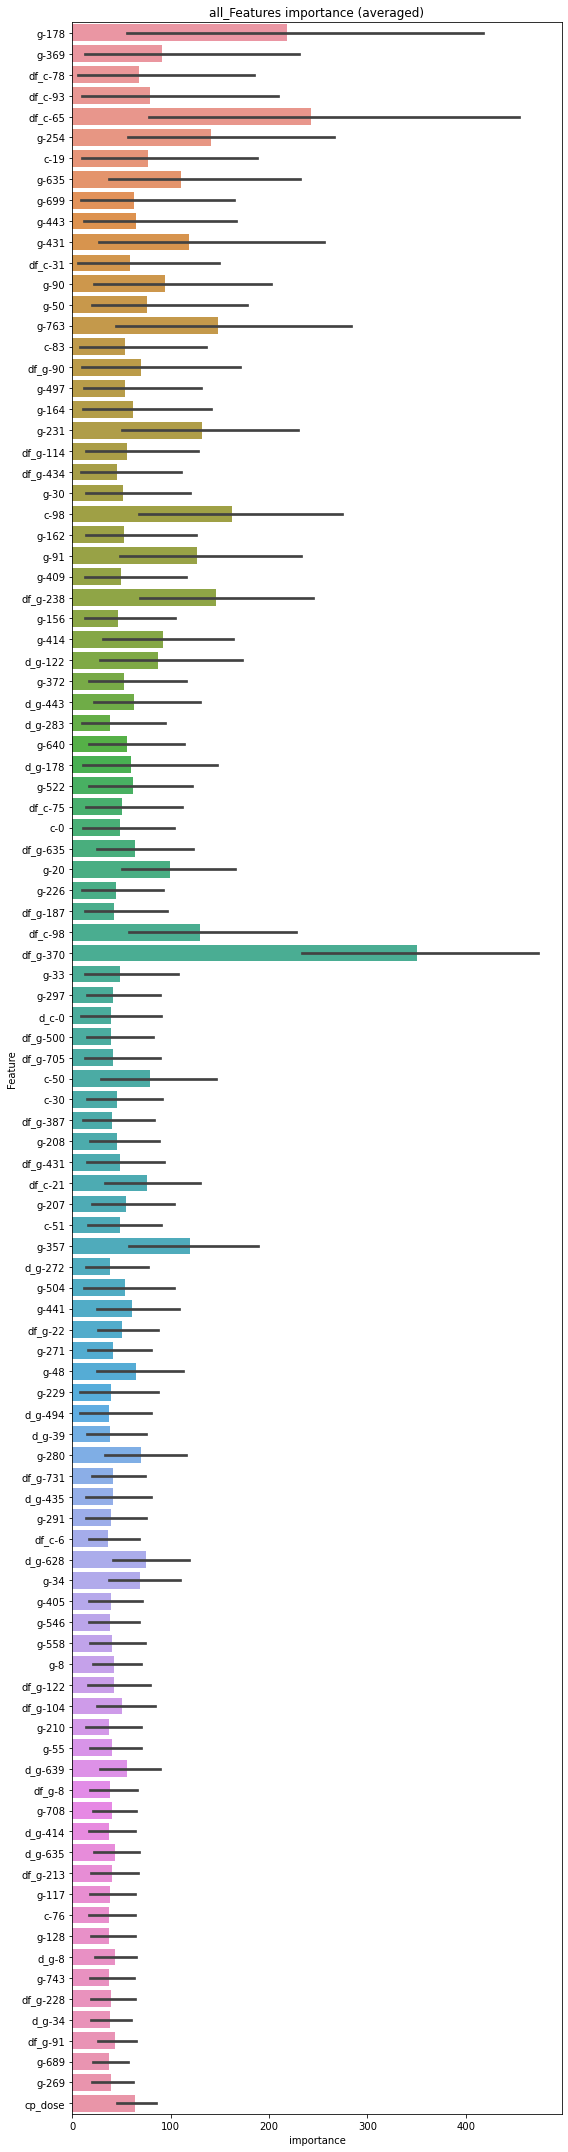

In [51]:
if DEBUG:
    show_feature_importance(feature_importance_df)
    feature_importance_df.to_csv(f'feature_importance_df.{Version}.csv', index=False)
    importance_cols_df.to_csv(f'importance_cols_df.{Version}.csv', index=False)